In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory= False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory= False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory= False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'line_drive','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo', 'swing'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'line_drive','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['ground_ball'], axis=1).copy()
train_label = training_features['ground_ball'].copy()
testing_data = testing_features.drop(['ground_ball'], axis=1).copy()
testing_label = testing_features['ground_ball'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5500823476568348
Log Loss: 0.6823208514452255


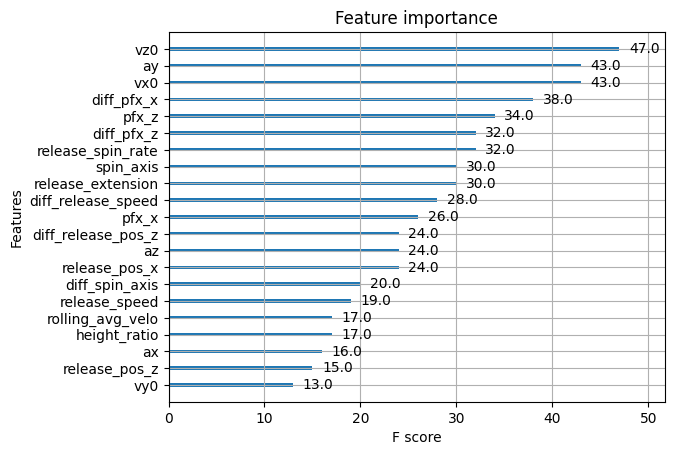

In [12]:
xgb.plot_importance(model)
plt.show()

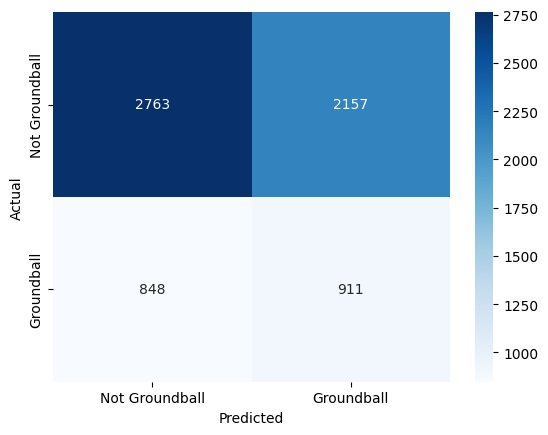

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device' : 'gpu'
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-16 16:32:59,583] A new study created in memory with name: no-name-5d1324d0-783a-405a-bd67-64fc5deb582f


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68930
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68698
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68617
[9]	eval-logloss:0.68610
[10]	eval-logloss:0.68620
[11]	eval-logloss:0.68636
[12]	eval-logloss:0.68601
[13]	eval-logloss:0.68576
[14]	eval-logloss:0.68520
[15]	eval-logloss:0.68452
[16]	eval-logloss:0.68444
[17]	eval-logloss:0.68433
[18]	eval-logloss:0.68413
[19]	eval-logloss:0.68352


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[20]	eval-logloss:0.68322
[21]	eval-logloss:0.68281
[22]	eval-logloss:0.68202
[23]	eval-logloss:0.68178
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68164
[26]	eval-logloss:0.68164
[27]	eval-logloss:0.68123
[28]	eval-logloss:0.68072
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.68056
[31]	eval-logloss:0.67992
[32]	eval-logloss:0.68012
[33]	eval-logloss:0.67998
[34]	eval-logloss:0.67976
[35]	eval-logloss:0.67982
[36]	eval-logloss:0.67990
[37]	eval-logloss:0.67985
[38]	eval-logloss:0.67944
[39]	eval-logloss:0.67929
[40]	eval-logloss:0.67921
[41]	eval-logloss:0.67933
[42]	eval-logloss:0.67924
[43]	eval-logloss:0.67909
[44]	eval-logloss:0.67894
[45]	eval-logloss:0.67928
[46]	eval-logloss:0.67905
[47]	eval-logloss:0.67914
[48]	eval-logloss:0.67860
[49]	eval-logloss:0.67839
[50]	eval-logloss:0.67860
[51]	eval-logloss:0.67848
[52]	eval-logloss:0.67815
[53]	eval-logloss:0.67766
[54]	eval-logloss:0.67728
[55]	eval-logloss:0.67739
[56]	eval-logloss:0.67737
[57]	eval-logloss:0.67719
[58]	eval-lo

[I 2023-11-16 16:33:00,257] Trial 0 finished with value: 0.6756323453274633 and parameters: {'max_depth': 4, 'eta': 0.09477220135335711, 'subsample': 0.6423374056635294, 'colsample_bytree': 0.8613559919672297}. Best is trial 0 with value: 0.6756323453274633.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68838
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68601
[5]	eval-logloss:0.68479
[6]	eval-logloss:0.68376
[7]	eval-logloss:0.68218
[8]	eval-logloss:0.68135
[9]	eval-logloss:0.68108
[10]	eval-logloss:0.68088
[11]	eval-logloss:0.68088
[12]	eval-logloss:0.68035
[13]	eval-logloss:0.67962
[14]	eval-logloss:0.67909


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.67864
[16]	eval-logloss:0.67864
[17]	eval-logloss:0.67882
[18]	eval-logloss:0.67852
[19]	eval-logloss:0.67780
[20]	eval-logloss:0.67692
[21]	eval-logloss:0.67642
[22]	eval-logloss:0.67567
[23]	eval-logloss:0.67576
[24]	eval-logloss:0.67565
[25]	eval-logloss:0.67504
[26]	eval-logloss:0.67475
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67355
[29]	eval-logloss:0.67374
[30]	eval-logloss:0.67312
[31]	eval-logloss:0.67289
[32]	eval-logloss:0.67291
[33]	eval-logloss:0.67254
[34]	eval-logloss:0.67259
[35]	eval-logloss:0.67304
[36]	eval-logloss:0.67305
[37]	eval-logloss:0.67265
[38]	eval-logloss:0.67244
[39]	eval-logloss:0.67248
[40]	eval-logloss:0.67228
[41]	eval-logloss:0.67217
[42]	eval-logloss:0.67212
[43]	eval-logloss:0.67195
[44]	eval-logloss:0.67180
[45]	eval-logloss:0.67181
[46]	eval-logloss:0.67159
[47]	eval-logloss:0.67157
[48]	eval-logloss:0.67081
[49]	eval-logloss:0.67057
[50]	eval-logloss:0.67047
[51]	eval-logloss:0.67028
[52]	eval-logloss:0.67013
[53]	eval-lo

[I 2023-11-16 16:33:01,071] Trial 1 finished with value: 0.6653769088113725 and parameters: {'max_depth': 6, 'eta': 0.11647725711238029, 'subsample': 0.6993215351008646, 'colsample_bytree': 0.853113515855418}. Best is trial 1 with value: 0.6653769088113725.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68619
[4]	eval-logloss:0.68478
[5]	eval-logloss:0.68387
[6]	eval-logloss:0.68305
[7]	eval-logloss:0.68241
[8]	eval-logloss:0.68216
[9]	eval-logloss:0.68238
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68210
[12]	eval-logloss:0.68140


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68015
[15]	eval-logloss:0.67926
[16]	eval-logloss:0.67914
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67891
[19]	eval-logloss:0.67800
[20]	eval-logloss:0.67734
[21]	eval-logloss:0.67714
[22]	eval-logloss:0.67652
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67620
[25]	eval-logloss:0.67518
[26]	eval-logloss:0.67445
[27]	eval-logloss:0.67484
[28]	eval-logloss:0.67439
[29]	eval-logloss:0.67451
[30]	eval-logloss:0.67473
[31]	eval-logloss:0.67473
[32]	eval-logloss:0.67459
[33]	eval-logloss:0.67386
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67333
[36]	eval-logloss:0.67295
[37]	eval-logloss:0.67326
[38]	eval-logloss:0.67290
[39]	eval-logloss:0.67270
[40]	eval-logloss:0.67257
[41]	eval-logloss:0.67292
[42]	eval-logloss:0.67310
[43]	eval-logloss:0.67299
[44]	eval-logloss:0.67277
[45]	eval-logloss:0.67316
[46]	eval-logloss:0.67233
[47]	eval-logloss:0.67240
[48]	eval-logloss:0.67248
[49]	eval-logloss:0.67217
[50]	eval-logloss:0.67193
[51]	eval-lo

[I 2023-11-16 16:33:01,950] Trial 2 finished with value: 0.6668404370423335 and parameters: {'max_depth': 6, 'eta': 0.18031442080367316, 'subsample': 0.8326231787766709, 'colsample_bytree': 0.8427705869673646}. Best is trial 1 with value: 0.6653769088113725.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68812
[3]	eval-logloss:0.68672
[4]	eval-logloss:0.68470
[5]	eval-logloss:0.68341
[6]	eval-logloss:0.68192
[7]	eval-logloss:0.68130
[8]	eval-logloss:0.68137
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.68073
[11]	eval-logloss:0.68101
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.67946
[14]	eval-logloss:0.67859
[15]	eval-logloss:0.67771
[16]	eval-logloss:0.67822
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67702
[20]	eval-logloss:0.67676
[21]	eval-logloss:0.67662


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[22]	eval-logloss:0.67529
[23]	eval-logloss:0.67527
[24]	eval-logloss:0.67528
[25]	eval-logloss:0.67510
[26]	eval-logloss:0.67482
[27]	eval-logloss:0.67548
[28]	eval-logloss:0.67515
[29]	eval-logloss:0.67577
[30]	eval-logloss:0.67570
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67648
[33]	eval-logloss:0.67554
[34]	eval-logloss:0.67566
[35]	eval-logloss:0.67533
[36]	eval-logloss:0.67520
[37]	eval-logloss:0.67543
[38]	eval-logloss:0.67551
[39]	eval-logloss:0.67577
[40]	eval-logloss:0.67505
[41]	eval-logloss:0.67551
[42]	eval-logloss:0.67567
[43]	eval-logloss:0.67598
[44]	eval-logloss:0.67540
[45]	eval-logloss:0.67538
[46]	eval-logloss:0.67516
[47]	eval-logloss:0.67531
[48]	eval-logloss:0.67535
[49]	eval-logloss:0.67549
[50]	eval-logloss:0.67507
[51]	eval-logloss:0.67451
[52]	eval-logloss:0.67435
[53]	eval-logloss:0.67434
[54]	eval-logloss:0.67411
[55]	eval-logloss:0.67417
[56]	eval-logloss:0.67466
[57]	eval-logloss:0.67473
[58]	eval-logloss:0.67478
[59]	eval-logloss:0.67528
[60]	eval-lo

[I 2023-11-16 16:33:02,603] Trial 3 finished with value: 0.6727770915111662 and parameters: {'max_depth': 5, 'eta': 0.2166122257951317, 'subsample': 0.8711876913004601, 'colsample_bytree': 0.8472765460020582}. Best is trial 1 with value: 0.6653769088113725.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68695
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68470
[5]	eval-logloss:0.68500
[6]	eval-logloss:0.68423
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68355
[10]	eval-logloss:0.68415
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68458
[14]	eval-logloss:0.68249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.68213
[16]	eval-logloss:0.68170
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68002
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67936
[22]	eval-logloss:0.67770
[23]	eval-logloss:0.67777
[24]	eval-logloss:0.67772
[25]	eval-logloss:0.67854
[26]	eval-logloss:0.67884
[27]	eval-logloss:0.67859
[28]	eval-logloss:0.67755
[29]	eval-logloss:0.67912
[30]	eval-logloss:0.67949
[31]	eval-logloss:0.67964
[32]	eval-logloss:0.68074
[33]	eval-logloss:0.68097
[34]	eval-logloss:0.68059
[35]	eval-logloss:0.68133
[36]	eval-logloss:0.68223
[37]	eval-logloss:0.68197
[38]	eval-logloss:0.68222
[39]	eval-logloss:0.68211
[40]	eval-logloss:0.68292
[41]	eval-logloss:0.68377
[42]	eval-logloss:0.68348
[43]	eval-logloss:0.68390
[44]	eval-logloss:0.68332
[45]	eval-logloss:0.68373
[46]	eval-logloss:0.68325
[47]	eval-logloss:0.68347
[48]	eval-logloss:0.68269
[49]	eval-logloss:0.68336
[50]	eval-logloss:0.68401
[51]	eval-logloss:0.68433
[52]	eval-logloss:0.68378
[53]	eval-lo

[I 2023-11-16 16:33:03,213] Trial 4 finished with value: 0.6848679933804612 and parameters: {'max_depth': 6, 'eta': 0.23285786581541115, 'subsample': 0.6147771316403841, 'colsample_bytree': 0.5261475240159055}. Best is trial 1 with value: 0.6653769088113725.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68742
[3]	eval-logloss:0.68565


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68440
[5]	eval-logloss:0.68309
[6]	eval-logloss:0.68160
[7]	eval-logloss:0.68028
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67777
[10]	eval-logloss:0.67687
[11]	eval-logloss:0.67560
[12]	eval-logloss:0.67459
[13]	eval-logloss:0.67348
[14]	eval-logloss:0.67233
[15]	eval-logloss:0.67166
[16]	eval-logloss:0.67097
[17]	eval-logloss:0.67030
[18]	eval-logloss:0.66966
[19]	eval-logloss:0.66962
[20]	eval-logloss:0.66871
[21]	eval-logloss:0.66813
[22]	eval-logloss:0.66759
[23]	eval-logloss:0.66673
[24]	eval-logloss:0.66652
[25]	eval-logloss:0.66604
[26]	eval-logloss:0.66562
[27]	eval-logloss:0.66542
[28]	eval-logloss:0.66487
[29]	eval-logloss:0.66495
[30]	eval-logloss:0.66422
[31]	eval-logloss:0.66396
[32]	eval-logloss:0.66357
[33]	eval-logloss:0.66305
[34]	eval-logloss:0.66258
[35]	eval-logloss:0.66210
[36]	eval-logloss:0.66126
[37]	eval-logloss:0.66073
[38]	eval-logloss:0.66018
[39]	eval-logloss:0.65969
[40]	eval-logloss:0.65922
[41]	eval-logloss:0.65921
[42]	eval-logloss:

[I 2023-11-16 16:33:04,649] Trial 5 finished with value: 0.6461810373845336 and parameters: {'max_depth': 9, 'eta': 0.0688096983655279, 'subsample': 0.884503085496811, 'colsample_bytree': 0.6930839766617968}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68589
[4]	eval-logloss:0.68457
[5]	eval-logloss:0.68529
[6]	eval-logloss:0.68402
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68376
[9]	eval-logloss:0.68318
[10]	eval-logloss:0.68390
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68460
[13]	eval-logloss:0.68483
[14]	eval-logloss:0.68333
[15]	eval-logloss:0.68340
[16]	eval-logloss:0.68432
[17]	eval-logloss:0.68461
[18]	eval-logloss:0.68364
[19]	eval-logloss:0.68265
[20]	eval-logloss:0.68245
[21]	eval-logloss:0.68161


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[22]	eval-logloss:0.68070
[23]	eval-logloss:0.68095
[24]	eval-logloss:0.68137
[25]	eval-logloss:0.68102
[26]	eval-logloss:0.68068
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.67911
[29]	eval-logloss:0.67944
[30]	eval-logloss:0.67963
[31]	eval-logloss:0.67995
[32]	eval-logloss:0.68064
[33]	eval-logloss:0.68037
[34]	eval-logloss:0.68040
[35]	eval-logloss:0.68151
[36]	eval-logloss:0.68206
[37]	eval-logloss:0.68161
[38]	eval-logloss:0.68086
[39]	eval-logloss:0.68162
[40]	eval-logloss:0.68130
[41]	eval-logloss:0.68214
[42]	eval-logloss:0.68262
[43]	eval-logloss:0.68226
[44]	eval-logloss:0.68237
[45]	eval-logloss:0.68166
[46]	eval-logloss:0.68142
[47]	eval-logloss:0.68208
[48]	eval-logloss:0.68076
[49]	eval-logloss:0.68075
[50]	eval-logloss:0.68109
[51]	eval-logloss:0.68111
[52]	eval-logloss:0.68064
[53]	eval-logloss:0.67981
[54]	eval-logloss:0.67917
[55]	eval-logloss:0.67994
[56]	eval-logloss:0.68105
[57]	eval-logloss:0.68088
[58]	eval-logloss:0.68083
[59]	eval-logloss:0.68199
[60]	eval-lo

[I 2023-11-16 16:33:05,272] Trial 6 finished with value: 0.6817829893723959 and parameters: {'max_depth': 4, 'eta': 0.26732393731743104, 'subsample': 0.7058450717920699, 'colsample_bytree': 0.6895840319455988}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69080
[6]	eval-logloss:0.69032
[7]	eval-logloss:0.68992
[8]	eval-logloss:0.68955
[9]	eval-logloss:0.68932
[10]	eval-logloss:0.68921
[11]	eval-logloss:0.68902
[12]	eval-logloss:0.68873
[13]	eval-logloss:0.68839
[14]	eval-logloss:0.68806
[15]	eval-logloss:0.68773
[16]	eval-logloss:0.68751
[17]	eval-logloss:0.68722
[18]	eval-logloss:0.68705
[19]	eval-logloss:0.68661


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[20]	eval-logloss:0.68623
[21]	eval-logloss:0.68608
[22]	eval-logloss:0.68579
[23]	eval-logloss:0.68559
[24]	eval-logloss:0.68543
[25]	eval-logloss:0.68524
[26]	eval-logloss:0.68503
[27]	eval-logloss:0.68471
[28]	eval-logloss:0.68441
[29]	eval-logloss:0.68428
[30]	eval-logloss:0.68405
[31]	eval-logloss:0.68384
[32]	eval-logloss:0.68381
[33]	eval-logloss:0.68356
[34]	eval-logloss:0.68339
[35]	eval-logloss:0.68327
[36]	eval-logloss:0.68314
[37]	eval-logloss:0.68305
[38]	eval-logloss:0.68272
[39]	eval-logloss:0.68261
[40]	eval-logloss:0.68249
[41]	eval-logloss:0.68242
[42]	eval-logloss:0.68221
[43]	eval-logloss:0.68211
[44]	eval-logloss:0.68192
[45]	eval-logloss:0.68192
[46]	eval-logloss:0.68179
[47]	eval-logloss:0.68168
[48]	eval-logloss:0.68144
[49]	eval-logloss:0.68133
[50]	eval-logloss:0.68125
[51]	eval-logloss:0.68118
[52]	eval-logloss:0.68093
[53]	eval-logloss:0.68080
[54]	eval-logloss:0.68066
[55]	eval-logloss:0.68065
[56]	eval-logloss:0.68066
[57]	eval-logloss:0.68051
[58]	eval-lo

[I 2023-11-16 16:33:06,050] Trial 7 finished with value: 0.677578886732494 and parameters: {'max_depth': 5, 'eta': 0.02669332826423037, 'subsample': 0.7273617413946509, 'colsample_bytree': 0.7355588854758008}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68631
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68192
[4]	eval-logloss:0.68037
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67806
[7]	eval-logloss:0.67832
[8]	eval-logloss:0.67765
[9]	eval-logloss:0.67619


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.67555
[11]	eval-logloss:0.67494
[12]	eval-logloss:0.67459
[13]	eval-logloss:0.67437
[14]	eval-logloss:0.67356
[15]	eval-logloss:0.67258
[16]	eval-logloss:0.67246
[17]	eval-logloss:0.67206
[18]	eval-logloss:0.67204
[19]	eval-logloss:0.67069
[20]	eval-logloss:0.66990
[21]	eval-logloss:0.66894
[22]	eval-logloss:0.66859
[23]	eval-logloss:0.66835
[24]	eval-logloss:0.66868
[25]	eval-logloss:0.66851
[26]	eval-logloss:0.66852
[27]	eval-logloss:0.66717
[28]	eval-logloss:0.66660
[29]	eval-logloss:0.66745
[30]	eval-logloss:0.66718
[31]	eval-logloss:0.66723
[32]	eval-logloss:0.66772
[33]	eval-logloss:0.66728
[34]	eval-logloss:0.66729
[35]	eval-logloss:0.66728
[36]	eval-logloss:0.66715
[37]	eval-logloss:0.66653
[38]	eval-logloss:0.66645
[39]	eval-logloss:0.66598
[40]	eval-logloss:0.66487
[41]	eval-logloss:0.66555
[42]	eval-logloss:0.66580
[43]	eval-logloss:0.66538
[44]	eval-logloss:0.66473
[45]	eval-logloss:0.66517
[46]	eval-logloss:0.66502
[47]	eval-logloss:0.66506
[48]	eval-lo

[I 2023-11-16 16:33:07,118] Trial 8 finished with value: 0.6681070459138357 and parameters: {'max_depth': 8, 'eta': 0.17751955516096754, 'subsample': 0.6712166120259019, 'colsample_bytree': 0.5497582498095813}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68812
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68631
[5]	eval-logloss:0.68620
[6]	eval-logloss:0.68510
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68509
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68517
[11]	eval-logloss:0.68554
[12]	eval-logloss:0.68550
[13]	eval-logloss:0.68583
[14]	eval-logloss:0.68510
[15]	eval-logloss:0.68430
[16]	eval-logloss:0.68463
[17]	eval-logloss:0.68538
[18]	eval-logloss:0.68450
[19]	eval-logloss:0.68408
[20]	eval-logloss:0.68351
[21]	eval-logloss:0.68361
[22]	eval-logloss:0.68297
[23]	eval-logloss:0.68321


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[24]	eval-logloss:0.68337
[25]	eval-logloss:0.68317
[26]	eval-logloss:0.68292
[27]	eval-logloss:0.68286
[28]	eval-logloss:0.68191
[29]	eval-logloss:0.68233
[30]	eval-logloss:0.68213
[31]	eval-logloss:0.68202
[32]	eval-logloss:0.68216
[33]	eval-logloss:0.68215
[34]	eval-logloss:0.68259
[35]	eval-logloss:0.68258
[36]	eval-logloss:0.68262
[37]	eval-logloss:0.68221
[38]	eval-logloss:0.68188
[39]	eval-logloss:0.68207
[40]	eval-logloss:0.68196
[41]	eval-logloss:0.68217
[42]	eval-logloss:0.68233
[43]	eval-logloss:0.68249
[44]	eval-logloss:0.68267
[45]	eval-logloss:0.68299
[46]	eval-logloss:0.68219
[47]	eval-logloss:0.68259
[48]	eval-logloss:0.68204
[49]	eval-logloss:0.68201
[50]	eval-logloss:0.68205
[51]	eval-logloss:0.68161
[52]	eval-logloss:0.68145
[53]	eval-logloss:0.68124
[54]	eval-logloss:0.68033
[55]	eval-logloss:0.68059
[56]	eval-logloss:0.68121
[57]	eval-logloss:0.68066
[58]	eval-logloss:0.68120
[59]	eval-logloss:0.68150
[60]	eval-logloss:0.68191
[61]	eval-logloss:0.68151
[62]	eval-lo

[I 2023-11-16 16:33:07,706] Trial 9 finished with value: 0.6808587238099796 and parameters: {'max_depth': 3, 'eta': 0.2257169168848884, 'subsample': 0.7801067363359272, 'colsample_bytree': 0.8019638700056814}. Best is trial 5 with value: 0.6461810373845336.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68906
[6]	eval-logloss:0.68854
[7]	eval-logloss:0.68786
[8]	eval-logloss:0.68729
[9]	eval-logloss:0.68686
[10]	eval-logloss:0.68627
[11]	eval-logloss:0.68563
[12]	eval-logloss:0.68516
[13]	eval-logloss:0.68458
[14]	eval-logloss:0.68410
[15]	eval-logloss:0.68364
[16]	eval-logloss:0.68310
[17]	eval-logloss:0.68264
[18]	eval-logloss:0.68213
[19]	eval-logloss:0.68163
[20]	eval-logloss:0.68113
[21]	eval-logloss:0.68083
[22]	eval-logloss:0.68030
[23]	eval-logloss:0.67993
[24]	eval-logloss:0.67946
[25]	eval-logloss:0.67894
[26]	eval-logloss:0.67851
[27]	eval-logloss:0.67809
[28]	eval-logloss:0.67766
[29]	eval-logloss:0.67740
[30]	eval-logloss:0.67700
[31]	eval-logloss:0.67670
[32]	eval-logloss:0.67637
[33]	eval-logloss:0.67596
[34]	eval-logloss:0.67550
[35]	eval-logloss:0.67519
[36]	eval-logloss:0.67494
[37]	eval-logloss:0.67464
[38]	eval-logloss:0.67

[I 2023-11-16 16:33:09,616] Trial 10 finished with value: 0.6608812860475736 and parameters: {'max_depth': 9, 'eta': 0.016234503845566295, 'subsample': 0.8927349447696765, 'colsample_bytree': 0.9927400728327452}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69217
[2]	eval-logloss:0.69172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69119
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.69002
[6]	eval-logloss:0.68961
[7]	eval-logloss:0.68920
[8]	eval-logloss:0.68877
[9]	eval-logloss:0.68841
[10]	eval-logloss:0.68799
[11]	eval-logloss:0.68736
[12]	eval-logloss:0.68697
[13]	eval-logloss:0.68651
[14]	eval-logloss:0.68608
[15]	eval-logloss:0.68573
[16]	eval-logloss:0.68534
[17]	eval-logloss:0.68488
[18]	eval-logloss:0.68440
[19]	eval-logloss:0.68407
[20]	eval-logloss:0.68367
[21]	eval-logloss:0.68329
[22]	eval-logloss:0.68293
[23]	eval-logloss:0.68262
[24]	eval-logloss:0.68228
[25]	eval-logloss:0.68183
[26]	eval-logloss:0.68141
[27]	eval-logloss:0.68094
[28]	eval-logloss:0.68057
[29]	eval-logloss:0.68032
[30]	eval-logloss:0.67997
[31]	eval-logloss:0.67972
[32]	eval-logloss:0.67937
[33]	eval-logloss:0.67899
[34]	eval-logloss:0.67868
[35]	eval-logloss:0.67830
[36]	eval-logloss:0.67795
[37]	eval-logloss:0.67759
[38]	eval-logloss:0.67731
[39]	eval-logloss:0.67704
[40]	eval-logloss:0.67673
[41]	eval-logloss:0

[I 2023-11-16 16:33:11,408] Trial 11 finished with value: 0.6647529373851193 and parameters: {'max_depth': 9, 'eta': 0.012717823002025215, 'subsample': 0.8988927250747665, 'colsample_bytree': 0.9946631596484095}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68702


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68125
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67870
[9]	eval-logloss:0.67807
[10]	eval-logloss:0.67746
[11]	eval-logloss:0.67654
[12]	eval-logloss:0.67578
[13]	eval-logloss:0.67488
[14]	eval-logloss:0.67425
[15]	eval-logloss:0.67369
[16]	eval-logloss:0.67319
[17]	eval-logloss:0.67286
[18]	eval-logloss:0.67250
[19]	eval-logloss:0.67171
[20]	eval-logloss:0.67103
[21]	eval-logloss:0.67057
[22]	eval-logloss:0.67003
[23]	eval-logloss:0.66958
[24]	eval-logloss:0.66950
[25]	eval-logloss:0.66898
[26]	eval-logloss:0.66854
[27]	eval-logloss:0.66802
[28]	eval-logloss:0.66780
[29]	eval-logloss:0.66716
[30]	eval-logloss:0.66671
[31]	eval-logloss:0.66614
[32]	eval-logloss:0.66594
[33]	eval-logloss:0.66548
[34]	eval-logloss:0.66509
[35]	eval-logloss:0.66471
[36]	eval-logloss:0.66432
[37]	eval-logloss:0.66403
[38]	eval-logloss:0.66375
[39]	eval-logloss:0.66365
[40]	eval-logloss:0.66329
[41]	eval-logloss:0

[I 2023-11-16 16:33:12,774] Trial 12 finished with value: 0.6533680787935376 and parameters: {'max_depth': 8, 'eta': 0.06285612222835824, 'subsample': 0.8325582021407265, 'colsample_bytree': 0.9821018103801532}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68752


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68455
[6]	eval-logloss:0.68303
[7]	eval-logloss:0.68207
[8]	eval-logloss:0.68090
[9]	eval-logloss:0.68006
[10]	eval-logloss:0.67957
[11]	eval-logloss:0.67792
[12]	eval-logloss:0.67681
[13]	eval-logloss:0.67576
[14]	eval-logloss:0.67534
[15]	eval-logloss:0.67480
[16]	eval-logloss:0.67410
[17]	eval-logloss:0.67412
[18]	eval-logloss:0.67375
[19]	eval-logloss:0.67340
[20]	eval-logloss:0.67257
[21]	eval-logloss:0.67252
[22]	eval-logloss:0.67125
[23]	eval-logloss:0.67073
[24]	eval-logloss:0.67084
[25]	eval-logloss:0.67012
[26]	eval-logloss:0.66969
[27]	eval-logloss:0.66922
[28]	eval-logloss:0.66870
[29]	eval-logloss:0.66837
[30]	eval-logloss:0.66793
[31]	eval-logloss:0.66780
[32]	eval-logloss:0.66802
[33]	eval-logloss:0.66725
[34]	eval-logloss:0.66599
[35]	eval-logloss:0.66569
[36]	eval-logloss:0.66550
[37]	eval-logloss:0.66489
[38]	eval-logloss:0.66475
[39]	eval-logloss:0.66499
[40]	eval-logloss:0.66442
[41]	eval-logloss:0.66422
[42]	eval-logloss:

[I 2023-11-16 16:33:13,928] Trial 13 finished with value: 0.6522449149827645 and parameters: {'max_depth': 8, 'eta': 0.08577230345270011, 'subsample': 0.8184330666144891, 'colsample_bytree': 0.6591992452290708}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67762


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.67602
[9]	eval-logloss:0.67566
[10]	eval-logloss:0.67424
[11]	eval-logloss:0.67297
[12]	eval-logloss:0.67164
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.67047
[15]	eval-logloss:0.66983
[16]	eval-logloss:0.66935
[17]	eval-logloss:0.66904
[18]	eval-logloss:0.66843
[19]	eval-logloss:0.66712
[20]	eval-logloss:0.66632
[21]	eval-logloss:0.66614
[22]	eval-logloss:0.66518
[23]	eval-logloss:0.66471
[24]	eval-logloss:0.66424
[25]	eval-logloss:0.66313
[26]	eval-logloss:0.66280
[27]	eval-logloss:0.66272
[28]	eval-logloss:0.66224
[29]	eval-logloss:0.66181
[30]	eval-logloss:0.66141
[31]	eval-logloss:0.66118
[32]	eval-logloss:0.66161
[33]	eval-logloss:0.66142
[34]	eval-logloss:0.66139
[35]	eval-logloss:0.66139
[36]	eval-logloss:0.66136
[37]	eval-logloss:0.66062
[38]	eval-logloss:0.66082
[39]	eval-logloss:0.66088
[40]	eval-logloss:0.66023
[41]	eval-logloss:0.66001
[42]	eval-logloss:0.65989
[43]	eval-logloss:0.65966
[44]	eval-logloss:0.65918
[45]	eval-logloss:0.65884
[46]	eval-logl

[I 2023-11-16 16:33:15,179] Trial 14 finished with value: 0.6532130927228893 and parameters: {'max_depth': 8, 'eta': 0.12452721341495564, 'subsample': 0.7866472950319359, 'colsample_bytree': 0.6226126111198578}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68740
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68563


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68481
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68240
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68086
[13]	eval-logloss:0.67977
[14]	eval-logloss:0.67918
[15]	eval-logloss:0.67876
[16]	eval-logloss:0.67840
[17]	eval-logloss:0.67831
[18]	eval-logloss:0.67782
[19]	eval-logloss:0.67742
[20]	eval-logloss:0.67637
[21]	eval-logloss:0.67629
[22]	eval-logloss:0.67555
[23]	eval-logloss:0.67518
[24]	eval-logloss:0.67480
[25]	eval-logloss:0.67460
[26]	eval-logloss:0.67447
[27]	eval-logloss:0.67420
[28]	eval-logloss:0.67370
[29]	eval-logloss:0.67346
[30]	eval-logloss:0.67344
[31]	eval-logloss:0.67332
[32]	eval-logloss:0.67302
[33]	eval-logloss:0.67271
[34]	eval-logloss:0.67214
[35]	eval-logloss:0.67169
[36]	eval-logloss:0.67167
[37]	eval-logloss:0.67162
[38]	eval-logloss:0.67127
[39]	eval-logloss:0.67113
[40]	eval-logloss:0.67049
[41]	eval-logloss:0.67057
[42]	eval-logloss:0.67018
[43]	eval-logloss:0.67020
[44]	eval-logloss:0.67035
[45]	eval-loglo

[I 2023-11-16 16:33:16,229] Trial 15 finished with value: 0.662852437084876 and parameters: {'max_depth': 7, 'eta': 0.0707050193403599, 'subsample': 0.8432357310857175, 'colsample_bytree': 0.6393221814760113}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.68647
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68142


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67716
[6]	eval-logloss:0.67427
[7]	eval-logloss:0.67272
[8]	eval-logloss:0.67114
[9]	eval-logloss:0.67076
[10]	eval-logloss:0.66999
[11]	eval-logloss:0.66756
[12]	eval-logloss:0.66683
[13]	eval-logloss:0.66611
[14]	eval-logloss:0.66526
[15]	eval-logloss:0.66451
[16]	eval-logloss:0.66431
[17]	eval-logloss:0.66370
[18]	eval-logloss:0.66311
[19]	eval-logloss:0.66223
[20]	eval-logloss:0.66223
[21]	eval-logloss:0.66183
[22]	eval-logloss:0.66138
[23]	eval-logloss:0.66074
[24]	eval-logloss:0.66068
[25]	eval-logloss:0.66040
[26]	eval-logloss:0.65992
[27]	eval-logloss:0.66006
[28]	eval-logloss:0.65957
[29]	eval-logloss:0.65914
[30]	eval-logloss:0.65921
[31]	eval-logloss:0.65885
[32]	eval-logloss:0.65869
[33]	eval-logloss:0.65860
[34]	eval-logloss:0.65845
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65830
[37]	eval-logloss:0.65844
[38]	eval-logloss:0.65819
[39]	eval-logloss:0.65780
[40]	eval-logloss:0.65708
[41]	eval-logloss:0.65697
[42]	eval-logloss:

[I 2023-11-16 16:33:17,572] Trial 16 finished with value: 0.6528913662406113 and parameters: {'max_depth': 9, 'eta': 0.13847282102435096, 'subsample': 0.7895874795572254, 'colsample_bytree': 0.6030982354081579}. Best is trial 5 with value: 0.6461810373845336.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68852
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68509
[8]	eval-logloss:0.68463
[9]	eval-logloss:0.68409
[10]	eval-logloss:0.68352
[11]	eval-logloss:0.68273
[12]	eval-logloss:0.68199
[13]	eval-logloss:0.68132
[14]	eval-logloss:0.68073
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67959
[18]	eval-logloss:0.67905
[19]	eval-logloss:0.67842
[20]	eval-logloss:0.67774
[21]	eval-logloss:0.67766
[22]	eval-logloss:0.67706
[23]	eval-logloss:0.67652
[24]	eval-logloss:0.67640
[25]	eval-logloss:0.67598
[26]	eval-logloss:0.67552
[27]	eval-logloss:0.67522
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67485
[30]	eval-logloss:0.67440
[31]	eval-logloss:0.67387
[32]	eval-logloss:0.67388
[33]	eval-logloss:0.67348
[34]	eval-logloss:0.67301
[35]	eval-logloss:0.67255
[36]	eval-logloss:0.67209
[37]	eval-logloss:0.67184
[38]	eval-logloss:0.67

[I 2023-11-16 16:33:18,700] Trial 17 finished with value: 0.6620358352943014 and parameters: {'max_depth': 7, 'eta': 0.06314588310929545, 'subsample': 0.8620498629603006, 'colsample_bytree': 0.6862500740676449}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68596
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68415
[8]	eval-logloss:0.68340


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68290
[10]	eval-logloss:0.68249
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.67961
[14]	eval-logloss:0.67908
[15]	eval-logloss:0.67850
[16]	eval-logloss:0.67810
[17]	eval-logloss:0.67802
[18]	eval-logloss:0.67753
[19]	eval-logloss:0.67727
[20]	eval-logloss:0.67618
[21]	eval-logloss:0.67592
[22]	eval-logloss:0.67529
[23]	eval-logloss:0.67477
[24]	eval-logloss:0.67491
[25]	eval-logloss:0.67464
[26]	eval-logloss:0.67398
[27]	eval-logloss:0.67375
[28]	eval-logloss:0.67335
[29]	eval-logloss:0.67319
[30]	eval-logloss:0.67297
[31]	eval-logloss:0.67233
[32]	eval-logloss:0.67242
[33]	eval-logloss:0.67232
[34]	eval-logloss:0.67193
[35]	eval-logloss:0.67183
[36]	eval-logloss:0.67173
[37]	eval-logloss:0.67138
[38]	eval-logloss:0.67122
[39]	eval-logloss:0.67119
[40]	eval-logloss:0.67093
[41]	eval-logloss:0.67098
[42]	eval-logloss:0.67062
[43]	eval-logloss:0.67063
[44]	eval-logloss:0.67021
[45]	eval-logloss:0.67009
[46]	eval-logloss:0.66974
[47]	eval-log

[I 2023-11-16 16:33:19,605] Trial 18 finished with value: 0.6599722584793667 and parameters: {'max_depth': 7, 'eta': 0.09347075525471689, 'subsample': 0.816650663768992, 'colsample_bytree': 0.5640828260752073}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68532
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68168


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67666
[8]	eval-logloss:0.67634
[9]	eval-logloss:0.67510
[10]	eval-logloss:0.67392
[11]	eval-logloss:0.67291
[12]	eval-logloss:0.67237
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.67001
[15]	eval-logloss:0.66977
[16]	eval-logloss:0.66950
[17]	eval-logloss:0.66927
[18]	eval-logloss:0.66877
[19]	eval-logloss:0.66866
[20]	eval-logloss:0.66825
[21]	eval-logloss:0.66815
[22]	eval-logloss:0.66687
[23]	eval-logloss:0.66647
[24]	eval-logloss:0.66607
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66555
[27]	eval-logloss:0.66511
[28]	eval-logloss:0.66460
[29]	eval-logloss:0.66472
[30]	eval-logloss:0.66436
[31]	eval-logloss:0.66385
[32]	eval-logloss:0.66323
[33]	eval-logloss:0.66266
[34]	eval-logloss:0.66253
[35]	eval-logloss:0.66170
[36]	eval-logloss:0.66124
[37]	eval-logloss:0.66132
[38]	eval-logloss:0.66136
[39]	eval-logloss:0.66141
[40]	eval-logloss:0.66082
[41]	eval-logloss:0.66143
[42]	eval-logloss:0.66125
[43]	eval-logloss

[I 2023-11-16 16:33:20,784] Trial 19 finished with value: 0.6527583510273027 and parameters: {'max_depth': 8, 'eta': 0.14833293860159447, 'subsample': 0.8689304546035975, 'colsample_bytree': 0.5070303287401321}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68809


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68481
[7]	eval-logloss:0.68365
[8]	eval-logloss:0.68257
[9]	eval-logloss:0.68171
[10]	eval-logloss:0.68093
[11]	eval-logloss:0.67962
[12]	eval-logloss:0.67855
[13]	eval-logloss:0.67749
[14]	eval-logloss:0.67685
[15]	eval-logloss:0.67605
[16]	eval-logloss:0.67571
[17]	eval-logloss:0.67498
[18]	eval-logloss:0.67451
[19]	eval-logloss:0.67370
[20]	eval-logloss:0.67272
[21]	eval-logloss:0.67215
[22]	eval-logloss:0.67095
[23]	eval-logloss:0.67025
[24]	eval-logloss:0.66968
[25]	eval-logloss:0.66938
[26]	eval-logloss:0.66870
[27]	eval-logloss:0.66845
[28]	eval-logloss:0.66770
[29]	eval-logloss:0.66732
[30]	eval-logloss:0.66709
[31]	eval-logloss:0.66670
[32]	eval-logloss:0.66653
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66523
[35]	eval-logloss:0.66478
[36]	eval-logloss:0.66439
[37]	eval-logloss:0.66389
[38]	eval-logloss:0.66316
[39]	eval-logloss:0.66283
[40]	eval-logloss:0.66252
[41]	eval-logloss:0.66216
[42]	eval-logloss:

[I 2023-11-16 16:33:22,198] Trial 20 finished with value: 0.6486834533609248 and parameters: {'max_depth': 9, 'eta': 0.04277405512451458, 'subsample': 0.7523057239872915, 'colsample_bytree': 0.6722298166546773}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69130


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68719
[6]	eval-logloss:0.68600
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68400
[9]	eval-logloss:0.68336
[10]	eval-logloss:0.68233
[11]	eval-logloss:0.68120
[12]	eval-logloss:0.68013
[13]	eval-logloss:0.67929
[14]	eval-logloss:0.67857
[15]	eval-logloss:0.67772
[16]	eval-logloss:0.67729
[17]	eval-logloss:0.67655
[18]	eval-logloss:0.67598
[19]	eval-logloss:0.67489
[20]	eval-logloss:0.67410
[21]	eval-logloss:0.67369
[22]	eval-logloss:0.67279
[23]	eval-logloss:0.67201
[24]	eval-logloss:0.67180
[25]	eval-logloss:0.67119
[26]	eval-logloss:0.67074
[27]	eval-logloss:0.67028
[28]	eval-logloss:0.66943
[29]	eval-logloss:0.66911
[30]	eval-logloss:0.66883
[31]	eval-logloss:0.66839
[32]	eval-logloss:0.66809
[33]	eval-logloss:0.66748
[34]	eval-logloss:0.66691
[35]	eval-logloss:0.66667
[36]	eval-logloss:0.66630
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66524
[39]	eval-logloss:0.66479
[40]	eval-logloss:0.

[I 2023-11-16 16:33:23,753] Trial 21 finished with value: 0.6506443658951089 and parameters: {'max_depth': 9, 'eta': 0.03840497358933326, 'subsample': 0.7568006410644961, 'colsample_bytree': 0.6758902574545133}. Best is trial 5 with value: 0.6461810373845336.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68844
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68467
[8]	eval-logloss:0.68376
[9]	eval-logloss:0.68279
[10]	eval-logloss:0.68209
[11]	eval-logloss:0.68116
[12]	eval-logloss:0.68016
[13]	eval-logloss:0.67927
[14]	eval-logloss:0.67862
[15]	eval-logloss:0.67787
[16]	eval-logloss:0.67732
[17]	eval-logloss:0.67667
[18]	eval-logloss:0.67623
[19]	eval-logloss:0.67546
[20]	eval-logloss:0.67478
[21]	eval-logloss:0.67429
[22]	eval-logloss:0.67318
[23]	eval-logloss:0.67257
[24]	eval-logloss:0.67202
[25]	eval-logloss:0.67152
[26]	eval-logloss:0.67099
[27]	eval-logloss:0.67069
[28]	eval-logloss:0.67006
[29]	eval-logloss:0.66963
[30]	eval-logloss:0.66911
[31]	eval-logloss:0.66861
[32]	eval-logloss:0.66846
[33]	eval-logloss:0.66767
[34]	eval-logloss:0.66726
[35]	eval-logloss:0.66682
[36]	eval-logloss:0.66640
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-16 16:33:25,511] Trial 22 finished with value: 0.650974793852932 and parameters: {'max_depth': 9, 'eta': 0.037530017587593646, 'subsample': 0.7535738361722122, 'colsample_bytree': 0.7245764024013417}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68730


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68589
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68203
[8]	eval-logloss:0.68046
[9]	eval-logloss:0.67954
[10]	eval-logloss:0.67881
[11]	eval-logloss:0.67764
[12]	eval-logloss:0.67671
[13]	eval-logloss:0.67562
[14]	eval-logloss:0.67451
[15]	eval-logloss:0.67406
[16]	eval-logloss:0.67317
[17]	eval-logloss:0.67271
[18]	eval-logloss:0.67228
[19]	eval-logloss:0.67139
[20]	eval-logloss:0.67033
[21]	eval-logloss:0.66962
[22]	eval-logloss:0.66873
[23]	eval-logloss:0.66800
[24]	eval-logloss:0.66766
[25]	eval-logloss:0.66735
[26]	eval-logloss:0.66658
[27]	eval-logloss:0.66615
[28]	eval-logloss:0.66558
[29]	eval-logloss:0.66536
[30]	eval-logloss:0.66504
[31]	eval-logloss:0.66453
[32]	eval-logloss:0.66415
[33]	eval-logloss:0.66353
[34]	eval-logloss:0.66308
[35]	eval-logloss:0.66290
[36]	eval-logloss:0.66241
[37]	eval-logloss:0.66197
[38]	eval-logloss:0.66137
[39]	eval-logloss:0.66119
[40]	eval-logloss:0.66087
[41]	eval-logloss:0.66078
[42]	eval-logloss:

[I 2023-11-16 16:33:26,950] Trial 23 finished with value: 0.649501592865009 and parameters: {'max_depth': 9, 'eta': 0.049273985449679154, 'subsample': 0.7322282658081177, 'colsample_bytree': 0.6810647726750665}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68904


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68516
[6]	eval-logloss:0.68361
[7]	eval-logloss:0.68207
[8]	eval-logloss:0.68066
[9]	eval-logloss:0.67971
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67802
[12]	eval-logloss:0.67696
[13]	eval-logloss:0.67614
[14]	eval-logloss:0.67536
[15]	eval-logloss:0.67477
[16]	eval-logloss:0.67437
[17]	eval-logloss:0.67366
[18]	eval-logloss:0.67321
[19]	eval-logloss:0.67244
[20]	eval-logloss:0.67156
[21]	eval-logloss:0.67111
[22]	eval-logloss:0.66992
[23]	eval-logloss:0.66923
[24]	eval-logloss:0.66874
[25]	eval-logloss:0.66821
[26]	eval-logloss:0.66769
[27]	eval-logloss:0.66714
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66561
[30]	eval-logloss:0.66555
[31]	eval-logloss:0.66483
[32]	eval-logloss:0.66449
[33]	eval-logloss:0.66370
[34]	eval-logloss:0.66336
[35]	eval-logloss:0.66308
[36]	eval-logloss:0.66282
[37]	eval-logloss:0.66259
[38]	eval-logloss:0.66200
[39]	eval-logloss:0.66171
[40]	eval-logloss:0.66131
[41]	eval-logloss:0

[I 2023-11-16 16:33:28,546] Trial 24 finished with value: 0.6487019955064814 and parameters: {'max_depth': 9, 'eta': 0.0478202986220846, 'subsample': 0.735976107857749, 'colsample_bytree': 0.5996627469411854}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68602


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68489
[10]	eval-logloss:0.68442
[11]	eval-logloss:0.68367
[12]	eval-logloss:0.68324
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68107
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67973
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67856
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67753
[24]	eval-logloss:0.67745
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67688
[27]	eval-logloss:0.67668
[28]	eval-logloss:0.67598
[29]	eval-logloss:0.67594
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67561
[32]	eval-logloss:0.67512
[33]	eval-logloss:0.67469
[34]	eval-logloss:0.67437
[35]	eval-logloss:0.67411
[36]	eval-logloss:0.67408
[37]	eval-logloss:0.67376
[38]	eval-logloss:0.67348
[39]	eval-logloss:0.67333
[40]	eval-logloss:0.67329
[41]	eval-logloss:0.67316
[42]	eval-logloss:0.67283
[43]	eval-logloss:0.67251
[44]	eval-logloss:0.67244
[45]	eval-logloss:0.67229
[46]	eval-logl

[I 2023-11-16 16:33:29,462] Trial 25 finished with value: 0.6640375214535595 and parameters: {'max_depth': 7, 'eta': 0.046481525131611454, 'subsample': 0.7719167379690127, 'colsample_bytree': 0.5926310913570628}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68660
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68370
[6]	eval-logloss:0.68216


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68122
[8]	eval-logloss:0.68018
[9]	eval-logloss:0.67938
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67809
[12]	eval-logloss:0.67723
[13]	eval-logloss:0.67616
[14]	eval-logloss:0.67552
[15]	eval-logloss:0.67509
[16]	eval-logloss:0.67482
[17]	eval-logloss:0.67433
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67344
[20]	eval-logloss:0.67248
[21]	eval-logloss:0.67198
[22]	eval-logloss:0.67088
[23]	eval-logloss:0.67050
[24]	eval-logloss:0.66991
[25]	eval-logloss:0.66965
[26]	eval-logloss:0.66940
[27]	eval-logloss:0.66909
[28]	eval-logloss:0.66859
[29]	eval-logloss:0.66814
[30]	eval-logloss:0.66774
[31]	eval-logloss:0.66715
[32]	eval-logloss:0.66699
[33]	eval-logloss:0.66658
[34]	eval-logloss:0.66650
[35]	eval-logloss:0.66585
[36]	eval-logloss:0.66532
[37]	eval-logloss:0.66436
[38]	eval-logloss:0.66439
[39]	eval-logloss:0.66440
[40]	eval-logloss:0.66389
[41]	eval-logloss:0.66343
[42]	eval-logloss:0.66300
[43]	eval-logloss:0.66238
[44]	eval-logloss:0.66201
[45]	eval-loglo

[I 2023-11-16 16:33:30,687] Trial 26 finished with value: 0.6502847110084221 and parameters: {'max_depth': 8, 'eta': 0.07722243029433004, 'subsample': 0.8017172563174945, 'colsample_bytree': 0.5923451779389426}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69173


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69126
[4]	eval-logloss:0.69080
[5]	eval-logloss:0.69033
[6]	eval-logloss:0.68974
[7]	eval-logloss:0.68924
[8]	eval-logloss:0.68876
[9]	eval-logloss:0.68839
[10]	eval-logloss:0.68814
[11]	eval-logloss:0.68754
[12]	eval-logloss:0.68705
[13]	eval-logloss:0.68654
[14]	eval-logloss:0.68626
[15]	eval-logloss:0.68585
[16]	eval-logloss:0.68545
[17]	eval-logloss:0.68501
[18]	eval-logloss:0.68464
[19]	eval-logloss:0.68405
[20]	eval-logloss:0.68351
[21]	eval-logloss:0.68313
[22]	eval-logloss:0.68266
[23]	eval-logloss:0.68238
[24]	eval-logloss:0.68209
[25]	eval-logloss:0.68178
[26]	eval-logloss:0.68144
[27]	eval-logloss:0.68121
[28]	eval-logloss:0.68082
[29]	eval-logloss:0.68060
[30]	eval-logloss:0.68034
[31]	eval-logloss:0.68004
[32]	eval-logloss:0.67970
[33]	eval-logloss:0.67919
[34]	eval-logloss:0.67883
[35]	eval-logloss:0.67843
[36]	eval-logloss:0.67806
[37]	eval-logloss:0.67784
[38]	eval-logloss:0.67733
[39]	eval-logloss:0.67701
[40]	eval-logloss:0.67660
[41]	eval-logloss:0

[I 2023-11-16 16:33:32,255] Trial 27 finished with value: 0.6646223901852171 and parameters: {'max_depth': 9, 'eta': 0.013758638551903957, 'subsample': 0.7296599145344309, 'colsample_bytree': 0.6183966949703663}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68727
[4]	eval-logloss:0.68631
[5]	eval-logloss:0.68552


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68238
[9]	eval-logloss:0.68149
[10]	eval-logloss:0.68076
[11]	eval-logloss:0.67987
[12]	eval-logloss:0.67904
[13]	eval-logloss:0.67825
[14]	eval-logloss:0.67779
[15]	eval-logloss:0.67678
[16]	eval-logloss:0.67654
[17]	eval-logloss:0.67593
[18]	eval-logloss:0.67558
[19]	eval-logloss:0.67500
[20]	eval-logloss:0.67391
[21]	eval-logloss:0.67309
[22]	eval-logloss:0.67222
[23]	eval-logloss:0.67176
[24]	eval-logloss:0.67149
[25]	eval-logloss:0.67104
[26]	eval-logloss:0.67004
[27]	eval-logloss:0.66966
[28]	eval-logloss:0.66892
[29]	eval-logloss:0.66854
[30]	eval-logloss:0.66796
[31]	eval-logloss:0.66749
[32]	eval-logloss:0.66717
[33]	eval-logloss:0.66645
[34]	eval-logloss:0.66601
[35]	eval-logloss:0.66574
[36]	eval-logloss:0.66545
[37]	eval-logloss:0.66516
[38]	eval-logloss:0.66496
[39]	eval-logloss:0.66469
[40]	eval-logloss:0.66442
[41]	eval-logloss:0.66411
[42]	eval-logloss:0.66364
[43]	eval-logloss:0.66343
[44]	eval-loglos

[I 2023-11-16 16:33:33,508] Trial 28 finished with value: 0.6531554859953259 and parameters: {'max_depth': 8, 'eta': 0.055478757333697004, 'subsample': 0.759430582107935, 'colsample_bytree': 0.7159620695841783}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68652


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68426
[3]	eval-logloss:0.68261
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67864
[6]	eval-logloss:0.67597
[7]	eval-logloss:0.67337
[8]	eval-logloss:0.67218
[9]	eval-logloss:0.67118
[10]	eval-logloss:0.67004
[11]	eval-logloss:0.66942
[12]	eval-logloss:0.66864
[13]	eval-logloss:0.66851
[14]	eval-logloss:0.66742
[15]	eval-logloss:0.66667
[16]	eval-logloss:0.66609
[17]	eval-logloss:0.66506
[18]	eval-logloss:0.66408
[19]	eval-logloss:0.66384
[20]	eval-logloss:0.66294
[21]	eval-logloss:0.66261
[22]	eval-logloss:0.66167
[23]	eval-logloss:0.66064
[24]	eval-logloss:0.66079
[25]	eval-logloss:0.65989
[26]	eval-logloss:0.65892
[27]	eval-logloss:0.65818
[28]	eval-logloss:0.65754
[29]	eval-logloss:0.65740
[30]	eval-logloss:0.65714
[31]	eval-logloss:0.65624
[32]	eval-logloss:0.65614
[33]	eval-logloss:0.65506
[34]	eval-logloss:0.65515
[35]	eval-logloss:0.65535
[36]	eval-logloss:0.65515
[37]	eval-logloss:0.65489
[38]	eval-logloss:0.65472
[39]	eval-logloss:0.65454
[40]	eval-logloss:0.

[I 2023-11-16 16:33:35,089] Trial 29 finished with value: 0.6488878957856279 and parameters: {'max_depth': 9, 'eta': 0.10604202527216008, 'subsample': 0.6568795996085413, 'colsample_bytree': 0.7748369471467507}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68865
[3]	eval-logloss:0.68720
[4]	eval-logloss:0.68612
[5]	eval-logloss:0.68570
[6]	eval-logloss:0.68436
[7]	eval-logloss:0.68375
[8]	eval-logloss:0.68308


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68227
[10]	eval-logloss:0.68182
[11]	eval-logloss:0.68081
[12]	eval-logloss:0.68007
[13]	eval-logloss:0.67963
[14]	eval-logloss:0.67889
[15]	eval-logloss:0.67825
[16]	eval-logloss:0.67785
[17]	eval-logloss:0.67746
[18]	eval-logloss:0.67722
[19]	eval-logloss:0.67652
[20]	eval-logloss:0.67572
[21]	eval-logloss:0.67555
[22]	eval-logloss:0.67466
[23]	eval-logloss:0.67422
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67370
[26]	eval-logloss:0.67324
[27]	eval-logloss:0.67328
[28]	eval-logloss:0.67298
[29]	eval-logloss:0.67277
[30]	eval-logloss:0.67244
[31]	eval-logloss:0.67206
[32]	eval-logloss:0.67227
[33]	eval-logloss:0.67193
[34]	eval-logloss:0.67167
[35]	eval-logloss:0.67130
[36]	eval-logloss:0.67120
[37]	eval-logloss:0.67056
[38]	eval-logloss:0.66964
[39]	eval-logloss:0.66984
[40]	eval-logloss:0.66957
[41]	eval-logloss:0.66927
[42]	eval-logloss:0.66871
[43]	eval-logloss:0.66888
[44]	eval-logloss:0.66899
[45]	eval-logloss:0.66860
[46]	eval-logloss:0.66802
[47]	eval-log

[I 2023-11-16 16:33:36,026] Trial 30 finished with value: 0.6592167479653319 and parameters: {'max_depth': 7, 'eta': 0.09732744796843196, 'subsample': 0.805950134826287, 'colsample_bytree': 0.5721807966526107}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68551
[3]	eval-logloss:0.68354


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68103
[5]	eval-logloss:0.67892
[6]	eval-logloss:0.67659
[7]	eval-logloss:0.67488
[8]	eval-logloss:0.67345
[9]	eval-logloss:0.67219
[10]	eval-logloss:0.67169
[11]	eval-logloss:0.67153
[12]	eval-logloss:0.67027
[13]	eval-logloss:0.66999
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66802
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66668
[18]	eval-logloss:0.66534
[19]	eval-logloss:0.66410
[20]	eval-logloss:0.66304
[21]	eval-logloss:0.66259
[22]	eval-logloss:0.66184
[23]	eval-logloss:0.66144
[24]	eval-logloss:0.66071
[25]	eval-logloss:0.66051
[26]	eval-logloss:0.66046
[27]	eval-logloss:0.65986
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65822
[31]	eval-logloss:0.65720
[32]	eval-logloss:0.65760
[33]	eval-logloss:0.65681
[34]	eval-logloss:0.65672
[35]	eval-logloss:0.65655
[36]	eval-logloss:0.65633
[37]	eval-logloss:0.65603
[38]	eval-logloss:0.65507
[39]	eval-logloss:0.65459
[40]	eval-logloss:0.65467
[41]	eval-logloss:0.65473
[42]	eval-logloss:

[I 2023-11-16 16:33:37,650] Trial 31 finished with value: 0.6466921496427132 and parameters: {'max_depth': 9, 'eta': 0.10484517848280712, 'subsample': 0.6594605866085474, 'colsample_bytree': 0.7518659704609917}. Best is trial 5 with value: 0.6461810373845336.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68476


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68325
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.68011
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67593
[10]	eval-logloss:0.67510
[11]	eval-logloss:0.67396
[12]	eval-logloss:0.67305
[13]	eval-logloss:0.67156
[14]	eval-logloss:0.67030
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66836
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66722
[19]	eval-logloss:0.66593
[20]	eval-logloss:0.66487
[21]	eval-logloss:0.66422
[22]	eval-logloss:0.66328
[23]	eval-logloss:0.66245
[24]	eval-logloss:0.66225
[25]	eval-logloss:0.66173
[26]	eval-logloss:0.66153
[27]	eval-logloss:0.66081
[28]	eval-logloss:0.66056
[29]	eval-logloss:0.65973
[30]	eval-logloss:0.65911
[31]	eval-logloss:0.65827
[32]	eval-logloss:0.65811
[33]	eval-logloss:0.65742
[34]	eval-logloss:0.65700
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65695
[37]	eval-logloss:0.65657
[38]	eval-logloss:0.65585
[39]	eval-logloss:0.65582
[40]	eval-logloss:0.65563
[41]	eval-logloss:0.65561
[42]	eval-logloss:

[I 2023-11-16 16:33:39,114] Trial 32 finished with value: 0.6435717853890781 and parameters: {'max_depth': 9, 'eta': 0.08007924487238258, 'subsample': 0.6910010886624737, 'colsample_bytree': 0.6522562365910404}. Best is trial 32 with value: 0.6435717853890781.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68777
[3]	eval-logloss:0.68587
[4]	eval-logloss:0.68441
[5]	eval-logloss:0.68302


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68192
[7]	eval-logloss:0.68110
[8]	eval-logloss:0.68017
[9]	eval-logloss:0.67896
[10]	eval-logloss:0.67822
[11]	eval-logloss:0.67726
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67602
[14]	eval-logloss:0.67506
[15]	eval-logloss:0.67431
[16]	eval-logloss:0.67369
[17]	eval-logloss:0.67331
[18]	eval-logloss:0.67294
[19]	eval-logloss:0.67218
[20]	eval-logloss:0.67177
[21]	eval-logloss:0.67131
[22]	eval-logloss:0.67029
[23]	eval-logloss:0.66941
[24]	eval-logloss:0.66919
[25]	eval-logloss:0.66904
[26]	eval-logloss:0.66863
[27]	eval-logloss:0.66819
[28]	eval-logloss:0.66782
[29]	eval-logloss:0.66739
[30]	eval-logloss:0.66718
[31]	eval-logloss:0.66638
[32]	eval-logloss:0.66642
[33]	eval-logloss:0.66593
[34]	eval-logloss:0.66548
[35]	eval-logloss:0.66510
[36]	eval-logloss:0.66449
[37]	eval-logloss:0.66419
[38]	eval-logloss:0.66361
[39]	eval-logloss:0.66317
[40]	eval-logloss:0.66316
[41]	eval-logloss:0.66274
[42]	eval-logloss:0.66257
[43]	eval-logloss:0.66273
[44]	eval-loglos

[I 2023-11-16 16:33:40,553] Trial 33 finished with value: 0.6534764833714776 and parameters: {'max_depth': 8, 'eta': 0.08185365189918678, 'subsample': 0.6685732354579672, 'colsample_bytree': 0.7614434884185144}. Best is trial 32 with value: 0.6435717853890781.


[0]	eval-logloss:0.68867
[1]	eval-logloss:0.68692
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68178


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68082
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67691
[7]	eval-logloss:0.67552
[8]	eval-logloss:0.67453
[9]	eval-logloss:0.67370
[10]	eval-logloss:0.67341
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66816
[15]	eval-logloss:0.66683
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66470
[19]	eval-logloss:0.66384
[20]	eval-logloss:0.66305
[21]	eval-logloss:0.66256
[22]	eval-logloss:0.66147
[23]	eval-logloss:0.65993
[24]	eval-logloss:0.65933
[25]	eval-logloss:0.65915
[26]	eval-logloss:0.65871
[27]	eval-logloss:0.65814
[28]	eval-logloss:0.65767
[29]	eval-logloss:0.65736
[30]	eval-logloss:0.65725
[31]	eval-logloss:0.65670
[32]	eval-logloss:0.65666
[33]	eval-logloss:0.65511
[34]	eval-logloss:0.65505
[35]	eval-logloss:0.65580
[36]	eval-logloss:0.65517
[37]	eval-logloss:0.65512
[38]	eval-logloss:0.65496
[39]	eval-logloss:0.65500
[40]	eval-logloss:0.65485
[41]	eval-logloss:0.65422
[42]	eval-logloss:

[I 2023-11-16 16:33:41,919] Trial 34 finished with value: 0.6502276750904764 and parameters: {'max_depth': 9, 'eta': 0.11472960467783946, 'subsample': 0.6934156140899866, 'colsample_bytree': 0.6415971606693748}. Best is trial 32 with value: 0.6435717853890781.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68471
[4]	eval-logloss:0.68262
[5]	eval-logloss:0.68159
[6]	eval-logloss:0.68027


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67811
[9]	eval-logloss:0.67829
[10]	eval-logloss:0.67755
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67715
[13]	eval-logloss:0.67656
[14]	eval-logloss:0.67548
[15]	eval-logloss:0.67517
[16]	eval-logloss:0.67479
[17]	eval-logloss:0.67385
[18]	eval-logloss:0.67283
[19]	eval-logloss:0.67216
[20]	eval-logloss:0.67181
[21]	eval-logloss:0.67068
[22]	eval-logloss:0.67019
[23]	eval-logloss:0.66978
[24]	eval-logloss:0.66966
[25]	eval-logloss:0.66929
[26]	eval-logloss:0.66915
[27]	eval-logloss:0.66804
[28]	eval-logloss:0.66726
[29]	eval-logloss:0.66696
[30]	eval-logloss:0.66596
[31]	eval-logloss:0.66545
[32]	eval-logloss:0.66563
[33]	eval-logloss:0.66553
[34]	eval-logloss:0.66516
[35]	eval-logloss:0.66520
[36]	eval-logloss:0.66546
[37]	eval-logloss:0.66523
[38]	eval-logloss:0.66447
[39]	eval-logloss:0.66418
[40]	eval-logloss:0.66443
[41]	eval-logloss:0.66434
[42]	eval-logloss:0.66433
[43]	eval-logloss:0.66444
[44]	eval-logloss:0.66430
[45]	eval-loglo

[I 2023-11-16 16:33:43,166] Trial 35 finished with value: 0.6575687891425595 and parameters: {'max_depth': 8, 'eta': 0.10155762946437807, 'subsample': 0.6263416933468808, 'colsample_bytree': 0.7088826531803667}. Best is trial 32 with value: 0.6435717853890781.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68907
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68731
[8]	eval-logloss:0.68653
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68668
[11]	eval-logloss:0.68650
[12]	eval-logloss:0.68622
[13]	eval-logloss:0.68596


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.68514
[15]	eval-logloss:0.68455
[16]	eval-logloss:0.68437
[17]	eval-logloss:0.68385
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68291
[20]	eval-logloss:0.68227
[21]	eval-logloss:0.68187
[22]	eval-logloss:0.68126
[23]	eval-logloss:0.68094
[24]	eval-logloss:0.68083
[25]	eval-logloss:0.68105
[26]	eval-logloss:0.68082
[27]	eval-logloss:0.68049
[28]	eval-logloss:0.67988
[29]	eval-logloss:0.67999
[30]	eval-logloss:0.67968
[31]	eval-logloss:0.67903
[32]	eval-logloss:0.67921
[33]	eval-logloss:0.67929
[34]	eval-logloss:0.67900
[35]	eval-logloss:0.67902
[36]	eval-logloss:0.67896
[37]	eval-logloss:0.67877
[38]	eval-logloss:0.67846
[39]	eval-logloss:0.67830
[40]	eval-logloss:0.67817
[41]	eval-logloss:0.67842
[42]	eval-logloss:0.67806
[43]	eval-logloss:0.67781
[44]	eval-logloss:0.67771
[45]	eval-logloss:0.67777
[46]	eval-logloss:0.67749
[47]	eval-logloss:0.67750
[48]	eval-logloss:0.67699
[49]	eval-logloss:0.67690
[50]	eval-logloss:0.67697
[51]	eval-logloss:0.67688
[52]	eval-lo

[I 2023-11-16 16:33:43,830] Trial 36 finished with value: 0.6735355092858099 and parameters: {'max_depth': 5, 'eta': 0.07669978318963198, 'subsample': 0.6434112317170954, 'colsample_bytree': 0.6541411576275384}. Best is trial 32 with value: 0.6435717853890781.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.68087


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67888
[5]	eval-logloss:0.67730
[6]	eval-logloss:0.67495
[7]	eval-logloss:0.67383
[8]	eval-logloss:0.67247
[9]	eval-logloss:0.67215
[10]	eval-logloss:0.67116
[11]	eval-logloss:0.67115
[12]	eval-logloss:0.66954
[13]	eval-logloss:0.66833
[14]	eval-logloss:0.66714
[15]	eval-logloss:0.66629
[16]	eval-logloss:0.66624
[17]	eval-logloss:0.66492
[18]	eval-logloss:0.66409
[19]	eval-logloss:0.66355
[20]	eval-logloss:0.66244
[21]	eval-logloss:0.66239
[22]	eval-logloss:0.66166
[23]	eval-logloss:0.66085
[24]	eval-logloss:0.66054
[25]	eval-logloss:0.66044
[26]	eval-logloss:0.65987
[27]	eval-logloss:0.65898
[28]	eval-logloss:0.65875
[29]	eval-logloss:0.65775
[30]	eval-logloss:0.65780
[31]	eval-logloss:0.65702
[32]	eval-logloss:0.65687
[33]	eval-logloss:0.65646
[34]	eval-logloss:0.65540
[35]	eval-logloss:0.65571
[36]	eval-logloss:0.65542
[37]	eval-logloss:0.65564
[38]	eval-logloss:0.65597
[39]	eval-logloss:0.65536
[40]	eval-logloss:0.65519
[41]	eval-logloss:0.65530
[42]	eval-logloss:

[I 2023-11-16 16:33:45,190] Trial 37 finished with value: 0.6519252835843075 and parameters: {'max_depth': 9, 'eta': 0.12263282732515313, 'subsample': 0.7074110064220943, 'colsample_bytree': 0.7449848361789425}. Best is trial 32 with value: 0.6435717853890781.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68751
[3]	eval-logloss:0.68513


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68305
[5]	eval-logloss:0.68151
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67813
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67478
[11]	eval-logloss:0.67406
[12]	eval-logloss:0.67311
[13]	eval-logloss:0.67231
[14]	eval-logloss:0.67147
[15]	eval-logloss:0.66999
[16]	eval-logloss:0.66932
[17]	eval-logloss:0.66858
[18]	eval-logloss:0.66736
[19]	eval-logloss:0.66628
[20]	eval-logloss:0.66529
[21]	eval-logloss:0.66435
[22]	eval-logloss:0.66306
[23]	eval-logloss:0.66244
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66152
[26]	eval-logloss:0.66088
[27]	eval-logloss:0.66035
[28]	eval-logloss:0.65955
[29]	eval-logloss:0.65953
[30]	eval-logloss:0.65917
[31]	eval-logloss:0.65852
[32]	eval-logloss:0.65860
[33]	eval-logloss:0.65795
[34]	eval-logloss:0.65715
[35]	eval-logloss:0.65717
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65617
[38]	eval-logloss:0.65588
[39]	eval-logloss:0.65540
[40]	eval-logloss:0.65555
[41]	eval-logloss:0.65570
[42]	eval-logloss:

[I 2023-11-16 16:33:46,859] Trial 38 finished with value: 0.6455787305833145 and parameters: {'max_depth': 9, 'eta': 0.06610351182089903, 'subsample': 0.601932317874412, 'colsample_bytree': 0.7103173799498679}. Best is trial 32 with value: 0.6435717853890781.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68771
[4]	eval-logloss:0.68572
[5]	eval-logloss:0.68499
[6]	eval-logloss:0.68414
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68287
[9]	eval-logloss:0.68241
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68230


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68182
[13]	eval-logloss:0.68154
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.68054
[17]	eval-logloss:0.68006
[18]	eval-logloss:0.67947
[19]	eval-logloss:0.67892
[20]	eval-logloss:0.67869
[21]	eval-logloss:0.67810
[22]	eval-logloss:0.67701
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67637
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67631
[27]	eval-logloss:0.67600
[28]	eval-logloss:0.67522
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67543
[31]	eval-logloss:0.67523
[32]	eval-logloss:0.67533
[33]	eval-logloss:0.67513
[34]	eval-logloss:0.67487
[35]	eval-logloss:0.67474
[36]	eval-logloss:0.67485
[37]	eval-logloss:0.67470
[38]	eval-logloss:0.67406
[39]	eval-logloss:0.67377
[40]	eval-logloss:0.67412
[41]	eval-logloss:0.67405
[42]	eval-logloss:0.67420
[43]	eval-logloss:0.67413
[44]	eval-logloss:0.67401
[45]	eval-logloss:0.67424
[46]	eval-logloss:0.67390
[47]	eval-logloss:0.67392
[48]	eval-logloss:0.67345
[49]	eval-logloss:0.67324
[50]	eval-lo

[I 2023-11-16 16:33:47,655] Trial 39 finished with value: 0.6669019198960806 and parameters: {'max_depth': 6, 'eta': 0.08968860142482982, 'subsample': 0.6012300342899071, 'colsample_bytree': 0.7049080144774339}. Best is trial 32 with value: 0.6435717853890781.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68826
[3]	eval-logloss:0.68616
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68397


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68214
[7]	eval-logloss:0.68097
[8]	eval-logloss:0.67974
[9]	eval-logloss:0.67920
[10]	eval-logloss:0.67876
[11]	eval-logloss:0.67857
[12]	eval-logloss:0.67814
[13]	eval-logloss:0.67720
[14]	eval-logloss:0.67613
[15]	eval-logloss:0.67520
[16]	eval-logloss:0.67482
[17]	eval-logloss:0.67398
[18]	eval-logloss:0.67350
[19]	eval-logloss:0.67246
[20]	eval-logloss:0.67208
[21]	eval-logloss:0.67133
[22]	eval-logloss:0.67035
[23]	eval-logloss:0.66955
[24]	eval-logloss:0.66902
[25]	eval-logloss:0.66808
[26]	eval-logloss:0.66786
[27]	eval-logloss:0.66711
[28]	eval-logloss:0.66668
[29]	eval-logloss:0.66646
[30]	eval-logloss:0.66573
[31]	eval-logloss:0.66472
[32]	eval-logloss:0.66494
[33]	eval-logloss:0.66448
[34]	eval-logloss:0.66423
[35]	eval-logloss:0.66374
[36]	eval-logloss:0.66318
[37]	eval-logloss:0.66260
[38]	eval-logloss:0.66209
[39]	eval-logloss:0.66160
[40]	eval-logloss:0.66168
[41]	eval-logloss:0.66156
[42]	eval-logloss:0.66147
[43]	eval-logloss:0.66146
[44]	eval-loglos

[I 2023-11-16 16:33:48,976] Trial 40 finished with value: 0.6521429514000686 and parameters: {'max_depth': 8, 'eta': 0.06599165318790816, 'subsample': 0.6262621283878481, 'colsample_bytree': 0.7815779315355058}. Best is trial 32 with value: 0.6435717853890781.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68642


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68350
[5]	eval-logloss:0.68219
[6]	eval-logloss:0.68037
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67780
[9]	eval-logloss:0.67666
[10]	eval-logloss:0.67621
[11]	eval-logloss:0.67532
[12]	eval-logloss:0.67455
[13]	eval-logloss:0.67355
[14]	eval-logloss:0.67289
[15]	eval-logloss:0.67145
[16]	eval-logloss:0.67080
[17]	eval-logloss:0.67003
[18]	eval-logloss:0.66966
[19]	eval-logloss:0.66869
[20]	eval-logloss:0.66747
[21]	eval-logloss:0.66681
[22]	eval-logloss:0.66644
[23]	eval-logloss:0.66597
[24]	eval-logloss:0.66465
[25]	eval-logloss:0.66408
[26]	eval-logloss:0.66388
[27]	eval-logloss:0.66305
[28]	eval-logloss:0.66247
[29]	eval-logloss:0.66193
[30]	eval-logloss:0.66162
[31]	eval-logloss:0.66097
[32]	eval-logloss:0.66077
[33]	eval-logloss:0.66056
[34]	eval-logloss:0.66016
[35]	eval-logloss:0.65986
[36]	eval-logloss:0.65991
[37]	eval-logloss:0.65965
[38]	eval-logloss:0.65935
[39]	eval-logloss:0.65861
[40]	eval-logloss:0.65803
[41]	eval-logloss:0

[I 2023-11-16 16:33:50,445] Trial 41 finished with value: 0.6430655337770441 and parameters: {'max_depth': 9, 'eta': 0.06670818768207747, 'subsample': 0.6856268347951674, 'colsample_bytree': 0.7350560884236155}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68945
[6]	eval-logloss:0.68877
[7]	eval-logloss:0.68824
[8]	eval-logloss:0.68772
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68755
[11]	eval-logloss:0.68743
[12]	eval-logloss:0.68734
[13]	eval-logloss:0.68746
[14]	eval-logloss:0.68712
[15]	eval-logloss:0.68690
[16]	eval-logloss:0.68688
[17]	eval-logloss:0.68679


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[18]	eval-logloss:0.68657
[19]	eval-logloss:0.68625
[20]	eval-logloss:0.68607
[21]	eval-logloss:0.68585
[22]	eval-logloss:0.68539
[23]	eval-logloss:0.68529
[24]	eval-logloss:0.68499
[25]	eval-logloss:0.68482
[26]	eval-logloss:0.68459
[27]	eval-logloss:0.68425
[28]	eval-logloss:0.68378
[29]	eval-logloss:0.68390
[30]	eval-logloss:0.68362
[31]	eval-logloss:0.68325
[32]	eval-logloss:0.68318
[33]	eval-logloss:0.68318
[34]	eval-logloss:0.68310
[35]	eval-logloss:0.68313
[36]	eval-logloss:0.68333
[37]	eval-logloss:0.68317
[38]	eval-logloss:0.68280
[39]	eval-logloss:0.68261
[40]	eval-logloss:0.68238
[41]	eval-logloss:0.68254
[42]	eval-logloss:0.68245
[43]	eval-logloss:0.68235
[44]	eval-logloss:0.68241
[45]	eval-logloss:0.68240
[46]	eval-logloss:0.68221
[47]	eval-logloss:0.68216
[48]	eval-logloss:0.68161
[49]	eval-logloss:0.68142
[50]	eval-logloss:0.68141
[51]	eval-logloss:0.68141
[52]	eval-logloss:0.68114
[53]	eval-logloss:0.68097
[54]	eval-logloss:0.68081
[55]	eval-logloss:0.68072
[56]	eval-lo

[I 2023-11-16 16:33:51,016] Trial 42 finished with value: 0.6790087373385838 and parameters: {'max_depth': 3, 'eta': 0.07399636220543465, 'subsample': 0.6930105695736035, 'colsample_bytree': 0.7361304478029349}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68815


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68604
[7]	eval-logloss:0.68503
[8]	eval-logloss:0.68406
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68301
[11]	eval-logloss:0.68217
[12]	eval-logloss:0.68150
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.67927
[16]	eval-logloss:0.67872
[17]	eval-logloss:0.67798
[18]	eval-logloss:0.67744
[19]	eval-logloss:0.67687
[20]	eval-logloss:0.67585
[21]	eval-logloss:0.67538
[22]	eval-logloss:0.67453
[23]	eval-logloss:0.67387
[24]	eval-logloss:0.67327
[25]	eval-logloss:0.67275
[26]	eval-logloss:0.67209
[27]	eval-logloss:0.67174
[28]	eval-logloss:0.67116
[29]	eval-logloss:0.67064
[30]	eval-logloss:0.67022
[31]	eval-logloss:0.66982
[32]	eval-logloss:0.66957
[33]	eval-logloss:0.66894
[34]	eval-logloss:0.66847
[35]	eval-logloss:0.66810
[36]	eval-logloss:0.66783
[37]	eval-logloss:0.66749
[38]	eval-logloss:0.66700
[39]	eval-logloss:0.66670
[40]	eval-logloss:0.66627
[41]	eval-logloss:0.66610
[42]	eval-logloss:0.66570
[43]	eval-logloss

[I 2023-11-16 16:33:52,796] Trial 43 finished with value: 0.652532368365952 and parameters: {'max_depth': 9, 'eta': 0.029971635557721893, 'subsample': 0.6759009716259079, 'colsample_bytree': 0.7012949169145782}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68980
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68864
[7]	eval-logloss:0.68820
[8]	eval-logloss:0.68776
[9]	eval-logloss:0.68753
[10]	eval-logloss:0.68771
[11]	eval-logloss:0.68764
[12]	eval-logloss:0.68734
[13]	eval-logloss:0.68713
[14]	eval-logloss:0.68671
[15]	eval-logloss:0.68644


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[16]	eval-logloss:0.68635
[17]	eval-logloss:0.68606
[18]	eval-logloss:0.68593
[19]	eval-logloss:0.68557
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68514
[22]	eval-logloss:0.68454
[23]	eval-logloss:0.68426
[24]	eval-logloss:0.68416
[25]	eval-logloss:0.68392
[26]	eval-logloss:0.68370
[27]	eval-logloss:0.68342
[28]	eval-logloss:0.68302
[29]	eval-logloss:0.68301
[30]	eval-logloss:0.68265
[31]	eval-logloss:0.68239
[32]	eval-logloss:0.68241
[33]	eval-logloss:0.68231
[34]	eval-logloss:0.68211
[35]	eval-logloss:0.68218
[36]	eval-logloss:0.68236
[37]	eval-logloss:0.68219
[38]	eval-logloss:0.68173
[39]	eval-logloss:0.68152
[40]	eval-logloss:0.68149
[41]	eval-logloss:0.68158
[42]	eval-logloss:0.68147
[43]	eval-logloss:0.68139
[44]	eval-logloss:0.68143
[45]	eval-logloss:0.68157
[46]	eval-logloss:0.68156
[47]	eval-logloss:0.68146
[48]	eval-logloss:0.68109
[49]	eval-logloss:0.68085
[50]	eval-logloss:0.68080
[51]	eval-logloss:0.68074
[52]	eval-logloss:0.68051
[53]	eval-logloss:0.68030
[54]	eval-lo

[I 2023-11-16 16:33:53,444] Trial 44 finished with value: 0.6774057757248282 and parameters: {'max_depth': 4, 'eta': 0.059392509411067565, 'subsample': 0.6599522256982665, 'colsample_bytree': 0.7471590767907247}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68789


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68301
[4]	eval-logloss:0.68018
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67637
[7]	eval-logloss:0.67426
[8]	eval-logloss:0.67281
[9]	eval-logloss:0.67254
[10]	eval-logloss:0.67248
[11]	eval-logloss:0.67160
[12]	eval-logloss:0.67054
[13]	eval-logloss:0.66967
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66786
[16]	eval-logloss:0.66747
[17]	eval-logloss:0.66638
[18]	eval-logloss:0.66618
[19]	eval-logloss:0.66541
[20]	eval-logloss:0.66508
[21]	eval-logloss:0.66389
[22]	eval-logloss:0.66341
[23]	eval-logloss:0.66271
[24]	eval-logloss:0.66250
[25]	eval-logloss:0.66222
[26]	eval-logloss:0.66197
[27]	eval-logloss:0.66129
[28]	eval-logloss:0.66087
[29]	eval-logloss:0.66047
[30]	eval-logloss:0.66020
[31]	eval-logloss:0.65947
[32]	eval-logloss:0.65965
[33]	eval-logloss:0.65912
[34]	eval-logloss:0.65916
[35]	eval-logloss:0.65956
[36]	eval-logloss:0.65870
[37]	eval-logloss:0.65857
[38]	eval-logloss:0.65792
[39]	eval-logloss:0.65710
[40]	eval-logloss:0.

[I 2023-11-16 16:33:55,106] Trial 45 finished with value: 0.6482409669336322 and parameters: {'max_depth': 9, 'eta': 0.08843497107281767, 'subsample': 0.6421453740343104, 'colsample_bytree': 0.7944698969227538}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.67994


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67665
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67484
[10]	eval-logloss:0.67520
[11]	eval-logloss:0.67481
[12]	eval-logloss:0.67380
[13]	eval-logloss:0.67304
[14]	eval-logloss:0.67209
[15]	eval-logloss:0.67169
[16]	eval-logloss:0.67109
[17]	eval-logloss:0.67070
[18]	eval-logloss:0.67050
[19]	eval-logloss:0.66931
[20]	eval-logloss:0.66841
[21]	eval-logloss:0.66740
[22]	eval-logloss:0.66645
[23]	eval-logloss:0.66606
[24]	eval-logloss:0.66581
[25]	eval-logloss:0.66570
[26]	eval-logloss:0.66500
[27]	eval-logloss:0.66431
[28]	eval-logloss:0.66374
[29]	eval-logloss:0.66365
[30]	eval-logloss:0.66354
[31]	eval-logloss:0.66332
[32]	eval-logloss:0.66272
[33]	eval-logloss:0.66214
[34]	eval-logloss:0.66180
[35]	eval-logloss:0.66165
[36]	eval-logloss:0.66144
[37]	eval-logloss:0.66123
[38]	eval-logloss:0.66120
[39]	eval-logloss:0.66027
[40]	eval-logloss:0.65983
[41]	eval-logloss:0.66031
[42]	eval-logloss:0.66021
[43]	eval-logloss:0.66004
[44]	eval-loglos

[I 2023-11-16 16:33:56,334] Trial 46 finished with value: 0.6527932270671957 and parameters: {'max_depth': 8, 'eta': 0.11294057504735922, 'subsample': 0.6859732846097607, 'colsample_bytree': 0.8125253039472846}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68572


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68347
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67928
[5]	eval-logloss:0.67706
[6]	eval-logloss:0.67491
[7]	eval-logloss:0.67398
[8]	eval-logloss:0.67289
[9]	eval-logloss:0.67217
[10]	eval-logloss:0.67142
[11]	eval-logloss:0.67050
[12]	eval-logloss:0.67068
[13]	eval-logloss:0.67011
[14]	eval-logloss:0.66938
[15]	eval-logloss:0.66803
[16]	eval-logloss:0.66768
[17]	eval-logloss:0.66792
[18]	eval-logloss:0.66783
[19]	eval-logloss:0.66602
[20]	eval-logloss:0.66553
[21]	eval-logloss:0.66442
[22]	eval-logloss:0.66405
[23]	eval-logloss:0.66360
[24]	eval-logloss:0.66371
[25]	eval-logloss:0.66407
[26]	eval-logloss:0.66380
[27]	eval-logloss:0.66268
[28]	eval-logloss:0.66224
[29]	eval-logloss:0.66157
[30]	eval-logloss:0.66123
[31]	eval-logloss:0.66152
[32]	eval-logloss:0.66069
[33]	eval-logloss:0.66056
[34]	eval-logloss:0.66093
[35]	eval-logloss:0.66093
[36]	eval-logloss:0.65984
[37]	eval-logloss:0.65927
[38]	eval-logloss:0.65950
[39]	eval-logloss:0.65908
[40]	eval-logloss:0.

[I 2023-11-16 16:33:57,918] Trial 47 finished with value: 0.6575713319997543 and parameters: {'max_depth': 9, 'eta': 0.1321684182755684, 'subsample': 0.70923684772246, 'colsample_bytree': 0.7275896889351912}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68099
[5]	eval-logloss:0.67985
[6]	eval-logloss:0.67781
[7]	eval-logloss:0.67685
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67508
[10]	eval-logloss:0.67465
[11]	eval-logloss:0.67479
[12]	eval-logloss:0.67363
[13]	eval-logloss:0.67308
[14]	eval-logloss:0.67196
[15]	eval-logloss:0.67107
[16]	eval-logloss:0.67069
[17]	eval-logloss:0.67007
[18]	eval-logloss:0.66935
[19]	eval-logloss:0.66872
[20]	eval-logloss:0.66823
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66704
[23]	eval-logloss:0.66657
[24]	eval-logloss:0.66629
[25]	eval-logloss:0.66621
[26]	eval-logloss:0.66576
[27]	eval-logloss:0.66505
[28]	eval-logloss:0.66482
[29]	eval-logloss:0.66438
[30]	eval-logloss:0.66416
[31]	eval-logloss:0.66348
[32]	eval-logloss:0.66333
[33]	eval-logloss:0.66307
[34]	eval-logloss:0.66270
[35]	eval-logloss:0.66300
[36]	eval-logloss:0.66287
[37]	eval-logloss:0.66267
[38]	eval-logloss:0.66220
[39]	eval-logloss:0.66177
[40]	eval-logloss:0.66178
[41]	eval-logloss:0.66182
[42]	eval-logloss:

[I 2023-11-16 16:33:59,329] Trial 48 finished with value: 0.6498189986461317 and parameters: {'max_depth': 8, 'eta': 0.10162868529667922, 'subsample': 0.7142558195177605, 'colsample_bytree': 0.7654605154339327}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68653


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68497
[4]	eval-logloss:0.68347
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.68015
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67648
[10]	eval-logloss:0.67578
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67377
[13]	eval-logloss:0.67278
[14]	eval-logloss:0.67161
[15]	eval-logloss:0.67065
[16]	eval-logloss:0.67033
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66877
[19]	eval-logloss:0.66767
[20]	eval-logloss:0.66736
[21]	eval-logloss:0.66708
[22]	eval-logloss:0.66609
[23]	eval-logloss:0.66506
[24]	eval-logloss:0.66457
[25]	eval-logloss:0.66407
[26]	eval-logloss:0.66370
[27]	eval-logloss:0.66315
[28]	eval-logloss:0.66247
[29]	eval-logloss:0.66178
[30]	eval-logloss:0.66077
[31]	eval-logloss:0.65972
[32]	eval-logloss:0.65935
[33]	eval-logloss:0.65881
[34]	eval-logloss:0.65847
[35]	eval-logloss:0.65858
[36]	eval-logloss:0.65846
[37]	eval-logloss:0.65792
[38]	eval-logloss:0.65717
[39]	eval-logloss:0.65653
[40]	eval-logloss:0.65592
[41]	eval-logloss:0

[I 2023-11-16 16:34:00,872] Trial 49 finished with value: 0.6455369640328057 and parameters: {'max_depth': 9, 'eta': 0.06837389297381893, 'subsample': 0.6875000469105103, 'colsample_bytree': 0.6926331759036025}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69140


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.68996
[7]	eval-logloss:0.68960
[8]	eval-logloss:0.68921
[9]	eval-logloss:0.68888
[10]	eval-logloss:0.68877
[11]	eval-logloss:0.68847
[12]	eval-logloss:0.68817
[13]	eval-logloss:0.68779
[14]	eval-logloss:0.68754
[15]	eval-logloss:0.68719
[16]	eval-logloss:0.68692
[17]	eval-logloss:0.68655
[18]	eval-logloss:0.68633
[19]	eval-logloss:0.68586
[20]	eval-logloss:0.68535
[21]	eval-logloss:0.68513
[22]	eval-logloss:0.68471
[23]	eval-logloss:0.68439
[24]	eval-logloss:0.68417
[25]	eval-logloss:0.68404
[26]	eval-logloss:0.68372
[27]	eval-logloss:0.68343
[28]	eval-logloss:0.68306
[29]	eval-logloss:0.68297
[30]	eval-logloss:0.68269
[31]	eval-logloss:0.68236
[32]	eval-logloss:0.68228
[33]	eval-logloss:0.68196
[34]	eval-logloss:0.68164
[35]	eval-logloss:0.68150
[36]	eval-logloss:0.68141
[37]	eval-logloss:0.68128
[38]	eval-logloss:0.68102
[39]	eval-logloss:0.68079
[40]	eval-logloss:0.68067
[41]	eval-logloss:0.68062
[42]	eval-logloss:

[I 2023-11-16 16:34:01,859] Trial 50 finished with value: 0.673815270196335 and parameters: {'max_depth': 6, 'eta': 0.024901215946118327, 'subsample': 0.6803057609021821, 'colsample_bytree': 0.6935013230639329}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68563


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68424
[5]	eval-logloss:0.68342
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67779
[10]	eval-logloss:0.67711
[11]	eval-logloss:0.67589
[12]	eval-logloss:0.67491
[13]	eval-logloss:0.67344
[14]	eval-logloss:0.67290
[15]	eval-logloss:0.67216
[16]	eval-logloss:0.67141
[17]	eval-logloss:0.67086
[18]	eval-logloss:0.67020
[19]	eval-logloss:0.66912
[20]	eval-logloss:0.66814
[21]	eval-logloss:0.66740
[22]	eval-logloss:0.66623
[23]	eval-logloss:0.66556
[24]	eval-logloss:0.66543
[25]	eval-logloss:0.66469
[26]	eval-logloss:0.66453
[27]	eval-logloss:0.66378
[28]	eval-logloss:0.66244
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66162
[31]	eval-logloss:0.66099
[32]	eval-logloss:0.66067
[33]	eval-logloss:0.65997
[34]	eval-logloss:0.65963
[35]	eval-logloss:0.65938
[36]	eval-logloss:0.65933
[37]	eval-logloss:0.65863
[38]	eval-logloss:0.65805
[39]	eval-logloss:0.65779
[40]	eval-logloss:0.65716
[41]	eval-logloss:0.65718
[42]	eval-logloss:

[I 2023-11-16 16:34:03,224] Trial 51 finished with value: 0.6450788627679425 and parameters: {'max_depth': 9, 'eta': 0.06908911483548012, 'subsample': 0.6913186133873632, 'colsample_bytree': 0.6622901997329645}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68693


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68548
[5]	eval-logloss:0.68442
[6]	eval-logloss:0.68281
[7]	eval-logloss:0.68134
[8]	eval-logloss:0.67963
[9]	eval-logloss:0.67879
[10]	eval-logloss:0.67840
[11]	eval-logloss:0.67719
[12]	eval-logloss:0.67648
[13]	eval-logloss:0.67507
[14]	eval-logloss:0.67422
[15]	eval-logloss:0.67309
[16]	eval-logloss:0.67255
[17]	eval-logloss:0.67178
[18]	eval-logloss:0.67136
[19]	eval-logloss:0.67046
[20]	eval-logloss:0.66943
[21]	eval-logloss:0.66912
[22]	eval-logloss:0.66815
[23]	eval-logloss:0.66763
[24]	eval-logloss:0.66740
[25]	eval-logloss:0.66685
[26]	eval-logloss:0.66640
[27]	eval-logloss:0.66592
[28]	eval-logloss:0.66495
[29]	eval-logloss:0.66425
[30]	eval-logloss:0.66371
[31]	eval-logloss:0.66340
[32]	eval-logloss:0.66299
[33]	eval-logloss:0.66257
[34]	eval-logloss:0.66201
[35]	eval-logloss:0.66152
[36]	eval-logloss:0.66102
[37]	eval-logloss:0.66046
[38]	eval-logloss:0.66007
[39]	eval-logloss:0.65974
[40]	eval-logloss:0.65954
[41]	eval-logloss:0.65943
[42]	eval-logloss:

[I 2023-11-16 16:34:04,849] Trial 52 finished with value: 0.6483901327275202 and parameters: {'max_depth': 9, 'eta': 0.05822600157409334, 'subsample': 0.696903315585619, 'colsample_bytree': 0.657332893888997}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68919


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68557
[4]	eval-logloss:0.68445
[5]	eval-logloss:0.68348
[6]	eval-logloss:0.68165
[7]	eval-logloss:0.68051
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67782
[10]	eval-logloss:0.67720
[11]	eval-logloss:0.67613
[12]	eval-logloss:0.67478
[13]	eval-logloss:0.67388
[14]	eval-logloss:0.67300
[15]	eval-logloss:0.67246
[16]	eval-logloss:0.67233
[17]	eval-logloss:0.67136
[18]	eval-logloss:0.67078
[19]	eval-logloss:0.67018
[20]	eval-logloss:0.66907
[21]	eval-logloss:0.66844
[22]	eval-logloss:0.66725
[23]	eval-logloss:0.66608
[24]	eval-logloss:0.66603
[25]	eval-logloss:0.66559
[26]	eval-logloss:0.66508
[27]	eval-logloss:0.66488
[28]	eval-logloss:0.66413
[29]	eval-logloss:0.66386
[30]	eval-logloss:0.66345
[31]	eval-logloss:0.66273
[32]	eval-logloss:0.66258
[33]	eval-logloss:0.66144
[34]	eval-logloss:0.66095
[35]	eval-logloss:0.66080
[36]	eval-logloss:0.66034
[37]	eval-logloss:0.65989
[38]	eval-logloss:0.65907
[39]	eval-logloss:0.65893
[40]	eval-logloss:0.

[I 2023-11-16 16:34:06,287] Trial 53 finished with value: 0.6469970366396127 and parameters: {'max_depth': 9, 'eta': 0.0691531366158603, 'subsample': 0.7198703559726954, 'colsample_bytree': 0.6688565772797254}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68766


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68561
[3]	eval-logloss:0.68357
[4]	eval-logloss:0.68153
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67785
[7]	eval-logloss:0.67679
[8]	eval-logloss:0.67537
[9]	eval-logloss:0.67479
[10]	eval-logloss:0.67400
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67178
[13]	eval-logloss:0.67109
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66956
[16]	eval-logloss:0.66896
[17]	eval-logloss:0.66845
[18]	eval-logloss:0.66781
[19]	eval-logloss:0.66743
[20]	eval-logloss:0.66737
[21]	eval-logloss:0.66672
[22]	eval-logloss:0.66556
[23]	eval-logloss:0.66484
[24]	eval-logloss:0.66440
[25]	eval-logloss:0.66389
[26]	eval-logloss:0.66333
[27]	eval-logloss:0.66304
[28]	eval-logloss:0.66254
[29]	eval-logloss:0.66224
[30]	eval-logloss:0.66182
[31]	eval-logloss:0.66175
[32]	eval-logloss:0.66133
[33]	eval-logloss:0.66046
[34]	eval-logloss:0.66024
[35]	eval-logloss:0.65961
[36]	eval-logloss:0.65929
[37]	eval-logloss:0.65865
[38]	eval-logloss:0.65827
[39]	eval-logloss:0.65789
[40]	eval-logloss:0.

[I 2023-11-16 16:34:07,978] Trial 54 finished with value: 0.646599745939583 and parameters: {'max_depth': 9, 'eta': 0.0818424315213072, 'subsample': 0.7035503545542491, 'colsample_bytree': 0.6917204268778891}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68917


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68514
[7]	eval-logloss:0.68392
[8]	eval-logloss:0.68281
[9]	eval-logloss:0.68208
[10]	eval-logloss:0.68159
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.67984
[13]	eval-logloss:0.67875
[14]	eval-logloss:0.67836
[15]	eval-logloss:0.67769
[16]	eval-logloss:0.67714
[17]	eval-logloss:0.67672
[18]	eval-logloss:0.67618
[19]	eval-logloss:0.67560
[20]	eval-logloss:0.67497
[21]	eval-logloss:0.67455
[22]	eval-logloss:0.67395
[23]	eval-logloss:0.67348
[24]	eval-logloss:0.67313
[25]	eval-logloss:0.67280
[26]	eval-logloss:0.67240
[27]	eval-logloss:0.67198
[28]	eval-logloss:0.67096
[29]	eval-logloss:0.67085
[30]	eval-logloss:0.67049
[31]	eval-logloss:0.66999
[32]	eval-logloss:0.66975
[33]	eval-logloss:0.66905
[34]	eval-logloss:0.66856
[35]	eval-logloss:0.66871
[36]	eval-logloss:0.66884
[37]	eval-logloss:0.66843
[38]	eval-logloss:0.66796
[39]	eval-logloss:0.66773
[40]	eval-logloss:0.66747
[41]	eval-logloss:0

[I 2023-11-16 16:34:09,161] Trial 55 finished with value: 0.6557937045697244 and parameters: {'max_depth': 8, 'eta': 0.053407012041607055, 'subsample': 0.6888925951448351, 'colsample_bytree': 0.6374896162921302}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68499


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68387
[5]	eval-logloss:0.68206
[6]	eval-logloss:0.68066
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67784
[9]	eval-logloss:0.67681
[10]	eval-logloss:0.67583
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67353
[13]	eval-logloss:0.67293
[14]	eval-logloss:0.67178
[15]	eval-logloss:0.67064
[16]	eval-logloss:0.67012
[17]	eval-logloss:0.66889
[18]	eval-logloss:0.66860
[19]	eval-logloss:0.66761
[20]	eval-logloss:0.66660
[21]	eval-logloss:0.66615
[22]	eval-logloss:0.66476
[23]	eval-logloss:0.66427
[24]	eval-logloss:0.66425
[25]	eval-logloss:0.66406
[26]	eval-logloss:0.66385
[27]	eval-logloss:0.66316
[28]	eval-logloss:0.66232
[29]	eval-logloss:0.66180
[30]	eval-logloss:0.66110
[31]	eval-logloss:0.66058
[32]	eval-logloss:0.66052
[33]	eval-logloss:0.65982
[34]	eval-logloss:0.65950
[35]	eval-logloss:0.65954
[36]	eval-logloss:0.65918
[37]	eval-logloss:0.65881
[38]	eval-logloss:0.65786
[39]	eval-logloss:0.65773
[40]	eval-logloss:0.65737
[41]	eval-logloss:0.65702
[42]	eval-logloss:

[I 2023-11-16 16:34:10,715] Trial 56 finished with value: 0.6450497928796065 and parameters: {'max_depth': 9, 'eta': 0.07026476206134712, 'subsample': 0.7417780438211252, 'colsample_bytree': 0.7239458307017526}. Best is trial 41 with value: 0.6430655337770441.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68635


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68296
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.67946
[7]	eval-logloss:0.67806
[8]	eval-logloss:0.67643
[9]	eval-logloss:0.67577
[10]	eval-logloss:0.67467
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67306
[13]	eval-logloss:0.67228
[14]	eval-logloss:0.67096
[15]	eval-logloss:0.67037
[16]	eval-logloss:0.66982
[17]	eval-logloss:0.66903
[18]	eval-logloss:0.66845
[19]	eval-logloss:0.66743
[20]	eval-logloss:0.66630
[21]	eval-logloss:0.66573
[22]	eval-logloss:0.66452
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66344
[25]	eval-logloss:0.66265
[26]	eval-logloss:0.66242
[27]	eval-logloss:0.66181
[28]	eval-logloss:0.66102
[29]	eval-logloss:0.66107
[30]	eval-logloss:0.66034
[31]	eval-logloss:0.66028
[32]	eval-logloss:0.65997
[33]	eval-logloss:0.65901
[34]	eval-logloss:0.65864
[35]	eval-logloss:0.65827
[36]	eval-logloss:0.65767
[37]	eval-logloss:0.65683
[38]	eval-logloss:0.65626
[39]	eval-logloss:0.65611
[40]	eval-logloss:0.65574
[41]	eval-logloss:0

[I 2023-11-16 16:34:12,217] Trial 57 finished with value: 0.6422384533610845 and parameters: {'max_depth': 9, 'eta': 0.06855043808098658, 'subsample': 0.740087563991386, 'colsample_bytree': 0.7320724466046957}. Best is trial 57 with value: 0.6422384533610845.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68386


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.68001
[7]	eval-logloss:0.67911
[8]	eval-logloss:0.67793
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67672
[11]	eval-logloss:0.67612
[12]	eval-logloss:0.67505
[13]	eval-logloss:0.67435
[14]	eval-logloss:0.67365
[15]	eval-logloss:0.67285
[16]	eval-logloss:0.67275
[17]	eval-logloss:0.67215
[18]	eval-logloss:0.67167
[19]	eval-logloss:0.67074
[20]	eval-logloss:0.66976
[21]	eval-logloss:0.66891
[22]	eval-logloss:0.66771
[23]	eval-logloss:0.66681
[24]	eval-logloss:0.66625
[25]	eval-logloss:0.66566
[26]	eval-logloss:0.66517
[27]	eval-logloss:0.66441
[28]	eval-logloss:0.66377
[29]	eval-logloss:0.66345
[30]	eval-logloss:0.66343
[31]	eval-logloss:0.66338
[32]	eval-logloss:0.66326
[33]	eval-logloss:0.66284
[34]	eval-logloss:0.66293
[35]	eval-logloss:0.66269
[36]	eval-logloss:0.66236
[37]	eval-logloss:0.66209
[38]	eval-logloss:0.66196
[39]	eval-logloss:0.66129
[40]	eval-logloss:0.66125
[41]	eval-logloss:0.66080
[42]	eval-logloss:

[I 2023-11-16 16:34:13,469] Trial 58 finished with value: 0.652401950754273 and parameters: {'max_depth': 8, 'eta': 0.08943005273444452, 'subsample': 0.719310902139392, 'colsample_bytree': 0.7273203416019065}. Best is trial 57 with value: 0.6422384533610845.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68648
[5]	eval-logloss:0.68549
[6]	eval-logloss:0.68392
[7]	eval-logloss:0.68254
[8]	eval-logloss:0.68141
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.67991
[11]	eval-logloss:0.67908
[12]	eval-logloss:0.67806
[13]	eval-logloss:0.67709
[14]	eval-logloss:0.67631
[15]	eval-logloss:0.67558
[16]	eval-logloss:0.67475
[17]	eval-logloss:0.67424
[18]	eval-logloss:0.67368
[19]	eval-logloss:0.67271
[20]	eval-logloss:0.67196
[21]	eval-logloss:0.67135
[22]	eval-logloss:0.67064
[23]	eval-logloss:0.66995
[24]	eval-logloss:0.66967
[25]	eval-logloss:0.66913
[26]	eval-logloss:0.66852
[27]	eval-logloss:0.66802
[28]	eval-logloss:0.66705
[29]	eval-logloss:0.66666
[30]	eval-logloss:0.66639
[31]	eval-logloss:0.66565
[32]	eval-logloss:0.66543
[33]	eval-logloss:0.66498
[34]	eval-logloss:0.66455
[35]	eval-logloss:0.66409
[36]	eval-logloss:0.66352
[37]	eval-logloss:0.66289
[38]	eval-logloss:0.66

[I 2023-11-16 16:34:15,058] Trial 59 finished with value: 0.6501689813053384 and parameters: {'max_depth': 9, 'eta': 0.045553648998186216, 'subsample': 0.7343481166395354, 'colsample_bytree': 0.670287220961717}. Best is trial 57 with value: 0.6422384533610845.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69093


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68723
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68442
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68304
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68123
[13]	eval-logloss:0.68028
[14]	eval-logloss:0.67978
[15]	eval-logloss:0.67904
[16]	eval-logloss:0.67850
[17]	eval-logloss:0.67783
[18]	eval-logloss:0.67737
[19]	eval-logloss:0.67681
[20]	eval-logloss:0.67619
[21]	eval-logloss:0.67568
[22]	eval-logloss:0.67503
[23]	eval-logloss:0.67445
[24]	eval-logloss:0.67399
[25]	eval-logloss:0.67346
[26]	eval-logloss:0.67285
[27]	eval-logloss:0.67246
[28]	eval-logloss:0.67182
[29]	eval-logloss:0.67151
[30]	eval-logloss:0.67097
[31]	eval-logloss:0.67061
[32]	eval-logloss:0.67030
[33]	eval-logloss:0.66957
[34]	eval-logloss:0.66913
[35]	eval-logloss:0.66879
[36]	eval-logloss:0.66842
[37]	eval-logloss:0.66783
[38]	eval-logloss:0.66728
[39]	eval-logloss:0.66683
[40]	eval-logloss:0.

[I 2023-11-16 16:34:16,594] Trial 60 finished with value: 0.6539804351215981 and parameters: {'max_depth': 9, 'eta': 0.029618545235882338, 'subsample': 0.7442492885233881, 'colsample_bytree': 0.6873613809009544}. Best is trial 57 with value: 0.6422384533610845.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68746


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68601
[4]	eval-logloss:0.68451
[5]	eval-logloss:0.68307
[6]	eval-logloss:0.68169
[7]	eval-logloss:0.68077
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67861
[10]	eval-logloss:0.67812
[11]	eval-logloss:0.67705
[12]	eval-logloss:0.67596
[13]	eval-logloss:0.67496
[14]	eval-logloss:0.67376
[15]	eval-logloss:0.67280
[16]	eval-logloss:0.67227
[17]	eval-logloss:0.67145
[18]	eval-logloss:0.67079
[19]	eval-logloss:0.66981
[20]	eval-logloss:0.66876
[21]	eval-logloss:0.66828
[22]	eval-logloss:0.66744
[23]	eval-logloss:0.66676
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66591
[26]	eval-logloss:0.66542
[27]	eval-logloss:0.66492
[28]	eval-logloss:0.66406
[29]	eval-logloss:0.66337
[30]	eval-logloss:0.66262
[31]	eval-logloss:0.66197
[32]	eval-logloss:0.66163
[33]	eval-logloss:0.66094
[34]	eval-logloss:0.66055
[35]	eval-logloss:0.66010
[36]	eval-logloss:0.65971
[37]	eval-logloss:0.65955
[38]	eval-logloss:0.65929
[39]	eval-logloss:0.65878
[40]	eval-logloss:0.65861
[41]	eval-logloss:0

[I 2023-11-16 16:34:18,350] Trial 61 finished with value: 0.6466035570778061 and parameters: {'max_depth': 9, 'eta': 0.058344715620420935, 'subsample': 0.6988441793824848, 'colsample_bytree': 0.7099289644182613}. Best is trial 57 with value: 0.6422384533610845.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68753
[3]	eval-logloss:0.68526


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68384
[5]	eval-logloss:0.68183
[6]	eval-logloss:0.67998
[7]	eval-logloss:0.67840
[8]	eval-logloss:0.67702
[9]	eval-logloss:0.67591
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67445
[12]	eval-logloss:0.67353
[13]	eval-logloss:0.67286
[14]	eval-logloss:0.67175
[15]	eval-logloss:0.67043
[16]	eval-logloss:0.66981
[17]	eval-logloss:0.66891
[18]	eval-logloss:0.66851
[19]	eval-logloss:0.66740
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66553
[22]	eval-logloss:0.66469
[23]	eval-logloss:0.66386
[24]	eval-logloss:0.66369
[25]	eval-logloss:0.66326
[26]	eval-logloss:0.66290
[27]	eval-logloss:0.66217
[28]	eval-logloss:0.66190
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66102
[31]	eval-logloss:0.66057
[32]	eval-logloss:0.66037
[33]	eval-logloss:0.65930
[34]	eval-logloss:0.65839
[35]	eval-logloss:0.65814
[36]	eval-logloss:0.65838
[37]	eval-logloss:0.65838
[38]	eval-logloss:0.65790
[39]	eval-logloss:0.65744
[40]	eval-logloss:0.65684
[41]	eval-logloss:0.65639
[42]	eval-logloss:

[I 2023-11-16 16:34:19,793] Trial 62 finished with value: 0.6450289364715184 and parameters: {'max_depth': 9, 'eta': 0.06810286231563507, 'subsample': 0.6768819650808967, 'colsample_bytree': 0.7340616152750773}. Best is trial 57 with value: 0.6422384533610845.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68645
[3]	eval-logloss:0.68526


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68395
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.67982
[7]	eval-logloss:0.67849
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67585
[10]	eval-logloss:0.67540
[11]	eval-logloss:0.67401
[12]	eval-logloss:0.67303
[13]	eval-logloss:0.67209
[14]	eval-logloss:0.67111
[15]	eval-logloss:0.67020
[16]	eval-logloss:0.66966
[17]	eval-logloss:0.66913
[18]	eval-logloss:0.66872
[19]	eval-logloss:0.66781
[20]	eval-logloss:0.66681
[21]	eval-logloss:0.66621
[22]	eval-logloss:0.66542
[23]	eval-logloss:0.66487
[24]	eval-logloss:0.66456
[25]	eval-logloss:0.66379
[26]	eval-logloss:0.66383
[27]	eval-logloss:0.66362
[28]	eval-logloss:0.66287
[29]	eval-logloss:0.66245
[30]	eval-logloss:0.66223
[31]	eval-logloss:0.66132
[32]	eval-logloss:0.66119
[33]	eval-logloss:0.66047
[34]	eval-logloss:0.66026
[35]	eval-logloss:0.65979
[36]	eval-logloss:0.65915
[37]	eval-logloss:0.65868
[38]	eval-logloss:0.65790
[39]	eval-logloss:0.65765
[40]	eval-logloss:0.65713
[41]	eval-logloss:0.65699
[42]	eval-logloss:

[I 2023-11-16 16:34:21,376] Trial 63 finished with value: 0.6460101254340005 and parameters: {'max_depth': 9, 'eta': 0.0736992180147233, 'subsample': 0.6813022267710795, 'colsample_bytree': 0.7309172635999632}. Best is trial 57 with value: 0.6422384533610845.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68861
[4]	eval-logloss:0.68777


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68679
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68349
[10]	eval-logloss:0.68292
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68074
[14]	eval-logloss:0.67988
[15]	eval-logloss:0.67936
[16]	eval-logloss:0.67926
[17]	eval-logloss:0.67854
[18]	eval-logloss:0.67815
[19]	eval-logloss:0.67755
[20]	eval-logloss:0.67641
[21]	eval-logloss:0.67581
[22]	eval-logloss:0.67516
[23]	eval-logloss:0.67452
[24]	eval-logloss:0.67399
[25]	eval-logloss:0.67353
[26]	eval-logloss:0.67338
[27]	eval-logloss:0.67292
[28]	eval-logloss:0.67222
[29]	eval-logloss:0.67222
[30]	eval-logloss:0.67173
[31]	eval-logloss:0.67129
[32]	eval-logloss:0.67089
[33]	eval-logloss:0.67025
[34]	eval-logloss:0.66979
[35]	eval-logloss:0.66964
[36]	eval-logloss:0.66944
[37]	eval-logloss:0.66902
[38]	eval-logloss:0.66857
[39]	eval-logloss:0.66845
[40]	eval-logloss:0.66811
[41]	eval-logloss:0.66797
[42]	eval-logloss:0.66794
[43]	eval-logloss

[I 2023-11-16 16:34:22,586] Trial 64 finished with value: 0.6567321782220833 and parameters: {'max_depth': 8, 'eta': 0.04091215267503981, 'subsample': 0.7210056742078119, 'colsample_bytree': 0.7506178987310688}. Best is trial 57 with value: 0.6422384533610845.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68458


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68226
[4]	eval-logloss:0.67996
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.67615
[7]	eval-logloss:0.67507
[8]	eval-logloss:0.67349
[9]	eval-logloss:0.67248
[10]	eval-logloss:0.67135
[11]	eval-logloss:0.67007
[12]	eval-logloss:0.66901
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66705
[15]	eval-logloss:0.66588
[16]	eval-logloss:0.66542
[17]	eval-logloss:0.66460
[18]	eval-logloss:0.66405
[19]	eval-logloss:0.66310
[20]	eval-logloss:0.66224
[21]	eval-logloss:0.66156
[22]	eval-logloss:0.66041
[23]	eval-logloss:0.65955
[24]	eval-logloss:0.65963
[25]	eval-logloss:0.65897
[26]	eval-logloss:0.65854
[27]	eval-logloss:0.65806
[28]	eval-logloss:0.65775
[29]	eval-logloss:0.65704
[30]	eval-logloss:0.65684
[31]	eval-logloss:0.65648
[32]	eval-logloss:0.65608
[33]	eval-logloss:0.65567
[34]	eval-logloss:0.65555
[35]	eval-logloss:0.65456
[36]	eval-logloss:0.65454
[37]	eval-logloss:0.65399
[38]	eval-logloss:0.65321
[39]	eval-logloss:0.65290
[40]	eval-logloss:0.65275
[41]	eval-logloss:0

[I 2023-11-16 16:34:24,154] Trial 65 finished with value: 0.6404564997738695 and parameters: {'max_depth': 9, 'eta': 0.08418169121698588, 'subsample': 0.7039860302104916, 'colsample_bytree': 0.7163456638293101}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68809
[5]	eval-logloss:0.68764
[6]	eval-logloss:0.68675
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68541
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68553
[12]	eval-logloss:0.68523
[13]	eval-logloss:0.68488


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.68416
[15]	eval-logloss:0.68392
[16]	eval-logloss:0.68376
[17]	eval-logloss:0.68355
[18]	eval-logloss:0.68324
[19]	eval-logloss:0.68285
[20]	eval-logloss:0.68227
[21]	eval-logloss:0.68209
[22]	eval-logloss:0.68162
[23]	eval-logloss:0.68154
[24]	eval-logloss:0.68139
[25]	eval-logloss:0.68109
[26]	eval-logloss:0.68087
[27]	eval-logloss:0.68052
[28]	eval-logloss:0.68009
[29]	eval-logloss:0.67977
[30]	eval-logloss:0.67963
[31]	eval-logloss:0.67917
[32]	eval-logloss:0.67889
[33]	eval-logloss:0.67848
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67819
[36]	eval-logloss:0.67815
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67750
[39]	eval-logloss:0.67760
[40]	eval-logloss:0.67755
[41]	eval-logloss:0.67741
[42]	eval-logloss:0.67730
[43]	eval-logloss:0.67724
[44]	eval-logloss:0.67720
[45]	eval-logloss:0.67699
[46]	eval-logloss:0.67673
[47]	eval-logloss:0.67685
[48]	eval-logloss:0.67646
[49]	eval-logloss:0.67640
[50]	eval-logloss:0.67645
[51]	eval-logloss:0.67627
[52]	eval-lo

[I 2023-11-16 16:34:24,846] Trial 66 finished with value: 0.6717656592521875 and parameters: {'max_depth': 5, 'eta': 0.08348817969463898, 'subsample': 0.7072290086954102, 'colsample_bytree': 0.7245820867434678}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.68205


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67998
[5]	eval-logloss:0.67862
[6]	eval-logloss:0.67628
[7]	eval-logloss:0.67473
[8]	eval-logloss:0.67341
[9]	eval-logloss:0.67225
[10]	eval-logloss:0.67168
[11]	eval-logloss:0.67092
[12]	eval-logloss:0.67026
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66862
[15]	eval-logloss:0.66683
[16]	eval-logloss:0.66598
[17]	eval-logloss:0.66527
[18]	eval-logloss:0.66483
[19]	eval-logloss:0.66383
[20]	eval-logloss:0.66308
[21]	eval-logloss:0.66304
[22]	eval-logloss:0.66219
[23]	eval-logloss:0.66148
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66101
[27]	eval-logloss:0.66063
[28]	eval-logloss:0.66025
[29]	eval-logloss:0.66029
[30]	eval-logloss:0.65986
[31]	eval-logloss:0.65930
[32]	eval-logloss:0.65878
[33]	eval-logloss:0.65850
[34]	eval-logloss:0.65791
[35]	eval-logloss:0.65764
[36]	eval-logloss:0.65778
[37]	eval-logloss:0.65783
[38]	eval-logloss:0.65701
[39]	eval-logloss:0.65658
[40]	eval-logloss:0.65638
[41]	eval-logloss:0.65669
[42]	eval-logloss:

[I 2023-11-16 16:34:26,311] Trial 67 finished with value: 0.6470172475523376 and parameters: {'max_depth': 9, 'eta': 0.09521434126608597, 'subsample': 0.6707773036698845, 'colsample_bytree': 0.7662159882914272}. Best is trial 65 with value: 0.6404564997738695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68779
[4]	eval-logloss:0.68691
[5]	eval-logloss:0.68604
[6]	eval-logloss:0.68505
[7]	eval-logloss:0.68426
[8]	eval-logloss:0.68306
[9]	eval-logloss:0.68243
[10]	eval-logloss:0.68182
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68015
[13]	eval-logloss:0.67928
[14]	eval-logloss:0.67866
[15]	eval-logloss:0.67801
[16]	eval-logloss:0.67768
[17]	eval-logloss:0.67691
[18]	eval-logloss:0.67642
[19]	eval-logloss:0.67579
[20]	eval-logloss:0.67484
[21]	eval-logloss:0.67438
[22]	eval-logloss:0.67359
[23]	eval-logloss:0.67310
[24]	eval-logloss:0.67292
[25]	eval-logloss:0.67262
[26]	eval-logloss:0.67221
[27]	eval-logloss:0.67199
[28]	eval-logloss:0.67102
[29]	eval-logloss:0.67059
[30]	eval-logloss:0.67023
[31]	eval-logloss:0.66971
[32]	eval-logloss:0.66946
[33]	eval-logloss:0.66867
[34]	eval-logloss:0.66830
[35]	eval-logloss:0.66810
[36]	eval-logloss:0.66770
[37]	eval-logloss:0.66727
[38]	eval-logloss:0.66

[I 2023-11-16 16:34:27,605] Trial 68 finished with value: 0.6554239435436966 and parameters: {'max_depth': 8, 'eta': 0.05403455356274547, 'subsample': 0.7396591226192, 'colsample_bytree': 0.6735383107097268}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68547


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68362
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68079
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67576
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67351
[11]	eval-logloss:0.67237
[12]	eval-logloss:0.67122
[13]	eval-logloss:0.67073
[14]	eval-logloss:0.66982
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66897
[17]	eval-logloss:0.66834
[18]	eval-logloss:0.66753
[19]	eval-logloss:0.66699
[20]	eval-logloss:0.66616
[21]	eval-logloss:0.66574
[22]	eval-logloss:0.66491
[23]	eval-logloss:0.66425
[24]	eval-logloss:0.66400
[25]	eval-logloss:0.66319
[26]	eval-logloss:0.66266
[27]	eval-logloss:0.66176
[28]	eval-logloss:0.66166
[29]	eval-logloss:0.66120
[30]	eval-logloss:0.66095
[31]	eval-logloss:0.66032
[32]	eval-logloss:0.66007
[33]	eval-logloss:0.65930
[34]	eval-logloss:0.65869
[35]	eval-logloss:0.65890
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65811
[38]	eval-logloss:0.65737
[39]	eval-logloss:0.65719
[40]	eval-logloss:0.65679
[41]	eval-logloss:0

[I 2023-11-16 16:34:29,033] Trial 69 finished with value: 0.6453075450537558 and parameters: {'max_depth': 9, 'eta': 0.07749187183225115, 'subsample': 0.7267696652362804, 'colsample_bytree': 0.7163563537225404}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68541


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68268
[4]	eval-logloss:0.68111
[5]	eval-logloss:0.67937
[6]	eval-logloss:0.67736
[7]	eval-logloss:0.67592
[8]	eval-logloss:0.67480
[9]	eval-logloss:0.67383
[10]	eval-logloss:0.67307
[11]	eval-logloss:0.67228
[12]	eval-logloss:0.67131
[13]	eval-logloss:0.67071
[14]	eval-logloss:0.66952
[15]	eval-logloss:0.66883
[16]	eval-logloss:0.66860
[17]	eval-logloss:0.66821
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66682
[20]	eval-logloss:0.66631
[21]	eval-logloss:0.66574
[22]	eval-logloss:0.66477
[23]	eval-logloss:0.66376
[24]	eval-logloss:0.66325
[25]	eval-logloss:0.66291
[26]	eval-logloss:0.66290
[27]	eval-logloss:0.66188
[28]	eval-logloss:0.66150
[29]	eval-logloss:0.66110
[30]	eval-logloss:0.66070
[31]	eval-logloss:0.66037
[32]	eval-logloss:0.66024
[33]	eval-logloss:0.65947
[34]	eval-logloss:0.65904
[35]	eval-logloss:0.65865
[36]	eval-logloss:0.65857
[37]	eval-logloss:0.65785
[38]	eval-logloss:0.65732
[39]	eval-logloss:0.65701
[40]	eval-logloss:0.65707
[41]	eval-logloss:0

[I 2023-11-16 16:34:30,622] Trial 70 finished with value: 0.6454919837044063 and parameters: {'max_depth': 9, 'eta': 0.09361047224873448, 'subsample': 0.6986239958033246, 'colsample_bytree': 0.7396259482969965}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68539
[3]	eval-logloss:0.68345


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68007
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67631
[8]	eval-logloss:0.67462
[9]	eval-logloss:0.67396
[10]	eval-logloss:0.67305
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67075
[13]	eval-logloss:0.67006
[14]	eval-logloss:0.66958
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66810
[17]	eval-logloss:0.66717
[18]	eval-logloss:0.66650
[19]	eval-logloss:0.66529
[20]	eval-logloss:0.66455
[21]	eval-logloss:0.66430
[22]	eval-logloss:0.66373
[23]	eval-logloss:0.66278
[24]	eval-logloss:0.66227
[25]	eval-logloss:0.66186
[26]	eval-logloss:0.66129
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.65979
[29]	eval-logloss:0.65982
[30]	eval-logloss:0.65965
[31]	eval-logloss:0.65910
[32]	eval-logloss:0.65888
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65773
[35]	eval-logloss:0.65760
[36]	eval-logloss:0.65737
[37]	eval-logloss:0.65709
[38]	eval-logloss:0.65647
[39]	eval-logloss:0.65597
[40]	eval-logloss:0.65601
[41]	eval-logloss:0.65609
[42]	eval-logloss:

[I 2023-11-16 16:34:32,158] Trial 71 finished with value: 0.6436268886764845 and parameters: {'max_depth': 9, 'eta': 0.0765987424372983, 'subsample': 0.72305091945528, 'colsample_bytree': 0.7204091660358123}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68617


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68316
[5]	eval-logloss:0.68157
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67888
[8]	eval-logloss:0.67720
[9]	eval-logloss:0.67640
[10]	eval-logloss:0.67565
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67331
[13]	eval-logloss:0.67237
[14]	eval-logloss:0.67074
[15]	eval-logloss:0.66980
[16]	eval-logloss:0.66944
[17]	eval-logloss:0.66855
[18]	eval-logloss:0.66841
[19]	eval-logloss:0.66766
[20]	eval-logloss:0.66706
[21]	eval-logloss:0.66637
[22]	eval-logloss:0.66563
[23]	eval-logloss:0.66486
[24]	eval-logloss:0.66461
[25]	eval-logloss:0.66411
[26]	eval-logloss:0.66391
[27]	eval-logloss:0.66304
[28]	eval-logloss:0.66237
[29]	eval-logloss:0.66181
[30]	eval-logloss:0.66120
[31]	eval-logloss:0.66056
[32]	eval-logloss:0.66053
[33]	eval-logloss:0.65982
[34]	eval-logloss:0.65960
[35]	eval-logloss:0.65947
[36]	eval-logloss:0.65880
[37]	eval-logloss:0.65851
[38]	eval-logloss:0.65786
[39]	eval-logloss:0.65756
[40]	eval-logloss:0.65729
[41]	eval-logloss:0

[I 2023-11-16 16:34:33,820] Trial 72 finished with value: 0.6433367879059237 and parameters: {'max_depth': 9, 'eta': 0.0662513826328196, 'subsample': 0.7125384758333748, 'colsample_bytree': 0.7533051169505594}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68686


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68435
[3]	eval-logloss:0.68216
[4]	eval-logloss:0.68085
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67452
[9]	eval-logloss:0.67348
[10]	eval-logloss:0.67314
[11]	eval-logloss:0.67243
[12]	eval-logloss:0.67122
[13]	eval-logloss:0.67006
[14]	eval-logloss:0.66926
[15]	eval-logloss:0.66812
[16]	eval-logloss:0.66735
[17]	eval-logloss:0.66724
[18]	eval-logloss:0.66681
[19]	eval-logloss:0.66620
[20]	eval-logloss:0.66553
[21]	eval-logloss:0.66497
[22]	eval-logloss:0.66416
[23]	eval-logloss:0.66322
[24]	eval-logloss:0.66255
[25]	eval-logloss:0.66197
[26]	eval-logloss:0.66190
[27]	eval-logloss:0.66128
[28]	eval-logloss:0.66050
[29]	eval-logloss:0.66014
[30]	eval-logloss:0.65967
[31]	eval-logloss:0.65941
[32]	eval-logloss:0.65939
[33]	eval-logloss:0.65856
[34]	eval-logloss:0.65835
[35]	eval-logloss:0.65825
[36]	eval-logloss:0.65806
[37]	eval-logloss:0.65763
[38]	eval-logloss:0.65717
[39]	eval-logloss:0.65717
[40]	eval-logloss:0.

[I 2023-11-16 16:34:35,184] Trial 73 finished with value: 0.6463469226901383 and parameters: {'max_depth': 9, 'eta': 0.08125558916770993, 'subsample': 0.7241451370239037, 'colsample_bytree': 0.753549879492983}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68779


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68341
[6]	eval-logloss:0.68209
[7]	eval-logloss:0.68078
[8]	eval-logloss:0.67963
[9]	eval-logloss:0.67887
[10]	eval-logloss:0.67818
[11]	eval-logloss:0.67666
[12]	eval-logloss:0.67570
[13]	eval-logloss:0.67463
[14]	eval-logloss:0.67380
[15]	eval-logloss:0.67261
[16]	eval-logloss:0.67214
[17]	eval-logloss:0.67113
[18]	eval-logloss:0.67089
[19]	eval-logloss:0.67027
[20]	eval-logloss:0.66952
[21]	eval-logloss:0.66905
[22]	eval-logloss:0.66851
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66740
[25]	eval-logloss:0.66681
[26]	eval-logloss:0.66625
[27]	eval-logloss:0.66551
[28]	eval-logloss:0.66479
[29]	eval-logloss:0.66441
[30]	eval-logloss:0.66377
[31]	eval-logloss:0.66322
[32]	eval-logloss:0.66308
[33]	eval-logloss:0.66233
[34]	eval-logloss:0.66181
[35]	eval-logloss:0.66125
[36]	eval-logloss:0.66069
[37]	eval-logloss:0.66044
[38]	eval-logloss:0.65981
[39]	eval-logloss:0.65938
[40]	eval-logloss:0.65924
[41]	eval-logloss:0

[I 2023-11-16 16:34:36,752] Trial 74 finished with value: 0.6471147943703599 and parameters: {'max_depth': 9, 'eta': 0.05200216595366612, 'subsample': 0.7120483133574542, 'colsample_bytree': 0.775732906708167}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68695
[4]	eval-logloss:0.68603
[5]	eval-logloss:0.68496
[6]	eval-logloss:0.68347


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68264
[8]	eval-logloss:0.68167
[9]	eval-logloss:0.68089
[10]	eval-logloss:0.68059
[11]	eval-logloss:0.67979
[12]	eval-logloss:0.67887
[13]	eval-logloss:0.67792
[14]	eval-logloss:0.67716
[15]	eval-logloss:0.67640
[16]	eval-logloss:0.67592
[17]	eval-logloss:0.67539
[18]	eval-logloss:0.67504
[19]	eval-logloss:0.67432
[20]	eval-logloss:0.67334
[21]	eval-logloss:0.67311
[22]	eval-logloss:0.67214
[23]	eval-logloss:0.67161
[24]	eval-logloss:0.67090
[25]	eval-logloss:0.67048
[26]	eval-logloss:0.67005
[27]	eval-logloss:0.66947
[28]	eval-logloss:0.66891
[29]	eval-logloss:0.66894
[30]	eval-logloss:0.66832
[31]	eval-logloss:0.66772
[32]	eval-logloss:0.66772
[33]	eval-logloss:0.66673
[34]	eval-logloss:0.66652
[35]	eval-logloss:0.66635
[36]	eval-logloss:0.66590
[37]	eval-logloss:0.66548
[38]	eval-logloss:0.66501
[39]	eval-logloss:0.66484
[40]	eval-logloss:0.66445
[41]	eval-logloss:0.66439
[42]	eval-logloss:0.66425
[43]	eval-logloss:0.66411
[44]	eval-logloss:0.66384
[45]	eval-loglo

[I 2023-11-16 16:34:37,976] Trial 75 finished with value: 0.6542692507983985 and parameters: {'max_depth': 8, 'eta': 0.06033747241734997, 'subsample': 0.7429671363077879, 'colsample_bytree': 0.7377237970837108}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69032


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68646
[5]	eval-logloss:0.68529
[6]	eval-logloss:0.68422
[7]	eval-logloss:0.68321
[8]	eval-logloss:0.68225
[9]	eval-logloss:0.68175
[10]	eval-logloss:0.68118
[11]	eval-logloss:0.68048
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.67880
[14]	eval-logloss:0.67799
[15]	eval-logloss:0.67703
[16]	eval-logloss:0.67635
[17]	eval-logloss:0.67556
[18]	eval-logloss:0.67505
[19]	eval-logloss:0.67405
[20]	eval-logloss:0.67306
[21]	eval-logloss:0.67267
[22]	eval-logloss:0.67211
[23]	eval-logloss:0.67154
[24]	eval-logloss:0.67105
[25]	eval-logloss:0.67068
[26]	eval-logloss:0.67019
[27]	eval-logloss:0.66984
[28]	eval-logloss:0.66940
[29]	eval-logloss:0.66917
[30]	eval-logloss:0.66859
[31]	eval-logloss:0.66805
[32]	eval-logloss:0.66774
[33]	eval-logloss:0.66718
[34]	eval-logloss:0.66668
[35]	eval-logloss:0.66618
[36]	eval-logloss:0.66570
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66503
[39]	eval-logloss:0.66491
[40]	eval-logloss:0.

[I 2023-11-16 16:34:39,669] Trial 76 finished with value: 0.652902007185933 and parameters: {'max_depth': 9, 'eta': 0.03557724484522795, 'subsample': 0.7304492656555517, 'colsample_bytree': 0.7203906689958371}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68732
[2]	eval-logloss:0.68480
[3]	eval-logloss:0.68271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68162
[5]	eval-logloss:0.67961
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67657
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67395
[10]	eval-logloss:0.67331
[11]	eval-logloss:0.67269
[12]	eval-logloss:0.67157
[13]	eval-logloss:0.67099
[14]	eval-logloss:0.67060
[15]	eval-logloss:0.66985
[16]	eval-logloss:0.66907
[17]	eval-logloss:0.66845
[18]	eval-logloss:0.66808
[19]	eval-logloss:0.66690
[20]	eval-logloss:0.66598
[21]	eval-logloss:0.66556
[22]	eval-logloss:0.66514
[23]	eval-logloss:0.66431
[24]	eval-logloss:0.66381
[25]	eval-logloss:0.66333
[26]	eval-logloss:0.66307
[27]	eval-logloss:0.66267
[28]	eval-logloss:0.66154
[29]	eval-logloss:0.66151
[30]	eval-logloss:0.66137
[31]	eval-logloss:0.66091
[32]	eval-logloss:0.66117
[33]	eval-logloss:0.66034
[34]	eval-logloss:0.65986
[35]	eval-logloss:0.65945
[36]	eval-logloss:0.65900
[37]	eval-logloss:0.65902
[38]	eval-logloss:0.65849
[39]	eval-logloss:0.65757
[40]	eval-logloss:0.65716
[41]	eval-logloss:0.65708
[42]	eval-logloss:

[I 2023-11-16 16:34:41,118] Trial 77 finished with value: 0.6455869611684372 and parameters: {'max_depth': 9, 'eta': 0.08487626281099214, 'subsample': 0.7167000011246933, 'colsample_bytree': 0.7599514047128249}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68344


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68235
[6]	eval-logloss:0.68024
[7]	eval-logloss:0.67938
[8]	eval-logloss:0.67845
[9]	eval-logloss:0.67776
[10]	eval-logloss:0.67754
[11]	eval-logloss:0.67697
[12]	eval-logloss:0.67619
[13]	eval-logloss:0.67569
[14]	eval-logloss:0.67515
[15]	eval-logloss:0.67430
[16]	eval-logloss:0.67384
[17]	eval-logloss:0.67337
[18]	eval-logloss:0.67276
[19]	eval-logloss:0.67237
[20]	eval-logloss:0.67138
[21]	eval-logloss:0.67094
[22]	eval-logloss:0.66974
[23]	eval-logloss:0.66919
[24]	eval-logloss:0.66904
[25]	eval-logloss:0.66853
[26]	eval-logloss:0.66776
[27]	eval-logloss:0.66703
[28]	eval-logloss:0.66681
[29]	eval-logloss:0.66646
[30]	eval-logloss:0.66632
[31]	eval-logloss:0.66597
[32]	eval-logloss:0.66602
[33]	eval-logloss:0.66560
[34]	eval-logloss:0.66576
[35]	eval-logloss:0.66609
[36]	eval-logloss:0.66633
[37]	eval-logloss:0.66563
[38]	eval-logloss:0.66485
[39]	eval-logloss:0.66445
[40]	eval-logloss:0.66399
[41]	eval-logloss:0.66377
[42]	eval-logloss:0.66370
[43]	eval-logloss

[I 2023-11-16 16:34:42,265] Trial 78 finished with value: 0.654663066697461 and parameters: {'max_depth': 8, 'eta': 0.11146220047213606, 'subsample': 0.7480957382671714, 'colsample_bytree': 0.7032345656821523}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68923


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68724
[5]	eval-logloss:0.68634
[6]	eval-logloss:0.68534
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68372
[9]	eval-logloss:0.68308
[10]	eval-logloss:0.68271
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68201
[13]	eval-logloss:0.68113
[14]	eval-logloss:0.68034
[15]	eval-logloss:0.67964
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67855
[18]	eval-logloss:0.67842
[19]	eval-logloss:0.67809
[20]	eval-logloss:0.67754
[21]	eval-logloss:0.67732
[22]	eval-logloss:0.67661
[23]	eval-logloss:0.67621
[24]	eval-logloss:0.67557
[25]	eval-logloss:0.67512
[26]	eval-logloss:0.67480
[27]	eval-logloss:0.67398
[28]	eval-logloss:0.67364
[29]	eval-logloss:0.67351
[30]	eval-logloss:0.67314
[31]	eval-logloss:0.67270
[32]	eval-logloss:0.67237
[33]	eval-logloss:0.67213
[34]	eval-logloss:0.67176
[35]	eval-logloss:0.67154
[36]	eval-logloss:0.67158
[37]	eval-logloss:0.67120
[38]	eval-logloss:0.67059
[39]	eval-logloss:0.67025
[40]	eval-logloss:0.66981
[41]	eval-logloss:0

[I 2023-11-16 16:34:43,509] Trial 79 finished with value: 0.6613757928232536 and parameters: {'max_depth': 7, 'eta': 0.0628562469168726, 'subsample': 0.7043124176697823, 'colsample_bytree': 0.7411623064786936}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68595


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68426
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68061
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67591
[9]	eval-logloss:0.67455
[10]	eval-logloss:0.67333
[11]	eval-logloss:0.67258
[12]	eval-logloss:0.67185
[13]	eval-logloss:0.67099
[14]	eval-logloss:0.67002
[15]	eval-logloss:0.66908
[16]	eval-logloss:0.66889
[17]	eval-logloss:0.66795
[18]	eval-logloss:0.66728
[19]	eval-logloss:0.66661
[20]	eval-logloss:0.66560
[21]	eval-logloss:0.66508
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66309
[24]	eval-logloss:0.66233
[25]	eval-logloss:0.66215
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66073
[28]	eval-logloss:0.66023
[29]	eval-logloss:0.65993
[30]	eval-logloss:0.65895
[31]	eval-logloss:0.65873
[32]	eval-logloss:0.65837
[33]	eval-logloss:0.65741
[34]	eval-logloss:0.65664
[35]	eval-logloss:0.65631
[36]	eval-logloss:0.65602
[37]	eval-logloss:0.65583
[38]	eval-logloss:0.65550
[39]	eval-logloss:0.65504
[40]	eval-logloss:0.65462
[41]	eval-logloss:0

[I 2023-11-16 16:34:44,948] Trial 80 finished with value: 0.6414517324929218 and parameters: {'max_depth': 9, 'eta': 0.07448395689301726, 'subsample': 0.7609646049802716, 'colsample_bytree': 0.6824346558802987}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68820


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68561
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68235
[5]	eval-logloss:0.68089
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67707
[8]	eval-logloss:0.67577
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67353
[11]	eval-logloss:0.67270
[12]	eval-logloss:0.67180
[13]	eval-logloss:0.67081
[14]	eval-logloss:0.66980
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66766
[17]	eval-logloss:0.66670
[18]	eval-logloss:0.66634
[19]	eval-logloss:0.66499
[20]	eval-logloss:0.66420
[21]	eval-logloss:0.66349
[22]	eval-logloss:0.66291
[23]	eval-logloss:0.66228
[24]	eval-logloss:0.66166
[25]	eval-logloss:0.66097
[26]	eval-logloss:0.66025
[27]	eval-logloss:0.65996
[28]	eval-logloss:0.65943
[29]	eval-logloss:0.65925
[30]	eval-logloss:0.65875
[31]	eval-logloss:0.65824
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65730
[34]	eval-logloss:0.65697
[35]	eval-logloss:0.65703
[36]	eval-logloss:0.65667
[37]	eval-logloss:0.65626
[38]	eval-logloss:0.65589
[39]	eval-logloss:0.65546
[40]	eval-logloss:0.

[I 2023-11-16 16:34:46,484] Trial 81 finished with value: 0.6431286902500842 and parameters: {'max_depth': 9, 'eta': 0.07613251329052602, 'subsample': 0.7616659938391654, 'colsample_bytree': 0.6828840143864169}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68672
[2]	eval-logloss:0.68411


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68261
[4]	eval-logloss:0.68110
[5]	eval-logloss:0.67946
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67422
[9]	eval-logloss:0.67324
[10]	eval-logloss:0.67227
[11]	eval-logloss:0.67112
[12]	eval-logloss:0.67044
[13]	eval-logloss:0.66965
[14]	eval-logloss:0.66850
[15]	eval-logloss:0.66721
[16]	eval-logloss:0.66682
[17]	eval-logloss:0.66641
[18]	eval-logloss:0.66604
[19]	eval-logloss:0.66515
[20]	eval-logloss:0.66354
[21]	eval-logloss:0.66323
[22]	eval-logloss:0.66219
[23]	eval-logloss:0.66197
[24]	eval-logloss:0.66155
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66008
[27]	eval-logloss:0.65924
[28]	eval-logloss:0.65885
[29]	eval-logloss:0.65911
[30]	eval-logloss:0.65906
[31]	eval-logloss:0.65878
[32]	eval-logloss:0.65858
[33]	eval-logloss:0.65812
[34]	eval-logloss:0.65795
[35]	eval-logloss:0.65820
[36]	eval-logloss:0.65743
[37]	eval-logloss:0.65664
[38]	eval-logloss:0.65639
[39]	eval-logloss:0.65649
[40]	eval-logloss:0.65620
[41]	eval-logloss:0

[I 2023-11-16 16:34:47,889] Trial 82 finished with value: 0.644246401476883 and parameters: {'max_depth': 9, 'eta': 0.09784793898636979, 'subsample': 0.7634336670642902, 'colsample_bytree': 0.6822249815950935}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68447


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68283
[5]	eval-logloss:0.68186
[6]	eval-logloss:0.67947
[7]	eval-logloss:0.67762
[8]	eval-logloss:0.67643
[9]	eval-logloss:0.67573
[10]	eval-logloss:0.67482
[11]	eval-logloss:0.67354
[12]	eval-logloss:0.67265
[13]	eval-logloss:0.67182
[14]	eval-logloss:0.67095
[15]	eval-logloss:0.67005
[16]	eval-logloss:0.66984
[17]	eval-logloss:0.66942
[18]	eval-logloss:0.66857
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66691
[21]	eval-logloss:0.66616
[22]	eval-logloss:0.66535
[23]	eval-logloss:0.66464
[24]	eval-logloss:0.66405
[25]	eval-logloss:0.66334
[26]	eval-logloss:0.66346
[27]	eval-logloss:0.66340
[28]	eval-logloss:0.66318
[29]	eval-logloss:0.66275
[30]	eval-logloss:0.66241
[31]	eval-logloss:0.66223
[32]	eval-logloss:0.66221
[33]	eval-logloss:0.66163
[34]	eval-logloss:0.66080
[35]	eval-logloss:0.66102
[36]	eval-logloss:0.66055
[37]	eval-logloss:0.66017
[38]	eval-logloss:0.65968
[39]	eval-logloss:0.65874
[40]	eval-logloss:0.65845
[41]	eval-logloss:0.65767
[42]	eval-logloss:

[I 2023-11-16 16:34:49,534] Trial 83 finished with value: 0.6485418675560517 and parameters: {'max_depth': 9, 'eta': 0.09681619636302384, 'subsample': 0.7703355935116276, 'colsample_bytree': 0.6805093608636755}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69089


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68577
[3]	eval-logloss:0.68414
[4]	eval-logloss:0.68264
[5]	eval-logloss:0.68059
[6]	eval-logloss:0.67875
[7]	eval-logloss:0.67717
[8]	eval-logloss:0.67565
[9]	eval-logloss:0.67429
[10]	eval-logloss:0.67371
[11]	eval-logloss:0.67247
[12]	eval-logloss:0.67170
[13]	eval-logloss:0.67091
[14]	eval-logloss:0.67003
[15]	eval-logloss:0.66918
[16]	eval-logloss:0.66890
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66762
[19]	eval-logloss:0.66702
[20]	eval-logloss:0.66581
[21]	eval-logloss:0.66550
[22]	eval-logloss:0.66448
[23]	eval-logloss:0.66390
[24]	eval-logloss:0.66331
[25]	eval-logloss:0.66282
[26]	eval-logloss:0.66192
[27]	eval-logloss:0.66134
[28]	eval-logloss:0.66107
[29]	eval-logloss:0.66074
[30]	eval-logloss:0.66009
[31]	eval-logloss:0.65959
[32]	eval-logloss:0.65948
[33]	eval-logloss:0.65924
[34]	eval-logloss:0.65877
[35]	eval-logloss:0.65893
[36]	eval-logloss:0.65835
[37]	eval-logloss:0.65794
[38]	eval-logloss:0.65737
[39]	eval-logloss:0.6

[I 2023-11-16 16:34:51,026] Trial 84 finished with value: 0.6447214922909632 and parameters: {'max_depth': 9, 'eta': 0.07708698697672828, 'subsample': 0.7608326802259923, 'colsample_bytree': 0.7032083345486685}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68927


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68681
[2]	eval-logloss:0.68399
[3]	eval-logloss:0.68229
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67881
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67301
[9]	eval-logloss:0.67232
[10]	eval-logloss:0.67136
[11]	eval-logloss:0.67052
[12]	eval-logloss:0.66981
[13]	eval-logloss:0.66909
[14]	eval-logloss:0.66808
[15]	eval-logloss:0.66670
[16]	eval-logloss:0.66593
[17]	eval-logloss:0.66537
[18]	eval-logloss:0.66469
[19]	eval-logloss:0.66371
[20]	eval-logloss:0.66283
[21]	eval-logloss:0.66217
[22]	eval-logloss:0.66117
[23]	eval-logloss:0.66069
[24]	eval-logloss:0.65998
[25]	eval-logloss:0.65955
[26]	eval-logloss:0.65877
[27]	eval-logloss:0.65861
[28]	eval-logloss:0.65819
[29]	eval-logloss:0.65775
[30]	eval-logloss:0.65691
[31]	eval-logloss:0.65637
[32]	eval-logloss:0.65598
[33]	eval-logloss:0.65548
[34]	eval-logloss:0.65520
[35]	eval-logloss:0.65546
[36]	eval-logloss:0.65528
[37]	eval-logloss:0.65498
[38]	eval-logloss:0.65391
[39]	eval-logloss:0.6

[I 2023-11-16 16:34:52,623] Trial 85 finished with value: 0.6463008692614352 and parameters: {'max_depth': 9, 'eta': 0.1034004905617763, 'subsample': 0.7528456447970405, 'colsample_bytree': 0.648996121448031}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68503


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68237
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.67908
[7]	eval-logloss:0.67762
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67476
[10]	eval-logloss:0.67346
[11]	eval-logloss:0.67246
[12]	eval-logloss:0.67126
[13]	eval-logloss:0.67030
[14]	eval-logloss:0.66926
[15]	eval-logloss:0.66799
[16]	eval-logloss:0.66725
[17]	eval-logloss:0.66676
[18]	eval-logloss:0.66649
[19]	eval-logloss:0.66589
[20]	eval-logloss:0.66462
[21]	eval-logloss:0.66423
[22]	eval-logloss:0.66271
[23]	eval-logloss:0.66255
[24]	eval-logloss:0.66185
[25]	eval-logloss:0.66122
[26]	eval-logloss:0.66110
[27]	eval-logloss:0.66107
[28]	eval-logloss:0.66067
[29]	eval-logloss:0.66042
[30]	eval-logloss:0.66046
[31]	eval-logloss:0.66033
[32]	eval-logloss:0.66051
[33]	eval-logloss:0.65982
[34]	eval-logloss:0.65946
[35]	eval-logloss:0.65945
[36]	eval-logloss:0.65963
[37]	eval-logloss:0.65935
[38]	eval-logloss:0.65895
[39]	eval-logloss:0.65877
[40]	eval-logloss:0.65824
[41]	eval-logloss:0

[I 2023-11-16 16:34:54,195] Trial 86 finished with value: 0.6482601870281817 and parameters: {'max_depth': 9, 'eta': 0.0892330196268235, 'subsample': 0.7663799892038885, 'colsample_bytree': 0.6952224168290722}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68753
[3]	eval-logloss:0.68616


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68472
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68072
[7]	eval-logloss:0.67918
[8]	eval-logloss:0.67799
[9]	eval-logloss:0.67761
[10]	eval-logloss:0.67688
[11]	eval-logloss:0.67634
[12]	eval-logloss:0.67492
[13]	eval-logloss:0.67449
[14]	eval-logloss:0.67384
[15]	eval-logloss:0.67288
[16]	eval-logloss:0.67269
[17]	eval-logloss:0.67257
[18]	eval-logloss:0.67221
[19]	eval-logloss:0.67134
[20]	eval-logloss:0.67043
[21]	eval-logloss:0.67025
[22]	eval-logloss:0.66956
[23]	eval-logloss:0.66920
[24]	eval-logloss:0.66928
[25]	eval-logloss:0.66925
[26]	eval-logloss:0.66866
[27]	eval-logloss:0.66832
[28]	eval-logloss:0.66792
[29]	eval-logloss:0.66751
[30]	eval-logloss:0.66733
[31]	eval-logloss:0.66661
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66567
[34]	eval-logloss:0.66526
[35]	eval-logloss:0.66523
[36]	eval-logloss:0.66526
[37]	eval-logloss:0.66447
[38]	eval-logloss:0.66412
[39]	eval-logloss:0.66369
[40]	eval-logloss:0.66349
[41]	eval-logloss:0.66333
[42]	eval-logloss:

[I 2023-11-16 16:34:55,546] Trial 87 finished with value: 0.6556380804979898 and parameters: {'max_depth': 8, 'eta': 0.07568937544629804, 'subsample': 0.7338261902937809, 'colsample_bytree': 0.6832549630506493}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68461


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68293
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.68021
[6]	eval-logloss:0.67745
[7]	eval-logloss:0.67531
[8]	eval-logloss:0.67334
[9]	eval-logloss:0.67270
[10]	eval-logloss:0.67213
[11]	eval-logloss:0.67160
[12]	eval-logloss:0.67014
[13]	eval-logloss:0.66967
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66801
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66664
[18]	eval-logloss:0.66641
[19]	eval-logloss:0.66581
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66237
[23]	eval-logloss:0.66173
[24]	eval-logloss:0.66141
[25]	eval-logloss:0.66038
[26]	eval-logloss:0.65986
[27]	eval-logloss:0.65970
[28]	eval-logloss:0.65944
[29]	eval-logloss:0.65914
[30]	eval-logloss:0.65867
[31]	eval-logloss:0.65832
[32]	eval-logloss:0.65839
[33]	eval-logloss:0.65774
[34]	eval-logloss:0.65807
[35]	eval-logloss:0.65832
[36]	eval-logloss:0.65800
[37]	eval-logloss:0.65756
[38]	eval-logloss:0.65708
[39]	eval-logloss:0.65696
[40]	eval-logloss:0.65642
[41]	eval-logloss:0

[I 2023-11-16 16:34:56,949] Trial 88 finished with value: 0.6513603973348234 and parameters: {'max_depth': 9, 'eta': 0.10902093269932786, 'subsample': 0.746206981337771, 'colsample_bytree': 0.6643228587785565}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68360


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68173
[5]	eval-logloss:0.68090
[6]	eval-logloss:0.67848
[7]	eval-logloss:0.67665
[8]	eval-logloss:0.67528
[9]	eval-logloss:0.67344
[10]	eval-logloss:0.67215
[11]	eval-logloss:0.67122
[12]	eval-logloss:0.67005
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66818
[15]	eval-logloss:0.66728
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66606
[18]	eval-logloss:0.66586
[19]	eval-logloss:0.66500
[20]	eval-logloss:0.66409
[21]	eval-logloss:0.66384
[22]	eval-logloss:0.66319
[23]	eval-logloss:0.66231
[24]	eval-logloss:0.66202
[25]	eval-logloss:0.66181
[26]	eval-logloss:0.66076
[27]	eval-logloss:0.66111
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.66041
[30]	eval-logloss:0.65997
[31]	eval-logloss:0.65992
[32]	eval-logloss:0.65970
[33]	eval-logloss:0.65841
[34]	eval-logloss:0.65796
[35]	eval-logloss:0.65793
[36]	eval-logloss:0.65817
[37]	eval-logloss:0.65774
[38]	eval-logloss:0.65733
[39]	eval-logloss:0.65695
[40]	eval-logloss:0.65637
[41]	eval-logloss:0.65663
[42]	eval-logloss:

[I 2023-11-16 16:34:58,236] Trial 89 finished with value: 0.645748657005079 and parameters: {'max_depth': 9, 'eta': 0.09948405930543433, 'subsample': 0.7809272599923931, 'colsample_bytree': 0.6267710148567358}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68900
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68723
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68440
[8]	eval-logloss:0.68358
[9]	eval-logloss:0.68283
[10]	eval-logloss:0.68220
[11]	eval-logloss:0.68138
[12]	eval-logloss:0.68049
[13]	eval-logloss:0.67969
[14]	eval-logloss:0.67883
[15]	eval-logloss:0.67786
[16]	eval-logloss:0.67750
[17]	eval-logloss:0.67674
[18]	eval-logloss:0.67607
[19]	eval-logloss:0.67551
[20]	eval-logloss:0.67463
[21]	eval-logloss:0.67418
[22]	eval-logloss:0.67315
[23]	eval-logloss:0.67236
[24]	eval-logloss:0.67203
[25]	eval-logloss:0.67191
[26]	eval-logloss:0.67129
[27]	eval-logloss:0.67072
[28]	eval-logloss:0.66979
[29]	eval-logloss:0.66943
[30]	eval-logloss:0.66903
[31]	eval-logloss:0.66851
[32]	eval-logloss:0.66836
[33]	eval-logloss:0.66747
[34]	eval-logloss:0.66736
[35]	eval-logloss:0.66700
[36]	eval-logloss:0.66661
[37]	eval-logloss:0.66599
[38]	eval-logloss:0.66559
[39]	eval-logloss:0.66516
[40]	eval-logloss:0.

[I 2023-11-16 16:34:59,639] Trial 90 finished with value: 0.6522280933612611 and parameters: {'max_depth': 8, 'eta': 0.04812488420807384, 'subsample': 0.7597142627714362, 'colsample_bytree': 0.7109495363079503}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68761
[2]	eval-logloss:0.68513


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68024
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67646
[8]	eval-logloss:0.67528
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67235
[11]	eval-logloss:0.67148
[12]	eval-logloss:0.67045
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66884
[15]	eval-logloss:0.66821
[16]	eval-logloss:0.66804
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66685
[19]	eval-logloss:0.66620
[20]	eval-logloss:0.66549
[21]	eval-logloss:0.66492
[22]	eval-logloss:0.66392
[23]	eval-logloss:0.66290
[24]	eval-logloss:0.66267
[25]	eval-logloss:0.66198
[26]	eval-logloss:0.66110
[27]	eval-logloss:0.66059
[28]	eval-logloss:0.66015
[29]	eval-logloss:0.65974
[30]	eval-logloss:0.65921
[31]	eval-logloss:0.65859
[32]	eval-logloss:0.65849
[33]	eval-logloss:0.65762
[34]	eval-logloss:0.65735
[35]	eval-logloss:0.65713
[36]	eval-logloss:0.65719
[37]	eval-logloss:0.65686
[38]	eval-logloss:0.65636
[39]	eval-logloss:0.65619
[40]	eval-logloss:0.65609
[41]	eval-logloss:0

[I 2023-11-16 16:35:01,100] Trial 91 finished with value: 0.6456709888822003 and parameters: {'max_depth': 9, 'eta': 0.07933063180668581, 'subsample': 0.7622991554980497, 'colsample_bytree': 0.7007689575460307}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68736


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68495
[5]	eval-logloss:0.68351
[6]	eval-logloss:0.68239
[7]	eval-logloss:0.68112
[8]	eval-logloss:0.67989
[9]	eval-logloss:0.67904
[10]	eval-logloss:0.67823
[11]	eval-logloss:0.67701
[12]	eval-logloss:0.67585
[13]	eval-logloss:0.67491
[14]	eval-logloss:0.67390
[15]	eval-logloss:0.67287
[16]	eval-logloss:0.67209
[17]	eval-logloss:0.67135
[18]	eval-logloss:0.67081
[19]	eval-logloss:0.66999
[20]	eval-logloss:0.66888
[21]	eval-logloss:0.66847
[22]	eval-logloss:0.66737
[23]	eval-logloss:0.66625
[24]	eval-logloss:0.66600
[25]	eval-logloss:0.66588
[26]	eval-logloss:0.66546
[27]	eval-logloss:0.66511
[28]	eval-logloss:0.66408
[29]	eval-logloss:0.66398
[30]	eval-logloss:0.66342
[31]	eval-logloss:0.66272
[32]	eval-logloss:0.66249
[33]	eval-logloss:0.66182
[34]	eval-logloss:0.66143
[35]	eval-logloss:0.66133
[36]	eval-logloss:0.66080
[37]	eval-logloss:0.66024
[38]	eval-logloss:0.65940
[39]	eval-logloss:0.65925
[40]	eval-logloss:0.65880
[41]	eval-logloss:0

[I 2023-11-16 16:35:02,692] Trial 92 finished with value: 0.6466272476070412 and parameters: {'max_depth': 9, 'eta': 0.06254539530226175, 'subsample': 0.7525705954638349, 'colsample_bytree': 0.7116628576632685}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68790


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68517
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68179
[5]	eval-logloss:0.68042
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67825
[8]	eval-logloss:0.67704
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67431
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67209
[13]	eval-logloss:0.67106
[14]	eval-logloss:0.67060
[15]	eval-logloss:0.66974
[16]	eval-logloss:0.66900
[17]	eval-logloss:0.66864
[18]	eval-logloss:0.66805
[19]	eval-logloss:0.66757
[20]	eval-logloss:0.66668
[21]	eval-logloss:0.66607
[22]	eval-logloss:0.66512
[23]	eval-logloss:0.66456
[24]	eval-logloss:0.66374
[25]	eval-logloss:0.66285
[26]	eval-logloss:0.66221
[27]	eval-logloss:0.66228
[28]	eval-logloss:0.66165
[29]	eval-logloss:0.66121
[30]	eval-logloss:0.66007
[31]	eval-logloss:0.65959
[32]	eval-logloss:0.65968
[33]	eval-logloss:0.65886
[34]	eval-logloss:0.65857
[35]	eval-logloss:0.65864
[36]	eval-logloss:0.65848
[37]	eval-logloss:0.65803
[38]	eval-logloss:0.65753
[39]	eval-logloss:0.65762
[40]	eval-logloss:0.

[I 2023-11-16 16:35:04,270] Trial 93 finished with value: 0.6454982647228067 and parameters: {'max_depth': 9, 'eta': 0.08859186240813, 'subsample': 0.7741690250559777, 'colsample_bytree': 0.684913617755493}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68988


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68658
[4]	eval-logloss:0.68515
[5]	eval-logloss:0.68416
[6]	eval-logloss:0.68251
[7]	eval-logloss:0.68059
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67786
[10]	eval-logloss:0.67702
[11]	eval-logloss:0.67531
[12]	eval-logloss:0.67384
[13]	eval-logloss:0.67279
[14]	eval-logloss:0.67214
[15]	eval-logloss:0.67117
[16]	eval-logloss:0.67118
[17]	eval-logloss:0.67018
[18]	eval-logloss:0.66963
[19]	eval-logloss:0.66870
[20]	eval-logloss:0.66788
[21]	eval-logloss:0.66709
[22]	eval-logloss:0.66573
[23]	eval-logloss:0.66492
[24]	eval-logloss:0.66458
[25]	eval-logloss:0.66411
[26]	eval-logloss:0.66365
[27]	eval-logloss:0.66334
[28]	eval-logloss:0.66300
[29]	eval-logloss:0.66294
[30]	eval-logloss:0.66268
[31]	eval-logloss:0.66172
[32]	eval-logloss:0.66154
[33]	eval-logloss:0.66099
[34]	eval-logloss:0.66053
[35]	eval-logloss:0.66028
[36]	eval-logloss:0.66010
[37]	eval-logloss:0.65960
[38]	eval-logloss:0.65902
[39]	eval-logloss:0.65884
[40]	eval-logloss:0.

[I 2023-11-16 16:35:05,928] Trial 94 finished with value: 0.6458770383079345 and parameters: {'max_depth': 9, 'eta': 0.07273153486001115, 'subsample': 0.7577732189173352, 'colsample_bytree': 0.6586515494005744}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68617
[11]	eval-logloss:0.68604
[12]	eval-logloss:0.68576
[13]	eval-logloss:0.68559
[14]	eval-logloss:0.68527
[15]	eval-logloss:0.68485
[16]	eval-logloss:0.68486
[17]	eval-logloss:0.68489


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[18]	eval-logloss:0.68464
[19]	eval-logloss:0.68421
[20]	eval-logloss:0.68381
[21]	eval-logloss:0.68374
[22]	eval-logloss:0.68347
[23]	eval-logloss:0.68310
[24]	eval-logloss:0.68292
[25]	eval-logloss:0.68286
[26]	eval-logloss:0.68251
[27]	eval-logloss:0.68226
[28]	eval-logloss:0.68186
[29]	eval-logloss:0.68187
[30]	eval-logloss:0.68183
[31]	eval-logloss:0.68169
[32]	eval-logloss:0.68161
[33]	eval-logloss:0.68120
[34]	eval-logloss:0.68097
[35]	eval-logloss:0.68100
[36]	eval-logloss:0.68095
[37]	eval-logloss:0.68071
[38]	eval-logloss:0.68018
[39]	eval-logloss:0.68031
[40]	eval-logloss:0.68005
[41]	eval-logloss:0.67999
[42]	eval-logloss:0.67992
[43]	eval-logloss:0.67983
[44]	eval-logloss:0.67980
[45]	eval-logloss:0.67986
[46]	eval-logloss:0.67957
[47]	eval-logloss:0.67955
[48]	eval-logloss:0.67938
[49]	eval-logloss:0.67923
[50]	eval-logloss:0.67923
[51]	eval-logloss:0.67914
[52]	eval-logloss:0.67890
[53]	eval-logloss:0.67865
[54]	eval-logloss:0.67826
[55]	eval-logloss:0.67821
[56]	eval-lo

[I 2023-11-16 16:35:06,534] Trial 95 finished with value: 0.6761341773002542 and parameters: {'max_depth': 4, 'eta': 0.0835908304153529, 'subsample': 0.764224582589637, 'colsample_bytree': 0.6993801334565858}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68678


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68519
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.68024
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67661
[9]	eval-logloss:0.67494
[10]	eval-logloss:0.67434
[11]	eval-logloss:0.67354
[12]	eval-logloss:0.67256
[13]	eval-logloss:0.67176
[14]	eval-logloss:0.67086
[15]	eval-logloss:0.67029
[16]	eval-logloss:0.67002
[17]	eval-logloss:0.66968
[18]	eval-logloss:0.66902
[19]	eval-logloss:0.66845
[20]	eval-logloss:0.66714
[21]	eval-logloss:0.66674
[22]	eval-logloss:0.66567
[23]	eval-logloss:0.66517
[24]	eval-logloss:0.66476
[25]	eval-logloss:0.66447
[26]	eval-logloss:0.66392
[27]	eval-logloss:0.66346
[28]	eval-logloss:0.66293
[29]	eval-logloss:0.66297
[30]	eval-logloss:0.66253
[31]	eval-logloss:0.66234
[32]	eval-logloss:0.66211
[33]	eval-logloss:0.66080
[34]	eval-logloss:0.66048
[35]	eval-logloss:0.66022
[36]	eval-logloss:0.65944
[37]	eval-logloss:0.65833
[38]	eval-logloss:0.65770
[39]	eval-logloss:0.65759
[40]	eval-logloss:0.65741
[41]	eval-logloss:0

[I 2023-11-16 16:35:08,098] Trial 96 finished with value: 0.6463110869354005 and parameters: {'max_depth': 9, 'eta': 0.07507907205494929, 'subsample': 0.7358747974267515, 'colsample_bytree': 0.6785966005914933}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69093


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68742
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68309
[6]	eval-logloss:0.68144
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67897
[9]	eval-logloss:0.67774
[10]	eval-logloss:0.67673
[11]	eval-logloss:0.67574
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67365
[14]	eval-logloss:0.67294
[15]	eval-logloss:0.67193
[16]	eval-logloss:0.67135
[17]	eval-logloss:0.67084
[18]	eval-logloss:0.67034
[19]	eval-logloss:0.66964
[20]	eval-logloss:0.66857
[21]	eval-logloss:0.66795
[22]	eval-logloss:0.66717
[23]	eval-logloss:0.66647
[24]	eval-logloss:0.66588
[25]	eval-logloss:0.66539
[26]	eval-logloss:0.66477
[27]	eval-logloss:0.66448
[28]	eval-logloss:0.66389
[29]	eval-logloss:0.66354
[30]	eval-logloss:0.66328
[31]	eval-logloss:0.66266
[32]	eval-logloss:0.66222
[33]	eval-logloss:0.66161
[34]	eval-logloss:0.66106
[35]	eval-logloss:0.66109
[36]	eval-logloss:0.66048
[37]	eval-logloss:0.66000
[38]	eval-logloss:0.65920
[39]	eval-logloss:0.6

[I 2023-11-16 16:35:09,734] Trial 97 finished with value: 0.6463344905169651 and parameters: {'max_depth': 9, 'eta': 0.06442571237519665, 'subsample': 0.7519802625317461, 'colsample_bytree': 0.7212285262213219}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68727


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68635
[5]	eval-logloss:0.68523
[6]	eval-logloss:0.68350
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68107
[9]	eval-logloss:0.68023
[10]	eval-logloss:0.67958
[11]	eval-logloss:0.67827
[12]	eval-logloss:0.67718
[13]	eval-logloss:0.67644
[14]	eval-logloss:0.67534
[15]	eval-logloss:0.67462
[16]	eval-logloss:0.67417
[17]	eval-logloss:0.67370
[18]	eval-logloss:0.67333
[19]	eval-logloss:0.67250
[20]	eval-logloss:0.67147
[21]	eval-logloss:0.67099
[22]	eval-logloss:0.67004
[23]	eval-logloss:0.66886
[24]	eval-logloss:0.66848
[25]	eval-logloss:0.66816
[26]	eval-logloss:0.66756
[27]	eval-logloss:0.66703
[28]	eval-logloss:0.66626
[29]	eval-logloss:0.66615
[30]	eval-logloss:0.66596
[31]	eval-logloss:0.66551
[32]	eval-logloss:0.66546
[33]	eval-logloss:0.66458
[34]	eval-logloss:0.66417
[35]	eval-logloss:0.66376
[36]	eval-logloss:0.66338
[37]	eval-logloss:0.66248
[38]	eval-logloss:0.66159
[39]	eval-logloss:0.66135
[40]	eval-logloss:0.66096
[41]	eval-logloss:0.66105
[42]	eval-logloss:

[I 2023-11-16 16:35:11,176] Trial 98 finished with value: 0.6484180237600438 and parameters: {'max_depth': 9, 'eta': 0.053917674191795856, 'subsample': 0.7272599969239539, 'colsample_bytree': 0.6461178514251195}. Best is trial 65 with value: 0.6404564997738695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68550
[3]	eval-logloss:0.68323
[4]	eval-logloss:0.68135
[5]	eval-logloss:0.68054
[6]	eval-logloss:0.67811
[7]	eval-logloss:0.67682
[8]	eval-logloss:0.67579
[9]	eval-logloss:0.67520
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67360
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.67082
[14]	eval-logloss:0.67048
[15]	eval-logloss:0.67015
[16]	eval-logloss:0.66909
[17]	eval-logloss:0.66827
[18]	eval-logloss:0.66769
[19]	eval-logloss:0.66639
[20]	eval-logloss:0.66516
[21]	eval-logloss:0.66421
[22]	eval-logloss:0.66340
[23]	eval-logloss:0.66259
[24]	eval-logloss:0.66222
[25]	eval-logloss:0.66189
[26]	eval-logloss:0.66062
[27]	eval-logloss:0.66029
[28]	eval-logloss:0.65978
[29]	eval-logloss:0.65929
[30]	eval-logloss:0.65862
[31]	eval-logloss:0.65838
[32]	eval-logloss:0.65795
[33]	eval-logloss:0.65700
[34]	eval-logloss:0.65699
[35]	eval-logloss:0.65718
[36]	eval-logloss:0.65676
[37]	eval-logloss:0.65585
[38]	eval-logloss:0.65

[I 2023-11-16 16:35:12,773] Trial 99 finished with value: 0.6451906735962187 and parameters: {'max_depth': 9, 'eta': 0.09294361793691663, 'subsample': 0.7110067521481681, 'colsample_bytree': 0.667915327312125}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68778


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68527
[5]	eval-logloss:0.68352
[6]	eval-logloss:0.68184
[7]	eval-logloss:0.68065
[8]	eval-logloss:0.67998
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67892
[11]	eval-logloss:0.67811
[12]	eval-logloss:0.67774
[13]	eval-logloss:0.67673
[14]	eval-logloss:0.67584
[15]	eval-logloss:0.67503
[16]	eval-logloss:0.67448
[17]	eval-logloss:0.67382
[18]	eval-logloss:0.67326
[19]	eval-logloss:0.67277
[20]	eval-logloss:0.67179
[21]	eval-logloss:0.67129
[22]	eval-logloss:0.67073
[23]	eval-logloss:0.67007
[24]	eval-logloss:0.66986
[25]	eval-logloss:0.66967
[26]	eval-logloss:0.66928
[27]	eval-logloss:0.66836
[28]	eval-logloss:0.66790
[29]	eval-logloss:0.66783
[30]	eval-logloss:0.66707
[31]	eval-logloss:0.66695
[32]	eval-logloss:0.66698
[33]	eval-logloss:0.66651
[34]	eval-logloss:0.66624
[35]	eval-logloss:0.66554
[36]	eval-logloss:0.66532
[37]	eval-logloss:0.66516
[38]	eval-logloss:0.66444
[39]	eval-logloss:0.66423
[40]	eval-logloss:0.66374
[41]	eval-logloss:0

[I 2023-11-16 16:35:14,080] Trial 100 finished with value: 0.6534642327367515 and parameters: {'max_depth': 8, 'eta': 0.08012549340804653, 'subsample': 0.7891743578133404, 'colsample_bytree': 0.7461326882582482}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68661
[3]	eval-logloss:0.68492


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68301
[5]	eval-logloss:0.68132
[6]	eval-logloss:0.67963
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67716
[9]	eval-logloss:0.67605
[10]	eval-logloss:0.67518
[11]	eval-logloss:0.67400
[12]	eval-logloss:0.67310
[13]	eval-logloss:0.67216
[14]	eval-logloss:0.67081
[15]	eval-logloss:0.67013
[16]	eval-logloss:0.66974
[17]	eval-logloss:0.66882
[18]	eval-logloss:0.66821
[19]	eval-logloss:0.66763
[20]	eval-logloss:0.66660
[21]	eval-logloss:0.66604
[22]	eval-logloss:0.66496
[23]	eval-logloss:0.66394
[24]	eval-logloss:0.66379
[25]	eval-logloss:0.66302
[26]	eval-logloss:0.66261
[27]	eval-logloss:0.66218
[28]	eval-logloss:0.66172
[29]	eval-logloss:0.66100
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.66047
[32]	eval-logloss:0.65997
[33]	eval-logloss:0.65913
[34]	eval-logloss:0.65868
[35]	eval-logloss:0.65846
[36]	eval-logloss:0.65828
[37]	eval-logloss:0.65776
[38]	eval-logloss:0.65749
[39]	eval-logloss:0.65669
[40]	eval-logloss:0.65675
[41]	eval-logloss:0.65636
[42]	eval-logloss:

[I 2023-11-16 16:35:15,693] Trial 101 finished with value: 0.6444767932086096 and parameters: {'max_depth': 9, 'eta': 0.0689512719514793, 'subsample': 0.7004143064197589, 'colsample_bytree': 0.7028249517214427}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68576


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68381
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.67991
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67619
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67440
[11]	eval-logloss:0.67351
[12]	eval-logloss:0.67273
[13]	eval-logloss:0.67187
[14]	eval-logloss:0.67123
[15]	eval-logloss:0.67046
[16]	eval-logloss:0.66992
[17]	eval-logloss:0.66913
[18]	eval-logloss:0.66890
[19]	eval-logloss:0.66798
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66612
[22]	eval-logloss:0.66537
[23]	eval-logloss:0.66426
[24]	eval-logloss:0.66410
[25]	eval-logloss:0.66342
[26]	eval-logloss:0.66313
[27]	eval-logloss:0.66246
[28]	eval-logloss:0.66210
[29]	eval-logloss:0.66185
[30]	eval-logloss:0.66122
[31]	eval-logloss:0.66052
[32]	eval-logloss:0.66013
[33]	eval-logloss:0.65930
[34]	eval-logloss:0.65896
[35]	eval-logloss:0.65898
[36]	eval-logloss:0.65875
[37]	eval-logloss:0.65836
[38]	eval-logloss:0.65795
[39]	eval-logloss:0.65724
[40]	eval-logloss:0.65692
[41]	eval-logloss:0

[I 2023-11-16 16:35:17,162] Trial 102 finished with value: 0.6439838625636096 and parameters: {'max_depth': 9, 'eta': 0.07157747267011598, 'subsample': 0.7029788130033865, 'colsample_bytree': 0.6918176003372895}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68902


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68449
[5]	eval-logloss:0.68293
[6]	eval-logloss:0.68107
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67762
[10]	eval-logloss:0.67716
[11]	eval-logloss:0.67638
[12]	eval-logloss:0.67543
[13]	eval-logloss:0.67407
[14]	eval-logloss:0.67300
[15]	eval-logloss:0.67199
[16]	eval-logloss:0.67156
[17]	eval-logloss:0.67065
[18]	eval-logloss:0.67010
[19]	eval-logloss:0.66933
[20]	eval-logloss:0.66874
[21]	eval-logloss:0.66837
[22]	eval-logloss:0.66726
[23]	eval-logloss:0.66647
[24]	eval-logloss:0.66598
[25]	eval-logloss:0.66490
[26]	eval-logloss:0.66465
[27]	eval-logloss:0.66421
[28]	eval-logloss:0.66359
[29]	eval-logloss:0.66300
[30]	eval-logloss:0.66254
[31]	eval-logloss:0.66200
[32]	eval-logloss:0.66158
[33]	eval-logloss:0.66096
[34]	eval-logloss:0.66029
[35]	eval-logloss:0.65992
[36]	eval-logloss:0.65955
[37]	eval-logloss:0.65933
[38]	eval-logloss:0.65844
[39]	eval-logloss:0.65838
[40]	eval-logloss:0.

[I 2023-11-16 16:35:18,867] Trial 103 finished with value: 0.6467878897198371 and parameters: {'max_depth': 9, 'eta': 0.058131896674937275, 'subsample': 0.6987619764470995, 'colsample_bytree': 0.6862238202932784}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68659


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68350
[5]	eval-logloss:0.68179
[6]	eval-logloss:0.68096
[7]	eval-logloss:0.67967
[8]	eval-logloss:0.67798
[9]	eval-logloss:0.67717
[10]	eval-logloss:0.67659
[11]	eval-logloss:0.67549
[12]	eval-logloss:0.67434
[13]	eval-logloss:0.67337
[14]	eval-logloss:0.67229
[15]	eval-logloss:0.67149
[16]	eval-logloss:0.67087
[17]	eval-logloss:0.67005
[18]	eval-logloss:0.66949
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66812
[21]	eval-logloss:0.66713
[22]	eval-logloss:0.66619
[23]	eval-logloss:0.66555
[24]	eval-logloss:0.66540
[25]	eval-logloss:0.66481
[26]	eval-logloss:0.66402
[27]	eval-logloss:0.66376
[28]	eval-logloss:0.66257
[29]	eval-logloss:0.66180
[30]	eval-logloss:0.66133
[31]	eval-logloss:0.66071
[32]	eval-logloss:0.66041
[33]	eval-logloss:0.65929
[34]	eval-logloss:0.65880
[35]	eval-logloss:0.65868
[36]	eval-logloss:0.65823
[37]	eval-logloss:0.65801
[38]	eval-logloss:0.65741
[39]	eval-logloss:0.65692
[40]	eval-logloss:0.65668
[41]	eval-logloss:0

[I 2023-11-16 16:35:20,349] Trial 104 finished with value: 0.6436516386087916 and parameters: {'max_depth': 9, 'eta': 0.06732640776199497, 'subsample': 0.7135947451114848, 'colsample_bytree': 0.6944699252976729}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69040


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68736
[4]	eval-logloss:0.68650
[5]	eval-logloss:0.68564
[6]	eval-logloss:0.68440
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68227
[9]	eval-logloss:0.68156
[10]	eval-logloss:0.68104
[11]	eval-logloss:0.67983
[12]	eval-logloss:0.67898
[13]	eval-logloss:0.67808
[14]	eval-logloss:0.67725
[15]	eval-logloss:0.67648
[16]	eval-logloss:0.67598
[17]	eval-logloss:0.67527
[18]	eval-logloss:0.67479
[19]	eval-logloss:0.67395
[20]	eval-logloss:0.67275
[21]	eval-logloss:0.67220
[22]	eval-logloss:0.67132
[23]	eval-logloss:0.67052
[24]	eval-logloss:0.67025
[25]	eval-logloss:0.66965
[26]	eval-logloss:0.66934
[27]	eval-logloss:0.66879
[28]	eval-logloss:0.66773
[29]	eval-logloss:0.66733
[30]	eval-logloss:0.66720
[31]	eval-logloss:0.66661
[32]	eval-logloss:0.66587
[33]	eval-logloss:0.66528
[34]	eval-logloss:0.66450
[35]	eval-logloss:0.66440
[36]	eval-logloss:0.66425
[37]	eval-logloss:0.66408
[38]	eval-logloss:0.66352
[39]	eval-logloss:0.66335
[40]	eval-logloss:0.

[I 2023-11-16 16:35:22,025] Trial 105 finished with value: 0.6511698124810419 and parameters: {'max_depth': 9, 'eta': 0.047819184794116995, 'subsample': 0.7155327830366789, 'colsample_bytree': 0.6733837321643626}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68946
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68706
[7]	eval-logloss:0.68634
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68541
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68527
[12]	eval-logloss:0.68499


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.68470
[14]	eval-logloss:0.68425
[15]	eval-logloss:0.68353
[16]	eval-logloss:0.68351
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68282
[19]	eval-logloss:0.68235
[20]	eval-logloss:0.68166
[21]	eval-logloss:0.68133
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.68093
[24]	eval-logloss:0.68095
[25]	eval-logloss:0.68071
[26]	eval-logloss:0.68038
[27]	eval-logloss:0.68007
[28]	eval-logloss:0.67962
[29]	eval-logloss:0.67981
[30]	eval-logloss:0.67987
[31]	eval-logloss:0.67984
[32]	eval-logloss:0.67993
[33]	eval-logloss:0.67978
[34]	eval-logloss:0.67940
[35]	eval-logloss:0.67921
[36]	eval-logloss:0.67951
[37]	eval-logloss:0.67914
[38]	eval-logloss:0.67850
[39]	eval-logloss:0.67864
[40]	eval-logloss:0.67852
[41]	eval-logloss:0.67874
[42]	eval-logloss:0.67871
[43]	eval-logloss:0.67854
[44]	eval-logloss:0.67841
[45]	eval-logloss:0.67821
[46]	eval-logloss:0.67800
[47]	eval-logloss:0.67811
[48]	eval-logloss:0.67760
[49]	eval-logloss:0.67754
[50]	eval-logloss:0.67743
[51]	eval-lo

[I 2023-11-16 16:35:22,698] Trial 106 finished with value: 0.6733491815065831 and parameters: {'max_depth': 5, 'eta': 0.08571591025737563, 'subsample': 0.7217681907559915, 'colsample_bytree': 0.7203210698078012}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68680
[3]	eval-logloss:0.68471


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68267
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67978
[7]	eval-logloss:0.67830
[8]	eval-logloss:0.67695
[9]	eval-logloss:0.67652
[10]	eval-logloss:0.67576
[11]	eval-logloss:0.67461
[12]	eval-logloss:0.67347
[13]	eval-logloss:0.67233
[14]	eval-logloss:0.67146
[15]	eval-logloss:0.67064
[16]	eval-logloss:0.66979
[17]	eval-logloss:0.66897
[18]	eval-logloss:0.66853
[19]	eval-logloss:0.66765
[20]	eval-logloss:0.66681
[21]	eval-logloss:0.66618
[22]	eval-logloss:0.66554
[23]	eval-logloss:0.66468
[24]	eval-logloss:0.66450
[25]	eval-logloss:0.66376
[26]	eval-logloss:0.66292
[27]	eval-logloss:0.66243
[28]	eval-logloss:0.66146
[29]	eval-logloss:0.66089
[30]	eval-logloss:0.66038
[31]	eval-logloss:0.65978
[32]	eval-logloss:0.65964
[33]	eval-logloss:0.65884
[34]	eval-logloss:0.65867
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65829
[37]	eval-logloss:0.65805
[38]	eval-logloss:0.65729
[39]	eval-logloss:0.65702
[40]	eval-logloss:0.65697
[41]	eval-logloss:0.65682
[42]	eval-logloss:

[I 2023-11-16 16:35:24,420] Trial 107 finished with value: 0.6432211987441977 and parameters: {'max_depth': 9, 'eta': 0.0639906105015239, 'subsample': 0.6858020221761494, 'colsample_bytree': 0.6906360455619612}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68536
[6]	eval-logloss:0.68412
[7]	eval-logloss:0.68295
[8]	eval-logloss:0.68210
[9]	eval-logloss:0.68118
[10]	eval-logloss:0.68062
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.67845
[13]	eval-logloss:0.67715
[14]	eval-logloss:0.67602
[15]	eval-logloss:0.67502
[16]	eval-logloss:0.67464
[17]	eval-logloss:0.67397
[18]	eval-logloss:0.67345
[19]	eval-logloss:0.67274
[20]	eval-logloss:0.67154
[21]	eval-logloss:0.67098
[22]	eval-logloss:0.67026
[23]	eval-logloss:0.66962
[24]	eval-logloss:0.66873
[25]	eval-logloss:0.66833
[26]	eval-logloss:0.66774
[27]	eval-logloss:0.66706
[28]	eval-logloss:0.66623
[29]	eval-logloss:0.66567
[30]	eval-logloss:0.66465
[31]	eval-logloss:0.66423
[32]	eval-logloss:0.66410
[33]	eval-logloss:0.66347
[34]	eval-logloss:0.66293
[35]	eval-logloss:0.66273
[36]	eval-logloss:0.66245
[37]	eval-logloss:0.66214
[38]	eval-logloss:0.66184
[39]	eval-logloss:0.66150
[40]	eval-logloss:0.66113
[41]	eval-logloss:0

[I 2023-11-16 16:35:25,959] Trial 108 finished with value: 0.6492509489356307 and parameters: {'max_depth': 9, 'eta': 0.042948247016891344, 'subsample': 0.6848009529065677, 'colsample_bytree': 0.7334917543868884}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68843


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68137
[6]	eval-logloss:0.68010
[7]	eval-logloss:0.67901
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67657
[10]	eval-logloss:0.67599
[11]	eval-logloss:0.67505
[12]	eval-logloss:0.67417
[13]	eval-logloss:0.67315
[14]	eval-logloss:0.67216
[15]	eval-logloss:0.67123
[16]	eval-logloss:0.67051
[17]	eval-logloss:0.66962
[18]	eval-logloss:0.66918
[19]	eval-logloss:0.66870
[20]	eval-logloss:0.66785
[21]	eval-logloss:0.66696
[22]	eval-logloss:0.66631
[23]	eval-logloss:0.66575
[24]	eval-logloss:0.66570
[25]	eval-logloss:0.66512
[26]	eval-logloss:0.66442
[27]	eval-logloss:0.66396
[28]	eval-logloss:0.66346
[29]	eval-logloss:0.66272
[30]	eval-logloss:0.66170
[31]	eval-logloss:0.66067
[32]	eval-logloss:0.66037
[33]	eval-logloss:0.65990
[34]	eval-logloss:0.65936
[35]	eval-logloss:0.65899
[36]	eval-logloss:0.65814
[37]	eval-logloss:0.65741
[38]	eval-logloss:0.65713
[39]	eval-logloss:0.65695
[40]	eval-logloss:0.

[I 2023-11-16 16:35:27,635] Trial 109 finished with value: 0.6449257639647468 and parameters: {'max_depth': 9, 'eta': 0.06523086779513454, 'subsample': 0.7103252320045829, 'colsample_bytree': 0.6920736536229668}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68949
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68840
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68767
[10]	eval-logloss:0.68776
[11]	eval-logloss:0.68766
[12]	eval-logloss:0.68755
[13]	eval-logloss:0.68740
[14]	eval-logloss:0.68710


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.68686
[16]	eval-logloss:0.68682
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68661
[19]	eval-logloss:0.68632
[20]	eval-logloss:0.68614
[21]	eval-logloss:0.68591
[22]	eval-logloss:0.68540
[23]	eval-logloss:0.68514
[24]	eval-logloss:0.68486
[25]	eval-logloss:0.68473
[26]	eval-logloss:0.68468
[27]	eval-logloss:0.68434
[28]	eval-logloss:0.68393
[29]	eval-logloss:0.68400
[30]	eval-logloss:0.68379
[31]	eval-logloss:0.68356
[32]	eval-logloss:0.68352
[33]	eval-logloss:0.68345
[34]	eval-logloss:0.68338
[35]	eval-logloss:0.68357
[36]	eval-logloss:0.68366
[37]	eval-logloss:0.68349
[38]	eval-logloss:0.68321
[39]	eval-logloss:0.68301
[40]	eval-logloss:0.68277
[41]	eval-logloss:0.68299
[42]	eval-logloss:0.68292
[43]	eval-logloss:0.68279
[44]	eval-logloss:0.68283
[45]	eval-logloss:0.68282
[46]	eval-logloss:0.68286
[47]	eval-logloss:0.68277
[48]	eval-logloss:0.68226
[49]	eval-logloss:0.68209
[50]	eval-logloss:0.68207
[51]	eval-logloss:0.68203
[52]	eval-logloss:0.68164
[53]	eval-lo

[I 2023-11-16 16:35:28,200] Trial 110 finished with value: 0.6796606510544868 and parameters: {'max_depth': 3, 'eta': 0.07196251658983155, 'subsample': 0.6917583167428937, 'colsample_bytree': 0.7147772507479286}. Best is trial 65 with value: 0.6404564997738695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68767
[3]	eval-logloss:0.68647
[4]	eval-logloss:0.68521
[5]	eval-logloss:0.68404
[6]	eval-logloss:0.68266
[7]	eval-logloss:0.68124
[8]	eval-logloss:0.67984
[9]	eval-logloss:0.67913
[10]	eval-logloss:0.67868
[11]	eval-logloss:0.67771
[12]	eval-logloss:0.67660
[13]	eval-logloss:0.67539
[14]	eval-logloss:0.67454
[15]	eval-logloss:0.67378
[16]	eval-logloss:0.67331
[17]	eval-logloss:0.67233
[18]	eval-logloss:0.67197
[19]	eval-logloss:0.67119
[20]	eval-logloss:0.67029
[21]	eval-logloss:0.66943
[22]	eval-logloss:0.66871
[23]	eval-logloss:0.66775
[24]	eval-logloss:0.66718
[25]	eval-logloss:0.66676
[26]	eval-logloss:0.66625
[27]	eval-logloss:0.66587
[28]	eval-logloss:0.66499
[29]	eval-logloss:0.66456
[30]	eval-logloss:0.66426
[31]	eval-logloss:0.66372
[32]	eval-logloss:0.66336
[33]	eval-logloss:0.66245
[34]	eval-logloss:0.66195
[35]	eval-logloss:0.66167
[36]	eval-logloss:0.66117
[37]	eval-logloss:0.66068
[38]	eval-logloss:0.65

[I 2023-11-16 16:35:29,792] Trial 111 finished with value: 0.6476509638873766 and parameters: {'max_depth': 9, 'eta': 0.05707387415089048, 'subsample': 0.7062588515569234, 'colsample_bytree': 0.6632627358596168}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69087


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68736
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68385
[5]	eval-logloss:0.68267
[6]	eval-logloss:0.68101
[7]	eval-logloss:0.67951
[8]	eval-logloss:0.67865
[9]	eval-logloss:0.67815
[10]	eval-logloss:0.67758
[11]	eval-logloss:0.67637
[12]	eval-logloss:0.67515
[13]	eval-logloss:0.67383
[14]	eval-logloss:0.67319
[15]	eval-logloss:0.67195
[16]	eval-logloss:0.67123
[17]	eval-logloss:0.67058
[18]	eval-logloss:0.67017
[19]	eval-logloss:0.66939
[20]	eval-logloss:0.66847
[21]	eval-logloss:0.66801
[22]	eval-logloss:0.66709
[23]	eval-logloss:0.66652
[24]	eval-logloss:0.66614
[25]	eval-logloss:0.66551
[26]	eval-logloss:0.66477
[27]	eval-logloss:0.66439
[28]	eval-logloss:0.66383
[29]	eval-logloss:0.66330
[30]	eval-logloss:0.66268
[31]	eval-logloss:0.66177
[32]	eval-logloss:0.66122
[33]	eval-logloss:0.66084
[34]	eval-logloss:0.66025
[35]	eval-logloss:0.65992
[36]	eval-logloss:0.65980
[37]	eval-logloss:0.65948
[38]	eval-logloss:0.65904
[39]	eval-logloss:0.6

[I 2023-11-16 16:35:31,567] Trial 112 finished with value: 0.6465014948823247 and parameters: {'max_depth': 9, 'eta': 0.06507151602043772, 'subsample': 0.6847477507382658, 'colsample_bytree': 0.6535386081888708}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68809


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68542
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68072
[6]	eval-logloss:0.67855
[7]	eval-logloss:0.67756
[8]	eval-logloss:0.67580
[9]	eval-logloss:0.67490
[10]	eval-logloss:0.67437
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67222
[13]	eval-logloss:0.67082
[14]	eval-logloss:0.67088
[15]	eval-logloss:0.66978
[16]	eval-logloss:0.66955
[17]	eval-logloss:0.66799
[18]	eval-logloss:0.66721
[19]	eval-logloss:0.66615
[20]	eval-logloss:0.66549
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66392
[23]	eval-logloss:0.66354
[24]	eval-logloss:0.66312
[25]	eval-logloss:0.66294
[26]	eval-logloss:0.66272
[27]	eval-logloss:0.66245
[28]	eval-logloss:0.66211
[29]	eval-logloss:0.66160
[30]	eval-logloss:0.66133
[31]	eval-logloss:0.66043
[32]	eval-logloss:0.66050
[33]	eval-logloss:0.66007
[34]	eval-logloss:0.65961
[35]	eval-logloss:0.65997
[36]	eval-logloss:0.65997
[37]	eval-logloss:0.65936
[38]	eval-logloss:0.65901
[39]	eval-logloss:0.65830
[40]	eval-logloss:0.

[I 2023-11-16 16:35:33,140] Trial 113 finished with value: 0.6487102037181465 and parameters: {'max_depth': 9, 'eta': 0.09264619272012524, 'subsample': 0.6940458033071131, 'colsample_bytree': 0.6775346578111918}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69114


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68643
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68336
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.68010
[7]	eval-logloss:0.67896
[8]	eval-logloss:0.67726
[9]	eval-logloss:0.67660
[10]	eval-logloss:0.67577
[11]	eval-logloss:0.67494
[12]	eval-logloss:0.67418
[13]	eval-logloss:0.67340
[14]	eval-logloss:0.67208
[15]	eval-logloss:0.67115
[16]	eval-logloss:0.67061
[17]	eval-logloss:0.67010
[18]	eval-logloss:0.66952
[19]	eval-logloss:0.66873
[20]	eval-logloss:0.66759
[21]	eval-logloss:0.66709
[22]	eval-logloss:0.66603
[23]	eval-logloss:0.66533
[24]	eval-logloss:0.66513
[25]	eval-logloss:0.66465
[26]	eval-logloss:0.66426
[27]	eval-logloss:0.66381
[28]	eval-logloss:0.66309
[29]	eval-logloss:0.66308
[30]	eval-logloss:0.66312
[31]	eval-logloss:0.66279
[32]	eval-logloss:0.66250
[33]	eval-logloss:0.66189
[34]	eval-logloss:0.66188
[35]	eval-logloss:0.66192
[36]	eval-logloss:0.66144
[37]	eval-logloss:0.66122
[38]	eval-logloss:0.66078
[39]	eval-logloss:0.6

[I 2023-11-16 16:35:34,885] Trial 114 finished with value: 0.6470110105473167 and parameters: {'max_depth': 9, 'eta': 0.07278025365012762, 'subsample': 0.7153461096413032, 'colsample_bytree': 0.6939409888054119}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69056


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68711
[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68204
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67801
[7]	eval-logloss:0.67691
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67312
[11]	eval-logloss:0.67261
[12]	eval-logloss:0.67163
[13]	eval-logloss:0.67060
[14]	eval-logloss:0.66975
[15]	eval-logloss:0.66856
[16]	eval-logloss:0.66779
[17]	eval-logloss:0.66761
[18]	eval-logloss:0.66719
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66600
[21]	eval-logloss:0.66500
[22]	eval-logloss:0.66376
[23]	eval-logloss:0.66313
[24]	eval-logloss:0.66223
[25]	eval-logloss:0.66179
[26]	eval-logloss:0.66121
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.66035
[29]	eval-logloss:0.65940
[30]	eval-logloss:0.65917
[31]	eval-logloss:0.65847
[32]	eval-logloss:0.65816
[33]	eval-logloss:0.65762
[34]	eval-logloss:0.65704
[35]	eval-logloss:0.65688
[36]	eval-logloss:0.65684
[37]	eval-logloss:0.65630
[38]	eval-logloss:0.65573
[39]	eval-logloss:0.6

[I 2023-11-16 16:35:36,414] Trial 115 finished with value: 0.6440035999059037 and parameters: {'max_depth': 9, 'eta': 0.08164215021933083, 'subsample': 0.7250125686734336, 'colsample_bytree': 0.7102625404505409}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68922


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68732
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68329
[6]	eval-logloss:0.68216
[7]	eval-logloss:0.68087
[8]	eval-logloss:0.67925
[9]	eval-logloss:0.67860
[10]	eval-logloss:0.67789
[11]	eval-logloss:0.67704
[12]	eval-logloss:0.67594
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67415
[15]	eval-logloss:0.67360
[16]	eval-logloss:0.67284
[17]	eval-logloss:0.67226
[18]	eval-logloss:0.67187
[19]	eval-logloss:0.67109
[20]	eval-logloss:0.66978
[21]	eval-logloss:0.66934
[22]	eval-logloss:0.66838
[23]	eval-logloss:0.66771
[24]	eval-logloss:0.66713
[25]	eval-logloss:0.66661
[26]	eval-logloss:0.66589
[27]	eval-logloss:0.66519
[28]	eval-logloss:0.66466
[29]	eval-logloss:0.66421
[30]	eval-logloss:0.66342
[31]	eval-logloss:0.66329
[32]	eval-logloss:0.66307
[33]	eval-logloss:0.66248
[34]	eval-logloss:0.66193
[35]	eval-logloss:0.66175
[36]	eval-logloss:0.66127
[37]	eval-logloss:0.66080
[38]	eval-logloss:0.66015
[39]	eval-logloss:0.65985
[40]	eval-logloss:0.

[I 2023-11-16 16:35:38,030] Trial 116 finished with value: 0.6456056780084188 and parameters: {'max_depth': 9, 'eta': 0.05263346947311881, 'subsample': 0.7259694940407521, 'colsample_bytree': 0.7290194783941497}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68485


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68271
[4]	eval-logloss:0.68079
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67553
[8]	eval-logloss:0.67396
[9]	eval-logloss:0.67382
[10]	eval-logloss:0.67286
[11]	eval-logloss:0.67237
[12]	eval-logloss:0.67163
[13]	eval-logloss:0.67042
[14]	eval-logloss:0.66916
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66805
[17]	eval-logloss:0.66783
[18]	eval-logloss:0.66751
[19]	eval-logloss:0.66704
[20]	eval-logloss:0.66607
[21]	eval-logloss:0.66531
[22]	eval-logloss:0.66447
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66305
[25]	eval-logloss:0.66245
[26]	eval-logloss:0.66222
[27]	eval-logloss:0.66208
[28]	eval-logloss:0.66175
[29]	eval-logloss:0.66110
[30]	eval-logloss:0.66019
[31]	eval-logloss:0.65958
[32]	eval-logloss:0.65900
[33]	eval-logloss:0.65848
[34]	eval-logloss:0.65822
[35]	eval-logloss:0.65784
[36]	eval-logloss:0.65799
[37]	eval-logloss:0.65740
[38]	eval-logloss:0.65707
[39]	eval-logloss:0.65684
[40]	eval-logloss:0.65690
[41]	eval-logloss:0

[I 2023-11-16 16:35:39,451] Trial 117 finished with value: 0.6448819318125565 and parameters: {'max_depth': 9, 'eta': 0.08479665579847026, 'subsample': 0.702376233544409, 'colsample_bytree': 0.7150310996097374}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68675
[4]	eval-logloss:0.68560


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68447
[6]	eval-logloss:0.68354
[7]	eval-logloss:0.68270
[8]	eval-logloss:0.68198
[9]	eval-logloss:0.68151
[10]	eval-logloss:0.68101
[11]	eval-logloss:0.68030
[12]	eval-logloss:0.67940
[13]	eval-logloss:0.67868
[14]	eval-logloss:0.67766
[15]	eval-logloss:0.67727
[16]	eval-logloss:0.67675
[17]	eval-logloss:0.67603
[18]	eval-logloss:0.67551
[19]	eval-logloss:0.67476
[20]	eval-logloss:0.67367
[21]	eval-logloss:0.67346
[22]	eval-logloss:0.67292
[23]	eval-logloss:0.67228
[24]	eval-logloss:0.67170
[25]	eval-logloss:0.67135
[26]	eval-logloss:0.67087
[27]	eval-logloss:0.67026
[28]	eval-logloss:0.66970
[29]	eval-logloss:0.66949
[30]	eval-logloss:0.66886
[31]	eval-logloss:0.66849
[32]	eval-logloss:0.66840
[33]	eval-logloss:0.66768
[34]	eval-logloss:0.66742
[35]	eval-logloss:0.66717
[36]	eval-logloss:0.66713
[37]	eval-logloss:0.66675
[38]	eval-logloss:0.66601
[39]	eval-logloss:0.66584
[40]	eval-logloss:0.66557
[41]	eval-logloss:0.66544
[42]	eval-logloss:0.66547
[43]	eval-logloss

[I 2023-11-16 16:35:40,895] Trial 118 finished with value: 0.6539767501509599 and parameters: {'max_depth': 8, 'eta': 0.060666107678044305, 'subsample': 0.7226549462112288, 'colsample_bytree': 0.7556667936679354}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68782
[2]	eval-logloss:0.68560


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67546
[9]	eval-logloss:0.67468
[10]	eval-logloss:0.67327
[11]	eval-logloss:0.67253
[12]	eval-logloss:0.67135
[13]	eval-logloss:0.67062
[14]	eval-logloss:0.66925
[15]	eval-logloss:0.66861
[16]	eval-logloss:0.66726
[17]	eval-logloss:0.66623
[18]	eval-logloss:0.66594
[19]	eval-logloss:0.66567
[20]	eval-logloss:0.66442
[21]	eval-logloss:0.66356
[22]	eval-logloss:0.66293
[23]	eval-logloss:0.66243
[24]	eval-logloss:0.66232
[25]	eval-logloss:0.66174
[26]	eval-logloss:0.66115
[27]	eval-logloss:0.66044
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.65934
[30]	eval-logloss:0.65848
[31]	eval-logloss:0.65775
[32]	eval-logloss:0.65748
[33]	eval-logloss:0.65686
[34]	eval-logloss:0.65667
[35]	eval-logloss:0.65661
[36]	eval-logloss:0.65613
[37]	eval-logloss:0.65567
[38]	eval-logloss:0.65487
[39]	eval-logloss:0.65461
[40]	eval-logloss:0.65439
[41]	eval-logloss:0

[I 2023-11-16 16:35:42,383] Trial 119 finished with value: 0.6426325160261835 and parameters: {'max_depth': 9, 'eta': 0.07804000985782608, 'subsample': 0.7368377563267643, 'colsample_bytree': 0.7443570699605891}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68610


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68445
[4]	eval-logloss:0.68305
[5]	eval-logloss:0.68125
[6]	eval-logloss:0.67968
[7]	eval-logloss:0.67836
[8]	eval-logloss:0.67671
[9]	eval-logloss:0.67571
[10]	eval-logloss:0.67485
[11]	eval-logloss:0.67437
[12]	eval-logloss:0.67327
[13]	eval-logloss:0.67250
[14]	eval-logloss:0.67161
[15]	eval-logloss:0.67071
[16]	eval-logloss:0.66969
[17]	eval-logloss:0.66909
[18]	eval-logloss:0.66913
[19]	eval-logloss:0.66848
[20]	eval-logloss:0.66731
[21]	eval-logloss:0.66660
[22]	eval-logloss:0.66575
[23]	eval-logloss:0.66489
[24]	eval-logloss:0.66504
[25]	eval-logloss:0.66453
[26]	eval-logloss:0.66401
[27]	eval-logloss:0.66346
[28]	eval-logloss:0.66258
[29]	eval-logloss:0.66210
[30]	eval-logloss:0.66157
[31]	eval-logloss:0.66091
[32]	eval-logloss:0.66119
[33]	eval-logloss:0.66036
[34]	eval-logloss:0.66010
[35]	eval-logloss:0.65965
[36]	eval-logloss:0.65937
[37]	eval-logloss:0.65898
[38]	eval-logloss:0.65835
[39]	eval-logloss:0.65783
[40]	eval-logloss:0.65740
[41]	eval-logloss:0

[I 2023-11-16 16:35:43,987] Trial 120 finished with value: 0.6478427606904081 and parameters: {'max_depth': 9, 'eta': 0.06998485169733155, 'subsample': 0.739156673143141, 'colsample_bytree': 0.7462220426584377}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68719


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68469
[3]	eval-logloss:0.68228
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67982
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67632
[8]	eval-logloss:0.67459
[9]	eval-logloss:0.67405
[10]	eval-logloss:0.67324
[11]	eval-logloss:0.67216
[12]	eval-logloss:0.67118
[13]	eval-logloss:0.67066
[14]	eval-logloss:0.66975
[15]	eval-logloss:0.66913
[16]	eval-logloss:0.66860
[17]	eval-logloss:0.66800
[18]	eval-logloss:0.66760
[19]	eval-logloss:0.66678
[20]	eval-logloss:0.66556
[21]	eval-logloss:0.66557
[22]	eval-logloss:0.66498
[23]	eval-logloss:0.66386
[24]	eval-logloss:0.66361
[25]	eval-logloss:0.66318
[26]	eval-logloss:0.66253
[27]	eval-logloss:0.66165
[28]	eval-logloss:0.66110
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.66032
[31]	eval-logloss:0.66010
[32]	eval-logloss:0.65991
[33]	eval-logloss:0.65944
[34]	eval-logloss:0.65924
[35]	eval-logloss:0.65892
[36]	eval-logloss:0.65844
[37]	eval-logloss:0.65737
[38]	eval-logloss:0.65675
[39]	eval-logloss:0.65647
[40]	eval-logloss:0.

[I 2023-11-16 16:35:45,419] Trial 121 finished with value: 0.6454737250744311 and parameters: {'max_depth': 9, 'eta': 0.0792959073431628, 'subsample': 0.7306605662103386, 'colsample_bytree': 0.7064095638881085}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68824


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68406
[4]	eval-logloss:0.68263
[5]	eval-logloss:0.68106
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.67789
[8]	eval-logloss:0.67621
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67423
[11]	eval-logloss:0.67333
[12]	eval-logloss:0.67171
[13]	eval-logloss:0.67074
[14]	eval-logloss:0.66959
[15]	eval-logloss:0.66830
[16]	eval-logloss:0.66769
[17]	eval-logloss:0.66709
[18]	eval-logloss:0.66670
[19]	eval-logloss:0.66583
[20]	eval-logloss:0.66483
[21]	eval-logloss:0.66450
[22]	eval-logloss:0.66375
[23]	eval-logloss:0.66355
[24]	eval-logloss:0.66301
[25]	eval-logloss:0.66250
[26]	eval-logloss:0.66162
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.65995
[29]	eval-logloss:0.65991
[30]	eval-logloss:0.65950
[31]	eval-logloss:0.65885
[32]	eval-logloss:0.65837
[33]	eval-logloss:0.65712
[34]	eval-logloss:0.65677
[35]	eval-logloss:0.65681
[36]	eval-logloss:0.65680
[37]	eval-logloss:0.65636
[38]	eval-logloss:0.65598
[39]	eval-logloss:0.65589
[40]	eval-logloss:0.

[I 2023-11-16 16:35:47,049] Trial 122 finished with value: 0.6424183412431071 and parameters: {'max_depth': 9, 'eta': 0.07627250191796972, 'subsample': 0.7162851524125621, 'colsample_bytree': 0.7355557876760161}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68651


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68284
[5]	eval-logloss:0.68164
[6]	eval-logloss:0.68030
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67778
[9]	eval-logloss:0.67703
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67528
[12]	eval-logloss:0.67426
[13]	eval-logloss:0.67350
[14]	eval-logloss:0.67251
[15]	eval-logloss:0.67178
[16]	eval-logloss:0.67135
[17]	eval-logloss:0.67031
[18]	eval-logloss:0.67004
[19]	eval-logloss:0.66902
[20]	eval-logloss:0.66819
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66705
[23]	eval-logloss:0.66633
[24]	eval-logloss:0.66547
[25]	eval-logloss:0.66481
[26]	eval-logloss:0.66416
[27]	eval-logloss:0.66335
[28]	eval-logloss:0.66260
[29]	eval-logloss:0.66189
[30]	eval-logloss:0.66147
[31]	eval-logloss:0.66087
[32]	eval-logloss:0.66037
[33]	eval-logloss:0.65946
[34]	eval-logloss:0.65903
[35]	eval-logloss:0.65883
[36]	eval-logloss:0.65828
[37]	eval-logloss:0.65792
[38]	eval-logloss:0.65706
[39]	eval-logloss:0.65669
[40]	eval-logloss:0.65672
[41]	eval-logloss:0

[I 2023-11-16 16:35:48,603] Trial 123 finished with value: 0.6441279129723759 and parameters: {'max_depth': 9, 'eta': 0.06394671307273853, 'subsample': 0.7056999495372027, 'colsample_bytree': 0.737518561275882}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68684


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68516
[4]	eval-logloss:0.68380
[5]	eval-logloss:0.68239
[6]	eval-logloss:0.68052
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67792
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67577
[11]	eval-logloss:0.67439
[12]	eval-logloss:0.67368
[13]	eval-logloss:0.67248
[14]	eval-logloss:0.67116
[15]	eval-logloss:0.67032
[16]	eval-logloss:0.66970
[17]	eval-logloss:0.66866
[18]	eval-logloss:0.66800
[19]	eval-logloss:0.66747
[20]	eval-logloss:0.66672
[21]	eval-logloss:0.66635
[22]	eval-logloss:0.66545
[23]	eval-logloss:0.66495
[24]	eval-logloss:0.66454
[25]	eval-logloss:0.66399
[26]	eval-logloss:0.66369
[27]	eval-logloss:0.66324
[28]	eval-logloss:0.66205
[29]	eval-logloss:0.66141
[30]	eval-logloss:0.66101
[31]	eval-logloss:0.66000
[32]	eval-logloss:0.65962
[33]	eval-logloss:0.65912
[34]	eval-logloss:0.65855
[35]	eval-logloss:0.65798
[36]	eval-logloss:0.65746
[37]	eval-logloss:0.65671
[38]	eval-logloss:0.65613
[39]	eval-logloss:0.65581
[40]	eval-logloss:0.65567
[41]	eval-logloss:0

[I 2023-11-16 16:35:50,275] Trial 124 finished with value: 0.6430485075250486 and parameters: {'max_depth': 9, 'eta': 0.07458694195428012, 'subsample': 0.6962257249097907, 'colsample_bytree': 0.7292935470322172}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68603


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68420
[4]	eval-logloss:0.68253
[5]	eval-logloss:0.68126
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67791
[8]	eval-logloss:0.67680
[9]	eval-logloss:0.67539
[10]	eval-logloss:0.67486
[11]	eval-logloss:0.67416
[12]	eval-logloss:0.67300
[13]	eval-logloss:0.67164
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66930
[16]	eval-logloss:0.66918
[17]	eval-logloss:0.66815
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66571
[20]	eval-logloss:0.66496
[21]	eval-logloss:0.66503
[22]	eval-logloss:0.66450
[23]	eval-logloss:0.66345
[24]	eval-logloss:0.66309
[25]	eval-logloss:0.66256
[26]	eval-logloss:0.66122
[27]	eval-logloss:0.66070
[28]	eval-logloss:0.66040
[29]	eval-logloss:0.66023
[30]	eval-logloss:0.65971
[31]	eval-logloss:0.65944
[32]	eval-logloss:0.65892
[33]	eval-logloss:0.65846
[34]	eval-logloss:0.65776
[35]	eval-logloss:0.65770
[36]	eval-logloss:0.65727
[37]	eval-logloss:0.65700
[38]	eval-logloss:0.65688
[39]	eval-logloss:0.65605
[40]	eval-logloss:0.65616
[41]	eval-logloss:0

[I 2023-11-16 16:35:51,743] Trial 125 finished with value: 0.6459664028210327 and parameters: {'max_depth': 9, 'eta': 0.08961611462343452, 'subsample': 0.6960191830553267, 'colsample_bytree': 0.7668219469878874}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68348
[6]	eval-logloss:0.68231
[7]	eval-logloss:0.68084
[8]	eval-logloss:0.67970
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67787
[11]	eval-logloss:0.67692
[12]	eval-logloss:0.67634
[13]	eval-logloss:0.67538
[14]	eval-logloss:0.67481
[15]	eval-logloss:0.67348
[16]	eval-logloss:0.67288
[17]	eval-logloss:0.67199
[18]	eval-logloss:0.67146
[19]	eval-logloss:0.67059
[20]	eval-logloss:0.66985
[21]	eval-logloss:0.66942
[22]	eval-logloss:0.66860
[23]	eval-logloss:0.66764
[24]	eval-logloss:0.66714
[25]	eval-logloss:0.66640
[26]	eval-logloss:0.66609
[27]	eval-logloss:0.66527
[28]	eval-logloss:0.66464
[29]	eval-logloss:0.66405
[30]	eval-logloss:0.66374
[31]	eval-logloss:0.66314
[32]	eval-logloss:0.66305
[33]	eval-logloss:0.66219
[34]	eval-logloss:0.66168
[35]	eval-logloss:0.66155
[36]	eval-logloss:0.66113
[37]	eval-logloss:0.66057
[38]	eval-logloss:0.66006
[39]	eval-logloss:0.65966
[40]	eval-logloss:0.65946
[41]	eval-logloss:0

[I 2023-11-16 16:35:53,438] Trial 126 finished with value: 0.6462764949750534 and parameters: {'max_depth': 9, 'eta': 0.05061632624761406, 'subsample': 0.6782583473152282, 'colsample_bytree': 0.7266880301242822}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68531


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68336
[4]	eval-logloss:0.68209
[5]	eval-logloss:0.68051
[6]	eval-logloss:0.67870
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67564
[9]	eval-logloss:0.67433
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67320
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.67014
[15]	eval-logloss:0.66944
[16]	eval-logloss:0.66877
[17]	eval-logloss:0.66827
[18]	eval-logloss:0.66794
[19]	eval-logloss:0.66695
[20]	eval-logloss:0.66571
[21]	eval-logloss:0.66544
[22]	eval-logloss:0.66466
[23]	eval-logloss:0.66399
[24]	eval-logloss:0.66338
[25]	eval-logloss:0.66281
[26]	eval-logloss:0.66281
[27]	eval-logloss:0.66215
[28]	eval-logloss:0.66129
[29]	eval-logloss:0.66077
[30]	eval-logloss:0.66009
[31]	eval-logloss:0.65926
[32]	eval-logloss:0.65875
[33]	eval-logloss:0.65787
[34]	eval-logloss:0.65773
[35]	eval-logloss:0.65814
[36]	eval-logloss:0.65786
[37]	eval-logloss:0.65728
[38]	eval-logloss:0.65665
[39]	eval-logloss:0.65660
[40]	eval-logloss:0.65621
[41]	eval-logloss:0

[I 2023-11-16 16:35:54,856] Trial 127 finished with value: 0.6449399391094055 and parameters: {'max_depth': 9, 'eta': 0.07778089539302288, 'subsample': 0.7166662836938189, 'colsample_bytree': 0.7513098131439849}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68692
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68196


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67568
[8]	eval-logloss:0.67431
[9]	eval-logloss:0.67391
[10]	eval-logloss:0.67268
[11]	eval-logloss:0.67192
[12]	eval-logloss:0.67104
[13]	eval-logloss:0.66992
[14]	eval-logloss:0.66875
[15]	eval-logloss:0.66763
[16]	eval-logloss:0.66740
[17]	eval-logloss:0.66658
[18]	eval-logloss:0.66608
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66478
[21]	eval-logloss:0.66403
[22]	eval-logloss:0.66297
[23]	eval-logloss:0.66311
[24]	eval-logloss:0.66281
[25]	eval-logloss:0.66234
[26]	eval-logloss:0.66167
[27]	eval-logloss:0.66004
[28]	eval-logloss:0.65996
[29]	eval-logloss:0.65961
[30]	eval-logloss:0.65910
[31]	eval-logloss:0.65821
[32]	eval-logloss:0.65753
[33]	eval-logloss:0.65735
[34]	eval-logloss:0.65732
[35]	eval-logloss:0.65734
[36]	eval-logloss:0.65750
[37]	eval-logloss:0.65714
[38]	eval-logloss:0.65709
[39]	eval-logloss:0.65676
[40]	eval-logloss:0.65638
[41]	eval-logloss:0.65650
[42]	eval-logloss:

[I 2023-11-16 16:35:56,286] Trial 128 finished with value: 0.6457899583980892 and parameters: {'max_depth': 9, 'eta': 0.10329869143046166, 'subsample': 0.6924334644782909, 'colsample_bytree': 0.7361122171787017}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68723


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68581
[4]	eval-logloss:0.68503
[5]	eval-logloss:0.68364
[6]	eval-logloss:0.68241
[7]	eval-logloss:0.68121
[8]	eval-logloss:0.67978
[9]	eval-logloss:0.67874
[10]	eval-logloss:0.67795
[11]	eval-logloss:0.67689
[12]	eval-logloss:0.67587
[13]	eval-logloss:0.67493
[14]	eval-logloss:0.67387
[15]	eval-logloss:0.67315
[16]	eval-logloss:0.67240
[17]	eval-logloss:0.67171
[18]	eval-logloss:0.67126
[19]	eval-logloss:0.67065
[20]	eval-logloss:0.66978
[21]	eval-logloss:0.66931
[22]	eval-logloss:0.66805
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66681
[25]	eval-logloss:0.66668
[26]	eval-logloss:0.66631
[27]	eval-logloss:0.66545
[28]	eval-logloss:0.66481
[29]	eval-logloss:0.66454
[30]	eval-logloss:0.66367
[31]	eval-logloss:0.66379
[32]	eval-logloss:0.66364
[33]	eval-logloss:0.66254
[34]	eval-logloss:0.66235
[35]	eval-logloss:0.66229
[36]	eval-logloss:0.66200
[37]	eval-logloss:0.66163
[38]	eval-logloss:0.66095
[39]	eval-logloss:0.66072
[40]	eval-logloss:0.66061
[41]	eval-logloss:0

[I 2023-11-16 16:35:57,574] Trial 129 finished with value: 0.6501171403396397 and parameters: {'max_depth': 9, 'eta': 0.058646179389480475, 'subsample': 0.7459034888193334, 'colsample_bytree': 0.759442290381159}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68826
[7]	eval-logloss:0.68785
[8]	eval-logloss:0.68724
[9]	eval-logloss:0.68675
[10]	eval-logloss:0.68644
[11]	eval-logloss:0.68607
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68515
[14]	eval-logloss:0.68475


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.68420
[16]	eval-logloss:0.68403
[17]	eval-logloss:0.68375
[18]	eval-logloss:0.68348
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68256
[21]	eval-logloss:0.68242
[22]	eval-logloss:0.68199
[23]	eval-logloss:0.68168
[24]	eval-logloss:0.68146
[25]	eval-logloss:0.68106
[26]	eval-logloss:0.68070
[27]	eval-logloss:0.68041
[28]	eval-logloss:0.68000
[29]	eval-logloss:0.67982
[30]	eval-logloss:0.67950
[31]	eval-logloss:0.67924
[32]	eval-logloss:0.67903
[33]	eval-logloss:0.67860
[34]	eval-logloss:0.67834
[35]	eval-logloss:0.67840
[36]	eval-logloss:0.67827
[37]	eval-logloss:0.67808
[38]	eval-logloss:0.67793
[39]	eval-logloss:0.67763
[40]	eval-logloss:0.67748
[41]	eval-logloss:0.67736
[42]	eval-logloss:0.67717
[43]	eval-logloss:0.67712
[44]	eval-logloss:0.67708
[45]	eval-logloss:0.67707
[46]	eval-logloss:0.67687
[47]	eval-logloss:0.67660
[48]	eval-logloss:0.67616
[49]	eval-logloss:0.67603
[50]	eval-logloss:0.67592
[51]	eval-logloss:0.67581
[52]	eval-logloss:0.67562
[53]	eval-lo

[I 2023-11-16 16:35:58,451] Trial 130 finished with value: 0.670811801013181 and parameters: {'max_depth': 6, 'eta': 0.03955140920169558, 'subsample': 0.6868323164453037, 'colsample_bytree': 0.7228297364955186}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68089


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67954
[7]	eval-logloss:0.67847
[8]	eval-logloss:0.67691
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67522
[12]	eval-logloss:0.67433
[13]	eval-logloss:0.67320
[14]	eval-logloss:0.67212
[15]	eval-logloss:0.67154
[16]	eval-logloss:0.67125
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.67046
[19]	eval-logloss:0.66958
[20]	eval-logloss:0.66875
[21]	eval-logloss:0.66858
[22]	eval-logloss:0.66770
[23]	eval-logloss:0.66694
[24]	eval-logloss:0.66569
[25]	eval-logloss:0.66509
[26]	eval-logloss:0.66442
[27]	eval-logloss:0.66350
[28]	eval-logloss:0.66280
[29]	eval-logloss:0.66237
[30]	eval-logloss:0.66222
[31]	eval-logloss:0.66142
[32]	eval-logloss:0.66058
[33]	eval-logloss:0.65979
[34]	eval-logloss:0.65923
[35]	eval-logloss:0.65926
[36]	eval-logloss:0.65884
[37]	eval-logloss:0.65861
[38]	eval-logloss:0.65791
[39]	eval-logloss:0.65751
[40]	eval-logloss:0.65708
[41]	eval-logloss:0.65655
[42]	eval-logloss:0.65661
[43]	eval-logloss:0.65654
[44]	eval-loglos

[I 2023-11-16 16:35:59,731] Trial 131 finished with value: 0.6432135425697008 and parameters: {'max_depth': 9, 'eta': 0.0700516682881221, 'subsample': 0.7080021323205323, 'colsample_bytree': 0.7438379479952782}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68601
[3]	eval-logloss:0.68444


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68118
[6]	eval-logloss:0.67928
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67695
[9]	eval-logloss:0.67570
[10]	eval-logloss:0.67461
[11]	eval-logloss:0.67326
[12]	eval-logloss:0.67245
[13]	eval-logloss:0.67149
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.66935
[16]	eval-logloss:0.66876
[17]	eval-logloss:0.66790
[18]	eval-logloss:0.66740
[19]	eval-logloss:0.66674
[20]	eval-logloss:0.66568
[21]	eval-logloss:0.66552
[22]	eval-logloss:0.66491
[23]	eval-logloss:0.66415
[24]	eval-logloss:0.66344
[25]	eval-logloss:0.66289
[26]	eval-logloss:0.66283
[27]	eval-logloss:0.66222
[28]	eval-logloss:0.66125
[29]	eval-logloss:0.66080
[30]	eval-logloss:0.66050
[31]	eval-logloss:0.65999
[32]	eval-logloss:0.65980
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65838
[35]	eval-logloss:0.65860
[36]	eval-logloss:0.65836
[37]	eval-logloss:0.65782
[38]	eval-logloss:0.65758
[39]	eval-logloss:0.65720
[40]	eval-logloss:0.65728
[41]	eval-logloss:0.65695
[42]	eval-logloss:

[I 2023-11-16 16:36:01,213] Trial 132 finished with value: 0.6454931543630369 and parameters: {'max_depth': 9, 'eta': 0.07563883561016305, 'subsample': 0.7100530546041182, 'colsample_bytree': 0.748567953909404}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68320


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68154
[6]	eval-logloss:0.68022
[7]	eval-logloss:0.67850
[8]	eval-logloss:0.67693
[9]	eval-logloss:0.67571
[10]	eval-logloss:0.67433
[11]	eval-logloss:0.67362
[12]	eval-logloss:0.67278
[13]	eval-logloss:0.67206
[14]	eval-logloss:0.67077
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.66935
[17]	eval-logloss:0.66885
[18]	eval-logloss:0.66859
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66655
[21]	eval-logloss:0.66637
[22]	eval-logloss:0.66536
[23]	eval-logloss:0.66466
[24]	eval-logloss:0.66446
[25]	eval-logloss:0.66432
[26]	eval-logloss:0.66380
[27]	eval-logloss:0.66355
[28]	eval-logloss:0.66266
[29]	eval-logloss:0.66268
[30]	eval-logloss:0.66205
[31]	eval-logloss:0.66157
[32]	eval-logloss:0.66154
[33]	eval-logloss:0.66073
[34]	eval-logloss:0.66050
[35]	eval-logloss:0.66031
[36]	eval-logloss:0.66001
[37]	eval-logloss:0.65956
[38]	eval-logloss:0.65875
[39]	eval-logloss:0.65868
[40]	eval-logloss:0.65850
[41]	eval-logloss:0.65819
[42]	eval-logloss:0.65760
[43]	eval-logloss

[I 2023-11-16 16:36:02,470] Trial 133 finished with value: 0.6451145586183159 and parameters: {'max_depth': 9, 'eta': 0.0685221083915363, 'subsample': 0.7372466779852591, 'colsample_bytree': 0.7723920736675931}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68717
[2]	eval-logloss:0.68466


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68265
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.67985
[6]	eval-logloss:0.67823
[7]	eval-logloss:0.67677
[8]	eval-logloss:0.67547
[9]	eval-logloss:0.67405
[10]	eval-logloss:0.67307
[11]	eval-logloss:0.67241
[12]	eval-logloss:0.67075
[13]	eval-logloss:0.66969
[14]	eval-logloss:0.66849
[15]	eval-logloss:0.66775
[16]	eval-logloss:0.66740
[17]	eval-logloss:0.66703
[18]	eval-logloss:0.66652
[19]	eval-logloss:0.66574
[20]	eval-logloss:0.66474
[21]	eval-logloss:0.66459
[22]	eval-logloss:0.66406
[23]	eval-logloss:0.66362
[24]	eval-logloss:0.66328
[25]	eval-logloss:0.66249
[26]	eval-logloss:0.66144
[27]	eval-logloss:0.66134
[28]	eval-logloss:0.66052
[29]	eval-logloss:0.65993
[30]	eval-logloss:0.65977
[31]	eval-logloss:0.65926
[32]	eval-logloss:0.65895
[33]	eval-logloss:0.65825
[34]	eval-logloss:0.65803
[35]	eval-logloss:0.65792
[36]	eval-logloss:0.65774
[37]	eval-logloss:0.65774
[38]	eval-logloss:0.65739
[39]	eval-logloss:0.65696
[40]	eval-logloss:0.65674
[41]	eval-logloss:0

[I 2023-11-16 16:36:03,964] Trial 134 finished with value: 0.6467666289402946 and parameters: {'max_depth': 9, 'eta': 0.08451261389685821, 'subsample': 0.716439719568679, 'colsample_bytree': 0.7822346572088416}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68525


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68380
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.68033
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67795
[9]	eval-logloss:0.67704
[10]	eval-logloss:0.67605
[11]	eval-logloss:0.67491
[12]	eval-logloss:0.67373
[13]	eval-logloss:0.67249
[14]	eval-logloss:0.67158
[15]	eval-logloss:0.67064
[16]	eval-logloss:0.67009
[17]	eval-logloss:0.66886
[18]	eval-logloss:0.66837
[19]	eval-logloss:0.66734
[20]	eval-logloss:0.66660
[21]	eval-logloss:0.66654
[22]	eval-logloss:0.66567
[23]	eval-logloss:0.66494
[24]	eval-logloss:0.66450
[25]	eval-logloss:0.66431
[26]	eval-logloss:0.66373
[27]	eval-logloss:0.66286
[28]	eval-logloss:0.66221
[29]	eval-logloss:0.66181
[30]	eval-logloss:0.66126
[31]	eval-logloss:0.66087
[32]	eval-logloss:0.66067
[33]	eval-logloss:0.65992
[34]	eval-logloss:0.65943
[35]	eval-logloss:0.65915
[36]	eval-logloss:0.65886
[37]	eval-logloss:0.65856
[38]	eval-logloss:0.65804
[39]	eval-logloss:0.65769
[40]	eval-logloss:0.65744
[41]	eval-logloss:0.65718
[42]	eval-logloss:

[I 2023-11-16 16:36:05,289] Trial 135 finished with value: 0.6445794071442278 and parameters: {'max_depth': 9, 'eta': 0.062196700034847736, 'subsample': 0.6989009040531952, 'colsample_bytree': 0.7444506559180475}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68675
[3]	eval-logloss:0.68495


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68165
[6]	eval-logloss:0.67963
[7]	eval-logloss:0.67821
[8]	eval-logloss:0.67681
[9]	eval-logloss:0.67549
[10]	eval-logloss:0.67513
[11]	eval-logloss:0.67391
[12]	eval-logloss:0.67312
[13]	eval-logloss:0.67193
[14]	eval-logloss:0.67105
[15]	eval-logloss:0.66997
[16]	eval-logloss:0.66905
[17]	eval-logloss:0.66795
[18]	eval-logloss:0.66764
[19]	eval-logloss:0.66647
[20]	eval-logloss:0.66543
[21]	eval-logloss:0.66490
[22]	eval-logloss:0.66392
[23]	eval-logloss:0.66315
[24]	eval-logloss:0.66306
[25]	eval-logloss:0.66217
[26]	eval-logloss:0.66184
[27]	eval-logloss:0.66135
[28]	eval-logloss:0.66055
[29]	eval-logloss:0.66013
[30]	eval-logloss:0.65972
[31]	eval-logloss:0.65867
[32]	eval-logloss:0.65826
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65791
[35]	eval-logloss:0.65775
[36]	eval-logloss:0.65795
[37]	eval-logloss:0.65776
[38]	eval-logloss:0.65732
[39]	eval-logloss:0.65668
[40]	eval-logloss:0.65649
[41]	eval-logloss:0.65638
[42]	eval-logloss:

[I 2023-11-16 16:36:06,615] Trial 136 finished with value: 0.6454210116334506 and parameters: {'max_depth': 9, 'eta': 0.07536696483922263, 'subsample': 0.675043436307934, 'colsample_bytree': 0.7378919090239716}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68782
[2]	eval-logloss:0.68560


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68414
[4]	eval-logloss:0.68242
[5]	eval-logloss:0.68092
[6]	eval-logloss:0.67844
[7]	eval-logloss:0.67663
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67382
[10]	eval-logloss:0.67309
[11]	eval-logloss:0.67286
[12]	eval-logloss:0.67189
[13]	eval-logloss:0.67096
[14]	eval-logloss:0.66969
[15]	eval-logloss:0.66920
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66851
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66753
[20]	eval-logloss:0.66731
[21]	eval-logloss:0.66637
[22]	eval-logloss:0.66510
[23]	eval-logloss:0.66438
[24]	eval-logloss:0.66443
[25]	eval-logloss:0.66380
[26]	eval-logloss:0.66287
[27]	eval-logloss:0.66224
[28]	eval-logloss:0.66145
[29]	eval-logloss:0.66120
[30]	eval-logloss:0.66079
[31]	eval-logloss:0.66076
[32]	eval-logloss:0.66083
[33]	eval-logloss:0.65975
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65966
[36]	eval-logloss:0.65928
[37]	eval-logloss:0.65830
[38]	eval-logloss:0.65789
[39]	eval-logloss:0.65768
[40]	eval-logloss:0.65708
[41]	eval-logloss:0

[I 2023-11-16 16:36:07,858] Trial 137 finished with value: 0.649644927548822 and parameters: {'max_depth': 9, 'eta': 0.09283604454110438, 'subsample': 0.7305351058062678, 'colsample_bytree': 0.7288645701515034}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68717


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68539
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.68084
[7]	eval-logloss:0.67940
[8]	eval-logloss:0.67799
[9]	eval-logloss:0.67729
[10]	eval-logloss:0.67683
[11]	eval-logloss:0.67582
[12]	eval-logloss:0.67491
[13]	eval-logloss:0.67382
[14]	eval-logloss:0.67272
[15]	eval-logloss:0.67176
[16]	eval-logloss:0.67110
[17]	eval-logloss:0.67040
[18]	eval-logloss:0.67002
[19]	eval-logloss:0.66931
[20]	eval-logloss:0.66865
[21]	eval-logloss:0.66813
[22]	eval-logloss:0.66715
[23]	eval-logloss:0.66649
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66565
[26]	eval-logloss:0.66532
[27]	eval-logloss:0.66474
[28]	eval-logloss:0.66408
[29]	eval-logloss:0.66355
[30]	eval-logloss:0.66290
[31]	eval-logloss:0.66244
[32]	eval-logloss:0.66194
[33]	eval-logloss:0.66111
[34]	eval-logloss:0.66060
[35]	eval-logloss:0.66025
[36]	eval-logloss:0.65980
[37]	eval-logloss:0.65943
[38]	eval-logloss:0.65884
[39]	eval-logloss:0.65833
[40]	eval-logloss:0.65814
[41]	eval-logloss:0

[I 2023-11-16 16:36:09,308] Trial 138 finished with value: 0.6475071777130201 and parameters: {'max_depth': 9, 'eta': 0.05456226241996469, 'subsample': 0.7107538300878209, 'colsample_bytree': 0.7167420208149744}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68435


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68206
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67778
[9]	eval-logloss:0.67657
[10]	eval-logloss:0.67580
[11]	eval-logloss:0.67470
[12]	eval-logloss:0.67388
[13]	eval-logloss:0.67241
[14]	eval-logloss:0.67156
[15]	eval-logloss:0.67078
[16]	eval-logloss:0.67014
[17]	eval-logloss:0.66918
[18]	eval-logloss:0.66899
[19]	eval-logloss:0.66833
[20]	eval-logloss:0.66761
[21]	eval-logloss:0.66736
[22]	eval-logloss:0.66623
[23]	eval-logloss:0.66587
[24]	eval-logloss:0.66501
[25]	eval-logloss:0.66449
[26]	eval-logloss:0.66403
[27]	eval-logloss:0.66320
[28]	eval-logloss:0.66269
[29]	eval-logloss:0.66247
[30]	eval-logloss:0.66193
[31]	eval-logloss:0.66163
[32]	eval-logloss:0.66125
[33]	eval-logloss:0.66055
[34]	eval-logloss:0.66024
[35]	eval-logloss:0.65995
[36]	eval-logloss:0.65984
[37]	eval-logloss:0.65951
[38]	eval-logloss:0.65878
[39]	eval-logloss:0.65802
[40]	eval-logloss:0.65741
[41]	eval-logloss:0.65711
[42]	eval-logloss:

[I 2023-11-16 16:36:10,583] Trial 139 finished with value: 0.6455728796452775 and parameters: {'max_depth': 9, 'eta': 0.06822558709754314, 'subsample': 0.6900173361361498, 'colsample_bytree': 0.7625684572444339}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68776
[2]	eval-logloss:0.68608


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68183
[6]	eval-logloss:0.68067
[7]	eval-logloss:0.67951
[8]	eval-logloss:0.67855
[9]	eval-logloss:0.67743
[10]	eval-logloss:0.67707
[11]	eval-logloss:0.67592
[12]	eval-logloss:0.67507
[13]	eval-logloss:0.67414
[14]	eval-logloss:0.67320
[15]	eval-logloss:0.67266
[16]	eval-logloss:0.67260
[17]	eval-logloss:0.67230
[18]	eval-logloss:0.67180
[19]	eval-logloss:0.67150
[20]	eval-logloss:0.67030
[21]	eval-logloss:0.67009
[22]	eval-logloss:0.66898
[23]	eval-logloss:0.66855
[24]	eval-logloss:0.66827
[25]	eval-logloss:0.66785
[26]	eval-logloss:0.66717
[27]	eval-logloss:0.66634
[28]	eval-logloss:0.66544
[29]	eval-logloss:0.66514
[30]	eval-logloss:0.66458
[31]	eval-logloss:0.66434
[32]	eval-logloss:0.66432
[33]	eval-logloss:0.66386
[34]	eval-logloss:0.66357
[35]	eval-logloss:0.66315
[36]	eval-logloss:0.66283
[37]	eval-logloss:0.66251
[38]	eval-logloss:0.66173
[39]	eval-logloss:0.66134
[40]	eval-logloss:0.66106
[41]	eval-logloss:0

[I 2023-11-16 16:36:11,777] Trial 140 finished with value: 0.6520789776904772 and parameters: {'max_depth': 8, 'eta': 0.08684383790778419, 'subsample': 0.7191861548072545, 'colsample_bytree': 0.7302352154474189}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68362
[4]	eval-logloss:0.68158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67562
[9]	eval-logloss:0.67514
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67303
[12]	eval-logloss:0.67197
[13]	eval-logloss:0.67064
[14]	eval-logloss:0.66976
[15]	eval-logloss:0.66891
[16]	eval-logloss:0.66836
[17]	eval-logloss:0.66773
[18]	eval-logloss:0.66745
[19]	eval-logloss:0.66628
[20]	eval-logloss:0.66561
[21]	eval-logloss:0.66530
[22]	eval-logloss:0.66414
[23]	eval-logloss:0.66352
[24]	eval-logloss:0.66348
[25]	eval-logloss:0.66321
[26]	eval-logloss:0.66278
[27]	eval-logloss:0.66210
[28]	eval-logloss:0.66168
[29]	eval-logloss:0.66130
[30]	eval-logloss:0.66065
[31]	eval-logloss:0.66040
[32]	eval-logloss:0.65998
[33]	eval-logloss:0.65933
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65896
[36]	eval-logloss:0.65878
[37]	eval-logloss:0.65825
[38]	eval-logloss:0.65772
[39]	eval-logloss:0.65732
[40]	eval-logloss:0.65705
[41]	eval-logloss:0.65670
[42]	eval-logloss:0.65666
[43]	eval-logloss

[I 2023-11-16 16:36:13,040] Trial 141 finished with value: 0.6436034896050686 and parameters: {'max_depth': 9, 'eta': 0.07329759346460937, 'subsample': 0.7032455031032498, 'colsample_bytree': 0.6929544418515523}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68740


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68566
[4]	eval-logloss:0.68377
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.68056
[7]	eval-logloss:0.67920
[8]	eval-logloss:0.67773
[9]	eval-logloss:0.67693
[10]	eval-logloss:0.67645
[11]	eval-logloss:0.67560
[12]	eval-logloss:0.67441
[13]	eval-logloss:0.67321
[14]	eval-logloss:0.67192
[15]	eval-logloss:0.67055
[16]	eval-logloss:0.67019
[17]	eval-logloss:0.66945
[18]	eval-logloss:0.66872
[19]	eval-logloss:0.66799
[20]	eval-logloss:0.66730
[21]	eval-logloss:0.66669
[22]	eval-logloss:0.66545
[23]	eval-logloss:0.66494
[24]	eval-logloss:0.66430
[25]	eval-logloss:0.66404
[26]	eval-logloss:0.66334
[27]	eval-logloss:0.66312
[28]	eval-logloss:0.66291
[29]	eval-logloss:0.66228
[30]	eval-logloss:0.66165
[31]	eval-logloss:0.66118
[32]	eval-logloss:0.66111
[33]	eval-logloss:0.65995
[34]	eval-logloss:0.65970
[35]	eval-logloss:0.65985
[36]	eval-logloss:0.65960
[37]	eval-logloss:0.65929
[38]	eval-logloss:0.65862
[39]	eval-logloss:0.65800
[40]	eval-logloss:0.65765
[41]	eval-logloss:0

[I 2023-11-16 16:36:14,439] Trial 142 finished with value: 0.6482239107156895 and parameters: {'max_depth': 9, 'eta': 0.0785436789748327, 'subsample': 0.6825767423888076, 'colsample_bytree': 0.6989684290262301}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68484


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68141
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.67868
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67635
[10]	eval-logloss:0.67579
[11]	eval-logloss:0.67522
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67325
[14]	eval-logloss:0.67235
[15]	eval-logloss:0.67146
[16]	eval-logloss:0.67070
[17]	eval-logloss:0.67009
[18]	eval-logloss:0.66987
[19]	eval-logloss:0.66916
[20]	eval-logloss:0.66813
[21]	eval-logloss:0.66756
[22]	eval-logloss:0.66688
[23]	eval-logloss:0.66630
[24]	eval-logloss:0.66617
[25]	eval-logloss:0.66548
[26]	eval-logloss:0.66481
[27]	eval-logloss:0.66421
[28]	eval-logloss:0.66337
[29]	eval-logloss:0.66279
[30]	eval-logloss:0.66213
[31]	eval-logloss:0.66168
[32]	eval-logloss:0.66129
[33]	eval-logloss:0.66088
[34]	eval-logloss:0.66056
[35]	eval-logloss:0.66032
[36]	eval-logloss:0.65989
[37]	eval-logloss:0.65928
[38]	eval-logloss:0.65846
[39]	eval-logloss:0.65797
[40]	eval-logloss:0.65771
[41]	eval-logloss:0.65724
[42]	eval-logloss:

[I 2023-11-16 16:36:15,767] Trial 143 finished with value: 0.6469634446592908 and parameters: {'max_depth': 9, 'eta': 0.06335344068361595, 'subsample': 0.7064881675811112, 'colsample_bytree': 0.7048030311546087}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68554
[4]	eval-logloss:0.68427


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68137
[7]	eval-logloss:0.67992
[8]	eval-logloss:0.67880
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67643
[11]	eval-logloss:0.67500
[12]	eval-logloss:0.67410
[13]	eval-logloss:0.67262
[14]	eval-logloss:0.67168
[15]	eval-logloss:0.67115
[16]	eval-logloss:0.67062
[17]	eval-logloss:0.66991
[18]	eval-logloss:0.66924
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66763
[21]	eval-logloss:0.66698
[22]	eval-logloss:0.66591
[23]	eval-logloss:0.66544
[24]	eval-logloss:0.66512
[25]	eval-logloss:0.66420
[26]	eval-logloss:0.66386
[27]	eval-logloss:0.66317
[28]	eval-logloss:0.66213
[29]	eval-logloss:0.66184
[30]	eval-logloss:0.66148
[31]	eval-logloss:0.66068
[32]	eval-logloss:0.66039
[33]	eval-logloss:0.66003
[34]	eval-logloss:0.65954
[35]	eval-logloss:0.65953
[36]	eval-logloss:0.65932
[37]	eval-logloss:0.65880
[38]	eval-logloss:0.65820
[39]	eval-logloss:0.65779
[40]	eval-logloss:0.65738
[41]	eval-logloss:0.65679
[42]	eval-logloss:0.65659
[43]	eval-logloss

[I 2023-11-16 16:36:17,213] Trial 144 finished with value: 0.6457268824603732 and parameters: {'max_depth': 9, 'eta': 0.07052097203211391, 'subsample': 0.6960655855448334, 'colsample_bytree': 0.7550952315206371}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68461


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68261
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67870
[6]	eval-logloss:0.67679
[7]	eval-logloss:0.67563
[8]	eval-logloss:0.67390
[9]	eval-logloss:0.67280
[10]	eval-logloss:0.67209
[11]	eval-logloss:0.67104
[12]	eval-logloss:0.67001
[13]	eval-logloss:0.66834
[14]	eval-logloss:0.66722
[15]	eval-logloss:0.66654
[16]	eval-logloss:0.66600
[17]	eval-logloss:0.66521
[18]	eval-logloss:0.66500
[19]	eval-logloss:0.66445
[20]	eval-logloss:0.66369
[21]	eval-logloss:0.66341
[22]	eval-logloss:0.66223
[23]	eval-logloss:0.66118
[24]	eval-logloss:0.66092
[25]	eval-logloss:0.66017
[26]	eval-logloss:0.65947
[27]	eval-logloss:0.65927
[28]	eval-logloss:0.65890
[29]	eval-logloss:0.65882
[30]	eval-logloss:0.65846
[31]	eval-logloss:0.65794
[32]	eval-logloss:0.65751
[33]	eval-logloss:0.65633
[34]	eval-logloss:0.65581
[35]	eval-logloss:0.65545
[36]	eval-logloss:0.65488
[37]	eval-logloss:0.65468
[38]	eval-logloss:0.65421
[39]	eval-logloss:0.65381
[40]	eval-logloss:0.65373
[41]	eval-logloss:0

[I 2023-11-16 16:36:18,458] Trial 145 finished with value: 0.6455151522912251 and parameters: {'max_depth': 9, 'eta': 0.08248142322861396, 'subsample': 0.7031824038396148, 'colsample_bytree': 0.7182744659379653}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68688


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68439
[3]	eval-logloss:0.68210
[4]	eval-logloss:0.68015
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67683
[7]	eval-logloss:0.67593
[8]	eval-logloss:0.67500
[9]	eval-logloss:0.67457
[10]	eval-logloss:0.67428
[11]	eval-logloss:0.67374
[12]	eval-logloss:0.67227
[13]	eval-logloss:0.67163
[14]	eval-logloss:0.67060
[15]	eval-logloss:0.66950
[16]	eval-logloss:0.66838
[17]	eval-logloss:0.66774
[18]	eval-logloss:0.66775
[19]	eval-logloss:0.66679
[20]	eval-logloss:0.66638
[21]	eval-logloss:0.66604
[22]	eval-logloss:0.66427
[23]	eval-logloss:0.66347
[24]	eval-logloss:0.66359
[25]	eval-logloss:0.66291
[26]	eval-logloss:0.66272
[27]	eval-logloss:0.66211
[28]	eval-logloss:0.66115
[29]	eval-logloss:0.66057
[30]	eval-logloss:0.66010
[31]	eval-logloss:0.65939
[32]	eval-logloss:0.65913
[33]	eval-logloss:0.65830
[34]	eval-logloss:0.65783
[35]	eval-logloss:0.65777
[36]	eval-logloss:0.65794
[37]	eval-logloss:0.65761
[38]	eval-logloss:0.65705
[39]	eval-logloss:0.65658
[40]	eval-logloss:0.

[I 2023-11-16 16:36:19,883] Trial 146 finished with value: 0.6453080845832213 and parameters: {'max_depth': 9, 'eta': 0.09735732926710589, 'subsample': 0.7126163142819304, 'colsample_bytree': 0.6879893369205698}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68785
[3]	eval-logloss:0.68607


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68474
[5]	eval-logloss:0.68383
[6]	eval-logloss:0.68220
[7]	eval-logloss:0.68112
[8]	eval-logloss:0.68001
[9]	eval-logloss:0.67917
[10]	eval-logloss:0.67889
[11]	eval-logloss:0.67789
[12]	eval-logloss:0.67692
[13]	eval-logloss:0.67541
[14]	eval-logloss:0.67467
[15]	eval-logloss:0.67401
[16]	eval-logloss:0.67346
[17]	eval-logloss:0.67282
[18]	eval-logloss:0.67238
[19]	eval-logloss:0.67186
[20]	eval-logloss:0.67088
[21]	eval-logloss:0.67051
[22]	eval-logloss:0.66958
[23]	eval-logloss:0.66899
[24]	eval-logloss:0.66831
[25]	eval-logloss:0.66752
[26]	eval-logloss:0.66704
[27]	eval-logloss:0.66635
[28]	eval-logloss:0.66590
[29]	eval-logloss:0.66503
[30]	eval-logloss:0.66449
[31]	eval-logloss:0.66388
[32]	eval-logloss:0.66362
[33]	eval-logloss:0.66274
[34]	eval-logloss:0.66201
[35]	eval-logloss:0.66196
[36]	eval-logloss:0.66185
[37]	eval-logloss:0.66172
[38]	eval-logloss:0.66129
[39]	eval-logloss:0.66100
[40]	eval-logloss:0.66096
[41]	eval-logloss:0.66058
[42]	eval-logloss:

[I 2023-11-16 16:36:21,176] Trial 147 finished with value: 0.648484129934771 and parameters: {'max_depth': 9, 'eta': 0.05661140911367339, 'subsample': 0.6670337209054443, 'colsample_bytree': 0.67492723828571}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68761


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68633
[4]	eval-logloss:0.68497
[5]	eval-logloss:0.68364
[6]	eval-logloss:0.68232
[7]	eval-logloss:0.68100
[8]	eval-logloss:0.67986
[9]	eval-logloss:0.67894
[10]	eval-logloss:0.67794
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67635
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67441
[15]	eval-logloss:0.67360
[16]	eval-logloss:0.67272
[17]	eval-logloss:0.67202
[18]	eval-logloss:0.67136
[19]	eval-logloss:0.67086
[20]	eval-logloss:0.66993
[21]	eval-logloss:0.66931
[22]	eval-logloss:0.66813
[23]	eval-logloss:0.66746
[24]	eval-logloss:0.66708
[25]	eval-logloss:0.66652
[26]	eval-logloss:0.66576
[27]	eval-logloss:0.66519
[28]	eval-logloss:0.66473
[29]	eval-logloss:0.66440
[30]	eval-logloss:0.66379
[31]	eval-logloss:0.66356
[32]	eval-logloss:0.66312
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66232
[35]	eval-logloss:0.66217
[36]	eval-logloss:0.66151
[37]	eval-logloss:0.66099
[38]	eval-logloss:0.66052
[39]	eval-logloss:0.66024
[40]	eval-logloss:0.65968
[41]	eval-logloss:0

[I 2023-11-16 16:36:22,484] Trial 148 finished with value: 0.6477053337702324 and parameters: {'max_depth': 9, 'eta': 0.04851274780029792, 'subsample': 0.7406356902247644, 'colsample_bytree': 0.7416213059694251}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68778


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68438
[6]	eval-logloss:0.68330
[7]	eval-logloss:0.68234
[8]	eval-logloss:0.68108
[9]	eval-logloss:0.68054
[10]	eval-logloss:0.68035
[11]	eval-logloss:0.67946
[12]	eval-logloss:0.67847
[13]	eval-logloss:0.67742
[14]	eval-logloss:0.67664
[15]	eval-logloss:0.67578
[16]	eval-logloss:0.67525
[17]	eval-logloss:0.67470
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67339
[20]	eval-logloss:0.67267
[21]	eval-logloss:0.67207
[22]	eval-logloss:0.67106
[23]	eval-logloss:0.67036
[24]	eval-logloss:0.67021
[25]	eval-logloss:0.66978
[26]	eval-logloss:0.66905
[27]	eval-logloss:0.66856
[28]	eval-logloss:0.66804
[29]	eval-logloss:0.66780
[30]	eval-logloss:0.66757
[31]	eval-logloss:0.66720
[32]	eval-logloss:0.66690
[33]	eval-logloss:0.66615
[34]	eval-logloss:0.66562
[35]	eval-logloss:0.66530
[36]	eval-logloss:0.66512
[37]	eval-logloss:0.66504
[38]	eval-logloss:0.66435
[39]	eval-logloss:0.66418
[40]	eval-logloss:0.66399
[41]	eval-logloss:0

[I 2023-11-16 16:36:23,539] Trial 149 finished with value: 0.654616158487371 and parameters: {'max_depth': 8, 'eta': 0.07504843971249739, 'subsample': 0.7211183763073307, 'colsample_bytree': 0.7092948497097584}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68673
[3]	eval-logloss:0.68509
[4]	eval-logloss:0.68345
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67934
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67600
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67337
[12]	eval-logloss:0.67191
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.67092
[15]	eval-logloss:0.67022
[16]	eval-logloss:0.66934
[17]	eval-logloss:0.66878
[18]	eval-logloss:0.66818
[19]	eval-logloss:0.66698
[20]	eval-logloss:0.66628
[21]	eval-logloss:0.66576
[22]	eval-logloss:0.66509
[23]	eval-logloss:0.66431
[24]	eval-logloss:0.66414
[25]	eval-logloss:0.66403
[26]	eval-logloss:0.66321
[27]	eval-logloss:0.66259
[28]	eval-logloss:0.66219
[29]	eval-logloss:0.66148
[30]	eval-logloss:0.66094
[31]	eval-logloss:0.66047
[32]	eval-logloss:0.66013
[33]	eval-logloss:0.65887
[34]	eval-logloss:0.65857
[35]	eval-logloss:0.65827
[36]	eval-logloss:0.65789
[37]	eval-logloss:0.65745
[38]	eval-logloss:0.65670
[39]	eval-logloss:0.65666
[40]	eval-logloss:0.

[I 2023-11-16 16:36:24,899] Trial 150 finished with value: 0.6481100317203374 and parameters: {'max_depth': 9, 'eta': 0.06634061321610275, 'subsample': 0.7331755479899206, 'colsample_bytree': 0.6983399061912353}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68596
[3]	eval-logloss:0.68400


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68220
[5]	eval-logloss:0.68054
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67728
[8]	eval-logloss:0.67561
[9]	eval-logloss:0.67471
[10]	eval-logloss:0.67368
[11]	eval-logloss:0.67220
[12]	eval-logloss:0.67134
[13]	eval-logloss:0.66998
[14]	eval-logloss:0.66898
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66804
[17]	eval-logloss:0.66763
[18]	eval-logloss:0.66730
[19]	eval-logloss:0.66639
[20]	eval-logloss:0.66560
[21]	eval-logloss:0.66491
[22]	eval-logloss:0.66362
[23]	eval-logloss:0.66262
[24]	eval-logloss:0.66278
[25]	eval-logloss:0.66230
[26]	eval-logloss:0.66185
[27]	eval-logloss:0.66127
[28]	eval-logloss:0.66082
[29]	eval-logloss:0.66017
[30]	eval-logloss:0.65975
[31]	eval-logloss:0.65956
[32]	eval-logloss:0.65906
[33]	eval-logloss:0.65831
[34]	eval-logloss:0.65751
[35]	eval-logloss:0.65752
[36]	eval-logloss:0.65718
[37]	eval-logloss:0.65657
[38]	eval-logloss:0.65619
[39]	eval-logloss:0.65597
[40]	eval-logloss:0.65536
[41]	eval-logloss:0.65481
[42]	eval-logloss:

[I 2023-11-16 16:36:26,314] Trial 151 finished with value: 0.6431751835018715 and parameters: {'max_depth': 9, 'eta': 0.07210401213190182, 'subsample': 0.6895335006537398, 'colsample_bytree': 0.6918448992219701}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68381
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.68089


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67743
[8]	eval-logloss:0.67613
[9]	eval-logloss:0.67538
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67343
[12]	eval-logloss:0.67256
[13]	eval-logloss:0.67144
[14]	eval-logloss:0.67076
[15]	eval-logloss:0.66985
[16]	eval-logloss:0.66930
[17]	eval-logloss:0.66821
[18]	eval-logloss:0.66743
[19]	eval-logloss:0.66669
[20]	eval-logloss:0.66563
[21]	eval-logloss:0.66474
[22]	eval-logloss:0.66363
[23]	eval-logloss:0.66302
[24]	eval-logloss:0.66314
[25]	eval-logloss:0.66261
[26]	eval-logloss:0.66194
[27]	eval-logloss:0.66155
[28]	eval-logloss:0.66128
[29]	eval-logloss:0.66096
[30]	eval-logloss:0.66045
[31]	eval-logloss:0.65966
[32]	eval-logloss:0.65939
[33]	eval-logloss:0.65842
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65700
[36]	eval-logloss:0.65678
[37]	eval-logloss:0.65639
[38]	eval-logloss:0.65562
[39]	eval-logloss:0.65483
[40]	eval-logloss:0.65444
[41]	eval-logloss:0.65427
[42]	eval-logloss:0.65405
[43]	eval-logloss:0.65406
[44]	eval-loglos

[I 2023-11-16 16:36:27,572] Trial 152 finished with value: 0.6407366723802379 and parameters: {'max_depth': 9, 'eta': 0.07297054029117116, 'subsample': 0.6897073432316955, 'colsample_bytree': 0.6839466195402045}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68429


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68213
[5]	eval-logloss:0.68104
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67671
[8]	eval-logloss:0.67542
[9]	eval-logloss:0.67455
[10]	eval-logloss:0.67378
[11]	eval-logloss:0.67262
[12]	eval-logloss:0.67191
[13]	eval-logloss:0.67116
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.66892
[16]	eval-logloss:0.66826
[17]	eval-logloss:0.66788
[18]	eval-logloss:0.66682
[19]	eval-logloss:0.66562
[20]	eval-logloss:0.66502
[21]	eval-logloss:0.66481
[22]	eval-logloss:0.66342
[23]	eval-logloss:0.66286
[24]	eval-logloss:0.66288
[25]	eval-logloss:0.66195
[26]	eval-logloss:0.66185
[27]	eval-logloss:0.66107
[28]	eval-logloss:0.66059
[29]	eval-logloss:0.66005
[30]	eval-logloss:0.65952
[31]	eval-logloss:0.65851
[32]	eval-logloss:0.65833
[33]	eval-logloss:0.65749
[34]	eval-logloss:0.65733
[35]	eval-logloss:0.65700
[36]	eval-logloss:0.65688
[37]	eval-logloss:0.65650
[38]	eval-logloss:0.65596
[39]	eval-logloss:0.65541
[40]	eval-logloss:0.65484
[41]	eval-logloss:0.65461
[42]	eval-logloss:

[I 2023-11-16 16:36:28,963] Trial 153 finished with value: 0.6429837730026158 and parameters: {'max_depth': 9, 'eta': 0.08032209454665058, 'subsample': 0.6872005185225026, 'colsample_bytree': 0.6377383397480628}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68510


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68317
[5]	eval-logloss:0.68213
[6]	eval-logloss:0.67993
[7]	eval-logloss:0.67790
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67520
[10]	eval-logloss:0.67428
[11]	eval-logloss:0.67351
[12]	eval-logloss:0.67253
[13]	eval-logloss:0.67126
[14]	eval-logloss:0.67028
[15]	eval-logloss:0.66853
[16]	eval-logloss:0.66817
[17]	eval-logloss:0.66749
[18]	eval-logloss:0.66713
[19]	eval-logloss:0.66537
[20]	eval-logloss:0.66443
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66290
[23]	eval-logloss:0.66201
[24]	eval-logloss:0.66187
[25]	eval-logloss:0.66102
[26]	eval-logloss:0.66113
[27]	eval-logloss:0.66064
[28]	eval-logloss:0.66007
[29]	eval-logloss:0.65989
[30]	eval-logloss:0.65953
[31]	eval-logloss:0.65850
[32]	eval-logloss:0.65835
[33]	eval-logloss:0.65756
[34]	eval-logloss:0.65703
[35]	eval-logloss:0.65671
[36]	eval-logloss:0.65610
[37]	eval-logloss:0.65563
[38]	eval-logloss:0.65493
[39]	eval-logloss:0.65421
[40]	eval-logloss:0.65419
[41]	eval-logloss:0.65407
[42]	eval-logloss:

[I 2023-11-16 16:36:30,403] Trial 154 finished with value: 0.6448158501194718 and parameters: {'max_depth': 9, 'eta': 0.0874165200394397, 'subsample': 0.6829827119213604, 'colsample_bytree': 0.6590601935383051}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68892


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68318
[5]	eval-logloss:0.68250
[6]	eval-logloss:0.68068
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67675
[10]	eval-logloss:0.67610
[11]	eval-logloss:0.67508
[12]	eval-logloss:0.67398
[13]	eval-logloss:0.67228
[14]	eval-logloss:0.67152
[15]	eval-logloss:0.67086
[16]	eval-logloss:0.67011
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66861
[19]	eval-logloss:0.66757
[20]	eval-logloss:0.66675
[21]	eval-logloss:0.66631
[22]	eval-logloss:0.66566
[23]	eval-logloss:0.66520
[24]	eval-logloss:0.66503
[25]	eval-logloss:0.66433
[26]	eval-logloss:0.66460
[27]	eval-logloss:0.66390
[28]	eval-logloss:0.66327
[29]	eval-logloss:0.66297
[30]	eval-logloss:0.66229
[31]	eval-logloss:0.66192
[32]	eval-logloss:0.66140
[33]	eval-logloss:0.66070
[34]	eval-logloss:0.66042
[35]	eval-logloss:0.66046
[36]	eval-logloss:0.66066
[37]	eval-logloss:0.65996
[38]	eval-logloss:0.65933
[39]	eval-logloss:0.65871
[40]	eval-logloss:0.

[I 2023-11-16 16:36:31,816] Trial 155 finished with value: 0.6437701525613826 and parameters: {'max_depth': 9, 'eta': 0.07985322574604105, 'subsample': 0.6893511662573135, 'colsample_bytree': 0.6479395927149503}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68731
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68334


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68275
[6]	eval-logloss:0.68085
[7]	eval-logloss:0.67920
[8]	eval-logloss:0.67744
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67571
[11]	eval-logloss:0.67470
[12]	eval-logloss:0.67389
[13]	eval-logloss:0.67268
[14]	eval-logloss:0.67206
[15]	eval-logloss:0.67079
[16]	eval-logloss:0.67029
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66897
[19]	eval-logloss:0.66796
[20]	eval-logloss:0.66743
[21]	eval-logloss:0.66697
[22]	eval-logloss:0.66609
[23]	eval-logloss:0.66504
[24]	eval-logloss:0.66453
[25]	eval-logloss:0.66378
[26]	eval-logloss:0.66351
[27]	eval-logloss:0.66310
[28]	eval-logloss:0.66250
[29]	eval-logloss:0.66225
[30]	eval-logloss:0.66215
[31]	eval-logloss:0.66150
[32]	eval-logloss:0.66092
[33]	eval-logloss:0.66012
[34]	eval-logloss:0.65998
[35]	eval-logloss:0.65986
[36]	eval-logloss:0.65972
[37]	eval-logloss:0.65907
[38]	eval-logloss:0.65831
[39]	eval-logloss:0.65803
[40]	eval-logloss:0.65759
[41]	eval-logloss:0.65719
[42]	eval-logloss:0.65659
[43]	eval-logloss

[I 2023-11-16 16:36:33,000] Trial 156 finished with value: 0.645625369589942 and parameters: {'max_depth': 9, 'eta': 0.07154519905083515, 'subsample': 0.6761422082755348, 'colsample_bytree': 0.6315914162455077}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68867


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68701
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68393
[5]	eval-logloss:0.68220
[6]	eval-logloss:0.68061
[7]	eval-logloss:0.67967
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67744
[10]	eval-logloss:0.67676
[11]	eval-logloss:0.67586
[12]	eval-logloss:0.67515
[13]	eval-logloss:0.67403
[14]	eval-logloss:0.67333
[15]	eval-logloss:0.67241
[16]	eval-logloss:0.67199
[17]	eval-logloss:0.67105
[18]	eval-logloss:0.67086
[19]	eval-logloss:0.67005
[20]	eval-logloss:0.66922
[21]	eval-logloss:0.66858
[22]	eval-logloss:0.66789
[23]	eval-logloss:0.66730
[24]	eval-logloss:0.66711
[25]	eval-logloss:0.66688
[26]	eval-logloss:0.66625
[27]	eval-logloss:0.66558
[28]	eval-logloss:0.66462
[29]	eval-logloss:0.66388
[30]	eval-logloss:0.66340
[31]	eval-logloss:0.66287
[32]	eval-logloss:0.66249
[33]	eval-logloss:0.66193
[34]	eval-logloss:0.66148
[35]	eval-logloss:0.66142
[36]	eval-logloss:0.66080
[37]	eval-logloss:0.66040
[38]	eval-logloss:0.65975
[39]	eval-logloss:0.65932
[40]	eval-logloss:0.

[I 2023-11-16 16:36:34,377] Trial 157 finished with value: 0.647342823064021 and parameters: {'max_depth': 9, 'eta': 0.05874515472920647, 'subsample': 0.6941417645676629, 'colsample_bytree': 0.6818866772919525}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68621


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68270
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.67975
[7]	eval-logloss:0.67875
[8]	eval-logloss:0.67748
[9]	eval-logloss:0.67660
[10]	eval-logloss:0.67586
[11]	eval-logloss:0.67481
[12]	eval-logloss:0.67325
[13]	eval-logloss:0.67250
[14]	eval-logloss:0.67134
[15]	eval-logloss:0.67066
[16]	eval-logloss:0.67014
[17]	eval-logloss:0.66976
[18]	eval-logloss:0.66926
[19]	eval-logloss:0.66838
[20]	eval-logloss:0.66780
[21]	eval-logloss:0.66758
[22]	eval-logloss:0.66623
[23]	eval-logloss:0.66567
[24]	eval-logloss:0.66559
[25]	eval-logloss:0.66495
[26]	eval-logloss:0.66476
[27]	eval-logloss:0.66409
[28]	eval-logloss:0.66378
[29]	eval-logloss:0.66326
[30]	eval-logloss:0.66268
[31]	eval-logloss:0.66200
[32]	eval-logloss:0.66173
[33]	eval-logloss:0.66065
[34]	eval-logloss:0.66022
[35]	eval-logloss:0.66024
[36]	eval-logloss:0.65977
[37]	eval-logloss:0.65870
[38]	eval-logloss:0.65792
[39]	eval-logloss:0.65756
[40]	eval-logloss:0.65731
[41]	eval-logloss:0

[I 2023-11-16 16:36:35,649] Trial 158 finished with value: 0.6467262645635641 and parameters: {'max_depth': 9, 'eta': 0.09133005177348036, 'subsample': 0.6890968291710395, 'colsample_bytree': 0.6400372573212186}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68688


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68324
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.68103
[7]	eval-logloss:0.67950
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67683
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67476
[12]	eval-logloss:0.67377
[13]	eval-logloss:0.67268
[14]	eval-logloss:0.67199
[15]	eval-logloss:0.67080
[16]	eval-logloss:0.66999
[17]	eval-logloss:0.66918
[18]	eval-logloss:0.66869
[19]	eval-logloss:0.66798
[20]	eval-logloss:0.66738
[21]	eval-logloss:0.66683
[22]	eval-logloss:0.66561
[23]	eval-logloss:0.66469
[24]	eval-logloss:0.66447
[25]	eval-logloss:0.66378
[26]	eval-logloss:0.66334
[27]	eval-logloss:0.66285
[28]	eval-logloss:0.66195
[29]	eval-logloss:0.66122
[30]	eval-logloss:0.66064
[31]	eval-logloss:0.66012
[32]	eval-logloss:0.65947
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65829
[35]	eval-logloss:0.65828
[36]	eval-logloss:0.65804
[37]	eval-logloss:0.65760
[38]	eval-logloss:0.65687
[39]	eval-logloss:0.65641
[40]	eval-logloss:0.65633
[41]	eval-logloss:0

[I 2023-11-16 16:36:37,060] Trial 159 finished with value: 0.6454177819143542 and parameters: {'max_depth': 9, 'eta': 0.07354877650462027, 'subsample': 0.6822583647919511, 'colsample_bytree': 0.6690989874643044}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68683


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68497
[4]	eval-logloss:0.68373
[5]	eval-logloss:0.68296
[6]	eval-logloss:0.68120
[7]	eval-logloss:0.67996
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67712
[10]	eval-logloss:0.67683
[11]	eval-logloss:0.67563
[12]	eval-logloss:0.67450
[13]	eval-logloss:0.67285
[14]	eval-logloss:0.67230
[15]	eval-logloss:0.67124
[16]	eval-logloss:0.67082
[17]	eval-logloss:0.66999
[18]	eval-logloss:0.66915
[19]	eval-logloss:0.66805
[20]	eval-logloss:0.66709
[21]	eval-logloss:0.66631
[22]	eval-logloss:0.66530
[23]	eval-logloss:0.66476
[24]	eval-logloss:0.66452
[25]	eval-logloss:0.66427
[26]	eval-logloss:0.66408
[27]	eval-logloss:0.66345
[28]	eval-logloss:0.66314
[29]	eval-logloss:0.66263
[30]	eval-logloss:0.66258
[31]	eval-logloss:0.66227
[32]	eval-logloss:0.66192
[33]	eval-logloss:0.66102
[34]	eval-logloss:0.66063
[35]	eval-logloss:0.66053
[36]	eval-logloss:0.66029
[37]	eval-logloss:0.65976
[38]	eval-logloss:0.65929
[39]	eval-logloss:0.65912
[40]	eval-logloss:0.65891
[41]	eval-logloss:0

[I 2023-11-16 16:36:38,244] Trial 160 finished with value: 0.6471529374919723 and parameters: {'max_depth': 9, 'eta': 0.08134818250712354, 'subsample': 0.6991530157350407, 'colsample_bytree': 0.6153475808492833}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68269


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68107
[4]	eval-logloss:0.67952
[5]	eval-logloss:0.67713
[6]	eval-logloss:0.67407
[7]	eval-logloss:0.67271
[8]	eval-logloss:0.67178
[9]	eval-logloss:0.67182
[10]	eval-logloss:0.67162
[11]	eval-logloss:0.67134
[12]	eval-logloss:0.67057
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66871
[15]	eval-logloss:0.66819
[16]	eval-logloss:0.66782
[17]	eval-logloss:0.66695
[18]	eval-logloss:0.66702
[19]	eval-logloss:0.66625
[20]	eval-logloss:0.66578
[21]	eval-logloss:0.66538
[22]	eval-logloss:0.66520
[23]	eval-logloss:0.66478
[24]	eval-logloss:0.66414
[25]	eval-logloss:0.66351
[26]	eval-logloss:0.66297
[27]	eval-logloss:0.66297
[28]	eval-logloss:0.66275
[29]	eval-logloss:0.66227
[30]	eval-logloss:0.66218
[31]	eval-logloss:0.66178
[32]	eval-logloss:0.66107
[33]	eval-logloss:0.66036
[34]	eval-logloss:0.66004
[35]	eval-logloss:0.65966
[36]	eval-logloss:0.65962
[37]	eval-logloss:0.65933
[38]	eval-logloss:0.65894
[39]	eval-logloss:0.65850
[40]	eval-logloss:0.65841
[41]	eval-logloss:0

[I 2023-11-16 16:36:39,651] Trial 161 finished with value: 0.6545118043000693 and parameters: {'max_depth': 9, 'eta': 0.11965346264905932, 'subsample': 0.6950934173918749, 'colsample_bytree': 0.7230953185029797}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68661


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.68196
[6]	eval-logloss:0.68002
[7]	eval-logloss:0.67804
[8]	eval-logloss:0.67603
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67376
[12]	eval-logloss:0.67326
[13]	eval-logloss:0.67229
[14]	eval-logloss:0.67163
[15]	eval-logloss:0.67063
[16]	eval-logloss:0.66997
[17]	eval-logloss:0.66881
[18]	eval-logloss:0.66862
[19]	eval-logloss:0.66741
[20]	eval-logloss:0.66612
[21]	eval-logloss:0.66523
[22]	eval-logloss:0.66411
[23]	eval-logloss:0.66351
[24]	eval-logloss:0.66325
[25]	eval-logloss:0.66252
[26]	eval-logloss:0.66210
[27]	eval-logloss:0.66136
[28]	eval-logloss:0.66093
[29]	eval-logloss:0.66020
[30]	eval-logloss:0.66023
[31]	eval-logloss:0.65900
[32]	eval-logloss:0.65879
[33]	eval-logloss:0.65799
[34]	eval-logloss:0.65698
[35]	eval-logloss:0.65693
[36]	eval-logloss:0.65646
[37]	eval-logloss:0.65576
[38]	eval-logloss:0.65515
[39]	eval-logloss:0.65486
[40]	eval-logloss:0.65426
[41]	eval-logloss:0

[I 2023-11-16 16:36:40,946] Trial 162 finished with value: 0.6428907257484928 and parameters: {'max_depth': 9, 'eta': 0.07660655045801128, 'subsample': 0.7034785704793062, 'colsample_bytree': 0.65667964716994}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68743
[3]	eval-logloss:0.68604


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68454
[5]	eval-logloss:0.68338
[6]	eval-logloss:0.68155
[7]	eval-logloss:0.68038
[8]	eval-logloss:0.67851
[9]	eval-logloss:0.67791
[10]	eval-logloss:0.67690
[11]	eval-logloss:0.67557
[12]	eval-logloss:0.67468
[13]	eval-logloss:0.67389
[14]	eval-logloss:0.67345
[15]	eval-logloss:0.67255
[16]	eval-logloss:0.67202
[17]	eval-logloss:0.67120
[18]	eval-logloss:0.67071
[19]	eval-logloss:0.66984
[20]	eval-logloss:0.66886
[21]	eval-logloss:0.66827
[22]	eval-logloss:0.66746
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66657
[25]	eval-logloss:0.66628
[26]	eval-logloss:0.66616
[27]	eval-logloss:0.66589
[28]	eval-logloss:0.66496
[29]	eval-logloss:0.66456
[30]	eval-logloss:0.66402
[31]	eval-logloss:0.66341
[32]	eval-logloss:0.66268
[33]	eval-logloss:0.66198
[34]	eval-logloss:0.66120
[35]	eval-logloss:0.66090
[36]	eval-logloss:0.66020
[37]	eval-logloss:0.65975
[38]	eval-logloss:0.65922
[39]	eval-logloss:0.65878
[40]	eval-logloss:0.65831
[41]	eval-logloss:0.65773
[42]	eval-logloss:

[I 2023-11-16 16:36:42,332] Trial 163 finished with value: 0.6445824318948413 and parameters: {'max_depth': 9, 'eta': 0.06448518545868057, 'subsample': 0.7024638168121715, 'colsample_bytree': 0.6543730235818019}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68830


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68567
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68226
[5]	eval-logloss:0.68135
[6]	eval-logloss:0.67930
[7]	eval-logloss:0.67772
[8]	eval-logloss:0.67653
[9]	eval-logloss:0.67507
[10]	eval-logloss:0.67414
[11]	eval-logloss:0.67340
[12]	eval-logloss:0.67248
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.67061
[15]	eval-logloss:0.66933
[16]	eval-logloss:0.66846
[17]	eval-logloss:0.66796
[18]	eval-logloss:0.66706
[19]	eval-logloss:0.66646
[20]	eval-logloss:0.66545
[21]	eval-logloss:0.66500
[22]	eval-logloss:0.66371
[23]	eval-logloss:0.66307
[24]	eval-logloss:0.66310
[25]	eval-logloss:0.66214
[26]	eval-logloss:0.66168
[27]	eval-logloss:0.66149
[28]	eval-logloss:0.66093
[29]	eval-logloss:0.66007
[30]	eval-logloss:0.65954
[31]	eval-logloss:0.65880
[32]	eval-logloss:0.65845
[33]	eval-logloss:0.65751
[34]	eval-logloss:0.65755
[35]	eval-logloss:0.65753
[36]	eval-logloss:0.65689
[37]	eval-logloss:0.65645
[38]	eval-logloss:0.65616
[39]	eval-logloss:0.65559
[40]	eval-logloss:0.

[I 2023-11-16 16:36:43,625] Trial 164 finished with value: 0.6437785874616001 and parameters: {'max_depth': 9, 'eta': 0.0855067319103344, 'subsample': 0.6869850927833019, 'colsample_bytree': 0.6686236310788786}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68581


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68415
[5]	eval-logloss:0.68335
[6]	eval-logloss:0.68153
[7]	eval-logloss:0.68004
[8]	eval-logloss:0.67853
[9]	eval-logloss:0.67756
[10]	eval-logloss:0.67692
[11]	eval-logloss:0.67585
[12]	eval-logloss:0.67488
[13]	eval-logloss:0.67363
[14]	eval-logloss:0.67287
[15]	eval-logloss:0.67210
[16]	eval-logloss:0.67143
[17]	eval-logloss:0.67022
[18]	eval-logloss:0.67008
[19]	eval-logloss:0.66919
[20]	eval-logloss:0.66825
[21]	eval-logloss:0.66755
[22]	eval-logloss:0.66632
[23]	eval-logloss:0.66565
[24]	eval-logloss:0.66504
[25]	eval-logloss:0.66438
[26]	eval-logloss:0.66407
[27]	eval-logloss:0.66327
[28]	eval-logloss:0.66266
[29]	eval-logloss:0.66197
[30]	eval-logloss:0.66143
[31]	eval-logloss:0.66080
[32]	eval-logloss:0.66082
[33]	eval-logloss:0.65993
[34]	eval-logloss:0.65942
[35]	eval-logloss:0.65947
[36]	eval-logloss:0.65923
[37]	eval-logloss:0.65908
[38]	eval-logloss:0.65869
[39]	eval-logloss:0.65788
[40]	eval-logloss:0.65734
[41]	eval-logloss:0.65726
[42]	eval-logloss:

[I 2023-11-16 16:36:45,068] Trial 165 finished with value: 0.6450796611120785 and parameters: {'max_depth': 9, 'eta': 0.07243770053695471, 'subsample': 0.678094504838513, 'colsample_bytree': 0.6433199194778586}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68837
[2]	eval-logloss:0.68635


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68449
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67759
[8]	eval-logloss:0.67637
[9]	eval-logloss:0.67586
[10]	eval-logloss:0.67491
[11]	eval-logloss:0.67398
[12]	eval-logloss:0.67332
[13]	eval-logloss:0.67242
[14]	eval-logloss:0.67144
[15]	eval-logloss:0.67067
[16]	eval-logloss:0.67049
[17]	eval-logloss:0.66916
[18]	eval-logloss:0.66877
[19]	eval-logloss:0.66798
[20]	eval-logloss:0.66636
[21]	eval-logloss:0.66564
[22]	eval-logloss:0.66483
[23]	eval-logloss:0.66398
[24]	eval-logloss:0.66399
[25]	eval-logloss:0.66308
[26]	eval-logloss:0.66295
[27]	eval-logloss:0.66242
[28]	eval-logloss:0.66156
[29]	eval-logloss:0.66134
[30]	eval-logloss:0.66142
[31]	eval-logloss:0.66013
[32]	eval-logloss:0.66012
[33]	eval-logloss:0.65929
[34]	eval-logloss:0.65911
[35]	eval-logloss:0.65910
[36]	eval-logloss:0.65880
[37]	eval-logloss:0.65845
[38]	eval-logloss:0.65785
[39]	eval-logloss:0.65747
[40]	eval-logloss:0.65737
[41]	eval-logloss:0

[I 2023-11-16 16:36:46,311] Trial 166 finished with value: 0.6459971363940822 and parameters: {'max_depth': 9, 'eta': 0.07853367835441925, 'subsample': 0.7057963279016332, 'colsample_bytree': 0.6782188867414836}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68657
[2]	eval-logloss:0.68332
[3]	eval-logloss:0.68046
[4]	eval-logloss:0.67872


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.67856
[6]	eval-logloss:0.67612
[7]	eval-logloss:0.67506
[8]	eval-logloss:0.67434
[9]	eval-logloss:0.67407
[10]	eval-logloss:0.67385
[11]	eval-logloss:0.67429
[12]	eval-logloss:0.67350
[13]	eval-logloss:0.67303
[14]	eval-logloss:0.67120
[15]	eval-logloss:0.67021
[16]	eval-logloss:0.67001
[17]	eval-logloss:0.66978
[18]	eval-logloss:0.66889
[19]	eval-logloss:0.66746
[20]	eval-logloss:0.66695
[21]	eval-logloss:0.66765
[22]	eval-logloss:0.66791
[23]	eval-logloss:0.66790
[24]	eval-logloss:0.66820
[25]	eval-logloss:0.66741
[26]	eval-logloss:0.66754
[27]	eval-logloss:0.66753
[28]	eval-logloss:0.66662
[29]	eval-logloss:0.66751
[30]	eval-logloss:0.66621
[31]	eval-logloss:0.66476
[32]	eval-logloss:0.66444
[33]	eval-logloss:0.66367
[34]	eval-logloss:0.66347
[35]	eval-logloss:0.66257
[36]	eval-logloss:0.66233
[37]	eval-logloss:0.66157
[38]	eval-logloss:0.66121
[39]	eval-logloss:0.66101
[40]	eval-logloss:0.66062
[41]	eval-logloss:0.66083
[42]	eval-logloss:0.66095
[43]	eval-logloss

[I 2023-11-16 16:36:47,657] Trial 167 finished with value: 0.6625978340271019 and parameters: {'max_depth': 9, 'eta': 0.15247317267692934, 'subsample': 0.6670789793351577, 'colsample_bytree': 0.6341111957680688}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68478


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68363
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68061
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67810
[10]	eval-logloss:0.67729
[11]	eval-logloss:0.67585
[12]	eval-logloss:0.67457
[13]	eval-logloss:0.67313
[14]	eval-logloss:0.67233
[15]	eval-logloss:0.67121
[16]	eval-logloss:0.67081
[17]	eval-logloss:0.66968
[18]	eval-logloss:0.66939
[19]	eval-logloss:0.66846
[20]	eval-logloss:0.66758
[21]	eval-logloss:0.66697
[22]	eval-logloss:0.66586
[23]	eval-logloss:0.66546
[24]	eval-logloss:0.66498
[25]	eval-logloss:0.66423
[26]	eval-logloss:0.66387
[27]	eval-logloss:0.66370
[28]	eval-logloss:0.66320
[29]	eval-logloss:0.66270
[30]	eval-logloss:0.66239
[31]	eval-logloss:0.66176
[32]	eval-logloss:0.66113
[33]	eval-logloss:0.66030
[34]	eval-logloss:0.65999
[35]	eval-logloss:0.65991
[36]	eval-logloss:0.65957
[37]	eval-logloss:0.65881
[38]	eval-logloss:0.65843
[39]	eval-logloss:0.65800
[40]	eval-logloss:0.65757
[41]	eval-logloss:0.65734
[42]	eval-logloss:0.65721
[43]	eval-logloss

[I 2023-11-16 16:36:48,917] Trial 168 finished with value: 0.6464070630110024 and parameters: {'max_depth': 9, 'eta': 0.06206419807751056, 'subsample': 0.6985995095007062, 'colsample_bytree': 0.6540088379749448}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67934
[5]	eval-logloss:0.67714
[6]	eval-logloss:0.67504
[7]	eval-logloss:0.67355
[8]	eval-logloss:0.67202
[9]	eval-logloss:0.67082
[10]	eval-logloss:0.67004
[11]	eval-logloss:0.66882
[12]	eval-logloss:0.66817
[13]	eval-logloss:0.66737
[14]	eval-logloss:0.66673
[15]	eval-logloss:0.66567
[16]	eval-logloss:0.66547
[17]	eval-logloss:0.66435
[18]	eval-logloss:0.66381
[19]	eval-logloss:0.66356
[20]	eval-logloss:0.66321
[21]	eval-logloss:0.66241
[22]	eval-logloss:0.66128
[23]	eval-logloss:0.66042
[24]	eval-logloss:0.66025
[25]	eval-logloss:0.66013
[26]	eval-logloss:0.65966
[27]	eval-logloss:0.65941
[28]	eval-logloss:0.65839
[29]	eval-logloss:0.65824
[30]	eval-logloss:0.65807
[31]	eval-logloss:0.65794
[32]	eval-logloss:0.65811
[33]	eval-logloss:0.65681
[34]	eval-logloss:0.65691
[35]	eval-logloss:0.65681
[36]	eval-logloss:0.65686
[37]	eval-logloss:0.65677
[38]	eval-logloss:0.65684
[39]	eval-logloss:0.65635
[40]	eval-logloss:0.65617
[41]	eval-logloss:0.65643
[42]	eval-logloss:

[I 2023-11-16 16:36:50,310] Trial 169 finished with value: 0.6465786564815752 and parameters: {'max_depth': 9, 'eta': 0.0978321249574385, 'subsample': 0.6920439441222209, 'colsample_bytree': 0.6884699565814851}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.68058


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67838
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67507
[7]	eval-logloss:0.67283
[8]	eval-logloss:0.67196
[9]	eval-logloss:0.67176
[10]	eval-logloss:0.67190
[11]	eval-logloss:0.67132
[12]	eval-logloss:0.67065
[13]	eval-logloss:0.67063
[14]	eval-logloss:0.66989
[15]	eval-logloss:0.66922
[16]	eval-logloss:0.66950
[17]	eval-logloss:0.66884
[18]	eval-logloss:0.66774
[19]	eval-logloss:0.66679
[20]	eval-logloss:0.66599
[21]	eval-logloss:0.66565
[22]	eval-logloss:0.66498
[23]	eval-logloss:0.66441
[24]	eval-logloss:0.66371
[25]	eval-logloss:0.66303
[26]	eval-logloss:0.66329
[27]	eval-logloss:0.66311
[28]	eval-logloss:0.66332
[29]	eval-logloss:0.66331
[30]	eval-logloss:0.66370
[31]	eval-logloss:0.66364
[32]	eval-logloss:0.66381
[33]	eval-logloss:0.66326
[34]	eval-logloss:0.66313
[35]	eval-logloss:0.66315
[36]	eval-logloss:0.66365
[37]	eval-logloss:0.66406
[38]	eval-logloss:0.66394
[39]	eval-logloss:0.66331
[40]	eval-logloss:0.66366
[41]	eval-logloss:0.66378
[42]	eval-logloss:

[I 2023-11-16 16:36:51,329] Trial 170 finished with value: 0.6652403707894711 and parameters: {'max_depth': 9, 'eta': 0.17522699226619987, 'subsample': 0.6709260386010041, 'colsample_bytree': 0.6613207826836276}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68477


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68296
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.68015
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67685
[8]	eval-logloss:0.67565
[9]	eval-logloss:0.67458
[10]	eval-logloss:0.67364
[11]	eval-logloss:0.67244
[12]	eval-logloss:0.67153
[13]	eval-logloss:0.67061
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66867
[16]	eval-logloss:0.66813
[17]	eval-logloss:0.66738
[18]	eval-logloss:0.66704
[19]	eval-logloss:0.66611
[20]	eval-logloss:0.66479
[21]	eval-logloss:0.66455
[22]	eval-logloss:0.66297
[23]	eval-logloss:0.66243
[24]	eval-logloss:0.66161
[25]	eval-logloss:0.66133
[26]	eval-logloss:0.66055
[27]	eval-logloss:0.65961
[28]	eval-logloss:0.65933
[29]	eval-logloss:0.65908
[30]	eval-logloss:0.65824
[31]	eval-logloss:0.65761
[32]	eval-logloss:0.65747
[33]	eval-logloss:0.65716
[34]	eval-logloss:0.65632
[35]	eval-logloss:0.65620
[36]	eval-logloss:0.65621
[37]	eval-logloss:0.65581
[38]	eval-logloss:0.65501
[39]	eval-logloss:0.65488
[40]	eval-logloss:0.65478
[41]	eval-logloss:0

[I 2023-11-16 16:36:52,788] Trial 171 finished with value: 0.6423434786342529 and parameters: {'max_depth': 9, 'eta': 0.07609663367078957, 'subsample': 0.7555404852178866, 'colsample_bytree': 0.7350478344657675}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68489
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68205
[6]	eval-logloss:0.68053
[7]	eval-logloss:0.67886
[8]	eval-logloss:0.67778
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67584
[11]	eval-logloss:0.67484
[12]	eval-logloss:0.67365
[13]	eval-logloss:0.67270
[14]	eval-logloss:0.67208
[15]	eval-logloss:0.67088
[16]	eval-logloss:0.67038
[17]	eval-logloss:0.66972
[18]	eval-logloss:0.66944
[19]	eval-logloss:0.66853
[20]	eval-logloss:0.66767
[21]	eval-logloss:0.66772
[22]	eval-logloss:0.66680
[23]	eval-logloss:0.66550
[24]	eval-logloss:0.66520
[25]	eval-logloss:0.66440
[26]	eval-logloss:0.66395
[27]	eval-logloss:0.66315
[28]	eval-logloss:0.66261
[29]	eval-logloss:0.66252
[30]	eval-logloss:0.66209
[31]	eval-logloss:0.66136
[32]	eval-logloss:0.66101
[33]	eval-logloss:0.66043
[34]	eval-logloss:0.65993
[35]	eval-logloss:0.65975
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.65914
[38]	eval-logloss:0.65841
[39]	eval-logloss:0.65816
[40]	eval-logloss:0.

[I 2023-11-16 16:36:54,044] Trial 172 finished with value: 0.6467892561894065 and parameters: {'max_depth': 9, 'eta': 0.06814388389052077, 'subsample': 0.7494324753942639, 'colsample_bytree': 0.7360337634513817}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68504


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68357
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67520
[10]	eval-logloss:0.67436
[11]	eval-logloss:0.67301
[12]	eval-logloss:0.67174
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.67001
[15]	eval-logloss:0.66929
[16]	eval-logloss:0.66884
[17]	eval-logloss:0.66775
[18]	eval-logloss:0.66736
[19]	eval-logloss:0.66674
[20]	eval-logloss:0.66558
[21]	eval-logloss:0.66551
[22]	eval-logloss:0.66399
[23]	eval-logloss:0.66348
[24]	eval-logloss:0.66326
[25]	eval-logloss:0.66280
[26]	eval-logloss:0.66214
[27]	eval-logloss:0.66142
[28]	eval-logloss:0.66105
[29]	eval-logloss:0.66129
[30]	eval-logloss:0.66081
[31]	eval-logloss:0.66062
[32]	eval-logloss:0.66078
[33]	eval-logloss:0.66007
[34]	eval-logloss:0.65985
[35]	eval-logloss:0.66000
[36]	eval-logloss:0.66012
[37]	eval-logloss:0.65932
[38]	eval-logloss:0.65867
[39]	eval-logloss:0.65836
[40]	eval-logloss:0.65797
[41]	eval-logloss:0

[I 2023-11-16 16:36:55,515] Trial 173 finished with value: 0.6448051555585347 and parameters: {'max_depth': 9, 'eta': 0.07642149368877568, 'subsample': 0.7575370610308052, 'colsample_bytree': 0.7470474731747956}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68441
[4]	eval-logloss:0.68281


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68096
[6]	eval-logloss:0.67981
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67600
[10]	eval-logloss:0.67519
[11]	eval-logloss:0.67390
[12]	eval-logloss:0.67296
[13]	eval-logloss:0.67185
[14]	eval-logloss:0.67086
[15]	eval-logloss:0.66997
[16]	eval-logloss:0.66945
[17]	eval-logloss:0.66868
[18]	eval-logloss:0.66837
[19]	eval-logloss:0.66718
[20]	eval-logloss:0.66652
[21]	eval-logloss:0.66584
[22]	eval-logloss:0.66536
[23]	eval-logloss:0.66412
[24]	eval-logloss:0.66341
[25]	eval-logloss:0.66278
[26]	eval-logloss:0.66203
[27]	eval-logloss:0.66147
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66045
[30]	eval-logloss:0.66009
[31]	eval-logloss:0.65895
[32]	eval-logloss:0.65866
[33]	eval-logloss:0.65829
[34]	eval-logloss:0.65807
[35]	eval-logloss:0.65780
[36]	eval-logloss:0.65766
[37]	eval-logloss:0.65703
[38]	eval-logloss:0.65648
[39]	eval-logloss:0.65597
[40]	eval-logloss:0.65558
[41]	eval-logloss:0.65557
[42]	eval-logloss:0.65529
[43]	eval-logloss

[I 2023-11-16 16:36:56,776] Trial 174 finished with value: 0.6451484536319575 and parameters: {'max_depth': 9, 'eta': 0.07099887051725791, 'subsample': 0.686084908555839, 'colsample_bytree': 0.7081968948018597}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68820


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68220
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67944
[7]	eval-logloss:0.67789
[8]	eval-logloss:0.67676
[9]	eval-logloss:0.67574
[10]	eval-logloss:0.67501
[11]	eval-logloss:0.67439
[12]	eval-logloss:0.67343
[13]	eval-logloss:0.67229
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67049
[16]	eval-logloss:0.66932
[17]	eval-logloss:0.66842
[18]	eval-logloss:0.66784
[19]	eval-logloss:0.66717
[20]	eval-logloss:0.66619
[21]	eval-logloss:0.66584
[22]	eval-logloss:0.66519
[23]	eval-logloss:0.66445
[24]	eval-logloss:0.66427
[25]	eval-logloss:0.66386
[26]	eval-logloss:0.66363
[27]	eval-logloss:0.66351
[28]	eval-logloss:0.66288
[29]	eval-logloss:0.66197
[30]	eval-logloss:0.66155
[31]	eval-logloss:0.66123
[32]	eval-logloss:0.66126
[33]	eval-logloss:0.66040
[34]	eval-logloss:0.66008
[35]	eval-logloss:0.66007
[36]	eval-logloss:0.65972
[37]	eval-logloss:0.65933
[38]	eval-logloss:0.65915
[39]	eval-logloss:0.65905
[40]	eval-logloss:0.

[I 2023-11-16 16:36:58,173] Trial 175 finished with value: 0.6470086889779956 and parameters: {'max_depth': 9, 'eta': 0.08368767258294717, 'subsample': 0.7701913644849642, 'colsample_bytree': 0.7299157418072532}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68332


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68175
[5]	eval-logloss:0.67993
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67733
[8]	eval-logloss:0.67614
[9]	eval-logloss:0.67513
[10]	eval-logloss:0.67403
[11]	eval-logloss:0.67338
[12]	eval-logloss:0.67255
[13]	eval-logloss:0.67149
[14]	eval-logloss:0.67083
[15]	eval-logloss:0.66957
[16]	eval-logloss:0.66873
[17]	eval-logloss:0.66858
[18]	eval-logloss:0.66792
[19]	eval-logloss:0.66740
[20]	eval-logloss:0.66621
[21]	eval-logloss:0.66570
[22]	eval-logloss:0.66460
[23]	eval-logloss:0.66468
[24]	eval-logloss:0.66447
[25]	eval-logloss:0.66379
[26]	eval-logloss:0.66288
[27]	eval-logloss:0.66186
[28]	eval-logloss:0.66169
[29]	eval-logloss:0.66145
[30]	eval-logloss:0.66110
[31]	eval-logloss:0.66094
[32]	eval-logloss:0.66028
[33]	eval-logloss:0.65930
[34]	eval-logloss:0.65898
[35]	eval-logloss:0.65857
[36]	eval-logloss:0.65854
[37]	eval-logloss:0.65819
[38]	eval-logloss:0.65832
[39]	eval-logloss:0.65803
[40]	eval-logloss:0.65752
[41]	eval-logloss:0.65728
[42]	eval-logloss:

[I 2023-11-16 16:36:59,434] Trial 176 finished with value: 0.6470989282031642 and parameters: {'max_depth': 9, 'eta': 0.0890216347299723, 'subsample': 0.7098233447599983, 'colsample_bytree': 0.7581000372005807}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68781
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68555


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68443
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68158
[8]	eval-logloss:0.68039
[9]	eval-logloss:0.67977
[10]	eval-logloss:0.67870
[11]	eval-logloss:0.67759
[12]	eval-logloss:0.67613
[13]	eval-logloss:0.67496
[14]	eval-logloss:0.67456
[15]	eval-logloss:0.67386
[16]	eval-logloss:0.67353
[17]	eval-logloss:0.67285
[18]	eval-logloss:0.67234
[19]	eval-logloss:0.67119
[20]	eval-logloss:0.67025
[21]	eval-logloss:0.66975
[22]	eval-logloss:0.66803
[23]	eval-logloss:0.66717
[24]	eval-logloss:0.66679
[25]	eval-logloss:0.66623
[26]	eval-logloss:0.66489
[27]	eval-logloss:0.66441
[28]	eval-logloss:0.66350
[29]	eval-logloss:0.66325
[30]	eval-logloss:0.66320
[31]	eval-logloss:0.66256
[32]	eval-logloss:0.66223
[33]	eval-logloss:0.66153
[34]	eval-logloss:0.66085
[35]	eval-logloss:0.66068
[36]	eval-logloss:0.66031
[37]	eval-logloss:0.65933
[38]	eval-logloss:0.65915
[39]	eval-logloss:0.65867
[40]	eval-logloss:0.65855
[41]	eval-logloss:0.65783
[42]	eval-logloss:0.65738
[43]	eval-logloss

[I 2023-11-16 16:37:00,846] Trial 177 finished with value: 0.6446647634550494 and parameters: {'max_depth': 9, 'eta': 0.058229444172228695, 'subsample': 0.7495047077478896, 'colsample_bytree': 0.6730462068165062}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68397


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68180
[5]	eval-logloss:0.67985
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67643
[8]	eval-logloss:0.67550
[9]	eval-logloss:0.67408
[10]	eval-logloss:0.67346
[11]	eval-logloss:0.67221
[12]	eval-logloss:0.67099
[13]	eval-logloss:0.66979
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66775
[16]	eval-logloss:0.66739
[17]	eval-logloss:0.66693
[18]	eval-logloss:0.66666
[19]	eval-logloss:0.66554
[20]	eval-logloss:0.66457
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66293
[23]	eval-logloss:0.66212
[24]	eval-logloss:0.66224
[25]	eval-logloss:0.66181
[26]	eval-logloss:0.66158
[27]	eval-logloss:0.66121
[28]	eval-logloss:0.66084
[29]	eval-logloss:0.66067
[30]	eval-logloss:0.66048
[31]	eval-logloss:0.65957
[32]	eval-logloss:0.65913
[33]	eval-logloss:0.65897
[34]	eval-logloss:0.65851
[35]	eval-logloss:0.65874
[36]	eval-logloss:0.65860
[37]	eval-logloss:0.65839
[38]	eval-logloss:0.65808
[39]	eval-logloss:0.65746
[40]	eval-logloss:0.65712
[41]	eval-logloss:0.65684
[42]	eval-logloss:

[I 2023-11-16 16:37:02,034] Trial 178 finished with value: 0.6472339958255101 and parameters: {'max_depth': 9, 'eta': 0.07981622538454863, 'subsample': 0.6996897054451992, 'colsample_bytree': 0.697677792064283}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68592


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68455
[5]	eval-logloss:0.68267
[6]	eval-logloss:0.68089
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67863
[9]	eval-logloss:0.67719
[10]	eval-logloss:0.67683
[11]	eval-logloss:0.67557
[12]	eval-logloss:0.67470
[13]	eval-logloss:0.67351
[14]	eval-logloss:0.67221
[15]	eval-logloss:0.67122
[16]	eval-logloss:0.67046
[17]	eval-logloss:0.66980
[18]	eval-logloss:0.66954
[19]	eval-logloss:0.66860
[20]	eval-logloss:0.66831
[21]	eval-logloss:0.66781
[22]	eval-logloss:0.66690
[23]	eval-logloss:0.66642
[24]	eval-logloss:0.66545
[25]	eval-logloss:0.66480
[26]	eval-logloss:0.66447
[27]	eval-logloss:0.66367
[28]	eval-logloss:0.66297
[29]	eval-logloss:0.66255
[30]	eval-logloss:0.66204
[31]	eval-logloss:0.66164
[32]	eval-logloss:0.66132
[33]	eval-logloss:0.66088
[34]	eval-logloss:0.66046
[35]	eval-logloss:0.66027
[36]	eval-logloss:0.65977
[37]	eval-logloss:0.65935
[38]	eval-logloss:0.65859
[39]	eval-logloss:0.65808
[40]	eval-logloss:0.65762
[41]	eval-logloss:0.65737
[42]	eval-logloss:

[I 2023-11-16 16:37:03,429] Trial 179 finished with value: 0.6462060804798475 and parameters: {'max_depth': 9, 'eta': 0.06318891663726364, 'subsample': 0.6808189893565246, 'colsample_bytree': 0.7422917383734088}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.69045


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68701
[4]	eval-logloss:0.68561
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68294
[7]	eval-logloss:0.68169
[8]	eval-logloss:0.68040
[9]	eval-logloss:0.67939
[10]	eval-logloss:0.67858
[11]	eval-logloss:0.67783
[12]	eval-logloss:0.67693
[13]	eval-logloss:0.67575
[14]	eval-logloss:0.67453
[15]	eval-logloss:0.67391
[16]	eval-logloss:0.67322
[17]	eval-logloss:0.67247
[18]	eval-logloss:0.67190
[19]	eval-logloss:0.67120
[20]	eval-logloss:0.67028
[21]	eval-logloss:0.66969
[22]	eval-logloss:0.66883
[23]	eval-logloss:0.66808
[24]	eval-logloss:0.66753
[25]	eval-logloss:0.66677
[26]	eval-logloss:0.66617
[27]	eval-logloss:0.66544
[28]	eval-logloss:0.66468
[29]	eval-logloss:0.66416
[30]	eval-logloss:0.66388
[31]	eval-logloss:0.66323
[32]	eval-logloss:0.66280
[33]	eval-logloss:0.66196
[34]	eval-logloss:0.66145
[35]	eval-logloss:0.66108
[36]	eval-logloss:0.66101
[37]	eval-logloss:0.66074
[38]	eval-logloss:0.66010
[39]	eval-logloss:0.65947
[40]	eval-logloss:0.

[I 2023-11-16 16:37:04,752] Trial 180 finished with value: 0.646809055122953 and parameters: {'max_depth': 9, 'eta': 0.05387181945414905, 'subsample': 0.6912884794392135, 'colsample_bytree': 0.6187481059097338}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68315


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68125
[5]	eval-logloss:0.67937
[6]	eval-logloss:0.67782
[7]	eval-logloss:0.67668
[8]	eval-logloss:0.67535
[9]	eval-logloss:0.67445
[10]	eval-logloss:0.67384
[11]	eval-logloss:0.67288
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67112
[14]	eval-logloss:0.67012
[15]	eval-logloss:0.66898
[16]	eval-logloss:0.66866
[17]	eval-logloss:0.66777
[18]	eval-logloss:0.66718
[19]	eval-logloss:0.66623
[20]	eval-logloss:0.66532
[21]	eval-logloss:0.66486
[22]	eval-logloss:0.66362
[23]	eval-logloss:0.66287
[24]	eval-logloss:0.66199
[25]	eval-logloss:0.66128
[26]	eval-logloss:0.66115
[27]	eval-logloss:0.66069
[28]	eval-logloss:0.65996
[29]	eval-logloss:0.65956
[30]	eval-logloss:0.65932
[31]	eval-logloss:0.65898
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65761
[34]	eval-logloss:0.65717
[35]	eval-logloss:0.65716
[36]	eval-logloss:0.65697
[37]	eval-logloss:0.65640
[38]	eval-logloss:0.65583
[39]	eval-logloss:0.65562
[40]	eval-logloss:0.65562
[41]	eval-logloss:0.65486
[42]	eval-logloss:

[I 2023-11-16 16:37:06,192] Trial 181 finished with value: 0.645466127504186 and parameters: {'max_depth': 9, 'eta': 0.07655551503642963, 'subsample': 0.7083444336035005, 'colsample_bytree': 0.7172167885745051}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68547


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68392
[4]	eval-logloss:0.68243
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67770
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67535
[10]	eval-logloss:0.67479
[11]	eval-logloss:0.67385
[12]	eval-logloss:0.67263
[13]	eval-logloss:0.67176
[14]	eval-logloss:0.67092
[15]	eval-logloss:0.67049
[16]	eval-logloss:0.67024
[17]	eval-logloss:0.66946
[18]	eval-logloss:0.66914
[19]	eval-logloss:0.66857
[20]	eval-logloss:0.66812
[21]	eval-logloss:0.66692
[22]	eval-logloss:0.66605
[23]	eval-logloss:0.66537
[24]	eval-logloss:0.66483
[25]	eval-logloss:0.66416
[26]	eval-logloss:0.66411
[27]	eval-logloss:0.66321
[28]	eval-logloss:0.66249
[29]	eval-logloss:0.66152
[30]	eval-logloss:0.66103
[31]	eval-logloss:0.66077
[32]	eval-logloss:0.66090
[33]	eval-logloss:0.66019
[34]	eval-logloss:0.65978
[35]	eval-logloss:0.65918
[36]	eval-logloss:0.65878
[37]	eval-logloss:0.65852
[38]	eval-logloss:0.65796
[39]	eval-logloss:0.65801
[40]	eval-logloss:0.65774
[41]	eval-logloss:0

[I 2023-11-16 16:37:07,504] Trial 182 finished with value: 0.6450215854132247 and parameters: {'max_depth': 9, 'eta': 0.07323857686974208, 'subsample': 0.7254405192053281, 'colsample_bytree': 0.7281404750419215}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68395
[5]	eval-logloss:0.68194
[6]	eval-logloss:0.68013
[7]	eval-logloss:0.67928
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67694
[10]	eval-logloss:0.67618
[11]	eval-logloss:0.67500
[12]	eval-logloss:0.67413
[13]	eval-logloss:0.67295
[14]	eval-logloss:0.67219
[15]	eval-logloss:0.67144
[16]	eval-logloss:0.67093
[17]	eval-logloss:0.66964
[18]	eval-logloss:0.66911
[19]	eval-logloss:0.66834
[20]	eval-logloss:0.66709
[21]	eval-logloss:0.66661
[22]	eval-logloss:0.66543
[23]	eval-logloss:0.66498
[24]	eval-logloss:0.66471
[25]	eval-logloss:0.66439
[26]	eval-logloss:0.66355
[27]	eval-logloss:0.66314
[28]	eval-logloss:0.66260
[29]	eval-logloss:0.66241
[30]	eval-logloss:0.66207
[31]	eval-logloss:0.66136
[32]	eval-logloss:0.66125
[33]	eval-logloss:0.66061
[34]	eval-logloss:0.66019
[35]	eval-logloss:0.65960
[36]	eval-logloss:0.65919
[37]	eval-logloss:0.65888
[38]	eval-logloss:0.65829
[39]	eval-logloss:0.65802
[40]	eval-logloss:0.

[I 2023-11-16 16:37:09,082] Trial 183 finished with value: 0.6454742536945773 and parameters: {'max_depth': 9, 'eta': 0.06816681764030585, 'subsample': 0.75616679384049, 'colsample_bytree': 0.7134973711912385}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68824

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68452
[4]	eval-logloss:0.68357
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.68007
[7]	eval-logloss:0.67870
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67568
[10]	eval-logloss:0.67484
[11]	eval-logloss:0.67417
[12]	eval-logloss:0.67338
[13]	eval-logloss:0.67244
[14]	eval-logloss:0.67187
[15]	eval-logloss:0.67081
[16]	eval-logloss:0.67077
[17]	eval-logloss:0.66976
[18]	eval-logloss:0.66932
[19]	eval-logloss:0.66851
[20]	eval-logloss:0.66695
[21]	eval-logloss:0.66611
[22]	eval-logloss:0.66518
[23]	eval-logloss:0.66483
[24]	eval-logloss:0.66452
[25]	eval-logloss:0.66411
[26]	eval-logloss:0.66375
[27]	eval-logloss:0.66342
[28]	eval-logloss:0.66293
[29]	eval-logloss:0.66266
[30]	eval-logloss:0.66174
[31]	eval-logloss:0.66147
[32]	eval-logloss:0.66141
[33]	eval-logloss:0.66042
[34]	eval-logloss:0.66000
[35]	eval-logloss:0.65943
[36]	eval-logloss:0.65940
[37]	eval-logloss:0.65891
[38]	eval-logloss:0.65825
[39]	eval-logloss:0.65792
[40]	eval-logloss:0

[I 2023-11-16 16:37:10,409] Trial 184 finished with value: 0.64508759210625 and parameters: {'max_depth': 9, 'eta': 0.08270059656251158, 'subsample': 0.7433866892480943, 'colsample_bytree': 0.6858049581329702}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68731


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68447
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68101
[5]	eval-logloss:0.67967
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67658
[8]	eval-logloss:0.67483
[9]	eval-logloss:0.67411
[10]	eval-logloss:0.67357
[11]	eval-logloss:0.67312
[12]	eval-logloss:0.67209
[13]	eval-logloss:0.67054
[14]	eval-logloss:0.66932
[15]	eval-logloss:0.66863
[16]	eval-logloss:0.66792
[17]	eval-logloss:0.66708
[18]	eval-logloss:0.66670
[19]	eval-logloss:0.66575
[20]	eval-logloss:0.66482
[21]	eval-logloss:0.66416
[22]	eval-logloss:0.66288
[23]	eval-logloss:0.66177
[24]	eval-logloss:0.66142
[25]	eval-logloss:0.66083
[26]	eval-logloss:0.65986
[27]	eval-logloss:0.65945
[28]	eval-logloss:0.65898
[29]	eval-logloss:0.65888
[30]	eval-logloss:0.65853
[31]	eval-logloss:0.65822
[32]	eval-logloss:0.65798
[33]	eval-logloss:0.65686
[34]	eval-logloss:0.65703
[35]	eval-logloss:0.65676
[36]	eval-logloss:0.65620
[37]	eval-logloss:0.65552
[38]	eval-logloss:0.65530
[39]	eval-logloss:0.65415
[40]	eval-logloss:0.

[I 2023-11-16 16:37:11,949] Trial 185 finished with value: 0.6434716477992539 and parameters: {'max_depth': 9, 'eta': 0.0930813999949297, 'subsample': 0.7152214892723139, 'colsample_bytree': 0.7550772023334897}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68533


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68319
[4]	eval-logloss:0.68155
[5]	eval-logloss:0.67960
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67572
[8]	eval-logloss:0.67444
[9]	eval-logloss:0.67295
[10]	eval-logloss:0.67221
[11]	eval-logloss:0.67159
[12]	eval-logloss:0.67072
[13]	eval-logloss:0.66922
[14]	eval-logloss:0.66751
[15]	eval-logloss:0.66668
[16]	eval-logloss:0.66651
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66545
[19]	eval-logloss:0.66496
[20]	eval-logloss:0.66411
[21]	eval-logloss:0.66324
[22]	eval-logloss:0.66244
[23]	eval-logloss:0.66164
[24]	eval-logloss:0.66116
[25]	eval-logloss:0.66061
[26]	eval-logloss:0.66006
[27]	eval-logloss:0.65959
[28]	eval-logloss:0.65919
[29]	eval-logloss:0.65831
[30]	eval-logloss:0.65811
[31]	eval-logloss:0.65737
[32]	eval-logloss:0.65705
[33]	eval-logloss:0.65643
[34]	eval-logloss:0.65676
[35]	eval-logloss:0.65655
[36]	eval-logloss:0.65577
[37]	eval-logloss:0.65537
[38]	eval-logloss:0.65479
[39]	eval-logloss:0.65406
[40]	eval-logloss:0.65398
[41]	eval-logloss:0

[I 2023-11-16 16:37:13,359] Trial 186 finished with value: 0.6453836202340267 and parameters: {'max_depth': 9, 'eta': 0.09357392371391925, 'subsample': 0.7038041199740281, 'colsample_bytree': 0.7633807533300851}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68434
[3]	eval-logloss:0.68229


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67917
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67537
[8]	eval-logloss:0.67368
[9]	eval-logloss:0.67288
[10]	eval-logloss:0.67212
[11]	eval-logloss:0.67154
[12]	eval-logloss:0.66968
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66727
[15]	eval-logloss:0.66610
[16]	eval-logloss:0.66631
[17]	eval-logloss:0.66605
[18]	eval-logloss:0.66600
[19]	eval-logloss:0.66531
[20]	eval-logloss:0.66465
[21]	eval-logloss:0.66405
[22]	eval-logloss:0.66318
[23]	eval-logloss:0.66300
[24]	eval-logloss:0.66253
[25]	eval-logloss:0.66273
[26]	eval-logloss:0.66256
[27]	eval-logloss:0.66162
[28]	eval-logloss:0.66172
[29]	eval-logloss:0.66106
[30]	eval-logloss:0.66066
[31]	eval-logloss:0.66023
[32]	eval-logloss:0.65982
[33]	eval-logloss:0.65912
[34]	eval-logloss:0.65882
[35]	eval-logloss:0.65888
[36]	eval-logloss:0.65800
[37]	eval-logloss:0.65796
[38]	eval-logloss:0.65785
[39]	eval-logloss:0.65720
[40]	eval-logloss:0.65700
[41]	eval-logloss:0.65657
[42]	eval-logloss:

[I 2023-11-16 16:37:14,755] Trial 187 finished with value: 0.6486518223122186 and parameters: {'max_depth': 9, 'eta': 0.10803679703519566, 'subsample': 0.6961267677219599, 'colsample_bytree': 0.7492059077594477}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68891
[3]	eval-logloss:0.68821
[4]	eval-logloss:0.68748
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68613
[7]	eval-logloss:0.68473
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68348
[11]	eval-logloss:0.68316


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68261
[14]	eval-logloss:0.68181
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68133
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68094
[19]	eval-logloss:0.68006
[20]	eval-logloss:0.67910
[21]	eval-logloss:0.67867
[22]	eval-logloss:0.67798
[23]	eval-logloss:0.67721
[24]	eval-logloss:0.67680
[25]	eval-logloss:0.67648
[26]	eval-logloss:0.67603
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67496
[29]	eval-logloss:0.67451
[30]	eval-logloss:0.67431
[31]	eval-logloss:0.67409
[32]	eval-logloss:0.67399
[33]	eval-logloss:0.67370
[34]	eval-logloss:0.67346
[35]	eval-logloss:0.67368
[36]	eval-logloss:0.67364
[37]	eval-logloss:0.67363
[38]	eval-logloss:0.67323
[39]	eval-logloss:0.67314
[40]	eval-logloss:0.67295
[41]	eval-logloss:0.67299
[42]	eval-logloss:0.67288
[43]	eval-logloss:0.67299
[44]	eval-logloss:0.67277
[45]	eval-logloss:0.67248
[46]	eval-logloss:0.67220
[47]	eval-logloss:0.67235
[48]	eval-logloss:0.67173
[49]	eval-logloss:0.67147
[50]	eval-lo

[I 2023-11-16 16:37:15,506] Trial 188 finished with value: 0.6646404493409985 and parameters: {'max_depth': 6, 'eta': 0.08694338737607517, 'subsample': 0.7164997020305759, 'colsample_bytree': 0.777726093003937}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68486
[4]	eval-logloss:0.68331
[5]	eval-logloss:0.68172
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67883
[8]	eval-logloss:0.67736
[9]	eval-logloss:0.67632
[10]	eval-logloss:0.67557
[11]	eval-logloss:0.67478
[12]	eval-logloss:0.67385
[13]	eval-logloss:0.67273
[14]	eval-logloss:0.67162
[15]	eval-logloss:0.67089
[16]	eval-logloss:0.67039
[17]	eval-logloss:0.66968
[18]	eval-logloss:0.66947
[19]	eval-logloss:0.66873
[20]	eval-logloss:0.66822
[21]	eval-logloss:0.66755
[22]	eval-logloss:0.66679
[23]	eval-logloss:0.66593
[24]	eval-logloss:0.66552
[25]	eval-logloss:0.66485
[26]	eval-logloss:0.66439
[27]	eval-logloss:0.66379
[28]	eval-logloss:0.66327
[29]	eval-logloss:0.66288
[30]	eval-logloss:0.66232
[31]	eval-logloss:0.66138
[32]	eval-logloss:0.66122
[33]	eval-logloss:0.66080
[34]	eval-logloss:0.66070
[35]	eval-logloss:0.66062
[36]	eval-logloss:0.66028
[37]	eval-logloss:0.65964
[38]	eval-logloss:0.65901
[39]	eval-logloss:0.65856
[40]	eval-logloss:0.65790
[41]	eval-logloss:0

[I 2023-11-16 16:37:16,981] Trial 189 finished with value: 0.6449265778591858 and parameters: {'max_depth': 9, 'eta': 0.06768561775353708, 'subsample': 0.7109267900862478, 'colsample_bytree': 0.73493145760803}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68798


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68059
[6]	eval-logloss:0.67899
[7]	eval-logloss:0.67733
[8]	eval-logloss:0.67612
[9]	eval-logloss:0.67547
[10]	eval-logloss:0.67468
[11]	eval-logloss:0.67359
[12]	eval-logloss:0.67261
[13]	eval-logloss:0.67126
[14]	eval-logloss:0.67059
[15]	eval-logloss:0.66983
[16]	eval-logloss:0.66943
[17]	eval-logloss:0.66815
[18]	eval-logloss:0.66755
[19]	eval-logloss:0.66686
[20]	eval-logloss:0.66557
[21]	eval-logloss:0.66556
[22]	eval-logloss:0.66452
[23]	eval-logloss:0.66386
[24]	eval-logloss:0.66348
[25]	eval-logloss:0.66213
[26]	eval-logloss:0.66162
[27]	eval-logloss:0.66099
[28]	eval-logloss:0.66053
[29]	eval-logloss:0.65995
[30]	eval-logloss:0.65931
[31]	eval-logloss:0.65873
[32]	eval-logloss:0.65882
[33]	eval-logloss:0.65795
[34]	eval-logloss:0.65783
[35]	eval-logloss:0.65722
[36]	eval-logloss:0.65724
[37]	eval-logloss:0.65651
[38]	eval-logloss:0.65614
[39]	eval-logloss:0.65612
[40]	eval-logloss:0.

[I 2023-11-16 16:37:18,258] Trial 190 finished with value: 0.6419538267347584 and parameters: {'max_depth': 9, 'eta': 0.07578790137601722, 'subsample': 0.766107253527417, 'colsample_bytree': 0.7581241629082067}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68620


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68490
[4]	eval-logloss:0.68301
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.67954
[7]	eval-logloss:0.67794
[8]	eval-logloss:0.67663
[9]	eval-logloss:0.67548
[10]	eval-logloss:0.67448
[11]	eval-logloss:0.67356
[12]	eval-logloss:0.67314
[13]	eval-logloss:0.67167
[14]	eval-logloss:0.67063
[15]	eval-logloss:0.66990
[16]	eval-logloss:0.66946
[17]	eval-logloss:0.66938
[18]	eval-logloss:0.66910
[19]	eval-logloss:0.66865
[20]	eval-logloss:0.66788
[21]	eval-logloss:0.66777
[22]	eval-logloss:0.66661
[23]	eval-logloss:0.66611
[24]	eval-logloss:0.66540
[25]	eval-logloss:0.66491
[26]	eval-logloss:0.66393
[27]	eval-logloss:0.66343
[28]	eval-logloss:0.66291
[29]	eval-logloss:0.66298
[30]	eval-logloss:0.66257
[31]	eval-logloss:0.66249
[32]	eval-logloss:0.66236
[33]	eval-logloss:0.66156
[34]	eval-logloss:0.66121
[35]	eval-logloss:0.66076
[36]	eval-logloss:0.66048
[37]	eval-logloss:0.66004
[38]	eval-logloss:0.65975
[39]	eval-logloss:0.65932
[40]	eval-logloss:0.65914
[41]	eval-logloss:0

[I 2023-11-16 16:37:19,697] Trial 191 finished with value: 0.6475872648118173 and parameters: {'max_depth': 9, 'eta': 0.07548468424525648, 'subsample': 0.7748822323900167, 'colsample_bytree': 0.7545219757368619}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68767


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68521
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68159
[5]	eval-logloss:0.68002
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67634
[8]	eval-logloss:0.67507
[9]	eval-logloss:0.67439
[10]	eval-logloss:0.67363
[11]	eval-logloss:0.67262
[12]	eval-logloss:0.67144
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66955
[15]	eval-logloss:0.66892
[16]	eval-logloss:0.66852
[17]	eval-logloss:0.66737
[18]	eval-logloss:0.66678
[19]	eval-logloss:0.66588
[20]	eval-logloss:0.66501
[21]	eval-logloss:0.66475
[22]	eval-logloss:0.66343
[23]	eval-logloss:0.66276
[24]	eval-logloss:0.66223
[25]	eval-logloss:0.66211
[26]	eval-logloss:0.66169
[27]	eval-logloss:0.66135
[28]	eval-logloss:0.66078
[29]	eval-logloss:0.66020
[30]	eval-logloss:0.65972
[31]	eval-logloss:0.65956
[32]	eval-logloss:0.65900
[33]	eval-logloss:0.65837
[34]	eval-logloss:0.65812
[35]	eval-logloss:0.65751
[36]	eval-logloss:0.65722
[37]	eval-logloss:0.65679
[38]	eval-logloss:0.65632
[39]	eval-logloss:0.65624
[40]	eval-logloss:0.

[I 2023-11-16 16:37:21,010] Trial 192 finished with value: 0.6417636049417994 and parameters: {'max_depth': 9, 'eta': 0.08116375079847564, 'subsample': 0.7661635768342021, 'colsample_bytree': 0.7719579109367436}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68781


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68328
[4]	eval-logloss:0.68196
[5]	eval-logloss:0.68057
[6]	eval-logloss:0.67894
[7]	eval-logloss:0.67680
[8]	eval-logloss:0.67543
[9]	eval-logloss:0.67432
[10]	eval-logloss:0.67317
[11]	eval-logloss:0.67275
[12]	eval-logloss:0.67179
[13]	eval-logloss:0.67111
[14]	eval-logloss:0.67004
[15]	eval-logloss:0.66916
[16]	eval-logloss:0.66865
[17]	eval-logloss:0.66775
[18]	eval-logloss:0.66743
[19]	eval-logloss:0.66673
[20]	eval-logloss:0.66555
[21]	eval-logloss:0.66539
[22]	eval-logloss:0.66456
[23]	eval-logloss:0.66406
[24]	eval-logloss:0.66389
[25]	eval-logloss:0.66325
[26]	eval-logloss:0.66296
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66197
[29]	eval-logloss:0.66122
[30]	eval-logloss:0.66059
[31]	eval-logloss:0.66039
[32]	eval-logloss:0.66056
[33]	eval-logloss:0.66015
[34]	eval-logloss:0.66017
[35]	eval-logloss:0.65942
[36]	eval-logloss:0.65886
[37]	eval-logloss:0.65874
[38]	eval-logloss:0.65849
[39]	eval-logloss:0.65816
[40]	eval-logloss:0.

[I 2023-11-16 16:37:22,422] Trial 193 finished with value: 0.6459832770937745 and parameters: {'max_depth': 9, 'eta': 0.08203821982137388, 'subsample': 0.7704586835967627, 'colsample_bytree': 0.7926881882851796}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68176


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68004
[5]	eval-logloss:0.67833
[6]	eval-logloss:0.67659
[7]	eval-logloss:0.67510
[8]	eval-logloss:0.67340
[9]	eval-logloss:0.67246
[10]	eval-logloss:0.67179
[11]	eval-logloss:0.67080
[12]	eval-logloss:0.66933
[13]	eval-logloss:0.66871
[14]	eval-logloss:0.66780
[15]	eval-logloss:0.66676
[16]	eval-logloss:0.66619
[17]	eval-logloss:0.66459
[18]	eval-logloss:0.66388
[19]	eval-logloss:0.66332
[20]	eval-logloss:0.66198
[21]	eval-logloss:0.66204
[22]	eval-logloss:0.66096
[23]	eval-logloss:0.66024
[24]	eval-logloss:0.65992
[25]	eval-logloss:0.65932
[26]	eval-logloss:0.65870
[27]	eval-logloss:0.65811
[28]	eval-logloss:0.65755
[29]	eval-logloss:0.65681
[30]	eval-logloss:0.65582
[31]	eval-logloss:0.65550
[32]	eval-logloss:0.65577
[33]	eval-logloss:0.65498
[34]	eval-logloss:0.65471
[35]	eval-logloss:0.65498
[36]	eval-logloss:0.65463
[37]	eval-logloss:0.65417
[38]	eval-logloss:0.65390
[39]	eval-logloss:0.65375
[40]	eval-logloss:0.65373
[41]	eval-logloss:0.65352
[42]	eval-logloss:

[I 2023-11-16 16:37:23,677] Trial 194 finished with value: 0.6454548906298561 and parameters: {'max_depth': 9, 'eta': 0.09090680294420495, 'subsample': 0.7625370486940731, 'colsample_bytree': 0.7664172624927299}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69056


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68538
[3]	eval-logloss:0.68362
[4]	eval-logloss:0.68194
[5]	eval-logloss:0.68083
[6]	eval-logloss:0.67913
[7]	eval-logloss:0.67760
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67380
[11]	eval-logloss:0.67254
[12]	eval-logloss:0.67168
[13]	eval-logloss:0.67044
[14]	eval-logloss:0.66939
[15]	eval-logloss:0.66836
[16]	eval-logloss:0.66786
[17]	eval-logloss:0.66774
[18]	eval-logloss:0.66727
[19]	eval-logloss:0.66640
[20]	eval-logloss:0.66550
[21]	eval-logloss:0.66543
[22]	eval-logloss:0.66403
[23]	eval-logloss:0.66327
[24]	eval-logloss:0.66290
[25]	eval-logloss:0.66216
[26]	eval-logloss:0.66155
[27]	eval-logloss:0.66086
[28]	eval-logloss:0.66055
[29]	eval-logloss:0.66036
[30]	eval-logloss:0.65996
[31]	eval-logloss:0.65968
[32]	eval-logloss:0.65987
[33]	eval-logloss:0.65948
[34]	eval-logloss:0.65922
[35]	eval-logloss:0.65920
[36]	eval-logloss:0.65897
[37]	eval-logloss:0.65856
[38]	eval-logloss:0.65785
[39]	eval-logloss:0.6

[I 2023-11-16 16:37:25,139] Trial 195 finished with value: 0.6456352709742513 and parameters: {'max_depth': 9, 'eta': 0.07994448842808063, 'subsample': 0.7648924998093799, 'colsample_bytree': 0.7505964233938563}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68434


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68158
[6]	eval-logloss:0.67964
[7]	eval-logloss:0.67856
[8]	eval-logloss:0.67723
[9]	eval-logloss:0.67607
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67407
[12]	eval-logloss:0.67304
[13]	eval-logloss:0.67201
[14]	eval-logloss:0.67144
[15]	eval-logloss:0.67069
[16]	eval-logloss:0.66985
[17]	eval-logloss:0.66912
[18]	eval-logloss:0.66879
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66670
[21]	eval-logloss:0.66659
[22]	eval-logloss:0.66543
[23]	eval-logloss:0.66444
[24]	eval-logloss:0.66437
[25]	eval-logloss:0.66415
[26]	eval-logloss:0.66363
[27]	eval-logloss:0.66281
[28]	eval-logloss:0.66217
[29]	eval-logloss:0.66174
[30]	eval-logloss:0.66133
[31]	eval-logloss:0.66012
[32]	eval-logloss:0.65974
[33]	eval-logloss:0.65938
[34]	eval-logloss:0.65919
[35]	eval-logloss:0.65877
[36]	eval-logloss:0.65846
[37]	eval-logloss:0.65801
[38]	eval-logloss:0.65761
[39]	eval-logloss:0.65758
[40]	eval-logloss:0.65698
[41]	eval-logloss:0.65647
[42]	eval-logloss:

[I 2023-11-16 16:37:26,467] Trial 196 finished with value: 0.6453144907471582 and parameters: {'max_depth': 9, 'eta': 0.06533473371826347, 'subsample': 0.7555026686578694, 'colsample_bytree': 0.7682538474708517}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68554
[2]	eval-logloss:0.68314


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68172
[4]	eval-logloss:0.67966
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67541
[7]	eval-logloss:0.67443
[8]	eval-logloss:0.67404
[9]	eval-logloss:0.67271
[10]	eval-logloss:0.67213
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67070
[13]	eval-logloss:0.66987
[14]	eval-logloss:0.66911
[15]	eval-logloss:0.66847
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66647
[19]	eval-logloss:0.66560
[20]	eval-logloss:0.66462
[21]	eval-logloss:0.66466
[22]	eval-logloss:0.66364
[23]	eval-logloss:0.66382
[24]	eval-logloss:0.66311
[25]	eval-logloss:0.66306
[26]	eval-logloss:0.66221
[27]	eval-logloss:0.66116
[28]	eval-logloss:0.66048
[29]	eval-logloss:0.65958
[30]	eval-logloss:0.65892
[31]	eval-logloss:0.65812
[32]	eval-logloss:0.65797
[33]	eval-logloss:0.65743
[34]	eval-logloss:0.65783
[35]	eval-logloss:0.65828
[36]	eval-logloss:0.65815
[37]	eval-logloss:0.65789
[38]	eval-logloss:0.65768
[39]	eval-logloss:0.65720
[40]	eval-logloss:0.65706
[41]	eval-logloss:0

[I 2023-11-16 16:37:27,952] Trial 197 finished with value: 0.652201220013831 and parameters: {'max_depth': 9, 'eta': 0.1349372696655873, 'subsample': 0.766246478413865, 'colsample_bytree': 0.7824687818997602}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68674


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68473
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.68034
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67460
[10]	eval-logloss:0.67353
[11]	eval-logloss:0.67231
[12]	eval-logloss:0.67154
[13]	eval-logloss:0.67072
[14]	eval-logloss:0.66960
[15]	eval-logloss:0.66896
[16]	eval-logloss:0.66800
[17]	eval-logloss:0.66786
[18]	eval-logloss:0.66739
[19]	eval-logloss:0.66635
[20]	eval-logloss:0.66555
[21]	eval-logloss:0.66532
[22]	eval-logloss:0.66476
[23]	eval-logloss:0.66452
[24]	eval-logloss:0.66418
[25]	eval-logloss:0.66362
[26]	eval-logloss:0.66286
[27]	eval-logloss:0.66211
[28]	eval-logloss:0.66175
[29]	eval-logloss:0.66183
[30]	eval-logloss:0.66151
[31]	eval-logloss:0.66141
[32]	eval-logloss:0.66139
[33]	eval-logloss:0.66043
[34]	eval-logloss:0.66049
[35]	eval-logloss:0.66028
[36]	eval-logloss:0.66021
[37]	eval-logloss:0.66011
[38]	eval-logloss:0.65978
[39]	eval-logloss:0.65944
[40]	eval-logloss:0.

[I 2023-11-16 16:37:29,285] Trial 198 finished with value: 0.6465938588510941 and parameters: {'max_depth': 9, 'eta': 0.10092180225229919, 'subsample': 0.7811206178043192, 'colsample_bytree': 0.7588960676515979}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68756


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68521
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68090
[6]	eval-logloss:0.67880
[7]	eval-logloss:0.67742
[8]	eval-logloss:0.67580
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67412
[11]	eval-logloss:0.67325
[12]	eval-logloss:0.67243
[13]	eval-logloss:0.67173
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66965
[16]	eval-logloss:0.66875
[17]	eval-logloss:0.66838
[18]	eval-logloss:0.66810
[19]	eval-logloss:0.66689
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66582
[22]	eval-logloss:0.66449
[23]	eval-logloss:0.66434
[24]	eval-logloss:0.66409
[25]	eval-logloss:0.66389
[26]	eval-logloss:0.66326
[27]	eval-logloss:0.66251
[28]	eval-logloss:0.66213
[29]	eval-logloss:0.66165
[30]	eval-logloss:0.66115
[31]	eval-logloss:0.66030
[32]	eval-logloss:0.66051
[33]	eval-logloss:0.65950
[34]	eval-logloss:0.65881
[35]	eval-logloss:0.65868
[36]	eval-logloss:0.65846
[37]	eval-logloss:0.65806
[38]	eval-logloss:0.65727
[39]	eval-logloss:0.65714
[40]	eval-logloss:0.

[I 2023-11-16 16:37:30,795] Trial 199 finished with value: 0.6450652303727377 and parameters: {'max_depth': 9, 'eta': 0.08426278143378792, 'subsample': 0.7520985783744065, 'colsample_bytree': 0.7413102104709216}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68614
[6]	eval-logloss:0.68508
[7]	eval-logloss:0.68397
[8]	eval-logloss:0.68311


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68221
[10]	eval-logloss:0.68187
[11]	eval-logloss:0.68133
[12]	eval-logloss:0.68085
[13]	eval-logloss:0.68050
[14]	eval-logloss:0.67973
[15]	eval-logloss:0.67910
[16]	eval-logloss:0.67892
[17]	eval-logloss:0.67848
[18]	eval-logloss:0.67815
[19]	eval-logloss:0.67766
[20]	eval-logloss:0.67714
[21]	eval-logloss:0.67681
[22]	eval-logloss:0.67570
[23]	eval-logloss:0.67516
[24]	eval-logloss:0.67519
[25]	eval-logloss:0.67505
[26]	eval-logloss:0.67455
[27]	eval-logloss:0.67413
[28]	eval-logloss:0.67346
[29]	eval-logloss:0.67327
[30]	eval-logloss:0.67244
[31]	eval-logloss:0.67205
[32]	eval-logloss:0.67182
[33]	eval-logloss:0.67122
[34]	eval-logloss:0.67115
[35]	eval-logloss:0.67118
[36]	eval-logloss:0.67089
[37]	eval-logloss:0.67053
[38]	eval-logloss:0.66993
[39]	eval-logloss:0.66984
[40]	eval-logloss:0.66918
[41]	eval-logloss:0.66854
[42]	eval-logloss:0.66825
[43]	eval-logloss:0.66798
[44]	eval-logloss:0.66771
[45]	eval-logloss:0.66772
[46]	eval-logloss:0.66744
[47]	eval-log

[I 2023-11-16 16:37:31,665] Trial 200 finished with value: 0.6594412951891856 and parameters: {'max_depth': 7, 'eta': 0.07143821859389254, 'subsample': 0.7442650251274866, 'colsample_bytree': 0.7395083559561053}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68563


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.68136
[6]	eval-logloss:0.67953
[7]	eval-logloss:0.67798
[8]	eval-logloss:0.67645
[9]	eval-logloss:0.67515
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67352
[12]	eval-logloss:0.67254
[13]	eval-logloss:0.67154
[14]	eval-logloss:0.67073
[15]	eval-logloss:0.66987
[16]	eval-logloss:0.66972
[17]	eval-logloss:0.66849
[18]	eval-logloss:0.66814
[19]	eval-logloss:0.66696
[20]	eval-logloss:0.66545
[21]	eval-logloss:0.66482
[22]	eval-logloss:0.66417
[23]	eval-logloss:0.66330
[24]	eval-logloss:0.66315
[25]	eval-logloss:0.66248
[26]	eval-logloss:0.66183
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66032
[29]	eval-logloss:0.65982
[30]	eval-logloss:0.65928
[31]	eval-logloss:0.65864
[32]	eval-logloss:0.65848
[33]	eval-logloss:0.65766
[34]	eval-logloss:0.65705
[35]	eval-logloss:0.65621
[36]	eval-logloss:0.65612
[37]	eval-logloss:0.65592
[38]	eval-logloss:0.65504
[39]	eval-logloss:0.65476
[40]	eval-logloss:0.65413
[41]	eval-logloss:0

[I 2023-11-16 16:37:33,140] Trial 201 finished with value: 0.644235017074089 and parameters: {'max_depth': 9, 'eta': 0.07531132134617025, 'subsample': 0.6898150504344941, 'colsample_bytree': 0.7696798449281559}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68779


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68439
[5]	eval-logloss:0.68375
[6]	eval-logloss:0.68193
[7]	eval-logloss:0.68076
[8]	eval-logloss:0.67953
[9]	eval-logloss:0.67843
[10]	eval-logloss:0.67701
[11]	eval-logloss:0.67601
[12]	eval-logloss:0.67536
[13]	eval-logloss:0.67403
[14]	eval-logloss:0.67350
[15]	eval-logloss:0.67250
[16]	eval-logloss:0.67216
[17]	eval-logloss:0.67127
[18]	eval-logloss:0.67070
[19]	eval-logloss:0.66946
[20]	eval-logloss:0.66854
[21]	eval-logloss:0.66820
[22]	eval-logloss:0.66694
[23]	eval-logloss:0.66635
[24]	eval-logloss:0.66630
[25]	eval-logloss:0.66545
[26]	eval-logloss:0.66456
[27]	eval-logloss:0.66410
[28]	eval-logloss:0.66337
[29]	eval-logloss:0.66290
[30]	eval-logloss:0.66239
[31]	eval-logloss:0.66164
[32]	eval-logloss:0.66122
[33]	eval-logloss:0.66040
[34]	eval-logloss:0.66020
[35]	eval-logloss:0.66005
[36]	eval-logloss:0.65962
[37]	eval-logloss:0.65932
[38]	eval-logloss:0.65862
[39]	eval-logloss:0.65811
[40]	eval-logloss:0.65740
[41]	eval-logloss:0

[I 2023-11-16 16:37:34,387] Trial 202 finished with value: 0.6454165245367827 and parameters: {'max_depth': 9, 'eta': 0.061464915138249074, 'subsample': 0.6961081913824116, 'colsample_bytree': 0.6636542964124783}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68479
[4]	eval-logloss:0.68309


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68144
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67632
[10]	eval-logloss:0.67571
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67397
[13]	eval-logloss:0.67302
[14]	eval-logloss:0.67208
[15]	eval-logloss:0.67067
[16]	eval-logloss:0.67011
[17]	eval-logloss:0.66943
[18]	eval-logloss:0.66921
[19]	eval-logloss:0.66894
[20]	eval-logloss:0.66766
[21]	eval-logloss:0.66683
[22]	eval-logloss:0.66596
[23]	eval-logloss:0.66561
[24]	eval-logloss:0.66532
[25]	eval-logloss:0.66465
[26]	eval-logloss:0.66413
[27]	eval-logloss:0.66306
[28]	eval-logloss:0.66246
[29]	eval-logloss:0.66192
[30]	eval-logloss:0.66157
[31]	eval-logloss:0.66085
[32]	eval-logloss:0.66021
[33]	eval-logloss:0.65974
[34]	eval-logloss:0.65939
[35]	eval-logloss:0.65905
[36]	eval-logloss:0.65848
[37]	eval-logloss:0.65812
[38]	eval-logloss:0.65765
[39]	eval-logloss:0.65723
[40]	eval-logloss:0.65717
[41]	eval-logloss:0.65704
[42]	eval-logloss:0.65712
[43]	eval-logloss

[I 2023-11-16 16:37:35,817] Trial 203 finished with value: 0.6448680855630052 and parameters: {'max_depth': 9, 'eta': 0.07116413644727036, 'subsample': 0.7017000236290636, 'colsample_bytree': 0.7272739389156024}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68183
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67694
[9]	eval-logloss:0.67630
[10]	eval-logloss:0.67565
[11]	eval-logloss:0.67412
[12]	eval-logloss:0.67341
[13]	eval-logloss:0.67266
[14]	eval-logloss:0.67172
[15]	eval-logloss:0.67098
[16]	eval-logloss:0.67013
[17]	eval-logloss:0.66921
[18]	eval-logloss:0.66855
[19]	eval-logloss:0.66750
[20]	eval-logloss:0.66669
[21]	eval-logloss:0.66609
[22]	eval-logloss:0.66536
[23]	eval-logloss:0.66477
[24]	eval-logloss:0.66456
[25]	eval-logloss:0.66386
[26]	eval-logloss:0.66311
[27]	eval-logloss:0.66266
[28]	eval-logloss:0.66189
[29]	eval-logloss:0.66137
[30]	eval-logloss:0.66106
[31]	eval-logloss:0.66069
[32]	eval-logloss:0.66058
[33]	eval-logloss:0.65942
[34]	eval-logloss:0.65881
[35]	eval-logloss:0.65822
[36]	eval-logloss:0.65771
[37]	eval-logloss:0.65762
[38]	eval-logloss:0.65710
[39]	eval-logloss:0.65698
[40]	eval-logloss:0.

[I 2023-11-16 16:37:37,099] Trial 204 finished with value: 0.6431258674482084 and parameters: {'max_depth': 9, 'eta': 0.07841739876771515, 'subsample': 0.718749065726164, 'colsample_bytree': 0.6452638144600196}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68592


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.67960
[7]	eval-logloss:0.67826
[8]	eval-logloss:0.67644
[9]	eval-logloss:0.67583
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67464
[12]	eval-logloss:0.67379
[13]	eval-logloss:0.67264
[14]	eval-logloss:0.67200
[15]	eval-logloss:0.67139
[16]	eval-logloss:0.67095
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66925
[19]	eval-logloss:0.66821
[20]	eval-logloss:0.66724
[21]	eval-logloss:0.66671
[22]	eval-logloss:0.66584
[23]	eval-logloss:0.66504
[24]	eval-logloss:0.66481
[25]	eval-logloss:0.66405
[26]	eval-logloss:0.66342
[27]	eval-logloss:0.66286
[28]	eval-logloss:0.66242
[29]	eval-logloss:0.66184
[30]	eval-logloss:0.66158
[31]	eval-logloss:0.66137
[32]	eval-logloss:0.66112
[33]	eval-logloss:0.66001
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65976
[36]	eval-logloss:0.65973
[37]	eval-logloss:0.65968
[38]	eval-logloss:0.65849
[39]	eval-logloss:0.65847
[40]	eval-logloss:0.65833
[41]	eval-logloss:0

[I 2023-11-16 16:37:38,515] Trial 205 finished with value: 0.6476834017920914 and parameters: {'max_depth': 9, 'eta': 0.0882155972063786, 'subsample': 0.7198784043068251, 'colsample_bytree': 0.6410077925352657}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68992
[2]	eval-logloss:0.68722


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68401
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67756
[9]	eval-logloss:0.67668
[10]	eval-logloss:0.67592
[11]	eval-logloss:0.67448
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67267
[14]	eval-logloss:0.67207
[15]	eval-logloss:0.67135
[16]	eval-logloss:0.67092
[17]	eval-logloss:0.67011
[18]	eval-logloss:0.66953
[19]	eval-logloss:0.66847
[20]	eval-logloss:0.66701
[21]	eval-logloss:0.66692
[22]	eval-logloss:0.66598
[23]	eval-logloss:0.66536
[24]	eval-logloss:0.66473
[25]	eval-logloss:0.66418
[26]	eval-logloss:0.66354
[27]	eval-logloss:0.66312
[28]	eval-logloss:0.66236
[29]	eval-logloss:0.66190
[30]	eval-logloss:0.66188
[31]	eval-logloss:0.66154
[32]	eval-logloss:0.66122
[33]	eval-logloss:0.65978
[34]	eval-logloss:0.65942
[35]	eval-logloss:0.65863
[36]	eval-logloss:0.65830
[37]	eval-logloss:0.65729
[38]	eval-logloss:0.65687
[39]	eval-logloss:0.65697
[40]	eval-logloss:0.65699
[41]	eval-logloss:0

[I 2023-11-16 16:37:39,795] Trial 206 finished with value: 0.644747973496673 and parameters: {'max_depth': 9, 'eta': 0.07938022281778472, 'subsample': 0.7582833259709639, 'colsample_bytree': 0.6297899883694026}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68753


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68578
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68293
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67797
[9]	eval-logloss:0.67696
[10]	eval-logloss:0.67607
[11]	eval-logloss:0.67493
[12]	eval-logloss:0.67350
[13]	eval-logloss:0.67263
[14]	eval-logloss:0.67224
[15]	eval-logloss:0.67162
[16]	eval-logloss:0.67103
[17]	eval-logloss:0.67081
[18]	eval-logloss:0.67039
[19]	eval-logloss:0.66919
[20]	eval-logloss:0.66828
[21]	eval-logloss:0.66774
[22]	eval-logloss:0.66676
[23]	eval-logloss:0.66609
[24]	eval-logloss:0.66577
[25]	eval-logloss:0.66503
[26]	eval-logloss:0.66429
[27]	eval-logloss:0.66399
[28]	eval-logloss:0.66315
[29]	eval-logloss:0.66297
[30]	eval-logloss:0.66305
[31]	eval-logloss:0.66236
[32]	eval-logloss:0.66197
[33]	eval-logloss:0.66111
[34]	eval-logloss:0.66049
[35]	eval-logloss:0.66042
[36]	eval-logloss:0.65984
[37]	eval-logloss:0.65937
[38]	eval-logloss:0.65850
[39]	eval-logloss:0.65810
[40]	eval-logloss:0.65749
[41]	eval-logloss:0

[I 2023-11-16 16:37:41,246] Trial 207 finished with value: 0.6468206890713256 and parameters: {'max_depth': 9, 'eta': 0.06571137470754253, 'subsample': 0.7300579160843798, 'colsample_bytree': 0.6501504041888881}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68390
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.68100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67389
[10]	eval-logloss:0.67354
[11]	eval-logloss:0.67308
[12]	eval-logloss:0.67210
[13]	eval-logloss:0.67121
[14]	eval-logloss:0.67034
[15]	eval-logloss:0.66918
[16]	eval-logloss:0.66835
[17]	eval-logloss:0.66759
[18]	eval-logloss:0.66734
[19]	eval-logloss:0.66717
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66563
[22]	eval-logloss:0.66449
[23]	eval-logloss:0.66406
[24]	eval-logloss:0.66419
[25]	eval-logloss:0.66345
[26]	eval-logloss:0.66249
[27]	eval-logloss:0.66170
[28]	eval-logloss:0.66127
[29]	eval-logloss:0.66107
[30]	eval-logloss:0.66098
[31]	eval-logloss:0.66050
[32]	eval-logloss:0.66061
[33]	eval-logloss:0.66003
[34]	eval-logloss:0.65972
[35]	eval-logloss:0.65894
[36]	eval-logloss:0.65851
[37]	eval-logloss:0.65794
[38]	eval-logloss:0.65748
[39]	eval-logloss:0.65746
[40]	eval-logloss:0.65713
[41]	eval-logloss:0.65705
[42]	eval-logloss:0.65668
[43]	eval-logloss

[I 2023-11-16 16:37:42,482] Trial 208 finished with value: 0.6482437798862746 and parameters: {'max_depth': 9, 'eta': 0.09534268349657771, 'subsample': 0.7393330571389766, 'colsample_bytree': 0.7457848014076008}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69036


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68915
[6]	eval-logloss:0.68836
[7]	eval-logloss:0.68781
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68638
[10]	eval-logloss:0.68580
[11]	eval-logloss:0.68505
[12]	eval-logloss:0.68437
[13]	eval-logloss:0.68364
[14]	eval-logloss:0.68311
[15]	eval-logloss:0.68266
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68167
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.67991
[21]	eval-logloss:0.67951
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67858
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67774
[26]	eval-logloss:0.67718
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67590
[30]	eval-logloss:0.67550
[31]	eval-logloss:0.67515
[32]	eval-logloss:0.67495
[33]	eval-logloss:0.67445
[34]	eval-logloss:0.67400
[35]	eval-logloss:0.67339
[36]	eval-logloss:0.67288
[37]	eval-logloss:0.67237
[38]	eval-logloss:0.67185
[39]	eval-logloss:0.67158
[40]	eval-logloss:0.67111
[41]	eval-logloss:0.67088
[42]	eval-logloss:

[I 2023-11-16 16:37:44,100] Trial 209 finished with value: 0.6577695674373051 and parameters: {'max_depth': 9, 'eta': 0.020565709678163457, 'subsample': 0.7762126534403628, 'colsample_bytree': 0.7572233576546973}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68557
[3]	eval-logloss:0.68381


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68191
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67719
[8]	eval-logloss:0.67604
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67391
[11]	eval-logloss:0.67270
[12]	eval-logloss:0.67155
[13]	eval-logloss:0.67031
[14]	eval-logloss:0.66975
[15]	eval-logloss:0.66868
[16]	eval-logloss:0.66778
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66646
[19]	eval-logloss:0.66606
[20]	eval-logloss:0.66445
[21]	eval-logloss:0.66415
[22]	eval-logloss:0.66331
[23]	eval-logloss:0.66266
[24]	eval-logloss:0.66200
[25]	eval-logloss:0.66149
[26]	eval-logloss:0.66067
[27]	eval-logloss:0.66033
[28]	eval-logloss:0.65971
[29]	eval-logloss:0.65974
[30]	eval-logloss:0.65928
[31]	eval-logloss:0.65885
[32]	eval-logloss:0.65894
[33]	eval-logloss:0.65811
[34]	eval-logloss:0.65761
[35]	eval-logloss:0.65748
[36]	eval-logloss:0.65682
[37]	eval-logloss:0.65652
[38]	eval-logloss:0.65608
[39]	eval-logloss:0.65600
[40]	eval-logloss:0.65539
[41]	eval-logloss:0.65535
[42]	eval-logloss:

[I 2023-11-16 16:37:45,363] Trial 210 finished with value: 0.6428872252361184 and parameters: {'max_depth': 9, 'eta': 0.0854200014396824, 'subsample': 0.7679828575948077, 'colsample_bytree': 0.6583283999346164}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68611


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68444
[4]	eval-logloss:0.68283
[5]	eval-logloss:0.68168
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.67742
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67503
[10]	eval-logloss:0.67390
[11]	eval-logloss:0.67277
[12]	eval-logloss:0.67128
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.67005
[15]	eval-logloss:0.66904
[16]	eval-logloss:0.66833
[17]	eval-logloss:0.66716
[18]	eval-logloss:0.66664
[19]	eval-logloss:0.66552
[20]	eval-logloss:0.66416
[21]	eval-logloss:0.66386
[22]	eval-logloss:0.66248
[23]	eval-logloss:0.66162
[24]	eval-logloss:0.66130
[25]	eval-logloss:0.66088
[26]	eval-logloss:0.66003
[27]	eval-logloss:0.65953
[28]	eval-logloss:0.65914
[29]	eval-logloss:0.65857
[30]	eval-logloss:0.65773
[31]	eval-logloss:0.65709
[32]	eval-logloss:0.65699
[33]	eval-logloss:0.65624
[34]	eval-logloss:0.65605
[35]	eval-logloss:0.65626
[36]	eval-logloss:0.65586
[37]	eval-logloss:0.65528
[38]	eval-logloss:0.65484
[39]	eval-logloss:0.65465
[40]	eval-logloss:0.65475
[41]	eval-logloss:0

[I 2023-11-16 16:37:46,780] Trial 211 finished with value: 0.646282257834228 and parameters: {'max_depth': 9, 'eta': 0.08457931946476666, 'subsample': 0.7607203266701679, 'colsample_bytree': 0.662049517902118}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68512


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68123
[6]	eval-logloss:0.67999
[7]	eval-logloss:0.67807
[8]	eval-logloss:0.67681
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67417
[11]	eval-logloss:0.67288
[12]	eval-logloss:0.67174
[13]	eval-logloss:0.67049
[14]	eval-logloss:0.67001
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66769
[17]	eval-logloss:0.66702
[18]	eval-logloss:0.66671
[19]	eval-logloss:0.66610
[20]	eval-logloss:0.66471
[21]	eval-logloss:0.66451
[22]	eval-logloss:0.66308
[23]	eval-logloss:0.66250
[24]	eval-logloss:0.66175
[25]	eval-logloss:0.66142
[26]	eval-logloss:0.66067
[27]	eval-logloss:0.65990
[28]	eval-logloss:0.65950
[29]	eval-logloss:0.65915
[30]	eval-logloss:0.65885
[31]	eval-logloss:0.65811
[32]	eval-logloss:0.65823
[33]	eval-logloss:0.65730
[34]	eval-logloss:0.65693
[35]	eval-logloss:0.65667
[36]	eval-logloss:0.65625
[37]	eval-logloss:0.65564
[38]	eval-logloss:0.65542
[39]	eval-logloss:0.65529
[40]	eval-logloss:0.65467
[41]	eval-logloss:0.65399
[42]	eval-logloss:

[I 2023-11-16 16:37:48,110] Trial 212 finished with value: 0.6451666507578165 and parameters: {'max_depth': 9, 'eta': 0.07719861483041654, 'subsample': 0.7657198989459664, 'colsample_bytree': 0.637783872274446}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68519
[4]	eval-logloss:0.68347
[5]	eval-logloss:0.68265
[6]	eval-logloss:0.68051
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67700
[9]	eval-logloss:0.67601
[10]	eval-logloss:0.67504
[11]	eval-logloss:0.67364
[12]	eval-logloss:0.67270
[13]	eval-logloss:0.67208
[14]	eval-logloss:0.67147
[15]	eval-logloss:0.67049
[16]	eval-logloss:0.67035
[17]	eval-logloss:0.66921
[18]	eval-logloss:0.66863
[19]	eval-logloss:0.66792
[20]	eval-logloss:0.66673
[21]	eval-logloss:0.66640
[22]	eval-logloss:0.66509
[23]	eval-logloss:0.66472
[24]	eval-logloss:0.66433
[25]	eval-logloss:0.66387
[26]	eval-logloss:0.66335
[27]	eval-logloss:0.66308
[28]	eval-logloss:0.66284
[29]	eval-logloss:0.66274
[30]	eval-logloss:0.66248
[31]	eval-logloss:0.66153
[32]	eval-logloss:0.66155
[33]	eval-logloss:0.66087
[34]	eval-logloss:0.66047
[35]	eval-logloss:0.65974
[36]	eval-logloss:0.65948
[37]	eval-logloss:0.65829
[38]	eval-logloss:0.65773
[39]	eval-logloss:0.65794
[40]	eval-logloss:0.65720
[41]	eval-logloss:0

[I 2023-11-16 16:37:49,603] Trial 213 finished with value: 0.6460735119980574 and parameters: {'max_depth': 9, 'eta': 0.07973753123168917, 'subsample': 0.7695089096603185, 'colsample_bytree': 0.6495909034751315}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68563


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68254
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.67801
[8]	eval-logloss:0.67654
[9]	eval-logloss:0.67599
[10]	eval-logloss:0.67515
[11]	eval-logloss:0.67398
[12]	eval-logloss:0.67210
[13]	eval-logloss:0.67107
[14]	eval-logloss:0.67017
[15]	eval-logloss:0.66924
[16]	eval-logloss:0.66786
[17]	eval-logloss:0.66703
[18]	eval-logloss:0.66682
[19]	eval-logloss:0.66576
[20]	eval-logloss:0.66450
[21]	eval-logloss:0.66422
[22]	eval-logloss:0.66320
[23]	eval-logloss:0.66294
[24]	eval-logloss:0.66323
[25]	eval-logloss:0.66289
[26]	eval-logloss:0.66241
[27]	eval-logloss:0.66189
[28]	eval-logloss:0.66124
[29]	eval-logloss:0.66090
[30]	eval-logloss:0.66030
[31]	eval-logloss:0.65959
[32]	eval-logloss:0.65925
[33]	eval-logloss:0.65826
[34]	eval-logloss:0.65791
[35]	eval-logloss:0.65806
[36]	eval-logloss:0.65759
[37]	eval-logloss:0.65663
[38]	eval-logloss:0.65624
[39]	eval-logloss:0.65603
[40]	eval-logloss:0.65596
[41]	eval-logloss:0

[I 2023-11-16 16:37:50,885] Trial 214 finished with value: 0.6465343756162947 and parameters: {'max_depth': 9, 'eta': 0.08820132507218328, 'subsample': 0.7135528712852848, 'colsample_bytree': 0.6755150904663149}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68653


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68369
[5]	eval-logloss:0.68297
[6]	eval-logloss:0.68080
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67819
[9]	eval-logloss:0.67701
[10]	eval-logloss:0.67630
[11]	eval-logloss:0.67502
[12]	eval-logloss:0.67370
[13]	eval-logloss:0.67221
[14]	eval-logloss:0.67128
[15]	eval-logloss:0.67017
[16]	eval-logloss:0.66945
[17]	eval-logloss:0.66871
[18]	eval-logloss:0.66846
[19]	eval-logloss:0.66771
[20]	eval-logloss:0.66670
[21]	eval-logloss:0.66649
[22]	eval-logloss:0.66575
[23]	eval-logloss:0.66456
[24]	eval-logloss:0.66442
[25]	eval-logloss:0.66413
[26]	eval-logloss:0.66329
[27]	eval-logloss:0.66310
[28]	eval-logloss:0.66269
[29]	eval-logloss:0.66253
[30]	eval-logloss:0.66232
[31]	eval-logloss:0.66219
[32]	eval-logloss:0.66202
[33]	eval-logloss:0.66129
[34]	eval-logloss:0.66094
[35]	eval-logloss:0.66047
[36]	eval-logloss:0.66022
[37]	eval-logloss:0.65974
[38]	eval-logloss:0.65893
[39]	eval-logloss:0.65876
[40]	eval-logloss:0.65838
[41]	eval-logloss:0

[I 2023-11-16 16:37:52,265] Trial 215 finished with value: 0.6458648705915498 and parameters: {'max_depth': 9, 'eta': 0.07128544166105114, 'subsample': 0.7809145836329037, 'colsample_bytree': 0.62531075403572}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68653
[2]	eval-logloss:0.68305


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68079
[4]	eval-logloss:0.67889
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67458
[7]	eval-logloss:0.67327
[8]	eval-logloss:0.67113
[9]	eval-logloss:0.67054
[10]	eval-logloss:0.66989
[11]	eval-logloss:0.66821
[12]	eval-logloss:0.66712
[13]	eval-logloss:0.66675
[14]	eval-logloss:0.66617
[15]	eval-logloss:0.66525
[16]	eval-logloss:0.66411
[17]	eval-logloss:0.66368
[18]	eval-logloss:0.66321
[19]	eval-logloss:0.66215
[20]	eval-logloss:0.66076
[21]	eval-logloss:0.65945
[22]	eval-logloss:0.65817
[23]	eval-logloss:0.65770
[24]	eval-logloss:0.65692
[25]	eval-logloss:0.65596
[26]	eval-logloss:0.65503
[27]	eval-logloss:0.65490
[28]	eval-logloss:0.65471
[29]	eval-logloss:0.65407
[30]	eval-logloss:0.65344
[31]	eval-logloss:0.65292
[32]	eval-logloss:0.65295
[33]	eval-logloss:0.65217
[34]	eval-logloss:0.65248
[35]	eval-logloss:0.65249
[36]	eval-logloss:0.65202
[37]	eval-logloss:0.65144
[38]	eval-logloss:0.65112
[39]	eval-logloss:0.65079
[40]	eval-logloss:0.65051
[41]	eval-logloss:0

[I 2023-11-16 16:37:53,577] Trial 216 finished with value: 0.6466273000039103 and parameters: {'max_depth': 9, 'eta': 0.1278851350068438, 'subsample': 0.7516148389058906, 'colsample_bytree': 0.6802573954539098}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68708


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68544
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68285
[6]	eval-logloss:0.68087
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67781
[9]	eval-logloss:0.67694
[10]	eval-logloss:0.67656
[11]	eval-logloss:0.67545
[12]	eval-logloss:0.67440
[13]	eval-logloss:0.67313
[14]	eval-logloss:0.67173
[15]	eval-logloss:0.67133
[16]	eval-logloss:0.67044
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66914
[19]	eval-logloss:0.66886
[20]	eval-logloss:0.66813
[21]	eval-logloss:0.66746
[22]	eval-logloss:0.66632
[23]	eval-logloss:0.66528
[24]	eval-logloss:0.66517
[25]	eval-logloss:0.66452
[26]	eval-logloss:0.66421
[27]	eval-logloss:0.66365
[28]	eval-logloss:0.66321
[29]	eval-logloss:0.66308
[30]	eval-logloss:0.66313
[31]	eval-logloss:0.66223
[32]	eval-logloss:0.66131
[33]	eval-logloss:0.66076
[34]	eval-logloss:0.66054
[35]	eval-logloss:0.66057
[36]	eval-logloss:0.66031
[37]	eval-logloss:0.65988
[38]	eval-logloss:0.65980
[39]	eval-logloss:0.65913
[40]	eval-logloss:0.65886
[41]	eval-logloss:0

[I 2023-11-16 16:37:55,106] Trial 217 finished with value: 0.6458513393960634 and parameters: {'max_depth': 9, 'eta': 0.07656990579360483, 'subsample': 0.6836374367875074, 'colsample_bytree': 0.6577418873608634}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68864


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68534
[4]	eval-logloss:0.68396
[5]	eval-logloss:0.68241
[6]	eval-logloss:0.68047
[7]	eval-logloss:0.67898
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67641
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67447
[12]	eval-logloss:0.67363
[13]	eval-logloss:0.67212
[14]	eval-logloss:0.67112
[15]	eval-logloss:0.67037
[16]	eval-logloss:0.66998
[17]	eval-logloss:0.66926
[18]	eval-logloss:0.66898
[19]	eval-logloss:0.66837
[20]	eval-logloss:0.66739
[21]	eval-logloss:0.66710
[22]	eval-logloss:0.66628
[23]	eval-logloss:0.66576
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66463
[26]	eval-logloss:0.66400
[27]	eval-logloss:0.66299
[28]	eval-logloss:0.66200
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66093
[31]	eval-logloss:0.66023
[32]	eval-logloss:0.65998
[33]	eval-logloss:0.65932
[34]	eval-logloss:0.65892
[35]	eval-logloss:0.65824
[36]	eval-logloss:0.65818
[37]	eval-logloss:0.65765
[38]	eval-logloss:0.65733
[39]	eval-logloss:0.65683
[40]	eval-logloss:0.

[I 2023-11-16 16:37:56,509] Trial 218 finished with value: 0.6448519000330757 and parameters: {'max_depth': 9, 'eta': 0.06696672892912593, 'subsample': 0.77600752270015, 'colsample_bytree': 0.7381859208001044}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69091


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68702
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68357
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.68079
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67788
[9]	eval-logloss:0.67652
[10]	eval-logloss:0.67576
[11]	eval-logloss:0.67489
[12]	eval-logloss:0.67394
[13]	eval-logloss:0.67329
[14]	eval-logloss:0.67276
[15]	eval-logloss:0.67222
[16]	eval-logloss:0.67106
[17]	eval-logloss:0.67000
[18]	eval-logloss:0.66902
[19]	eval-logloss:0.66824
[20]	eval-logloss:0.66693
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66548
[23]	eval-logloss:0.66465
[24]	eval-logloss:0.66458
[25]	eval-logloss:0.66435
[26]	eval-logloss:0.66373
[27]	eval-logloss:0.66338
[28]	eval-logloss:0.66265
[29]	eval-logloss:0.66220
[30]	eval-logloss:0.66189
[31]	eval-logloss:0.66150
[32]	eval-logloss:0.66133
[33]	eval-logloss:0.66036
[34]	eval-logloss:0.65963
[35]	eval-logloss:0.65922
[36]	eval-logloss:0.65924
[37]	eval-logloss:0.65876
[38]	eval-logloss:0.65826
[39]	eval-logloss:0.6

[I 2023-11-16 16:37:58,158] Trial 219 finished with value: 0.647039471897489 and parameters: {'max_depth': 9, 'eta': 0.060493183756220134, 'subsample': 0.7346111807272309, 'colsample_bytree': 0.949727460901257}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68314


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68030
[4]	eval-logloss:0.67736
[5]	eval-logloss:0.67551
[6]	eval-logloss:0.67325
[7]	eval-logloss:0.67209
[8]	eval-logloss:0.67142
[9]	eval-logloss:0.67084
[10]	eval-logloss:0.67027
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.67015
[13]	eval-logloss:0.66967
[14]	eval-logloss:0.66945
[15]	eval-logloss:0.66859
[16]	eval-logloss:0.66870
[17]	eval-logloss:0.66767
[18]	eval-logloss:0.66698
[19]	eval-logloss:0.66597
[20]	eval-logloss:0.66512
[21]	eval-logloss:0.66447
[22]	eval-logloss:0.66364
[23]	eval-logloss:0.66268
[24]	eval-logloss:0.66278
[25]	eval-logloss:0.66331
[26]	eval-logloss:0.66293
[27]	eval-logloss:0.66319
[28]	eval-logloss:0.66243
[29]	eval-logloss:0.66154
[30]	eval-logloss:0.66203
[31]	eval-logloss:0.66149
[32]	eval-logloss:0.66122
[33]	eval-logloss:0.66069
[34]	eval-logloss:0.66028
[35]	eval-logloss:0.66081
[36]	eval-logloss:0.66050
[37]	eval-logloss:0.66058
[38]	eval-logloss:0.66045
[39]	eval-logloss:0.65986
[40]	eval-logloss:0.65911
[41]	eval-logloss:0

[I 2023-11-16 16:37:59,567] Trial 220 finished with value: 0.6578690678239212 and parameters: {'max_depth': 9, 'eta': 0.14463353995236794, 'subsample': 0.7069701560303303, 'colsample_bytree': 0.7225650753811763}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68813


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68427
[4]	eval-logloss:0.68229
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67849
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67559
[10]	eval-logloss:0.67525
[11]	eval-logloss:0.67411
[12]	eval-logloss:0.67311
[13]	eval-logloss:0.67221
[14]	eval-logloss:0.67134
[15]	eval-logloss:0.67041
[16]	eval-logloss:0.66996
[17]	eval-logloss:0.66904
[18]	eval-logloss:0.66859
[19]	eval-logloss:0.66785
[20]	eval-logloss:0.66646
[21]	eval-logloss:0.66576
[22]	eval-logloss:0.66484
[23]	eval-logloss:0.66442
[24]	eval-logloss:0.66444
[25]	eval-logloss:0.66363
[26]	eval-logloss:0.66301
[27]	eval-logloss:0.66254
[28]	eval-logloss:0.66156
[29]	eval-logloss:0.66184
[30]	eval-logloss:0.66148
[31]	eval-logloss:0.66064
[32]	eval-logloss:0.66050
[33]	eval-logloss:0.65991
[34]	eval-logloss:0.65941
[35]	eval-logloss:0.65933
[36]	eval-logloss:0.65908
[37]	eval-logloss:0.65801
[38]	eval-logloss:0.65760
[39]	eval-logloss:0.65724
[40]	eval-logloss:0.

[I 2023-11-16 16:38:01,127] Trial 221 finished with value: 0.6463468996813259 and parameters: {'max_depth': 9, 'eta': 0.07387727190172806, 'subsample': 0.7008257381443705, 'colsample_bytree': 0.6947731340669606}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68824


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68252
[5]	eval-logloss:0.68050
[6]	eval-logloss:0.67913
[7]	eval-logloss:0.67788
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67544
[10]	eval-logloss:0.67484
[11]	eval-logloss:0.67370
[12]	eval-logloss:0.67297
[13]	eval-logloss:0.67201
[14]	eval-logloss:0.67102
[15]	eval-logloss:0.66993
[16]	eval-logloss:0.66942
[17]	eval-logloss:0.66911
[18]	eval-logloss:0.66854
[19]	eval-logloss:0.66801
[20]	eval-logloss:0.66705
[21]	eval-logloss:0.66618
[22]	eval-logloss:0.66516
[23]	eval-logloss:0.66444
[24]	eval-logloss:0.66425
[25]	eval-logloss:0.66396
[26]	eval-logloss:0.66328
[27]	eval-logloss:0.66272
[28]	eval-logloss:0.66191
[29]	eval-logloss:0.66139
[30]	eval-logloss:0.66089
[31]	eval-logloss:0.66030
[32]	eval-logloss:0.66008
[33]	eval-logloss:0.65910
[34]	eval-logloss:0.65865
[35]	eval-logloss:0.65830
[36]	eval-logloss:0.65818
[37]	eval-logloss:0.65769
[38]	eval-logloss:0.65686
[39]	eval-logloss:0.65697
[40]	eval-logloss:0.

[I 2023-11-16 16:38:02,390] Trial 222 finished with value: 0.6455692644279013 and parameters: {'max_depth': 9, 'eta': 0.0842849210075727, 'subsample': 0.7158931917888318, 'colsample_bytree': 0.7022866881131715}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68661
[3]	eval-logloss:0.68483


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68120
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67825
[8]	eval-logloss:0.67695
[9]	eval-logloss:0.67610
[10]	eval-logloss:0.67543
[11]	eval-logloss:0.67430
[12]	eval-logloss:0.67355
[13]	eval-logloss:0.67193
[14]	eval-logloss:0.67098
[15]	eval-logloss:0.66989
[16]	eval-logloss:0.66922
[17]	eval-logloss:0.66844
[18]	eval-logloss:0.66779
[19]	eval-logloss:0.66709
[20]	eval-logloss:0.66550
[21]	eval-logloss:0.66503
[22]	eval-logloss:0.66462
[23]	eval-logloss:0.66393
[24]	eval-logloss:0.66336
[25]	eval-logloss:0.66298
[26]	eval-logloss:0.66238
[27]	eval-logloss:0.66198
[28]	eval-logloss:0.66096
[29]	eval-logloss:0.66038
[30]	eval-logloss:0.65994
[31]	eval-logloss:0.65936
[32]	eval-logloss:0.65927
[33]	eval-logloss:0.65885
[34]	eval-logloss:0.65851
[35]	eval-logloss:0.65843
[36]	eval-logloss:0.65808
[37]	eval-logloss:0.65772
[38]	eval-logloss:0.65720
[39]	eval-logloss:0.65630
[40]	eval-logloss:0.65575
[41]	eval-logloss:0.65569
[42]	eval-logloss:

[I 2023-11-16 16:38:03,778] Trial 223 finished with value: 0.6414810074000833 and parameters: {'max_depth': 9, 'eta': 0.07163833426177406, 'subsample': 0.6914895981800971, 'colsample_bytree': 0.6870004240034722}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68725


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68578
[4]	eval-logloss:0.68413
[5]	eval-logloss:0.68331
[6]	eval-logloss:0.68154
[7]	eval-logloss:0.67983
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67811
[10]	eval-logloss:0.67733
[11]	eval-logloss:0.67604
[12]	eval-logloss:0.67513
[13]	eval-logloss:0.67390
[14]	eval-logloss:0.67266
[15]	eval-logloss:0.67196
[16]	eval-logloss:0.67119
[17]	eval-logloss:0.67045
[18]	eval-logloss:0.67011
[19]	eval-logloss:0.66924
[20]	eval-logloss:0.66855
[21]	eval-logloss:0.66817
[22]	eval-logloss:0.66711
[23]	eval-logloss:0.66655
[24]	eval-logloss:0.66608
[25]	eval-logloss:0.66561
[26]	eval-logloss:0.66501
[27]	eval-logloss:0.66427
[28]	eval-logloss:0.66389
[29]	eval-logloss:0.66295
[30]	eval-logloss:0.66242
[31]	eval-logloss:0.66221
[32]	eval-logloss:0.66186
[33]	eval-logloss:0.66086
[34]	eval-logloss:0.66021
[35]	eval-logloss:0.66023
[36]	eval-logloss:0.66006
[37]	eval-logloss:0.65949
[38]	eval-logloss:0.65948
[39]	eval-logloss:0.65856
[40]	eval-logloss:0.65792
[41]	eval-logloss:0

[I 2023-11-16 16:38:05,085] Trial 224 finished with value: 0.6461334334765996 and parameters: {'max_depth': 9, 'eta': 0.06837037683693958, 'subsample': 0.6901831657694061, 'colsample_bytree': 0.6698315231517746}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68487


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68254
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67708
[8]	eval-logloss:0.67579
[9]	eval-logloss:0.67438
[10]	eval-logloss:0.67315
[11]	eval-logloss:0.67218
[12]	eval-logloss:0.67130
[13]	eval-logloss:0.67018
[14]	eval-logloss:0.66936
[15]	eval-logloss:0.66824
[16]	eval-logloss:0.66759
[17]	eval-logloss:0.66673
[18]	eval-logloss:0.66643
[19]	eval-logloss:0.66578
[20]	eval-logloss:0.66497
[21]	eval-logloss:0.66444
[22]	eval-logloss:0.66355
[23]	eval-logloss:0.66271
[24]	eval-logloss:0.66265
[25]	eval-logloss:0.66235
[26]	eval-logloss:0.66179
[27]	eval-logloss:0.66117
[28]	eval-logloss:0.66088
[29]	eval-logloss:0.66039
[30]	eval-logloss:0.66030
[31]	eval-logloss:0.65974
[32]	eval-logloss:0.65953
[33]	eval-logloss:0.65860
[34]	eval-logloss:0.65773
[35]	eval-logloss:0.65752
[36]	eval-logloss:0.65735
[37]	eval-logloss:0.65690
[38]	eval-logloss:0.65642
[39]	eval-logloss:0.65587
[40]	eval-logloss:0.65573
[41]	eval-logloss:0.65533
[42]	eval-logloss:

[I 2023-11-16 16:38:06,452] Trial 225 finished with value: 0.6450849665154197 and parameters: {'max_depth': 9, 'eta': 0.08070253222558876, 'subsample': 0.6803002048887089, 'colsample_bytree': 0.6844742842162976}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.68117
[3]	eval-logloss:0.68050


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67994
[5]	eval-logloss:0.68154
[6]	eval-logloss:0.68014
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67744
[9]	eval-logloss:0.67817
[10]	eval-logloss:0.67938
[11]	eval-logloss:0.68057
[12]	eval-logloss:0.67996
[13]	eval-logloss:0.67922
[14]	eval-logloss:0.67856
[15]	eval-logloss:0.67909
[16]	eval-logloss:0.68002
[17]	eval-logloss:0.67789
[18]	eval-logloss:0.67720
[19]	eval-logloss:0.67645
[20]	eval-logloss:0.67659
[21]	eval-logloss:0.67644
[22]	eval-logloss:0.67633
[23]	eval-logloss:0.67569
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67805
[26]	eval-logloss:0.67845
[27]	eval-logloss:0.67768
[28]	eval-logloss:0.67737
[29]	eval-logloss:0.67836
[30]	eval-logloss:0.67900
[31]	eval-logloss:0.67973
[32]	eval-logloss:0.68001
[33]	eval-logloss:0.68081
[34]	eval-logloss:0.68152
[35]	eval-logloss:0.68264
[36]	eval-logloss:0.68342
[37]	eval-logloss:0.68344
[38]	eval-logloss:0.68335
[39]	eval-logloss:0.68287
[40]	eval-logloss:0.68322
[41]	eval-logloss:0.68438
[42]	eval-logloss:

[I 2023-11-16 16:38:07,469] Trial 226 finished with value: 0.6947354382011515 and parameters: {'max_depth': 9, 'eta': 0.25014709562440135, 'subsample': 0.6867557513339068, 'colsample_bytree': 0.6432636887849963}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68568


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68422
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68183
[6]	eval-logloss:0.67916
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67509
[9]	eval-logloss:0.67440
[10]	eval-logloss:0.67377
[11]	eval-logloss:0.67249
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.67067
[14]	eval-logloss:0.67017
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66891
[17]	eval-logloss:0.66845
[18]	eval-logloss:0.66757
[19]	eval-logloss:0.66716
[20]	eval-logloss:0.66530
[21]	eval-logloss:0.66439
[22]	eval-logloss:0.66360
[23]	eval-logloss:0.66293
[24]	eval-logloss:0.66271
[25]	eval-logloss:0.66239
[26]	eval-logloss:0.66165
[27]	eval-logloss:0.66083
[28]	eval-logloss:0.66042
[29]	eval-logloss:0.66015
[30]	eval-logloss:0.66014
[31]	eval-logloss:0.65967
[32]	eval-logloss:0.65947
[33]	eval-logloss:0.65844
[34]	eval-logloss:0.65815
[35]	eval-logloss:0.65829
[36]	eval-logloss:0.65803
[37]	eval-logloss:0.65778
[38]	eval-logloss:0.65731
[39]	eval-logloss:0.65732
[40]	eval-logloss:0.65728
[41]	eval-logloss:0

[I 2023-11-16 16:38:08,975] Trial 227 finished with value: 0.6459522331401345 and parameters: {'max_depth': 9, 'eta': 0.09234151880145798, 'subsample': 0.7602174051942667, 'colsample_bytree': 0.6709388271821638}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68643
[3]	eval-logloss:0.68473


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68353
[5]	eval-logloss:0.68229
[6]	eval-logloss:0.68038
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67741
[9]	eval-logloss:0.67623
[10]	eval-logloss:0.67558
[11]	eval-logloss:0.67442
[12]	eval-logloss:0.67297
[13]	eval-logloss:0.67142
[14]	eval-logloss:0.67034
[15]	eval-logloss:0.66961
[16]	eval-logloss:0.66933
[17]	eval-logloss:0.66873
[18]	eval-logloss:0.66826
[19]	eval-logloss:0.66753
[20]	eval-logloss:0.66679
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66560
[23]	eval-logloss:0.66492
[24]	eval-logloss:0.66431
[25]	eval-logloss:0.66378
[26]	eval-logloss:0.66348
[27]	eval-logloss:0.66315
[28]	eval-logloss:0.66240
[29]	eval-logloss:0.66204
[30]	eval-logloss:0.66157
[31]	eval-logloss:0.66125
[32]	eval-logloss:0.66094
[33]	eval-logloss:0.66050
[34]	eval-logloss:0.66015
[35]	eval-logloss:0.65971
[36]	eval-logloss:0.65932
[37]	eval-logloss:0.65881
[38]	eval-logloss:0.65792
[39]	eval-logloss:0.65791
[40]	eval-logloss:0.65728
[41]	eval-logloss:0.65698
[42]	eval-logloss:

[I 2023-11-16 16:38:10,261] Trial 228 finished with value: 0.6452491828330028 and parameters: {'max_depth': 9, 'eta': 0.07454253477756159, 'subsample': 0.69326079364472, 'colsample_bytree': 0.7305169156922369}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68894


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68702
[3]	eval-logloss:0.68491
[4]	eval-logloss:0.68374
[5]	eval-logloss:0.68210
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67797
[9]	eval-logloss:0.67728
[10]	eval-logloss:0.67642
[11]	eval-logloss:0.67539
[12]	eval-logloss:0.67416
[13]	eval-logloss:0.67266
[14]	eval-logloss:0.67171
[15]	eval-logloss:0.67108
[16]	eval-logloss:0.67047
[17]	eval-logloss:0.66963
[18]	eval-logloss:0.66942
[19]	eval-logloss:0.66895
[20]	eval-logloss:0.66779
[21]	eval-logloss:0.66712
[22]	eval-logloss:0.66632
[23]	eval-logloss:0.66566
[24]	eval-logloss:0.66487
[25]	eval-logloss:0.66428
[26]	eval-logloss:0.66380
[27]	eval-logloss:0.66328
[28]	eval-logloss:0.66238
[29]	eval-logloss:0.66176
[30]	eval-logloss:0.66130
[31]	eval-logloss:0.66080
[32]	eval-logloss:0.66076
[33]	eval-logloss:0.65985
[34]	eval-logloss:0.65953
[35]	eval-logloss:0.65953
[36]	eval-logloss:0.65925
[37]	eval-logloss:0.65893
[38]	eval-logloss:0.65865
[39]	eval-logloss:0.65850
[40]	eval-logloss:0.

[I 2023-11-16 16:38:11,691] Trial 229 finished with value: 0.6438367529568251 and parameters: {'max_depth': 9, 'eta': 0.058093564909729944, 'subsample': 0.7224596943664777, 'colsample_bytree': 0.7510697705772136}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69014
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68791
[8]	eval-logloss:0.68749
[9]	eval-logloss:0.68720
[10]	eval-logloss:0.68749
[11]	eval-logloss:0.68741
[12]	eval-logloss:0.68729
[13]	eval-logloss:0.68703
[14]	eval-logloss:0.68662
[15]	eval-logloss:0.68641
[16]	eval-logloss:0.68632


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.68600
[18]	eval-logloss:0.68595
[19]	eval-logloss:0.68549
[20]	eval-logloss:0.68518
[21]	eval-logloss:0.68504
[22]	eval-logloss:0.68443
[23]	eval-logloss:0.68410
[24]	eval-logloss:0.68392
[25]	eval-logloss:0.68366
[26]	eval-logloss:0.68349
[27]	eval-logloss:0.68315
[28]	eval-logloss:0.68261
[29]	eval-logloss:0.68268
[30]	eval-logloss:0.68231
[31]	eval-logloss:0.68212
[32]	eval-logloss:0.68208
[33]	eval-logloss:0.68210
[34]	eval-logloss:0.68194
[35]	eval-logloss:0.68208
[36]	eval-logloss:0.68199
[37]	eval-logloss:0.68193
[38]	eval-logloss:0.68172
[39]	eval-logloss:0.68150
[40]	eval-logloss:0.68149
[41]	eval-logloss:0.68155
[42]	eval-logloss:0.68146
[43]	eval-logloss:0.68139
[44]	eval-logloss:0.68136
[45]	eval-logloss:0.68140
[46]	eval-logloss:0.68121
[47]	eval-logloss:0.68114
[48]	eval-logloss:0.68072
[49]	eval-logloss:0.68054
[50]	eval-logloss:0.68059
[51]	eval-logloss:0.68048
[52]	eval-logloss:0.68027
[53]	eval-logloss:0.68009
[54]	eval-logloss:0.67988
[55]	eval-lo

[I 2023-11-16 16:38:12,242] Trial 230 finished with value: 0.6778881991640856 and parameters: {'max_depth': 4, 'eta': 0.06813230137989845, 'subsample': 0.6734933416108267, 'colsample_bytree': 0.7059978424770211}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68662


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68118
[6]	eval-logloss:0.67961
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67667
[9]	eval-logloss:0.67559
[10]	eval-logloss:0.67503
[11]	eval-logloss:0.67419
[12]	eval-logloss:0.67345
[13]	eval-logloss:0.67254
[14]	eval-logloss:0.67183
[15]	eval-logloss:0.67076
[16]	eval-logloss:0.66996
[17]	eval-logloss:0.66877
[18]	eval-logloss:0.66843
[19]	eval-logloss:0.66770
[20]	eval-logloss:0.66680
[21]	eval-logloss:0.66652
[22]	eval-logloss:0.66594
[23]	eval-logloss:0.66527
[24]	eval-logloss:0.66488
[25]	eval-logloss:0.66419
[26]	eval-logloss:0.66396
[27]	eval-logloss:0.66361
[28]	eval-logloss:0.66294
[29]	eval-logloss:0.66244
[30]	eval-logloss:0.66195
[31]	eval-logloss:0.66156
[32]	eval-logloss:0.66124
[33]	eval-logloss:0.66077
[34]	eval-logloss:0.66023
[35]	eval-logloss:0.66024
[36]	eval-logloss:0.65998
[37]	eval-logloss:0.65951
[38]	eval-logloss:0.65891
[39]	eval-logloss:0.65859
[40]	eval-logloss:0.65823
[41]	eval-logloss:0

[I 2023-11-16 16:38:13,733] Trial 231 finished with value: 0.6439259579781241 and parameters: {'max_depth': 9, 'eta': 0.07376699728851087, 'subsample': 0.7059998962982036, 'colsample_bytree': 0.6922047526952463}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68503
[3]	eval-logloss:0.68298
[4]	eval-logloss:0.68131
[5]	eval-logloss:0.67925


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67603
[8]	eval-logloss:0.67450
[9]	eval-logloss:0.67375
[10]	eval-logloss:0.67287
[11]	eval-logloss:0.67173
[12]	eval-logloss:0.67068
[13]	eval-logloss:0.66925
[14]	eval-logloss:0.66855
[15]	eval-logloss:0.66737
[16]	eval-logloss:0.66699
[17]	eval-logloss:0.66658
[18]	eval-logloss:0.66645
[19]	eval-logloss:0.66589
[20]	eval-logloss:0.66516
[21]	eval-logloss:0.66478
[22]	eval-logloss:0.66402
[23]	eval-logloss:0.66328
[24]	eval-logloss:0.66334
[25]	eval-logloss:0.66295
[26]	eval-logloss:0.66219
[27]	eval-logloss:0.66175
[28]	eval-logloss:0.66164
[29]	eval-logloss:0.66100
[30]	eval-logloss:0.66070
[31]	eval-logloss:0.65965
[32]	eval-logloss:0.65976
[33]	eval-logloss:0.65906
[34]	eval-logloss:0.65848
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65820
[37]	eval-logloss:0.65785
[38]	eval-logloss:0.65734
[39]	eval-logloss:0.65659
[40]	eval-logloss:0.65604
[41]	eval-logloss:0.65572
[42]	eval-logloss:0.65602
[43]	eval-logloss:0.65616
[44]	eval-loglos

[I 2023-11-16 16:38:14,994] Trial 232 finished with value: 0.6450918098208744 and parameters: {'max_depth': 9, 'eta': 0.07753010330755156, 'subsample': 0.6983107907802343, 'colsample_bytree': 0.685064989766188}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68596


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68403
[4]	eval-logloss:0.68156
[5]	eval-logloss:0.68050
[6]	eval-logloss:0.67840
[7]	eval-logloss:0.67658
[8]	eval-logloss:0.67560
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67360
[11]	eval-logloss:0.67249
[12]	eval-logloss:0.67108
[13]	eval-logloss:0.66952
[14]	eval-logloss:0.66875
[15]	eval-logloss:0.66781
[16]	eval-logloss:0.66721
[17]	eval-logloss:0.66607
[18]	eval-logloss:0.66566
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66357
[22]	eval-logloss:0.66247
[23]	eval-logloss:0.66209
[24]	eval-logloss:0.66178
[25]	eval-logloss:0.66116
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.66010
[28]	eval-logloss:0.65951
[29]	eval-logloss:0.65905
[30]	eval-logloss:0.65880
[31]	eval-logloss:0.65870
[32]	eval-logloss:0.65856
[33]	eval-logloss:0.65794
[34]	eval-logloss:0.65762
[35]	eval-logloss:0.65754
[36]	eval-logloss:0.65750
[37]	eval-logloss:0.65663
[38]	eval-logloss:0.65633
[39]	eval-logloss:0.65647
[40]	eval-logloss:0.65586
[41]	eval-logloss:0

[I 2023-11-16 16:38:16,511] Trial 233 finished with value: 0.6430131359398861 and parameters: {'max_depth': 9, 'eta': 0.08429992384015089, 'subsample': 0.7672331339099465, 'colsample_bytree': 0.6552640408853604}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68608


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68262
[5]	eval-logloss:0.68126
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67641
[9]	eval-logloss:0.67524
[10]	eval-logloss:0.67418
[11]	eval-logloss:0.67329
[12]	eval-logloss:0.67199
[13]	eval-logloss:0.67157
[14]	eval-logloss:0.67085
[15]	eval-logloss:0.66955
[16]	eval-logloss:0.66842
[17]	eval-logloss:0.66763
[18]	eval-logloss:0.66724
[19]	eval-logloss:0.66705
[20]	eval-logloss:0.66587
[21]	eval-logloss:0.66545
[22]	eval-logloss:0.66425
[23]	eval-logloss:0.66360
[24]	eval-logloss:0.66313
[25]	eval-logloss:0.66206
[26]	eval-logloss:0.66164
[27]	eval-logloss:0.66129
[28]	eval-logloss:0.66081
[29]	eval-logloss:0.65996
[30]	eval-logloss:0.65980
[31]	eval-logloss:0.65907
[32]	eval-logloss:0.65924
[33]	eval-logloss:0.65840
[34]	eval-logloss:0.65827
[35]	eval-logloss:0.65830
[36]	eval-logloss:0.65790
[37]	eval-logloss:0.65741
[38]	eval-logloss:0.65712
[39]	eval-logloss:0.65721
[40]	eval-logloss:0.65639
[41]	eval-logloss:0

[I 2023-11-16 16:38:17,929] Trial 234 finished with value: 0.6453471575458196 and parameters: {'max_depth': 9, 'eta': 0.08421692402851821, 'subsample': 0.7656629612042569, 'colsample_bytree': 0.6483432469508709}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68663


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68507
[4]	eval-logloss:0.68324
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68044
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67711
[9]	eval-logloss:0.67573
[10]	eval-logloss:0.67430
[11]	eval-logloss:0.67269
[12]	eval-logloss:0.67117
[13]	eval-logloss:0.66998
[14]	eval-logloss:0.66918
[15]	eval-logloss:0.66836
[16]	eval-logloss:0.66732
[17]	eval-logloss:0.66715
[18]	eval-logloss:0.66679
[19]	eval-logloss:0.66609
[20]	eval-logloss:0.66509
[21]	eval-logloss:0.66485
[22]	eval-logloss:0.66406
[23]	eval-logloss:0.66354
[24]	eval-logloss:0.66295
[25]	eval-logloss:0.66207
[26]	eval-logloss:0.66096
[27]	eval-logloss:0.66058
[28]	eval-logloss:0.66012
[29]	eval-logloss:0.65979
[30]	eval-logloss:0.65937
[31]	eval-logloss:0.65895
[32]	eval-logloss:0.65880
[33]	eval-logloss:0.65822
[34]	eval-logloss:0.65793
[35]	eval-logloss:0.65792
[36]	eval-logloss:0.65759
[37]	eval-logloss:0.65701
[38]	eval-logloss:0.65656
[39]	eval-logloss:0.65656
[40]	eval-logloss:0.65578
[41]	eval-logloss:0

[I 2023-11-16 16:38:19,162] Trial 235 finished with value: 0.6446167596527087 and parameters: {'max_depth': 9, 'eta': 0.08884447716476873, 'subsample': 0.768752411793798, 'colsample_bytree': 0.6598894945211806}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68371
[5]	eval-logloss:0.68234
[6]	eval-logloss:0.68020
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67728
[9]	eval-logloss:0.67618
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67412
[12]	eval-logloss:0.67292
[13]	eval-logloss:0.67152
[14]	eval-logloss:0.67062
[15]	eval-logloss:0.66945
[16]	eval-logloss:0.66926
[17]	eval-logloss:0.66866
[18]	eval-logloss:0.66828
[19]	eval-logloss:0.66747
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66606
[22]	eval-logloss:0.66476
[23]	eval-logloss:0.66359
[24]	eval-logloss:0.66348
[25]	eval-logloss:0.66282
[26]	eval-logloss:0.66204
[27]	eval-logloss:0.66167
[28]	eval-logloss:0.66081
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.66030
[31]	eval-logloss:0.65969
[32]	eval-logloss:0.65926
[33]	eval-logloss:0.65856
[34]	eval-logloss:0.65807
[35]	eval-logloss:0.65787
[36]	eval-logloss:0.65749
[37]	eval-logloss:0.65713
[38]	eval-logloss:0.65664
[39]	eval-logloss:0.65659
[40]	eval-logloss:0.65641
[41]	eval-logloss:0

[I 2023-11-16 16:38:20,594] Trial 236 finished with value: 0.6435349472839866 and parameters: {'max_depth': 9, 'eta': 0.08044994819696201, 'subsample': 0.7560945518581813, 'colsample_bytree': 0.6096701221454941}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68518
[3]	eval-logloss:0.68365


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68165
[5]	eval-logloss:0.68029
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67604
[9]	eval-logloss:0.67514
[10]	eval-logloss:0.67452
[11]	eval-logloss:0.67274
[12]	eval-logloss:0.67187
[13]	eval-logloss:0.67166
[14]	eval-logloss:0.67095
[15]	eval-logloss:0.66988
[16]	eval-logloss:0.66958
[17]	eval-logloss:0.66919
[18]	eval-logloss:0.66847
[19]	eval-logloss:0.66745
[20]	eval-logloss:0.66610
[21]	eval-logloss:0.66567
[22]	eval-logloss:0.66469
[23]	eval-logloss:0.66410
[24]	eval-logloss:0.66382
[25]	eval-logloss:0.66352
[26]	eval-logloss:0.66278
[27]	eval-logloss:0.66239
[28]	eval-logloss:0.66172
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66109
[31]	eval-logloss:0.66053
[32]	eval-logloss:0.66022
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65821
[35]	eval-logloss:0.65799
[36]	eval-logloss:0.65777
[37]	eval-logloss:0.65677
[38]	eval-logloss:0.65577
[39]	eval-logloss:0.65506
[40]	eval-logloss:0.65533
[41]	eval-logloss:0.65471
[42]	eval-logloss:

[I 2023-11-16 16:38:21,852] Trial 237 finished with value: 0.6447045007746611 and parameters: {'max_depth': 9, 'eta': 0.07984574054265492, 'subsample': 0.7484329384061098, 'colsample_bytree': 0.6005470752066829}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68500
[2]	eval-logloss:0.68128


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68006
[4]	eval-logloss:0.67757
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67441
[7]	eval-logloss:0.67279
[8]	eval-logloss:0.67179
[9]	eval-logloss:0.67175
[10]	eval-logloss:0.67197
[11]	eval-logloss:0.67024
[12]	eval-logloss:0.66835
[13]	eval-logloss:0.66789
[14]	eval-logloss:0.66762
[15]	eval-logloss:0.66693
[16]	eval-logloss:0.66740
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66637
[19]	eval-logloss:0.66605
[20]	eval-logloss:0.66517
[21]	eval-logloss:0.66558
[22]	eval-logloss:0.66444
[23]	eval-logloss:0.66458
[24]	eval-logloss:0.66392
[25]	eval-logloss:0.66350
[26]	eval-logloss:0.66179
[27]	eval-logloss:0.66150
[28]	eval-logloss:0.66070
[29]	eval-logloss:0.66071
[30]	eval-logloss:0.66043
[31]	eval-logloss:0.66053
[32]	eval-logloss:0.66054
[33]	eval-logloss:0.66051
[34]	eval-logloss:0.66028
[35]	eval-logloss:0.66038
[36]	eval-logloss:0.66032
[37]	eval-logloss:0.65958
[38]	eval-logloss:0.65945
[39]	eval-logloss:0.65966
[40]	eval-logloss:0.65850
[41]	eval-logloss:0

[I 2023-11-16 16:38:23,200] Trial 238 finished with value: 0.6593963762037681 and parameters: {'max_depth': 9, 'eta': 0.16316633186547472, 'subsample': 0.7628999403875746, 'colsample_bytree': 0.6059370609762826}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68981


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68593
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68393
[6]	eval-logloss:0.68197
[7]	eval-logloss:0.68067
[8]	eval-logloss:0.67954
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67818
[11]	eval-logloss:0.67673
[12]	eval-logloss:0.67585
[13]	eval-logloss:0.67468
[14]	eval-logloss:0.67402
[15]	eval-logloss:0.67314
[16]	eval-logloss:0.67202
[17]	eval-logloss:0.67076
[18]	eval-logloss:0.67006
[19]	eval-logloss:0.66954
[20]	eval-logloss:0.66857
[21]	eval-logloss:0.66809
[22]	eval-logloss:0.66714
[23]	eval-logloss:0.66612
[24]	eval-logloss:0.66622
[25]	eval-logloss:0.66572
[26]	eval-logloss:0.66503
[27]	eval-logloss:0.66480
[28]	eval-logloss:0.66371
[29]	eval-logloss:0.66385
[30]	eval-logloss:0.66366
[31]	eval-logloss:0.66354
[32]	eval-logloss:0.66324
[33]	eval-logloss:0.66276
[34]	eval-logloss:0.66249
[35]	eval-logloss:0.66228
[36]	eval-logloss:0.66211
[37]	eval-logloss:0.66117
[38]	eval-logloss:0.66044
[39]	eval-logloss:0.66019
[40]	eval-logloss:0.

[I 2023-11-16 16:38:24,539] Trial 239 finished with value: 0.6462541511430399 and parameters: {'max_depth': 9, 'eta': 0.06484290841159628, 'subsample': 0.7561561482730311, 'colsample_bytree': 0.5813570426394603}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67955
[4]	eval-logloss:0.67788
[5]	eval-logloss:0.67887
[6]	eval-logloss:0.67548
[7]	eval-logloss:0.67455
[8]	eval-logloss:0.67370
[9]	eval-logloss:0.67359
[10]	eval-logloss:0.67372
[11]	eval-logloss:0.67330
[12]	eval-logloss:0.67206
[13]	eval-logloss:0.67226
[14]	eval-logloss:0.67093
[15]	eval-logloss:0.67021
[16]	eval-logloss:0.66985
[17]	eval-logloss:0.66902
[18]	eval-logloss:0.66908
[19]	eval-logloss:0.66813
[20]	eval-logloss:0.66811
[21]	eval-logloss:0.66855
[22]	eval-logloss:0.66798
[23]	eval-logloss:0.66697
[24]	eval-logloss:0.66772
[25]	eval-logloss:0.66781
[26]	eval-logloss:0.66807
[27]	eval-logloss:0.66723
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66578
[30]	eval-logloss:0.66695
[31]	eval-logloss:0.66661
[32]	eval-logloss:0.66580
[33]	eval-logloss:0.66644
[34]	eval-logloss:0.66688
[35]	eval-logloss:0.66511
[36]	eval-logloss:0.66500
[37]	eval-logloss:0.66400
[38]	eval-logloss:0.66372
[39]	eval-logloss:0.66350
[40]	eval-logloss:0.66262
[41]	eval-logloss:0

[I 2023-11-16 16:38:25,788] Trial 240 finished with value: 0.6770081719720745 and parameters: {'max_depth': 9, 'eta': 0.21810000029359672, 'subsample': 0.773052687393934, 'colsample_bytree': 0.623251710968155}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68386


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68128
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67472
[7]	eval-logloss:0.67307
[8]	eval-logloss:0.67122
[9]	eval-logloss:0.67106
[10]	eval-logloss:0.66995
[11]	eval-logloss:0.66990
[12]	eval-logloss:0.66896
[13]	eval-logloss:0.66824
[14]	eval-logloss:0.66761
[15]	eval-logloss:0.66600
[16]	eval-logloss:0.66556
[17]	eval-logloss:0.66518
[18]	eval-logloss:0.66469
[19]	eval-logloss:0.66476
[20]	eval-logloss:0.66329
[21]	eval-logloss:0.66317
[22]	eval-logloss:0.66213
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66126
[25]	eval-logloss:0.66072
[26]	eval-logloss:0.65973
[27]	eval-logloss:0.65896
[28]	eval-logloss:0.65839
[29]	eval-logloss:0.65831
[30]	eval-logloss:0.65803
[31]	eval-logloss:0.65810
[32]	eval-logloss:0.65864
[33]	eval-logloss:0.65734
[34]	eval-logloss:0.65741
[35]	eval-logloss:0.65767
[36]	eval-logloss:0.65753
[37]	eval-logloss:0.65690
[38]	eval-logloss:0.65602
[39]	eval-logloss:0.65550
[40]	eval-logloss:0.65528
[41]	eval-logloss:0

[I 2023-11-16 16:38:27,051] Trial 241 finished with value: 0.6452303563229689 and parameters: {'max_depth': 9, 'eta': 0.11444349361008457, 'subsample': 0.7558192763872704, 'colsample_bytree': 0.6393770501308038}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68904


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68513
[4]	eval-logloss:0.68396
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68035
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67815
[9]	eval-logloss:0.67722
[10]	eval-logloss:0.67598
[11]	eval-logloss:0.67477
[12]	eval-logloss:0.67327
[13]	eval-logloss:0.67250
[14]	eval-logloss:0.67158
[15]	eval-logloss:0.67065
[16]	eval-logloss:0.67008
[17]	eval-logloss:0.66982
[18]	eval-logloss:0.66956
[19]	eval-logloss:0.66933
[20]	eval-logloss:0.66828
[21]	eval-logloss:0.66764
[22]	eval-logloss:0.66688
[23]	eval-logloss:0.66570
[24]	eval-logloss:0.66549
[25]	eval-logloss:0.66491
[26]	eval-logloss:0.66410
[27]	eval-logloss:0.66348
[28]	eval-logloss:0.66291
[29]	eval-logloss:0.66286
[30]	eval-logloss:0.66229
[31]	eval-logloss:0.66174
[32]	eval-logloss:0.66186
[33]	eval-logloss:0.66033
[34]	eval-logloss:0.65959
[35]	eval-logloss:0.65929
[36]	eval-logloss:0.65870
[37]	eval-logloss:0.65785
[38]	eval-logloss:0.65747
[39]	eval-logloss:0.65730
[40]	eval-logloss:0.

[I 2023-11-16 16:38:28,498] Trial 242 finished with value: 0.6438009599167053 and parameters: {'max_depth': 9, 'eta': 0.08178102280449745, 'subsample': 0.7470974365310677, 'colsample_bytree': 0.5492882453502368}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68997


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68758
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68456
[5]	eval-logloss:0.68388
[6]	eval-logloss:0.68154
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67818
[9]	eval-logloss:0.67696
[10]	eval-logloss:0.67618
[11]	eval-logloss:0.67500
[12]	eval-logloss:0.67371
[13]	eval-logloss:0.67250
[14]	eval-logloss:0.67195
[15]	eval-logloss:0.67100
[16]	eval-logloss:0.67029
[17]	eval-logloss:0.66935
[18]	eval-logloss:0.66907
[19]	eval-logloss:0.66810
[20]	eval-logloss:0.66711
[21]	eval-logloss:0.66675
[22]	eval-logloss:0.66571
[23]	eval-logloss:0.66517
[24]	eval-logloss:0.66502
[25]	eval-logloss:0.66434
[26]	eval-logloss:0.66319
[27]	eval-logloss:0.66266
[28]	eval-logloss:0.66218
[29]	eval-logloss:0.66126
[30]	eval-logloss:0.66101
[31]	eval-logloss:0.66037
[32]	eval-logloss:0.65997
[33]	eval-logloss:0.65915
[34]	eval-logloss:0.65883
[35]	eval-logloss:0.65881
[36]	eval-logloss:0.65811
[37]	eval-logloss:0.65759
[38]	eval-logloss:0.65709
[39]	eval-logloss:0.65673
[40]	eval-logloss:0.

[I 2023-11-16 16:38:29,803] Trial 243 finished with value: 0.6447213768817515 and parameters: {'max_depth': 9, 'eta': 0.0723430406256951, 'subsample': 0.7611015369272326, 'colsample_bytree': 0.6564656381948977}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68419
[4]	eval-logloss:0.68176
[5]	eval-logloss:0.68055
[6]	eval-logloss:0.67837
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67527
[9]	eval-logloss:0.67433
[10]	eval-logloss:0.67394
[11]	eval-logloss:0.67272
[12]	eval-logloss:0.67149
[13]	eval-logloss:0.67050
[14]	eval-logloss:0.66979
[15]	eval-logloss:0.66903
[16]	eval-logloss:0.66857
[17]	eval-logloss:0.66826
[18]	eval-logloss:0.66804
[19]	eval-logloss:0.66705
[20]	eval-logloss:0.66655
[21]	eval-logloss:0.66621
[22]	eval-logloss:0.66568
[23]	eval-logloss:0.66494
[24]	eval-logloss:0.66482
[25]	eval-logloss:0.66429
[26]	eval-logloss:0.66418
[27]	eval-logloss:0.66386
[28]	eval-logloss:0.66333
[29]	eval-logloss:0.66262
[30]	eval-logloss:0.66258
[31]	eval-logloss:0.66214
[32]	eval-logloss:0.66175
[33]	eval-logloss:0.66073
[34]	eval-logloss:0.66070
[35]	eval-logloss:0.66054
[36]	eval-logloss:0.65996
[37]	eval-logloss:0.65931
[38]	eval-logloss:0.65840
[39]	eval-logloss:0.65749
[40]	eval-logloss:0.65738
[41]	eval-logloss:0

[I 2023-11-16 16:38:31,164] Trial 244 finished with value: 0.6460174306040545 and parameters: {'max_depth': 9, 'eta': 0.08613271705146412, 'subsample': 0.6864923845473478, 'colsample_bytree': 0.6337591997658418}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68655


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68480
[4]	eval-logloss:0.68325
[5]	eval-logloss:0.68233
[6]	eval-logloss:0.68063
[7]	eval-logloss:0.67888
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67285
[13]	eval-logloss:0.67164
[14]	eval-logloss:0.67077
[15]	eval-logloss:0.67011
[16]	eval-logloss:0.66980
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66889
[19]	eval-logloss:0.66816
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66629
[22]	eval-logloss:0.66535
[23]	eval-logloss:0.66506
[24]	eval-logloss:0.66482
[25]	eval-logloss:0.66392
[26]	eval-logloss:0.66286
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66209
[29]	eval-logloss:0.66212
[30]	eval-logloss:0.66212
[31]	eval-logloss:0.66173
[32]	eval-logloss:0.66166
[33]	eval-logloss:0.66081
[34]	eval-logloss:0.66055
[35]	eval-logloss:0.66026
[36]	eval-logloss:0.66011
[37]	eval-logloss:0.65963
[38]	eval-logloss:0.65934
[39]	eval-logloss:0.65920
[40]	eval-logloss:0.65878
[41]	eval-logloss:0

[I 2023-11-16 16:38:32,369] Trial 245 finished with value: 0.6460942667174824 and parameters: {'max_depth': 9, 'eta': 0.07719140984718444, 'subsample': 0.7683574971686855, 'colsample_bytree': 0.6732447302405583}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68586


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68403
[5]	eval-logloss:0.68322
[6]	eval-logloss:0.68149
[7]	eval-logloss:0.67941
[8]	eval-logloss:0.67820
[9]	eval-logloss:0.67746
[10]	eval-logloss:0.67643
[11]	eval-logloss:0.67529
[12]	eval-logloss:0.67420
[13]	eval-logloss:0.67299
[14]	eval-logloss:0.67187
[15]	eval-logloss:0.67124
[16]	eval-logloss:0.67084
[17]	eval-logloss:0.67025
[18]	eval-logloss:0.66976
[19]	eval-logloss:0.66866
[20]	eval-logloss:0.66727
[21]	eval-logloss:0.66663
[22]	eval-logloss:0.66560
[23]	eval-logloss:0.66447
[24]	eval-logloss:0.66419
[25]	eval-logloss:0.66357
[26]	eval-logloss:0.66283
[27]	eval-logloss:0.66256
[28]	eval-logloss:0.66221
[29]	eval-logloss:0.66210
[30]	eval-logloss:0.66179
[31]	eval-logloss:0.66108
[32]	eval-logloss:0.66094
[33]	eval-logloss:0.66021
[34]	eval-logloss:0.65990
[35]	eval-logloss:0.65921
[36]	eval-logloss:0.65867
[37]	eval-logloss:0.65789
[38]	eval-logloss:0.65733
[39]	eval-logloss:0.65682
[40]	eval-logloss:0.65652
[41]	eval-logloss:0.65618
[42]	eval-logloss:

[I 2023-11-16 16:38:33,765] Trial 246 finished with value: 0.6426712668991068 and parameters: {'max_depth': 9, 'eta': 0.06939511641942751, 'subsample': 0.784661539716799, 'colsample_bytree': 0.6098535866008292}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68661
[3]	eval-logloss:0.68534


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.67854
[8]	eval-logloss:0.67744
[9]	eval-logloss:0.67625
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67454
[12]	eval-logloss:0.67339
[13]	eval-logloss:0.67207
[14]	eval-logloss:0.67114
[15]	eval-logloss:0.67057
[16]	eval-logloss:0.67010
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66887
[19]	eval-logloss:0.66848
[20]	eval-logloss:0.66729
[21]	eval-logloss:0.66691
[22]	eval-logloss:0.66639
[23]	eval-logloss:0.66585
[24]	eval-logloss:0.66546
[25]	eval-logloss:0.66509
[26]	eval-logloss:0.66448
[27]	eval-logloss:0.66418
[28]	eval-logloss:0.66363
[29]	eval-logloss:0.66344
[30]	eval-logloss:0.66327
[31]	eval-logloss:0.66265
[32]	eval-logloss:0.66262
[33]	eval-logloss:0.66196
[34]	eval-logloss:0.66157
[35]	eval-logloss:0.66083
[36]	eval-logloss:0.66071
[37]	eval-logloss:0.66010
[38]	eval-logloss:0.65929
[39]	eval-logloss:0.65918
[40]	eval-logloss:0.65886
[41]	eval-logloss:0.65857
[42]	eval-logloss:

[I 2023-11-16 16:38:35,011] Trial 247 finished with value: 0.6461218784484355 and parameters: {'max_depth': 9, 'eta': 0.06952223110252977, 'subsample': 0.7809631899598798, 'colsample_bytree': 0.6258126228530326}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.68977
[3]	eval-logloss:0.68905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68721
[6]	eval-logloss:0.68598
[7]	eval-logloss:0.68475
[8]	eval-logloss:0.68343
[9]	eval-logloss:0.68280
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68107
[12]	eval-logloss:0.68009
[13]	eval-logloss:0.67909
[14]	eval-logloss:0.67838
[15]	eval-logloss:0.67745
[16]	eval-logloss:0.67688
[17]	eval-logloss:0.67623
[18]	eval-logloss:0.67566
[19]	eval-logloss:0.67479
[20]	eval-logloss:0.67367
[21]	eval-logloss:0.67318
[22]	eval-logloss:0.67233
[23]	eval-logloss:0.67174
[24]	eval-logloss:0.67141
[25]	eval-logloss:0.67119
[26]	eval-logloss:0.67054
[27]	eval-logloss:0.67000
[28]	eval-logloss:0.66919
[29]	eval-logloss:0.66898
[30]	eval-logloss:0.66876
[31]	eval-logloss:0.66816
[32]	eval-logloss:0.66773
[33]	eval-logloss:0.66717
[34]	eval-logloss:0.66706
[35]	eval-logloss:0.66661
[36]	eval-logloss:0.66613
[37]	eval-logloss:0.66566
[38]	eval-logloss:0.66512
[39]	eval-logloss:0.66481
[40]	eval-logloss:0.66425
[41]	eval-logloss:0.66409
[42]	eval-logloss:

[I 2023-11-16 16:38:36,515] Trial 248 finished with value: 0.6502320611300919 and parameters: {'max_depth': 9, 'eta': 0.035461198789967896, 'subsample': 0.7867219096032162, 'colsample_bytree': 0.610428908463104}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68659


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68165
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67671
[10]	eval-logloss:0.67598
[11]	eval-logloss:0.67449
[12]	eval-logloss:0.67383
[13]	eval-logloss:0.67265
[14]	eval-logloss:0.67146
[15]	eval-logloss:0.67040
[16]	eval-logloss:0.66973
[17]	eval-logloss:0.66898
[18]	eval-logloss:0.66867
[19]	eval-logloss:0.66791
[20]	eval-logloss:0.66697
[21]	eval-logloss:0.66664
[22]	eval-logloss:0.66580
[23]	eval-logloss:0.66520
[24]	eval-logloss:0.66503
[25]	eval-logloss:0.66503
[26]	eval-logloss:0.66437
[27]	eval-logloss:0.66382
[28]	eval-logloss:0.66338
[29]	eval-logloss:0.66300
[30]	eval-logloss:0.66246
[31]	eval-logloss:0.66202
[32]	eval-logloss:0.66181
[33]	eval-logloss:0.66140
[34]	eval-logloss:0.66099
[35]	eval-logloss:0.66041
[36]	eval-logloss:0.65999
[37]	eval-logloss:0.65940
[38]	eval-logloss:0.65891
[39]	eval-logloss:0.65885
[40]	eval-logloss:0.65835
[41]	eval-logloss:0

[I 2023-11-16 16:38:37,852] Trial 249 finished with value: 0.646292989068022 and parameters: {'max_depth': 9, 'eta': 0.06379566866350384, 'subsample': 0.7860719557664833, 'colsample_bytree': 0.7493295019786093}. Best is trial 65 with value: 0.6404564997738695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68387
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.67904
[8]	eval-logloss:0.67758
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67456
[12]	eval-logloss:0.67359
[13]	eval-logloss:0.67278
[14]	eval-logloss:0.67221
[15]	eval-logloss:0.67125
[16]	eval-logloss:0.67092
[17]	eval-logloss:0.66982
[18]	eval-logloss:0.66945
[19]	eval-logloss:0.66873
[20]	eval-logloss:0.66741
[21]	eval-logloss:0.66700
[22]	eval-logloss:0.66576
[23]	eval-logloss:0.66494
[24]	eval-logloss:0.66422
[25]	eval-logloss:0.66410
[26]	eval-logloss:0.66335
[27]	eval-logloss:0.66296
[28]	eval-logloss:0.66263
[29]	eval-logloss:0.66228
[30]	eval-logloss:0.66240
[31]	eval-logloss:0.66166
[32]	eval-logloss:0.66160
[33]	eval-logloss:0.66027
[34]	eval-logloss:0.65986
[35]	eval-logloss:0.65984
[36]	eval-logloss:0.65954
[37]	eval-logloss:0.65929
[38]	eval-logloss:0.65

[I 2023-11-16 16:38:39,167] Trial 250 finished with value: 0.6466105359598144 and parameters: {'max_depth': 9, 'eta': 0.07193503582194168, 'subsample': 0.7536823452568626, 'colsample_bytree': 0.5994509202354722}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69155


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69037
[7]	eval-logloss:0.68989
[8]	eval-logloss:0.68948
[9]	eval-logloss:0.68912
[10]	eval-logloss:0.68885
[11]	eval-logloss:0.68841
[12]	eval-logloss:0.68798
[13]	eval-logloss:0.68753
[14]	eval-logloss:0.68731
[15]	eval-logloss:0.68697
[16]	eval-logloss:0.68666
[17]	eval-logloss:0.68626
[18]	eval-logloss:0.68600
[19]	eval-logloss:0.68560
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68499
[22]	eval-logloss:0.68461
[23]	eval-logloss:0.68425
[24]	eval-logloss:0.68399
[25]	eval-logloss:0.68374
[26]	eval-logloss:0.68333
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68264
[29]	eval-logloss:0.68238
[30]	eval-logloss:0.68216
[31]	eval-logloss:0.68191
[32]	eval-logloss:0.68165
[33]	eval-logloss:0.68119
[34]	eval-logloss:0.68085
[35]	eval-logloss:0.68056
[36]	eval-logloss:0.68024
[37]	eval-logloss:0.67987
[38]	eval-logloss:0.67945
[39]	eval-logloss:0.67920
[40]	eval-logloss:0.67886
[41]	eval-logloss:0.67853
[42]	eval-logloss:

[I 2023-11-16 16:38:40,539] Trial 251 finished with value: 0.6672634657873681 and parameters: {'max_depth': 9, 'eta': 0.01157796658649217, 'subsample': 0.7414920703700338, 'colsample_bytree': 0.6092114044049642}. Best is trial 65 with value: 0.6404564997738695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68559
[3]	eval-logloss:0.68424
[4]	eval-logloss:0.68195
[5]	eval-logloss:0.68111
[6]	eval-logloss:0.68023
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67693
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67392
[12]	eval-logloss:0.67270
[13]	eval-logloss:0.67137
[14]	eval-logloss:0.67097
[15]	eval-logloss:0.67041
[16]	eval-logloss:0.66979
[17]	eval-logloss:0.66881
[18]	eval-logloss:0.66845
[19]	eval-logloss:0.66782
[20]	eval-logloss:0.66661
[21]	eval-logloss:0.66595
[22]	eval-logloss:0.66488
[23]	eval-logloss:0.66405
[24]	eval-logloss:0.66416
[25]	eval-logloss:0.66402
[26]	eval-logloss:0.66338
[27]	eval-logloss:0.66276
[28]	eval-logloss:0.66268
[29]	eval-logloss:0.66220
[30]	eval-logloss:0.66169
[31]	eval-logloss:0.66155
[32]	eval-logloss:0.66138
[33]	eval-logloss:0.66121
[34]	eval-logloss:0.66083
[35]	eval-logloss:0.66052
[36]	eval-logloss:0.66070
[37]	eval-logloss:0.66033
[38]	eval-logloss:0.65

[I 2023-11-16 16:38:41,814] Trial 252 finished with value: 0.648650971649516 and parameters: {'max_depth': 9, 'eta': 0.09586655297098992, 'subsample': 0.7931096924505459, 'colsample_bytree': 0.6211580248710399}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68592


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68284
[3]	eval-logloss:0.67968
[4]	eval-logloss:0.67762
[5]	eval-logloss:0.67574
[6]	eval-logloss:0.67474
[7]	eval-logloss:0.67368
[8]	eval-logloss:0.67173
[9]	eval-logloss:0.67113
[10]	eval-logloss:0.67055
[11]	eval-logloss:0.66920
[12]	eval-logloss:0.66872
[13]	eval-logloss:0.66817
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66692
[16]	eval-logloss:0.66536
[17]	eval-logloss:0.66596
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66537
[20]	eval-logloss:0.66617
[21]	eval-logloss:0.66600
[22]	eval-logloss:0.66428
[23]	eval-logloss:0.66446
[24]	eval-logloss:0.66459
[25]	eval-logloss:0.66399
[26]	eval-logloss:0.66339
[27]	eval-logloss:0.66352
[28]	eval-logloss:0.66274
[29]	eval-logloss:0.66229
[30]	eval-logloss:0.66143
[31]	eval-logloss:0.66073
[32]	eval-logloss:0.66046
[33]	eval-logloss:0.66045
[34]	eval-logloss:0.65987
[35]	eval-logloss:0.66004
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.66017
[38]	eval-logloss:0.65999
[39]	eval-logloss:0.66002
[40]	eval-logloss:0.

[I 2023-11-16 16:38:43,063] Trial 253 finished with value: 0.6650164621118279 and parameters: {'max_depth': 9, 'eta': 0.19105878192484144, 'subsample': 0.8454787644123741, 'colsample_bytree': 0.7323169501357552}. Best is trial 65 with value: 0.6404564997738695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68629
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68347
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.68019
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67675
[9]	eval-logloss:0.67585
[10]	eval-logloss:0.67485
[11]	eval-logloss:0.67346
[12]	eval-logloss:0.67214
[13]	eval-logloss:0.67115
[14]	eval-logloss:0.67013
[15]	eval-logloss:0.66886
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66748
[18]	eval-logloss:0.66682
[19]	eval-logloss:0.66651
[20]	eval-logloss:0.66523
[21]	eval-logloss:0.66489
[22]	eval-logloss:0.66402
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66348
[25]	eval-logloss:0.66278
[26]	eval-logloss:0.66210
[27]	eval-logloss:0.66175
[28]	eval-logloss:0.66163
[29]	eval-logloss:0.66104
[30]	eval-logloss:0.66059
[31]	eval-logloss:0.66038
[32]	eval-logloss:0.66025
[33]	eval-logloss:0.65942
[34]	eval-logloss:0.65915
[35]	eval-logloss:0.65893
[36]	eval-logloss:0.65872
[37]	eval-logloss:0.65840
[38]	eval-logloss:0.65

[I 2023-11-16 16:38:44,474] Trial 254 finished with value: 0.6434104521724248 and parameters: {'max_depth': 9, 'eta': 0.07972535933829793, 'subsample': 0.7692991998397514, 'colsample_bytree': 0.594456430980727}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68594
[4]	eval-logloss:0.68469
[5]	eval-logloss:0.68330
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68005
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67848
[10]	eval-logloss:0.67746
[11]	eval-logloss:0.67625
[12]	eval-logloss:0.67555
[13]	eval-logloss:0.67439
[14]	eval-logloss:0.67358
[15]	eval-logloss:0.67267
[16]	eval-logloss:0.67168
[17]	eval-logloss:0.67082
[18]	eval-logloss:0.67032
[19]	eval-logloss:0.66960
[20]	eval-logloss:0.66853
[21]	eval-logloss:0.66828
[22]	eval-logloss:0.66731
[23]	eval-logloss:0.66634
[24]	eval-logloss:0.66593
[25]	eval-logloss:0.66533
[26]	eval-logloss:0.66473
[27]	eval-logloss:0.66405
[28]	eval-logloss:0.66344
[29]	eval-logloss:0.66327
[30]	eval-logloss:0.66290
[31]	eval-logloss:0.66245
[32]	eval-logloss:0.66212
[33]	eval-logloss:0.66149
[34]	eval-logloss:0.66113
[35]	eval-logloss:0.66073
[36]	eval-logloss:0.66046
[37]	eval-logloss:0.66013
[38]	eval-logloss:0.65999
[39]	eval-logloss:0.6

[I 2023-11-16 16:38:45,879] Trial 255 finished with value: 0.64486822128014 and parameters: {'max_depth': 9, 'eta': 0.057293985296834105, 'subsample': 0.7657435510836013, 'colsample_bytree': 0.7595674881735572}. Best is trial 65 with value: 0.6404564997738695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68939
[2]	eval-logloss:0.68702
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68178
[6]	eval-logloss:0.67963
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67709
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67563
[11]	eval-logloss:0.67414
[12]	eval-logloss:0.67323
[13]	eval-logloss:0.67254
[14]	eval-logloss:0.67159
[15]	eval-logloss:0.67076
[16]	eval-logloss:0.67001
[17]	eval-logloss:0.66919
[18]	eval-logloss:0.66852
[19]	eval-logloss:0.66793
[20]	eval-logloss:0.66687
[21]	eval-logloss:0.66634
[22]	eval-logloss:0.66534
[23]	eval-logloss:0.66504
[24]	eval-logloss:0.66483
[25]	eval-logloss:0.66447
[26]	eval-logloss:0.66384
[27]	eval-logloss:0.66378
[28]	eval-logloss:0.66329
[29]	eval-logloss:0.66260
[30]	eval-logloss:0.66210
[31]	eval-logloss:0.66183
[32]	eval-logloss:0.66161
[33]	eval-logloss:0.66081
[34]	eval-logloss:0.66082
[35]	eval-logloss:0.65993
[36]	eval-logloss:0.65941
[37]	eval-logloss:0.65874
[38]	eval-logloss:0.65

[I 2023-11-16 16:38:47,376] Trial 256 finished with value: 0.644897202536667 and parameters: {'max_depth': 9, 'eta': 0.06888268546493434, 'subsample': 0.7753395604697553, 'colsample_bytree': 0.5928123453130969}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68910


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68672
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68430
[5]	eval-logloss:0.68319
[6]	eval-logloss:0.68170
[7]	eval-logloss:0.68026
[8]	eval-logloss:0.67901
[9]	eval-logloss:0.67818
[10]	eval-logloss:0.67700
[11]	eval-logloss:0.67571
[12]	eval-logloss:0.67504
[13]	eval-logloss:0.67389
[14]	eval-logloss:0.67331
[15]	eval-logloss:0.67246
[16]	eval-logloss:0.67155
[17]	eval-logloss:0.67084
[18]	eval-logloss:0.67045
[19]	eval-logloss:0.66973
[20]	eval-logloss:0.66853
[21]	eval-logloss:0.66809
[22]	eval-logloss:0.66735
[23]	eval-logloss:0.66649
[24]	eval-logloss:0.66595
[25]	eval-logloss:0.66530
[26]	eval-logloss:0.66459
[27]	eval-logloss:0.66407
[28]	eval-logloss:0.66339
[29]	eval-logloss:0.66313
[30]	eval-logloss:0.66247
[31]	eval-logloss:0.66185
[32]	eval-logloss:0.66151
[33]	eval-logloss:0.66090
[34]	eval-logloss:0.66062
[35]	eval-logloss:0.66011
[36]	eval-logloss:0.66002
[37]	eval-logloss:0.65963
[38]	eval-logloss:0.65932
[39]	eval-logloss:0.65920
[40]	eval-logloss:0.

[I 2023-11-16 16:38:48,931] Trial 257 finished with value: 0.645655604893938 and parameters: {'max_depth': 9, 'eta': 0.062141534705615696, 'subsample': 0.7728688237465362, 'colsample_bytree': 0.7146451359234917}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68565


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68395
[4]	eval-logloss:0.68257
[5]	eval-logloss:0.68070
[6]	eval-logloss:0.67914
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67656
[9]	eval-logloss:0.67558
[10]	eval-logloss:0.67461
[11]	eval-logloss:0.67421
[12]	eval-logloss:0.67358
[13]	eval-logloss:0.67255
[14]	eval-logloss:0.67128
[15]	eval-logloss:0.67063
[16]	eval-logloss:0.67032
[17]	eval-logloss:0.66949
[18]	eval-logloss:0.66858
[19]	eval-logloss:0.66754
[20]	eval-logloss:0.66707
[21]	eval-logloss:0.66644
[22]	eval-logloss:0.66555
[23]	eval-logloss:0.66495
[24]	eval-logloss:0.66506
[25]	eval-logloss:0.66421
[26]	eval-logloss:0.66398
[27]	eval-logloss:0.66333
[28]	eval-logloss:0.66267
[29]	eval-logloss:0.66234
[30]	eval-logloss:0.66184
[31]	eval-logloss:0.66133
[32]	eval-logloss:0.66118
[33]	eval-logloss:0.66059
[34]	eval-logloss:0.66051
[35]	eval-logloss:0.66064
[36]	eval-logloss:0.66053
[37]	eval-logloss:0.65977
[38]	eval-logloss:0.65887
[39]	eval-logloss:0.65847
[40]	eval-logloss:0.65842
[41]	eval-logloss:0

[I 2023-11-16 16:38:50,244] Trial 258 finished with value: 0.645339272106712 and parameters: {'max_depth': 9, 'eta': 0.07582080541254593, 'subsample': 0.7122456535229648, 'colsample_bytree': 0.7418927072143219}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68820


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68371
[4]	eval-logloss:0.68165
[5]	eval-logloss:0.67973
[6]	eval-logloss:0.67790
[7]	eval-logloss:0.67620
[8]	eval-logloss:0.67504
[9]	eval-logloss:0.67397
[10]	eval-logloss:0.67349
[11]	eval-logloss:0.67241
[12]	eval-logloss:0.67146
[13]	eval-logloss:0.67030
[14]	eval-logloss:0.66881
[15]	eval-logloss:0.66816
[16]	eval-logloss:0.66770
[17]	eval-logloss:0.66732
[18]	eval-logloss:0.66659
[19]	eval-logloss:0.66547
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66384
[22]	eval-logloss:0.66332
[23]	eval-logloss:0.66296
[24]	eval-logloss:0.66262
[25]	eval-logloss:0.66257
[26]	eval-logloss:0.66168
[27]	eval-logloss:0.66110
[28]	eval-logloss:0.65989
[29]	eval-logloss:0.65955
[30]	eval-logloss:0.65873
[31]	eval-logloss:0.65831
[32]	eval-logloss:0.65859
[33]	eval-logloss:0.65840
[34]	eval-logloss:0.65812
[35]	eval-logloss:0.65767
[36]	eval-logloss:0.65722
[37]	eval-logloss:0.65667
[38]	eval-logloss:0.65598
[39]	eval-logloss:0.65585
[40]	eval-logloss:0.

[I 2023-11-16 16:38:51,716] Trial 259 finished with value: 0.6438984678738243 and parameters: {'max_depth': 9, 'eta': 0.08858230488447136, 'subsample': 0.7952013000878562, 'colsample_bytree': 0.7751140752048928}. Best is trial 65 with value: 0.6404564997738695.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68684


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68298
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.67913
[7]	eval-logloss:0.67735
[8]	eval-logloss:0.67657
[9]	eval-logloss:0.67517
[10]	eval-logloss:0.67393
[11]	eval-logloss:0.67248
[12]	eval-logloss:0.67135
[13]	eval-logloss:0.66985
[14]	eval-logloss:0.66924
[15]	eval-logloss:0.66811
[16]	eval-logloss:0.66758
[17]	eval-logloss:0.66662
[18]	eval-logloss:0.66575
[19]	eval-logloss:0.66478
[20]	eval-logloss:0.66404
[21]	eval-logloss:0.66363
[22]	eval-logloss:0.66259
[23]	eval-logloss:0.66229
[24]	eval-logloss:0.66217
[25]	eval-logloss:0.66160
[26]	eval-logloss:0.66099
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.65990
[29]	eval-logloss:0.65922
[30]	eval-logloss:0.65895
[31]	eval-logloss:0.65858
[32]	eval-logloss:0.65803
[33]	eval-logloss:0.65739
[34]	eval-logloss:0.65695
[35]	eval-logloss:0.65673
[36]	eval-logloss:0.65600
[37]	eval-logloss:0.65560
[38]	eval-logloss:0.65472
[39]	eval-logloss:0.65433
[40]	eval-logloss:0.65367
[41]	eval-logloss:0

[I 2023-11-16 16:38:53,003] Trial 260 finished with value: 0.6397350532926777 and parameters: {'max_depth': 9, 'eta': 0.08293111325062556, 'subsample': 0.8885164689064644, 'colsample_bytree': 0.665391818844451}. Best is trial 260 with value: 0.6397350532926777.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68884
[7]	eval-logloss:0.68822
[8]	eval-logloss:0.68779
[9]	eval-logloss:0.68754
[10]	eval-logloss:0.68719
[11]	eval-logloss:0.68673
[12]	eval-logloss:0.68631
[13]	eval-logloss:0.68578
[14]	eval-logloss:0.68547
[15]	eval-logloss:0.68523
[16]	eval-logloss:0.68501
[17]	eval-logloss:0.68476
[18]	eval-logloss:0.68459
[19]	eval-logloss:0.68422
[20]	eval-logloss:0.68382
[21]	eval-logloss:0.68360
[22]	eval-logloss:0.68322
[23]	eval-logloss:0.68293
[24]	eval-logloss:0.68281
[25]	eval-logloss:0.68259
[26]	eval-logloss:0.68223
[27]	eval-logloss:0.68207
[28]	eval-logloss:0.68178
[29]	eval-logloss:0.68174
[30]	eval-logloss:0.68165
[31]	eval-logloss:0.68141
[32]	eval-logloss:0.68127
[33]	eval-logloss:0.68103
[34]	eval-logloss:0.68083
[35]	eval-logloss:0.68061
[36]	eval-logloss:0.68043
[37]	eval-logloss:0.68033
[38]	eval-logloss:0.68

[I 2023-11-16 16:38:53,745] Trial 261 finished with value: 0.6741774450907515 and parameters: {'max_depth': 5, 'eta': 0.051269330698392616, 'subsample': 0.8916940797796645, 'colsample_bytree': 0.6689397134684366}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68774


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68352
[5]	eval-logloss:0.68236
[6]	eval-logloss:0.68081
[7]	eval-logloss:0.67914
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67666
[10]	eval-logloss:0.67547
[11]	eval-logloss:0.67479
[12]	eval-logloss:0.67321
[13]	eval-logloss:0.67176
[14]	eval-logloss:0.67131
[15]	eval-logloss:0.67056
[16]	eval-logloss:0.66971
[17]	eval-logloss:0.66883
[18]	eval-logloss:0.66844
[19]	eval-logloss:0.66717
[20]	eval-logloss:0.66562
[21]	eval-logloss:0.66506
[22]	eval-logloss:0.66405
[23]	eval-logloss:0.66358
[24]	eval-logloss:0.66333
[25]	eval-logloss:0.66264
[26]	eval-logloss:0.66205
[27]	eval-logloss:0.66163
[28]	eval-logloss:0.66106
[29]	eval-logloss:0.66065
[30]	eval-logloss:0.66017
[31]	eval-logloss:0.65944
[32]	eval-logloss:0.65938
[33]	eval-logloss:0.65889
[34]	eval-logloss:0.65869
[35]	eval-logloss:0.65772
[36]	eval-logloss:0.65706
[37]	eval-logloss:0.65658
[38]	eval-logloss:0.65588
[39]	eval-logloss:0.65573
[40]	eval-logloss:0.65524
[41]	eval-logloss:0

[I 2023-11-16 16:38:55,049] Trial 262 finished with value: 0.6438079945296932 and parameters: {'max_depth': 9, 'eta': 0.08314700455472256, 'subsample': 0.8619114299421567, 'colsample_bytree': 0.6815421417310557}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68536


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68353
[5]	eval-logloss:0.68272
[6]	eval-logloss:0.68089
[7]	eval-logloss:0.67943
[8]	eval-logloss:0.67810
[9]	eval-logloss:0.67690
[10]	eval-logloss:0.67625
[11]	eval-logloss:0.67504
[12]	eval-logloss:0.67380
[13]	eval-logloss:0.67270
[14]	eval-logloss:0.67192
[15]	eval-logloss:0.67097
[16]	eval-logloss:0.67032
[17]	eval-logloss:0.66948
[18]	eval-logloss:0.66868
[19]	eval-logloss:0.66757
[20]	eval-logloss:0.66671
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66565
[23]	eval-logloss:0.66461
[24]	eval-logloss:0.66459
[25]	eval-logloss:0.66426
[26]	eval-logloss:0.66411
[27]	eval-logloss:0.66364
[28]	eval-logloss:0.66291
[29]	eval-logloss:0.66225
[30]	eval-logloss:0.66187
[31]	eval-logloss:0.66179
[32]	eval-logloss:0.66205
[33]	eval-logloss:0.66138
[34]	eval-logloss:0.66105
[35]	eval-logloss:0.65996
[36]	eval-logloss:0.65973
[37]	eval-logloss:0.65928
[38]	eval-logloss:0.65873
[39]	eval-logloss:0.65828
[40]	eval-logloss:0.65766
[41]	eval-logloss:0.65756
[42]	eval-logloss:

[I 2023-11-16 16:38:56,525] Trial 263 finished with value: 0.6448006054923237 and parameters: {'max_depth': 9, 'eta': 0.07191984955974068, 'subsample': 0.7991195218581261, 'colsample_bytree': 0.6670954861072136}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68851


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68655
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68404
[6]	eval-logloss:0.68213
[7]	eval-logloss:0.68062
[8]	eval-logloss:0.67950
[9]	eval-logloss:0.67813
[10]	eval-logloss:0.67694
[11]	eval-logloss:0.67550
[12]	eval-logloss:0.67427
[13]	eval-logloss:0.67298
[14]	eval-logloss:0.67225
[15]	eval-logloss:0.67157
[16]	eval-logloss:0.67114
[17]	eval-logloss:0.67018
[18]	eval-logloss:0.66955
[19]	eval-logloss:0.66826
[20]	eval-logloss:0.66734
[21]	eval-logloss:0.66651
[22]	eval-logloss:0.66556
[23]	eval-logloss:0.66481
[24]	eval-logloss:0.66457
[25]	eval-logloss:0.66398
[26]	eval-logloss:0.66348
[27]	eval-logloss:0.66314
[28]	eval-logloss:0.66229
[29]	eval-logloss:0.66203
[30]	eval-logloss:0.66174
[31]	eval-logloss:0.66086
[32]	eval-logloss:0.66043
[33]	eval-logloss:0.65962
[34]	eval-logloss:0.65911
[35]	eval-logloss:0.65859
[36]	eval-logloss:0.65794
[37]	eval-logloss:0.65759
[38]	eval-logloss:0.65731
[39]	eval-logloss:0.65684
[40]	eval-logloss:0.65646
[41]	eval-logloss:0

[I 2023-11-16 16:38:57,884] Trial 264 finished with value: 0.6440739187452253 and parameters: {'max_depth': 9, 'eta': 0.06654317672780286, 'subsample': 0.8765176165929699, 'colsample_bytree': 0.6549270033368425}. Best is trial 260 with value: 0.6397350532926777.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.68128
[5]	eval-logloss:0.68083
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67719
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67590
[10]	eval-logloss:0.67483
[11]	eval-logloss:0.67322
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66991
[15]	eval-logloss:0.66873
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66729
[18]	eval-logloss:0.66686
[19]	eval-logloss:0.66631
[20]	eval-logloss:0.66539
[21]	eval-logloss:0.66498
[22]	eval-logloss:0.66436
[23]	eval-logloss:0.66374
[24]	eval-logloss:0.66300
[25]	eval-logloss:0.66272
[26]	eval-logloss:0.66191
[27]	eval-logloss:0.66147
[28]	eval-logloss:0.66134
[29]	eval-logloss:0.66109
[30]	eval-logloss:0.66085
[31]	eval-logloss:0.66056
[32]	eval-logloss:0.66041
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65897
[35]	eval-logloss:0.65813
[36]	eval-logloss:0.65761
[37]	eval-logloss:0.65630
[38]	eval-logloss:0.65

[I 2023-11-16 16:38:59,198] Trial 265 finished with value: 0.6431349789464057 and parameters: {'max_depth': 9, 'eta': 0.10558688690621482, 'subsample': 0.7781750819457581, 'colsample_bytree': 0.5040029967012669}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68692
[2]	eval-logloss:0.68394


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68193
[4]	eval-logloss:0.68059
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67724
[7]	eval-logloss:0.67547
[8]	eval-logloss:0.67370
[9]	eval-logloss:0.67240
[10]	eval-logloss:0.67070
[11]	eval-logloss:0.66917
[12]	eval-logloss:0.66789
[13]	eval-logloss:0.66731
[14]	eval-logloss:0.66553
[15]	eval-logloss:0.66529
[16]	eval-logloss:0.66456
[17]	eval-logloss:0.66372
[18]	eval-logloss:0.66347
[19]	eval-logloss:0.66275
[20]	eval-logloss:0.66189
[21]	eval-logloss:0.66092
[22]	eval-logloss:0.65995
[23]	eval-logloss:0.65918
[24]	eval-logloss:0.65948
[25]	eval-logloss:0.65919
[26]	eval-logloss:0.65870
[27]	eval-logloss:0.65830
[28]	eval-logloss:0.65800
[29]	eval-logloss:0.65772
[30]	eval-logloss:0.65770
[31]	eval-logloss:0.65723
[32]	eval-logloss:0.65710
[33]	eval-logloss:0.65630
[34]	eval-logloss:0.65609
[35]	eval-logloss:0.65560
[36]	eval-logloss:0.65561
[37]	eval-logloss:0.65489
[38]	eval-logloss:0.65505
[39]	eval-logloss:0.65531
[40]	eval-logloss:0.65549
[41]	eval-logloss:0

[I 2023-11-16 16:39:00,496] Trial 266 finished with value: 0.646705034554534 and parameters: {'max_depth': 9, 'eta': 0.10754366358328728, 'subsample': 0.7246017814996795, 'colsample_bytree': 0.6459597556246284}. Best is trial 260 with value: 0.6397350532926777.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68675
[3]	eval-logloss:0.68481
[4]	eval-logloss:0.68323
[5]	eval-logloss:0.68208
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67925
[8]	eval-logloss:0.67800
[9]	eval-logloss:0.67654
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67389
[12]	eval-logloss:0.67269
[13]	eval-logloss:0.67174
[14]	eval-logloss:0.67088
[15]	eval-logloss:0.67013
[16]	eval-logloss:0.66938
[17]	eval-logloss:0.66896
[18]	eval-logloss:0.66863
[19]	eval-logloss:0.66824
[20]	eval-logloss:0.66736
[21]	eval-logloss:0.66729
[22]	eval-logloss:0.66613
[23]	eval-logloss:0.66502
[24]	eval-logloss:0.66511
[25]	eval-logloss:0.66396
[26]	eval-logloss:0.66331
[27]	eval-logloss:0.66245
[28]	eval-logloss:0.66176
[29]	eval-logloss:0.66135
[30]	eval-logloss:0.66086
[31]	eval-logloss:0.66029
[32]	eval-logloss:0.66001
[33]	eval-logloss:0.65974
[34]	eval-logloss:0.65947
[35]	eval-logloss:0.65899
[36]	eval-logloss:0.65833
[37]	eval-logloss:0.65781
[38]	eval-logloss:0.65

[I 2023-11-16 16:39:01,868] Trial 267 finished with value: 0.6433547074725585 and parameters: {'max_depth': 9, 'eta': 0.09954883304391185, 'subsample': 0.8174146920429534, 'colsample_bytree': 0.5525465937295763}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68542


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68402
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68121
[7]	eval-logloss:0.67966
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67738
[10]	eval-logloss:0.67654
[11]	eval-logloss:0.67506
[12]	eval-logloss:0.67411
[13]	eval-logloss:0.67292
[14]	eval-logloss:0.67215
[15]	eval-logloss:0.67118
[16]	eval-logloss:0.67066
[17]	eval-logloss:0.66985
[18]	eval-logloss:0.66926
[19]	eval-logloss:0.66859
[20]	eval-logloss:0.66725
[21]	eval-logloss:0.66712
[22]	eval-logloss:0.66593
[23]	eval-logloss:0.66517
[24]	eval-logloss:0.66450
[25]	eval-logloss:0.66400
[26]	eval-logloss:0.66348
[27]	eval-logloss:0.66278
[28]	eval-logloss:0.66242
[29]	eval-logloss:0.66236
[30]	eval-logloss:0.66209
[31]	eval-logloss:0.66171
[32]	eval-logloss:0.66177
[33]	eval-logloss:0.66072
[34]	eval-logloss:0.66036
[35]	eval-logloss:0.66017
[36]	eval-logloss:0.65966
[37]	eval-logloss:0.65913
[38]	eval-logloss:0.65832
[39]	eval-logloss:0.65819
[40]	eval-logloss:0.65778
[41]	eval-logloss:0.65778
[42]	eval-logloss:

[I 2023-11-16 16:39:03,227] Trial 268 finished with value: 0.6469038579046564 and parameters: {'max_depth': 9, 'eta': 0.07515943502710921, 'subsample': 0.8023349562610307, 'colsample_bytree': 0.5702296204459832}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68568


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68205
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67876
[7]	eval-logloss:0.67757
[8]	eval-logloss:0.67611
[9]	eval-logloss:0.67538
[10]	eval-logloss:0.67406
[11]	eval-logloss:0.67260
[12]	eval-logloss:0.67087
[13]	eval-logloss:0.66947
[14]	eval-logloss:0.66866
[15]	eval-logloss:0.66799
[16]	eval-logloss:0.66677
[17]	eval-logloss:0.66604
[18]	eval-logloss:0.66540
[19]	eval-logloss:0.66513
[20]	eval-logloss:0.66487
[21]	eval-logloss:0.66391
[22]	eval-logloss:0.66261
[23]	eval-logloss:0.66180
[24]	eval-logloss:0.66129
[25]	eval-logloss:0.66071
[26]	eval-logloss:0.65956
[27]	eval-logloss:0.65908
[28]	eval-logloss:0.65900
[29]	eval-logloss:0.65821
[30]	eval-logloss:0.65802
[31]	eval-logloss:0.65749
[32]	eval-logloss:0.65745
[33]	eval-logloss:0.65628
[34]	eval-logloss:0.65567
[35]	eval-logloss:0.65521
[36]	eval-logloss:0.65449
[37]	eval-logloss:0.65366
[38]	eval-logloss:0.65355
[39]	eval-logloss:0.65322
[40]	eval-logloss:0.65253
[41]	eval-logloss:0

[I 2023-11-16 16:39:04,442] Trial 269 finished with value: 0.6403327761882428 and parameters: {'max_depth': 9, 'eta': 0.10501668162506717, 'subsample': 0.892465439358983, 'colsample_bytree': 0.5313188085492453}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68571


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68339
[4]	eval-logloss:0.68176
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.67821
[7]	eval-logloss:0.67629
[8]	eval-logloss:0.67597
[9]	eval-logloss:0.67494
[10]	eval-logloss:0.67414
[11]	eval-logloss:0.67229
[12]	eval-logloss:0.67022
[13]	eval-logloss:0.66839
[14]	eval-logloss:0.66760
[15]	eval-logloss:0.66670
[16]	eval-logloss:0.66605
[17]	eval-logloss:0.66478
[18]	eval-logloss:0.66480
[19]	eval-logloss:0.66373
[20]	eval-logloss:0.66308
[21]	eval-logloss:0.66272
[22]	eval-logloss:0.66117
[23]	eval-logloss:0.66078
[24]	eval-logloss:0.66014
[25]	eval-logloss:0.65984
[26]	eval-logloss:0.65929
[27]	eval-logloss:0.65910
[28]	eval-logloss:0.65847
[29]	eval-logloss:0.65772
[30]	eval-logloss:0.65733
[31]	eval-logloss:0.65677
[32]	eval-logloss:0.65658
[33]	eval-logloss:0.65626
[34]	eval-logloss:0.65556
[35]	eval-logloss:0.65544
[36]	eval-logloss:0.65516
[37]	eval-logloss:0.65518
[38]	eval-logloss:0.65505
[39]	eval-logloss:0.65480
[40]	eval-logloss:0.65432
[41]	eval-logloss:0

[I 2023-11-16 16:39:05,791] Trial 270 finished with value: 0.6431610331694759 and parameters: {'max_depth': 9, 'eta': 0.11714745249597205, 'subsample': 0.8806328891697611, 'colsample_bytree': 0.516161073578596}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68491
[3]	eval-logloss:0.68251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68104
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.67798
[7]	eval-logloss:0.67705
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67509
[10]	eval-logloss:0.67341
[11]	eval-logloss:0.67180
[12]	eval-logloss:0.67037
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66789
[15]	eval-logloss:0.66689
[16]	eval-logloss:0.66604
[17]	eval-logloss:0.66557
[18]	eval-logloss:0.66490
[19]	eval-logloss:0.66473
[20]	eval-logloss:0.66481
[21]	eval-logloss:0.66443
[22]	eval-logloss:0.66317
[23]	eval-logloss:0.66224
[24]	eval-logloss:0.66159
[25]	eval-logloss:0.66127
[26]	eval-logloss:0.66045
[27]	eval-logloss:0.66027
[28]	eval-logloss:0.65977
[29]	eval-logloss:0.65921
[30]	eval-logloss:0.65914
[31]	eval-logloss:0.65869
[32]	eval-logloss:0.65840
[33]	eval-logloss:0.65772
[34]	eval-logloss:0.65754
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65674
[37]	eval-logloss:0.65596
[38]	eval-logloss:0.65539
[39]	eval-logloss:0.65490
[40]	eval-logloss:0.65450
[41]	eval-logloss:0.65466
[42]	eval-logloss:

[I 2023-11-16 16:39:06,980] Trial 271 finished with value: 0.6403990751513892 and parameters: {'max_depth': 9, 'eta': 0.11717440416713086, 'subsample': 0.8974418576781836, 'colsample_bytree': 0.5034638946230632}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68851


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67677
[9]	eval-logloss:0.67549
[10]	eval-logloss:0.67411
[11]	eval-logloss:0.67247
[12]	eval-logloss:0.67122
[13]	eval-logloss:0.66931
[14]	eval-logloss:0.66827
[15]	eval-logloss:0.66692
[16]	eval-logloss:0.66615
[17]	eval-logloss:0.66563
[18]	eval-logloss:0.66490
[19]	eval-logloss:0.66441
[20]	eval-logloss:0.66381
[21]	eval-logloss:0.66365
[22]	eval-logloss:0.66245
[23]	eval-logloss:0.66178
[24]	eval-logloss:0.66163
[25]	eval-logloss:0.66062
[26]	eval-logloss:0.65964
[27]	eval-logloss:0.65918
[28]	eval-logloss:0.65886
[29]	eval-logloss:0.65823
[30]	eval-logloss:0.65781
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65723
[33]	eval-logloss:0.65660
[34]	eval-logloss:0.65605
[35]	eval-logloss:0.65557
[36]	eval-logloss:0.65526
[37]	eval-logloss:0.65506
[38]	eval-logloss:0.65482
[39]	eval-logloss:0.65447
[40]	eval-logloss:0.

[I 2023-11-16 16:39:08,340] Trial 272 finished with value: 0.6422927288011877 and parameters: {'max_depth': 9, 'eta': 0.10128768217716999, 'subsample': 0.8897133993621682, 'colsample_bytree': 0.5036839415982273}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68575
[4]	eval-logloss:0.68451
[5]	eval-logloss:0.68398
[6]	eval-logloss:0.68209
[7]	eval-logloss:0.68136
[8]	eval-logloss:0.67981


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.67959
[10]	eval-logloss:0.67921
[11]	eval-logloss:0.67798
[12]	eval-logloss:0.67765
[13]	eval-logloss:0.67707
[14]	eval-logloss:0.67592
[15]	eval-logloss:0.67522
[16]	eval-logloss:0.67449
[17]	eval-logloss:0.67387
[18]	eval-logloss:0.67351
[19]	eval-logloss:0.67356
[20]	eval-logloss:0.67351
[21]	eval-logloss:0.67308
[22]	eval-logloss:0.67202
[23]	eval-logloss:0.67163
[24]	eval-logloss:0.67129
[25]	eval-logloss:0.67097
[26]	eval-logloss:0.67031
[27]	eval-logloss:0.67010
[28]	eval-logloss:0.66977
[29]	eval-logloss:0.66935
[30]	eval-logloss:0.66914
[31]	eval-logloss:0.66861
[32]	eval-logloss:0.66851
[33]	eval-logloss:0.66796
[34]	eval-logloss:0.66761
[35]	eval-logloss:0.66730
[36]	eval-logloss:0.66673
[37]	eval-logloss:0.66668
[38]	eval-logloss:0.66582
[39]	eval-logloss:0.66575
[40]	eval-logloss:0.66522
[41]	eval-logloss:0.66514
[42]	eval-logloss:0.66494
[43]	eval-logloss:0.66467
[44]	eval-logloss:0.66437
[45]	eval-logloss:0.66443
[46]	eval-logloss:0.66380
[47]	eval-log

[I 2023-11-16 16:39:09,159] Trial 273 finished with value: 0.6563807114764205 and parameters: {'max_depth': 7, 'eta': 0.12022901708677662, 'subsample': 0.8966624684064162, 'colsample_bytree': 0.515897927246174}. Best is trial 260 with value: 0.6397350532926777.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68576


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68281
[4]	eval-logloss:0.68121
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67577
[8]	eval-logloss:0.67449
[9]	eval-logloss:0.67345
[10]	eval-logloss:0.67228
[11]	eval-logloss:0.67072
[12]	eval-logloss:0.66970
[13]	eval-logloss:0.66851
[14]	eval-logloss:0.66760
[15]	eval-logloss:0.66556
[16]	eval-logloss:0.66505
[17]	eval-logloss:0.66430
[18]	eval-logloss:0.66401
[19]	eval-logloss:0.66390
[20]	eval-logloss:0.66324
[21]	eval-logloss:0.66294
[22]	eval-logloss:0.66139
[23]	eval-logloss:0.66075
[24]	eval-logloss:0.66056
[25]	eval-logloss:0.65948
[26]	eval-logloss:0.65854
[27]	eval-logloss:0.65838
[28]	eval-logloss:0.65790
[29]	eval-logloss:0.65765
[30]	eval-logloss:0.65716
[31]	eval-logloss:0.65637
[32]	eval-logloss:0.65608
[33]	eval-logloss:0.65473
[34]	eval-logloss:0.65433
[35]	eval-logloss:0.65381
[36]	eval-logloss:0.65342
[37]	eval-logloss:0.65264
[38]	eval-logloss:0.65151
[39]	eval-logloss:0.65140
[40]	eval-logloss:0.65112
[41]	eval-logloss:0

[I 2023-11-16 16:39:10,446] Trial 274 finished with value: 0.6385941101680839 and parameters: {'max_depth': 9, 'eta': 0.11023808378726575, 'subsample': 0.8711267108719237, 'colsample_bytree': 0.5070554694451447}. Best is trial 274 with value: 0.6385941101680839.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68807


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68527
[3]	eval-logloss:0.68295
[4]	eval-logloss:0.68142
[5]	eval-logloss:0.67997
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67375
[10]	eval-logloss:0.67267
[11]	eval-logloss:0.67147
[12]	eval-logloss:0.67049
[13]	eval-logloss:0.66963
[14]	eval-logloss:0.66834
[15]	eval-logloss:0.66733
[16]	eval-logloss:0.66608
[17]	eval-logloss:0.66600
[18]	eval-logloss:0.66542
[19]	eval-logloss:0.66472
[20]	eval-logloss:0.66450
[21]	eval-logloss:0.66367
[22]	eval-logloss:0.66240
[23]	eval-logloss:0.66178
[24]	eval-logloss:0.66143
[25]	eval-logloss:0.66012
[26]	eval-logloss:0.65948
[27]	eval-logloss:0.65915
[28]	eval-logloss:0.65885
[29]	eval-logloss:0.65862
[30]	eval-logloss:0.65848
[31]	eval-logloss:0.65766
[32]	eval-logloss:0.65756
[33]	eval-logloss:0.65733
[34]	eval-logloss:0.65664
[35]	eval-logloss:0.65639
[36]	eval-logloss:0.65603
[37]	eval-logloss:0.65590
[38]	eval-logloss:0.65556
[39]	eval-logloss:0.65494
[40]	eval-logloss:0.

[I 2023-11-16 16:39:11,650] Trial 275 finished with value: 0.6419905304150012 and parameters: {'max_depth': 9, 'eta': 0.11185097246467875, 'subsample': 0.8886831789264809, 'colsample_bytree': 0.5056690029066637}. Best is trial 274 with value: 0.6385941101680839.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68818


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68538
[3]	eval-logloss:0.68270
[4]	eval-logloss:0.68149
[5]	eval-logloss:0.68060
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67684
[8]	eval-logloss:0.67657
[9]	eval-logloss:0.67560
[10]	eval-logloss:0.67432
[11]	eval-logloss:0.67299
[12]	eval-logloss:0.67175
[13]	eval-logloss:0.67030
[14]	eval-logloss:0.66954
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66712
[17]	eval-logloss:0.66634
[18]	eval-logloss:0.66602
[19]	eval-logloss:0.66556
[20]	eval-logloss:0.66572
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66403
[23]	eval-logloss:0.66390
[24]	eval-logloss:0.66355
[25]	eval-logloss:0.66343
[26]	eval-logloss:0.66273
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66149
[29]	eval-logloss:0.66102
[30]	eval-logloss:0.66042
[31]	eval-logloss:0.65981
[32]	eval-logloss:0.65987
[33]	eval-logloss:0.65897
[34]	eval-logloss:0.65869
[35]	eval-logloss:0.65869
[36]	eval-logloss:0.65831
[37]	eval-logloss:0.65784
[38]	eval-logloss:0.65728
[39]	eval-logloss:0.65712
[40]	eval-logloss:0.

[I 2023-11-16 16:39:13,013] Trial 276 finished with value: 0.6442892603470005 and parameters: {'max_depth': 9, 'eta': 0.11037358281818113, 'subsample': 0.8888510884249212, 'colsample_bytree': 0.501050887946302}. Best is trial 274 with value: 0.6385941101680839.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68791


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68479
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67939
[6]	eval-logloss:0.67676
[7]	eval-logloss:0.67536
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67308
[10]	eval-logloss:0.67247
[11]	eval-logloss:0.67080
[12]	eval-logloss:0.66890
[13]	eval-logloss:0.66744
[14]	eval-logloss:0.66630
[15]	eval-logloss:0.66606
[16]	eval-logloss:0.66552
[17]	eval-logloss:0.66498
[18]	eval-logloss:0.66466
[19]	eval-logloss:0.66376
[20]	eval-logloss:0.66377
[21]	eval-logloss:0.66273
[22]	eval-logloss:0.66149
[23]	eval-logloss:0.66060
[24]	eval-logloss:0.66067
[25]	eval-logloss:0.66008
[26]	eval-logloss:0.65927
[27]	eval-logloss:0.65876
[28]	eval-logloss:0.65869
[29]	eval-logloss:0.65777
[30]	eval-logloss:0.65743
[31]	eval-logloss:0.65714
[32]	eval-logloss:0.65690
[33]	eval-logloss:0.65644
[34]	eval-logloss:0.65660
[35]	eval-logloss:0.65648
[36]	eval-logloss:0.65607
[37]	eval-logloss:0.65546
[38]	eval-logloss:0.65546
[39]	eval-logloss:0.65452
[40]	eval-logloss:0.

[I 2023-11-16 16:39:14,280] Trial 277 finished with value: 0.644057352184266 and parameters: {'max_depth': 9, 'eta': 0.12133828507944448, 'subsample': 0.889251831693894, 'colsample_bytree': 0.5116028860745427}. Best is trial 274 with value: 0.6385941101680839.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68797


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.68221
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67866
[7]	eval-logloss:0.67724
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67444
[10]	eval-logloss:0.67291
[11]	eval-logloss:0.67157
[12]	eval-logloss:0.67005
[13]	eval-logloss:0.66879
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66689
[16]	eval-logloss:0.66563
[17]	eval-logloss:0.66457
[18]	eval-logloss:0.66425
[19]	eval-logloss:0.66360
[20]	eval-logloss:0.66275
[21]	eval-logloss:0.66214
[22]	eval-logloss:0.66106
[23]	eval-logloss:0.66015
[24]	eval-logloss:0.65995
[25]	eval-logloss:0.65935
[26]	eval-logloss:0.65882
[27]	eval-logloss:0.65865
[28]	eval-logloss:0.65817
[29]	eval-logloss:0.65780
[30]	eval-logloss:0.65727
[31]	eval-logloss:0.65668
[32]	eval-logloss:0.65638
[33]	eval-logloss:0.65599
[34]	eval-logloss:0.65577
[35]	eval-logloss:0.65514
[36]	eval-logloss:0.65494
[37]	eval-logloss:0.65483
[38]	eval-logloss:0.65409
[39]	eval-logloss:0.65367
[40]	eval-logloss:0.

[I 2023-11-16 16:39:15,736] Trial 278 finished with value: 0.641361855276971 and parameters: {'max_depth': 9, 'eta': 0.10240308363689951, 'subsample': 0.8933461379240399, 'colsample_bytree': 0.5300283405227011}. Best is trial 274 with value: 0.6385941101680839.


[0]	eval-logloss:0.68984


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68279
[4]	eval-logloss:0.68172
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67778
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67565
[9]	eval-logloss:0.67431
[10]	eval-logloss:0.67295
[11]	eval-logloss:0.67185
[12]	eval-logloss:0.67017
[13]	eval-logloss:0.66822
[14]	eval-logloss:0.66744
[15]	eval-logloss:0.66669
[16]	eval-logloss:0.66576
[17]	eval-logloss:0.66491
[18]	eval-logloss:0.66471
[19]	eval-logloss:0.66415
[20]	eval-logloss:0.66356
[21]	eval-logloss:0.66329
[22]	eval-logloss:0.66236
[23]	eval-logloss:0.66164
[24]	eval-logloss:0.66108
[25]	eval-logloss:0.66017
[26]	eval-logloss:0.65939
[27]	eval-logloss:0.65903
[28]	eval-logloss:0.65892
[29]	eval-logloss:0.65835
[30]	eval-logloss:0.65801
[31]	eval-logloss:0.65697
[32]	eval-logloss:0.65694
[33]	eval-logloss:0.65645
[34]	eval-logloss:0.65580
[35]	eval-logloss:0.65526
[36]	eval-logloss:0.65494
[37]	eval-logloss:0.65437
[38]	eval-logloss:0.65386
[39]	eval-logloss:0.6

[I 2023-11-16 16:39:17,015] Trial 279 finished with value: 0.6405249615632387 and parameters: {'max_depth': 9, 'eta': 0.10252694577944253, 'subsample': 0.89851198728235, 'colsample_bytree': 0.5240965325942545}. Best is trial 274 with value: 0.6385941101680839.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68692
[2]	eval-logloss:0.68471


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68200
[4]	eval-logloss:0.68037
[5]	eval-logloss:0.67924
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67538
[8]	eval-logloss:0.67417
[9]	eval-logloss:0.67346
[10]	eval-logloss:0.67229
[11]	eval-logloss:0.67050
[12]	eval-logloss:0.66900
[13]	eval-logloss:0.66762
[14]	eval-logloss:0.66638
[15]	eval-logloss:0.66600
[16]	eval-logloss:0.66586
[17]	eval-logloss:0.66474
[18]	eval-logloss:0.66450
[19]	eval-logloss:0.66368
[20]	eval-logloss:0.66350
[21]	eval-logloss:0.66278
[22]	eval-logloss:0.66170
[23]	eval-logloss:0.66119
[24]	eval-logloss:0.66096
[25]	eval-logloss:0.66046
[26]	eval-logloss:0.65937
[27]	eval-logloss:0.65882
[28]	eval-logloss:0.65865
[29]	eval-logloss:0.65825
[30]	eval-logloss:0.65757
[31]	eval-logloss:0.65675
[32]	eval-logloss:0.65650
[33]	eval-logloss:0.65588
[34]	eval-logloss:0.65467
[35]	eval-logloss:0.65445
[36]	eval-logloss:0.65407
[37]	eval-logloss:0.65363
[38]	eval-logloss:0.65257
[39]	eval-logloss:0.65242
[40]	eval-logloss:0.65195
[41]	eval-logloss:0

[I 2023-11-16 16:39:18,352] Trial 280 finished with value: 0.6383033285869172 and parameters: {'max_depth': 9, 'eta': 0.11290104216444292, 'subsample': 0.8986221662762474, 'colsample_bytree': 0.5193919826940284}. Best is trial 280 with value: 0.6383033285869172.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68570


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68354
[4]	eval-logloss:0.68212
[5]	eval-logloss:0.68114
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67493
[10]	eval-logloss:0.67341
[11]	eval-logloss:0.67189
[12]	eval-logloss:0.67080
[13]	eval-logloss:0.66918
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66687
[17]	eval-logloss:0.66572
[18]	eval-logloss:0.66531
[19]	eval-logloss:0.66476
[20]	eval-logloss:0.66445
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66256
[23]	eval-logloss:0.66166
[24]	eval-logloss:0.66102
[25]	eval-logloss:0.66029
[26]	eval-logloss:0.65966
[27]	eval-logloss:0.65881
[28]	eval-logloss:0.65833
[29]	eval-logloss:0.65795
[30]	eval-logloss:0.65723
[31]	eval-logloss:0.65620
[32]	eval-logloss:0.65632
[33]	eval-logloss:0.65605
[34]	eval-logloss:0.65561
[35]	eval-logloss:0.65528
[36]	eval-logloss:0.65480
[37]	eval-logloss:0.65448
[38]	eval-logloss:0.65377
[39]	eval-logloss:0.65337
[40]	eval-logloss:0.65280
[41]	eval-logloss:0

[I 2023-11-16 16:39:19,604] Trial 281 finished with value: 0.6391131458362994 and parameters: {'max_depth': 9, 'eta': 0.10365072256026675, 'subsample': 0.8935492496544474, 'colsample_bytree': 0.5287800253294085}. Best is trial 280 with value: 0.6383033285869172.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68477


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.68002
[6]	eval-logloss:0.67799
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67532
[9]	eval-logloss:0.67468
[10]	eval-logloss:0.67347
[11]	eval-logloss:0.67141
[12]	eval-logloss:0.66995
[13]	eval-logloss:0.66891
[14]	eval-logloss:0.66817
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66707
[17]	eval-logloss:0.66662
[18]	eval-logloss:0.66585
[19]	eval-logloss:0.66540
[20]	eval-logloss:0.66523
[21]	eval-logloss:0.66456
[22]	eval-logloss:0.66285
[23]	eval-logloss:0.66215
[24]	eval-logloss:0.66207
[25]	eval-logloss:0.66175
[26]	eval-logloss:0.66116
[27]	eval-logloss:0.66064
[28]	eval-logloss:0.65989
[29]	eval-logloss:0.65959
[30]	eval-logloss:0.65925
[31]	eval-logloss:0.65864
[32]	eval-logloss:0.65852
[33]	eval-logloss:0.65749
[34]	eval-logloss:0.65710
[35]	eval-logloss:0.65688
[36]	eval-logloss:0.65670
[37]	eval-logloss:0.65662
[38]	eval-logloss:0.65622
[39]	eval-logloss:0.65523
[40]	eval-logloss:0.65479
[41]	eval-logloss:0

[I 2023-11-16 16:39:21,000] Trial 282 finished with value: 0.6405496235540429 and parameters: {'max_depth': 9, 'eta': 0.10359880741469792, 'subsample': 0.8988242443041266, 'colsample_bytree': 0.5269636748660168}. Best is trial 280 with value: 0.6383033285869172.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68739
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68214


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68102
[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67706
[8]	eval-logloss:0.67602
[9]	eval-logloss:0.67499
[10]	eval-logloss:0.67371
[11]	eval-logloss:0.67209
[12]	eval-logloss:0.67075
[13]	eval-logloss:0.66940
[14]	eval-logloss:0.66848
[15]	eval-logloss:0.66791
[16]	eval-logloss:0.66713
[17]	eval-logloss:0.66595
[18]	eval-logloss:0.66535
[19]	eval-logloss:0.66508
[20]	eval-logloss:0.66473
[21]	eval-logloss:0.66421
[22]	eval-logloss:0.66275
[23]	eval-logloss:0.66237
[24]	eval-logloss:0.66206
[25]	eval-logloss:0.66147
[26]	eval-logloss:0.66054
[27]	eval-logloss:0.66015
[28]	eval-logloss:0.65988
[29]	eval-logloss:0.65954
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65855
[32]	eval-logloss:0.65790
[33]	eval-logloss:0.65788
[34]	eval-logloss:0.65724
[35]	eval-logloss:0.65676
[36]	eval-logloss:0.65671
[37]	eval-logloss:0.65617
[38]	eval-logloss:0.65591
[39]	eval-logloss:0.65571
[40]	eval-logloss:0.65512
[41]	eval-logloss:0.65518
[42]	eval-logloss:

[I 2023-11-16 16:39:22,154] Trial 283 finished with value: 0.6423193189366506 and parameters: {'max_depth': 9, 'eta': 0.10437602231077524, 'subsample': 0.899467909476192, 'colsample_bytree': 0.526963239861576}. Best is trial 280 with value: 0.6383033285869172.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68469
[3]	eval-logloss:0.68267


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68136
[5]	eval-logloss:0.68013
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67478
[10]	eval-logloss:0.67335
[11]	eval-logloss:0.67207
[12]	eval-logloss:0.67091
[13]	eval-logloss:0.66927
[14]	eval-logloss:0.66848
[15]	eval-logloss:0.66738
[16]	eval-logloss:0.66653
[17]	eval-logloss:0.66548
[18]	eval-logloss:0.66480
[19]	eval-logloss:0.66459
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66230
[23]	eval-logloss:0.66169
[24]	eval-logloss:0.66108
[25]	eval-logloss:0.66073
[26]	eval-logloss:0.66037
[27]	eval-logloss:0.65998
[28]	eval-logloss:0.65963
[29]	eval-logloss:0.65900
[30]	eval-logloss:0.65860
[31]	eval-logloss:0.65754
[32]	eval-logloss:0.65764
[33]	eval-logloss:0.65649
[34]	eval-logloss:0.65625
[35]	eval-logloss:0.65527
[36]	eval-logloss:0.65520
[37]	eval-logloss:0.65489
[38]	eval-logloss:0.65434
[39]	eval-logloss:0.65419
[40]	eval-logloss:0.65353
[41]	eval-logloss:0.65346
[42]	eval-logloss:

[I 2023-11-16 16:39:23,483] Trial 284 finished with value: 0.6443985583585572 and parameters: {'max_depth': 9, 'eta': 0.10600846653102866, 'subsample': 0.8992217292098461, 'colsample_bytree': 0.5225020161600366}. Best is trial 280 with value: 0.6383033285869172.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68513


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68228
[4]	eval-logloss:0.68125
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67775
[7]	eval-logloss:0.67617
[8]	eval-logloss:0.67447
[9]	eval-logloss:0.67390
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67083
[12]	eval-logloss:0.66933
[13]	eval-logloss:0.66807
[14]	eval-logloss:0.66719
[15]	eval-logloss:0.66645
[16]	eval-logloss:0.66594
[17]	eval-logloss:0.66486
[18]	eval-logloss:0.66451
[19]	eval-logloss:0.66454
[20]	eval-logloss:0.66443
[21]	eval-logloss:0.66366
[22]	eval-logloss:0.66188
[23]	eval-logloss:0.66096
[24]	eval-logloss:0.66079
[25]	eval-logloss:0.66020
[26]	eval-logloss:0.65934
[27]	eval-logloss:0.65896
[28]	eval-logloss:0.65846
[29]	eval-logloss:0.65773
[30]	eval-logloss:0.65720
[31]	eval-logloss:0.65642
[32]	eval-logloss:0.65583
[33]	eval-logloss:0.65465
[34]	eval-logloss:0.65444
[35]	eval-logloss:0.65410
[36]	eval-logloss:0.65370
[37]	eval-logloss:0.65312
[38]	eval-logloss:0.65268
[39]	eval-logloss:0.65203
[40]	eval-logloss:0.65171
[41]	eval-logloss:0

[I 2023-11-16 16:39:24,686] Trial 285 finished with value: 0.6356449050271651 and parameters: {'max_depth': 9, 'eta': 0.1144574925731331, 'subsample': 0.8955102455085233, 'colsample_bytree': 0.5312921109132474}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68588


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.68162
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.67805
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67620
[10]	eval-logloss:0.67515
[11]	eval-logloss:0.67368
[12]	eval-logloss:0.67253
[13]	eval-logloss:0.67056
[14]	eval-logloss:0.66926
[15]	eval-logloss:0.66854
[16]	eval-logloss:0.66789
[17]	eval-logloss:0.66734
[18]	eval-logloss:0.66715
[19]	eval-logloss:0.66727
[20]	eval-logloss:0.66692
[21]	eval-logloss:0.66616
[22]	eval-logloss:0.66423
[23]	eval-logloss:0.66351
[24]	eval-logloss:0.66320
[25]	eval-logloss:0.66249
[26]	eval-logloss:0.66172
[27]	eval-logloss:0.66141
[28]	eval-logloss:0.66091
[29]	eval-logloss:0.66047
[30]	eval-logloss:0.66017
[31]	eval-logloss:0.65987
[32]	eval-logloss:0.65918
[33]	eval-logloss:0.65794
[34]	eval-logloss:0.65771
[35]	eval-logloss:0.65719
[36]	eval-logloss:0.65657
[37]	eval-logloss:0.65601
[38]	eval-logloss:0.65548
[39]	eval-logloss:0.65516
[40]	eval-logloss:0.65451
[41]	eval-logloss:0

[I 2023-11-16 16:39:26,043] Trial 286 finished with value: 0.6404794166366893 and parameters: {'max_depth': 9, 'eta': 0.1127430175509232, 'subsample': 0.8961744671894186, 'colsample_bytree': 0.5326641248680377}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68548


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68321
[4]	eval-logloss:0.68209
[5]	eval-logloss:0.68079
[6]	eval-logloss:0.67870
[7]	eval-logloss:0.67734
[8]	eval-logloss:0.67677
[9]	eval-logloss:0.67526
[10]	eval-logloss:0.67390
[11]	eval-logloss:0.67240
[12]	eval-logloss:0.67046
[13]	eval-logloss:0.66962
[14]	eval-logloss:0.66859
[15]	eval-logloss:0.66790
[16]	eval-logloss:0.66753
[17]	eval-logloss:0.66722
[18]	eval-logloss:0.66663
[19]	eval-logloss:0.66624
[20]	eval-logloss:0.66605
[21]	eval-logloss:0.66569
[22]	eval-logloss:0.66477
[23]	eval-logloss:0.66383
[24]	eval-logloss:0.66324
[25]	eval-logloss:0.66282
[26]	eval-logloss:0.66185
[27]	eval-logloss:0.66113
[28]	eval-logloss:0.66093
[29]	eval-logloss:0.66034
[30]	eval-logloss:0.65984
[31]	eval-logloss:0.65885
[32]	eval-logloss:0.65892
[33]	eval-logloss:0.65789
[34]	eval-logloss:0.65692
[35]	eval-logloss:0.65626
[36]	eval-logloss:0.65573
[37]	eval-logloss:0.65515
[38]	eval-logloss:0.65434
[39]	eval-logloss:0.65398
[40]	eval-logloss:0.65363
[41]	eval-logloss:0

[I 2023-11-16 16:39:27,234] Trial 287 finished with value: 0.6432180254329743 and parameters: {'max_depth': 9, 'eta': 0.11013261526725436, 'subsample': 0.8958706652235449, 'colsample_bytree': 0.529167884453243}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68493


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68250
[4]	eval-logloss:0.68147
[5]	eval-logloss:0.67996
[6]	eval-logloss:0.67775
[7]	eval-logloss:0.67635
[8]	eval-logloss:0.67512
[9]	eval-logloss:0.67399
[10]	eval-logloss:0.67224
[11]	eval-logloss:0.67037
[12]	eval-logloss:0.66930
[13]	eval-logloss:0.66814
[14]	eval-logloss:0.66716
[15]	eval-logloss:0.66677
[16]	eval-logloss:0.66609
[17]	eval-logloss:0.66497
[18]	eval-logloss:0.66416
[19]	eval-logloss:0.66375
[20]	eval-logloss:0.66355
[21]	eval-logloss:0.66399
[22]	eval-logloss:0.66268
[23]	eval-logloss:0.66181
[24]	eval-logloss:0.66094
[25]	eval-logloss:0.66005
[26]	eval-logloss:0.65937
[27]	eval-logloss:0.65913
[28]	eval-logloss:0.65900
[29]	eval-logloss:0.65849
[30]	eval-logloss:0.65841
[31]	eval-logloss:0.65784
[32]	eval-logloss:0.65753
[33]	eval-logloss:0.65694
[34]	eval-logloss:0.65636
[35]	eval-logloss:0.65586
[36]	eval-logloss:0.65561
[37]	eval-logloss:0.65495
[38]	eval-logloss:0.65423
[39]	eval-logloss:0.65419
[40]	eval-logloss:0.65328
[41]	eval-logloss:0

[I 2023-11-16 16:39:28,624] Trial 288 finished with value: 0.6441343564231468 and parameters: {'max_depth': 9, 'eta': 0.11243841724333169, 'subsample': 0.8985376107898596, 'colsample_bytree': 0.5265119089168904}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68852


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68364
[4]	eval-logloss:0.68209
[5]	eval-logloss:0.68066
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67688
[9]	eval-logloss:0.67572
[10]	eval-logloss:0.67424
[11]	eval-logloss:0.67306
[12]	eval-logloss:0.67143
[13]	eval-logloss:0.66971
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66822
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66641
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66513
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66395
[22]	eval-logloss:0.66278
[23]	eval-logloss:0.66235
[24]	eval-logloss:0.66192
[25]	eval-logloss:0.66133
[26]	eval-logloss:0.66048
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.65960
[29]	eval-logloss:0.65891
[30]	eval-logloss:0.65877
[31]	eval-logloss:0.65795
[32]	eval-logloss:0.65744
[33]	eval-logloss:0.65669
[34]	eval-logloss:0.65580
[35]	eval-logloss:0.65542
[36]	eval-logloss:0.65507
[37]	eval-logloss:0.65475
[38]	eval-logloss:0.65447
[39]	eval-logloss:0.65442
[40]	eval-logloss:0.

[I 2023-11-16 16:39:29,880] Trial 289 finished with value: 0.641619439837491 and parameters: {'max_depth': 9, 'eta': 0.10263083708831303, 'subsample': 0.887313510730375, 'colsample_bytree': 0.5349644838851918}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68184
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67699
[8]	eval-logloss:0.67567
[9]	eval-logloss:0.67434
[10]	eval-logloss:0.67293
[11]	eval-logloss:0.67125
[12]	eval-logloss:0.66969
[13]	eval-logloss:0.66797
[14]	eval-logloss:0.66671
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66553
[17]	eval-logloss:0.66499
[18]	eval-logloss:0.66427
[19]	eval-logloss:0.66365
[20]	eval-logloss:0.66348
[21]	eval-logloss:0.66300
[22]	eval-logloss:0.66119
[23]	eval-logloss:0.66057
[24]	eval-logloss:0.66021
[25]	eval-logloss:0.65928
[26]	eval-logloss:0.65858
[27]	eval-logloss:0.65816
[28]	eval-logloss:0.65785
[29]	eval-logloss:0.65742
[30]	eval-logloss:0.65758
[31]	eval-logloss:0.65700
[32]	eval-logloss:0.65666
[33]	eval-logloss:0.65582
[34]	eval-logloss:0.65522
[35]	eval-logloss:0.65481
[36]	eval-logloss:0.65464
[37]	eval-logloss:0.65364
[38]	eval-logloss:0.65

[I 2023-11-16 16:39:31,215] Trial 290 finished with value: 0.6412758107949956 and parameters: {'max_depth': 9, 'eta': 0.10414954686123445, 'subsample': 0.8860049394018132, 'colsample_bytree': 0.5288207934597027}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68852


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68379
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.67790
[7]	eval-logloss:0.67662
[8]	eval-logloss:0.67588
[9]	eval-logloss:0.67424
[10]	eval-logloss:0.67298
[11]	eval-logloss:0.67143
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66740
[15]	eval-logloss:0.66642
[16]	eval-logloss:0.66596
[17]	eval-logloss:0.66529
[18]	eval-logloss:0.66546
[19]	eval-logloss:0.66504
[20]	eval-logloss:0.66483
[21]	eval-logloss:0.66395
[22]	eval-logloss:0.66240
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66177
[25]	eval-logloss:0.66076
[26]	eval-logloss:0.65980
[27]	eval-logloss:0.65922
[28]	eval-logloss:0.65830
[29]	eval-logloss:0.65781
[30]	eval-logloss:0.65753
[31]	eval-logloss:0.65681
[32]	eval-logloss:0.65639
[33]	eval-logloss:0.65567
[34]	eval-logloss:0.65527
[35]	eval-logloss:0.65489
[36]	eval-logloss:0.65390
[37]	eval-logloss:0.65330
[38]	eval-logloss:0.65277
[39]	eval-logloss:0.65234
[40]	eval-logloss:0.

[I 2023-11-16 16:39:32,579] Trial 291 finished with value: 0.6400750005102446 and parameters: {'max_depth': 9, 'eta': 0.10193067026116322, 'subsample': 0.8862507937181112, 'colsample_bytree': 0.5311466573326732}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69059


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68257
[5]	eval-logloss:0.68129
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67737
[9]	eval-logloss:0.67568
[10]	eval-logloss:0.67435
[11]	eval-logloss:0.67328
[12]	eval-logloss:0.67171
[13]	eval-logloss:0.67015
[14]	eval-logloss:0.66935
[15]	eval-logloss:0.66870
[16]	eval-logloss:0.66824
[17]	eval-logloss:0.66692
[18]	eval-logloss:0.66646
[19]	eval-logloss:0.66620
[20]	eval-logloss:0.66610
[21]	eval-logloss:0.66519
[22]	eval-logloss:0.66357
[23]	eval-logloss:0.66297
[24]	eval-logloss:0.66242
[25]	eval-logloss:0.66166
[26]	eval-logloss:0.66126
[27]	eval-logloss:0.66082
[28]	eval-logloss:0.66072
[29]	eval-logloss:0.66021
[30]	eval-logloss:0.65979
[31]	eval-logloss:0.65933
[32]	eval-logloss:0.65901
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65738
[35]	eval-logloss:0.65736
[36]	eval-logloss:0.65715
[37]	eval-logloss:0.65683
[38]	eval-logloss:0.65626
[39]	eval-logloss:0.6

[I 2023-11-16 16:39:33,853] Trial 292 finished with value: 0.6431389602254863 and parameters: {'max_depth': 9, 'eta': 0.10331799627918829, 'subsample': 0.8872166007395411, 'colsample_bytree': 0.5358916242051128}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68514


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68331
[4]	eval-logloss:0.68190
[5]	eval-logloss:0.68068
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67692
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67502
[10]	eval-logloss:0.67328
[11]	eval-logloss:0.67217
[12]	eval-logloss:0.67015
[13]	eval-logloss:0.66847
[14]	eval-logloss:0.66696
[15]	eval-logloss:0.66586
[16]	eval-logloss:0.66531
[17]	eval-logloss:0.66405
[18]	eval-logloss:0.66344
[19]	eval-logloss:0.66309
[20]	eval-logloss:0.66289
[21]	eval-logloss:0.66246
[22]	eval-logloss:0.66064
[23]	eval-logloss:0.66034
[24]	eval-logloss:0.65966
[25]	eval-logloss:0.65904
[26]	eval-logloss:0.65826
[27]	eval-logloss:0.65734
[28]	eval-logloss:0.65712
[29]	eval-logloss:0.65755
[30]	eval-logloss:0.65688
[31]	eval-logloss:0.65654
[32]	eval-logloss:0.65655
[33]	eval-logloss:0.65568
[34]	eval-logloss:0.65525
[35]	eval-logloss:0.65502
[36]	eval-logloss:0.65398
[37]	eval-logloss:0.65355
[38]	eval-logloss:0.65340
[39]	eval-logloss:0.65325
[40]	eval-logloss:0.65256
[41]	eval-logloss:0

[I 2023-11-16 16:39:35,224] Trial 293 finished with value: 0.6360944005615081 and parameters: {'max_depth': 9, 'eta': 0.1146463305760072, 'subsample': 0.8923244651424388, 'colsample_bytree': 0.5072470819215246}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68731


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68474
[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68095
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67778
[7]	eval-logloss:0.67625
[8]	eval-logloss:0.67496
[9]	eval-logloss:0.67377
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67101
[12]	eval-logloss:0.66958
[13]	eval-logloss:0.66884
[14]	eval-logloss:0.66814
[15]	eval-logloss:0.66713
[16]	eval-logloss:0.66635
[17]	eval-logloss:0.66512
[18]	eval-logloss:0.66449
[19]	eval-logloss:0.66418
[20]	eval-logloss:0.66388
[21]	eval-logloss:0.66329
[22]	eval-logloss:0.66198
[23]	eval-logloss:0.66134
[24]	eval-logloss:0.66088
[25]	eval-logloss:0.66009
[26]	eval-logloss:0.65908
[27]	eval-logloss:0.65863
[28]	eval-logloss:0.65856
[29]	eval-logloss:0.65787
[30]	eval-logloss:0.65717
[31]	eval-logloss:0.65634
[32]	eval-logloss:0.65569
[33]	eval-logloss:0.65453
[34]	eval-logloss:0.65383
[35]	eval-logloss:0.65320
[36]	eval-logloss:0.65260
[37]	eval-logloss:0.65141
[38]	eval-logloss:0.65094
[39]	eval-logloss:0.65097
[40]	eval-logloss:0.

[I 2023-11-16 16:39:36,463] Trial 294 finished with value: 0.6378102401558514 and parameters: {'max_depth': 9, 'eta': 0.1153171624660757, 'subsample': 0.8928238383955891, 'colsample_bytree': 0.510861719062494}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68789


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68535
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68161
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67767
[7]	eval-logloss:0.67626
[8]	eval-logloss:0.67482
[9]	eval-logloss:0.67354
[10]	eval-logloss:0.67230
[11]	eval-logloss:0.67170
[12]	eval-logloss:0.67054
[13]	eval-logloss:0.66914
[14]	eval-logloss:0.66765
[15]	eval-logloss:0.66693
[16]	eval-logloss:0.66620
[17]	eval-logloss:0.66606
[18]	eval-logloss:0.66523
[19]	eval-logloss:0.66435
[20]	eval-logloss:0.66391
[21]	eval-logloss:0.66304
[22]	eval-logloss:0.66121
[23]	eval-logloss:0.66065
[24]	eval-logloss:0.66031
[25]	eval-logloss:0.65969
[26]	eval-logloss:0.65894
[27]	eval-logloss:0.65875
[28]	eval-logloss:0.65845
[29]	eval-logloss:0.65784
[30]	eval-logloss:0.65732
[31]	eval-logloss:0.65642
[32]	eval-logloss:0.65605
[33]	eval-logloss:0.65500
[34]	eval-logloss:0.65430
[35]	eval-logloss:0.65399
[36]	eval-logloss:0.65346
[37]	eval-logloss:0.65331
[38]	eval-logloss:0.65298
[39]	eval-logloss:0.65247
[40]	eval-logloss:0.

[I 2023-11-16 16:39:37,879] Trial 295 finished with value: 0.6404401318004435 and parameters: {'max_depth': 9, 'eta': 0.11573955572942736, 'subsample': 0.8850972632196011, 'colsample_bytree': 0.5141929192568094}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68831
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68656
[8]	eval-logloss:0.68608
[9]	eval-logloss:0.68592
[10]	eval-logloss:0.68590
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68515
[13]	eval-logloss:0.68460
[14]	eval-logloss:0.68397
[15]	eval-logloss:0.68366
[16]	eval-logloss:0.68367


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.68365
[18]	eval-logloss:0.68333
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68287
[22]	eval-logloss:0.68274
[23]	eval-logloss:0.68248
[24]	eval-logloss:0.68241
[25]	eval-logloss:0.68181
[26]	eval-logloss:0.68126
[27]	eval-logloss:0.68142
[28]	eval-logloss:0.68134
[29]	eval-logloss:0.68108
[30]	eval-logloss:0.68111
[31]	eval-logloss:0.68096
[32]	eval-logloss:0.68086
[33]	eval-logloss:0.68055
[34]	eval-logloss:0.68068
[35]	eval-logloss:0.68044
[36]	eval-logloss:0.68012
[37]	eval-logloss:0.68011
[38]	eval-logloss:0.67975
[39]	eval-logloss:0.67988
[40]	eval-logloss:0.67945
[41]	eval-logloss:0.67939
[42]	eval-logloss:0.67934
[43]	eval-logloss:0.67937
[44]	eval-logloss:0.67944
[45]	eval-logloss:0.67935
[46]	eval-logloss:0.67900
[47]	eval-logloss:0.67891
[48]	eval-logloss:0.67885
[49]	eval-logloss:0.67874
[50]	eval-logloss:0.67866
[51]	eval-logloss:0.67838
[52]	eval-logloss:0.67832
[53]	eval-logloss:0.67832
[54]	eval-logloss:0.67818
[55]	eval-lo

[I 2023-11-16 16:39:38,429] Trial 296 finished with value: 0.6748926225000283 and parameters: {'max_depth': 4, 'eta': 0.11423311247872085, 'subsample': 0.882413617918903, 'colsample_bytree': 0.534136173215231}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68486


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68219
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67615
[7]	eval-logloss:0.67485
[8]	eval-logloss:0.67350
[9]	eval-logloss:0.67205
[10]	eval-logloss:0.67124
[11]	eval-logloss:0.66956
[12]	eval-logloss:0.66805
[13]	eval-logloss:0.66592
[14]	eval-logloss:0.66508
[15]	eval-logloss:0.66383
[16]	eval-logloss:0.66328
[17]	eval-logloss:0.66283
[18]	eval-logloss:0.66261
[19]	eval-logloss:0.66173
[20]	eval-logloss:0.66150
[21]	eval-logloss:0.66104
[22]	eval-logloss:0.65979
[23]	eval-logloss:0.65873
[24]	eval-logloss:0.65861
[25]	eval-logloss:0.65805
[26]	eval-logloss:0.65772
[27]	eval-logloss:0.65752
[28]	eval-logloss:0.65706
[29]	eval-logloss:0.65628
[30]	eval-logloss:0.65608
[31]	eval-logloss:0.65529
[32]	eval-logloss:0.65508
[33]	eval-logloss:0.65392
[34]	eval-logloss:0.65325
[35]	eval-logloss:0.65298
[36]	eval-logloss:0.65278
[37]	eval-logloss:0.65247
[38]	eval-logloss:0.65229
[39]	eval-logloss:0.65198
[40]	eval-logloss:0.65110
[41]	eval-logloss:0

[I 2023-11-16 16:39:39,826] Trial 297 finished with value: 0.6413617875596148 and parameters: {'max_depth': 9, 'eta': 0.11673480260991309, 'subsample': 0.8934823491073556, 'colsample_bytree': 0.5167808150830309}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68725
[2]	eval-logloss:0.68469


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68118
[5]	eval-logloss:0.68009
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67613
[8]	eval-logloss:0.67470
[9]	eval-logloss:0.67331
[10]	eval-logloss:0.67233
[11]	eval-logloss:0.67083
[12]	eval-logloss:0.66993
[13]	eval-logloss:0.66814
[14]	eval-logloss:0.66759
[15]	eval-logloss:0.66696
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66550
[18]	eval-logloss:0.66506
[19]	eval-logloss:0.66489
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66470
[22]	eval-logloss:0.66314
[23]	eval-logloss:0.66259
[24]	eval-logloss:0.66224
[25]	eval-logloss:0.66159
[26]	eval-logloss:0.66053
[27]	eval-logloss:0.66011
[28]	eval-logloss:0.65978
[29]	eval-logloss:0.65883
[30]	eval-logloss:0.65836
[31]	eval-logloss:0.65794
[32]	eval-logloss:0.65729
[33]	eval-logloss:0.65688
[34]	eval-logloss:0.65689
[35]	eval-logloss:0.65680
[36]	eval-logloss:0.65601
[37]	eval-logloss:0.65578
[38]	eval-logloss:0.65517
[39]	eval-logloss:0.65514
[40]	eval-logloss:0.65513
[41]	eval-logloss:0

[I 2023-11-16 16:39:41,046] Trial 298 finished with value: 0.642954834992863 and parameters: {'max_depth': 9, 'eta': 0.1165144032115186, 'subsample': 0.8926136457190842, 'colsample_bytree': 0.5219192760370275}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68516
[3]	eval-logloss:0.68271
[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67707
[7]	eval-logloss:0.67569
[8]	eval-logloss:0.67457
[9]	eval-logloss:0.67359
[10]	eval-logloss:0.67283
[11]	eval-logloss:0.67127
[12]	eval-logloss:0.66987
[13]	eval-logloss:0.66797
[14]	eval-logloss:0.66759
[15]	eval-logloss:0.66662
[16]	eval-logloss:0.66610
[17]	eval-logloss:0.66593
[18]	eval-logloss:0.66556
[19]	eval-logloss:0.66503
[20]	eval-logloss:0.66461
[21]	eval-logloss:0.66411
[22]	eval-logloss:0.66282
[23]	eval-logloss:0.66218
[24]	eval-logloss:0.66212
[25]	eval-logloss:0.66150
[26]	eval-logloss:0.66057
[27]	eval-logloss:0.66034
[28]	eval-logloss:0.65936
[29]	eval-logloss:0.65896
[30]	eval-logloss:0.65848
[31]	eval-logloss:0.65744
[32]	eval-logloss:0.65733
[33]	eval-logloss:0.65627
[34]	eval-logloss:0.65497
[35]	eval-logloss:0.65518
[36]	eval-logloss:0.65481
[37]	eval-logloss:0.65440
[38]	eval-logloss:0.65

[I 2023-11-16 16:39:42,363] Trial 299 finished with value: 0.6427329617954509 and parameters: {'max_depth': 9, 'eta': 0.12519548768248862, 'subsample': 0.8845867520838049, 'colsample_bytree': 0.5134134705148427}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68495


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68119
[5]	eval-logloss:0.67974
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67467
[9]	eval-logloss:0.67354
[10]	eval-logloss:0.67279
[11]	eval-logloss:0.67133
[12]	eval-logloss:0.66924
[13]	eval-logloss:0.66705
[14]	eval-logloss:0.66619
[15]	eval-logloss:0.66525
[16]	eval-logloss:0.66400
[17]	eval-logloss:0.66307
[18]	eval-logloss:0.66223
[19]	eval-logloss:0.66172
[20]	eval-logloss:0.66129
[21]	eval-logloss:0.66063
[22]	eval-logloss:0.65926
[23]	eval-logloss:0.65877
[24]	eval-logloss:0.65857
[25]	eval-logloss:0.65798
[26]	eval-logloss:0.65754
[27]	eval-logloss:0.65716
[28]	eval-logloss:0.65647
[29]	eval-logloss:0.65566
[30]	eval-logloss:0.65498
[31]	eval-logloss:0.65473
[32]	eval-logloss:0.65426
[33]	eval-logloss:0.65311
[34]	eval-logloss:0.65322
[35]	eval-logloss:0.65313
[36]	eval-logloss:0.65277
[37]	eval-logloss:0.65283
[38]	eval-logloss:0.65165
[39]	eval-logloss:0.65103
[40]	eval-logloss:0.65051
[41]	eval-logloss:0

[I 2023-11-16 16:39:43,600] Trial 300 finished with value: 0.642351196918316 and parameters: {'max_depth': 9, 'eta': 0.11145488972626402, 'subsample': 0.8928825130413185, 'colsample_bytree': 0.5106233656062189}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68284
[5]	eval-logloss:0.68199
[6]	eval-logloss:0.68022
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67864
[9]	eval-logloss:0.67776
[10]	eval-logloss:0.67717
[11]	eval-logloss:0.67587
[12]	eval-logloss:0.67509
[13]	eval-logloss:0.67364
[14]	eval-logloss:0.67255
[15]	eval-logloss:0.67209
[16]	eval-logloss:0.67217
[17]	eval-logloss:0.67185
[18]	eval-logloss:0.67155
[19]	eval-logloss:0.67102
[20]	eval-logloss:0.67098
[21]	eval-logloss:0.67048
[22]	eval-logloss:0.66885
[23]	eval-logloss:0.66820
[24]	eval-logloss:0.66813
[25]	eval-logloss:0.66758
[26]	eval-logloss:0.66671
[27]	eval-logloss:0.66570
[28]	eval-logloss:0.66483
[29]	eval-logloss:0.66426
[30]	eval-logloss:0.66389
[31]	eval-logloss:0.66340
[32]	eval-logloss:0.66362
[33]	eval-logloss:0.66310
[34]	eval-logloss:0.66286
[35]	eval-logloss:0.66264
[36]	eval-logloss:0.66227
[37]	eval-logloss:0.66197
[38]	eval-logloss:0.66

[I 2023-11-16 16:39:44,763] Trial 301 finished with value: 0.6494442991475446 and parameters: {'max_depth': 8, 'eta': 0.11843021160969694, 'subsample': 0.8933983239907036, 'colsample_bytree': 0.5365595991434202}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68822


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67825
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67621
[9]	eval-logloss:0.67516
[10]	eval-logloss:0.67442
[11]	eval-logloss:0.67270
[12]	eval-logloss:0.67101
[13]	eval-logloss:0.66906
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66672
[16]	eval-logloss:0.66590
[17]	eval-logloss:0.66478
[18]	eval-logloss:0.66407
[19]	eval-logloss:0.66358
[20]	eval-logloss:0.66324
[21]	eval-logloss:0.66266
[22]	eval-logloss:0.66180
[23]	eval-logloss:0.66142
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66082
[26]	eval-logloss:0.66045
[27]	eval-logloss:0.66023
[28]	eval-logloss:0.65968
[29]	eval-logloss:0.65910
[30]	eval-logloss:0.65841
[31]	eval-logloss:0.65748
[32]	eval-logloss:0.65708
[33]	eval-logloss:0.65623
[34]	eval-logloss:0.65544
[35]	eval-logloss:0.65537
[36]	eval-logloss:0.65484
[37]	eval-logloss:0.65436
[38]	eval-logloss:0.65380
[39]	eval-logloss:0.65347
[40]	eval-logloss:0.

[I 2023-11-16 16:39:45,966] Trial 302 finished with value: 0.6417794321585656 and parameters: {'max_depth': 9, 'eta': 0.11059825471574379, 'subsample': 0.8874045297158769, 'colsample_bytree': 0.5192047912735582}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68516
[3]	eval-logloss:0.68264
[4]	eval-logloss:0.68032
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67730
[7]	eval-logloss:0.67581
[8]	eval-logloss:0.67476
[9]	eval-logloss:0.67344
[10]	eval-logloss:0.67283
[11]	eval-logloss:0.67190
[12]	eval-logloss:0.67009
[13]	eval-logloss:0.66852
[14]	eval-logloss:0.66762
[15]	eval-logloss:0.66672
[16]	eval-logloss:0.66592
[17]	eval-logloss:0.66561
[18]	eval-logloss:0.66561
[19]	eval-logloss:0.66544
[20]	eval-logloss:0.66573
[21]	eval-logloss:0.66541
[22]	eval-logloss:0.66409
[23]	eval-logloss:0.66284
[24]	eval-logloss:0.66301
[25]	eval-logloss:0.66207
[26]	eval-logloss:0.66145
[27]	eval-logloss:0.66140
[28]	eval-logloss:0.66072
[29]	eval-logloss:0.66014
[30]	eval-logloss:0.65987
[31]	eval-logloss:0.65914
[32]	eval-logloss:0.65962
[33]	eval-logloss:0.65873
[34]	eval-logloss:0.65814
[35]	eval-logloss:0.65791
[36]	eval-logloss:0.65776
[37]	eval-logloss:0.65762
[38]	eval-logloss:0.65

[I 2023-11-16 16:39:47,473] Trial 303 finished with value: 0.6451728067193065 and parameters: {'max_depth': 9, 'eta': 0.125006816745742, 'subsample': 0.8845776296827242, 'colsample_bytree': 0.5391325417368046}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68651


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68484
[4]	eval-logloss:0.68354
[5]	eval-logloss:0.68193
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67770
[8]	eval-logloss:0.67601
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67385
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67175
[13]	eval-logloss:0.67070
[14]	eval-logloss:0.66984
[15]	eval-logloss:0.66875
[16]	eval-logloss:0.66741
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66648
[19]	eval-logloss:0.66571
[20]	eval-logloss:0.66498
[21]	eval-logloss:0.66487
[22]	eval-logloss:0.66362
[23]	eval-logloss:0.66267
[24]	eval-logloss:0.66268
[25]	eval-logloss:0.66182
[26]	eval-logloss:0.66120
[27]	eval-logloss:0.66136
[28]	eval-logloss:0.66106
[29]	eval-logloss:0.66065
[30]	eval-logloss:0.66048
[31]	eval-logloss:0.65997
[32]	eval-logloss:0.66005
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65850
[35]	eval-logloss:0.65793
[36]	eval-logloss:0.65779
[37]	eval-logloss:0.65780
[38]	eval-logloss:0.65758
[39]	eval-logloss:0.65717
[40]	eval-logloss:0.65634
[41]	eval-logloss:0

[I 2023-11-16 16:39:48,661] Trial 304 finished with value: 0.6447262647497025 and parameters: {'max_depth': 9, 'eta': 0.10703770484237496, 'subsample': 0.8943594526317648, 'colsample_bytree': 0.5207590972266274}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68938
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68803
[7]	eval-logloss:0.68744
[8]	eval-logloss:0.68717
[9]	eval-logloss:0.68698


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.68697
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68619
[13]	eval-logloss:0.68590
[14]	eval-logloss:0.68533
[15]	eval-logloss:0.68500
[16]	eval-logloss:0.68498
[17]	eval-logloss:0.68500
[18]	eval-logloss:0.68476
[19]	eval-logloss:0.68444
[20]	eval-logloss:0.68439
[21]	eval-logloss:0.68441
[22]	eval-logloss:0.68419
[23]	eval-logloss:0.68408
[24]	eval-logloss:0.68420
[25]	eval-logloss:0.68384
[26]	eval-logloss:0.68363
[27]	eval-logloss:0.68382
[28]	eval-logloss:0.68360
[29]	eval-logloss:0.68354
[30]	eval-logloss:0.68340
[31]	eval-logloss:0.68311
[32]	eval-logloss:0.68320
[33]	eval-logloss:0.68276
[34]	eval-logloss:0.68272
[35]	eval-logloss:0.68262
[36]	eval-logloss:0.68241
[37]	eval-logloss:0.68251
[38]	eval-logloss:0.68230
[39]	eval-logloss:0.68246
[40]	eval-logloss:0.68204
[41]	eval-logloss:0.68232
[42]	eval-logloss:0.68228
[43]	eval-logloss:0.68215
[44]	eval-logloss:0.68223
[45]	eval-logloss:0.68218
[46]	eval-logloss:0.68202
[47]	eval-logloss:0.68212
[48]	eval-lo

[I 2023-11-16 16:39:49,302] Trial 305 finished with value: 0.6798757561296784 and parameters: {'max_depth': 3, 'eta': 0.11657072267425958, 'subsample': 0.8792917076866703, 'colsample_bytree': 0.5180199377154514}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68576


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68129
[6]	eval-logloss:0.67905
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67353
[11]	eval-logloss:0.67208
[12]	eval-logloss:0.67014
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66762
[15]	eval-logloss:0.66696
[16]	eval-logloss:0.66648
[17]	eval-logloss:0.66574
[18]	eval-logloss:0.66545
[19]	eval-logloss:0.66521
[20]	eval-logloss:0.66541
[21]	eval-logloss:0.66490
[22]	eval-logloss:0.66279
[23]	eval-logloss:0.66250
[24]	eval-logloss:0.66248
[25]	eval-logloss:0.66158
[26]	eval-logloss:0.66029
[27]	eval-logloss:0.65955
[28]	eval-logloss:0.65927
[29]	eval-logloss:0.65867
[30]	eval-logloss:0.65849
[31]	eval-logloss:0.65748
[32]	eval-logloss:0.65746
[33]	eval-logloss:0.65710
[34]	eval-logloss:0.65692
[35]	eval-logloss:0.65717
[36]	eval-logloss:0.65677
[37]	eval-logloss:0.65637
[38]	eval-logloss:0.65546
[39]	eval-logloss:0.65492
[40]	eval-logloss:0.65435
[41]	eval-logloss:0

[I 2023-11-16 16:39:50,521] Trial 306 finished with value: 0.6455189059224903 and parameters: {'max_depth': 9, 'eta': 0.10452671149410005, 'subsample': 0.8845272373545651, 'colsample_bytree': 0.5417612158447047}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68533
[3]	eval-logloss:0.68273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68154
[5]	eval-logloss:0.68016
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67692
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67518
[10]	eval-logloss:0.67376
[11]	eval-logloss:0.67189
[12]	eval-logloss:0.67079
[13]	eval-logloss:0.66960
[14]	eval-logloss:0.66821
[15]	eval-logloss:0.66732
[16]	eval-logloss:0.66672
[17]	eval-logloss:0.66606
[18]	eval-logloss:0.66548
[19]	eval-logloss:0.66504
[20]	eval-logloss:0.66489
[21]	eval-logloss:0.66458
[22]	eval-logloss:0.66326
[23]	eval-logloss:0.66216
[24]	eval-logloss:0.66208
[25]	eval-logloss:0.66165
[26]	eval-logloss:0.66129
[27]	eval-logloss:0.66055
[28]	eval-logloss:0.66035
[29]	eval-logloss:0.65980
[30]	eval-logloss:0.65937
[31]	eval-logloss:0.65877
[32]	eval-logloss:0.65870
[33]	eval-logloss:0.65741
[34]	eval-logloss:0.65683
[35]	eval-logloss:0.65642
[36]	eval-logloss:0.65598
[37]	eval-logloss:0.65575
[38]	eval-logloss:0.65492
[39]	eval-logloss:0.65428
[40]	eval-logloss:0.65345
[41]	eval-logloss:0.65321
[42]	eval-logloss:

[I 2023-11-16 16:39:51,934] Trial 307 finished with value: 0.640285863818531 and parameters: {'max_depth': 9, 'eta': 0.10032782227485873, 'subsample': 0.897637741213398, 'colsample_bytree': 0.5277196775614627}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68711
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68350
[10]	eval-logloss:0.68286
[11]	eval-logloss:0.68208


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.67997
[15]	eval-logloss:0.67969
[16]	eval-logloss:0.67929
[17]	eval-logloss:0.67905
[18]	eval-logloss:0.67862
[19]	eval-logloss:0.67847
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67666
[23]	eval-logloss:0.67631
[24]	eval-logloss:0.67613
[25]	eval-logloss:0.67564
[26]	eval-logloss:0.67510
[27]	eval-logloss:0.67485
[28]	eval-logloss:0.67431
[29]	eval-logloss:0.67431
[30]	eval-logloss:0.67405
[31]	eval-logloss:0.67370
[32]	eval-logloss:0.67393
[33]	eval-logloss:0.67366
[34]	eval-logloss:0.67369
[35]	eval-logloss:0.67349
[36]	eval-logloss:0.67341
[37]	eval-logloss:0.67330
[38]	eval-logloss:0.67313
[39]	eval-logloss:0.67329
[40]	eval-logloss:0.67294
[41]	eval-logloss:0.67310
[42]	eval-logloss:0.67288
[43]	eval-logloss:0.67268
[44]	eval-logloss:0.67263
[45]	eval-logloss:0.67280
[46]	eval-logloss:0.67251
[47]	eval-logloss:0.67242
[48]	eval-logloss:0.67241
[49]	eval-logloss:0.67226
[50]	eval-lo

[I 2023-11-16 16:39:52,649] Trial 308 finished with value: 0.664686741055675 and parameters: {'max_depth': 6, 'eta': 0.0994954251904329, 'subsample': 0.8946657707983334, 'colsample_bytree': 0.5280547397566118}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68839


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68574
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68194
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67478
[10]	eval-logloss:0.67313
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67043
[13]	eval-logloss:0.66872
[14]	eval-logloss:0.66773
[15]	eval-logloss:0.66768
[16]	eval-logloss:0.66720
[17]	eval-logloss:0.66682
[18]	eval-logloss:0.66639
[19]	eval-logloss:0.66612
[20]	eval-logloss:0.66585
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66274
[23]	eval-logloss:0.66218
[24]	eval-logloss:0.66165
[25]	eval-logloss:0.66111
[26]	eval-logloss:0.66005
[27]	eval-logloss:0.65980
[28]	eval-logloss:0.65949
[29]	eval-logloss:0.65887
[30]	eval-logloss:0.65821
[31]	eval-logloss:0.65795
[32]	eval-logloss:0.65705
[33]	eval-logloss:0.65624
[34]	eval-logloss:0.65587
[35]	eval-logloss:0.65564
[36]	eval-logloss:0.65513
[37]	eval-logloss:0.65479
[38]	eval-logloss:0.65416
[39]	eval-logloss:0.65436
[40]	eval-logloss:0.

[I 2023-11-16 16:39:54,066] Trial 309 finished with value: 0.6401948448111029 and parameters: {'max_depth': 9, 'eta': 0.11062626548310944, 'subsample': 0.8880972532184125, 'colsample_bytree': 0.528104473622712}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68671
[2]	eval-logloss:0.68452
[3]	eval-logloss:0.68177


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68056
[5]	eval-logloss:0.67916
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67528
[8]	eval-logloss:0.67474
[9]	eval-logloss:0.67409
[10]	eval-logloss:0.67317
[11]	eval-logloss:0.67061
[12]	eval-logloss:0.66960
[13]	eval-logloss:0.66796
[14]	eval-logloss:0.66689
[15]	eval-logloss:0.66626
[16]	eval-logloss:0.66553
[17]	eval-logloss:0.66507
[18]	eval-logloss:0.66441
[19]	eval-logloss:0.66449
[20]	eval-logloss:0.66421
[21]	eval-logloss:0.66328
[22]	eval-logloss:0.66291
[23]	eval-logloss:0.66244
[24]	eval-logloss:0.66239
[25]	eval-logloss:0.66136
[26]	eval-logloss:0.66051
[27]	eval-logloss:0.65915
[28]	eval-logloss:0.65890
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65882
[31]	eval-logloss:0.65820
[32]	eval-logloss:0.65830
[33]	eval-logloss:0.65792
[34]	eval-logloss:0.65713
[35]	eval-logloss:0.65605
[36]	eval-logloss:0.65575
[37]	eval-logloss:0.65525
[38]	eval-logloss:0.65444
[39]	eval-logloss:0.65412
[40]	eval-logloss:0.65370
[41]	eval-logloss:0.65371
[42]	eval-logloss:

[I 2023-11-16 16:39:55,317] Trial 310 finished with value: 0.644443842253507 and parameters: {'max_depth': 9, 'eta': 0.12190814592397395, 'subsample': 0.898824294612624, 'colsample_bytree': 0.5444159498434371}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68259
[4]	eval-logloss:0.68153
[5]	eval-logloss:0.68058
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67340
[11]	eval-logloss:0.67216
[12]	eval-logloss:0.67063
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66758
[16]	eval-logloss:0.66672
[17]	eval-logloss:0.66586
[18]	eval-logloss:0.66531
[19]	eval-logloss:0.66490
[20]	eval-logloss:0.66423
[21]	eval-logloss:0.66414
[22]	eval-logloss:0.66252
[23]	eval-logloss:0.66190
[24]	eval-logloss:0.66159
[25]	eval-logloss:0.66101
[26]	eval-logloss:0.66036
[27]	eval-logloss:0.66026
[28]	eval-logloss:0.65981
[29]	eval-logloss:0.65919
[30]	eval-logloss:0.65883
[31]	eval-logloss:0.65832
[32]	eval-logloss:0.65820
[33]	eval-logloss:0.65799
[34]	eval-logloss:0.65739
[35]	eval-logloss:0.65708
[36]	eval-logloss:0.65657
[37]	eval-logloss:0.65633
[38]	eval-logloss:0.65

[I 2023-11-16 16:39:56,716] Trial 311 finished with value: 0.6438033948746431 and parameters: {'max_depth': 9, 'eta': 0.10085889493232132, 'subsample': 0.8993694240575675, 'colsample_bytree': 0.5330827983481281}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68997
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68683


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68572
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68248
[9]	eval-logloss:0.68177
[10]	eval-logloss:0.68108
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.67934
[13]	eval-logloss:0.67806
[14]	eval-logloss:0.67749
[15]	eval-logloss:0.67709
[16]	eval-logloss:0.67672
[17]	eval-logloss:0.67619
[18]	eval-logloss:0.67555
[19]	eval-logloss:0.67540
[20]	eval-logloss:0.67484
[21]	eval-logloss:0.67442
[22]	eval-logloss:0.67348
[23]	eval-logloss:0.67313
[24]	eval-logloss:0.67259
[25]	eval-logloss:0.67236
[26]	eval-logloss:0.67173
[27]	eval-logloss:0.67133
[28]	eval-logloss:0.67096
[29]	eval-logloss:0.67054
[30]	eval-logloss:0.67053
[31]	eval-logloss:0.67037
[32]	eval-logloss:0.67021
[33]	eval-logloss:0.66946
[34]	eval-logloss:0.66903
[35]	eval-logloss:0.66865
[36]	eval-logloss:0.66842
[37]	eval-logloss:0.66829
[38]	eval-logloss:0.66797
[39]	eval-logloss:0.66795
[40]	eval-logloss:0.66726
[41]	eval-logloss:0.66721
[42]	eval-logloss:

[I 2023-11-16 16:39:57,610] Trial 312 finished with value: 0.658137464078594 and parameters: {'max_depth': 7, 'eta': 0.11556714269320338, 'subsample': 0.8764910377051938, 'colsample_bytree': 0.5542677875328624}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68298
[4]	eval-logloss:0.68144
[5]	eval-logloss:0.68055
[6]	eval-logloss:0.67797
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67597
[9]	eval-logloss:0.67502
[10]	eval-logloss:0.67397
[11]	eval-logloss:0.67277
[12]	eval-logloss:0.67119
[13]	eval-logloss:0.66976
[14]	eval-logloss:0.66876
[15]	eval-logloss:0.66778
[16]	eval-logloss:0.66668
[17]	eval-logloss:0.66568
[18]	eval-logloss:0.66523
[19]	eval-logloss:0.66499
[20]	eval-logloss:0.66409
[21]	eval-logloss:0.66346
[22]	eval-logloss:0.66142
[23]	eval-logloss:0.66065
[24]	eval-logloss:0.66005
[25]	eval-logloss:0.65948
[26]	eval-logloss:0.65851
[27]	eval-logloss:0.65772
[28]	eval-logloss:0.65762
[29]	eval-logloss:0.65738
[30]	eval-logloss:0.65698
[31]	eval-logloss:0.65639
[32]	eval-logloss:0.65630
[33]	eval-logloss:0.65526
[34]	eval-logloss:0.65474
[35]	eval-logloss:0.65438
[36]	eval-logloss:0.65375
[37]	eval-logloss:0.65307
[38]	eval-logloss:0.65

[I 2023-11-16 16:39:58,944] Trial 313 finished with value: 0.6399675013988837 and parameters: {'max_depth': 9, 'eta': 0.10585518389644079, 'subsample': 0.889254694573401, 'colsample_bytree': 0.5097922843329116}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68559


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68210
[5]	eval-logloss:0.68049
[6]	eval-logloss:0.67822
[7]	eval-logloss:0.67737
[8]	eval-logloss:0.67616
[9]	eval-logloss:0.67523
[10]	eval-logloss:0.67445
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67218
[13]	eval-logloss:0.67022
[14]	eval-logloss:0.66959
[15]	eval-logloss:0.66848
[16]	eval-logloss:0.66731
[17]	eval-logloss:0.66665
[18]	eval-logloss:0.66662
[19]	eval-logloss:0.66640
[20]	eval-logloss:0.66620
[21]	eval-logloss:0.66544
[22]	eval-logloss:0.66376
[23]	eval-logloss:0.66301
[24]	eval-logloss:0.66252
[25]	eval-logloss:0.66107
[26]	eval-logloss:0.66044
[27]	eval-logloss:0.66057
[28]	eval-logloss:0.65977
[29]	eval-logloss:0.65899
[30]	eval-logloss:0.65869
[31]	eval-logloss:0.65765
[32]	eval-logloss:0.65753
[33]	eval-logloss:0.65637
[34]	eval-logloss:0.65662
[35]	eval-logloss:0.65581
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65564
[38]	eval-logloss:0.65494
[39]	eval-logloss:0.65465
[40]	eval-logloss:0.65425
[41]	eval-logloss:0

[I 2023-11-16 16:40:00,275] Trial 314 finished with value: 0.6441465009418575 and parameters: {'max_depth': 9, 'eta': 0.10650012195994639, 'subsample': 0.8912018430885753, 'colsample_bytree': 0.5009000116528505}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68787


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68480
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68121
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67495
[9]	eval-logloss:0.67361
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67155
[12]	eval-logloss:0.67063
[13]	eval-logloss:0.66884
[14]	eval-logloss:0.66808
[15]	eval-logloss:0.66734
[16]	eval-logloss:0.66695
[17]	eval-logloss:0.66623
[18]	eval-logloss:0.66620
[19]	eval-logloss:0.66586
[20]	eval-logloss:0.66598
[21]	eval-logloss:0.66531
[22]	eval-logloss:0.66404
[23]	eval-logloss:0.66342
[24]	eval-logloss:0.66323
[25]	eval-logloss:0.66225
[26]	eval-logloss:0.66103
[27]	eval-logloss:0.66101
[28]	eval-logloss:0.66104
[29]	eval-logloss:0.66094
[30]	eval-logloss:0.66088
[31]	eval-logloss:0.66035
[32]	eval-logloss:0.66012
[33]	eval-logloss:0.65923
[34]	eval-logloss:0.65897
[35]	eval-logloss:0.65866
[36]	eval-logloss:0.65818
[37]	eval-logloss:0.65774
[38]	eval-logloss:0.65737
[39]	eval-logloss:0.65736
[40]	eval-logloss:0.

[I 2023-11-16 16:40:01,479] Trial 315 finished with value: 0.6480844526240657 and parameters: {'max_depth': 9, 'eta': 0.13056676612455329, 'subsample': 0.8829702334448496, 'colsample_bytree': 0.512744188109944}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68496


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.68008
[6]	eval-logloss:0.67777
[7]	eval-logloss:0.67661
[8]	eval-logloss:0.67520
[9]	eval-logloss:0.67355
[10]	eval-logloss:0.67215
[11]	eval-logloss:0.67068
[12]	eval-logloss:0.66813
[13]	eval-logloss:0.66728
[14]	eval-logloss:0.66629
[15]	eval-logloss:0.66589
[16]	eval-logloss:0.66509
[17]	eval-logloss:0.66482
[18]	eval-logloss:0.66380
[19]	eval-logloss:0.66351
[20]	eval-logloss:0.66328
[21]	eval-logloss:0.66257
[22]	eval-logloss:0.66115
[23]	eval-logloss:0.66065
[24]	eval-logloss:0.65972
[25]	eval-logloss:0.65910
[26]	eval-logloss:0.65802
[27]	eval-logloss:0.65721
[28]	eval-logloss:0.65706
[29]	eval-logloss:0.65620
[30]	eval-logloss:0.65620
[31]	eval-logloss:0.65557
[32]	eval-logloss:0.65572
[33]	eval-logloss:0.65510
[34]	eval-logloss:0.65495
[35]	eval-logloss:0.65485
[36]	eval-logloss:0.65480
[37]	eval-logloss:0.65442
[38]	eval-logloss:0.65407
[39]	eval-logloss:0.65349
[40]	eval-logloss:0.65295
[41]	eval-logloss:0

[I 2023-11-16 16:40:02,854] Trial 316 finished with value: 0.6407525323482087 and parameters: {'max_depth': 9, 'eta': 0.10864835095169142, 'subsample': 0.892538566065987, 'colsample_bytree': 0.5290976525293957}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68974


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68495
[3]	eval-logloss:0.68292
[4]	eval-logloss:0.68122
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67483
[9]	eval-logloss:0.67379
[10]	eval-logloss:0.67304
[11]	eval-logloss:0.67166
[12]	eval-logloss:0.66985
[13]	eval-logloss:0.66907
[14]	eval-logloss:0.66813
[15]	eval-logloss:0.66722
[16]	eval-logloss:0.66610
[17]	eval-logloss:0.66522
[18]	eval-logloss:0.66442
[19]	eval-logloss:0.66404
[20]	eval-logloss:0.66381
[21]	eval-logloss:0.66326
[22]	eval-logloss:0.66149
[23]	eval-logloss:0.66090
[24]	eval-logloss:0.66050
[25]	eval-logloss:0.65988
[26]	eval-logloss:0.65913
[27]	eval-logloss:0.65893
[28]	eval-logloss:0.65870
[29]	eval-logloss:0.65795
[30]	eval-logloss:0.65732
[31]	eval-logloss:0.65654
[32]	eval-logloss:0.65589
[33]	eval-logloss:0.65488
[34]	eval-logloss:0.65376
[35]	eval-logloss:0.65361
[36]	eval-logloss:0.65384
[37]	eval-logloss:0.65289
[38]	eval-logloss:0.65192
[39]	eval-logloss:0.6

[I 2023-11-16 16:40:04,282] Trial 317 finished with value: 0.6383521010757297 and parameters: {'max_depth': 9, 'eta': 0.1102274562690983, 'subsample': 0.8929090779429155, 'colsample_bytree': 0.5241294144469553}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68509


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68295
[4]	eval-logloss:0.68122
[5]	eval-logloss:0.68017
[6]	eval-logloss:0.67757
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67506
[9]	eval-logloss:0.67394
[10]	eval-logloss:0.67279
[11]	eval-logloss:0.67184
[12]	eval-logloss:0.67043
[13]	eval-logloss:0.66957
[14]	eval-logloss:0.66842
[15]	eval-logloss:0.66770
[16]	eval-logloss:0.66706
[17]	eval-logloss:0.66642
[18]	eval-logloss:0.66570
[19]	eval-logloss:0.66508
[20]	eval-logloss:0.66508
[21]	eval-logloss:0.66396
[22]	eval-logloss:0.66318
[23]	eval-logloss:0.66220
[24]	eval-logloss:0.66204
[25]	eval-logloss:0.66195
[26]	eval-logloss:0.66111
[27]	eval-logloss:0.66049
[28]	eval-logloss:0.65952
[29]	eval-logloss:0.65893
[30]	eval-logloss:0.65865
[31]	eval-logloss:0.65792
[32]	eval-logloss:0.65745
[33]	eval-logloss:0.65664
[34]	eval-logloss:0.65660
[35]	eval-logloss:0.65619
[36]	eval-logloss:0.65585
[37]	eval-logloss:0.65529
[38]	eval-logloss:0.65449
[39]	eval-logloss:0.65391
[40]	eval-logloss:0.65340
[41]	eval-logloss:0

[I 2023-11-16 16:40:05,573] Trial 318 finished with value: 0.6405746235298773 and parameters: {'max_depth': 9, 'eta': 0.11117512727352909, 'subsample': 0.8929306683921655, 'colsample_bytree': 0.5259187957412901}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68502


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68269
[4]	eval-logloss:0.68106
[5]	eval-logloss:0.67967
[6]	eval-logloss:0.67655
[7]	eval-logloss:0.67527
[8]	eval-logloss:0.67390
[9]	eval-logloss:0.67225
[10]	eval-logloss:0.67138
[11]	eval-logloss:0.66992
[12]	eval-logloss:0.66820
[13]	eval-logloss:0.66713
[14]	eval-logloss:0.66603
[15]	eval-logloss:0.66505
[16]	eval-logloss:0.66461
[17]	eval-logloss:0.66333
[18]	eval-logloss:0.66299
[19]	eval-logloss:0.66261
[20]	eval-logloss:0.66219
[21]	eval-logloss:0.66128
[22]	eval-logloss:0.66030
[23]	eval-logloss:0.65945
[24]	eval-logloss:0.65900
[25]	eval-logloss:0.65799
[26]	eval-logloss:0.65716
[27]	eval-logloss:0.65633
[28]	eval-logloss:0.65571
[29]	eval-logloss:0.65565
[30]	eval-logloss:0.65535
[31]	eval-logloss:0.65475
[32]	eval-logloss:0.65416
[33]	eval-logloss:0.65336
[34]	eval-logloss:0.65309
[35]	eval-logloss:0.65261
[36]	eval-logloss:0.65236
[37]	eval-logloss:0.65235
[38]	eval-logloss:0.65229
[39]	eval-logloss:0.65207
[40]	eval-logloss:0.65175
[41]	eval-logloss:0

[I 2023-11-16 16:40:06,950] Trial 319 finished with value: 0.6402721095673918 and parameters: {'max_depth': 9, 'eta': 0.1132098587298274, 'subsample': 0.8924998756632251, 'colsample_bytree': 0.5255281717636135}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68195
[4]	eval-logloss:0.68054


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67721
[7]	eval-logloss:0.67577
[8]	eval-logloss:0.67476
[9]	eval-logloss:0.67339
[10]	eval-logloss:0.67179
[11]	eval-logloss:0.67038
[12]	eval-logloss:0.66861
[13]	eval-logloss:0.66723
[14]	eval-logloss:0.66603
[15]	eval-logloss:0.66565
[16]	eval-logloss:0.66483
[17]	eval-logloss:0.66384
[18]	eval-logloss:0.66356
[19]	eval-logloss:0.66338
[20]	eval-logloss:0.66312
[21]	eval-logloss:0.66335
[22]	eval-logloss:0.66200
[23]	eval-logloss:0.66096
[24]	eval-logloss:0.66070
[25]	eval-logloss:0.66026
[26]	eval-logloss:0.65963
[27]	eval-logloss:0.65899
[28]	eval-logloss:0.65895
[29]	eval-logloss:0.65828
[30]	eval-logloss:0.65792
[31]	eval-logloss:0.65707
[32]	eval-logloss:0.65687
[33]	eval-logloss:0.65585
[34]	eval-logloss:0.65495
[35]	eval-logloss:0.65471
[36]	eval-logloss:0.65452
[37]	eval-logloss:0.65416
[38]	eval-logloss:0.65347
[39]	eval-logloss:0.65301
[40]	eval-logloss:0.65229
[41]	eval-logloss:0.65185
[42]	eval-logloss:0.65177
[43]	eval-logloss

[I 2023-11-16 16:40:08,110] Trial 320 finished with value: 0.6426965176746997 and parameters: {'max_depth': 9, 'eta': 0.11275114821218933, 'subsample': 0.8988585708828561, 'colsample_bytree': 0.5221944533706446}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68517


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68314
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67754
[7]	eval-logloss:0.67637
[8]	eval-logloss:0.67560
[9]	eval-logloss:0.67485
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67092
[12]	eval-logloss:0.66988
[13]	eval-logloss:0.66890
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66700
[16]	eval-logloss:0.66650
[17]	eval-logloss:0.66602
[18]	eval-logloss:0.66546
[19]	eval-logloss:0.66517
[20]	eval-logloss:0.66487
[21]	eval-logloss:0.66435
[22]	eval-logloss:0.66344
[23]	eval-logloss:0.66262
[24]	eval-logloss:0.66192
[25]	eval-logloss:0.66117
[26]	eval-logloss:0.66029
[27]	eval-logloss:0.65981
[28]	eval-logloss:0.65981
[29]	eval-logloss:0.65975
[30]	eval-logloss:0.65896
[31]	eval-logloss:0.65825
[32]	eval-logloss:0.65823
[33]	eval-logloss:0.65717
[34]	eval-logloss:0.65720
[35]	eval-logloss:0.65699
[36]	eval-logloss:0.65668
[37]	eval-logloss:0.65644
[38]	eval-logloss:0.65593
[39]	eval-logloss:0.65552
[40]	eval-logloss:0.65458
[41]	eval-logloss:0

[I 2023-11-16 16:40:09,451] Trial 321 finished with value: 0.6419087595099136 and parameters: {'max_depth': 9, 'eta': 0.12079642699975741, 'subsample': 0.8915973362174976, 'colsample_bytree': 0.5091700876045728}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68549


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68353
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.67831
[7]	eval-logloss:0.67609
[8]	eval-logloss:0.67509
[9]	eval-logloss:0.67441
[10]	eval-logloss:0.67356
[11]	eval-logloss:0.67147
[12]	eval-logloss:0.66984
[13]	eval-logloss:0.66841
[14]	eval-logloss:0.66749
[15]	eval-logloss:0.66610
[16]	eval-logloss:0.66501
[17]	eval-logloss:0.66396
[18]	eval-logloss:0.66400
[19]	eval-logloss:0.66417
[20]	eval-logloss:0.66362
[21]	eval-logloss:0.66266
[22]	eval-logloss:0.66150
[23]	eval-logloss:0.66090
[24]	eval-logloss:0.66099
[25]	eval-logloss:0.65997
[26]	eval-logloss:0.65943
[27]	eval-logloss:0.65917
[28]	eval-logloss:0.65865
[29]	eval-logloss:0.65807
[30]	eval-logloss:0.65797
[31]	eval-logloss:0.65758
[32]	eval-logloss:0.65731
[33]	eval-logloss:0.65605
[34]	eval-logloss:0.65564
[35]	eval-logloss:0.65541
[36]	eval-logloss:0.65538
[37]	eval-logloss:0.65491
[38]	eval-logloss:0.65410
[39]	eval-logloss:0.65385
[40]	eval-logloss:0.65356
[41]	eval-logloss:0

[I 2023-11-16 16:40:10,668] Trial 322 finished with value: 0.639698414285789 and parameters: {'max_depth': 9, 'eta': 0.10994888191939028, 'subsample': 0.8783637338693124, 'colsample_bytree': 0.5449094756240124}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69029


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68305
[4]	eval-logloss:0.68097
[5]	eval-logloss:0.67999
[6]	eval-logloss:0.67725
[7]	eval-logloss:0.67539
[8]	eval-logloss:0.67478
[9]	eval-logloss:0.67351
[10]	eval-logloss:0.67207
[11]	eval-logloss:0.67021
[12]	eval-logloss:0.66898
[13]	eval-logloss:0.66759
[14]	eval-logloss:0.66692
[15]	eval-logloss:0.66600
[16]	eval-logloss:0.66562
[17]	eval-logloss:0.66462
[18]	eval-logloss:0.66360
[19]	eval-logloss:0.66324
[20]	eval-logloss:0.66222
[21]	eval-logloss:0.66202
[22]	eval-logloss:0.66048
[23]	eval-logloss:0.66023
[24]	eval-logloss:0.66008
[25]	eval-logloss:0.65980
[26]	eval-logloss:0.65922
[27]	eval-logloss:0.65915
[28]	eval-logloss:0.65883
[29]	eval-logloss:0.65861
[30]	eval-logloss:0.65834
[31]	eval-logloss:0.65772
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65682
[34]	eval-logloss:0.65672
[35]	eval-logloss:0.65680
[36]	eval-logloss:0.65633
[37]	eval-logloss:0.65624
[38]	eval-logloss:0.65591
[39]	eval-logloss:0.6

[I 2023-11-16 16:40:12,066] Trial 323 finished with value: 0.6465219463350502 and parameters: {'max_depth': 9, 'eta': 0.10920681818811954, 'subsample': 0.8742393719856234, 'colsample_bytree': 0.5487719827149729}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68762


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68449
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67678
[7]	eval-logloss:0.67568
[8]	eval-logloss:0.67478
[9]	eval-logloss:0.67341
[10]	eval-logloss:0.67226
[11]	eval-logloss:0.67043
[12]	eval-logloss:0.66903
[13]	eval-logloss:0.66863
[14]	eval-logloss:0.66852
[15]	eval-logloss:0.66777
[16]	eval-logloss:0.66748
[17]	eval-logloss:0.66632
[18]	eval-logloss:0.66616
[19]	eval-logloss:0.66560
[20]	eval-logloss:0.66538
[21]	eval-logloss:0.66503
[22]	eval-logloss:0.66388
[23]	eval-logloss:0.66335
[24]	eval-logloss:0.66310
[25]	eval-logloss:0.66234
[26]	eval-logloss:0.66113
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.66021
[29]	eval-logloss:0.66044
[30]	eval-logloss:0.65990
[31]	eval-logloss:0.65939
[32]	eval-logloss:0.65842
[33]	eval-logloss:0.65801
[34]	eval-logloss:0.65786
[35]	eval-logloss:0.65709
[36]	eval-logloss:0.65667
[37]	eval-logloss:0.65611
[38]	eval-logloss:0.65573
[39]	eval-logloss:0.65570
[40]	eval-logloss:0.

[I 2023-11-16 16:40:13,278] Trial 324 finished with value: 0.6451758791386697 and parameters: {'max_depth': 9, 'eta': 0.12455872399555613, 'subsample': 0.8808594048147248, 'colsample_bytree': 0.5265023431549186}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68235
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67543
[9]	eval-logloss:0.67422
[10]	eval-logloss:0.67320
[11]	eval-logloss:0.67168
[12]	eval-logloss:0.67026
[13]	eval-logloss:0.66908
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66789
[16]	eval-logloss:0.66741
[17]	eval-logloss:0.66731
[18]	eval-logloss:0.66717
[19]	eval-logloss:0.66690
[20]	eval-logloss:0.66642
[21]	eval-logloss:0.66578
[22]	eval-logloss:0.66386
[23]	eval-logloss:0.66322
[24]	eval-logloss:0.66299
[25]	eval-logloss:0.66239
[26]	eval-logloss:0.66180
[27]	eval-logloss:0.66143
[28]	eval-logloss:0.66092
[29]	eval-logloss:0.66039
[30]	eval-logloss:0.66032
[31]	eval-logloss:0.65950
[32]	eval-logloss:0.65977
[33]	eval-logloss:0.65915
[34]	eval-logloss:0.65889
[35]	eval-logloss:0.65913
[36]	eval-logloss:0.65827
[37]	eval-logloss:0.65763
[38]	eval-logloss:0.65

[I 2023-11-16 16:40:14,625] Trial 325 finished with value: 0.6445956709241115 and parameters: {'max_depth': 9, 'eta': 0.10979282892326747, 'subsample': 0.8831793523381807, 'colsample_bytree': 0.5437649337623011}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68889


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68401
[4]	eval-logloss:0.68219
[5]	eval-logloss:0.68121
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67737
[8]	eval-logloss:0.67656
[9]	eval-logloss:0.67510
[10]	eval-logloss:0.67441
[11]	eval-logloss:0.67240
[12]	eval-logloss:0.67111
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66766
[16]	eval-logloss:0.66721
[17]	eval-logloss:0.66675
[18]	eval-logloss:0.66663
[19]	eval-logloss:0.66626
[20]	eval-logloss:0.66561
[21]	eval-logloss:0.66507
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66399
[24]	eval-logloss:0.66405
[25]	eval-logloss:0.66390
[26]	eval-logloss:0.66284
[27]	eval-logloss:0.66199
[28]	eval-logloss:0.66193
[29]	eval-logloss:0.66124
[30]	eval-logloss:0.66102
[31]	eval-logloss:0.66053
[32]	eval-logloss:0.66015
[33]	eval-logloss:0.65907
[34]	eval-logloss:0.65870
[35]	eval-logloss:0.65877
[36]	eval-logloss:0.65855
[37]	eval-logloss:0.65794
[38]	eval-logloss:0.65691
[39]	eval-logloss:0.65703
[40]	eval-logloss:0.

[I 2023-11-16 16:40:15,984] Trial 326 finished with value: 0.6447273499409203 and parameters: {'max_depth': 9, 'eta': 0.1130286025662682, 'subsample': 0.8880909722239771, 'colsample_bytree': 0.5587481953135024}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68621


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68234
[5]	eval-logloss:0.68121
[6]	eval-logloss:0.67904
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67648
[10]	eval-logloss:0.67494
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67186
[13]	eval-logloss:0.67062
[14]	eval-logloss:0.67015
[15]	eval-logloss:0.66931
[16]	eval-logloss:0.66885
[17]	eval-logloss:0.66793
[18]	eval-logloss:0.66778
[19]	eval-logloss:0.66742
[20]	eval-logloss:0.66727
[21]	eval-logloss:0.66704
[22]	eval-logloss:0.66566
[23]	eval-logloss:0.66474
[24]	eval-logloss:0.66485
[25]	eval-logloss:0.66407
[26]	eval-logloss:0.66250
[27]	eval-logloss:0.66219
[28]	eval-logloss:0.66183
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66104
[31]	eval-logloss:0.66039
[32]	eval-logloss:0.66019
[33]	eval-logloss:0.65950
[34]	eval-logloss:0.65906
[35]	eval-logloss:0.65888
[36]	eval-logloss:0.65812
[37]	eval-logloss:0.65773
[38]	eval-logloss:0.65710
[39]	eval-logloss:0.65708
[40]	eval-logloss:0.65694
[41]	eval-logloss:0

[I 2023-11-16 16:40:17,272] Trial 327 finished with value: 0.6429020947241478 and parameters: {'max_depth': 9, 'eta': 0.10720814734273859, 'subsample': 0.8728523241729906, 'colsample_bytree': 0.5346998099957666}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68776


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68273
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.68056
[6]	eval-logloss:0.67865
[7]	eval-logloss:0.67711
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67524
[10]	eval-logloss:0.67382
[11]	eval-logloss:0.67253
[12]	eval-logloss:0.67126
[13]	eval-logloss:0.66968
[14]	eval-logloss:0.66874
[15]	eval-logloss:0.66804
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66527
[19]	eval-logloss:0.66490
[20]	eval-logloss:0.66457
[21]	eval-logloss:0.66452
[22]	eval-logloss:0.66310
[23]	eval-logloss:0.66253
[24]	eval-logloss:0.66232
[25]	eval-logloss:0.66198
[26]	eval-logloss:0.66129
[27]	eval-logloss:0.66061
[28]	eval-logloss:0.66045
[29]	eval-logloss:0.65983
[30]	eval-logloss:0.65951
[31]	eval-logloss:0.65872
[32]	eval-logloss:0.65859
[33]	eval-logloss:0.65793
[34]	eval-logloss:0.65718
[35]	eval-logloss:0.65688
[36]	eval-logloss:0.65645
[37]	eval-logloss:0.65583
[38]	eval-logloss:0.65547
[39]	eval-logloss:0.65508
[40]	eval-logloss:0.

[I 2023-11-16 16:40:18,711] Trial 328 finished with value: 0.6426323114648692 and parameters: {'max_depth': 9, 'eta': 0.09897326736843978, 'subsample': 0.8995311037753309, 'colsample_bytree': 0.5087820168577226}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68704


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68323
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.68021
[8]	eval-logloss:0.67948
[9]	eval-logloss:0.67878
[10]	eval-logloss:0.67841
[11]	eval-logloss:0.67678
[12]	eval-logloss:0.67560
[13]	eval-logloss:0.67473
[14]	eval-logloss:0.67391
[15]	eval-logloss:0.67307
[16]	eval-logloss:0.67260
[17]	eval-logloss:0.67171
[18]	eval-logloss:0.67136
[19]	eval-logloss:0.67136
[20]	eval-logloss:0.67092
[21]	eval-logloss:0.67038
[22]	eval-logloss:0.66948
[23]	eval-logloss:0.66895
[24]	eval-logloss:0.66887
[25]	eval-logloss:0.66844
[26]	eval-logloss:0.66773
[27]	eval-logloss:0.66697
[28]	eval-logloss:0.66669
[29]	eval-logloss:0.66566
[30]	eval-logloss:0.66532
[31]	eval-logloss:0.66436
[32]	eval-logloss:0.66392
[33]	eval-logloss:0.66247
[34]	eval-logloss:0.66287
[35]	eval-logloss:0.66226
[36]	eval-logloss:0.66210
[37]	eval-logloss:0.66201
[38]	eval-logloss:0.66137
[39]	eval-logloss:0.66123
[40]	eval-logloss:0.66078
[41]	eval-logloss:0

[I 2023-11-16 16:40:19,717] Trial 329 finished with value: 0.6484045248767476 and parameters: {'max_depth': 8, 'eta': 0.1185598162927904, 'subsample': 0.8784543973956415, 'colsample_bytree': 0.5413211178089878}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68812


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68091
[5]	eval-logloss:0.68034
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67600
[8]	eval-logloss:0.67591
[9]	eval-logloss:0.67501
[10]	eval-logloss:0.67357
[11]	eval-logloss:0.67241
[12]	eval-logloss:0.67041
[13]	eval-logloss:0.66858
[14]	eval-logloss:0.66770
[15]	eval-logloss:0.66688
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66603
[18]	eval-logloss:0.66505
[19]	eval-logloss:0.66447
[20]	eval-logloss:0.66446
[21]	eval-logloss:0.66402
[22]	eval-logloss:0.66258
[23]	eval-logloss:0.66175
[24]	eval-logloss:0.66174
[25]	eval-logloss:0.66085
[26]	eval-logloss:0.66008
[27]	eval-logloss:0.65932
[28]	eval-logloss:0.65876
[29]	eval-logloss:0.65800
[30]	eval-logloss:0.65724
[31]	eval-logloss:0.65701
[32]	eval-logloss:0.65695
[33]	eval-logloss:0.65653
[34]	eval-logloss:0.65589
[35]	eval-logloss:0.65602
[36]	eval-logloss:0.65581
[37]	eval-logloss:0.65532
[38]	eval-logloss:0.65453
[39]	eval-logloss:0.65441
[40]	eval-logloss:0.

[I 2023-11-16 16:40:21,154] Trial 330 finished with value: 0.6433092680387593 and parameters: {'max_depth': 9, 'eta': 0.1257267237476918, 'subsample': 0.8878982091884297, 'colsample_bytree': 0.5260276599512256}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68543


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68135
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67806
[7]	eval-logloss:0.67702
[8]	eval-logloss:0.67566
[9]	eval-logloss:0.67415
[10]	eval-logloss:0.67347
[11]	eval-logloss:0.67236
[12]	eval-logloss:0.67112
[13]	eval-logloss:0.66978
[14]	eval-logloss:0.66856
[15]	eval-logloss:0.66768
[16]	eval-logloss:0.66663
[17]	eval-logloss:0.66536
[18]	eval-logloss:0.66459
[19]	eval-logloss:0.66384
[20]	eval-logloss:0.66355
[21]	eval-logloss:0.66302
[22]	eval-logloss:0.66234
[23]	eval-logloss:0.66113
[24]	eval-logloss:0.66113
[25]	eval-logloss:0.65981
[26]	eval-logloss:0.65937
[27]	eval-logloss:0.65885
[28]	eval-logloss:0.65851
[29]	eval-logloss:0.65793
[30]	eval-logloss:0.65735
[31]	eval-logloss:0.65663
[32]	eval-logloss:0.65606
[33]	eval-logloss:0.65550
[34]	eval-logloss:0.65545
[35]	eval-logloss:0.65503
[36]	eval-logloss:0.65487
[37]	eval-logloss:0.65453
[38]	eval-logloss:0.65425
[39]	eval-logloss:0.65403
[40]	eval-logloss:0.65361
[41]	eval-logloss:0

[I 2023-11-16 16:40:22,590] Trial 331 finished with value: 0.6430690387241157 and parameters: {'max_depth': 9, 'eta': 0.10733436300293257, 'subsample': 0.8934342609665297, 'colsample_bytree': 0.5182081862060891}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68624


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68426
[4]	eval-logloss:0.68281
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.67906
[7]	eval-logloss:0.67796
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67648
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67369
[12]	eval-logloss:0.67249
[13]	eval-logloss:0.67075
[14]	eval-logloss:0.66931
[15]	eval-logloss:0.66846
[16]	eval-logloss:0.66809
[17]	eval-logloss:0.66727
[18]	eval-logloss:0.66673
[19]	eval-logloss:0.66638
[20]	eval-logloss:0.66575
[21]	eval-logloss:0.66579
[22]	eval-logloss:0.66430
[23]	eval-logloss:0.66305
[24]	eval-logloss:0.66261
[25]	eval-logloss:0.66217
[26]	eval-logloss:0.66147
[27]	eval-logloss:0.66114
[28]	eval-logloss:0.66101
[29]	eval-logloss:0.66067
[30]	eval-logloss:0.66061
[31]	eval-logloss:0.65976
[32]	eval-logloss:0.65939
[33]	eval-logloss:0.65858
[34]	eval-logloss:0.65823
[35]	eval-logloss:0.65768
[36]	eval-logloss:0.65685
[37]	eval-logloss:0.65629
[38]	eval-logloss:0.65558
[39]	eval-logloss:0.65511
[40]	eval-logloss:0.65482
[41]	eval-logloss:0

[I 2023-11-16 16:40:23,897] Trial 332 finished with value: 0.640719409596113 and parameters: {'max_depth': 9, 'eta': 0.09674615066389541, 'subsample': 0.8838116231378308, 'colsample_bytree': 0.5027269081991519}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68882


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68223
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67689
[8]	eval-logloss:0.67536
[9]	eval-logloss:0.67455
[10]	eval-logloss:0.67321
[11]	eval-logloss:0.67176
[12]	eval-logloss:0.67090
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66762
[16]	eval-logloss:0.66676
[17]	eval-logloss:0.66549
[18]	eval-logloss:0.66511
[19]	eval-logloss:0.66472
[20]	eval-logloss:0.66413
[21]	eval-logloss:0.66380
[22]	eval-logloss:0.66219
[23]	eval-logloss:0.66174
[24]	eval-logloss:0.66127
[25]	eval-logloss:0.66057
[26]	eval-logloss:0.65941
[27]	eval-logloss:0.65912
[28]	eval-logloss:0.65880
[29]	eval-logloss:0.65867
[30]	eval-logloss:0.65792
[31]	eval-logloss:0.65710
[32]	eval-logloss:0.65688
[33]	eval-logloss:0.65589
[34]	eval-logloss:0.65514
[35]	eval-logloss:0.65434
[36]	eval-logloss:0.65383
[37]	eval-logloss:0.65349
[38]	eval-logloss:0.65237
[39]	eval-logloss:0.65221
[40]	eval-logloss:0.

[I 2023-11-16 16:40:25,391] Trial 333 finished with value: 0.6370403180615564 and parameters: {'max_depth': 9, 'eta': 0.09624435463919324, 'subsample': 0.8675645309160579, 'colsample_bytree': 0.5008188489176602}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68681


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.67930
[7]	eval-logloss:0.67782
[8]	eval-logloss:0.67709
[9]	eval-logloss:0.67583
[10]	eval-logloss:0.67497
[11]	eval-logloss:0.67317
[12]	eval-logloss:0.67269
[13]	eval-logloss:0.67187
[14]	eval-logloss:0.67109
[15]	eval-logloss:0.67023
[16]	eval-logloss:0.66943
[17]	eval-logloss:0.66848
[18]	eval-logloss:0.66826
[19]	eval-logloss:0.66777
[20]	eval-logloss:0.66728
[21]	eval-logloss:0.66658
[22]	eval-logloss:0.66546
[23]	eval-logloss:0.66471
[24]	eval-logloss:0.66456
[25]	eval-logloss:0.66357
[26]	eval-logloss:0.66256
[27]	eval-logloss:0.66249
[28]	eval-logloss:0.66198
[29]	eval-logloss:0.66186
[30]	eval-logloss:0.66159
[31]	eval-logloss:0.66123
[32]	eval-logloss:0.66064
[33]	eval-logloss:0.65980
[34]	eval-logloss:0.65881
[35]	eval-logloss:0.65850
[36]	eval-logloss:0.65800
[37]	eval-logloss:0.65749
[38]	eval-logloss:0.65675
[39]	eval-logloss:0.65648
[40]	eval-logloss:0.65585
[41]	eval-logloss:0

[I 2023-11-16 16:40:26,686] Trial 334 finished with value: 0.6426260543194947 and parameters: {'max_depth': 9, 'eta': 0.09635201020077722, 'subsample': 0.8727067903272291, 'colsample_bytree': 0.5033513960533258}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68888


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68466
[4]	eval-logloss:0.68279
[5]	eval-logloss:0.68187
[6]	eval-logloss:0.68003
[7]	eval-logloss:0.67877
[8]	eval-logloss:0.67806
[9]	eval-logloss:0.67707
[10]	eval-logloss:0.67615
[11]	eval-logloss:0.67445
[12]	eval-logloss:0.67316
[13]	eval-logloss:0.67178
[14]	eval-logloss:0.67076
[15]	eval-logloss:0.66967
[16]	eval-logloss:0.66881
[17]	eval-logloss:0.66847
[18]	eval-logloss:0.66800
[19]	eval-logloss:0.66731
[20]	eval-logloss:0.66709
[21]	eval-logloss:0.66645
[22]	eval-logloss:0.66489
[23]	eval-logloss:0.66442
[24]	eval-logloss:0.66404
[25]	eval-logloss:0.66331
[26]	eval-logloss:0.66256
[27]	eval-logloss:0.66199
[28]	eval-logloss:0.66163
[29]	eval-logloss:0.66115
[30]	eval-logloss:0.66090
[31]	eval-logloss:0.66000
[32]	eval-logloss:0.65958
[33]	eval-logloss:0.65846
[34]	eval-logloss:0.65750
[35]	eval-logloss:0.65727
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65678
[38]	eval-logloss:0.65595
[39]	eval-logloss:0.65572
[40]	eval-logloss:0.

[I 2023-11-16 16:40:28,098] Trial 335 finished with value: 0.6393543221593785 and parameters: {'max_depth': 9, 'eta': 0.09659151489708738, 'subsample': 0.8802597683438321, 'colsample_bytree': 0.5006332433032223}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68416


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68220
[5]	eval-logloss:0.68066
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67668
[8]	eval-logloss:0.67575
[9]	eval-logloss:0.67474
[10]	eval-logloss:0.67340
[11]	eval-logloss:0.67205
[12]	eval-logloss:0.67142
[13]	eval-logloss:0.67020
[14]	eval-logloss:0.66946
[15]	eval-logloss:0.66902
[16]	eval-logloss:0.66823
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66691
[19]	eval-logloss:0.66618
[20]	eval-logloss:0.66544
[21]	eval-logloss:0.66531
[22]	eval-logloss:0.66422
[23]	eval-logloss:0.66335
[24]	eval-logloss:0.66314
[25]	eval-logloss:0.66317
[26]	eval-logloss:0.66216
[27]	eval-logloss:0.66165
[28]	eval-logloss:0.66154
[29]	eval-logloss:0.66100
[30]	eval-logloss:0.66054
[31]	eval-logloss:0.65947
[32]	eval-logloss:0.65893
[33]	eval-logloss:0.65810
[34]	eval-logloss:0.65816
[35]	eval-logloss:0.65761
[36]	eval-logloss:0.65710
[37]	eval-logloss:0.65694
[38]	eval-logloss:0.65606
[39]	eval-logloss:0.65557
[40]	eval-logloss:0.65456
[41]	eval-logloss:0.65456
[42]	eval-logloss:

[I 2023-11-16 16:40:29,313] Trial 336 finished with value: 0.6415963183687878 and parameters: {'max_depth': 9, 'eta': 0.09686941702068061, 'subsample': 0.8656934073060297, 'colsample_bytree': 0.5014253918977257}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.67973
[7]	eval-logloss:0.67854
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67684
[10]	eval-logloss:0.67583
[11]	eval-logloss:0.67391
[12]	eval-logloss:0.67244
[13]	eval-logloss:0.67122
[14]	eval-logloss:0.67017
[15]	eval-logloss:0.66922
[16]	eval-logloss:0.66862
[17]	eval-logloss:0.66760
[18]	eval-logloss:0.66693
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66627
[21]	eval-logloss:0.66539
[22]	eval-logloss:0.66399
[23]	eval-logloss:0.66347
[24]	eval-logloss:0.66300
[25]	eval-logloss:0.66244
[26]	eval-logloss:0.66151
[27]	eval-logloss:0.66101
[28]	eval-logloss:0.66039
[29]	eval-logloss:0.65981
[30]	eval-logloss:0.65973
[31]	eval-logloss:0.65895
[32]	eval-logloss:0.65813
[33]	eval-logloss:0.65784
[34]	eval-logloss:0.65675
[35]	eval-logloss:0.65651
[36]	eval-logloss:0.65613
[37]	eval-logloss:0.65584
[38]	eval-logloss:0.65

[I 2023-11-16 16:40:30,602] Trial 337 finished with value: 0.6405702421258186 and parameters: {'max_depth': 9, 'eta': 0.09912470307373543, 'subsample': 0.8804471806134625, 'colsample_bytree': 0.5127743975708204}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68572


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.68044
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67568
[8]	eval-logloss:0.67462
[9]	eval-logloss:0.67372
[10]	eval-logloss:0.67277
[11]	eval-logloss:0.67113
[12]	eval-logloss:0.66956
[13]	eval-logloss:0.66839
[14]	eval-logloss:0.66725
[15]	eval-logloss:0.66644
[16]	eval-logloss:0.66540
[17]	eval-logloss:0.66422
[18]	eval-logloss:0.66421
[19]	eval-logloss:0.66401
[20]	eval-logloss:0.66389
[21]	eval-logloss:0.66303
[22]	eval-logloss:0.66176
[23]	eval-logloss:0.66133
[24]	eval-logloss:0.66107
[25]	eval-logloss:0.65978
[26]	eval-logloss:0.65910
[27]	eval-logloss:0.65851
[28]	eval-logloss:0.65832
[29]	eval-logloss:0.65769
[30]	eval-logloss:0.65733
[31]	eval-logloss:0.65691
[32]	eval-logloss:0.65639
[33]	eval-logloss:0.65559
[34]	eval-logloss:0.65526
[35]	eval-logloss:0.65421
[36]	eval-logloss:0.65367
[37]	eval-logloss:0.65315
[38]	eval-logloss:0.65270
[39]	eval-logloss:0.65235
[40]	eval-logloss:0.65189
[41]	eval-logloss:0

[I 2023-11-16 16:40:31,978] Trial 338 finished with value: 0.6384844393117112 and parameters: {'max_depth': 9, 'eta': 0.11390503049523663, 'subsample': 0.8793963019730981, 'colsample_bytree': 0.5128517447558402}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68538


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68145
[5]	eval-logloss:0.67954
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67579
[8]	eval-logloss:0.67480
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67348
[11]	eval-logloss:0.67167
[12]	eval-logloss:0.67001
[13]	eval-logloss:0.66822
[14]	eval-logloss:0.66734
[15]	eval-logloss:0.66640
[16]	eval-logloss:0.66537
[17]	eval-logloss:0.66416
[18]	eval-logloss:0.66416
[19]	eval-logloss:0.66379
[20]	eval-logloss:0.66355
[21]	eval-logloss:0.66356
[22]	eval-logloss:0.66223
[23]	eval-logloss:0.66154
[24]	eval-logloss:0.66049
[25]	eval-logloss:0.66006
[26]	eval-logloss:0.65904
[27]	eval-logloss:0.65804
[28]	eval-logloss:0.65751
[29]	eval-logloss:0.65670
[30]	eval-logloss:0.65614
[31]	eval-logloss:0.65532
[32]	eval-logloss:0.65505
[33]	eval-logloss:0.65419
[34]	eval-logloss:0.65340
[35]	eval-logloss:0.65260
[36]	eval-logloss:0.65244
[37]	eval-logloss:0.65182
[38]	eval-logloss:0.65134
[39]	eval-logloss:0.65117
[40]	eval-logloss:0.65098
[41]	eval-logloss:0

[I 2023-11-16 16:40:33,248] Trial 339 finished with value: 0.6402698468386502 and parameters: {'max_depth': 9, 'eta': 0.11777496326566993, 'subsample': 0.8797575871404634, 'colsample_bytree': 0.5120962271458697}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68434


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68147
[4]	eval-logloss:0.67913
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67570
[7]	eval-logloss:0.67364
[8]	eval-logloss:0.67309
[9]	eval-logloss:0.67226
[10]	eval-logloss:0.67059
[11]	eval-logloss:0.66833
[12]	eval-logloss:0.66660
[13]	eval-logloss:0.66520
[14]	eval-logloss:0.66402
[15]	eval-logloss:0.66345
[16]	eval-logloss:0.66232
[17]	eval-logloss:0.66168
[18]	eval-logloss:0.66088
[19]	eval-logloss:0.66060
[20]	eval-logloss:0.66014
[21]	eval-logloss:0.65923
[22]	eval-logloss:0.65805
[23]	eval-logloss:0.65724
[24]	eval-logloss:0.65629
[25]	eval-logloss:0.65514
[26]	eval-logloss:0.65438
[27]	eval-logloss:0.65459
[28]	eval-logloss:0.65400
[29]	eval-logloss:0.65392
[30]	eval-logloss:0.65374
[31]	eval-logloss:0.65308
[32]	eval-logloss:0.65262
[33]	eval-logloss:0.65174
[34]	eval-logloss:0.65135
[35]	eval-logloss:0.65099
[36]	eval-logloss:0.65067
[37]	eval-logloss:0.65050
[38]	eval-logloss:0.64967
[39]	eval-logloss:0.64973
[40]	eval-logloss:0.64918
[41]	eval-logloss:0

[I 2023-11-16 16:40:34,641] Trial 340 finished with value: 0.6397242040860842 and parameters: {'max_depth': 9, 'eta': 0.12946831274349113, 'subsample': 0.8759928091796547, 'colsample_bytree': 0.5000056972581551}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68719


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68453
[3]	eval-logloss:0.68116
[4]	eval-logloss:0.67940
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67623
[7]	eval-logloss:0.67456
[8]	eval-logloss:0.67395
[9]	eval-logloss:0.67261
[10]	eval-logloss:0.67147
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66860
[13]	eval-logloss:0.66687
[14]	eval-logloss:0.66639
[15]	eval-logloss:0.66607
[16]	eval-logloss:0.66559
[17]	eval-logloss:0.66520
[18]	eval-logloss:0.66505
[19]	eval-logloss:0.66496
[20]	eval-logloss:0.66471
[21]	eval-logloss:0.66435
[22]	eval-logloss:0.66307
[23]	eval-logloss:0.66273
[24]	eval-logloss:0.66238
[25]	eval-logloss:0.66137
[26]	eval-logloss:0.66088
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.65915
[29]	eval-logloss:0.65894
[30]	eval-logloss:0.65852
[31]	eval-logloss:0.65864
[32]	eval-logloss:0.65753
[33]	eval-logloss:0.65613
[34]	eval-logloss:0.65616
[35]	eval-logloss:0.65569
[36]	eval-logloss:0.65487
[37]	eval-logloss:0.65461
[38]	eval-logloss:0.65414
[39]	eval-logloss:0.65407
[40]	eval-logloss:0.

[I 2023-11-16 16:40:36,108] Trial 341 finished with value: 0.6429090266975344 and parameters: {'max_depth': 9, 'eta': 0.1296621170834023, 'subsample': 0.8706726147885351, 'colsample_bytree': 0.5114829524443357}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68779


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68498
[3]	eval-logloss:0.68234
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67733
[7]	eval-logloss:0.67523
[8]	eval-logloss:0.67435
[9]	eval-logloss:0.67387
[10]	eval-logloss:0.67202
[11]	eval-logloss:0.67001
[12]	eval-logloss:0.66906
[13]	eval-logloss:0.66761
[14]	eval-logloss:0.66695
[15]	eval-logloss:0.66642
[16]	eval-logloss:0.66556
[17]	eval-logloss:0.66470
[18]	eval-logloss:0.66442
[19]	eval-logloss:0.66412
[20]	eval-logloss:0.66333
[21]	eval-logloss:0.66278
[22]	eval-logloss:0.66194
[23]	eval-logloss:0.66091
[24]	eval-logloss:0.66101
[25]	eval-logloss:0.66013
[26]	eval-logloss:0.65927
[27]	eval-logloss:0.65865
[28]	eval-logloss:0.65851
[29]	eval-logloss:0.65824
[30]	eval-logloss:0.65793
[31]	eval-logloss:0.65693
[32]	eval-logloss:0.65674
[33]	eval-logloss:0.65575
[34]	eval-logloss:0.65522
[35]	eval-logloss:0.65494
[36]	eval-logloss:0.65366
[37]	eval-logloss:0.65321
[38]	eval-logloss:0.65282
[39]	eval-logloss:0.65274
[40]	eval-logloss:0.

[I 2023-11-16 16:40:37,419] Trial 342 finished with value: 0.6413882794803637 and parameters: {'max_depth': 9, 'eta': 0.11915809198722693, 'subsample': 0.876630774193403, 'colsample_bytree': 0.513678244382613}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68574
[3]	eval-logloss:0.68329


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68146
[5]	eval-logloss:0.68070
[6]	eval-logloss:0.67829
[7]	eval-logloss:0.67647
[8]	eval-logloss:0.67566
[9]	eval-logloss:0.67480
[10]	eval-logloss:0.67365
[11]	eval-logloss:0.67193
[12]	eval-logloss:0.67086
[13]	eval-logloss:0.66953
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66808
[16]	eval-logloss:0.66748
[17]	eval-logloss:0.66644
[18]	eval-logloss:0.66610
[19]	eval-logloss:0.66603
[20]	eval-logloss:0.66569
[21]	eval-logloss:0.66527
[22]	eval-logloss:0.66407
[23]	eval-logloss:0.66326
[24]	eval-logloss:0.66301
[25]	eval-logloss:0.66200
[26]	eval-logloss:0.66052
[27]	eval-logloss:0.66009
[28]	eval-logloss:0.65936
[29]	eval-logloss:0.65875
[30]	eval-logloss:0.65824
[31]	eval-logloss:0.65813
[32]	eval-logloss:0.65783
[33]	eval-logloss:0.65731
[34]	eval-logloss:0.65705
[35]	eval-logloss:0.65666
[36]	eval-logloss:0.65605
[37]	eval-logloss:0.65610
[38]	eval-logloss:0.65506
[39]	eval-logloss:0.65509
[40]	eval-logloss:0.65486
[41]	eval-logloss:0.65486
[42]	eval-logloss:

[I 2023-11-16 16:40:38,793] Trial 343 finished with value: 0.6430880348422486 and parameters: {'max_depth': 9, 'eta': 0.1150199300763846, 'subsample': 0.869595975444837, 'colsample_bytree': 0.5003584487400429}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68478


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68270
[4]	eval-logloss:0.68096
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67437
[10]	eval-logloss:0.67330
[11]	eval-logloss:0.67163
[12]	eval-logloss:0.67024
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66812
[15]	eval-logloss:0.66700
[16]	eval-logloss:0.66636
[17]	eval-logloss:0.66618
[18]	eval-logloss:0.66604
[19]	eval-logloss:0.66583
[20]	eval-logloss:0.66552
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66415
[23]	eval-logloss:0.66350
[24]	eval-logloss:0.66309
[25]	eval-logloss:0.66261
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66077
[28]	eval-logloss:0.66073
[29]	eval-logloss:0.66028
[30]	eval-logloss:0.65991
[31]	eval-logloss:0.65922
[32]	eval-logloss:0.65876
[33]	eval-logloss:0.65852
[34]	eval-logloss:0.65844
[35]	eval-logloss:0.65793
[36]	eval-logloss:0.65748
[37]	eval-logloss:0.65737
[38]	eval-logloss:0.65696
[39]	eval-logloss:0.65674
[40]	eval-logloss:0.65621
[41]	eval-logloss:0

[I 2023-11-16 16:40:40,004] Trial 344 finished with value: 0.6442665956351903 and parameters: {'max_depth': 9, 'eta': 0.12196083893352822, 'subsample': 0.8786651494038382, 'colsample_bytree': 0.5166077631921253}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68445


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68162
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67874
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67415
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67187
[10]	eval-logloss:0.67013
[11]	eval-logloss:0.66848
[12]	eval-logloss:0.66763
[13]	eval-logloss:0.66659
[14]	eval-logloss:0.66543
[15]	eval-logloss:0.66500
[16]	eval-logloss:0.66414
[17]	eval-logloss:0.66358
[18]	eval-logloss:0.66311
[19]	eval-logloss:0.66259
[20]	eval-logloss:0.66231
[21]	eval-logloss:0.66239
[22]	eval-logloss:0.66039
[23]	eval-logloss:0.65992
[24]	eval-logloss:0.65971
[25]	eval-logloss:0.65909
[26]	eval-logloss:0.65793
[27]	eval-logloss:0.65714
[28]	eval-logloss:0.65638
[29]	eval-logloss:0.65586
[30]	eval-logloss:0.65548
[31]	eval-logloss:0.65437
[32]	eval-logloss:0.65391
[33]	eval-logloss:0.65361
[34]	eval-logloss:0.65295
[35]	eval-logloss:0.65285
[36]	eval-logloss:0.65238
[37]	eval-logloss:0.65236
[38]	eval-logloss:0.65176
[39]	eval-logloss:0.65162
[40]	eval-logloss:0.65130
[41]	eval-logloss:0

[I 2023-11-16 16:40:41,477] Trial 345 finished with value: 0.6412495391170314 and parameters: {'max_depth': 9, 'eta': 0.13153123672080555, 'subsample': 0.8655754958416856, 'colsample_bytree': 0.5097325014716796}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68802


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68185
[5]	eval-logloss:0.68137
[6]	eval-logloss:0.67901
[7]	eval-logloss:0.67742
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67510
[10]	eval-logloss:0.67424
[11]	eval-logloss:0.67275
[12]	eval-logloss:0.67205
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66855
[15]	eval-logloss:0.66838
[16]	eval-logloss:0.66749
[17]	eval-logloss:0.66661
[18]	eval-logloss:0.66606
[19]	eval-logloss:0.66582
[20]	eval-logloss:0.66516
[21]	eval-logloss:0.66445
[22]	eval-logloss:0.66187
[23]	eval-logloss:0.66154
[24]	eval-logloss:0.66122
[25]	eval-logloss:0.66023
[26]	eval-logloss:0.65948
[27]	eval-logloss:0.65908
[28]	eval-logloss:0.65888
[29]	eval-logloss:0.65867
[30]	eval-logloss:0.65814
[31]	eval-logloss:0.65725
[32]	eval-logloss:0.65705
[33]	eval-logloss:0.65620
[34]	eval-logloss:0.65579
[35]	eval-logloss:0.65529
[36]	eval-logloss:0.65420
[37]	eval-logloss:0.65385
[38]	eval-logloss:0.65309
[39]	eval-logloss:0.65299
[40]	eval-logloss:0.

[I 2023-11-16 16:40:42,790] Trial 346 finished with value: 0.6410500726393134 and parameters: {'max_depth': 9, 'eta': 0.11515416508712888, 'subsample': 0.8846401164793615, 'colsample_bytree': 0.5191427823511471}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68753


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68463
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67934
[6]	eval-logloss:0.67671
[7]	eval-logloss:0.67475
[8]	eval-logloss:0.67269
[9]	eval-logloss:0.67182
[10]	eval-logloss:0.67051
[11]	eval-logloss:0.66886
[12]	eval-logloss:0.66790
[13]	eval-logloss:0.66640
[14]	eval-logloss:0.66536
[15]	eval-logloss:0.66519
[16]	eval-logloss:0.66438
[17]	eval-logloss:0.66373
[18]	eval-logloss:0.66358
[19]	eval-logloss:0.66379
[20]	eval-logloss:0.66371
[21]	eval-logloss:0.66375
[22]	eval-logloss:0.66195
[23]	eval-logloss:0.66100
[24]	eval-logloss:0.66045
[25]	eval-logloss:0.66074
[26]	eval-logloss:0.66008
[27]	eval-logloss:0.65963
[28]	eval-logloss:0.65910
[29]	eval-logloss:0.65890
[30]	eval-logloss:0.65827
[31]	eval-logloss:0.65755
[32]	eval-logloss:0.65674
[33]	eval-logloss:0.65678
[34]	eval-logloss:0.65603
[35]	eval-logloss:0.65488
[36]	eval-logloss:0.65481
[37]	eval-logloss:0.65482
[38]	eval-logloss:0.65487
[39]	eval-logloss:0.65419
[40]	eval-logloss:0.

[I 2023-11-16 16:40:44,169] Trial 347 finished with value: 0.6471367293506094 and parameters: {'max_depth': 9, 'eta': 0.13707194891910313, 'subsample': 0.8748171829765721, 'colsample_bytree': 0.5629991159758861}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68814


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68251
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67679
[7]	eval-logloss:0.67536
[8]	eval-logloss:0.67539
[9]	eval-logloss:0.67419
[10]	eval-logloss:0.67342
[11]	eval-logloss:0.67161
[12]	eval-logloss:0.66976
[13]	eval-logloss:0.66884
[14]	eval-logloss:0.66790
[15]	eval-logloss:0.66738
[16]	eval-logloss:0.66664
[17]	eval-logloss:0.66602
[18]	eval-logloss:0.66546
[19]	eval-logloss:0.66534
[20]	eval-logloss:0.66539
[21]	eval-logloss:0.66497
[22]	eval-logloss:0.66412
[23]	eval-logloss:0.66307
[24]	eval-logloss:0.66265
[25]	eval-logloss:0.66129
[26]	eval-logloss:0.66029
[27]	eval-logloss:0.65987
[28]	eval-logloss:0.65955
[29]	eval-logloss:0.65926
[30]	eval-logloss:0.65893
[31]	eval-logloss:0.65819
[32]	eval-logloss:0.65824
[33]	eval-logloss:0.65788
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65746
[36]	eval-logloss:0.65703
[37]	eval-logloss:0.65632
[38]	eval-logloss:0.65515
[39]	eval-logloss:0.65506
[40]	eval-logloss:0.

[I 2023-11-16 16:40:45,411] Trial 348 finished with value: 0.6426902426195624 and parameters: {'max_depth': 9, 'eta': 0.12122286556939774, 'subsample': 0.8881692124315523, 'colsample_bytree': 0.5445946963623198}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68323
[4]	eval-logloss:0.68164
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67872
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67638
[9]	eval-logloss:0.67575
[10]	eval-logloss:0.67453
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67184
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.67004
[15]	eval-logloss:0.66943
[16]	eval-logloss:0.66917
[17]	eval-logloss:0.66882
[18]	eval-logloss:0.66860
[19]	eval-logloss:0.66813
[20]	eval-logloss:0.66809
[21]	eval-logloss:0.66708
[22]	eval-logloss:0.66598
[23]	eval-logloss:0.66519
[24]	eval-logloss:0.66514
[25]	eval-logloss:0.66474
[26]	eval-logloss:0.66420
[27]	eval-logloss:0.66374
[28]	eval-logloss:0.66330
[29]	eval-logloss:0.66290
[30]	eval-logloss:0.66293
[31]	eval-logloss:0.66259
[32]	eval-logloss:0.66229
[33]	eval-logloss:0.66181
[34]	eval-logloss:0.66105
[35]	eval-logloss:0.66087
[36]	eval-logloss:0.66008
[37]	eval-logloss:0.65978
[38]	eval-logloss:0.65

[I 2023-11-16 16:40:46,745] Trial 349 finished with value: 0.6470318318246806 and parameters: {'max_depth': 9, 'eta': 0.12543199143401113, 'subsample': 0.8820734354649076, 'colsample_bytree': 0.5009513382558821}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68802


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68250
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.67704
[7]	eval-logloss:0.67583
[8]	eval-logloss:0.67530
[9]	eval-logloss:0.67375
[10]	eval-logloss:0.67245
[11]	eval-logloss:0.67068
[12]	eval-logloss:0.66855
[13]	eval-logloss:0.66685
[14]	eval-logloss:0.66611
[15]	eval-logloss:0.66481
[16]	eval-logloss:0.66433
[17]	eval-logloss:0.66341
[18]	eval-logloss:0.66271
[19]	eval-logloss:0.66248
[20]	eval-logloss:0.66235
[21]	eval-logloss:0.66129
[22]	eval-logloss:0.66031
[23]	eval-logloss:0.65917
[24]	eval-logloss:0.65882
[25]	eval-logloss:0.65824
[26]	eval-logloss:0.65695
[27]	eval-logloss:0.65658
[28]	eval-logloss:0.65611
[29]	eval-logloss:0.65588
[30]	eval-logloss:0.65552
[31]	eval-logloss:0.65510
[32]	eval-logloss:0.65493
[33]	eval-logloss:0.65380
[34]	eval-logloss:0.65331
[35]	eval-logloss:0.65302
[36]	eval-logloss:0.65226
[37]	eval-logloss:0.65153
[38]	eval-logloss:0.65125
[39]	eval-logloss:0.65088
[40]	eval-logloss:0.

[I 2023-11-16 16:40:48,020] Trial 350 finished with value: 0.6409034641097926 and parameters: {'max_depth': 9, 'eta': 0.11383187533483204, 'subsample': 0.888722286483512, 'colsample_bytree': 0.5112036000299484}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68469
[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.68013
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67478
[10]	eval-logloss:0.67335
[11]	eval-logloss:0.67206
[12]	eval-logloss:0.67091
[13]	eval-logloss:0.66903
[14]	eval-logloss:0.66827
[15]	eval-logloss:0.66781
[16]	eval-logloss:0.66731
[17]	eval-logloss:0.66647
[18]	eval-logloss:0.66586
[19]	eval-logloss:0.66549
[20]	eval-logloss:0.66487
[21]	eval-logloss:0.66470
[22]	eval-logloss:0.66311
[23]	eval-logloss:0.66218
[24]	eval-logloss:0.66174
[25]	eval-logloss:0.66084
[26]	eval-logloss:0.66035
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.65862
[29]	eval-logloss:0.65806
[30]	eval-logloss:0.65747
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65643
[33]	eval-logloss:0.65593
[34]	eval-logloss:0.65519
[35]	eval-logloss:0.65466
[36]	eval-logloss:0.65455
[37]	eval-logloss:0.65438
[38]	eval-logloss:0.65

[I 2023-11-16 16:40:49,328] Trial 351 finished with value: 0.6393124468393991 and parameters: {'max_depth': 9, 'eta': 0.10602333614409239, 'subsample': 0.8991936470112694, 'colsample_bytree': 0.5206682820251566}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68603
[4]	eval-logloss:0.68440


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68399
[6]	eval-logloss:0.68211
[7]	eval-logloss:0.68060
[8]	eval-logloss:0.67972
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67815
[11]	eval-logloss:0.67711
[12]	eval-logloss:0.67638
[13]	eval-logloss:0.67568
[14]	eval-logloss:0.67451
[15]	eval-logloss:0.67407
[16]	eval-logloss:0.67315
[17]	eval-logloss:0.67263
[18]	eval-logloss:0.67205
[19]	eval-logloss:0.67182
[20]	eval-logloss:0.67129
[21]	eval-logloss:0.67131
[22]	eval-logloss:0.67011
[23]	eval-logloss:0.66888
[24]	eval-logloss:0.66874
[25]	eval-logloss:0.66802
[26]	eval-logloss:0.66712
[27]	eval-logloss:0.66612
[28]	eval-logloss:0.66579
[29]	eval-logloss:0.66548
[30]	eval-logloss:0.66482
[31]	eval-logloss:0.66472
[32]	eval-logloss:0.66407
[33]	eval-logloss:0.66326
[34]	eval-logloss:0.66331
[35]	eval-logloss:0.66307
[36]	eval-logloss:0.66174
[37]	eval-logloss:0.66132
[38]	eval-logloss:0.66082
[39]	eval-logloss:0.66097
[40]	eval-logloss:0.66018
[41]	eval-logloss:0.66019
[42]	eval-logloss:0.65987
[43]	eval-logloss

[I 2023-11-16 16:40:50,437] Trial 352 finished with value: 0.6543947427916825 and parameters: {'max_depth': 8, 'eta': 0.11721065894862422, 'subsample': 0.8598465056440138, 'colsample_bytree': 0.5374167061409001}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68542


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68271
[4]	eval-logloss:0.68119
[5]	eval-logloss:0.68014
[6]	eval-logloss:0.67744
[7]	eval-logloss:0.67611
[8]	eval-logloss:0.67465
[9]	eval-logloss:0.67386
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67067
[12]	eval-logloss:0.66913
[13]	eval-logloss:0.66760
[14]	eval-logloss:0.66698
[15]	eval-logloss:0.66604
[16]	eval-logloss:0.66522
[17]	eval-logloss:0.66419
[18]	eval-logloss:0.66377
[19]	eval-logloss:0.66338
[20]	eval-logloss:0.66338
[21]	eval-logloss:0.66270
[22]	eval-logloss:0.66086
[23]	eval-logloss:0.66015
[24]	eval-logloss:0.65979
[25]	eval-logloss:0.65895
[26]	eval-logloss:0.65825
[27]	eval-logloss:0.65815
[28]	eval-logloss:0.65793
[29]	eval-logloss:0.65719
[30]	eval-logloss:0.65661
[31]	eval-logloss:0.65561
[32]	eval-logloss:0.65545
[33]	eval-logloss:0.65414
[34]	eval-logloss:0.65422
[35]	eval-logloss:0.65408
[36]	eval-logloss:0.65344
[37]	eval-logloss:0.65294
[38]	eval-logloss:0.65252
[39]	eval-logloss:0.65206
[40]	eval-logloss:0.65155
[41]	eval-logloss:0

[I 2023-11-16 16:40:51,671] Trial 353 finished with value: 0.636904501422526 and parameters: {'max_depth': 9, 'eta': 0.10857068898834066, 'subsample': 0.8775245770030884, 'colsample_bytree': 0.5001090832186693}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68359


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68183
[5]	eval-logloss:0.68103
[6]	eval-logloss:0.67892
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67467
[10]	eval-logloss:0.67351
[11]	eval-logloss:0.67178
[12]	eval-logloss:0.67108
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66940
[15]	eval-logloss:0.66833
[16]	eval-logloss:0.66713
[17]	eval-logloss:0.66605
[18]	eval-logloss:0.66540
[19]	eval-logloss:0.66488
[20]	eval-logloss:0.66435
[21]	eval-logloss:0.66384
[22]	eval-logloss:0.66299
[23]	eval-logloss:0.66226
[24]	eval-logloss:0.66231
[25]	eval-logloss:0.66131
[26]	eval-logloss:0.66086
[27]	eval-logloss:0.65986
[28]	eval-logloss:0.65931
[29]	eval-logloss:0.65897
[30]	eval-logloss:0.65876
[31]	eval-logloss:0.65800
[32]	eval-logloss:0.65808
[33]	eval-logloss:0.65752
[34]	eval-logloss:0.65730
[35]	eval-logloss:0.65652
[36]	eval-logloss:0.65597
[37]	eval-logloss:0.65561
[38]	eval-logloss:0.65532
[39]	eval-logloss:0.65499
[40]	eval-logloss:0.65407
[41]	eval-logloss:0.65385
[42]	eval-logloss:

[I 2023-11-16 16:40:53,072] Trial 354 finished with value: 0.6422725718849221 and parameters: {'max_depth': 9, 'eta': 0.10873127461494675, 'subsample': 0.878292842115927, 'colsample_bytree': 0.5099182588267288}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68841


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68617
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.68149
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67630
[9]	eval-logloss:0.67508
[10]	eval-logloss:0.67404
[11]	eval-logloss:0.67196
[12]	eval-logloss:0.67078
[13]	eval-logloss:0.66957
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66673
[16]	eval-logloss:0.66606
[17]	eval-logloss:0.66504
[18]	eval-logloss:0.66488
[19]	eval-logloss:0.66436
[20]	eval-logloss:0.66433
[21]	eval-logloss:0.66399
[22]	eval-logloss:0.66290
[23]	eval-logloss:0.66198
[24]	eval-logloss:0.66177
[25]	eval-logloss:0.66098
[26]	eval-logloss:0.65990
[27]	eval-logloss:0.65971
[28]	eval-logloss:0.65917
[29]	eval-logloss:0.65894
[30]	eval-logloss:0.65881
[31]	eval-logloss:0.65842
[32]	eval-logloss:0.65831
[33]	eval-logloss:0.65745
[34]	eval-logloss:0.65726
[35]	eval-logloss:0.65706
[36]	eval-logloss:0.65662
[37]	eval-logloss:0.65606
[38]	eval-logloss:0.65531
[39]	eval-logloss:0.65503
[40]	eval-logloss:0.

[I 2023-11-16 16:40:54,279] Trial 355 finished with value: 0.6424331842888298 and parameters: {'max_depth': 9, 'eta': 0.10613236792945711, 'subsample': 0.8738031716998588, 'colsample_bytree': 0.5196949216702761}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68493
[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68155
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67548
[8]	eval-logloss:0.67433
[9]	eval-logloss:0.67381
[10]	eval-logloss:0.67254
[11]	eval-logloss:0.67079
[12]	eval-logloss:0.66977
[13]	eval-logloss:0.66798
[14]	eval-logloss:0.66699
[15]	eval-logloss:0.66600
[16]	eval-logloss:0.66582
[17]	eval-logloss:0.66425
[18]	eval-logloss:0.66381
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66202
[21]	eval-logloss:0.66128
[22]	eval-logloss:0.66005
[23]	eval-logloss:0.65931
[24]	eval-logloss:0.65911
[25]	eval-logloss:0.65905
[26]	eval-logloss:0.65865
[27]	eval-logloss:0.65780
[28]	eval-logloss:0.65709
[29]	eval-logloss:0.65660
[30]	eval-logloss:0.65631
[31]	eval-logloss:0.65607
[32]	eval-logloss:0.65643
[33]	eval-logloss:0.65567
[34]	eval-logloss:0.65534
[35]	eval-logloss:0.65549
[36]	eval-logloss:0.65484
[37]	eval-logloss:0.65431
[38]	eval-logloss:0.65

[I 2023-11-16 16:40:55,573] Trial 356 finished with value: 0.644846368398795 and parameters: {'max_depth': 9, 'eta': 0.12719504670771117, 'subsample': 0.881987142201914, 'colsample_bytree': 0.5024413084318406}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68559


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.68068
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67743
[8]	eval-logloss:0.67681
[9]	eval-logloss:0.67487
[10]	eval-logloss:0.67410
[11]	eval-logloss:0.67261
[12]	eval-logloss:0.67148
[13]	eval-logloss:0.67042
[14]	eval-logloss:0.66932
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66821
[17]	eval-logloss:0.66729
[18]	eval-logloss:0.66620
[19]	eval-logloss:0.66544
[20]	eval-logloss:0.66527
[21]	eval-logloss:0.66513
[22]	eval-logloss:0.66404
[23]	eval-logloss:0.66329
[24]	eval-logloss:0.66274
[25]	eval-logloss:0.66139
[26]	eval-logloss:0.66083
[27]	eval-logloss:0.66045
[28]	eval-logloss:0.66072
[29]	eval-logloss:0.66046
[30]	eval-logloss:0.66007
[31]	eval-logloss:0.65920
[32]	eval-logloss:0.65921
[33]	eval-logloss:0.65856
[34]	eval-logloss:0.65815
[35]	eval-logloss:0.65786
[36]	eval-logloss:0.65757
[37]	eval-logloss:0.65684
[38]	eval-logloss:0.65606
[39]	eval-logloss:0.65574
[40]	eval-logloss:0.65541
[41]	eval-logloss:0

[I 2023-11-16 16:40:56,907] Trial 357 finished with value: 0.6463338574293241 and parameters: {'max_depth': 9, 'eta': 0.1195788804981465, 'subsample': 0.8676067573369572, 'colsample_bytree': 0.5120044472519882}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68838


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.67874
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67605
[9]	eval-logloss:0.67461
[10]	eval-logloss:0.67353
[11]	eval-logloss:0.67252
[12]	eval-logloss:0.67090
[13]	eval-logloss:0.67004
[14]	eval-logloss:0.66948
[15]	eval-logloss:0.66883
[16]	eval-logloss:0.66824
[17]	eval-logloss:0.66722
[18]	eval-logloss:0.66652
[19]	eval-logloss:0.66615
[20]	eval-logloss:0.66521
[21]	eval-logloss:0.66468
[22]	eval-logloss:0.66337
[23]	eval-logloss:0.66237
[24]	eval-logloss:0.66217
[25]	eval-logloss:0.66147
[26]	eval-logloss:0.66062
[27]	eval-logloss:0.66060
[28]	eval-logloss:0.66027
[29]	eval-logloss:0.65955
[30]	eval-logloss:0.65935
[31]	eval-logloss:0.65846
[32]	eval-logloss:0.65831
[33]	eval-logloss:0.65716
[34]	eval-logloss:0.65670
[35]	eval-logloss:0.65642
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65515
[38]	eval-logloss:0.65458
[39]	eval-logloss:0.65418
[40]	eval-logloss:0.

[I 2023-11-16 16:40:58,126] Trial 358 finished with value: 0.6410900783134259 and parameters: {'max_depth': 9, 'eta': 0.10197710737934025, 'subsample': 0.8886557710509367, 'colsample_bytree': 0.5011734354896198}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68790


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68548
[3]	eval-logloss:0.68293
[4]	eval-logloss:0.68153
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67685
[8]	eval-logloss:0.67602
[9]	eval-logloss:0.67424
[10]	eval-logloss:0.67300
[11]	eval-logloss:0.67142
[12]	eval-logloss:0.66943
[13]	eval-logloss:0.66788
[14]	eval-logloss:0.66705
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66573
[17]	eval-logloss:0.66469
[18]	eval-logloss:0.66390
[19]	eval-logloss:0.66343
[20]	eval-logloss:0.66388
[21]	eval-logloss:0.66318
[22]	eval-logloss:0.66209
[23]	eval-logloss:0.66129
[24]	eval-logloss:0.66112
[25]	eval-logloss:0.66084
[26]	eval-logloss:0.66038
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.65992
[29]	eval-logloss:0.65964
[30]	eval-logloss:0.65952
[31]	eval-logloss:0.65946
[32]	eval-logloss:0.65918
[33]	eval-logloss:0.65840
[34]	eval-logloss:0.65804
[35]	eval-logloss:0.65789
[36]	eval-logloss:0.65717
[37]	eval-logloss:0.65680
[38]	eval-logloss:0.65662
[39]	eval-logloss:0.65653
[40]	eval-logloss:0.

[I 2023-11-16 16:40:59,528] Trial 359 finished with value: 0.6435521815585845 and parameters: {'max_depth': 9, 'eta': 0.11185303414158047, 'subsample': 0.8844037533105641, 'colsample_bytree': 0.5203903561029357}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68627


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68337
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.68051
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67697
[8]	eval-logloss:0.67588
[9]	eval-logloss:0.67459
[10]	eval-logloss:0.67313
[11]	eval-logloss:0.67102
[12]	eval-logloss:0.66982
[13]	eval-logloss:0.66808
[14]	eval-logloss:0.66717
[15]	eval-logloss:0.66619
[16]	eval-logloss:0.66530
[17]	eval-logloss:0.66467
[18]	eval-logloss:0.66424
[19]	eval-logloss:0.66396
[20]	eval-logloss:0.66351
[21]	eval-logloss:0.66354
[22]	eval-logloss:0.66213
[23]	eval-logloss:0.66129
[24]	eval-logloss:0.66122
[25]	eval-logloss:0.66067
[26]	eval-logloss:0.65989
[27]	eval-logloss:0.65955
[28]	eval-logloss:0.65933
[29]	eval-logloss:0.65871
[30]	eval-logloss:0.65836
[31]	eval-logloss:0.65762
[32]	eval-logloss:0.65699
[33]	eval-logloss:0.65639
[34]	eval-logloss:0.65631
[35]	eval-logloss:0.65586
[36]	eval-logloss:0.65565
[37]	eval-logloss:0.65505
[38]	eval-logloss:0.65446
[39]	eval-logloss:0.65428
[40]	eval-logloss:0.65362
[41]	eval-logloss:0

[I 2023-11-16 16:41:00,817] Trial 360 finished with value: 0.6448068751557171 and parameters: {'max_depth': 9, 'eta': 0.10639935888809612, 'subsample': 0.877822993462725, 'colsample_bytree': 0.5498081410039067}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68823
[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68402
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68164
[6]	eval-logloss:0.67934
[7]	eval-logloss:0.67815
[8]	eval-logloss:0.67733
[9]	eval-logloss:0.67618
[10]	eval-logloss:0.67496
[11]	eval-logloss:0.67340
[12]	eval-logloss:0.67220
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66981
[15]	eval-logloss:0.66881
[16]	eval-logloss:0.66840
[17]	eval-logloss:0.66691
[18]	eval-logloss:0.66616
[19]	eval-logloss:0.66618
[20]	eval-logloss:0.66584
[21]	eval-logloss:0.66510
[22]	eval-logloss:0.66350
[23]	eval-logloss:0.66325
[24]	eval-logloss:0.66306
[25]	eval-logloss:0.66225
[26]	eval-logloss:0.66143
[27]	eval-logloss:0.66090
[28]	eval-logloss:0.66063
[29]	eval-logloss:0.66003
[30]	eval-logloss:0.65954
[31]	eval-logloss:0.65906
[32]	eval-logloss:0.65898
[33]	eval-logloss:0.65824
[34]	eval-logloss:0.65775
[35]	eval-logloss:0.65735
[36]	eval-logloss:0.65682
[37]	eval-logloss:0.65673
[38]	eval-logloss:0.65

[I 2023-11-16 16:41:02,155] Trial 361 finished with value: 0.6409621680835759 and parameters: {'max_depth': 9, 'eta': 0.09489516485120196, 'subsample': 0.8924732299738227, 'colsample_bytree': 0.5197199854875387}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68774
[2]	eval-logloss:0.68609


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68365
[4]	eval-logloss:0.68197
[5]	eval-logloss:0.68055
[6]	eval-logloss:0.67827
[7]	eval-logloss:0.67630
[8]	eval-logloss:0.67541
[9]	eval-logloss:0.67512
[10]	eval-logloss:0.67390
[11]	eval-logloss:0.67204
[12]	eval-logloss:0.67113
[13]	eval-logloss:0.66956
[14]	eval-logloss:0.66872
[15]	eval-logloss:0.66745
[16]	eval-logloss:0.66659
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66583
[19]	eval-logloss:0.66527
[20]	eval-logloss:0.66485
[21]	eval-logloss:0.66403
[22]	eval-logloss:0.66304
[23]	eval-logloss:0.66256
[24]	eval-logloss:0.66303
[25]	eval-logloss:0.66248
[26]	eval-logloss:0.66200
[27]	eval-logloss:0.66127
[28]	eval-logloss:0.66118
[29]	eval-logloss:0.66075
[30]	eval-logloss:0.65978
[31]	eval-logloss:0.65926
[32]	eval-logloss:0.65853
[33]	eval-logloss:0.65809
[34]	eval-logloss:0.65751
[35]	eval-logloss:0.65690
[36]	eval-logloss:0.65604
[37]	eval-logloss:0.65560
[38]	eval-logloss:0.65480
[39]	eval-logloss:0.65466
[40]	eval-logloss:0.65401
[41]	eval-logloss:0

[I 2023-11-16 16:41:03,471] Trial 362 finished with value: 0.6405344625604105 and parameters: {'max_depth': 9, 'eta': 0.11643356652708392, 'subsample': 0.8716619416618766, 'colsample_bytree': 0.5129851912670962}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68638
[2]	eval-logloss:0.68350
[3]	eval-logloss:0.68106


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68002
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67649
[7]	eval-logloss:0.67468
[8]	eval-logloss:0.67377
[9]	eval-logloss:0.67263
[10]	eval-logloss:0.67136
[11]	eval-logloss:0.67035
[12]	eval-logloss:0.66920
[13]	eval-logloss:0.66833
[14]	eval-logloss:0.66735
[15]	eval-logloss:0.66669
[16]	eval-logloss:0.66664
[17]	eval-logloss:0.66641
[18]	eval-logloss:0.66561
[19]	eval-logloss:0.66559
[20]	eval-logloss:0.66549
[21]	eval-logloss:0.66493
[22]	eval-logloss:0.66450
[23]	eval-logloss:0.66315
[24]	eval-logloss:0.66316
[25]	eval-logloss:0.66183
[26]	eval-logloss:0.66137
[27]	eval-logloss:0.66061
[28]	eval-logloss:0.65931
[29]	eval-logloss:0.65890
[30]	eval-logloss:0.65858
[31]	eval-logloss:0.65732
[32]	eval-logloss:0.65753
[33]	eval-logloss:0.65709
[34]	eval-logloss:0.65668
[35]	eval-logloss:0.65620
[36]	eval-logloss:0.65548
[37]	eval-logloss:0.65542
[38]	eval-logloss:0.65506
[39]	eval-logloss:0.65489
[40]	eval-logloss:0.65445
[41]	eval-logloss:0.65421
[42]	eval-logloss:

[I 2023-11-16 16:41:04,676] Trial 363 finished with value: 0.6453346494886568 and parameters: {'max_depth': 9, 'eta': 0.13499265110293449, 'subsample': 0.8994347533623416, 'colsample_bytree': 0.5406603659463912}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68480


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68272
[4]	eval-logloss:0.68082
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67790
[7]	eval-logloss:0.67547
[8]	eval-logloss:0.67328
[9]	eval-logloss:0.67209
[10]	eval-logloss:0.67143
[11]	eval-logloss:0.66867
[12]	eval-logloss:0.66783
[13]	eval-logloss:0.66665
[14]	eval-logloss:0.66583
[15]	eval-logloss:0.66466
[16]	eval-logloss:0.66383
[17]	eval-logloss:0.66315
[18]	eval-logloss:0.66289
[19]	eval-logloss:0.66162
[20]	eval-logloss:0.66047
[21]	eval-logloss:0.66005
[22]	eval-logloss:0.65911
[23]	eval-logloss:0.65830
[24]	eval-logloss:0.65783
[25]	eval-logloss:0.65721
[26]	eval-logloss:0.65609
[27]	eval-logloss:0.65579
[28]	eval-logloss:0.65544
[29]	eval-logloss:0.65545
[30]	eval-logloss:0.65518
[31]	eval-logloss:0.65429
[32]	eval-logloss:0.65411
[33]	eval-logloss:0.65398
[34]	eval-logloss:0.65368
[35]	eval-logloss:0.65383
[36]	eval-logloss:0.65348
[37]	eval-logloss:0.65244
[38]	eval-logloss:0.65206
[39]	eval-logloss:0.65180
[40]	eval-logloss:0.65120
[41]	eval-logloss:0

[I 2023-11-16 16:41:06,054] Trial 364 finished with value: 0.6425869522011666 and parameters: {'max_depth': 9, 'eta': 0.12456098731684652, 'subsample': 0.8072617806728807, 'colsample_bytree': 0.5731219967385182}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68836


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68351
[4]	eval-logloss:0.68179
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67792
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67569
[9]	eval-logloss:0.67448
[10]	eval-logloss:0.67325
[11]	eval-logloss:0.67148
[12]	eval-logloss:0.66965
[13]	eval-logloss:0.66869
[14]	eval-logloss:0.66784
[15]	eval-logloss:0.66723
[16]	eval-logloss:0.66623
[17]	eval-logloss:0.66599
[18]	eval-logloss:0.66554
[19]	eval-logloss:0.66465
[20]	eval-logloss:0.66452
[21]	eval-logloss:0.66445
[22]	eval-logloss:0.66323
[23]	eval-logloss:0.66272
[24]	eval-logloss:0.66212
[25]	eval-logloss:0.66167
[26]	eval-logloss:0.66099
[27]	eval-logloss:0.66065
[28]	eval-logloss:0.66033
[29]	eval-logloss:0.66030
[30]	eval-logloss:0.66009
[31]	eval-logloss:0.65947
[32]	eval-logloss:0.65872
[33]	eval-logloss:0.65790
[34]	eval-logloss:0.65729
[35]	eval-logloss:0.65735
[36]	eval-logloss:0.65645
[37]	eval-logloss:0.65637
[38]	eval-logloss:0.65513
[39]	eval-logloss:0.65478
[40]	eval-logloss:0.

[I 2023-11-16 16:41:07,317] Trial 365 finished with value: 0.6393962601877422 and parameters: {'max_depth': 9, 'eta': 0.11110943265008341, 'subsample': 0.8883389842585528, 'colsample_bytree': 0.5330714192532712}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68834


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68585
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.68049
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67569
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67338
[12]	eval-logloss:0.67177
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66906
[15]	eval-logloss:0.66833
[16]	eval-logloss:0.66814
[17]	eval-logloss:0.66764
[18]	eval-logloss:0.66717
[19]	eval-logloss:0.66659
[20]	eval-logloss:0.66591
[21]	eval-logloss:0.66508
[22]	eval-logloss:0.66376
[23]	eval-logloss:0.66290
[24]	eval-logloss:0.66284
[25]	eval-logloss:0.66176
[26]	eval-logloss:0.66075
[27]	eval-logloss:0.66032
[28]	eval-logloss:0.65996
[29]	eval-logloss:0.65992
[30]	eval-logloss:0.65972
[31]	eval-logloss:0.65900
[32]	eval-logloss:0.65874
[33]	eval-logloss:0.65821
[34]	eval-logloss:0.65756
[35]	eval-logloss:0.65738
[36]	eval-logloss:0.65645
[37]	eval-logloss:0.65563
[38]	eval-logloss:0.65540
[39]	eval-logloss:0.65520
[40]	eval-logloss:0.

[I 2023-11-16 16:41:08,727] Trial 366 finished with value: 0.6423650522693705 and parameters: {'max_depth': 9, 'eta': 0.10830447693128274, 'subsample': 0.8871403633466758, 'colsample_bytree': 0.5005210283878179}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68504


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68121
[5]	eval-logloss:0.67989
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67557
[8]	eval-logloss:0.67432
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67194
[11]	eval-logloss:0.67077
[12]	eval-logloss:0.66910
[13]	eval-logloss:0.66724
[14]	eval-logloss:0.66625
[15]	eval-logloss:0.66575
[16]	eval-logloss:0.66495
[17]	eval-logloss:0.66391
[18]	eval-logloss:0.66337
[19]	eval-logloss:0.66331
[20]	eval-logloss:0.66293
[21]	eval-logloss:0.66220
[22]	eval-logloss:0.66082
[23]	eval-logloss:0.66053
[24]	eval-logloss:0.66012
[25]	eval-logloss:0.65942
[26]	eval-logloss:0.65867
[27]	eval-logloss:0.65819
[28]	eval-logloss:0.65799
[29]	eval-logloss:0.65750
[30]	eval-logloss:0.65771
[31]	eval-logloss:0.65720
[32]	eval-logloss:0.65695
[33]	eval-logloss:0.65616
[34]	eval-logloss:0.65546
[35]	eval-logloss:0.65487
[36]	eval-logloss:0.65453
[37]	eval-logloss:0.65422
[38]	eval-logloss:0.65385
[39]	eval-logloss:0.65353
[40]	eval-logloss:0.65260
[41]	eval-logloss:0

[I 2023-11-16 16:41:09,910] Trial 367 finished with value: 0.6394240949554196 and parameters: {'max_depth': 9, 'eta': 0.11277234506088159, 'subsample': 0.8924475394122958, 'colsample_bytree': 0.5356331435042476}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68614


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68364
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68076
[6]	eval-logloss:0.67855
[7]	eval-logloss:0.67770
[8]	eval-logloss:0.67701
[9]	eval-logloss:0.67625
[10]	eval-logloss:0.67453
[11]	eval-logloss:0.67257
[12]	eval-logloss:0.67135
[13]	eval-logloss:0.67019
[14]	eval-logloss:0.66948
[15]	eval-logloss:0.66912
[16]	eval-logloss:0.66894
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66772
[19]	eval-logloss:0.66707
[20]	eval-logloss:0.66666
[21]	eval-logloss:0.66622
[22]	eval-logloss:0.66480
[23]	eval-logloss:0.66410
[24]	eval-logloss:0.66404
[25]	eval-logloss:0.66325
[26]	eval-logloss:0.66245
[27]	eval-logloss:0.66255
[28]	eval-logloss:0.66211
[29]	eval-logloss:0.66206
[30]	eval-logloss:0.66191
[31]	eval-logloss:0.66131
[32]	eval-logloss:0.66126
[33]	eval-logloss:0.66065
[34]	eval-logloss:0.66032
[35]	eval-logloss:0.66020
[36]	eval-logloss:0.65943
[37]	eval-logloss:0.65898
[38]	eval-logloss:0.65843
[39]	eval-logloss:0.65780
[40]	eval-logloss:0.65718
[41]	eval-logloss:0

[I 2023-11-16 16:41:11,307] Trial 368 finished with value: 0.6422455907903928 and parameters: {'max_depth': 9, 'eta': 0.10047003678993968, 'subsample': 0.8919639395151036, 'colsample_bytree': 0.5339465408348533}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68778
[2]	eval-logloss:0.68507


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68122
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67645
[8]	eval-logloss:0.67478
[9]	eval-logloss:0.67377
[10]	eval-logloss:0.67292
[11]	eval-logloss:0.67092
[12]	eval-logloss:0.67007
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66733
[16]	eval-logloss:0.66653
[17]	eval-logloss:0.66614
[18]	eval-logloss:0.66591
[19]	eval-logloss:0.66553
[20]	eval-logloss:0.66436
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66233
[23]	eval-logloss:0.66099
[24]	eval-logloss:0.66032
[25]	eval-logloss:0.66009
[26]	eval-logloss:0.65916
[27]	eval-logloss:0.65849
[28]	eval-logloss:0.65817
[29]	eval-logloss:0.65731
[30]	eval-logloss:0.65729
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65656
[33]	eval-logloss:0.65574
[34]	eval-logloss:0.65551
[35]	eval-logloss:0.65544
[36]	eval-logloss:0.65485
[37]	eval-logloss:0.65432
[38]	eval-logloss:0.65416
[39]	eval-logloss:0.65338
[40]	eval-logloss:0.65260
[41]	eval-logloss:0

[I 2023-11-16 16:41:12,561] Trial 369 finished with value: 0.6399570849944333 and parameters: {'max_depth': 9, 'eta': 0.10862677576354711, 'subsample': 0.8930496857437783, 'colsample_bytree': 0.5547750738239995}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69033


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68376
[4]	eval-logloss:0.68184
[5]	eval-logloss:0.68036
[6]	eval-logloss:0.67854
[7]	eval-logloss:0.67620
[8]	eval-logloss:0.67537
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67343
[11]	eval-logloss:0.67236
[12]	eval-logloss:0.67118
[13]	eval-logloss:0.66956
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66630
[17]	eval-logloss:0.66501
[18]	eval-logloss:0.66460
[19]	eval-logloss:0.66363
[20]	eval-logloss:0.66279
[21]	eval-logloss:0.66248
[22]	eval-logloss:0.66119
[23]	eval-logloss:0.66035
[24]	eval-logloss:0.66015
[25]	eval-logloss:0.65957
[26]	eval-logloss:0.65875
[27]	eval-logloss:0.65853
[28]	eval-logloss:0.65814
[29]	eval-logloss:0.65806
[30]	eval-logloss:0.65771
[31]	eval-logloss:0.65794
[32]	eval-logloss:0.65726
[33]	eval-logloss:0.65648
[34]	eval-logloss:0.65616
[35]	eval-logloss:0.65596
[36]	eval-logloss:0.65560
[37]	eval-logloss:0.65503
[38]	eval-logloss:0.65449
[39]	eval-logloss:0.6

[I 2023-11-16 16:41:13,943] Trial 370 finished with value: 0.6443966950062522 and parameters: {'max_depth': 9, 'eta': 0.10281446062255312, 'subsample': 0.8563672363401973, 'colsample_bytree': 0.556633077575876}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68824


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67689
[8]	eval-logloss:0.67510
[9]	eval-logloss:0.67378
[10]	eval-logloss:0.67305
[11]	eval-logloss:0.67138
[12]	eval-logloss:0.67012
[13]	eval-logloss:0.66920
[14]	eval-logloss:0.66864
[15]	eval-logloss:0.66725
[16]	eval-logloss:0.66664
[17]	eval-logloss:0.66598
[18]	eval-logloss:0.66489
[19]	eval-logloss:0.66466
[20]	eval-logloss:0.66344
[21]	eval-logloss:0.66346
[22]	eval-logloss:0.66176
[23]	eval-logloss:0.66100
[24]	eval-logloss:0.66080
[25]	eval-logloss:0.66053
[26]	eval-logloss:0.65936
[27]	eval-logloss:0.65889
[28]	eval-logloss:0.65875
[29]	eval-logloss:0.65858
[30]	eval-logloss:0.65802
[31]	eval-logloss:0.65771
[32]	eval-logloss:0.65697
[33]	eval-logloss:0.65640
[34]	eval-logloss:0.65594
[35]	eval-logloss:0.65566
[36]	eval-logloss:0.65517
[37]	eval-logloss:0.65500
[38]	eval-logloss:0.65394
[39]	eval-logloss:0.65384
[40]	eval-logloss:0.

[I 2023-11-16 16:41:15,188] Trial 371 finished with value: 0.6414197605929542 and parameters: {'max_depth': 9, 'eta': 0.11020061185790746, 'subsample': 0.8790317819763828, 'colsample_bytree': 0.5502946120068081}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68707


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68335
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.68036
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67531
[11]	eval-logloss:0.67389
[12]	eval-logloss:0.67326
[13]	eval-logloss:0.67137
[14]	eval-logloss:0.67042
[15]	eval-logloss:0.66959
[16]	eval-logloss:0.66899
[17]	eval-logloss:0.66820
[18]	eval-logloss:0.66805
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66725
[21]	eval-logloss:0.66703
[22]	eval-logloss:0.66519
[23]	eval-logloss:0.66469
[24]	eval-logloss:0.66458
[25]	eval-logloss:0.66390
[26]	eval-logloss:0.66303
[27]	eval-logloss:0.66252
[28]	eval-logloss:0.66213
[29]	eval-logloss:0.66191
[30]	eval-logloss:0.66137
[31]	eval-logloss:0.66026
[32]	eval-logloss:0.65995
[33]	eval-logloss:0.65906
[34]	eval-logloss:0.65848
[35]	eval-logloss:0.65794
[36]	eval-logloss:0.65753
[37]	eval-logloss:0.65712
[38]	eval-logloss:0.65566
[39]	eval-logloss:0.65528
[40]	eval-logloss:0.65455
[41]	eval-logloss:0

[I 2023-11-16 16:41:16,572] Trial 372 finished with value: 0.6430315034566844 and parameters: {'max_depth': 9, 'eta': 0.09525738150293743, 'subsample': 0.8670472334356573, 'colsample_bytree': 0.5384729977363727}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68574
[3]	eval-logloss:0.68368


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68172
[5]	eval-logloss:0.68022
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67656
[8]	eval-logloss:0.67518
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67274
[11]	eval-logloss:0.67126
[12]	eval-logloss:0.67000
[13]	eval-logloss:0.66916
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66772
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66659
[18]	eval-logloss:0.66636
[19]	eval-logloss:0.66554
[20]	eval-logloss:0.66528
[21]	eval-logloss:0.66442
[22]	eval-logloss:0.66279
[23]	eval-logloss:0.66198
[24]	eval-logloss:0.66145
[25]	eval-logloss:0.66049
[26]	eval-logloss:0.65970
[27]	eval-logloss:0.65888
[28]	eval-logloss:0.65831
[29]	eval-logloss:0.65781
[30]	eval-logloss:0.65709
[31]	eval-logloss:0.65574
[32]	eval-logloss:0.65512
[33]	eval-logloss:0.65426
[34]	eval-logloss:0.65397
[35]	eval-logloss:0.65426
[36]	eval-logloss:0.65356
[37]	eval-logloss:0.65270
[38]	eval-logloss:0.65200
[39]	eval-logloss:0.65120
[40]	eval-logloss:0.65065
[41]	eval-logloss:0.65053
[42]	eval-logloss:

[I 2023-11-16 16:41:17,852] Trial 373 finished with value: 0.6381736292386384 and parameters: {'max_depth': 9, 'eta': 0.10474388266618825, 'subsample': 0.891502169092788, 'colsample_bytree': 0.5277661466051028}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68810


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68533
[3]	eval-logloss:0.68331
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.68005
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67610
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67427
[11]	eval-logloss:0.67243
[12]	eval-logloss:0.67081
[13]	eval-logloss:0.66929
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66764
[16]	eval-logloss:0.66691
[17]	eval-logloss:0.66588
[18]	eval-logloss:0.66532
[19]	eval-logloss:0.66477
[20]	eval-logloss:0.66443
[21]	eval-logloss:0.66436
[22]	eval-logloss:0.66278
[23]	eval-logloss:0.66189
[24]	eval-logloss:0.66162
[25]	eval-logloss:0.66122
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65894
[28]	eval-logloss:0.65861
[29]	eval-logloss:0.65858
[30]	eval-logloss:0.65821
[31]	eval-logloss:0.65758
[32]	eval-logloss:0.65722
[33]	eval-logloss:0.65636
[34]	eval-logloss:0.65596
[35]	eval-logloss:0.65531
[36]	eval-logloss:0.65456
[37]	eval-logloss:0.65422
[38]	eval-logloss:0.65359
[39]	eval-logloss:0.65360
[40]	eval-logloss:0.

[I 2023-11-16 16:41:19,074] Trial 374 finished with value: 0.6395171093317287 and parameters: {'max_depth': 9, 'eta': 0.11186706933347804, 'subsample': 0.8810189724950666, 'colsample_bytree': 0.5246174542682437}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68645


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68401
[4]	eval-logloss:0.68204
[5]	eval-logloss:0.68122
[6]	eval-logloss:0.67892
[7]	eval-logloss:0.67748
[8]	eval-logloss:0.67668
[9]	eval-logloss:0.67540
[10]	eval-logloss:0.67454
[11]	eval-logloss:0.67279
[12]	eval-logloss:0.67126
[13]	eval-logloss:0.67029
[14]	eval-logloss:0.66930
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66746
[17]	eval-logloss:0.66662
[18]	eval-logloss:0.66642
[19]	eval-logloss:0.66609
[20]	eval-logloss:0.66527
[21]	eval-logloss:0.66463
[22]	eval-logloss:0.66324
[23]	eval-logloss:0.66263
[24]	eval-logloss:0.66217
[25]	eval-logloss:0.66148
[26]	eval-logloss:0.66097
[27]	eval-logloss:0.66060
[28]	eval-logloss:0.66056
[29]	eval-logloss:0.65934
[30]	eval-logloss:0.65928
[31]	eval-logloss:0.65888
[32]	eval-logloss:0.65869
[33]	eval-logloss:0.65811
[34]	eval-logloss:0.65756
[35]	eval-logloss:0.65691
[36]	eval-logloss:0.65703
[37]	eval-logloss:0.65683
[38]	eval-logloss:0.65606
[39]	eval-logloss:0.65580
[40]	eval-logloss:0.65501
[41]	eval-logloss:0

[I 2023-11-16 16:41:20,590] Trial 375 finished with value: 0.6438967640354648 and parameters: {'max_depth': 9, 'eta': 0.11180370362448748, 'subsample': 0.870998591648859, 'colsample_bytree': 0.560681706160364}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68552


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68341
[4]	eval-logloss:0.68194
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67735
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67493
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67407
[11]	eval-logloss:0.67242
[12]	eval-logloss:0.67108
[13]	eval-logloss:0.66895
[14]	eval-logloss:0.66805
[15]	eval-logloss:0.66695
[16]	eval-logloss:0.66622
[17]	eval-logloss:0.66554
[18]	eval-logloss:0.66515
[19]	eval-logloss:0.66461
[20]	eval-logloss:0.66485
[21]	eval-logloss:0.66398
[22]	eval-logloss:0.66332
[23]	eval-logloss:0.66291
[24]	eval-logloss:0.66142
[25]	eval-logloss:0.66016
[26]	eval-logloss:0.65959
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.65856
[29]	eval-logloss:0.65823
[30]	eval-logloss:0.65782
[31]	eval-logloss:0.65725
[32]	eval-logloss:0.65674
[33]	eval-logloss:0.65613
[34]	eval-logloss:0.65592
[35]	eval-logloss:0.65509
[36]	eval-logloss:0.65465
[37]	eval-logloss:0.65390
[38]	eval-logloss:0.65298
[39]	eval-logloss:0.65267
[40]	eval-logloss:0.65188
[41]	eval-logloss:0

[I 2023-11-16 16:41:21,803] Trial 376 finished with value: 0.6458605762517746 and parameters: {'max_depth': 9, 'eta': 0.12205928026982951, 'subsample': 0.8802361396247258, 'colsample_bytree': 0.5448247543724999}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68962
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68748
[5]	eval-logloss:0.68741
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68540
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68514
[10]	eval-logloss:0.68498
[11]	eval-logloss:0.68458
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68294
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68213
[18]	eval-logloss:0.68190
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68107
[21]	eval-logloss:0.68084
[22]	eval-logloss:0.68019
[23]	eval-logloss:0.67982
[24]	eval-logloss:0.67967
[25]	eval-logloss:0.67948
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67940
[28]	eval-logloss:0.67921
[29]	eval-logloss:0.67905
[30]	eval-logloss:0.67878
[31]	eval-logloss:0.67857
[32]	eval-logloss:0.67866
[33]	eval-logloss:0.67799
[34]	eval-logloss:0.67819
[35]	eval-logloss:0.67808
[36]	eval-logloss:0.67787
[37]	eval-logloss:0.67797
[38]	eval-logloss:0.67

[I 2023-11-16 16:41:22,550] Trial 377 finished with value: 0.6730784869192079 and parameters: {'max_depth': 5, 'eta': 0.13074603294313855, 'subsample': 0.8764447213638346, 'colsample_bytree': 0.522485112207939}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68439


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68224
[4]	eval-logloss:0.67992
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67514
[8]	eval-logloss:0.67398
[9]	eval-logloss:0.67301
[10]	eval-logloss:0.67206
[11]	eval-logloss:0.67028
[12]	eval-logloss:0.66888
[13]	eval-logloss:0.66745
[14]	eval-logloss:0.66679
[15]	eval-logloss:0.66607
[16]	eval-logloss:0.66574
[17]	eval-logloss:0.66521
[18]	eval-logloss:0.66449
[19]	eval-logloss:0.66446
[20]	eval-logloss:0.66470
[21]	eval-logloss:0.66362
[22]	eval-logloss:0.66187
[23]	eval-logloss:0.66116
[24]	eval-logloss:0.66126
[25]	eval-logloss:0.66046
[26]	eval-logloss:0.65939
[27]	eval-logloss:0.65872
[28]	eval-logloss:0.65798
[29]	eval-logloss:0.65758
[30]	eval-logloss:0.65712
[31]	eval-logloss:0.65666
[32]	eval-logloss:0.65677
[33]	eval-logloss:0.65573
[34]	eval-logloss:0.65570
[35]	eval-logloss:0.65569
[36]	eval-logloss:0.65554
[37]	eval-logloss:0.65539
[38]	eval-logloss:0.65489
[39]	eval-logloss:0.65464
[40]	eval-logloss:0.65394
[41]	eval-logloss:0

[I 2023-11-16 16:41:23,756] Trial 378 finished with value: 0.6452441944571747 and parameters: {'max_depth': 9, 'eta': 0.14106276676503454, 'subsample': 0.8848383159773503, 'colsample_bytree': 0.5358361722178667}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68086
[5]	eval-logloss:0.67948
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67535
[8]	eval-logloss:0.67503
[9]	eval-logloss:0.67345
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67078
[12]	eval-logloss:0.66931
[13]	eval-logloss:0.66832
[14]	eval-logloss:0.66704
[15]	eval-logloss:0.66613
[16]	eval-logloss:0.66568
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66429
[19]	eval-logloss:0.66397
[20]	eval-logloss:0.66344
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66179
[23]	eval-logloss:0.66115
[24]	eval-logloss:0.66081
[25]	eval-logloss:0.66058
[26]	eval-logloss:0.66005
[27]	eval-logloss:0.65984
[28]	eval-logloss:0.65904
[29]	eval-logloss:0.65900
[30]	eval-logloss:0.65867
[31]	eval-logloss:0.65770
[32]	eval-logloss:0.65726
[33]	eval-logloss:0.65713
[34]	eval-logloss:0.65659
[35]	eval-logloss:0.65628
[36]	eval-logloss:0.65568
[37]	eval-logloss:0.65550
[38]	eval-logloss:0.65

[I 2023-11-16 16:41:25,081] Trial 379 finished with value: 0.6452709999368315 and parameters: {'max_depth': 9, 'eta': 0.11179258003144585, 'subsample': 0.8893577298322474, 'colsample_bytree': 0.5233045580175637}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68824


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68379
[4]	eval-logloss:0.68212
[5]	eval-logloss:0.68060
[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67639
[8]	eval-logloss:0.67503
[9]	eval-logloss:0.67403
[10]	eval-logloss:0.67309
[11]	eval-logloss:0.67087
[12]	eval-logloss:0.66955
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66765
[15]	eval-logloss:0.66677
[16]	eval-logloss:0.66636
[17]	eval-logloss:0.66575
[18]	eval-logloss:0.66583
[19]	eval-logloss:0.66497
[20]	eval-logloss:0.66387
[21]	eval-logloss:0.66360
[22]	eval-logloss:0.66260
[23]	eval-logloss:0.66172
[24]	eval-logloss:0.66114
[25]	eval-logloss:0.66025
[26]	eval-logloss:0.65949
[27]	eval-logloss:0.65953
[28]	eval-logloss:0.65936
[29]	eval-logloss:0.65893
[30]	eval-logloss:0.65839
[31]	eval-logloss:0.65783
[32]	eval-logloss:0.65739
[33]	eval-logloss:0.65684
[34]	eval-logloss:0.65688
[35]	eval-logloss:0.65662
[36]	eval-logloss:0.65548
[37]	eval-logloss:0.65529
[38]	eval-logloss:0.65433
[39]	eval-logloss:0.65387
[40]	eval-logloss:0.

[I 2023-11-16 16:41:26,461] Trial 380 finished with value: 0.6419871718216833 and parameters: {'max_depth': 9, 'eta': 0.10746158970861035, 'subsample': 0.8826350361974868, 'colsample_bytree': 0.5863857003399543}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68566


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68252
[4]	eval-logloss:0.68069
[5]	eval-logloss:0.67985
[6]	eval-logloss:0.67717
[7]	eval-logloss:0.67460
[8]	eval-logloss:0.67391
[9]	eval-logloss:0.67294
[10]	eval-logloss:0.67143
[11]	eval-logloss:0.66958
[12]	eval-logloss:0.66882
[13]	eval-logloss:0.66679
[14]	eval-logloss:0.66615
[15]	eval-logloss:0.66487
[16]	eval-logloss:0.66391
[17]	eval-logloss:0.66292
[18]	eval-logloss:0.66274
[19]	eval-logloss:0.66211
[20]	eval-logloss:0.66213
[21]	eval-logloss:0.66127
[22]	eval-logloss:0.65975
[23]	eval-logloss:0.65911
[24]	eval-logloss:0.65890
[25]	eval-logloss:0.65839
[26]	eval-logloss:0.65798
[27]	eval-logloss:0.65769
[28]	eval-logloss:0.65713
[29]	eval-logloss:0.65672
[30]	eval-logloss:0.65615
[31]	eval-logloss:0.65573
[32]	eval-logloss:0.65509
[33]	eval-logloss:0.65426
[34]	eval-logloss:0.65408
[35]	eval-logloss:0.65348
[36]	eval-logloss:0.65287
[37]	eval-logloss:0.65246
[38]	eval-logloss:0.65177
[39]	eval-logloss:0.65179
[40]	eval-logloss:0.65127
[41]	eval-logloss:0

[I 2023-11-16 16:41:27,658] Trial 381 finished with value: 0.6393454059954063 and parameters: {'max_depth': 9, 'eta': 0.11802368251614152, 'subsample': 0.8737414438506793, 'colsample_bytree': 0.511856928675429}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68758


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.68016
[5]	eval-logloss:0.67916
[6]	eval-logloss:0.67674
[7]	eval-logloss:0.67489
[8]	eval-logloss:0.67450
[9]	eval-logloss:0.67300
[10]	eval-logloss:0.67177
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66993
[13]	eval-logloss:0.66852
[14]	eval-logloss:0.66708
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66548
[17]	eval-logloss:0.66444
[18]	eval-logloss:0.66394
[19]	eval-logloss:0.66361
[20]	eval-logloss:0.66360
[21]	eval-logloss:0.66322
[22]	eval-logloss:0.66253
[23]	eval-logloss:0.66160
[24]	eval-logloss:0.66145
[25]	eval-logloss:0.66137
[26]	eval-logloss:0.66041
[27]	eval-logloss:0.66028
[28]	eval-logloss:0.65984
[29]	eval-logloss:0.65960
[30]	eval-logloss:0.65979
[31]	eval-logloss:0.65902
[32]	eval-logloss:0.65881
[33]	eval-logloss:0.65846
[34]	eval-logloss:0.65797
[35]	eval-logloss:0.65757
[36]	eval-logloss:0.65769
[37]	eval-logloss:0.65745
[38]	eval-logloss:0.65670
[39]	eval-logloss:0.65684
[40]	eval-logloss:0.

[I 2023-11-16 16:41:29,045] Trial 382 finished with value: 0.642957520439183 and parameters: {'max_depth': 9, 'eta': 0.12163988083837764, 'subsample': 0.8707793333069813, 'colsample_bytree': 0.510200873854942}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68515


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68225
[4]	eval-logloss:0.68030
[5]	eval-logloss:0.67940
[6]	eval-logloss:0.67661
[7]	eval-logloss:0.67425
[8]	eval-logloss:0.67374
[9]	eval-logloss:0.67289
[10]	eval-logloss:0.67140
[11]	eval-logloss:0.66912
[12]	eval-logloss:0.66828
[13]	eval-logloss:0.66737
[14]	eval-logloss:0.66716
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66553
[17]	eval-logloss:0.66477
[18]	eval-logloss:0.66440
[19]	eval-logloss:0.66409
[20]	eval-logloss:0.66365
[21]	eval-logloss:0.66270
[22]	eval-logloss:0.66086
[23]	eval-logloss:0.66009
[24]	eval-logloss:0.66014
[25]	eval-logloss:0.65956
[26]	eval-logloss:0.65836
[27]	eval-logloss:0.65815
[28]	eval-logloss:0.65789
[29]	eval-logloss:0.65776
[30]	eval-logloss:0.65734
[31]	eval-logloss:0.65697
[32]	eval-logloss:0.65661
[33]	eval-logloss:0.65600
[34]	eval-logloss:0.65594
[35]	eval-logloss:0.65528
[36]	eval-logloss:0.65466
[37]	eval-logloss:0.65414
[38]	eval-logloss:0.65396
[39]	eval-logloss:0.65369
[40]	eval-logloss:0.65291
[41]	eval-logloss:0

[I 2023-11-16 16:41:30,229] Trial 383 finished with value: 0.6406884057073352 and parameters: {'max_depth': 9, 'eta': 0.11692424400203409, 'subsample': 0.8763862903087554, 'colsample_bytree': 0.5110423403084343}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68865


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68268
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67686
[8]	eval-logloss:0.67531
[9]	eval-logloss:0.67423
[10]	eval-logloss:0.67301
[11]	eval-logloss:0.67088
[12]	eval-logloss:0.67022
[13]	eval-logloss:0.66946
[14]	eval-logloss:0.66879
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66749
[17]	eval-logloss:0.66690
[18]	eval-logloss:0.66682
[19]	eval-logloss:0.66682
[20]	eval-logloss:0.66575
[21]	eval-logloss:0.66565
[22]	eval-logloss:0.66398
[23]	eval-logloss:0.66381
[24]	eval-logloss:0.66361
[25]	eval-logloss:0.66255
[26]	eval-logloss:0.66213
[27]	eval-logloss:0.66202
[28]	eval-logloss:0.66170
[29]	eval-logloss:0.66163
[30]	eval-logloss:0.66133
[31]	eval-logloss:0.66096
[32]	eval-logloss:0.66037
[33]	eval-logloss:0.65938
[34]	eval-logloss:0.65872
[35]	eval-logloss:0.65819
[36]	eval-logloss:0.65784
[37]	eval-logloss:0.65803
[38]	eval-logloss:0.65776
[39]	eval-logloss:0.65777
[40]	eval-logloss:0.

[I 2023-11-16 16:41:31,605] Trial 384 finished with value: 0.6467661352468352 and parameters: {'max_depth': 9, 'eta': 0.10514590325275058, 'subsample': 0.8674222632196953, 'colsample_bytree': 0.5493224297831333}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68725
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68367
[5]	eval-logloss:0.68178


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67847
[8]	eval-logloss:0.67744
[9]	eval-logloss:0.67647
[10]	eval-logloss:0.67580
[11]	eval-logloss:0.67413
[12]	eval-logloss:0.67297
[13]	eval-logloss:0.67206
[14]	eval-logloss:0.67126
[15]	eval-logloss:0.67068
[16]	eval-logloss:0.66984
[17]	eval-logloss:0.66964
[18]	eval-logloss:0.66959
[19]	eval-logloss:0.66948
[20]	eval-logloss:0.66861
[21]	eval-logloss:0.66822
[22]	eval-logloss:0.66738
[23]	eval-logloss:0.66690
[24]	eval-logloss:0.66633
[25]	eval-logloss:0.66620
[26]	eval-logloss:0.66557
[27]	eval-logloss:0.66532
[28]	eval-logloss:0.66427
[29]	eval-logloss:0.66427
[30]	eval-logloss:0.66392
[31]	eval-logloss:0.66382
[32]	eval-logloss:0.66414
[33]	eval-logloss:0.66417
[34]	eval-logloss:0.66348
[35]	eval-logloss:0.66322
[36]	eval-logloss:0.66306
[37]	eval-logloss:0.66243
[38]	eval-logloss:0.66227
[39]	eval-logloss:0.66225
[40]	eval-logloss:0.66140
[41]	eval-logloss:0.66129
[42]	eval-logloss:0.66080
[43]	eval-logloss:0.66069
[44]	eval-loglos

[I 2023-11-16 16:41:32,786] Trial 385 finished with value: 0.650466639904229 and parameters: {'max_depth': 8, 'eta': 0.12692983113520723, 'subsample': 0.8209666955414582, 'colsample_bytree': 0.5694619613808879}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68737


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68495
[3]	eval-logloss:0.68233
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67735
[7]	eval-logloss:0.67524
[8]	eval-logloss:0.67433
[9]	eval-logloss:0.67335
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67073
[12]	eval-logloss:0.66954
[13]	eval-logloss:0.66856
[14]	eval-logloss:0.66752
[15]	eval-logloss:0.66658
[16]	eval-logloss:0.66624
[17]	eval-logloss:0.66469
[18]	eval-logloss:0.66438
[19]	eval-logloss:0.66351
[20]	eval-logloss:0.66288
[21]	eval-logloss:0.66263
[22]	eval-logloss:0.66180
[23]	eval-logloss:0.66132
[24]	eval-logloss:0.66124
[25]	eval-logloss:0.66039
[26]	eval-logloss:0.65942
[27]	eval-logloss:0.65920
[28]	eval-logloss:0.65888
[29]	eval-logloss:0.65864
[30]	eval-logloss:0.65842
[31]	eval-logloss:0.65803
[32]	eval-logloss:0.65820
[33]	eval-logloss:0.65784
[34]	eval-logloss:0.65710
[35]	eval-logloss:0.65681
[36]	eval-logloss:0.65616
[37]	eval-logloss:0.65540
[38]	eval-logloss:0.65495
[39]	eval-logloss:0.65520
[40]	eval-logloss:0.

[I 2023-11-16 16:41:33,997] Trial 386 finished with value: 0.6463817926423384 and parameters: {'max_depth': 9, 'eta': 0.11937910579866248, 'subsample': 0.8576155225024262, 'colsample_bytree': 0.5215350913325275}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68682
[2]	eval-logloss:0.68411
[3]	eval-logloss:0.68282


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68212
[5]	eval-logloss:0.68141
[6]	eval-logloss:0.67984
[7]	eval-logloss:0.68066
[8]	eval-logloss:0.67974
[9]	eval-logloss:0.67979
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67840
[12]	eval-logloss:0.67721
[13]	eval-logloss:0.67598
[14]	eval-logloss:0.67427
[15]	eval-logloss:0.67297
[16]	eval-logloss:0.67270
[17]	eval-logloss:0.67268
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67142
[20]	eval-logloss:0.67128
[21]	eval-logloss:0.67165
[22]	eval-logloss:0.67112
[23]	eval-logloss:0.67046
[24]	eval-logloss:0.67142
[25]	eval-logloss:0.67035
[26]	eval-logloss:0.67089
[27]	eval-logloss:0.67188
[28]	eval-logloss:0.67193
[29]	eval-logloss:0.67224
[30]	eval-logloss:0.67143
[31]	eval-logloss:0.67164
[32]	eval-logloss:0.67192
[33]	eval-logloss:0.67203
[34]	eval-logloss:0.67217
[35]	eval-logloss:0.67177
[36]	eval-logloss:0.67221
[37]	eval-logloss:0.67265
[38]	eval-logloss:0.67432
[39]	eval-logloss:0.67513
[40]	eval-logloss:0.67522
[41]	eval-logloss:0.67625
[42]	eval-logloss:

[I 2023-11-16 16:41:35,104] Trial 387 finished with value: 0.686219721580649 and parameters: {'max_depth': 9, 'eta': 0.27884857108270256, 'subsample': 0.853441344072977, 'colsample_bytree': 0.5363743191024666}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68898


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68295
[5]	eval-logloss:0.68204
[6]	eval-logloss:0.67982
[7]	eval-logloss:0.67809
[8]	eval-logloss:0.67691
[9]	eval-logloss:0.67592
[10]	eval-logloss:0.67479
[11]	eval-logloss:0.67286
[12]	eval-logloss:0.67202
[13]	eval-logloss:0.67022
[14]	eval-logloss:0.66886
[15]	eval-logloss:0.66777
[16]	eval-logloss:0.66698
[17]	eval-logloss:0.66582
[18]	eval-logloss:0.66533
[19]	eval-logloss:0.66507
[20]	eval-logloss:0.66419
[21]	eval-logloss:0.66390
[22]	eval-logloss:0.66283
[23]	eval-logloss:0.66206
[24]	eval-logloss:0.66180
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.65995
[27]	eval-logloss:0.65980
[28]	eval-logloss:0.65947
[29]	eval-logloss:0.65893
[30]	eval-logloss:0.65840
[31]	eval-logloss:0.65704
[32]	eval-logloss:0.65693
[33]	eval-logloss:0.65641
[34]	eval-logloss:0.65589
[35]	eval-logloss:0.65489
[36]	eval-logloss:0.65482
[37]	eval-logloss:0.65457
[38]	eval-logloss:0.65392
[39]	eval-logloss:0.65364
[40]	eval-logloss:0.

[I 2023-11-16 16:41:36,368] Trial 388 finished with value: 0.6394418968760334 and parameters: {'max_depth': 9, 'eta': 0.09423329631459354, 'subsample': 0.8627302864229812, 'colsample_bytree': 0.514303094772757}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68881
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68506
[4]	eval-logloss:0.68271
[5]	eval-logloss:0.68163
[6]	eval-logloss:0.67990
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67733
[9]	eval-logloss:0.67670
[10]	eval-logloss:0.67554
[11]	eval-logloss:0.67375
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67200
[14]	eval-logloss:0.67104
[15]	eval-logloss:0.67007
[16]	eval-logloss:0.66950
[17]	eval-logloss:0.66850
[18]	eval-logloss:0.66796
[19]	eval-logloss:0.66734
[20]	eval-logloss:0.66678
[21]	eval-logloss:0.66679
[22]	eval-logloss:0.66563
[23]	eval-logloss:0.66475
[24]	eval-logloss:0.66436
[25]	eval-logloss:0.66387
[26]	eval-logloss:0.66295
[27]	eval-logloss:0.66228
[28]	eval-logloss:0.66160
[29]	eval-logloss:0.66133
[30]	eval-logloss:0.66069
[31]	eval-logloss:0.65979
[32]	eval-logloss:0.65922
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65819
[35]	eval-logloss:0.65795
[36]	eval-logloss:0.65778
[37]	eval-logloss:0.65716
[38]	eval-logloss:0.65

[I 2023-11-16 16:41:37,802] Trial 389 finished with value: 0.6441803924948519 and parameters: {'max_depth': 9, 'eta': 0.09439908528401797, 'subsample': 0.8630060027437539, 'colsample_bytree': 0.5295160749548596}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68448


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.67974
[7]	eval-logloss:0.67830
[8]	eval-logloss:0.67763
[9]	eval-logloss:0.67618
[10]	eval-logloss:0.67507
[11]	eval-logloss:0.67356
[12]	eval-logloss:0.67247
[13]	eval-logloss:0.67113
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66873
[16]	eval-logloss:0.66799
[17]	eval-logloss:0.66689
[18]	eval-logloss:0.66637
[19]	eval-logloss:0.66602
[20]	eval-logloss:0.66548
[21]	eval-logloss:0.66518
[22]	eval-logloss:0.66386
[23]	eval-logloss:0.66292
[24]	eval-logloss:0.66276
[25]	eval-logloss:0.66183
[26]	eval-logloss:0.66065
[27]	eval-logloss:0.66045
[28]	eval-logloss:0.65995
[29]	eval-logloss:0.65979
[30]	eval-logloss:0.65904
[31]	eval-logloss:0.65817
[32]	eval-logloss:0.65768
[33]	eval-logloss:0.65732
[34]	eval-logloss:0.65716
[35]	eval-logloss:0.65675
[36]	eval-logloss:0.65661
[37]	eval-logloss:0.65570
[38]	eval-logloss:0.65452
[39]	eval-logloss:0.65410
[40]	eval-logloss:0.65365
[41]	eval-logloss:0.65363
[42]	eval-logloss:

[I 2023-11-16 16:41:39,171] Trial 390 finished with value: 0.6419884138267692 and parameters: {'max_depth': 9, 'eta': 0.09822923432498092, 'subsample': 0.8722815177959464, 'colsample_bytree': 0.5182738164982845}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68863


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68599
[3]	eval-logloss:0.68364
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67928
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67578
[10]	eval-logloss:0.67490
[11]	eval-logloss:0.67307
[12]	eval-logloss:0.67270
[13]	eval-logloss:0.67184
[14]	eval-logloss:0.67053
[15]	eval-logloss:0.66967
[16]	eval-logloss:0.66917
[17]	eval-logloss:0.66827
[18]	eval-logloss:0.66799
[19]	eval-logloss:0.66775
[20]	eval-logloss:0.66732
[21]	eval-logloss:0.66745
[22]	eval-logloss:0.66602
[23]	eval-logloss:0.66525
[24]	eval-logloss:0.66501
[25]	eval-logloss:0.66479
[26]	eval-logloss:0.66397
[27]	eval-logloss:0.66338
[28]	eval-logloss:0.66308
[29]	eval-logloss:0.66294
[30]	eval-logloss:0.66265
[31]	eval-logloss:0.66148
[32]	eval-logloss:0.66093
[33]	eval-logloss:0.66027
[34]	eval-logloss:0.65977
[35]	eval-logloss:0.65903
[36]	eval-logloss:0.65847
[37]	eval-logloss:0.65822
[38]	eval-logloss:0.65762
[39]	eval-logloss:0.65775
[40]	eval-logloss:0.

[I 2023-11-16 16:41:40,378] Trial 391 finished with value: 0.6433308230059346 and parameters: {'max_depth': 9, 'eta': 0.10393812612748926, 'subsample': 0.8645521532886599, 'colsample_bytree': 0.5012628139842185}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68702
[4]	eval-logloss:0.68580
[5]	eval-logloss:0.68501
[6]	eval-logloss:0.68354
[7]	eval-logloss:0.68258
[8]	eval-logloss:0.68236
[9]	eval-logloss:0.68173
[10]	eval-logloss:0.68067
[11]	eval-logloss:0.67978
[12]	eval-logloss:0.67914
[13]	eval-logloss:0.67854
[14]	eval-logloss:0.67775
[15]	eval-logloss:0.67701
[16]	eval-logloss:0.67679
[17]	eval-logloss:0.67666
[18]	eval-logloss:0.67676
[19]	eval-logloss:0.67657
[20]	eval-logloss:0.67639
[21]	eval-logloss:0.67552
[22]	eval-logloss:0.67420
[23]	eval-logloss:0.67353
[24]	eval-logloss:0.67356
[25]	eval-logloss:0.67306
[26]	eval-logloss:0.67263
[27]	eval-logloss:0.67252
[28]	eval-logloss:0.67214
[29]	eval-logloss:0.67164
[30]	eval-logloss:0.67143
[31]	eval-logloss:0.67090
[32]	eval-logloss:0.67104
[33]	eval-logloss:0.67087
[34]	eval-logloss:0.67030
[35]	eval-logloss:0.66990
[36]	eval-logloss:0.66969
[37]	eval-logloss:0.66896
[38]	eval-logloss:0.66

[I 2023-11-16 16:41:41,361] Trial 392 finished with value: 0.6576134928671185 and parameters: {'max_depth': 7, 'eta': 0.10885309212097827, 'subsample': 0.8866033366147992, 'colsample_bytree': 0.5436218361030276}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68673


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68264
[5]	eval-logloss:0.68179
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67795
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67576
[11]	eval-logloss:0.67421
[12]	eval-logloss:0.67292
[13]	eval-logloss:0.67126
[14]	eval-logloss:0.67038
[15]	eval-logloss:0.66995
[16]	eval-logloss:0.66919
[17]	eval-logloss:0.66873
[18]	eval-logloss:0.66789
[19]	eval-logloss:0.66732
[20]	eval-logloss:0.66695
[21]	eval-logloss:0.66640
[22]	eval-logloss:0.66499
[23]	eval-logloss:0.66420
[24]	eval-logloss:0.66393
[25]	eval-logloss:0.66279
[26]	eval-logloss:0.66185
[27]	eval-logloss:0.66125
[28]	eval-logloss:0.66032
[29]	eval-logloss:0.65964
[30]	eval-logloss:0.65920
[31]	eval-logloss:0.65811
[32]	eval-logloss:0.65743
[33]	eval-logloss:0.65652
[34]	eval-logloss:0.65617
[35]	eval-logloss:0.65533
[36]	eval-logloss:0.65483
[37]	eval-logloss:0.65448
[38]	eval-logloss:0.65331
[39]	eval-logloss:0.65343
[40]	eval-logloss:0.65281
[41]	eval-logloss:0

[I 2023-11-16 16:41:42,694] Trial 393 finished with value: 0.6419351495370175 and parameters: {'max_depth': 9, 'eta': 0.09972549365156887, 'subsample': 0.8424247019232126, 'colsample_bytree': 0.5000143252671748}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68875


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68257
[5]	eval-logloss:0.68163
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67789
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67526
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67217
[13]	eval-logloss:0.67070
[14]	eval-logloss:0.66975
[15]	eval-logloss:0.66908
[16]	eval-logloss:0.66821
[17]	eval-logloss:0.66736
[18]	eval-logloss:0.66638
[19]	eval-logloss:0.66607
[20]	eval-logloss:0.66570
[21]	eval-logloss:0.66488
[22]	eval-logloss:0.66356
[23]	eval-logloss:0.66305
[24]	eval-logloss:0.66263
[25]	eval-logloss:0.66172
[26]	eval-logloss:0.66069
[27]	eval-logloss:0.66063
[28]	eval-logloss:0.66021
[29]	eval-logloss:0.65976
[30]	eval-logloss:0.65935
[31]	eval-logloss:0.65880
[32]	eval-logloss:0.65800
[33]	eval-logloss:0.65718
[34]	eval-logloss:0.65693
[35]	eval-logloss:0.65641
[36]	eval-logloss:0.65605
[37]	eval-logloss:0.65567
[38]	eval-logloss:0.65543
[39]	eval-logloss:0.65466
[40]	eval-logloss:0.

[I 2023-11-16 16:41:43,907] Trial 394 finished with value: 0.6403560347485475 and parameters: {'max_depth': 9, 'eta': 0.09423383858412854, 'subsample': 0.8896680327937606, 'colsample_bytree': 0.5181613927092403}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68553


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68101
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67522
[8]	eval-logloss:0.67455
[9]	eval-logloss:0.67312
[10]	eval-logloss:0.67202
[11]	eval-logloss:0.67038
[12]	eval-logloss:0.66984
[13]	eval-logloss:0.66857
[14]	eval-logloss:0.66814
[15]	eval-logloss:0.66693
[16]	eval-logloss:0.66663
[17]	eval-logloss:0.66548
[18]	eval-logloss:0.66530
[19]	eval-logloss:0.66513
[20]	eval-logloss:0.66486
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66248
[23]	eval-logloss:0.66211
[24]	eval-logloss:0.66195
[25]	eval-logloss:0.66135
[26]	eval-logloss:0.66080
[27]	eval-logloss:0.65981
[28]	eval-logloss:0.65967
[29]	eval-logloss:0.65880
[30]	eval-logloss:0.65813
[31]	eval-logloss:0.65756
[32]	eval-logloss:0.65664
[33]	eval-logloss:0.65547
[34]	eval-logloss:0.65506
[35]	eval-logloss:0.65473
[36]	eval-logloss:0.65414
[37]	eval-logloss:0.65382
[38]	eval-logloss:0.65332
[39]	eval-logloss:0.65312
[40]	eval-logloss:0.65249
[41]	eval-logloss:0

[I 2023-11-16 16:41:45,262] Trial 395 finished with value: 0.6430089305160605 and parameters: {'max_depth': 9, 'eta': 0.10955159595180657, 'subsample': 0.8767399550427297, 'colsample_bytree': 0.5320167211799143}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68692
[2]	eval-logloss:0.68371


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68164
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67868
[6]	eval-logloss:0.67628
[7]	eval-logloss:0.67441
[8]	eval-logloss:0.67336
[9]	eval-logloss:0.67214
[10]	eval-logloss:0.67168
[11]	eval-logloss:0.67067
[12]	eval-logloss:0.66852
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66741
[15]	eval-logloss:0.66669
[16]	eval-logloss:0.66629
[17]	eval-logloss:0.66594
[18]	eval-logloss:0.66547
[19]	eval-logloss:0.66428
[20]	eval-logloss:0.66392
[21]	eval-logloss:0.66338
[22]	eval-logloss:0.66208
[23]	eval-logloss:0.66140
[24]	eval-logloss:0.66132
[25]	eval-logloss:0.66088
[26]	eval-logloss:0.66044
[27]	eval-logloss:0.65955
[28]	eval-logloss:0.65957
[29]	eval-logloss:0.65915
[30]	eval-logloss:0.65878
[31]	eval-logloss:0.65846
[32]	eval-logloss:0.65766
[33]	eval-logloss:0.65708
[34]	eval-logloss:0.65695
[35]	eval-logloss:0.65651
[36]	eval-logloss:0.65620
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65584
[39]	eval-logloss:0.65587
[40]	eval-logloss:0.65526
[41]	eval-logloss:0

[I 2023-11-16 16:41:46,478] Trial 396 finished with value: 0.6490179111042607 and parameters: {'max_depth': 9, 'eta': 0.14613635740007686, 'subsample': 0.8825218667097307, 'colsample_bytree': 0.5536154099234202}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68494
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.68183
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67732
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67418
[11]	eval-logloss:0.67267
[12]	eval-logloss:0.67122
[13]	eval-logloss:0.66988
[14]	eval-logloss:0.66909
[15]	eval-logloss:0.66824
[16]	eval-logloss:0.66759
[17]	eval-logloss:0.66668
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66559
[20]	eval-logloss:0.66496
[21]	eval-logloss:0.66418
[22]	eval-logloss:0.66275
[23]	eval-logloss:0.66214
[24]	eval-logloss:0.66167
[25]	eval-logloss:0.66161
[26]	eval-logloss:0.66049
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.65958
[29]	eval-logloss:0.65926
[30]	eval-logloss:0.65866
[31]	eval-logloss:0.65782
[32]	eval-logloss:0.65797
[33]	eval-logloss:0.65771
[34]	eval-logloss:0.65757
[35]	eval-logloss:0.65658
[36]	eval-logloss:0.65612
[37]	eval-logloss:0.65581
[38]	eval-logloss:0.65

[I 2023-11-16 16:41:47,873] Trial 397 finished with value: 0.6432340356269036 and parameters: {'max_depth': 9, 'eta': 0.10438544934474718, 'subsample': 0.8999659404420267, 'colsample_bytree': 0.5105447396820475}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68617


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67599
[8]	eval-logloss:0.67480
[9]	eval-logloss:0.67354
[10]	eval-logloss:0.67239
[11]	eval-logloss:0.67060
[12]	eval-logloss:0.66926
[13]	eval-logloss:0.66791
[14]	eval-logloss:0.66708
[15]	eval-logloss:0.66646
[16]	eval-logloss:0.66544
[17]	eval-logloss:0.66454
[18]	eval-logloss:0.66445
[19]	eval-logloss:0.66389
[20]	eval-logloss:0.66329
[21]	eval-logloss:0.66276
[22]	eval-logloss:0.66152
[23]	eval-logloss:0.66129
[24]	eval-logloss:0.66099
[25]	eval-logloss:0.66034
[26]	eval-logloss:0.65918
[27]	eval-logloss:0.65911
[28]	eval-logloss:0.65858
[29]	eval-logloss:0.65826
[30]	eval-logloss:0.65813
[31]	eval-logloss:0.65784
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65667
[34]	eval-logloss:0.65637
[35]	eval-logloss:0.65577
[36]	eval-logloss:0.65508
[37]	eval-logloss:0.65456
[38]	eval-logloss:0.65359
[39]	eval-logloss:0.65317
[40]	eval-logloss:0.65235
[41]	eval-logloss:0

[I 2023-11-16 16:41:49,256] Trial 398 finished with value: 0.6429840625989751 and parameters: {'max_depth': 9, 'eta': 0.11337598073611557, 'subsample': 0.8716608388498802, 'colsample_bytree': 0.5637612851309837}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68595


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68362
[4]	eval-logloss:0.68241
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67827
[7]	eval-logloss:0.67745
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67563
[10]	eval-logloss:0.67421
[11]	eval-logloss:0.67292
[12]	eval-logloss:0.67093
[13]	eval-logloss:0.66906
[14]	eval-logloss:0.66820
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66652
[17]	eval-logloss:0.66566
[18]	eval-logloss:0.66514
[19]	eval-logloss:0.66489
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66400
[22]	eval-logloss:0.66247
[23]	eval-logloss:0.66182
[24]	eval-logloss:0.66140
[25]	eval-logloss:0.66029
[26]	eval-logloss:0.65919
[27]	eval-logloss:0.65885
[28]	eval-logloss:0.65823
[29]	eval-logloss:0.65793
[30]	eval-logloss:0.65756
[31]	eval-logloss:0.65684
[32]	eval-logloss:0.65674
[33]	eval-logloss:0.65607
[34]	eval-logloss:0.65521
[35]	eval-logloss:0.65497
[36]	eval-logloss:0.65448
[37]	eval-logloss:0.65298
[38]	eval-logloss:0.65197
[39]	eval-logloss:0.65148
[40]	eval-logloss:0.65125
[41]	eval-logloss:0

[I 2023-11-16 16:41:50,460] Trial 399 finished with value: 0.6388585350612142 and parameters: {'max_depth': 9, 'eta': 0.09702535265652784, 'subsample': 0.8939749072677918, 'colsample_bytree': 0.5246992676787842}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68617
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68230
[5]	eval-logloss:0.68171
[6]	eval-logloss:0.67984
[7]	eval-logloss:0.67844
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67552
[10]	eval-logloss:0.67399
[11]	eval-logloss:0.67250
[12]	eval-logloss:0.67156
[13]	eval-logloss:0.67021
[14]	eval-logloss:0.66940
[15]	eval-logloss:0.66836
[16]	eval-logloss:0.66786
[17]	eval-logloss:0.66717
[18]	eval-logloss:0.66697
[19]	eval-logloss:0.66625
[20]	eval-logloss:0.66462
[21]	eval-logloss:0.66368
[22]	eval-logloss:0.66206
[23]	eval-logloss:0.66143
[24]	eval-logloss:0.66097
[25]	eval-logloss:0.66056
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65972
[28]	eval-logloss:0.65957
[29]	eval-logloss:0.65953
[30]	eval-logloss:0.65903
[31]	eval-logloss:0.65850
[32]	eval-logloss:0.65781
[33]	eval-logloss:0.65651
[34]	eval-logloss:0.65638
[35]	eval-logloss:0.65640
[36]	eval-logloss:0.65528
[37]	eval-logloss:0.65511
[38]	eval-logloss:0.65

[I 2023-11-16 16:41:51,868] Trial 400 finished with value: 0.6396596505728871 and parameters: {'max_depth': 9, 'eta': 0.09143365044341563, 'subsample': 0.8933370704535277, 'colsample_bytree': 0.5755677038305885}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68916


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68705
[3]	eval-logloss:0.68527
[4]	eval-logloss:0.68390
[5]	eval-logloss:0.68244
[6]	eval-logloss:0.67978
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67673
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67358
[12]	eval-logloss:0.67256
[13]	eval-logloss:0.67086
[14]	eval-logloss:0.66959
[15]	eval-logloss:0.66854
[16]	eval-logloss:0.66783
[17]	eval-logloss:0.66640
[18]	eval-logloss:0.66558
[19]	eval-logloss:0.66530
[20]	eval-logloss:0.66444
[21]	eval-logloss:0.66333
[22]	eval-logloss:0.66201
[23]	eval-logloss:0.66116
[24]	eval-logloss:0.66087
[25]	eval-logloss:0.66015
[26]	eval-logloss:0.65916
[27]	eval-logloss:0.65905
[28]	eval-logloss:0.65875
[29]	eval-logloss:0.65804
[30]	eval-logloss:0.65776
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65625
[33]	eval-logloss:0.65560
[34]	eval-logloss:0.65498
[35]	eval-logloss:0.65429
[36]	eval-logloss:0.65371
[37]	eval-logloss:0.65316
[38]	eval-logloss:0.65300
[39]	eval-logloss:0.65266
[40]	eval-logloss:0.

[I 2023-11-16 16:41:53,212] Trial 401 finished with value: 0.6372667026168763 and parameters: {'max_depth': 9, 'eta': 0.09429322376109726, 'subsample': 0.8944359079905532, 'colsample_bytree': 0.5099401229991701}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68715


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68534
[4]	eval-logloss:0.68400
[5]	eval-logloss:0.68255
[6]	eval-logloss:0.68007
[7]	eval-logloss:0.67919
[8]	eval-logloss:0.67705
[9]	eval-logloss:0.67632
[10]	eval-logloss:0.67520
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67201
[13]	eval-logloss:0.67120
[14]	eval-logloss:0.67002
[15]	eval-logloss:0.66895
[16]	eval-logloss:0.66801
[17]	eval-logloss:0.66710
[18]	eval-logloss:0.66678
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66591
[21]	eval-logloss:0.66529
[22]	eval-logloss:0.66416
[23]	eval-logloss:0.66346
[24]	eval-logloss:0.66335
[25]	eval-logloss:0.66221
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66070
[28]	eval-logloss:0.66016
[29]	eval-logloss:0.66032
[30]	eval-logloss:0.66009
[31]	eval-logloss:0.65942
[32]	eval-logloss:0.65880
[33]	eval-logloss:0.65797
[34]	eval-logloss:0.65721
[35]	eval-logloss:0.65649
[36]	eval-logloss:0.65618
[37]	eval-logloss:0.65590
[38]	eval-logloss:0.65484
[39]	eval-logloss:0.65452
[40]	eval-logloss:0.65368
[41]	eval-logloss:0

[I 2023-11-16 16:41:54,563] Trial 402 finished with value: 0.6393277898420144 and parameters: {'max_depth': 9, 'eta': 0.0918068329991127, 'subsample': 0.8940820984618195, 'colsample_bytree': 0.5192440246475882}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68837
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68269
[5]	eval-logloss:0.68131
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67521
[10]	eval-logloss:0.67371
[11]	eval-logloss:0.67228
[12]	eval-logloss:0.67062
[13]	eval-logloss:0.66955
[14]	eval-logloss:0.66875
[15]	eval-logloss:0.66749
[16]	eval-logloss:0.66661
[17]	eval-logloss:0.66581
[18]	eval-logloss:0.66533
[19]	eval-logloss:0.66516
[20]	eval-logloss:0.66468
[21]	eval-logloss:0.66371
[22]	eval-logloss:0.66247
[23]	eval-logloss:0.66190
[24]	eval-logloss:0.66161
[25]	eval-logloss:0.66107
[26]	eval-logloss:0.66053
[27]	eval-logloss:0.66013
[28]	eval-logloss:0.65988
[29]	eval-logloss:0.65951
[30]	eval-logloss:0.65917
[31]	eval-logloss:0.65877
[32]	eval-logloss:0.65840
[33]	eval-logloss:0.65768
[34]	eval-logloss:0.65735
[35]	eval-logloss:0.65696
[36]	eval-logloss:0.65673
[37]	eval-logloss:0.65613
[38]	eval-logloss:0.65

[I 2023-11-16 16:41:55,919] Trial 403 finished with value: 0.638736527209947 and parameters: {'max_depth': 9, 'eta': 0.09276068036276269, 'subsample': 0.8939861153262411, 'colsample_bytree': 0.5189683990387384}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68734
[3]	eval-logloss:0.68582
[4]	eval-logloss:0.68510


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68397
[6]	eval-logloss:0.68202
[7]	eval-logloss:0.68090
[8]	eval-logloss:0.68019
[9]	eval-logloss:0.67967
[10]	eval-logloss:0.67834
[11]	eval-logloss:0.67713
[12]	eval-logloss:0.67643
[13]	eval-logloss:0.67509
[14]	eval-logloss:0.67417
[15]	eval-logloss:0.67366
[16]	eval-logloss:0.67271
[17]	eval-logloss:0.67211
[18]	eval-logloss:0.67186
[19]	eval-logloss:0.67171
[20]	eval-logloss:0.67113
[21]	eval-logloss:0.67043
[22]	eval-logloss:0.66953
[23]	eval-logloss:0.66878
[24]	eval-logloss:0.66841
[25]	eval-logloss:0.66816
[26]	eval-logloss:0.66761
[27]	eval-logloss:0.66730
[28]	eval-logloss:0.66678
[29]	eval-logloss:0.66632
[30]	eval-logloss:0.66604
[31]	eval-logloss:0.66553
[32]	eval-logloss:0.66537
[33]	eval-logloss:0.66476
[34]	eval-logloss:0.66444
[35]	eval-logloss:0.66391
[36]	eval-logloss:0.66353
[37]	eval-logloss:0.66309
[38]	eval-logloss:0.66212
[39]	eval-logloss:0.66180
[40]	eval-logloss:0.66142
[41]	eval-logloss:0.66125
[42]	eval-logloss:0.66057
[43]	eval-logloss

[I 2023-11-16 16:41:57,063] Trial 404 finished with value: 0.6488370441483424 and parameters: {'max_depth': 8, 'eta': 0.09167661580858, 'subsample': 0.8997494001855536, 'colsample_bytree': 0.5193724807729512}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68406


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68281
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67825
[8]	eval-logloss:0.67658
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67430
[11]	eval-logloss:0.67292
[12]	eval-logloss:0.67127
[13]	eval-logloss:0.67016
[14]	eval-logloss:0.66922
[15]	eval-logloss:0.66844
[16]	eval-logloss:0.66799
[17]	eval-logloss:0.66755
[18]	eval-logloss:0.66684
[19]	eval-logloss:0.66660
[20]	eval-logloss:0.66612
[21]	eval-logloss:0.66532
[22]	eval-logloss:0.66382
[23]	eval-logloss:0.66243
[24]	eval-logloss:0.66205
[25]	eval-logloss:0.66157
[26]	eval-logloss:0.66112
[27]	eval-logloss:0.66081
[28]	eval-logloss:0.66031
[29]	eval-logloss:0.65968
[30]	eval-logloss:0.65930
[31]	eval-logloss:0.65872
[32]	eval-logloss:0.65878
[33]	eval-logloss:0.65804
[34]	eval-logloss:0.65716
[35]	eval-logloss:0.65634
[36]	eval-logloss:0.65578
[37]	eval-logloss:0.65542
[38]	eval-logloss:0.65501
[39]	eval-logloss:0.65400
[40]	eval-logloss:0.65354
[41]	eval-logloss:0.65339
[42]	eval-logloss:

[I 2023-11-16 16:41:58,367] Trial 405 finished with value: 0.6422088708380141 and parameters: {'max_depth': 9, 'eta': 0.09121324659538498, 'subsample': 0.894803573588039, 'colsample_bytree': 0.5103226739762219}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68640


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68431
[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68171
[6]	eval-logloss:0.67921
[7]	eval-logloss:0.67842
[8]	eval-logloss:0.67690
[9]	eval-logloss:0.67611
[10]	eval-logloss:0.67495
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.66997
[14]	eval-logloss:0.66885
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66688
[17]	eval-logloss:0.66587
[18]	eval-logloss:0.66493
[19]	eval-logloss:0.66449
[20]	eval-logloss:0.66412
[21]	eval-logloss:0.66326
[22]	eval-logloss:0.66207
[23]	eval-logloss:0.66117
[24]	eval-logloss:0.66112
[25]	eval-logloss:0.66055
[26]	eval-logloss:0.65996
[27]	eval-logloss:0.65974
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65868
[30]	eval-logloss:0.65782
[31]	eval-logloss:0.65719
[32]	eval-logloss:0.65686
[33]	eval-logloss:0.65603
[34]	eval-logloss:0.65594
[35]	eval-logloss:0.65545
[36]	eval-logloss:0.65510
[37]	eval-logloss:0.65474
[38]	eval-logloss:0.65423
[39]	eval-logloss:0.65408
[40]	eval-logloss:0.65363
[41]	eval-logloss:0

[I 2023-11-16 16:41:59,847] Trial 406 finished with value: 0.6411673557362564 and parameters: {'max_depth': 9, 'eta': 0.09224720982534806, 'subsample': 0.8947066603982862, 'colsample_bytree': 0.52084451224301}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68855


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68210
[5]	eval-logloss:0.68098
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67688
[8]	eval-logloss:0.67560
[9]	eval-logloss:0.67426
[10]	eval-logloss:0.67298
[11]	eval-logloss:0.67153
[12]	eval-logloss:0.67060
[13]	eval-logloss:0.66933
[14]	eval-logloss:0.66877
[15]	eval-logloss:0.66771
[16]	eval-logloss:0.66676
[17]	eval-logloss:0.66599
[18]	eval-logloss:0.66554
[19]	eval-logloss:0.66502
[20]	eval-logloss:0.66399
[21]	eval-logloss:0.66390
[22]	eval-logloss:0.66239
[23]	eval-logloss:0.66166
[24]	eval-logloss:0.66130
[25]	eval-logloss:0.66019
[26]	eval-logloss:0.65927
[27]	eval-logloss:0.65875
[28]	eval-logloss:0.65870
[29]	eval-logloss:0.65865
[30]	eval-logloss:0.65820
[31]	eval-logloss:0.65730
[32]	eval-logloss:0.65685
[33]	eval-logloss:0.65589
[34]	eval-logloss:0.65578
[35]	eval-logloss:0.65504
[36]	eval-logloss:0.65489
[37]	eval-logloss:0.65448
[38]	eval-logloss:0.65345
[39]	eval-logloss:0.65358
[40]	eval-logloss:0.

[I 2023-11-16 16:42:01,369] Trial 407 finished with value: 0.6404767428251127 and parameters: {'max_depth': 9, 'eta': 0.0924578247241124, 'subsample': 0.865197028496063, 'colsample_bytree': 0.50035456245344}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69022


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.68098
[6]	eval-logloss:0.67921
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67540
[9]	eval-logloss:0.67390
[10]	eval-logloss:0.67299
[11]	eval-logloss:0.67168
[12]	eval-logloss:0.67073
[13]	eval-logloss:0.66986
[14]	eval-logloss:0.66929
[15]	eval-logloss:0.66790
[16]	eval-logloss:0.66715
[17]	eval-logloss:0.66622
[18]	eval-logloss:0.66547
[19]	eval-logloss:0.66479
[20]	eval-logloss:0.66419
[21]	eval-logloss:0.66383
[22]	eval-logloss:0.66319
[23]	eval-logloss:0.66221
[24]	eval-logloss:0.66205
[25]	eval-logloss:0.66116
[26]	eval-logloss:0.66043
[27]	eval-logloss:0.65972
[28]	eval-logloss:0.65965
[29]	eval-logloss:0.65924
[30]	eval-logloss:0.65942
[31]	eval-logloss:0.65896
[32]	eval-logloss:0.65823
[33]	eval-logloss:0.65753
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65680
[36]	eval-logloss:0.65639
[37]	eval-logloss:0.65578
[38]	eval-logloss:0.65453
[39]	eval-logloss:0.6

[I 2023-11-16 16:42:02,683] Trial 408 finished with value: 0.6413745698731488 and parameters: {'max_depth': 9, 'eta': 0.09716784056255014, 'subsample': 0.8935433610639676, 'colsample_bytree': 0.5775435473796684}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68845


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68180
[6]	eval-logloss:0.67992
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67760
[9]	eval-logloss:0.67625
[10]	eval-logloss:0.67512
[11]	eval-logloss:0.67354
[12]	eval-logloss:0.67170
[13]	eval-logloss:0.67017
[14]	eval-logloss:0.66887
[15]	eval-logloss:0.66774
[16]	eval-logloss:0.66713
[17]	eval-logloss:0.66628
[18]	eval-logloss:0.66606
[19]	eval-logloss:0.66605
[20]	eval-logloss:0.66605
[21]	eval-logloss:0.66544
[22]	eval-logloss:0.66424
[23]	eval-logloss:0.66335
[24]	eval-logloss:0.66310
[25]	eval-logloss:0.66211
[26]	eval-logloss:0.66159
[27]	eval-logloss:0.66103
[28]	eval-logloss:0.66075
[29]	eval-logloss:0.66044
[30]	eval-logloss:0.66030
[31]	eval-logloss:0.65985
[32]	eval-logloss:0.65977
[33]	eval-logloss:0.65892
[34]	eval-logloss:0.65798
[35]	eval-logloss:0.65736
[36]	eval-logloss:0.65681
[37]	eval-logloss:0.65642
[38]	eval-logloss:0.65608
[39]	eval-logloss:0.65604
[40]	eval-logloss:0.

[I 2023-11-16 16:42:04,155] Trial 409 finished with value: 0.640870399519401 and parameters: {'max_depth': 9, 'eta': 0.09762221539831371, 'subsample': 0.8812851380741161, 'colsample_bytree': 0.5393272349354655}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68461


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68188
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67487
[8]	eval-logloss:0.67388
[9]	eval-logloss:0.67272
[10]	eval-logloss:0.67136
[11]	eval-logloss:0.66968
[12]	eval-logloss:0.66792
[13]	eval-logloss:0.66631
[14]	eval-logloss:0.66532
[15]	eval-logloss:0.66484
[16]	eval-logloss:0.66407
[17]	eval-logloss:0.66294
[18]	eval-logloss:0.66251
[19]	eval-logloss:0.66122
[20]	eval-logloss:0.66110
[21]	eval-logloss:0.66103
[22]	eval-logloss:0.65956
[23]	eval-logloss:0.65819
[24]	eval-logloss:0.65821
[25]	eval-logloss:0.65790
[26]	eval-logloss:0.65680
[27]	eval-logloss:0.65647
[28]	eval-logloss:0.65616
[29]	eval-logloss:0.65571
[30]	eval-logloss:0.65556
[31]	eval-logloss:0.65447
[32]	eval-logloss:0.65385
[33]	eval-logloss:0.65307
[34]	eval-logloss:0.65270
[35]	eval-logloss:0.65243
[36]	eval-logloss:0.65220
[37]	eval-logloss:0.65120
[38]	eval-logloss:0.65161
[39]	eval-logloss:0.65146
[40]	eval-logloss:0.65021
[41]	eval-logloss:0

[I 2023-11-16 16:42:05,350] Trial 410 finished with value: 0.6416611781029661 and parameters: {'max_depth': 9, 'eta': 0.1344182422233644, 'subsample': 0.8745782642051012, 'colsample_bytree': 0.5101295372683998}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68896
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68263
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67737
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67465
[10]	eval-logloss:0.67355
[11]	eval-logloss:0.67249
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.66974
[14]	eval-logloss:0.66899
[15]	eval-logloss:0.66779
[16]	eval-logloss:0.66714
[17]	eval-logloss:0.66584
[18]	eval-logloss:0.66538
[19]	eval-logloss:0.66528
[20]	eval-logloss:0.66493
[21]	eval-logloss:0.66445
[22]	eval-logloss:0.66297
[23]	eval-logloss:0.66216
[24]	eval-logloss:0.66167
[25]	eval-logloss:0.66069
[26]	eval-logloss:0.66044
[27]	eval-logloss:0.66040
[28]	eval-logloss:0.65992
[29]	eval-logloss:0.65943
[30]	eval-logloss:0.65913
[31]	eval-logloss:0.65881
[32]	eval-logloss:0.65858
[33]	eval-logloss:0.65776
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65721
[36]	eval-logloss:0.65654
[37]	eval-logloss:0.65602
[38]	eval-logloss:0.65

[I 2023-11-16 16:42:06,651] Trial 411 finished with value: 0.6446968089729289 and parameters: {'max_depth': 9, 'eta': 0.09072846267403614, 'subsample': 0.8489945343085409, 'colsample_bytree': 0.5211938998913227}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68853


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68134
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67487
[10]	eval-logloss:0.67342
[11]	eval-logloss:0.67155
[12]	eval-logloss:0.67071
[13]	eval-logloss:0.66943
[14]	eval-logloss:0.66860
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66744
[17]	eval-logloss:0.66658
[18]	eval-logloss:0.66639
[19]	eval-logloss:0.66626
[20]	eval-logloss:0.66560
[21]	eval-logloss:0.66546
[22]	eval-logloss:0.66417
[23]	eval-logloss:0.66328
[24]	eval-logloss:0.66287
[25]	eval-logloss:0.66252
[26]	eval-logloss:0.66115
[27]	eval-logloss:0.66118
[28]	eval-logloss:0.66094
[29]	eval-logloss:0.66070
[30]	eval-logloss:0.66001
[31]	eval-logloss:0.65968
[32]	eval-logloss:0.65960
[33]	eval-logloss:0.65941
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65867
[36]	eval-logloss:0.65818
[37]	eval-logloss:0.65790
[38]	eval-logloss:0.65671
[39]	eval-logloss:0.65657
[40]	eval-logloss:0.

[I 2023-11-16 16:42:07,973] Trial 412 finished with value: 0.6418453578221383 and parameters: {'max_depth': 9, 'eta': 0.10068189746108057, 'subsample': 0.8640877181613105, 'colsample_bytree': 0.5280799496841876}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68427
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.67902
[7]	eval-logloss:0.67800
[8]	eval-logloss:0.67683
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67332
[12]	eval-logloss:0.67133
[13]	eval-logloss:0.67011
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66828
[16]	eval-logloss:0.66768
[17]	eval-logloss:0.66658
[18]	eval-logloss:0.66623
[19]	eval-logloss:0.66593
[20]	eval-logloss:0.66546
[21]	eval-logloss:0.66468
[22]	eval-logloss:0.66271
[23]	eval-logloss:0.66163
[24]	eval-logloss:0.66105
[25]	eval-logloss:0.66047
[26]	eval-logloss:0.65964
[27]	eval-logloss:0.65923
[28]	eval-logloss:0.65867
[29]	eval-logloss:0.65781
[30]	eval-logloss:0.65746
[31]	eval-logloss:0.65691
[32]	eval-logloss:0.65648
[33]	eval-logloss:0.65542
[34]	eval-logloss:0.65506
[35]	eval-logloss:0.65467
[36]	eval-logloss:0.65406
[37]	eval-logloss:0.65389
[38]	eval-logloss:0.65

[I 2023-11-16 16:42:09,401] Trial 413 finished with value: 0.6390218539107857 and parameters: {'max_depth': 9, 'eta': 0.09619499941978862, 'subsample': 0.8932983932382619, 'colsample_bytree': 0.5115333864814734}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68619


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68406
[4]	eval-logloss:0.68243
[5]	eval-logloss:0.68124
[6]	eval-logloss:0.67878
[7]	eval-logloss:0.67742
[8]	eval-logloss:0.67589
[9]	eval-logloss:0.67476
[10]	eval-logloss:0.67358
[11]	eval-logloss:0.67218
[12]	eval-logloss:0.67049
[13]	eval-logloss:0.66898
[14]	eval-logloss:0.66796
[15]	eval-logloss:0.66654
[16]	eval-logloss:0.66532
[17]	eval-logloss:0.66397
[18]	eval-logloss:0.66345
[19]	eval-logloss:0.66277
[20]	eval-logloss:0.66241
[21]	eval-logloss:0.66178
[22]	eval-logloss:0.66014
[23]	eval-logloss:0.65899
[24]	eval-logloss:0.65855
[25]	eval-logloss:0.65834
[26]	eval-logloss:0.65724
[27]	eval-logloss:0.65681
[28]	eval-logloss:0.65643
[29]	eval-logloss:0.65575
[30]	eval-logloss:0.65530
[31]	eval-logloss:0.65450
[32]	eval-logloss:0.65418
[33]	eval-logloss:0.65303
[34]	eval-logloss:0.65233
[35]	eval-logloss:0.65213
[36]	eval-logloss:0.65138
[37]	eval-logloss:0.65049
[38]	eval-logloss:0.65013
[39]	eval-logloss:0.64965
[40]	eval-logloss:0.64869
[41]	eval-logloss:0

[I 2023-11-16 16:42:10,735] Trial 414 finished with value: 0.6362635896190664 and parameters: {'max_depth': 9, 'eta': 0.09426297488570055, 'subsample': 0.8935878934598729, 'colsample_bytree': 0.5400285645519854}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68569


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68219
[5]	eval-logloss:0.68097
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67776
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67423
[11]	eval-logloss:0.67278
[12]	eval-logloss:0.67159
[13]	eval-logloss:0.67010
[14]	eval-logloss:0.66923
[15]	eval-logloss:0.66844
[16]	eval-logloss:0.66743
[17]	eval-logloss:0.66666
[18]	eval-logloss:0.66617
[19]	eval-logloss:0.66589
[20]	eval-logloss:0.66552
[21]	eval-logloss:0.66469
[22]	eval-logloss:0.66345
[23]	eval-logloss:0.66278
[24]	eval-logloss:0.66227
[25]	eval-logloss:0.66147
[26]	eval-logloss:0.66073
[27]	eval-logloss:0.66009
[28]	eval-logloss:0.65963
[29]	eval-logloss:0.65937
[30]	eval-logloss:0.65919
[31]	eval-logloss:0.65828
[32]	eval-logloss:0.65827
[33]	eval-logloss:0.65778
[34]	eval-logloss:0.65734
[35]	eval-logloss:0.65687
[36]	eval-logloss:0.65645
[37]	eval-logloss:0.65597
[38]	eval-logloss:0.65484
[39]	eval-logloss:0.65468
[40]	eval-logloss:0.65419
[41]	eval-logloss:0

[I 2023-11-16 16:42:11,984] Trial 415 finished with value: 0.6422289231118616 and parameters: {'max_depth': 9, 'eta': 0.09481709772013412, 'subsample': 0.8987710393415338, 'colsample_bytree': 0.5154022114413928}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68897
[2]	eval-logloss:0.68640


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68278
[5]	eval-logloss:0.68167
[6]	eval-logloss:0.67995
[7]	eval-logloss:0.67897
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67702
[10]	eval-logloss:0.67627
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67340
[13]	eval-logloss:0.67265
[14]	eval-logloss:0.67197
[15]	eval-logloss:0.67115
[16]	eval-logloss:0.67052
[17]	eval-logloss:0.66950
[18]	eval-logloss:0.66832
[19]	eval-logloss:0.66774
[20]	eval-logloss:0.66681
[21]	eval-logloss:0.66652
[22]	eval-logloss:0.66533
[23]	eval-logloss:0.66426
[24]	eval-logloss:0.66409
[25]	eval-logloss:0.66297
[26]	eval-logloss:0.66255
[27]	eval-logloss:0.66201
[28]	eval-logloss:0.66123
[29]	eval-logloss:0.66099
[30]	eval-logloss:0.66093
[31]	eval-logloss:0.66047
[32]	eval-logloss:0.65973
[33]	eval-logloss:0.65939
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65870
[36]	eval-logloss:0.65805
[37]	eval-logloss:0.65730
[38]	eval-logloss:0.65663
[39]	eval-logloss:0.65645
[40]	eval-logloss:0.65595
[41]	eval-logloss:0

[I 2023-11-16 16:42:13,388] Trial 416 finished with value: 0.6445597069988442 and parameters: {'max_depth': 9, 'eta': 0.09504791885733692, 'subsample': 0.8241642633961676, 'colsample_bytree': 0.5338064213723662}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68328


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68143
[5]	eval-logloss:0.67983
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67645
[8]	eval-logloss:0.67510
[9]	eval-logloss:0.67397
[10]	eval-logloss:0.67286
[11]	eval-logloss:0.67114
[12]	eval-logloss:0.66988
[13]	eval-logloss:0.66869
[14]	eval-logloss:0.66759
[15]	eval-logloss:0.66656
[16]	eval-logloss:0.66617
[17]	eval-logloss:0.66525
[18]	eval-logloss:0.66432
[19]	eval-logloss:0.66339
[20]	eval-logloss:0.66258
[21]	eval-logloss:0.66238
[22]	eval-logloss:0.66115
[23]	eval-logloss:0.66100
[24]	eval-logloss:0.65959
[25]	eval-logloss:0.65875
[26]	eval-logloss:0.65821
[27]	eval-logloss:0.65743
[28]	eval-logloss:0.65713
[29]	eval-logloss:0.65639
[30]	eval-logloss:0.65588
[31]	eval-logloss:0.65551
[32]	eval-logloss:0.65497
[33]	eval-logloss:0.65438
[34]	eval-logloss:0.65436
[35]	eval-logloss:0.65408
[36]	eval-logloss:0.65410
[37]	eval-logloss:0.65372
[38]	eval-logloss:0.65301
[39]	eval-logloss:0.65275
[40]	eval-logloss:0.65181
[41]	eval-logloss:0.65198
[42]	eval-logloss:

[I 2023-11-16 16:42:14,855] Trial 417 finished with value: 0.6394235295485725 and parameters: {'max_depth': 9, 'eta': 0.08960212859005783, 'subsample': 0.8937434495201879, 'colsample_bytree': 0.8277104061925634}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68728
[4]	eval-logloss:0.68604
[5]	eval-logloss:0.68460
[6]	eval-logloss:0.68376
[7]	eval-logloss:0.68273
[8]	eval-logloss:0.68186
[9]	eval-logloss:0.68131
[10]	eval-logloss:0.68128


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.68045
[12]	eval-logloss:0.67976
[13]	eval-logloss:0.67940
[14]	eval-logloss:0.67863
[15]	eval-logloss:0.67807
[16]	eval-logloss:0.67814
[17]	eval-logloss:0.67778
[18]	eval-logloss:0.67746
[19]	eval-logloss:0.67732
[20]	eval-logloss:0.67720
[21]	eval-logloss:0.67708
[22]	eval-logloss:0.67632
[23]	eval-logloss:0.67631
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67545
[27]	eval-logloss:0.67532
[28]	eval-logloss:0.67484
[29]	eval-logloss:0.67486
[30]	eval-logloss:0.67460
[31]	eval-logloss:0.67480
[32]	eval-logloss:0.67462
[33]	eval-logloss:0.67409
[34]	eval-logloss:0.67368
[35]	eval-logloss:0.67348
[36]	eval-logloss:0.67320
[37]	eval-logloss:0.67307
[38]	eval-logloss:0.67259
[39]	eval-logloss:0.67212
[40]	eval-logloss:0.67157
[41]	eval-logloss:0.67177
[42]	eval-logloss:0.67175
[43]	eval-logloss:0.67178
[44]	eval-logloss:0.67181
[45]	eval-logloss:0.67191
[46]	eval-logloss:0.67143
[47]	eval-logloss:0.67143
[48]	eval-logloss:0.67118
[49]	eval-lo

[I 2023-11-16 16:42:15,627] Trial 418 finished with value: 0.6646621212543777 and parameters: {'max_depth': 6, 'eta': 0.10070536568989971, 'subsample': 0.8933659413830703, 'colsample_bytree': 0.8879618832730303}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68661
[3]	eval-logloss:0.68473
[4]	eval-logloss:0.68307
[5]	eval-logloss:0.68201
[6]	eval-logloss:0.68019
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67766
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67448
[11]	eval-logloss:0.67333
[12]	eval-logloss:0.67225
[13]	eval-logloss:0.67076
[14]	eval-logloss:0.66986
[15]	eval-logloss:0.66891
[16]	eval-logloss:0.66802
[17]	eval-logloss:0.66736
[18]	eval-logloss:0.66703
[19]	eval-logloss:0.66653
[20]	eval-logloss:0.66633
[21]	eval-logloss:0.66579
[22]	eval-logloss:0.66387
[23]	eval-logloss:0.66291
[24]	eval-logloss:0.66214
[25]	eval-logloss:0.66118
[26]	eval-logloss:0.66018
[27]	eval-logloss:0.65960
[28]	eval-logloss:0.65953
[29]	eval-logloss:0.65929
[30]	eval-logloss:0.65896
[31]	eval-logloss:0.65846
[32]	eval-logloss:0.65836
[33]	eval-logloss:0.65738
[34]	eval-logloss:0.65643
[35]	eval-logloss:0.65562
[36]	eval-logloss:0.65531
[37]	eval-logloss:0.65498
[38]	eval-logloss:0.65

[I 2023-11-16 16:42:17,056] Trial 419 finished with value: 0.6386134793523253 and parameters: {'max_depth': 9, 'eta': 0.09010836930072172, 'subsample': 0.8867514070830838, 'colsample_bytree': 0.5233993373380909}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69094


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68409
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67741
[7]	eval-logloss:0.67584
[8]	eval-logloss:0.67442
[9]	eval-logloss:0.67375
[10]	eval-logloss:0.67273
[11]	eval-logloss:0.67157
[12]	eval-logloss:0.67024
[13]	eval-logloss:0.66909
[14]	eval-logloss:0.66830
[15]	eval-logloss:0.66726
[16]	eval-logloss:0.66673
[17]	eval-logloss:0.66624
[18]	eval-logloss:0.66575
[19]	eval-logloss:0.66479
[20]	eval-logloss:0.66420
[21]	eval-logloss:0.66353
[22]	eval-logloss:0.66192
[23]	eval-logloss:0.66127
[24]	eval-logloss:0.66081
[25]	eval-logloss:0.66034
[26]	eval-logloss:0.65949
[27]	eval-logloss:0.65875
[28]	eval-logloss:0.65850
[29]	eval-logloss:0.65793
[30]	eval-logloss:0.65762
[31]	eval-logloss:0.65717
[32]	eval-logloss:0.65659
[33]	eval-logloss:0.65656
[34]	eval-logloss:0.65592
[35]	eval-logloss:0.65565
[36]	eval-logloss:0.65502
[37]	eval-logloss:0.65460
[38]	eval-logloss:0.65461
[39]	eval-logloss:0.6

[I 2023-11-16 16:42:18,506] Trial 420 finished with value: 0.6395854276313052 and parameters: {'max_depth': 9, 'eta': 0.08921914002035766, 'subsample': 0.88941898154086, 'colsample_bytree': 0.8086842835002995}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68773


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68341
[4]	eval-logloss:0.68123
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67674
[8]	eval-logloss:0.67528
[9]	eval-logloss:0.67452
[10]	eval-logloss:0.67418
[11]	eval-logloss:0.67281
[12]	eval-logloss:0.67178
[13]	eval-logloss:0.67074
[14]	eval-logloss:0.67001
[15]	eval-logloss:0.66925
[16]	eval-logloss:0.66892
[17]	eval-logloss:0.66846
[18]	eval-logloss:0.66801
[19]	eval-logloss:0.66784
[20]	eval-logloss:0.66693
[21]	eval-logloss:0.66679
[22]	eval-logloss:0.66534
[23]	eval-logloss:0.66453
[24]	eval-logloss:0.66447
[25]	eval-logloss:0.66417
[26]	eval-logloss:0.66368
[27]	eval-logloss:0.66313
[28]	eval-logloss:0.66233
[29]	eval-logloss:0.66194
[30]	eval-logloss:0.66180
[31]	eval-logloss:0.66188
[32]	eval-logloss:0.66171
[33]	eval-logloss:0.66163
[34]	eval-logloss:0.66132
[35]	eval-logloss:0.66057
[36]	eval-logloss:0.66013
[37]	eval-logloss:0.66005
[38]	eval-logloss:0.65936
[39]	eval-logloss:0.65888
[40]	eval-logloss:0.

[I 2023-11-16 16:42:19,884] Trial 421 finished with value: 0.6481487334762318 and parameters: {'max_depth': 9, 'eta': 0.08923440449502837, 'subsample': 0.8382640547694984, 'colsample_bytree': 0.8112030789304971}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68533
[3]	eval-logloss:0.68311
[4]	eval-logloss:0.68058
[5]	eval-logloss:0.67877


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67683
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67383
[9]	eval-logloss:0.67271
[10]	eval-logloss:0.67136
[11]	eval-logloss:0.67027
[12]	eval-logloss:0.66902
[13]	eval-logloss:0.66820
[14]	eval-logloss:0.66711
[15]	eval-logloss:0.66652
[16]	eval-logloss:0.66620
[17]	eval-logloss:0.66492
[18]	eval-logloss:0.66422
[19]	eval-logloss:0.66386
[20]	eval-logloss:0.66286
[21]	eval-logloss:0.66296
[22]	eval-logloss:0.66144
[23]	eval-logloss:0.66102
[24]	eval-logloss:0.66035
[25]	eval-logloss:0.66031
[26]	eval-logloss:0.65980
[27]	eval-logloss:0.65932
[28]	eval-logloss:0.65941
[29]	eval-logloss:0.65903
[30]	eval-logloss:0.65820
[31]	eval-logloss:0.65760
[32]	eval-logloss:0.65637
[33]	eval-logloss:0.65611
[34]	eval-logloss:0.65587
[35]	eval-logloss:0.65562
[36]	eval-logloss:0.65500
[37]	eval-logloss:0.65442
[38]	eval-logloss:0.65412
[39]	eval-logloss:0.65337
[40]	eval-logloss:0.65265
[41]	eval-logloss:0.65241
[42]	eval-logloss:0.65203
[43]	eval-logloss:0.65139
[44]	eval-loglos

[I 2023-11-16 16:42:21,419] Trial 422 finished with value: 0.6399511739778901 and parameters: {'max_depth': 9, 'eta': 0.097264429927479, 'subsample': 0.8948520151621322, 'colsample_bytree': 0.7995214892135468}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68583
[3]	eval-logloss:0.68376


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68221
[6]	eval-logloss:0.67991
[7]	eval-logloss:0.67808
[8]	eval-logloss:0.67741
[9]	eval-logloss:0.67640
[10]	eval-logloss:0.67525
[11]	eval-logloss:0.67404
[12]	eval-logloss:0.67270
[13]	eval-logloss:0.67118
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66960
[16]	eval-logloss:0.66869
[17]	eval-logloss:0.66748
[18]	eval-logloss:0.66714
[19]	eval-logloss:0.66679
[20]	eval-logloss:0.66597
[21]	eval-logloss:0.66531
[22]	eval-logloss:0.66398
[23]	eval-logloss:0.66296
[24]	eval-logloss:0.66255
[25]	eval-logloss:0.66209
[26]	eval-logloss:0.66137
[27]	eval-logloss:0.66076
[28]	eval-logloss:0.66026
[29]	eval-logloss:0.65991
[30]	eval-logloss:0.65979
[31]	eval-logloss:0.65880
[32]	eval-logloss:0.65856
[33]	eval-logloss:0.65783
[34]	eval-logloss:0.65718
[35]	eval-logloss:0.65661
[36]	eval-logloss:0.65578
[37]	eval-logloss:0.65549
[38]	eval-logloss:0.65487
[39]	eval-logloss:0.65471
[40]	eval-logloss:0.65364
[41]	eval-logloss:0.65360
[42]	eval-logloss:

[I 2023-11-16 16:42:22,769] Trial 423 finished with value: 0.638078108544317 and parameters: {'max_depth': 9, 'eta': 0.09011791264991979, 'subsample': 0.899715152411376, 'colsample_bytree': 0.5090558023258727}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68581


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68171
[5]	eval-logloss:0.67971
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67539
[9]	eval-logloss:0.67456
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67252
[12]	eval-logloss:0.67088
[13]	eval-logloss:0.66998
[14]	eval-logloss:0.66924
[15]	eval-logloss:0.66812
[16]	eval-logloss:0.66755
[17]	eval-logloss:0.66690
[18]	eval-logloss:0.66680
[19]	eval-logloss:0.66615
[20]	eval-logloss:0.66547
[21]	eval-logloss:0.66535
[22]	eval-logloss:0.66438
[23]	eval-logloss:0.66370
[24]	eval-logloss:0.66333
[25]	eval-logloss:0.66272
[26]	eval-logloss:0.66211
[27]	eval-logloss:0.66139
[28]	eval-logloss:0.66086
[29]	eval-logloss:0.66079
[30]	eval-logloss:0.66060
[31]	eval-logloss:0.66026
[32]	eval-logloss:0.65990
[33]	eval-logloss:0.65978
[34]	eval-logloss:0.65978
[35]	eval-logloss:0.65966
[36]	eval-logloss:0.65916
[37]	eval-logloss:0.65899
[38]	eval-logloss:0.65846
[39]	eval-logloss:0.65794
[40]	eval-logloss:0.65682
[41]	eval-logloss:0

[I 2023-11-16 16:42:24,246] Trial 424 finished with value: 0.6445275989042315 and parameters: {'max_depth': 9, 'eta': 0.08856509291334097, 'subsample': 0.8954299746837484, 'colsample_bytree': 0.785495348356634}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68796


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68165
[5]	eval-logloss:0.68007
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67707
[8]	eval-logloss:0.67606
[9]	eval-logloss:0.67482
[10]	eval-logloss:0.67394
[11]	eval-logloss:0.67212
[12]	eval-logloss:0.67086
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66850
[15]	eval-logloss:0.66773
[16]	eval-logloss:0.66703
[17]	eval-logloss:0.66609
[18]	eval-logloss:0.66525
[19]	eval-logloss:0.66459
[20]	eval-logloss:0.66392
[21]	eval-logloss:0.66324
[22]	eval-logloss:0.66296
[23]	eval-logloss:0.66276
[24]	eval-logloss:0.66262
[25]	eval-logloss:0.66207
[26]	eval-logloss:0.66138
[27]	eval-logloss:0.66091
[28]	eval-logloss:0.66046
[29]	eval-logloss:0.66035
[30]	eval-logloss:0.65939
[31]	eval-logloss:0.65906
[32]	eval-logloss:0.65814
[33]	eval-logloss:0.65766
[34]	eval-logloss:0.65771
[35]	eval-logloss:0.65756
[36]	eval-logloss:0.65734
[37]	eval-logloss:0.65637
[38]	eval-logloss:0.65616
[39]	eval-logloss:0.65607
[40]	eval-logloss:0.

[I 2023-11-16 16:42:25,562] Trial 425 finished with value: 0.644833787967936 and parameters: {'max_depth': 9, 'eta': 0.09900981524669504, 'subsample': 0.8878160185739864, 'colsample_bytree': 0.8375731751619622}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68505
[3]	eval-logloss:0.68375
[4]	eval-logloss:0.68220


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68115
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67629
[10]	eval-logloss:0.67556
[11]	eval-logloss:0.67311
[12]	eval-logloss:0.67173
[13]	eval-logloss:0.67146
[14]	eval-logloss:0.67068
[15]	eval-logloss:0.67064
[16]	eval-logloss:0.67062
[17]	eval-logloss:0.66955
[18]	eval-logloss:0.66882
[19]	eval-logloss:0.66858
[20]	eval-logloss:0.66963
[21]	eval-logloss:0.66918
[22]	eval-logloss:0.66787
[23]	eval-logloss:0.66710
[24]	eval-logloss:0.66725
[25]	eval-logloss:0.66658
[26]	eval-logloss:0.66558
[27]	eval-logloss:0.66529
[28]	eval-logloss:0.66547
[29]	eval-logloss:0.66587
[30]	eval-logloss:0.66502
[31]	eval-logloss:0.66425
[32]	eval-logloss:0.66383
[33]	eval-logloss:0.66359
[34]	eval-logloss:0.66339
[35]	eval-logloss:0.66320
[36]	eval-logloss:0.66234
[37]	eval-logloss:0.66233
[38]	eval-logloss:0.66233
[39]	eval-logloss:0.66262
[40]	eval-logloss:0.66214
[41]	eval-logloss:0.66225
[42]	eval-logloss:0.66194
[43]	eval-logloss

[I 2023-11-16 16:42:26,683] Trial 426 finished with value: 0.6581189809717157 and parameters: {'max_depth': 8, 'eta': 0.20512323372501592, 'subsample': 0.8998874037741033, 'colsample_bytree': 0.5113560665111861}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68838
[3]	eval-logloss:0.68718
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68674
[6]	eval-logloss:0.68556
[7]	eval-logloss:0.68509
[8]	eval-logloss:0.68473
[9]	eval-logloss:0.68431
[10]	eval-logloss:0.68441
[11]	eval-logloss:0.68345
[12]	eval-logloss:0.68321
[13]	eval-logloss:0.68276


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68121
[16]	eval-logloss:0.68176
[17]	eval-logloss:0.68215
[18]	eval-logloss:0.68174
[19]	eval-logloss:0.68178
[20]	eval-logloss:0.68115
[21]	eval-logloss:0.68073
[22]	eval-logloss:0.67999
[23]	eval-logloss:0.67940
[24]	eval-logloss:0.67963
[25]	eval-logloss:0.67944
[26]	eval-logloss:0.67911
[27]	eval-logloss:0.67906
[28]	eval-logloss:0.67860
[29]	eval-logloss:0.67846
[30]	eval-logloss:0.67868
[31]	eval-logloss:0.67860
[32]	eval-logloss:0.67830
[33]	eval-logloss:0.67794
[34]	eval-logloss:0.67804
[35]	eval-logloss:0.67748
[36]	eval-logloss:0.67777
[37]	eval-logloss:0.67795
[38]	eval-logloss:0.67749
[39]	eval-logloss:0.67775
[40]	eval-logloss:0.67698
[41]	eval-logloss:0.67747
[42]	eval-logloss:0.67723
[43]	eval-logloss:0.67737
[44]	eval-logloss:0.67781
[45]	eval-logloss:0.67827
[46]	eval-logloss:0.67825
[47]	eval-logloss:0.67888
[48]	eval-logloss:0.67886
[49]	eval-logloss:0.67868
[50]	eval-logloss:0.67881
[51]	eval-logloss:0.67827
[52]	eval-lo

[I 2023-11-16 16:42:27,263] Trial 427 finished with value: 0.6775924834554149 and parameters: {'max_depth': 5, 'eta': 0.17606856144450916, 'subsample': 0.8320812629255225, 'colsample_bytree': 0.5244936470472009}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68674
[3]	eval-logloss:0.68364
[4]	eval-logloss:0.68132
[5]	eval-logloss:0.67923
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67615
[8]	eval-logloss:0.67488
[9]	eval-logloss:0.67382
[10]	eval-logloss:0.67313
[11]	eval-logloss:0.67159
[12]	eval-logloss:0.67005
[13]	eval-logloss:0.66914
[14]	eval-logloss:0.66805
[15]	eval-logloss:0.66754
[16]	eval-logloss:0.66701
[17]	eval-logloss:0.66600
[18]	eval-logloss:0.66497
[19]	eval-logloss:0.66459
[20]	eval-logloss:0.66384
[21]	eval-logloss:0.66370
[22]	eval-logloss:0.66345
[23]	eval-logloss:0.66284
[24]	eval-logloss:0.66269
[25]	eval-logloss:0.66178
[26]	eval-logloss:0.66124
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.66033
[29]	eval-logloss:0.66002
[30]	eval-logloss:0.65975
[31]	eval-logloss:0.65892
[32]	eval-logloss:0.65850
[33]	eval-logloss:0.65796
[34]	eval-logloss:0.65727
[35]	eval-logloss:0.65649
[36]	eval-logloss:0.65661
[37]	eval-logloss:0.65599
[38]	eval-logloss:0.65

[I 2023-11-16 16:42:28,821] Trial 428 finished with value: 0.6406835087777671 and parameters: {'max_depth': 9, 'eta': 0.09025799481919733, 'subsample': 0.8864613606017379, 'colsample_bytree': 0.8644489552719361}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68501


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68152
[5]	eval-logloss:0.68057
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67737
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67377
[11]	eval-logloss:0.67239
[12]	eval-logloss:0.67028
[13]	eval-logloss:0.66882
[14]	eval-logloss:0.66786
[15]	eval-logloss:0.66744
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66567
[18]	eval-logloss:0.66508
[19]	eval-logloss:0.66454
[20]	eval-logloss:0.66404
[21]	eval-logloss:0.66352
[22]	eval-logloss:0.66199
[23]	eval-logloss:0.66135
[24]	eval-logloss:0.66119
[25]	eval-logloss:0.66027
[26]	eval-logloss:0.65996
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.65897
[29]	eval-logloss:0.65846
[30]	eval-logloss:0.65796
[31]	eval-logloss:0.65724
[32]	eval-logloss:0.65701
[33]	eval-logloss:0.65646
[34]	eval-logloss:0.65584
[35]	eval-logloss:0.65553
[36]	eval-logloss:0.65505
[37]	eval-logloss:0.65500
[38]	eval-logloss:0.65449
[39]	eval-logloss:0.65433
[40]	eval-logloss:0.65368
[41]	eval-logloss:0

[I 2023-11-16 16:42:30,210] Trial 429 finished with value: 0.6370787495867255 and parameters: {'max_depth': 9, 'eta': 0.10101116968501345, 'subsample': 0.8993161239999601, 'colsample_bytree': 0.508467619234279}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67896
[5]	eval-logloss:0.67764
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67354
[8]	eval-logloss:0.67303
[9]	eval-logloss:0.67164
[10]	eval-logloss:0.67004
[11]	eval-logloss:0.66846
[12]	eval-logloss:0.66728
[13]	eval-logloss:0.66565
[14]	eval-logloss:0.66458
[15]	eval-logloss:0.66412
[16]	eval-logloss:0.66338
[17]	eval-logloss:0.66288
[18]	eval-logloss:0.66208
[19]	eval-logloss:0.66202
[20]	eval-logloss:0.66198
[21]	eval-logloss:0.66047
[22]	eval-logloss:0.65945
[23]	eval-logloss:0.65902
[24]	eval-logloss:0.65860
[25]	eval-logloss:0.65753
[26]	eval-logloss:0.65715
[27]	eval-logloss:0.65680
[28]	eval-logloss:0.65715
[29]	eval-logloss:0.65753
[30]	eval-logloss:0.65731
[31]	eval-logloss:0.65695
[32]	eval-logloss:0.65623
[33]	eval-logloss:0.65587
[34]	eval-logloss:0.65569
[35]	eval-logloss:0.65496
[36]	eval-logloss:0.65475
[37]	eval-logloss:0.65407
[38]	eval-logloss:0.65364
[39]	eval-logloss:0.65381
[40]	eval-logloss:0.65356
[41]	eval-logloss:0

[I 2023-11-16 16:42:31,435] Trial 430 finished with value: 0.6500024627092257 and parameters: {'max_depth': 9, 'eta': 0.16210608002431862, 'subsample': 0.899958999592759, 'colsample_bytree': 0.5087214941769878}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68226
[5]	eval-logloss:0.68106
[6]	eval-logloss:0.67868
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67419
[10]	eval-logloss:0.67281
[11]	eval-logloss:0.67146
[12]	eval-logloss:0.66983
[13]	eval-logloss:0.66854
[14]	eval-logloss:0.66732
[15]	eval-logloss:0.66656
[16]	eval-logloss:0.66579
[17]	eval-logloss:0.66474
[18]	eval-logloss:0.66455
[19]	eval-logloss:0.66426
[20]	eval-logloss:0.66342
[21]	eval-logloss:0.66290
[22]	eval-logloss:0.66132
[23]	eval-logloss:0.66064
[24]	eval-logloss:0.66029
[25]	eval-logloss:0.65999
[26]	eval-logloss:0.65939
[27]	eval-logloss:0.65946
[28]	eval-logloss:0.65902
[29]	eval-logloss:0.65862
[30]	eval-logloss:0.65796
[31]	eval-logloss:0.65706
[32]	eval-logloss:0.65706
[33]	eval-logloss:0.65646
[34]	eval-logloss:0.65606
[35]	eval-logloss:0.65526
[36]	eval-logloss:0.65495
[37]	eval-logloss:0.65415
[38]	eval-logloss:0.65

[I 2023-11-16 16:42:32,841] Trial 431 finished with value: 0.6408243636304733 and parameters: {'max_depth': 9, 'eta': 0.10133142695050543, 'subsample': 0.893428171340241, 'colsample_bytree': 0.5072517266513055}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68534


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68192
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67844
[7]	eval-logloss:0.67721
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67335
[11]	eval-logloss:0.67191
[12]	eval-logloss:0.67041
[13]	eval-logloss:0.66944
[14]	eval-logloss:0.66841
[15]	eval-logloss:0.66793
[16]	eval-logloss:0.66705
[17]	eval-logloss:0.66592
[18]	eval-logloss:0.66570
[19]	eval-logloss:0.66526
[20]	eval-logloss:0.66493
[21]	eval-logloss:0.66442
[22]	eval-logloss:0.66326
[23]	eval-logloss:0.66222
[24]	eval-logloss:0.66182
[25]	eval-logloss:0.66126
[26]	eval-logloss:0.66110
[27]	eval-logloss:0.66084
[28]	eval-logloss:0.66043
[29]	eval-logloss:0.66028
[30]	eval-logloss:0.66016
[31]	eval-logloss:0.65946
[32]	eval-logloss:0.65956
[33]	eval-logloss:0.65845
[34]	eval-logloss:0.65765
[35]	eval-logloss:0.65708
[36]	eval-logloss:0.65659
[37]	eval-logloss:0.65611
[38]	eval-logloss:0.65566
[39]	eval-logloss:0.65549
[40]	eval-logloss:0.65489
[41]	eval-logloss:0

[I 2023-11-16 16:42:34,216] Trial 432 finished with value: 0.6405484894365752 and parameters: {'max_depth': 9, 'eta': 0.09699297512008911, 'subsample': 0.8993548935593931, 'colsample_bytree': 0.500520323969894}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.68999
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68917
[6]	eval-logloss:0.68836
[7]	eval-logloss:0.68764
[8]	eval-logloss:0.68719
[9]	eval-logloss:0.68693
[10]	eval-logloss:0.68661
[11]	eval-logloss:0.68624
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68556
[14]	eval-logloss:0.68511
[15]	eval-logloss:0.68483
[16]	eval-logloss:0.68451


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.68438
[18]	eval-logloss:0.68407
[19]	eval-logloss:0.68385
[20]	eval-logloss:0.68378
[21]	eval-logloss:0.68364
[22]	eval-logloss:0.68303
[23]	eval-logloss:0.68289
[24]	eval-logloss:0.68288
[25]	eval-logloss:0.68243
[26]	eval-logloss:0.68217
[27]	eval-logloss:0.68213
[28]	eval-logloss:0.68207
[29]	eval-logloss:0.68204
[30]	eval-logloss:0.68198
[31]	eval-logloss:0.68168
[32]	eval-logloss:0.68176
[33]	eval-logloss:0.68146
[34]	eval-logloss:0.68143
[35]	eval-logloss:0.68123
[36]	eval-logloss:0.68103
[37]	eval-logloss:0.68084
[38]	eval-logloss:0.68053
[39]	eval-logloss:0.68065
[40]	eval-logloss:0.68043
[41]	eval-logloss:0.68054
[42]	eval-logloss:0.68036
[43]	eval-logloss:0.68032
[44]	eval-logloss:0.68023
[45]	eval-logloss:0.68026
[46]	eval-logloss:0.67992
[47]	eval-logloss:0.67968
[48]	eval-logloss:0.67975
[49]	eval-logloss:0.67967
[50]	eval-logloss:0.67956
[51]	eval-logloss:0.67919
[52]	eval-logloss:0.67910
[53]	eval-logloss:0.67905
[54]	eval-logloss:0.67896
[55]	eval-lo

[I 2023-11-16 16:42:34,752] Trial 433 finished with value: 0.6767565862741142 and parameters: {'max_depth': 4, 'eta': 0.08709944975349349, 'subsample': 0.8868027921825506, 'colsample_bytree': 0.5181848032030368}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68775
[1]	eval-logloss:0.68621
[2]	eval-logloss:0.68309
[3]	eval-logloss:0.68097
[4]	eval-logloss:0.67975


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67595
[7]	eval-logloss:0.67372
[8]	eval-logloss:0.67255
[9]	eval-logloss:0.67128
[10]	eval-logloss:0.67227
[11]	eval-logloss:0.66992
[12]	eval-logloss:0.66844
[13]	eval-logloss:0.66846
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66635
[16]	eval-logloss:0.66638
[17]	eval-logloss:0.66610
[18]	eval-logloss:0.66553
[19]	eval-logloss:0.66481
[20]	eval-logloss:0.66481
[21]	eval-logloss:0.66418
[22]	eval-logloss:0.66160
[23]	eval-logloss:0.66074
[24]	eval-logloss:0.66084
[25]	eval-logloss:0.66061
[26]	eval-logloss:0.65860
[27]	eval-logloss:0.65908
[28]	eval-logloss:0.65901
[29]	eval-logloss:0.65838
[30]	eval-logloss:0.65906
[31]	eval-logloss:0.65929
[32]	eval-logloss:0.65859
[33]	eval-logloss:0.65879
[34]	eval-logloss:0.65890
[35]	eval-logloss:0.65861
[36]	eval-logloss:0.65802
[37]	eval-logloss:0.65861
[38]	eval-logloss:0.65887
[39]	eval-logloss:0.65957
[40]	eval-logloss:0.65914
[41]	eval-logloss:0.65879
[42]	eval-logloss:0.65885
[43]	eval-logloss

[I 2023-11-16 16:42:36,063] Trial 434 finished with value: 0.6660548245462797 and parameters: {'max_depth': 9, 'eta': 0.22760732125115485, 'subsample': 0.8908758705605709, 'colsample_bytree': 0.5187139461142687}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68760
[7]	eval-logloss:0.68705
[8]	eval-logloss:0.68656
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68635
[11]	eval-logloss:0.68587
[12]	eval-logloss:0.68542
[13]	eval-logloss:0.68510
[14]	eval-logloss:0.68443
[15]	eval-logloss:0.68402
[16]	eval-logloss:0.68410


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.68387
[18]	eval-logloss:0.68363
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68323
[21]	eval-logloss:0.68333
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68290
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68308
[26]	eval-logloss:0.68270
[27]	eval-logloss:0.68252
[28]	eval-logloss:0.68219
[29]	eval-logloss:0.68230
[30]	eval-logloss:0.68216
[31]	eval-logloss:0.68211
[32]	eval-logloss:0.68205
[33]	eval-logloss:0.68198
[34]	eval-logloss:0.68201
[35]	eval-logloss:0.68205
[36]	eval-logloss:0.68199
[37]	eval-logloss:0.68192
[38]	eval-logloss:0.68154
[39]	eval-logloss:0.68167
[40]	eval-logloss:0.68113
[41]	eval-logloss:0.68151
[42]	eval-logloss:0.68153
[43]	eval-logloss:0.68161
[44]	eval-logloss:0.68170
[45]	eval-logloss:0.68176
[46]	eval-logloss:0.68140
[47]	eval-logloss:0.68117
[48]	eval-logloss:0.68144
[49]	eval-logloss:0.68158
[50]	eval-logloss:0.68157
[51]	eval-logloss:0.68122
[52]	eval-logloss:0.68106
[53]	eval-logloss:0.68123
[54]	eval-logloss:0.68096
[55]	eval-lo

[I 2023-11-16 16:42:36,570] Trial 435 finished with value: 0.6804296281822326 and parameters: {'max_depth': 3, 'eta': 0.15140690865522785, 'subsample': 0.8993765333983137, 'colsample_bytree': 0.5110805789004947}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68846


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68418
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68237
[6]	eval-logloss:0.68036
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67583
[10]	eval-logloss:0.67468
[11]	eval-logloss:0.67279
[12]	eval-logloss:0.67159
[13]	eval-logloss:0.67084
[14]	eval-logloss:0.67019
[15]	eval-logloss:0.66939
[16]	eval-logloss:0.66890
[17]	eval-logloss:0.66794
[18]	eval-logloss:0.66701
[19]	eval-logloss:0.66650
[20]	eval-logloss:0.66557
[21]	eval-logloss:0.66511
[22]	eval-logloss:0.66441
[23]	eval-logloss:0.66332
[24]	eval-logloss:0.66289
[25]	eval-logloss:0.66260
[26]	eval-logloss:0.66252
[27]	eval-logloss:0.66198
[28]	eval-logloss:0.66151
[29]	eval-logloss:0.66123
[30]	eval-logloss:0.66060
[31]	eval-logloss:0.65969
[32]	eval-logloss:0.65970
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65916
[35]	eval-logloss:0.65857
[36]	eval-logloss:0.65768
[37]	eval-logloss:0.65661
[38]	eval-logloss:0.65559
[39]	eval-logloss:0.65541
[40]	eval-logloss:0.

[I 2023-11-16 16:42:37,909] Trial 436 finished with value: 0.6444058109418548 and parameters: {'max_depth': 9, 'eta': 0.10355900099765614, 'subsample': 0.8106321611137588, 'colsample_bytree': 0.5003351761389189}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68841


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68587
[3]	eval-logloss:0.68382
[4]	eval-logloss:0.68237
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67636
[9]	eval-logloss:0.67553
[10]	eval-logloss:0.67443
[11]	eval-logloss:0.67330
[12]	eval-logloss:0.67198
[13]	eval-logloss:0.67049
[14]	eval-logloss:0.66980
[15]	eval-logloss:0.66903
[16]	eval-logloss:0.66816
[17]	eval-logloss:0.66759
[18]	eval-logloss:0.66757
[19]	eval-logloss:0.66698
[20]	eval-logloss:0.66707
[21]	eval-logloss:0.66612
[22]	eval-logloss:0.66502
[23]	eval-logloss:0.66385
[24]	eval-logloss:0.66362
[25]	eval-logloss:0.66291
[26]	eval-logloss:0.66182
[27]	eval-logloss:0.66086
[28]	eval-logloss:0.66042
[29]	eval-logloss:0.65983
[30]	eval-logloss:0.65938
[31]	eval-logloss:0.65848
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65769
[34]	eval-logloss:0.65779
[35]	eval-logloss:0.65719
[36]	eval-logloss:0.65684
[37]	eval-logloss:0.65649
[38]	eval-logloss:0.65595
[39]	eval-logloss:0.65554
[40]	eval-logloss:0.

[I 2023-11-16 16:42:39,288] Trial 437 finished with value: 0.6439865172942174 and parameters: {'max_depth': 9, 'eta': 0.09274839926258621, 'subsample': 0.8841737444218948, 'colsample_bytree': 0.5273671708319074}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67574
[9]	eval-logloss:0.67476
[10]	eval-logloss:0.67363
[11]	eval-logloss:0.67216
[12]	eval-logloss:0.67039
[13]	eval-logloss:0.66876
[14]	eval-logloss:0.66787
[15]	eval-logloss:0.66707
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66565
[18]	eval-logloss:0.66526
[19]	eval-logloss:0.66511
[20]	eval-logloss:0.66457
[21]	eval-logloss:0.66385
[22]	eval-logloss:0.66251
[23]	eval-logloss:0.66147
[24]	eval-logloss:0.66071
[25]	eval-logloss:0.65967
[26]	eval-logloss:0.65876
[27]	eval-logloss:0.65808
[28]	eval-logloss:0.65757
[29]	eval-logloss:0.65748
[30]	eval-logloss:0.65735
[31]	eval-logloss:0.65693
[32]	eval-logloss:0.65621
[33]	eval-logloss:0.65538
[34]	eval-logloss:0.65414
[35]	eval-logloss:0.65354
[36]	eval-logloss:0.65265
[37]	eval-logloss:0.65177
[38]	eval-logloss:0.65101
[39]	eval-logloss:0.6

[I 2023-11-16 16:42:40,544] Trial 438 finished with value: 0.6400195921306162 and parameters: {'max_depth': 9, 'eta': 0.09834393326196074, 'subsample': 0.8928745106864948, 'colsample_bytree': 0.5180635139126111}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68594
[3]	eval-logloss:0.68387


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.68007
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67691
[10]	eval-logloss:0.67559
[11]	eval-logloss:0.67415
[12]	eval-logloss:0.67252
[13]	eval-logloss:0.67086
[14]	eval-logloss:0.66990
[15]	eval-logloss:0.66930
[16]	eval-logloss:0.66840
[17]	eval-logloss:0.66764
[18]	eval-logloss:0.66706
[19]	eval-logloss:0.66666
[20]	eval-logloss:0.66602
[21]	eval-logloss:0.66549
[22]	eval-logloss:0.66428
[23]	eval-logloss:0.66320
[24]	eval-logloss:0.66298
[25]	eval-logloss:0.66259
[26]	eval-logloss:0.66176
[27]	eval-logloss:0.66158
[28]	eval-logloss:0.66073
[29]	eval-logloss:0.65952
[30]	eval-logloss:0.65922
[31]	eval-logloss:0.65842
[32]	eval-logloss:0.65839
[33]	eval-logloss:0.65784
[34]	eval-logloss:0.65760
[35]	eval-logloss:0.65641
[36]	eval-logloss:0.65606
[37]	eval-logloss:0.65561
[38]	eval-logloss:0.65542
[39]	eval-logloss:0.65471
[40]	eval-logloss:0.65444
[41]	eval-logloss:0.65383
[42]	eval-logloss:

[I 2023-11-16 16:42:41,971] Trial 439 finished with value: 0.6387748862009551 and parameters: {'max_depth': 9, 'eta': 0.0882133403147834, 'subsample': 0.8998552166018983, 'colsample_bytree': 0.5107171659647859}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.68674


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68352
[3]	eval-logloss:0.68136
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67686
[7]	eval-logloss:0.67532
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67342
[10]	eval-logloss:0.67299
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67115
[13]	eval-logloss:0.67002
[14]	eval-logloss:0.66937
[15]	eval-logloss:0.66950
[16]	eval-logloss:0.66796
[17]	eval-logloss:0.66675
[18]	eval-logloss:0.66613
[19]	eval-logloss:0.66601
[20]	eval-logloss:0.66590
[21]	eval-logloss:0.66602
[22]	eval-logloss:0.66488
[23]	eval-logloss:0.66484
[24]	eval-logloss:0.66455
[25]	eval-logloss:0.66389
[26]	eval-logloss:0.66355
[27]	eval-logloss:0.66178
[28]	eval-logloss:0.66234
[29]	eval-logloss:0.66239
[30]	eval-logloss:0.66362
[31]	eval-logloss:0.66348
[32]	eval-logloss:0.66262
[33]	eval-logloss:0.66222
[34]	eval-logloss:0.66216
[35]	eval-logloss:0.66122
[36]	eval-logloss:0.66163
[37]	eval-logloss:0.66116
[38]	eval-logloss:0.66034
[39]	eval-logloss:0.66038
[40]	eval-logloss:0.

[I 2023-11-16 16:42:43,125] Trial 440 finished with value: 0.6748393660540284 and parameters: {'max_depth': 9, 'eta': 0.2454645527653867, 'subsample': 0.8848324672540421, 'colsample_bytree': 0.5088691496950822}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68471
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.68108
[5]	eval-logloss:0.68077
[6]	eval-logloss:0.67874
[7]	eval-logloss:0.67708
[8]	eval-logloss:0.67570
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67318
[11]	eval-logloss:0.67169
[12]	eval-logloss:0.66973
[13]	eval-logloss:0.66816
[14]	eval-logloss:0.66691
[15]	eval-logloss:0.66624
[16]	eval-logloss:0.66545
[17]	eval-logloss:0.66486
[18]	eval-logloss:0.66438
[19]	eval-logloss:0.66411
[20]	eval-logloss:0.66324
[21]	eval-logloss:0.66257
[22]	eval-logloss:0.66074
[23]	eval-logloss:0.65952
[24]	eval-logloss:0.65937
[25]	eval-logloss:0.65895
[26]	eval-logloss:0.65824
[27]	eval-logloss:0.65737
[28]	eval-logloss:0.65633
[29]	eval-logloss:0.65595
[30]	eval-logloss:0.65566
[31]	eval-logloss:0.65516
[32]	eval-logloss:0.65489
[33]	eval-logloss:0.65361
[34]	eval-logloss:0.65331
[35]	eval-logloss:0.65276
[36]	eval-logloss:0.65217
[37]	eval-logloss:0.65197
[38]	eval-logloss:0.65

[I 2023-11-16 16:42:44,472] Trial 441 finished with value: 0.6380242786174215 and parameters: {'max_depth': 9, 'eta': 0.10353262334898601, 'subsample': 0.8994648131628381, 'colsample_bytree': 0.5305422195597779}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68612


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68219
[5]	eval-logloss:0.68119
[6]	eval-logloss:0.67902
[7]	eval-logloss:0.67778
[8]	eval-logloss:0.67612
[9]	eval-logloss:0.67503
[10]	eval-logloss:0.67353
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67095
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66914
[15]	eval-logloss:0.66829
[16]	eval-logloss:0.66776
[17]	eval-logloss:0.66693
[18]	eval-logloss:0.66608
[19]	eval-logloss:0.66559
[20]	eval-logloss:0.66481
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66251
[23]	eval-logloss:0.66165
[24]	eval-logloss:0.66175
[25]	eval-logloss:0.66064
[26]	eval-logloss:0.65989
[27]	eval-logloss:0.65963
[28]	eval-logloss:0.65935
[29]	eval-logloss:0.65902
[30]	eval-logloss:0.65877
[31]	eval-logloss:0.65805
[32]	eval-logloss:0.65784
[33]	eval-logloss:0.65706
[34]	eval-logloss:0.65623
[35]	eval-logloss:0.65582
[36]	eval-logloss:0.65542
[37]	eval-logloss:0.65547
[38]	eval-logloss:0.65515
[39]	eval-logloss:0.65461
[40]	eval-logloss:0.65369
[41]	eval-logloss:0

[I 2023-11-16 16:42:45,875] Trial 442 finished with value: 0.640311501611284 and parameters: {'max_depth': 9, 'eta': 0.09582772052740265, 'subsample': 0.8954561570025947, 'colsample_bytree': 0.5223822777833758}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68503
[3]	eval-logloss:0.68287


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68196
[5]	eval-logloss:0.68107
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67644
[9]	eval-logloss:0.67547
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67288
[12]	eval-logloss:0.67157
[13]	eval-logloss:0.66992
[14]	eval-logloss:0.66904
[15]	eval-logloss:0.66834
[16]	eval-logloss:0.66735
[17]	eval-logloss:0.66648
[18]	eval-logloss:0.66607
[19]	eval-logloss:0.66562
[20]	eval-logloss:0.66457
[21]	eval-logloss:0.66338
[22]	eval-logloss:0.66199
[23]	eval-logloss:0.66099
[24]	eval-logloss:0.66076
[25]	eval-logloss:0.66053
[26]	eval-logloss:0.65968
[27]	eval-logloss:0.65922
[28]	eval-logloss:0.65851
[29]	eval-logloss:0.65829
[30]	eval-logloss:0.65783
[31]	eval-logloss:0.65750
[32]	eval-logloss:0.65744
[33]	eval-logloss:0.65660
[34]	eval-logloss:0.65592
[35]	eval-logloss:0.65565
[36]	eval-logloss:0.65560
[37]	eval-logloss:0.65492
[38]	eval-logloss:0.65479
[39]	eval-logloss:0.65443
[40]	eval-logloss:0.65369
[41]	eval-logloss:0.65380
[42]	eval-logloss:

[I 2023-11-16 16:42:47,071] Trial 443 finished with value: 0.6424547058825015 and parameters: {'max_depth': 9, 'eta': 0.1028856174587743, 'subsample': 0.8997494999647031, 'colsample_bytree': 0.5092438514098763}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68273
[3]	eval-logloss:0.68140
[4]	eval-logloss:0.68018
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67590
[7]	eval-logloss:0.67489
[8]	eval-logloss:0.67268
[9]	eval-logloss:0.67195
[10]	eval-logloss:0.67124
[11]	eval-logloss:0.66928
[12]	eval-logloss:0.66849
[13]	eval-logloss:0.66754
[14]	eval-logloss:0.66642
[15]	eval-logloss:0.66583
[16]	eval-logloss:0.66517
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66495
[19]	eval-logloss:0.66426
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66386
[22]	eval-logloss:0.66216
[23]	eval-logloss:0.66120
[24]	eval-logloss:0.66151
[25]	eval-logloss:0.65995
[26]	eval-logloss:0.65985
[27]	eval-logloss:0.66033
[28]	eval-logloss:0.65940
[29]	eval-logloss:0.65913
[30]	eval-logloss:0.65927
[31]	eval-logloss:0.65924
[32]	eval-logloss:0.65961
[33]	eval-logloss:0.65896
[34]	eval-logloss:0.65838
[35]	eval-logloss:0.65778
[36]	eval-logloss:0.65743
[37]	eval-logloss:0.65758
[38]	eval-logloss:0.65

[I 2023-11-16 16:42:48,372] Trial 444 finished with value: 0.6531060341703716 and parameters: {'max_depth': 9, 'eta': 0.1852322104318614, 'subsample': 0.8940084784422148, 'colsample_bytree': 0.543088883513398}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68395


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68225
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67703
[10]	eval-logloss:0.67557
[11]	eval-logloss:0.67391
[12]	eval-logloss:0.67205
[13]	eval-logloss:0.67031
[14]	eval-logloss:0.66941
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66787
[17]	eval-logloss:0.66705
[18]	eval-logloss:0.66687
[19]	eval-logloss:0.66654
[20]	eval-logloss:0.66582
[21]	eval-logloss:0.66521
[22]	eval-logloss:0.66362
[23]	eval-logloss:0.66307
[24]	eval-logloss:0.66271
[25]	eval-logloss:0.66234
[26]	eval-logloss:0.66181
[27]	eval-logloss:0.66118
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66041
[30]	eval-logloss:0.66013
[31]	eval-logloss:0.65958
[32]	eval-logloss:0.65961
[33]	eval-logloss:0.65893
[34]	eval-logloss:0.65796
[35]	eval-logloss:0.65721
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65631
[38]	eval-logloss:0.65602
[39]	eval-logloss:0.65551
[40]	eval-logloss:0.65464
[41]	eval-logloss:0.65454
[42]	eval-logloss:

[I 2023-11-16 16:42:49,788] Trial 445 finished with value: 0.6392712231953432 and parameters: {'max_depth': 9, 'eta': 0.08719980696476243, 'subsample': 0.8998590582468075, 'colsample_bytree': 0.5287977948268583}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68829


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68606
[3]	eval-logloss:0.68400
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68234
[6]	eval-logloss:0.68038
[7]	eval-logloss:0.67881
[8]	eval-logloss:0.67800
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67580
[11]	eval-logloss:0.67419
[12]	eval-logloss:0.67321
[13]	eval-logloss:0.67195
[14]	eval-logloss:0.67096
[15]	eval-logloss:0.67002
[16]	eval-logloss:0.66907
[17]	eval-logloss:0.66788
[18]	eval-logloss:0.66769
[19]	eval-logloss:0.66746
[20]	eval-logloss:0.66677
[21]	eval-logloss:0.66617
[22]	eval-logloss:0.66505
[23]	eval-logloss:0.66449
[24]	eval-logloss:0.66398
[25]	eval-logloss:0.66331
[26]	eval-logloss:0.66291
[27]	eval-logloss:0.66219
[28]	eval-logloss:0.66138
[29]	eval-logloss:0.66114
[30]	eval-logloss:0.66075
[31]	eval-logloss:0.66013
[32]	eval-logloss:0.66024
[33]	eval-logloss:0.65997
[34]	eval-logloss:0.65943
[35]	eval-logloss:0.65871
[36]	eval-logloss:0.65841
[37]	eval-logloss:0.65790
[38]	eval-logloss:0.65709
[39]	eval-logloss:0.65708
[40]	eval-logloss:0.

[I 2023-11-16 16:42:51,008] Trial 446 finished with value: 0.6432631415150171 and parameters: {'max_depth': 9, 'eta': 0.0869973017740717, 'subsample': 0.8999828706070951, 'colsample_bytree': 0.5325863446149205}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68471
[4]	eval-logloss:0.68329
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67725
[9]	eval-logloss:0.67623
[10]	eval-logloss:0.67526
[11]	eval-logloss:0.67347
[12]	eval-logloss:0.67209
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.66970
[15]	eval-logloss:0.66905
[16]	eval-logloss:0.66860
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66722
[19]	eval-logloss:0.66657
[20]	eval-logloss:0.66486
[21]	eval-logloss:0.66420
[22]	eval-logloss:0.66309
[23]	eval-logloss:0.66269
[24]	eval-logloss:0.66237
[25]	eval-logloss:0.66210
[26]	eval-logloss:0.66131
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66069
[29]	eval-logloss:0.66054
[30]	eval-logloss:0.66022
[31]	eval-logloss:0.65950
[32]	eval-logloss:0.65896
[33]	eval-logloss:0.65792
[34]	eval-logloss:0.65763
[35]	eval-logloss:0.65687
[36]	eval-logloss:0.65627
[37]	eval-logloss:0.65555
[38]	eval-logloss:0.65

[I 2023-11-16 16:42:52,408] Trial 447 finished with value: 0.6417567992114137 and parameters: {'max_depth': 9, 'eta': 0.08650175336251043, 'subsample': 0.8521259699965977, 'colsample_bytree': 0.5896835205842531}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68671
[2]	eval-logloss:0.68363


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68140
[4]	eval-logloss:0.67896
[5]	eval-logloss:0.67752
[6]	eval-logloss:0.67527
[7]	eval-logloss:0.67307
[8]	eval-logloss:0.67197
[9]	eval-logloss:0.67143
[10]	eval-logloss:0.67105
[11]	eval-logloss:0.66949
[12]	eval-logloss:0.66830
[13]	eval-logloss:0.66711
[14]	eval-logloss:0.66593
[15]	eval-logloss:0.66569
[16]	eval-logloss:0.66585
[17]	eval-logloss:0.66526
[18]	eval-logloss:0.66480
[19]	eval-logloss:0.66371
[20]	eval-logloss:0.66364
[21]	eval-logloss:0.66269
[22]	eval-logloss:0.66147
[23]	eval-logloss:0.66089
[24]	eval-logloss:0.66031
[25]	eval-logloss:0.65975
[26]	eval-logloss:0.65909
[27]	eval-logloss:0.65895
[28]	eval-logloss:0.65913
[29]	eval-logloss:0.65869
[30]	eval-logloss:0.65876
[31]	eval-logloss:0.65796
[32]	eval-logloss:0.65795
[33]	eval-logloss:0.65699
[34]	eval-logloss:0.65691
[35]	eval-logloss:0.65719
[36]	eval-logloss:0.65673
[37]	eval-logloss:0.65635
[38]	eval-logloss:0.65581
[39]	eval-logloss:0.65515
[40]	eval-logloss:0.65516
[41]	eval-logloss:0

[I 2023-11-16 16:42:53,742] Trial 448 finished with value: 0.648655001271462 and parameters: {'max_depth': 9, 'eta': 0.15759838360653974, 'subsample': 0.8910453124790884, 'colsample_bytree': 0.5230796375999989}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68513
[2]	eval-logloss:0.68230
[3]	eval-logloss:0.68028


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67927
[5]	eval-logloss:0.67833
[6]	eval-logloss:0.67652
[7]	eval-logloss:0.67484
[8]	eval-logloss:0.67347
[9]	eval-logloss:0.67289
[10]	eval-logloss:0.67231
[11]	eval-logloss:0.67046
[12]	eval-logloss:0.66904
[13]	eval-logloss:0.66782
[14]	eval-logloss:0.66665
[15]	eval-logloss:0.66595
[16]	eval-logloss:0.66512
[17]	eval-logloss:0.66482
[18]	eval-logloss:0.66404
[19]	eval-logloss:0.66408
[20]	eval-logloss:0.66362
[21]	eval-logloss:0.66237
[22]	eval-logloss:0.66166
[23]	eval-logloss:0.66095
[24]	eval-logloss:0.66092
[25]	eval-logloss:0.66049
[26]	eval-logloss:0.65967
[27]	eval-logloss:0.65885
[28]	eval-logloss:0.65901
[29]	eval-logloss:0.65890
[30]	eval-logloss:0.65819
[31]	eval-logloss:0.65759
[32]	eval-logloss:0.65743
[33]	eval-logloss:0.65664
[34]	eval-logloss:0.65586
[35]	eval-logloss:0.65530
[36]	eval-logloss:0.65502
[37]	eval-logloss:0.65392
[38]	eval-logloss:0.65344
[39]	eval-logloss:0.65295
[40]	eval-logloss:0.65244
[41]	eval-logloss:0.65249
[42]	eval-logloss:

[I 2023-11-16 16:42:54,882] Trial 449 finished with value: 0.6524764081978831 and parameters: {'max_depth': 9, 'eta': 0.16722400621931613, 'subsample': 0.8996289088041673, 'colsample_bytree': 0.5407785164567852}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68688


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68343
[3]	eval-logloss:0.68112
[4]	eval-logloss:0.67964
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67555
[7]	eval-logloss:0.67395
[8]	eval-logloss:0.67284
[9]	eval-logloss:0.67169
[10]	eval-logloss:0.67134
[11]	eval-logloss:0.66953
[12]	eval-logloss:0.66718
[13]	eval-logloss:0.66686
[14]	eval-logloss:0.66526
[15]	eval-logloss:0.66452
[16]	eval-logloss:0.66429
[17]	eval-logloss:0.66329
[18]	eval-logloss:0.66286
[19]	eval-logloss:0.66283
[20]	eval-logloss:0.66302
[21]	eval-logloss:0.66253
[22]	eval-logloss:0.66157
[23]	eval-logloss:0.66032
[24]	eval-logloss:0.66030
[25]	eval-logloss:0.65991
[26]	eval-logloss:0.66000
[27]	eval-logloss:0.65935
[28]	eval-logloss:0.65909
[29]	eval-logloss:0.65851
[30]	eval-logloss:0.65767
[31]	eval-logloss:0.65766
[32]	eval-logloss:0.65806
[33]	eval-logloss:0.65789
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65734
[36]	eval-logloss:0.65704
[37]	eval-logloss:0.65713
[38]	eval-logloss:0.65662
[39]	eval-logloss:0.65669
[40]	eval-logloss:0.

[I 2023-11-16 16:42:56,228] Trial 450 finished with value: 0.653785682677726 and parameters: {'max_depth': 9, 'eta': 0.14593543689462693, 'subsample': 0.8898332337754511, 'colsample_bytree': 0.5281670118358136}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69025


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68810
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68393
[9]	eval-logloss:0.68325
[10]	eval-logloss:0.68235
[11]	eval-logloss:0.68109
[12]	eval-logloss:0.68013
[13]	eval-logloss:0.67927
[14]	eval-logloss:0.67862
[15]	eval-logloss:0.67809
[16]	eval-logloss:0.67728
[17]	eval-logloss:0.67668
[18]	eval-logloss:0.67610
[19]	eval-logloss:0.67550
[20]	eval-logloss:0.67488
[21]	eval-logloss:0.67433
[22]	eval-logloss:0.67340
[23]	eval-logloss:0.67265
[24]	eval-logloss:0.67220
[25]	eval-logloss:0.67174
[26]	eval-logloss:0.67109
[27]	eval-logloss:0.67079
[28]	eval-logloss:0.66987
[29]	eval-logloss:0.66976
[30]	eval-logloss:0.66937
[31]	eval-logloss:0.66872
[32]	eval-logloss:0.66813
[33]	eval-logloss:0.66741
[34]	eval-logloss:0.66722
[35]	eval-logloss:0.66660
[36]	eval-logloss:0.66598
[37]	eval-logloss:0.66549
[38]	eval-logloss:0.66508
[39]	eval-logloss:0.66466
[40]	eval-logloss:0.66396
[41]	eval-logloss:0

[I 2023-11-16 16:42:57,914] Trial 451 finished with value: 0.6489572729521657 and parameters: {'max_depth': 9, 'eta': 0.0411843546937839, 'subsample': 0.8350733243550366, 'colsample_bytree': 0.5140403675860186}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69069
[6]	eval-logloss:0.69017
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68935
[9]	eval-logloss:0.68893
[10]	eval-logloss:0.68857
[11]	eval-logloss:0.68816
[12]	eval-logloss:0.68772
[13]	eval-logloss:0.68717
[14]	eval-logloss:0.68685
[15]	eval-logloss:0.68647
[16]	eval-logloss:0.68612
[17]	eval-logloss:0.68579
[18]	eval-logloss:0.68540
[19]	eval-logloss:0.68505
[20]	eval-logloss:0.68478
[21]	eval-logloss:0.68453
[22]	eval-logloss:0.68401
[23]	eval-logloss:0.68361
[24]	eval-logloss:0.68335
[25]	eval-logloss:0.68300
[26]	eval-logloss:0.68256
[27]	eval-logloss:0.68231
[28]	eval-logloss:0.68193
[29]	eval-logloss:0.68165
[30]	eval-logloss:0.68148
[31]	eval-logloss:0.68119
[32]	eval-logloss:0.68091
[33]	eval-logloss:0.68056
[34]	eval-logloss:0.68013
[35]	eval-logloss:0.67971
[36]	eval-logloss:0.67931
[37]	eval-logloss:0.67907
[38]	eval-logloss:0.67875
[39]	eval-logloss:0.67843
[40]	eval-logloss:0.

[I 2023-11-16 16:42:59,318] Trial 452 finished with value: 0.666302027978943 and parameters: {'max_depth': 9, 'eta': 0.014151645419824083, 'subsample': 0.8558165284262491, 'colsample_bytree': 0.5186242880546741}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.68325
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.68067
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67673
[8]	eval-logloss:0.67556
[9]	eval-logloss:0.67460
[10]	eval-logloss:0.67386
[11]	eval-logloss:0.67172
[12]	eval-logloss:0.67093
[13]	eval-logloss:0.66977
[14]	eval-logloss:0.66877
[15]	eval-logloss:0.66798
[16]	eval-logloss:0.66701
[17]	eval-logloss:0.66589
[18]	eval-logloss:0.66581
[19]	eval-logloss:0.66521
[20]	eval-logloss:0.66479
[21]	eval-logloss:0.66375
[22]	eval-logloss:0.66294
[23]	eval-logloss:0.66231
[24]	eval-logloss:0.66222
[25]	eval-logloss:0.66194
[26]	eval-logloss:0.66112
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.66022
[29]	eval-logloss:0.65983
[30]	eval-logloss:0.65973
[31]	eval-logloss:0.65949
[32]	eval-logloss:0.65950
[33]	eval-logloss:0.65898
[34]	eval-logloss:0.65865
[35]	eval-logloss:0.65826
[36]	eval-logloss:0.65810
[37]	eval-logloss:0.65783
[38]	eval-logloss:0.65

[I 2023-11-16 16:43:00,741] Trial 453 finished with value: 0.6421871448492052 and parameters: {'max_depth': 9, 'eta': 0.10331185743892855, 'subsample': 0.7918829402081337, 'colsample_bytree': 0.5303377906941176}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68807
[2]	eval-logloss:0.68604


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68428
[4]	eval-logloss:0.68242
[5]	eval-logloss:0.68149
[6]	eval-logloss:0.67979
[7]	eval-logloss:0.67842
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67663
[10]	eval-logloss:0.67564
[11]	eval-logloss:0.67386
[12]	eval-logloss:0.67312
[13]	eval-logloss:0.67168
[14]	eval-logloss:0.67102
[15]	eval-logloss:0.67044
[16]	eval-logloss:0.66934
[17]	eval-logloss:0.66809
[18]	eval-logloss:0.66777
[19]	eval-logloss:0.66760
[20]	eval-logloss:0.66650
[21]	eval-logloss:0.66593
[22]	eval-logloss:0.66502
[23]	eval-logloss:0.66425
[24]	eval-logloss:0.66378
[25]	eval-logloss:0.66314
[26]	eval-logloss:0.66279
[27]	eval-logloss:0.66220
[28]	eval-logloss:0.66172
[29]	eval-logloss:0.66134
[30]	eval-logloss:0.66107
[31]	eval-logloss:0.66033
[32]	eval-logloss:0.65963
[33]	eval-logloss:0.65859
[34]	eval-logloss:0.65825
[35]	eval-logloss:0.65793
[36]	eval-logloss:0.65780
[37]	eval-logloss:0.65724
[38]	eval-logloss:0.65652
[39]	eval-logloss:0.65567
[40]	eval-logloss:0.65547
[41]	eval-logloss:0

[I 2023-11-16 16:43:02,165] Trial 454 finished with value: 0.6416900144106432 and parameters: {'max_depth': 9, 'eta': 0.0923220038786272, 'subsample': 0.8999356267159403, 'colsample_bytree': 0.5457127701256644}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68327


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68121
[4]	eval-logloss:0.68013
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67430
[9]	eval-logloss:0.67338
[10]	eval-logloss:0.67297
[11]	eval-logloss:0.67121
[12]	eval-logloss:0.67076
[13]	eval-logloss:0.66864
[14]	eval-logloss:0.66767
[15]	eval-logloss:0.66708
[16]	eval-logloss:0.66576
[17]	eval-logloss:0.66445
[18]	eval-logloss:0.66337
[19]	eval-logloss:0.66305
[20]	eval-logloss:0.66304
[21]	eval-logloss:0.66247
[22]	eval-logloss:0.66177
[23]	eval-logloss:0.66185
[24]	eval-logloss:0.66149
[25]	eval-logloss:0.66082
[26]	eval-logloss:0.66001
[27]	eval-logloss:0.65963
[28]	eval-logloss:0.65999
[29]	eval-logloss:0.65932
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65891
[32]	eval-logloss:0.65831
[33]	eval-logloss:0.65830
[34]	eval-logloss:0.65777
[35]	eval-logloss:0.65669
[36]	eval-logloss:0.65586
[37]	eval-logloss:0.65652
[38]	eval-logloss:0.65605
[39]	eval-logloss:0.65538
[40]	eval-logloss:0.65453
[41]	eval-logloss:0

[I 2023-11-16 16:43:03,401] Trial 455 finished with value: 0.6432711488117966 and parameters: {'max_depth': 9, 'eta': 0.1374803738054005, 'subsample': 0.893642146410123, 'colsample_bytree': 0.5111122273893072}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68734


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68554
[4]	eval-logloss:0.68419
[5]	eval-logloss:0.68331
[6]	eval-logloss:0.68130
[7]	eval-logloss:0.68019
[8]	eval-logloss:0.67956
[9]	eval-logloss:0.67869
[10]	eval-logloss:0.67773
[11]	eval-logloss:0.67666
[12]	eval-logloss:0.67542
[13]	eval-logloss:0.67423
[14]	eval-logloss:0.67363
[15]	eval-logloss:0.67229
[16]	eval-logloss:0.67222
[17]	eval-logloss:0.67141
[18]	eval-logloss:0.67120
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.67093
[21]	eval-logloss:0.66987
[22]	eval-logloss:0.66863
[23]	eval-logloss:0.66786
[24]	eval-logloss:0.66771
[25]	eval-logloss:0.66735
[26]	eval-logloss:0.66661
[27]	eval-logloss:0.66642
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66574
[30]	eval-logloss:0.66504
[31]	eval-logloss:0.66471
[32]	eval-logloss:0.66474
[33]	eval-logloss:0.66426
[34]	eval-logloss:0.66378
[35]	eval-logloss:0.66388
[36]	eval-logloss:0.66287
[37]	eval-logloss:0.66216
[38]	eval-logloss:0.66187
[39]	eval-logloss:0.66146
[40]	eval-logloss:0.66113
[41]	eval-logloss:0

[I 2023-11-16 16:43:04,586] Trial 456 finished with value: 0.6478140873913082 and parameters: {'max_depth': 8, 'eta': 0.10341856314579205, 'subsample': 0.8848160328857319, 'colsample_bytree': 0.5228648952595825}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68698


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68483
[4]	eval-logloss:0.68323
[5]	eval-logloss:0.68212
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67832
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67658
[10]	eval-logloss:0.67563
[11]	eval-logloss:0.67483
[12]	eval-logloss:0.67378
[13]	eval-logloss:0.67294
[14]	eval-logloss:0.67170
[15]	eval-logloss:0.67023
[16]	eval-logloss:0.66962
[17]	eval-logloss:0.66849
[18]	eval-logloss:0.66770
[19]	eval-logloss:0.66715
[20]	eval-logloss:0.66587
[21]	eval-logloss:0.66562
[22]	eval-logloss:0.66448
[23]	eval-logloss:0.66413
[24]	eval-logloss:0.66376
[25]	eval-logloss:0.66275
[26]	eval-logloss:0.66263
[27]	eval-logloss:0.66139
[28]	eval-logloss:0.65966
[29]	eval-logloss:0.65964
[30]	eval-logloss:0.65913
[31]	eval-logloss:0.65907
[32]	eval-logloss:0.65888
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65853
[35]	eval-logloss:0.65880
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65826
[38]	eval-logloss:0.65772
[39]	eval-logloss:0.65698
[40]	eval-logloss:0.65662
[41]	eval-logloss:0

[I 2023-11-16 16:43:05,776] Trial 457 finished with value: 0.6488105664593683 and parameters: {'max_depth': 9, 'eta': 0.09587492947617265, 'subsample': 0.6329899493988312, 'colsample_bytree': 0.5603676120835229}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68153
[6]	eval-logloss:0.67922
[7]	eval-logloss:0.67792
[8]	eval-logloss:0.67650
[9]	eval-logloss:0.67553
[10]	eval-logloss:0.67387
[11]	eval-logloss:0.67232
[12]	eval-logloss:0.67106
[13]	eval-logloss:0.66986
[14]	eval-logloss:0.66900
[15]	eval-logloss:0.66821
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66664
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66540
[20]	eval-logloss:0.66513
[21]	eval-logloss:0.66440
[22]	eval-logloss:0.66301
[23]	eval-logloss:0.66263
[24]	eval-logloss:0.66222
[25]	eval-logloss:0.66134
[26]	eval-logloss:0.66060
[27]	eval-logloss:0.66057
[28]	eval-logloss:0.65981
[29]	eval-logloss:0.65960
[30]	eval-logloss:0.65933
[31]	eval-logloss:0.65868
[32]	eval-logloss:0.65878
[33]	eval-logloss:0.65783
[34]	eval-logloss:0.65769
[35]	eval-logloss:0.65726
[36]	eval-logloss:0.65658
[37]	eval-logloss:0.65639
[38]	eval-logloss:0.65

[I 2023-11-16 16:43:07,060] Trial 458 finished with value: 0.6409513908062472 and parameters: {'max_depth': 9, 'eta': 0.08607837299241762, 'subsample': 0.8939008740408149, 'colsample_bytree': 0.5378452796050636}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68706


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68445
[4]	eval-logloss:0.68331
[5]	eval-logloss:0.68266
[6]	eval-logloss:0.68035
[7]	eval-logloss:0.67899
[8]	eval-logloss:0.67798
[9]	eval-logloss:0.67767
[10]	eval-logloss:0.67650
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67472
[13]	eval-logloss:0.67383
[14]	eval-logloss:0.67222
[15]	eval-logloss:0.67159
[16]	eval-logloss:0.67149
[17]	eval-logloss:0.67068
[18]	eval-logloss:0.66988
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66936
[21]	eval-logloss:0.66880
[22]	eval-logloss:0.66809
[23]	eval-logloss:0.66816
[24]	eval-logloss:0.66745
[25]	eval-logloss:0.66729
[26]	eval-logloss:0.66687
[27]	eval-logloss:0.66569
[28]	eval-logloss:0.66500
[29]	eval-logloss:0.66506
[30]	eval-logloss:0.66436
[31]	eval-logloss:0.66329
[32]	eval-logloss:0.66304
[33]	eval-logloss:0.66250
[34]	eval-logloss:0.66222
[35]	eval-logloss:0.66242
[36]	eval-logloss:0.66257
[37]	eval-logloss:0.66151
[38]	eval-logloss:0.66109
[39]	eval-logloss:0.66078
[40]	eval-logloss:0.66055
[41]	eval-logloss:0

[I 2023-11-16 16:43:08,397] Trial 459 finished with value: 0.6560479595571688 and parameters: {'max_depth': 9, 'eta': 0.10628286796376506, 'subsample': 0.6444401610989221, 'colsample_bytree': 0.5096304724818262}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.68282
[2]	eval-logloss:0.68114


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67975
[4]	eval-logloss:0.67966
[5]	eval-logloss:0.67950
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67799
[8]	eval-logloss:0.67798
[9]	eval-logloss:0.67864
[10]	eval-logloss:0.67897
[11]	eval-logloss:0.67793
[12]	eval-logloss:0.67829
[13]	eval-logloss:0.67813
[14]	eval-logloss:0.67736
[15]	eval-logloss:0.67659
[16]	eval-logloss:0.67692
[17]	eval-logloss:0.67583
[18]	eval-logloss:0.67546
[19]	eval-logloss:0.67706
[20]	eval-logloss:0.67723
[21]	eval-logloss:0.67736
[22]	eval-logloss:0.67736
[23]	eval-logloss:0.67758
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67860
[26]	eval-logloss:0.67838
[27]	eval-logloss:0.67863
[28]	eval-logloss:0.67852
[29]	eval-logloss:0.68060
[30]	eval-logloss:0.68120
[31]	eval-logloss:0.68233
[32]	eval-logloss:0.68235
[33]	eval-logloss:0.68326
[34]	eval-logloss:0.68372
[35]	eval-logloss:0.68437
[36]	eval-logloss:0.68409
[37]	eval-logloss:0.68360
[38]	eval-logloss:0.68366
[39]	eval-logloss:0.68330
[40]	eval-logloss:0.68316
[41]	eval-logloss:0

[I 2023-11-16 16:43:09,253] Trial 460 finished with value: 0.693872808703223 and parameters: {'max_depth': 9, 'eta': 0.2805846326229832, 'subsample': 0.8144267516755247, 'colsample_bytree': 0.527988199837589}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68520
[3]	eval-logloss:0.68311


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68213
[5]	eval-logloss:0.68159
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67848
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67691
[10]	eval-logloss:0.67584
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67341
[13]	eval-logloss:0.67171
[14]	eval-logloss:0.67091
[15]	eval-logloss:0.67018
[16]	eval-logloss:0.66947
[17]	eval-logloss:0.66845
[18]	eval-logloss:0.66811
[19]	eval-logloss:0.66774
[20]	eval-logloss:0.66731
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66480
[23]	eval-logloss:0.66418
[24]	eval-logloss:0.66392
[25]	eval-logloss:0.66313
[26]	eval-logloss:0.66246
[27]	eval-logloss:0.66183
[28]	eval-logloss:0.66132
[29]	eval-logloss:0.66115
[30]	eval-logloss:0.66098
[31]	eval-logloss:0.66052
[32]	eval-logloss:0.66051
[33]	eval-logloss:0.65975
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65814
[36]	eval-logloss:0.65779
[37]	eval-logloss:0.65701
[38]	eval-logloss:0.65658
[39]	eval-logloss:0.65590
[40]	eval-logloss:0.65559
[41]	eval-logloss:0.65527
[42]	eval-logloss:

[I 2023-11-16 16:43:10,571] Trial 461 finished with value: 0.6411984489568221 and parameters: {'max_depth': 9, 'eta': 0.0989906634913591, 'subsample': 0.8999073218216486, 'colsample_bytree': 0.5172364894699711}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68701


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68223
[4]	eval-logloss:0.68016
[5]	eval-logloss:0.67834
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67549
[9]	eval-logloss:0.67430
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67241
[12]	eval-logloss:0.67116
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66887
[15]	eval-logloss:0.66793
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66622
[18]	eval-logloss:0.66544
[19]	eval-logloss:0.66480
[20]	eval-logloss:0.66443
[21]	eval-logloss:0.66389
[22]	eval-logloss:0.66266
[23]	eval-logloss:0.66235
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66151
[26]	eval-logloss:0.66093
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.66010
[29]	eval-logloss:0.65999
[30]	eval-logloss:0.65925
[31]	eval-logloss:0.65919
[32]	eval-logloss:0.65855
[33]	eval-logloss:0.65843
[34]	eval-logloss:0.65804
[35]	eval-logloss:0.65793
[36]	eval-logloss:0.65765
[37]	eval-logloss:0.65734
[38]	eval-logloss:0.65684
[39]	eval-logloss:0.65657
[40]	eval-logloss:0.

[I 2023-11-16 16:43:12,171] Trial 462 finished with value: 0.6422598761958771 and parameters: {'max_depth': 9, 'eta': 0.08841883137532268, 'subsample': 0.8891529708627975, 'colsample_bytree': 0.9998974951771741}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68639


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68430
[4]	eval-logloss:0.68259
[5]	eval-logloss:0.68113
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67553
[10]	eval-logloss:0.67430
[11]	eval-logloss:0.67283
[12]	eval-logloss:0.67162
[13]	eval-logloss:0.67053
[14]	eval-logloss:0.66954
[15]	eval-logloss:0.66873
[16]	eval-logloss:0.66819
[17]	eval-logloss:0.66721
[18]	eval-logloss:0.66658
[19]	eval-logloss:0.66625
[20]	eval-logloss:0.66571
[21]	eval-logloss:0.66487
[22]	eval-logloss:0.66359
[23]	eval-logloss:0.66285
[24]	eval-logloss:0.66263
[25]	eval-logloss:0.66206
[26]	eval-logloss:0.66135
[27]	eval-logloss:0.66130
[28]	eval-logloss:0.66097
[29]	eval-logloss:0.66054
[30]	eval-logloss:0.66046
[31]	eval-logloss:0.65956
[32]	eval-logloss:0.65884
[33]	eval-logloss:0.65796
[34]	eval-logloss:0.65775
[35]	eval-logloss:0.65727
[36]	eval-logloss:0.65678
[37]	eval-logloss:0.65663
[38]	eval-logloss:0.65580
[39]	eval-logloss:0.65554
[40]	eval-logloss:0.65462
[41]	eval-logloss:0

[I 2023-11-16 16:43:13,574] Trial 463 finished with value: 0.6419074101711985 and parameters: {'max_depth': 9, 'eta': 0.09288918528923058, 'subsample': 0.8845627194600814, 'colsample_bytree': 0.5090357130359029}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68726
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68057
[5]	eval-logloss:0.67975
[6]	eval-logloss:0.67760
[7]	eval-logloss:0.67591
[8]	eval-logloss:0.67510
[9]	eval-logloss:0.67388
[10]	eval-logloss:0.67216
[11]	eval-logloss:0.67100
[12]	eval-logloss:0.67026
[13]	eval-logloss:0.66892
[14]	eval-logloss:0.66791
[15]	eval-logloss:0.66755
[16]	eval-logloss:0.66661
[17]	eval-logloss:0.66539
[18]	eval-logloss:0.66497
[19]	eval-logloss:0.66474
[20]	eval-logloss:0.66467
[21]	eval-logloss:0.66401
[22]	eval-logloss:0.66273
[23]	eval-logloss:0.66157
[24]	eval-logloss:0.66138
[25]	eval-logloss:0.66049
[26]	eval-logloss:0.65992
[27]	eval-logloss:0.65970
[28]	eval-logloss:0.65934
[29]	eval-logloss:0.65897
[30]	eval-logloss:0.65860
[31]	eval-logloss:0.65844
[32]	eval-logloss:0.65836
[33]	eval-logloss:0.65740
[34]	eval-logloss:0.65729
[35]	eval-logloss:0.65632
[36]	eval-logloss:0.65583
[37]	eval-logloss:0.65521
[38]	eval-logloss:0.65467
[39]	eval-logloss:0.65408
[40]	eval-logloss:0.65306
[41]	eval-logloss:0.65335
[42]	eval-logloss:

[I 2023-11-16 16:43:14,823] Trial 464 finished with value: 0.643332270343322 and parameters: {'max_depth': 9, 'eta': 0.12432846168011615, 'subsample': 0.8940123595315712, 'colsample_bytree': 0.5000889548770365}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68404
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68075
[6]	eval-logloss:0.67887
[7]	eval-logloss:0.67658
[8]	eval-logloss:0.67562
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67363
[11]	eval-logloss:0.67201
[12]	eval-logloss:0.67119
[13]	eval-logloss:0.67011
[14]	eval-logloss:0.66973
[15]	eval-logloss:0.66812
[16]	eval-logloss:0.66774
[17]	eval-logloss:0.66669
[18]	eval-logloss:0.66568
[19]	eval-logloss:0.66478
[20]	eval-logloss:0.66465
[21]	eval-logloss:0.66432
[22]	eval-logloss:0.66304
[23]	eval-logloss:0.66266
[24]	eval-logloss:0.66198
[25]	eval-logloss:0.66191
[26]	eval-logloss:0.66107
[27]	eval-logloss:0.66032
[28]	eval-logloss:0.65977
[29]	eval-logloss:0.65975
[30]	eval-logloss:0.65976
[31]	eval-logloss:0.65933
[32]	eval-logloss:0.65892
[33]	eval-logloss:0.65878
[34]	eval-logloss:0.65808
[35]	eval-logloss:0.65781
[36]	eval-logloss:0.65745
[37]	eval-logloss:0.65743
[38]	eval-logloss:0.65

[I 2023-11-16 16:43:16,217] Trial 465 finished with value: 0.6443460819512121 and parameters: {'max_depth': 9, 'eta': 0.10585511197686102, 'subsample': 0.8888129106448432, 'colsample_bytree': 0.5822447605109796}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69155


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68927
[7]	eval-logloss:0.68875
[8]	eval-logloss:0.68819
[9]	eval-logloss:0.68763
[10]	eval-logloss:0.68719
[11]	eval-logloss:0.68665
[12]	eval-logloss:0.68621
[13]	eval-logloss:0.68556
[14]	eval-logloss:0.68501
[15]	eval-logloss:0.68434
[16]	eval-logloss:0.68389
[17]	eval-logloss:0.68329
[18]	eval-logloss:0.68280
[19]	eval-logloss:0.68247
[20]	eval-logloss:0.68194
[21]	eval-logloss:0.68161
[22]	eval-logloss:0.68094
[23]	eval-logloss:0.68040
[24]	eval-logloss:0.68010
[25]	eval-logloss:0.67973
[26]	eval-logloss:0.67926
[27]	eval-logloss:0.67894
[28]	eval-logloss:0.67838
[29]	eval-logloss:0.67817
[30]	eval-logloss:0.67804
[31]	eval-logloss:0.67764
[32]	eval-logloss:0.67736
[33]	eval-logloss:0.67696
[34]	eval-logloss:0.67658
[35]	eval-logloss:0.67607
[36]	eval-logloss:0.67558
[37]	eval-logloss:0.67506
[38]	eval-logloss:0.67468
[39]	eval-logloss:0.67427
[40]	eval-logloss:0.67379
[41]	eval-logloss:0

[I 2023-11-16 16:43:17,722] Trial 466 finished with value: 0.6612684014182184 and parameters: {'max_depth': 9, 'eta': 0.019603010972462642, 'subsample': 0.8944436869339866, 'colsample_bytree': 0.5339428203671481}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68670
[2]	eval-logloss:0.68339


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68077
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67550
[7]	eval-logloss:0.67364
[8]	eval-logloss:0.67258
[9]	eval-logloss:0.67198
[10]	eval-logloss:0.67186
[11]	eval-logloss:0.67106
[12]	eval-logloss:0.66882
[13]	eval-logloss:0.66670
[14]	eval-logloss:0.66540
[15]	eval-logloss:0.66333
[16]	eval-logloss:0.66298
[17]	eval-logloss:0.66256
[18]	eval-logloss:0.66244
[19]	eval-logloss:0.66115
[20]	eval-logloss:0.66144
[21]	eval-logloss:0.66169
[22]	eval-logloss:0.66137
[23]	eval-logloss:0.66022
[24]	eval-logloss:0.66014
[25]	eval-logloss:0.65978
[26]	eval-logloss:0.65814
[27]	eval-logloss:0.65756
[28]	eval-logloss:0.65701
[29]	eval-logloss:0.65697
[30]	eval-logloss:0.65664
[31]	eval-logloss:0.65652
[32]	eval-logloss:0.65636
[33]	eval-logloss:0.65555
[34]	eval-logloss:0.65474
[35]	eval-logloss:0.65400
[36]	eval-logloss:0.65364
[37]	eval-logloss:0.65337
[38]	eval-logloss:0.65298
[39]	eval-logloss:0.65264
[40]	eval-logloss:0.65194
[41]	eval-logloss:0

[I 2023-11-16 16:43:18,997] Trial 467 finished with value: 0.6457980217270951 and parameters: {'max_depth': 9, 'eta': 0.1559732098039796, 'subsample': 0.8817004164051147, 'colsample_bytree': 0.5191354743408212}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68575


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68295
[4]	eval-logloss:0.68042
[5]	eval-logloss:0.68004
[6]	eval-logloss:0.67762
[7]	eval-logloss:0.67599
[8]	eval-logloss:0.67493
[9]	eval-logloss:0.67389
[10]	eval-logloss:0.67295
[11]	eval-logloss:0.67087
[12]	eval-logloss:0.66928
[13]	eval-logloss:0.66847
[14]	eval-logloss:0.66793
[15]	eval-logloss:0.66765
[16]	eval-logloss:0.66688
[17]	eval-logloss:0.66599
[18]	eval-logloss:0.66497
[19]	eval-logloss:0.66448
[20]	eval-logloss:0.66425
[21]	eval-logloss:0.66322
[22]	eval-logloss:0.66180
[23]	eval-logloss:0.66074
[24]	eval-logloss:0.66093
[25]	eval-logloss:0.66031
[26]	eval-logloss:0.66001
[27]	eval-logloss:0.65894
[28]	eval-logloss:0.65888
[29]	eval-logloss:0.65853
[30]	eval-logloss:0.65766
[31]	eval-logloss:0.65768
[32]	eval-logloss:0.65686
[33]	eval-logloss:0.65685
[34]	eval-logloss:0.65686
[35]	eval-logloss:0.65593
[36]	eval-logloss:0.65596
[37]	eval-logloss:0.65474
[38]	eval-logloss:0.65395
[39]	eval-logloss:0.65339
[40]	eval-logloss:0.65233
[41]	eval-logloss:0

[I 2023-11-16 16:43:20,216] Trial 468 finished with value: 0.6418941238157366 and parameters: {'max_depth': 9, 'eta': 0.14053084513431102, 'subsample': 0.8892523682195848, 'colsample_bytree': 0.5673661700310025}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69101
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69025
[7]	eval-logloss:0.68982


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68937
[9]	eval-logloss:0.68901
[10]	eval-logloss:0.68874
[11]	eval-logloss:0.68829
[12]	eval-logloss:0.68788
[13]	eval-logloss:0.68736
[14]	eval-logloss:0.68707
[15]	eval-logloss:0.68669
[16]	eval-logloss:0.68634
[17]	eval-logloss:0.68590
[18]	eval-logloss:0.68565
[19]	eval-logloss:0.68541
[20]	eval-logloss:0.68523
[21]	eval-logloss:0.68499
[22]	eval-logloss:0.68459
[23]	eval-logloss:0.68425
[24]	eval-logloss:0.68409
[25]	eval-logloss:0.68393
[26]	eval-logloss:0.68351
[27]	eval-logloss:0.68333
[28]	eval-logloss:0.68302
[29]	eval-logloss:0.68292
[30]	eval-logloss:0.68284
[31]	eval-logloss:0.68253
[32]	eval-logloss:0.68240
[33]	eval-logloss:0.68213
[34]	eval-logloss:0.68201
[35]	eval-logloss:0.68172
[36]	eval-logloss:0.68147
[37]	eval-logloss:0.68121
[38]	eval-logloss:0.68101
[39]	eval-logloss:0.68080
[40]	eval-logloss:0.68042
[41]	eval-logloss:0.68039
[42]	eval-logloss:0.68016
[43]	eval-logloss:0.68004
[44]	eval-logloss:0.67990
[45]	eval-logloss:0.67980
[46]	eval-logl

[I 2023-11-16 16:43:21,137] Trial 469 finished with value: 0.6735217660688355 and parameters: {'max_depth': 6, 'eta': 0.027491851300691955, 'subsample': 0.8935846255259038, 'colsample_bytree': 0.5413027908511977}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68769


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68263
[4]	eval-logloss:0.68157
[5]	eval-logloss:0.68080
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67533
[10]	eval-logloss:0.67406
[11]	eval-logloss:0.67247
[12]	eval-logloss:0.67094
[13]	eval-logloss:0.66948
[14]	eval-logloss:0.66794
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66688
[17]	eval-logloss:0.66589
[18]	eval-logloss:0.66485
[19]	eval-logloss:0.66416
[20]	eval-logloss:0.66376
[21]	eval-logloss:0.66319
[22]	eval-logloss:0.66183
[23]	eval-logloss:0.66075
[24]	eval-logloss:0.66045
[25]	eval-logloss:0.65968
[26]	eval-logloss:0.65907
[27]	eval-logloss:0.65818
[28]	eval-logloss:0.65719
[29]	eval-logloss:0.65662
[30]	eval-logloss:0.65612
[31]	eval-logloss:0.65612
[32]	eval-logloss:0.65604
[33]	eval-logloss:0.65566
[34]	eval-logloss:0.65518
[35]	eval-logloss:0.65490
[36]	eval-logloss:0.65471
[37]	eval-logloss:0.65396
[38]	eval-logloss:0.65333
[39]	eval-logloss:0.65337
[40]	eval-logloss:0.

[I 2023-11-16 16:43:22,537] Trial 470 finished with value: 0.6373963992937497 and parameters: {'max_depth': 9, 'eta': 0.09979712371303792, 'subsample': 0.8994850672134109, 'colsample_bytree': 0.5258288691574255}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68656


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68176
[6]	eval-logloss:0.68004
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67751
[9]	eval-logloss:0.67683
[10]	eval-logloss:0.67624
[11]	eval-logloss:0.67447
[12]	eval-logloss:0.67317
[13]	eval-logloss:0.67203
[14]	eval-logloss:0.67172
[15]	eval-logloss:0.67072
[16]	eval-logloss:0.67010
[17]	eval-logloss:0.66927
[18]	eval-logloss:0.66794
[19]	eval-logloss:0.66757
[20]	eval-logloss:0.66656
[21]	eval-logloss:0.66644
[22]	eval-logloss:0.66597
[23]	eval-logloss:0.66517
[24]	eval-logloss:0.66525
[25]	eval-logloss:0.66482
[26]	eval-logloss:0.66389
[27]	eval-logloss:0.66330
[28]	eval-logloss:0.66263
[29]	eval-logloss:0.66251
[30]	eval-logloss:0.66259
[31]	eval-logloss:0.66230
[32]	eval-logloss:0.66213
[33]	eval-logloss:0.66164
[34]	eval-logloss:0.66103
[35]	eval-logloss:0.66046
[36]	eval-logloss:0.66000
[37]	eval-logloss:0.65999
[38]	eval-logloss:0.65919
[39]	eval-logloss:0.65892
[40]	eval-logloss:0.65858
[41]	eval-logloss:0

[I 2023-11-16 16:43:23,967] Trial 471 finished with value: 0.6466240934392585 and parameters: {'max_depth': 9, 'eta': 0.09987756889195747, 'subsample': 0.8222424105894184, 'colsample_bytree': 0.5532108961262541}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68561
[3]	eval-logloss:0.68367


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68230
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67874
[7]	eval-logloss:0.67764
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67456
[11]	eval-logloss:0.67313
[12]	eval-logloss:0.67204
[13]	eval-logloss:0.67092
[14]	eval-logloss:0.66956
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66788
[17]	eval-logloss:0.66659
[18]	eval-logloss:0.66624
[19]	eval-logloss:0.66561
[20]	eval-logloss:0.66557
[21]	eval-logloss:0.66512
[22]	eval-logloss:0.66365
[23]	eval-logloss:0.66295
[24]	eval-logloss:0.66277
[25]	eval-logloss:0.66212
[26]	eval-logloss:0.66147
[27]	eval-logloss:0.66078
[28]	eval-logloss:0.66036
[29]	eval-logloss:0.65955
[30]	eval-logloss:0.65926
[31]	eval-logloss:0.65856
[32]	eval-logloss:0.65857
[33]	eval-logloss:0.65752
[34]	eval-logloss:0.65672
[35]	eval-logloss:0.65631
[36]	eval-logloss:0.65589
[37]	eval-logloss:0.65533
[38]	eval-logloss:0.65494
[39]	eval-logloss:0.65457
[40]	eval-logloss:0.65371
[41]	eval-logloss:0.65370
[42]	eval-logloss:

[I 2023-11-16 16:43:25,179] Trial 472 finished with value: 0.6399003162392296 and parameters: {'max_depth': 9, 'eta': 0.09365455280813194, 'subsample': 0.899120935037301, 'colsample_bytree': 0.5273357383051903}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68322
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67828
[7]	eval-logloss:0.67688
[8]	eval-logloss:0.67460
[9]	eval-logloss:0.67356
[10]	eval-logloss:0.67249
[11]	eval-logloss:0.67067
[12]	eval-logloss:0.66897
[13]	eval-logloss:0.66744
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66586
[16]	eval-logloss:0.66535
[17]	eval-logloss:0.66488
[18]	eval-logloss:0.66443
[19]	eval-logloss:0.66358
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66345
[22]	eval-logloss:0.66232
[23]	eval-logloss:0.66124
[24]	eval-logloss:0.66117
[25]	eval-logloss:0.66089
[26]	eval-logloss:0.66038
[27]	eval-logloss:0.65940
[28]	eval-logloss:0.65927
[29]	eval-logloss:0.65872
[30]	eval-logloss:0.65847
[31]	eval-logloss:0.65835
[32]	eval-logloss:0.65786
[33]	eval-logloss:0.65733
[34]	eval-logloss:0.65700
[35]	eval-logloss:0.65678
[36]	eval-logloss:0.65625
[37]	eval-logloss:0.65607
[38]	eval-logloss:0.65

[I 2023-11-16 16:43:26,494] Trial 473 finished with value: 0.6442911445574295 and parameters: {'max_depth': 9, 'eta': 0.09952330423683407, 'subsample': 0.8940889140008331, 'colsample_bytree': 0.6015348166810511}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68907


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68674
[3]	eval-logloss:0.68454
[4]	eval-logloss:0.68255
[5]	eval-logloss:0.68102
[6]	eval-logloss:0.67970
[7]	eval-logloss:0.67847
[8]	eval-logloss:0.67727
[9]	eval-logloss:0.67659
[10]	eval-logloss:0.67614
[11]	eval-logloss:0.67487
[12]	eval-logloss:0.67311
[13]	eval-logloss:0.67184
[14]	eval-logloss:0.67062
[15]	eval-logloss:0.66961
[16]	eval-logloss:0.66957
[17]	eval-logloss:0.66864
[18]	eval-logloss:0.66798
[19]	eval-logloss:0.66743
[20]	eval-logloss:0.66684
[21]	eval-logloss:0.66617
[22]	eval-logloss:0.66479
[23]	eval-logloss:0.66442
[24]	eval-logloss:0.66427
[25]	eval-logloss:0.66437
[26]	eval-logloss:0.66363
[27]	eval-logloss:0.66309
[28]	eval-logloss:0.66291
[29]	eval-logloss:0.66296
[30]	eval-logloss:0.66238
[31]	eval-logloss:0.66184
[32]	eval-logloss:0.66080
[33]	eval-logloss:0.66045
[34]	eval-logloss:0.65987
[35]	eval-logloss:0.65971
[36]	eval-logloss:0.65916
[37]	eval-logloss:0.65896
[38]	eval-logloss:0.65859
[39]	eval-logloss:0.65813
[40]	eval-logloss:0.

[I 2023-11-16 16:43:27,841] Trial 474 finished with value: 0.6502556071048942 and parameters: {'max_depth': 9, 'eta': 0.08715476987801585, 'subsample': 0.6029337263737984, 'colsample_bytree': 0.5433085743106697}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68875
[2]	eval-logloss:0.68645


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68449
[4]	eval-logloss:0.68283
[5]	eval-logloss:0.68168
[6]	eval-logloss:0.67951
[7]	eval-logloss:0.67805
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67497
[10]	eval-logloss:0.67368
[11]	eval-logloss:0.67248
[12]	eval-logloss:0.67093
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66830
[15]	eval-logloss:0.66770
[16]	eval-logloss:0.66716
[17]	eval-logloss:0.66614
[18]	eval-logloss:0.66586
[19]	eval-logloss:0.66551
[20]	eval-logloss:0.66531
[21]	eval-logloss:0.66433
[22]	eval-logloss:0.66302
[23]	eval-logloss:0.66211
[24]	eval-logloss:0.66204
[25]	eval-logloss:0.66124
[26]	eval-logloss:0.66025
[27]	eval-logloss:0.65982
[28]	eval-logloss:0.65953
[29]	eval-logloss:0.65953
[30]	eval-logloss:0.65935
[31]	eval-logloss:0.65869
[32]	eval-logloss:0.65844
[33]	eval-logloss:0.65717
[34]	eval-logloss:0.65649
[35]	eval-logloss:0.65608
[36]	eval-logloss:0.65539
[37]	eval-logloss:0.65492
[38]	eval-logloss:0.65444
[39]	eval-logloss:0.65421
[40]	eval-logloss:0.65385
[41]	eval-logloss:0

[I 2023-11-16 16:43:29,037] Trial 475 finished with value: 0.6412603905919193 and parameters: {'max_depth': 9, 'eta': 0.09286310280797773, 'subsample': 0.8869304405196319, 'colsample_bytree': 0.5245685680130506}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68311
[4]	eval-logloss:0.68167
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67690
[8]	eval-logloss:0.67567
[9]	eval-logloss:0.67404
[10]	eval-logloss:0.67242
[11]	eval-logloss:0.67090
[12]	eval-logloss:0.66871
[13]	eval-logloss:0.66758
[14]	eval-logloss:0.66651
[15]	eval-logloss:0.66565
[16]	eval-logloss:0.66435
[17]	eval-logloss:0.66359
[18]	eval-logloss:0.66343
[19]	eval-logloss:0.66315
[20]	eval-logloss:0.66248
[21]	eval-logloss:0.66201
[22]	eval-logloss:0.66030
[23]	eval-logloss:0.65945
[24]	eval-logloss:0.65906
[25]	eval-logloss:0.65869
[26]	eval-logloss:0.65827
[27]	eval-logloss:0.65784
[28]	eval-logloss:0.65690
[29]	eval-logloss:0.65713
[30]	eval-logloss:0.65668
[31]	eval-logloss:0.65603
[32]	eval-logloss:0.65535
[33]	eval-logloss:0.65473
[34]	eval-logloss:0.65450
[35]	eval-logloss:0.65418
[36]	eval-logloss:0.65371
[37]	eval-logloss:0.65305
[38]	eval-logloss:0.65

[I 2023-11-16 16:43:30,307] Trial 476 finished with value: 0.6405241707902011 and parameters: {'max_depth': 9, 'eta': 0.10560785089224836, 'subsample': 0.8938865398551764, 'colsample_bytree': 0.5355379679993546}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68536
[3]	eval-logloss:0.68327


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68190
[6]	eval-logloss:0.67963
[7]	eval-logloss:0.67838
[8]	eval-logloss:0.67760
[9]	eval-logloss:0.67677
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67373
[12]	eval-logloss:0.67219
[13]	eval-logloss:0.67077
[14]	eval-logloss:0.67010
[15]	eval-logloss:0.66942
[16]	eval-logloss:0.66828
[17]	eval-logloss:0.66739
[18]	eval-logloss:0.66692
[19]	eval-logloss:0.66632
[20]	eval-logloss:0.66528
[21]	eval-logloss:0.66459
[22]	eval-logloss:0.66339
[23]	eval-logloss:0.66264
[24]	eval-logloss:0.66238
[25]	eval-logloss:0.66211
[26]	eval-logloss:0.66131
[27]	eval-logloss:0.66076
[28]	eval-logloss:0.66019
[29]	eval-logloss:0.65943
[30]	eval-logloss:0.65904
[31]	eval-logloss:0.65798
[32]	eval-logloss:0.65819
[33]	eval-logloss:0.65774
[34]	eval-logloss:0.65722
[35]	eval-logloss:0.65668
[36]	eval-logloss:0.65648
[37]	eval-logloss:0.65609
[38]	eval-logloss:0.65551
[39]	eval-logloss:0.65475
[40]	eval-logloss:0.65331
[41]	eval-logloss:0.65307
[42]	eval-logloss:

[I 2023-11-16 16:43:31,751] Trial 477 finished with value: 0.6402385763947409 and parameters: {'max_depth': 9, 'eta': 0.09723007317106679, 'subsample': 0.8999776546747064, 'colsample_bytree': 0.5163341816277582}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68421
[3]	eval-logloss:0.68359
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68097
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67521
[9]	eval-logloss:0.67503
[10]	eval-logloss:0.67527
[11]	eval-logloss:0.67427
[12]	eval-logloss:0.67270
[13]	eval-logloss:0.67225
[14]	eval-logloss:0.67065
[15]	eval-logloss:0.66962
[16]	eval-logloss:0.66986
[17]	eval-logloss:0.66846
[18]	eval-logloss:0.66822
[19]	eval-logloss:0.66919
[20]	eval-logloss:0.66910
[21]	eval-logloss:0.66901
[22]	eval-logloss:0.66851
[23]	eval-logloss:0.66931
[24]	eval-logloss:0.67001
[25]	eval-logloss:0.67020
[26]	eval-logloss:0.66873
[27]	eval-logloss:0.66967
[28]	eval-logloss:0.66932
[29]	eval-logloss:0.66931
[30]	eval-logloss:0.66954
[31]	eval-logloss:0.66998
[32]	eval-logloss:0.66949
[33]	eval-logloss:0.66951
[34]	eval-logloss:0.66916
[35]	eval-logloss:0.67023
[36]	eval-logloss:0.67099
[37]	eval-logloss:0.67173
[38]	eval-logloss:0.67267
[39]	eval-logloss:0.67329
[40]	eval-logloss:0.

[I 2023-11-16 16:43:32,643] Trial 478 finished with value: 0.6803581618357809 and parameters: {'max_depth': 9, 'eta': 0.26894544151681066, 'subsample': 0.8399093991916106, 'colsample_bytree': 0.5001604996009458}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68613
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68363
[7]	eval-logloss:0.68286
[8]	eval-logloss:0.68255
[9]	eval-logloss:0.68198
[10]	eval-logloss:0.68119
[11]	eval-logloss:0.68023
[12]	eval-logloss:0.67947
[13]	eval-logloss:0.67907
[14]	eval-logloss:0.67827
[15]	eval-logloss:0.67750
[16]	eval-logloss:0.67719
[17]	eval-logloss:0.67701
[18]	eval-logloss:0.67672
[19]	eval-logloss:0.67642
[20]	eval-logloss:0.67637
[21]	eval-logloss:0.67572
[22]	eval-logloss:0.67519
[23]	eval-logloss:0.67442
[24]	eval-logloss:0.67421
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67311
[27]	eval-logloss:0.67309
[28]	eval-logloss:0.67254
[29]	eval-logloss:0.67242
[30]	eval-logloss:0.67238
[31]	eval-logloss:0.67199
[32]	eval-logloss:0.67186
[33]	eval-logloss:0.67141
[34]	eval-logloss:0.67100
[35]	eval-logloss:0.67073
[36]	eval-logloss:0.67062
[37]	eval-logloss:0.67030
[38]	eval-logloss:0.67

[I 2023-11-16 16:43:33,649] Trial 479 finished with value: 0.658406122361672 and parameters: {'max_depth': 7, 'eta': 0.10357218027824243, 'subsample': 0.8837638488367859, 'colsample_bytree': 0.5260888903112718}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68611


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68470
[5]	eval-logloss:0.68398
[6]	eval-logloss:0.68225
[7]	eval-logloss:0.68103
[8]	eval-logloss:0.68051
[9]	eval-logloss:0.67984
[10]	eval-logloss:0.67899
[11]	eval-logloss:0.67780
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67581
[14]	eval-logloss:0.67507
[15]	eval-logloss:0.67447
[16]	eval-logloss:0.67392
[17]	eval-logloss:0.67329
[18]	eval-logloss:0.67274
[19]	eval-logloss:0.67223
[20]	eval-logloss:0.67146
[21]	eval-logloss:0.67068
[22]	eval-logloss:0.66987
[23]	eval-logloss:0.66911
[24]	eval-logloss:0.66918
[25]	eval-logloss:0.66901
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66783
[28]	eval-logloss:0.66736
[29]	eval-logloss:0.66707
[30]	eval-logloss:0.66686
[31]	eval-logloss:0.66670
[32]	eval-logloss:0.66684
[33]	eval-logloss:0.66663
[34]	eval-logloss:0.66616
[35]	eval-logloss:0.66584
[36]	eval-logloss:0.66553
[37]	eval-logloss:0.66530
[38]	eval-logloss:0.66462
[39]	eval-logloss:0.66413
[40]	eval-logloss:0.66396
[41]	eval-logloss:0.66397
[42]	eval-logloss:

[I 2023-11-16 16:43:34,833] Trial 480 finished with value: 0.655223210021845 and parameters: {'max_depth': 8, 'eta': 0.08573464761766462, 'subsample': 0.791969700230356, 'colsample_bytree': 0.5543235137518179}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69116


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68894
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68501
[12]	eval-logloss:0.68448
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68256
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68144
[18]	eval-logloss:0.68091
[19]	eval-logloss:0.68027
[20]	eval-logloss:0.67968
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67869
[23]	eval-logloss:0.67818
[24]	eval-logloss:0.67773
[25]	eval-logloss:0.67729
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67635
[28]	eval-logloss:0.67589
[29]	eval-logloss:0.67546
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67473
[32]	eval-logloss:0.67433
[33]	eval-logloss:0.67368
[34]	eval-logloss:0.67337
[35]	eval-logloss:0.67283
[36]	eval-logloss:0.67246
[37]	eval-logloss:0.67216
[38]	eval-logloss:0.67176
[39]	eval-logloss:0.67148
[40]	eval-logloss:0.67103
[41]	eval-logloss:0

[I 2023-11-16 16:43:36,529] Trial 481 finished with value: 0.6580440596769523 and parameters: {'max_depth': 9, 'eta': 0.02257837473582333, 'subsample': 0.8997585202121038, 'colsample_bytree': 0.592675141505074}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68179
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67799
[8]	eval-logloss:0.67703
[9]	eval-logloss:0.67610
[10]	eval-logloss:0.67471
[11]	eval-logloss:0.67285
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.67022
[14]	eval-logloss:0.66915
[15]	eval-logloss:0.66859
[16]	eval-logloss:0.66783
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66629
[19]	eval-logloss:0.66589
[20]	eval-logloss:0.66520
[21]	eval-logloss:0.66424
[22]	eval-logloss:0.66279
[23]	eval-logloss:0.66210
[24]	eval-logloss:0.66191
[25]	eval-logloss:0.66152
[26]	eval-logloss:0.66093
[27]	eval-logloss:0.66061
[28]	eval-logloss:0.66032
[29]	eval-logloss:0.65980
[30]	eval-logloss:0.65963
[31]	eval-logloss:0.65905
[32]	eval-logloss:0.65852
[33]	eval-logloss:0.65760
[34]	eval-logloss:0.65710
[35]	eval-logloss:0.65673
[36]	eval-logloss:0.65657
[37]	eval-logloss:0.65581
[38]	eval-logloss:0.65550
[39]	eval-logloss:0.65538
[40]	eval-logloss:0.

[I 2023-11-16 16:43:38,011] Trial 482 finished with value: 0.6421851780406407 and parameters: {'max_depth': 9, 'eta': 0.0922695371893406, 'subsample': 0.8881242802649086, 'colsample_bytree': 0.5091898030866289}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68473


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68329
[5]	eval-logloss:0.68181
[6]	eval-logloss:0.67954
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67773
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67413
[12]	eval-logloss:0.67236
[13]	eval-logloss:0.67126
[14]	eval-logloss:0.66977
[15]	eval-logloss:0.66912
[16]	eval-logloss:0.66793
[17]	eval-logloss:0.66701
[18]	eval-logloss:0.66616
[19]	eval-logloss:0.66600
[20]	eval-logloss:0.66587
[21]	eval-logloss:0.66505
[22]	eval-logloss:0.66355
[23]	eval-logloss:0.66270
[24]	eval-logloss:0.66215
[25]	eval-logloss:0.66138
[26]	eval-logloss:0.66037
[27]	eval-logloss:0.65922
[28]	eval-logloss:0.65884
[29]	eval-logloss:0.65841
[30]	eval-logloss:0.65801
[31]	eval-logloss:0.65789
[32]	eval-logloss:0.65775
[33]	eval-logloss:0.65681
[34]	eval-logloss:0.65660
[35]	eval-logloss:0.65639
[36]	eval-logloss:0.65618
[37]	eval-logloss:0.65562
[38]	eval-logloss:0.65535
[39]	eval-logloss:0.65504
[40]	eval-logloss:0.65433
[41]	eval-logloss:0.65389
[42]	eval-logloss:

[I 2023-11-16 16:43:39,322] Trial 483 finished with value: 0.6411344399753872 and parameters: {'max_depth': 9, 'eta': 0.10782614349727979, 'subsample': 0.8944656502858367, 'colsample_bytree': 0.5188696867581517}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68837
[2]	eval-logloss:0.68553


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68265
[4]	eval-logloss:0.68024
[5]	eval-logloss:0.67906
[6]	eval-logloss:0.67683
[7]	eval-logloss:0.67426
[8]	eval-logloss:0.67223
[9]	eval-logloss:0.67095
[10]	eval-logloss:0.66968
[11]	eval-logloss:0.66906
[12]	eval-logloss:0.66806
[13]	eval-logloss:0.66657
[14]	eval-logloss:0.66609
[15]	eval-logloss:0.66515
[16]	eval-logloss:0.66412
[17]	eval-logloss:0.66297
[18]	eval-logloss:0.66234
[19]	eval-logloss:0.66143
[20]	eval-logloss:0.66039
[21]	eval-logloss:0.66005
[22]	eval-logloss:0.65952
[23]	eval-logloss:0.65878
[24]	eval-logloss:0.65852
[25]	eval-logloss:0.65806
[26]	eval-logloss:0.65740
[27]	eval-logloss:0.65686
[28]	eval-logloss:0.65629
[29]	eval-logloss:0.65524
[30]	eval-logloss:0.65484
[31]	eval-logloss:0.65432
[32]	eval-logloss:0.65388
[33]	eval-logloss:0.65354
[34]	eval-logloss:0.65360
[35]	eval-logloss:0.65317
[36]	eval-logloss:0.65261
[37]	eval-logloss:0.65208
[38]	eval-logloss:0.65114
[39]	eval-logloss:0.65020
[40]	eval-logloss:0.64945
[41]	eval-logloss:0

[I 2023-11-16 16:43:40,844] Trial 484 finished with value: 0.6380514704330987 and parameters: {'max_depth': 9, 'eta': 0.10136405878059718, 'subsample': 0.889693090005753, 'colsample_bytree': 0.6202061141722037}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68568


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68359
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67702
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67422
[10]	eval-logloss:0.67354
[11]	eval-logloss:0.67131
[12]	eval-logloss:0.66997
[13]	eval-logloss:0.66876
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66702
[16]	eval-logloss:0.66692
[17]	eval-logloss:0.66639
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66546
[20]	eval-logloss:0.66453
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66244
[23]	eval-logloss:0.66251
[24]	eval-logloss:0.66202
[25]	eval-logloss:0.66155
[26]	eval-logloss:0.66081
[27]	eval-logloss:0.66025
[28]	eval-logloss:0.65990
[29]	eval-logloss:0.65919
[30]	eval-logloss:0.65918
[31]	eval-logloss:0.65855
[32]	eval-logloss:0.65787
[33]	eval-logloss:0.65714
[34]	eval-logloss:0.65644
[35]	eval-logloss:0.65584
[36]	eval-logloss:0.65512
[37]	eval-logloss:0.65464
[38]	eval-logloss:0.65425
[39]	eval-logloss:0.65434
[40]	eval-logloss:0.65400
[41]	eval-logloss:0

[I 2023-11-16 16:43:42,458] Trial 485 finished with value: 0.6426105339458095 and parameters: {'max_depth': 9, 'eta': 0.10022740646929601, 'subsample': 0.8836502045461039, 'colsample_bytree': 0.5519010742400007}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68329


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68159
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67425
[11]	eval-logloss:0.67272
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.67025
[14]	eval-logloss:0.66954
[15]	eval-logloss:0.66859
[16]	eval-logloss:0.66788
[17]	eval-logloss:0.66701
[18]	eval-logloss:0.66665
[19]	eval-logloss:0.66595
[20]	eval-logloss:0.66402
[21]	eval-logloss:0.66347
[22]	eval-logloss:0.66307
[23]	eval-logloss:0.66288
[24]	eval-logloss:0.66263
[25]	eval-logloss:0.66191
[26]	eval-logloss:0.66136
[27]	eval-logloss:0.66097
[28]	eval-logloss:0.66074
[29]	eval-logloss:0.66047
[30]	eval-logloss:0.66080
[31]	eval-logloss:0.66034
[32]	eval-logloss:0.66072
[33]	eval-logloss:0.66000
[34]	eval-logloss:0.65963
[35]	eval-logloss:0.66022
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.65915
[38]	eval-logloss:0.65865
[39]	eval-logloss:0.65870
[40]	eval-logloss:0.65821
[41]	eval-logloss:0.65796
[42]	eval-logloss:

[I 2023-11-16 16:43:43,843] Trial 486 finished with value: 0.6482033805881917 and parameters: {'max_depth': 9, 'eta': 0.10926520834068326, 'subsample': 0.8019718434415082, 'colsample_bytree': 0.5730391570376585}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68863
[1]	eval-logloss:0.68643
[2]	eval-logloss:0.68333


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68091
[4]	eval-logloss:0.67787
[5]	eval-logloss:0.67772
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67271
[8]	eval-logloss:0.67097
[9]	eval-logloss:0.66976
[10]	eval-logloss:0.66940
[11]	eval-logloss:0.66942
[12]	eval-logloss:0.66959
[13]	eval-logloss:0.66870
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66710
[16]	eval-logloss:0.66670
[17]	eval-logloss:0.66696
[18]	eval-logloss:0.66606
[19]	eval-logloss:0.66661
[20]	eval-logloss:0.66654
[21]	eval-logloss:0.66568
[22]	eval-logloss:0.66459
[23]	eval-logloss:0.66608
[24]	eval-logloss:0.66646
[25]	eval-logloss:0.66548
[26]	eval-logloss:0.66665
[27]	eval-logloss:0.66589
[28]	eval-logloss:0.66659
[29]	eval-logloss:0.66627
[30]	eval-logloss:0.66617
[31]	eval-logloss:0.66620
[32]	eval-logloss:0.66643
[33]	eval-logloss:0.66614
[34]	eval-logloss:0.66625
[35]	eval-logloss:0.66456
[36]	eval-logloss:0.66451
[37]	eval-logloss:0.66483
[38]	eval-logloss:0.66484
[39]	eval-logloss:0.66495
[40]	eval-logloss:0.66422
[41]	eval-logloss:0

[I 2023-11-16 16:43:44,932] Trial 487 finished with value: 0.6754814163218816 and parameters: {'max_depth': 9, 'eta': 0.23682148961987098, 'subsample': 0.8999197684513658, 'colsample_bytree': 0.5937859697170562}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68262
[4]	eval-logloss:0.68087
[5]	eval-logloss:0.68021
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67609
[8]	eval-logloss:0.67493
[9]	eval-logloss:0.67350
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67106
[12]	eval-logloss:0.66989
[13]	eval-logloss:0.66867
[14]	eval-logloss:0.66760
[15]	eval-logloss:0.66693
[16]	eval-logloss:0.66595
[17]	eval-logloss:0.66522
[18]	eval-logloss:0.66509
[19]	eval-logloss:0.66482
[20]	eval-logloss:0.66413
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66228
[23]	eval-logloss:0.66209
[24]	eval-logloss:0.66189
[25]	eval-logloss:0.66101
[26]	eval-logloss:0.66033
[27]	eval-logloss:0.65987
[28]	eval-logloss:0.65974
[29]	eval-logloss:0.65938
[30]	eval-logloss:0.65940
[31]	eval-logloss:0.65918
[32]	eval-logloss:0.65921
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65868
[35]	eval-logloss:0.65876
[36]	eval-logloss:0.65885
[37]	eval-logloss:0.65811
[38]	eval-logloss:0.65

[I 2023-11-16 16:43:46,219] Trial 488 finished with value: 0.6474557635558741 and parameters: {'max_depth': 9, 'eta': 0.1175848243740673, 'subsample': 0.879333889579118, 'colsample_bytree': 0.5653621890259583}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68645


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68356
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67928
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67667
[7]	eval-logloss:0.67423
[8]	eval-logloss:0.67222
[9]	eval-logloss:0.67166
[10]	eval-logloss:0.67087
[11]	eval-logloss:0.66887
[12]	eval-logloss:0.66775
[13]	eval-logloss:0.66639
[14]	eval-logloss:0.66598
[15]	eval-logloss:0.66470
[16]	eval-logloss:0.66466
[17]	eval-logloss:0.66399
[18]	eval-logloss:0.66408
[19]	eval-logloss:0.66327
[20]	eval-logloss:0.66247
[21]	eval-logloss:0.66273
[22]	eval-logloss:0.66064
[23]	eval-logloss:0.66047
[24]	eval-logloss:0.65920
[25]	eval-logloss:0.65867
[26]	eval-logloss:0.65815
[27]	eval-logloss:0.65761
[28]	eval-logloss:0.65701
[29]	eval-logloss:0.65722
[30]	eval-logloss:0.65685
[31]	eval-logloss:0.65669
[32]	eval-logloss:0.65589
[33]	eval-logloss:0.65468
[34]	eval-logloss:0.65443
[35]	eval-logloss:0.65406
[36]	eval-logloss:0.65326
[37]	eval-logloss:0.65332
[38]	eval-logloss:0.65300
[39]	eval-logloss:0.65242
[40]	eval-logloss:0.

[I 2023-11-16 16:43:47,596] Trial 489 finished with value: 0.6476748953289586 and parameters: {'max_depth': 9, 'eta': 0.1727892103353766, 'subsample': 0.8889178735619302, 'colsample_bytree': 0.611536925855521}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68376


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68222
[5]	eval-logloss:0.68125
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67727
[8]	eval-logloss:0.67633
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67355
[11]	eval-logloss:0.67200
[12]	eval-logloss:0.67031
[13]	eval-logloss:0.66904
[14]	eval-logloss:0.66800
[15]	eval-logloss:0.66710
[16]	eval-logloss:0.66607
[17]	eval-logloss:0.66513
[18]	eval-logloss:0.66473
[19]	eval-logloss:0.66471
[20]	eval-logloss:0.66391
[21]	eval-logloss:0.66311
[22]	eval-logloss:0.66155
[23]	eval-logloss:0.66049
[24]	eval-logloss:0.65992
[25]	eval-logloss:0.65902
[26]	eval-logloss:0.65733
[27]	eval-logloss:0.65613
[28]	eval-logloss:0.65517
[29]	eval-logloss:0.65498
[30]	eval-logloss:0.65471
[31]	eval-logloss:0.65394
[32]	eval-logloss:0.65331
[33]	eval-logloss:0.65256
[34]	eval-logloss:0.65278
[35]	eval-logloss:0.65244
[36]	eval-logloss:0.65215
[37]	eval-logloss:0.65159
[38]	eval-logloss:0.65141
[39]	eval-logloss:0.65116
[40]	eval-logloss:0.65070
[41]	eval-logloss:0.65055
[42]	eval-logloss:

[I 2023-11-16 16:43:48,999] Trial 490 finished with value: 0.6364002225345389 and parameters: {'max_depth': 9, 'eta': 0.1037590744468239, 'subsample': 0.8899646369714863, 'colsample_bytree': 0.5334172138106532}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68698
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68384


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68239
[5]	eval-logloss:0.68325
[6]	eval-logloss:0.68144
[7]	eval-logloss:0.68032
[8]	eval-logloss:0.67980
[9]	eval-logloss:0.67964
[10]	eval-logloss:0.68002
[11]	eval-logloss:0.67990
[12]	eval-logloss:0.67865
[13]	eval-logloss:0.67754
[14]	eval-logloss:0.67603
[15]	eval-logloss:0.67476
[16]	eval-logloss:0.67375
[17]	eval-logloss:0.67353
[18]	eval-logloss:0.67347
[19]	eval-logloss:0.67321
[20]	eval-logloss:0.67278
[21]	eval-logloss:0.67271
[22]	eval-logloss:0.67237
[23]	eval-logloss:0.67221
[24]	eval-logloss:0.67303
[25]	eval-logloss:0.67192
[26]	eval-logloss:0.67089
[27]	eval-logloss:0.67072
[28]	eval-logloss:0.67074
[29]	eval-logloss:0.67099
[30]	eval-logloss:0.67188
[31]	eval-logloss:0.67146
[32]	eval-logloss:0.67150
[33]	eval-logloss:0.67047
[34]	eval-logloss:0.67062
[35]	eval-logloss:0.67048
[36]	eval-logloss:0.67105
[37]	eval-logloss:0.67102
[38]	eval-logloss:0.67088
[39]	eval-logloss:0.67079
[40]	eval-logloss:0.67030
[41]	eval-logloss:0.67085
[42]	eval-logloss:

[I 2023-11-16 16:43:50,174] Trial 491 finished with value: 0.6737409468650741 and parameters: {'max_depth': 9, 'eta': 0.19687915944720946, 'subsample': 0.8332663659361321, 'colsample_bytree': 0.5450615878359039}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68137
[5]	eval-logloss:0.67987
[6]	eval-logloss:0.67743
[7]	eval-logloss:0.67570
[8]	eval-logloss:0.67379
[9]	eval-logloss:0.67265
[10]	eval-logloss:0.67159
[11]	eval-logloss:0.67020
[12]	eval-logloss:0.66876
[13]	eval-logloss:0.66807
[14]	eval-logloss:0.66719
[15]	eval-logloss:0.66616
[16]	eval-logloss:0.66538
[17]	eval-logloss:0.66420
[18]	eval-logloss:0.66367
[19]	eval-logloss:0.66318
[20]	eval-logloss:0.66306
[21]	eval-logloss:0.66330
[22]	eval-logloss:0.66244
[23]	eval-logloss:0.66142
[24]	eval-logloss:0.66054
[25]	eval-logloss:0.65994
[26]	eval-logloss:0.65895
[27]	eval-logloss:0.65881
[28]	eval-logloss:0.65843
[29]	eval-logloss:0.65790
[30]	eval-logloss:0.65731
[31]	eval-logloss:0.65659
[32]	eval-logloss:0.65598
[33]	eval-logloss:0.65531
[34]	eval-logloss:0.65514
[35]	eval-logloss:0.65505
[36]	eval-logloss:0.65460
[37]	eval-logloss:0.65417
[38]	eval-logloss:0.65

[I 2023-11-16 16:43:51,634] Trial 492 finished with value: 0.6423490369080309 and parameters: {'max_depth': 9, 'eta': 0.10001025439617225, 'subsample': 0.8833244923048639, 'colsample_bytree': 0.6148668873677895}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69020


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68391
[4]	eval-logloss:0.68191
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67902
[7]	eval-logloss:0.67674
[8]	eval-logloss:0.67531
[9]	eval-logloss:0.67449
[10]	eval-logloss:0.67344
[11]	eval-logloss:0.67221
[12]	eval-logloss:0.67150
[13]	eval-logloss:0.66940
[14]	eval-logloss:0.66894
[15]	eval-logloss:0.66795
[16]	eval-logloss:0.66708
[17]	eval-logloss:0.66597
[18]	eval-logloss:0.66566
[19]	eval-logloss:0.66516
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66433
[22]	eval-logloss:0.66359
[23]	eval-logloss:0.66261
[24]	eval-logloss:0.66262
[25]	eval-logloss:0.66144
[26]	eval-logloss:0.66115
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.66017
[29]	eval-logloss:0.66027
[30]	eval-logloss:0.66007
[31]	eval-logloss:0.65938
[32]	eval-logloss:0.65941
[33]	eval-logloss:0.65909
[34]	eval-logloss:0.65877
[35]	eval-logloss:0.65812
[36]	eval-logloss:0.65745
[37]	eval-logloss:0.65698
[38]	eval-logloss:0.65701
[39]	eval-logloss:0.6

[I 2023-11-16 16:43:53,066] Trial 493 finished with value: 0.646364515028219 and parameters: {'max_depth': 9, 'eta': 0.11396603190011036, 'subsample': 0.851954188048788, 'colsample_bytree': 0.5364045406240531}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68837
[2]	eval-logloss:0.68513


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68250
[4]	eval-logloss:0.68030
[5]	eval-logloss:0.67872
[6]	eval-logloss:0.67670
[7]	eval-logloss:0.67499
[8]	eval-logloss:0.67399
[9]	eval-logloss:0.67267
[10]	eval-logloss:0.67193
[11]	eval-logloss:0.66997
[12]	eval-logloss:0.66890
[13]	eval-logloss:0.66714
[14]	eval-logloss:0.66567
[15]	eval-logloss:0.66431
[16]	eval-logloss:0.66359
[17]	eval-logloss:0.66300
[18]	eval-logloss:0.66159
[19]	eval-logloss:0.66115
[20]	eval-logloss:0.66039
[21]	eval-logloss:0.65970
[22]	eval-logloss:0.65829
[23]	eval-logloss:0.65831
[24]	eval-logloss:0.65791
[25]	eval-logloss:0.65768
[26]	eval-logloss:0.65662
[27]	eval-logloss:0.65615
[28]	eval-logloss:0.65589
[29]	eval-logloss:0.65492
[30]	eval-logloss:0.65454
[31]	eval-logloss:0.65417
[32]	eval-logloss:0.65421
[33]	eval-logloss:0.65339
[34]	eval-logloss:0.65353
[35]	eval-logloss:0.65289
[36]	eval-logloss:0.65229
[37]	eval-logloss:0.65202
[38]	eval-logloss:0.65166
[39]	eval-logloss:0.65164
[40]	eval-logloss:0.65128
[41]	eval-logloss:0

[I 2023-11-16 16:43:54,339] Trial 494 finished with value: 0.6440127137391352 and parameters: {'max_depth': 9, 'eta': 0.13152867542858293, 'subsample': 0.8468728817557231, 'colsample_bytree': 0.536621583515894}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68726
[2]	eval-logloss:0.68511


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68171
[5]	eval-logloss:0.68276
[6]	eval-logloss:0.68165
[7]	eval-logloss:0.68097
[8]	eval-logloss:0.68039
[9]	eval-logloss:0.68193
[10]	eval-logloss:0.68261
[11]	eval-logloss:0.68362
[12]	eval-logloss:0.68391
[13]	eval-logloss:0.68440
[14]	eval-logloss:0.68297
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68192
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68147
[20]	eval-logloss:0.68239
[21]	eval-logloss:0.68294
[22]	eval-logloss:0.68369
[23]	eval-logloss:0.68386
[24]	eval-logloss:0.68517
[25]	eval-logloss:0.68678
[26]	eval-logloss:0.68608
[27]	eval-logloss:0.68676
[28]	eval-logloss:0.68620
[29]	eval-logloss:0.68625
[30]	eval-logloss:0.68686
[31]	eval-logloss:0.68706
[32]	eval-logloss:0.68852
[33]	eval-logloss:0.68759
[34]	eval-logloss:0.68834
[35]	eval-logloss:0.68900
[36]	eval-logloss:0.69102
[37]	eval-logloss:0.69118
[38]	eval-logloss:0.69081
[39]	eval-logloss:0.69047
[40]	eval-logloss:0.69057
[41]	eval-logloss:0

[I 2023-11-16 16:43:55,167] Trial 495 finished with value: 0.7048079013452021 and parameters: {'max_depth': 9, 'eta': 0.295091348328411, 'subsample': 0.6621074566117668, 'colsample_bytree': 0.6291978919015998}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68614


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68055
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67651
[6]	eval-logloss:0.67503
[7]	eval-logloss:0.67404
[8]	eval-logloss:0.67278
[9]	eval-logloss:0.67240
[10]	eval-logloss:0.67138
[11]	eval-logloss:0.67075
[12]	eval-logloss:0.66963
[13]	eval-logloss:0.66850
[14]	eval-logloss:0.66710
[15]	eval-logloss:0.66558
[16]	eval-logloss:0.66499
[17]	eval-logloss:0.66440
[18]	eval-logloss:0.66379
[19]	eval-logloss:0.66299
[20]	eval-logloss:0.66168
[21]	eval-logloss:0.66101
[22]	eval-logloss:0.66031
[23]	eval-logloss:0.65936
[24]	eval-logloss:0.65929
[25]	eval-logloss:0.65798
[26]	eval-logloss:0.65754
[27]	eval-logloss:0.65667
[28]	eval-logloss:0.65597
[29]	eval-logloss:0.65503
[30]	eval-logloss:0.65443
[31]	eval-logloss:0.65412
[32]	eval-logloss:0.65375
[33]	eval-logloss:0.65324
[34]	eval-logloss:0.65299
[35]	eval-logloss:0.65256
[36]	eval-logloss:0.65242
[37]	eval-logloss:0.65178
[38]	eval-logloss:0.65128
[39]	eval-logloss:0.65093
[40]	eval-logloss:0.

[I 2023-11-16 16:43:56,662] Trial 496 finished with value: 0.6392384716510241 and parameters: {'max_depth': 9, 'eta': 0.09686861981982095, 'subsample': 0.8589324606472528, 'colsample_bytree': 0.9752859089553012}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68663


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68216
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67225
[4]	eval-logloss:0.67150
[5]	eval-logloss:0.67122
[6]	eval-logloss:0.66983
[7]	eval-logloss:0.66887
[8]	eval-logloss:0.66809
[9]	eval-logloss:0.66653
[10]	eval-logloss:0.66690
[11]	eval-logloss:0.66594
[12]	eval-logloss:0.66483
[13]	eval-logloss:0.66460
[14]	eval-logloss:0.66356
[15]	eval-logloss:0.66253
[16]	eval-logloss:0.66230
[17]	eval-logloss:0.66189
[18]	eval-logloss:0.66136
[19]	eval-logloss:0.66030
[20]	eval-logloss:0.66056
[21]	eval-logloss:0.66142
[22]	eval-logloss:0.65960
[23]	eval-logloss:0.65950
[24]	eval-logloss:0.65978
[25]	eval-logloss:0.65942
[26]	eval-logloss:0.65839
[27]	eval-logloss:0.65744
[28]	eval-logloss:0.65687
[29]	eval-logloss:0.65687
[30]	eval-logloss:0.65677
[31]	eval-logloss:0.65655
[32]	eval-logloss:0.65621
[33]	eval-logloss:0.65487
[34]	eval-logloss:0.65503
[35]	eval-logloss:0.65409
[36]	eval-logloss:0.65499
[37]	eval-logloss:0.65630
[38]	eval-logloss:0.65551
[39]	eval-logloss:0.6

[I 2023-11-16 16:43:57,991] Trial 497 finished with value: 0.6627500705643955 and parameters: {'max_depth': 9, 'eta': 0.20991137984075864, 'subsample': 0.8723581832944042, 'colsample_bytree': 0.9564994447392331}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68737
[1]	eval-logloss:0.68343


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68144
[3]	eval-logloss:0.67845
[4]	eval-logloss:0.67554
[5]	eval-logloss:0.67291
[6]	eval-logloss:0.67106
[7]	eval-logloss:0.66970
[8]	eval-logloss:0.66921
[9]	eval-logloss:0.66890
[10]	eval-logloss:0.66845
[11]	eval-logloss:0.66803
[12]	eval-logloss:0.66711
[13]	eval-logloss:0.66681
[14]	eval-logloss:0.66749
[15]	eval-logloss:0.66627
[16]	eval-logloss:0.66614
[17]	eval-logloss:0.66665
[18]	eval-logloss:0.66513
[19]	eval-logloss:0.66491
[20]	eval-logloss:0.66411
[21]	eval-logloss:0.66414
[22]	eval-logloss:0.66279
[23]	eval-logloss:0.66225
[24]	eval-logloss:0.66135
[25]	eval-logloss:0.66072
[26]	eval-logloss:0.66055
[27]	eval-logloss:0.66004
[28]	eval-logloss:0.65985
[29]	eval-logloss:0.66025
[30]	eval-logloss:0.66056
[31]	eval-logloss:0.66038
[32]	eval-logloss:0.66014
[33]	eval-logloss:0.65968
[34]	eval-logloss:0.65925
[35]	eval-logloss:0.65882
[36]	eval-logloss:0.65857
[37]	eval-logloss:0.65909
[38]	eval-logloss:0.65859
[39]	eval-logloss:0.65833
[40]	eval-logloss:0.

[I 2023-11-16 16:43:59,277] Trial 498 finished with value: 0.6626748875830634 and parameters: {'max_depth': 9, 'eta': 0.18578257629282702, 'subsample': 0.8060862963602045, 'colsample_bytree': 0.8244203857223501}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68508
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67743
[8]	eval-logloss:0.67542
[9]	eval-logloss:0.67411
[10]	eval-logloss:0.67285
[11]	eval-logloss:0.67094
[12]	eval-logloss:0.67031
[13]	eval-logloss:0.66927
[14]	eval-logloss:0.66852
[15]	eval-logloss:0.66753
[16]	eval-logloss:0.66698
[17]	eval-logloss:0.66592
[18]	eval-logloss:0.66457
[19]	eval-logloss:0.66425
[20]	eval-logloss:0.66290
[21]	eval-logloss:0.66247
[22]	eval-logloss:0.66108
[23]	eval-logloss:0.65961
[24]	eval-logloss:0.65921
[25]	eval-logloss:0.65835
[26]	eval-logloss:0.65751
[27]	eval-logloss:0.65697
[28]	eval-logloss:0.65661
[29]	eval-logloss:0.65641
[30]	eval-logloss:0.65594
[31]	eval-logloss:0.65482
[32]	eval-logloss:0.65422
[33]	eval-logloss:0.65376
[34]	eval-logloss:0.65333
[35]	eval-logloss:0.65293
[36]	eval-logloss:0.65230
[37]	eval-logloss:0.65217
[38]	eval-logloss:0.65206
[39]	eval-logloss:0.65183
[40]	eval-logloss:0.

[I 2023-11-16 16:44:00,727] Trial 499 finished with value: 0.6387680828239756 and parameters: {'max_depth': 9, 'eta': 0.09852104502225689, 'subsample': 0.8677226313743095, 'colsample_bytree': 0.5860746431320976}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68773


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68310
[4]	eval-logloss:0.68103
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67451
[9]	eval-logloss:0.67390
[10]	eval-logloss:0.67379
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67060
[13]	eval-logloss:0.66872
[14]	eval-logloss:0.66819
[15]	eval-logloss:0.66692
[16]	eval-logloss:0.66644
[17]	eval-logloss:0.66590
[18]	eval-logloss:0.66512
[19]	eval-logloss:0.66415
[20]	eval-logloss:0.66261
[21]	eval-logloss:0.66191
[22]	eval-logloss:0.66158
[23]	eval-logloss:0.66086
[24]	eval-logloss:0.66064
[25]	eval-logloss:0.66024
[26]	eval-logloss:0.65948
[27]	eval-logloss:0.65898
[28]	eval-logloss:0.65897
[29]	eval-logloss:0.65798
[30]	eval-logloss:0.65827
[31]	eval-logloss:0.65732
[32]	eval-logloss:0.65694
[33]	eval-logloss:0.65617
[34]	eval-logloss:0.65611
[35]	eval-logloss:0.65576
[36]	eval-logloss:0.65551
[37]	eval-logloss:0.65442
[38]	eval-logloss:0.65388
[39]	eval-logloss:0.65348
[40]	eval-logloss:0.

[I 2023-11-16 16:44:02,180] Trial 500 finished with value: 0.6407818804635815 and parameters: {'max_depth': 9, 'eta': 0.10463071343947207, 'subsample': 0.8307832761057238, 'colsample_bytree': 0.6029716338995582}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68700


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68504
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68135
[6]	eval-logloss:0.67951
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67599
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67434
[11]	eval-logloss:0.67274
[12]	eval-logloss:0.67162
[13]	eval-logloss:0.67084
[14]	eval-logloss:0.66982
[15]	eval-logloss:0.66929
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66723
[18]	eval-logloss:0.66655
[19]	eval-logloss:0.66614
[20]	eval-logloss:0.66443
[21]	eval-logloss:0.66404
[22]	eval-logloss:0.66274
[23]	eval-logloss:0.66176
[24]	eval-logloss:0.66138
[25]	eval-logloss:0.66066
[26]	eval-logloss:0.66034
[27]	eval-logloss:0.65996
[28]	eval-logloss:0.65956
[29]	eval-logloss:0.65957
[30]	eval-logloss:0.65918
[31]	eval-logloss:0.65909
[32]	eval-logloss:0.65861
[33]	eval-logloss:0.65765
[34]	eval-logloss:0.65699
[35]	eval-logloss:0.65661
[36]	eval-logloss:0.65636
[37]	eval-logloss:0.65550
[38]	eval-logloss:0.65532
[39]	eval-logloss:0.65484
[40]	eval-logloss:0.65443
[41]	eval-logloss:0

[I 2023-11-16 16:44:03,402] Trial 501 finished with value: 0.644448717708158 and parameters: {'max_depth': 9, 'eta': 0.10037776236995394, 'subsample': 0.8686056664117662, 'colsample_bytree': 0.5576468577541723}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68835
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68347
[4]	eval-logloss:0.68199
[5]	eval-logloss:0.68097
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67706
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67436
[10]	eval-logloss:0.67360
[11]	eval-logloss:0.67158
[12]	eval-logloss:0.66980
[13]	eval-logloss:0.66827
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66643
[16]	eval-logloss:0.66567
[17]	eval-logloss:0.66502
[18]	eval-logloss:0.66435
[19]	eval-logloss:0.66364
[20]	eval-logloss:0.66283
[21]	eval-logloss:0.66268
[22]	eval-logloss:0.66111
[23]	eval-logloss:0.66084
[24]	eval-logloss:0.66108
[25]	eval-logloss:0.66056
[26]	eval-logloss:0.65980
[27]	eval-logloss:0.65991
[28]	eval-logloss:0.65922
[29]	eval-logloss:0.65869
[30]	eval-logloss:0.65849
[31]	eval-logloss:0.65771
[32]	eval-logloss:0.65680
[33]	eval-logloss:0.65607
[34]	eval-logloss:0.65577
[35]	eval-logloss:0.65537
[36]	eval-logloss:0.65538
[37]	eval-logloss:0.65539
[38]	eval-logloss:0.65

[I 2023-11-16 16:44:04,806] Trial 502 finished with value: 0.6423613218128625 and parameters: {'max_depth': 9, 'eta': 0.11377758341773056, 'subsample': 0.8775890509304817, 'colsample_bytree': 0.5690730445310846}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68787


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.68042
[6]	eval-logloss:0.67838
[7]	eval-logloss:0.67687
[8]	eval-logloss:0.67583
[9]	eval-logloss:0.67498
[10]	eval-logloss:0.67386
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67077
[13]	eval-logloss:0.66938
[14]	eval-logloss:0.66860
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66595
[17]	eval-logloss:0.66528
[18]	eval-logloss:0.66409
[19]	eval-logloss:0.66365
[20]	eval-logloss:0.66262
[21]	eval-logloss:0.66281
[22]	eval-logloss:0.66177
[23]	eval-logloss:0.66096
[24]	eval-logloss:0.66113
[25]	eval-logloss:0.65996
[26]	eval-logloss:0.65911
[27]	eval-logloss:0.65848
[28]	eval-logloss:0.65814
[29]	eval-logloss:0.65791
[30]	eval-logloss:0.65746
[31]	eval-logloss:0.65686
[32]	eval-logloss:0.65693
[33]	eval-logloss:0.65622
[34]	eval-logloss:0.65615
[35]	eval-logloss:0.65574
[36]	eval-logloss:0.65508
[37]	eval-logloss:0.65461
[38]	eval-logloss:0.65458
[39]	eval-logloss:0.65450
[40]	eval-logloss:0.

[I 2023-11-16 16:44:06,189] Trial 503 finished with value: 0.6433761913945137 and parameters: {'max_depth': 9, 'eta': 0.12284027986271782, 'subsample': 0.8241693897469006, 'colsample_bytree': 0.5749017394736796}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68493
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68154
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.67887
[8]	eval-logloss:0.67785
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67626
[11]	eval-logloss:0.67491
[12]	eval-logloss:0.67331
[13]	eval-logloss:0.67131
[14]	eval-logloss:0.67051
[15]	eval-logloss:0.66973
[16]	eval-logloss:0.66858
[17]	eval-logloss:0.66786
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66688
[20]	eval-logloss:0.66588
[21]	eval-logloss:0.66525
[22]	eval-logloss:0.66389
[23]	eval-logloss:0.66318
[24]	eval-logloss:0.66350
[25]	eval-logloss:0.66253
[26]	eval-logloss:0.66176
[27]	eval-logloss:0.66074
[28]	eval-logloss:0.66036
[29]	eval-logloss:0.65944
[30]	eval-logloss:0.65898
[31]	eval-logloss:0.65888
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65792
[34]	eval-logloss:0.65761
[35]	eval-logloss:0.65722
[36]	eval-logloss:0.65674
[37]	eval-logloss:0.65640
[38]	eval-logloss:0.65567
[39]	eval-logloss:0.65559
[40]	eval-logloss:0.

[I 2023-11-16 16:44:07,617] Trial 504 finished with value: 0.6432991418511238 and parameters: {'max_depth': 9, 'eta': 0.10625500820452433, 'subsample': 0.8472918703125959, 'colsample_bytree': 0.5459281463470808}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68874


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68621
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68280
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67593
[10]	eval-logloss:0.67495
[11]	eval-logloss:0.67298
[12]	eval-logloss:0.67130
[13]	eval-logloss:0.66985
[14]	eval-logloss:0.66939
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66700
[20]	eval-logloss:0.66605
[21]	eval-logloss:0.66561
[22]	eval-logloss:0.66358
[23]	eval-logloss:0.66287
[24]	eval-logloss:0.66279
[25]	eval-logloss:0.66242
[26]	eval-logloss:0.66201
[27]	eval-logloss:0.66134
[28]	eval-logloss:0.66121
[29]	eval-logloss:0.66065
[30]	eval-logloss:0.66040
[31]	eval-logloss:0.65975
[32]	eval-logloss:0.65935
[33]	eval-logloss:0.65880
[34]	eval-logloss:0.65852
[35]	eval-logloss:0.65739
[36]	eval-logloss:0.65700
[37]	eval-logloss:0.65662
[38]	eval-logloss:0.65590
[39]	eval-logloss:0.65588
[40]	eval-logloss:0.

[I 2023-11-16 16:44:08,906] Trial 505 finished with value: 0.644172325377399 and parameters: {'max_depth': 9, 'eta': 0.0957620565085401, 'subsample': 0.8789783308163761, 'colsample_bytree': 0.5869589200292686}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68205
[5]	eval-logloss:0.68179
[6]	eval-logloss:0.68018
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67727
[9]	eval-logloss:0.67708
[10]	eval-logloss:0.67629
[11]	eval-logloss:0.67431
[12]	eval-logloss:0.67341
[13]	eval-logloss:0.67251
[14]	eval-logloss:0.67161
[15]	eval-logloss:0.67129
[16]	eval-logloss:0.67042
[17]	eval-logloss:0.66976
[18]	eval-logloss:0.66893
[19]	eval-logloss:0.66818
[20]	eval-logloss:0.66764
[21]	eval-logloss:0.66712
[22]	eval-logloss:0.66623
[23]	eval-logloss:0.66517
[24]	eval-logloss:0.66505
[25]	eval-logloss:0.66457
[26]	eval-logloss:0.66434
[27]	eval-logloss:0.66421
[28]	eval-logloss:0.66362
[29]	eval-logloss:0.66330
[30]	eval-logloss:0.66276
[31]	eval-logloss:0.66274
[32]	eval-logloss:0.66284
[33]	eval-logloss:0.66245
[34]	eval-logloss:0.66154
[35]	eval-logloss:0.66110
[36]	eval-logloss:0.66080
[37]	eval-logloss:0.65989
[38]	eval-logloss:0.65

[I 2023-11-16 16:44:10,212] Trial 506 finished with value: 0.6482907302986359 and parameters: {'max_depth': 9, 'eta': 0.1076149110168756, 'subsample': 0.7973257660364405, 'colsample_bytree': 0.5099015302010717}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68815


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68141
[5]	eval-logloss:0.67990
[6]	eval-logloss:0.67782
[7]	eval-logloss:0.67643
[8]	eval-logloss:0.67469
[9]	eval-logloss:0.67322
[10]	eval-logloss:0.67247
[11]	eval-logloss:0.67093
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66795
[14]	eval-logloss:0.66757
[15]	eval-logloss:0.66699
[16]	eval-logloss:0.66639
[17]	eval-logloss:0.66561
[18]	eval-logloss:0.66476
[19]	eval-logloss:0.66444
[20]	eval-logloss:0.66416
[21]	eval-logloss:0.66420
[22]	eval-logloss:0.66318
[23]	eval-logloss:0.66235
[24]	eval-logloss:0.66197
[25]	eval-logloss:0.66191
[26]	eval-logloss:0.66140
[27]	eval-logloss:0.66099
[28]	eval-logloss:0.66057
[29]	eval-logloss:0.65992
[30]	eval-logloss:0.65952
[31]	eval-logloss:0.65910
[32]	eval-logloss:0.65902
[33]	eval-logloss:0.65815
[34]	eval-logloss:0.65755
[35]	eval-logloss:0.65727
[36]	eval-logloss:0.65632
[37]	eval-logloss:0.65619
[38]	eval-logloss:0.65502
[39]	eval-logloss:0.65478
[40]	eval-logloss:0.

[I 2023-11-16 16:44:11,675] Trial 507 finished with value: 0.6405257866649631 and parameters: {'max_depth': 9, 'eta': 0.10065153608192168, 'subsample': 0.8887240044899922, 'colsample_bytree': 0.6284116292059508}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68366


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68117
[4]	eval-logloss:0.67944
[5]	eval-logloss:0.67886
[6]	eval-logloss:0.67603
[7]	eval-logloss:0.67487
[8]	eval-logloss:0.67392
[9]	eval-logloss:0.67314
[10]	eval-logloss:0.67215
[11]	eval-logloss:0.67133
[12]	eval-logloss:0.67039
[13]	eval-logloss:0.66937
[14]	eval-logloss:0.66778
[15]	eval-logloss:0.66666
[16]	eval-logloss:0.66605
[17]	eval-logloss:0.66573
[18]	eval-logloss:0.66510
[19]	eval-logloss:0.66468
[20]	eval-logloss:0.66447
[21]	eval-logloss:0.66370
[22]	eval-logloss:0.66322
[23]	eval-logloss:0.66272
[24]	eval-logloss:0.66253
[25]	eval-logloss:0.66231
[26]	eval-logloss:0.66155
[27]	eval-logloss:0.66053
[28]	eval-logloss:0.66016
[29]	eval-logloss:0.66100
[30]	eval-logloss:0.66054
[31]	eval-logloss:0.66051
[32]	eval-logloss:0.65983
[33]	eval-logloss:0.65993
[34]	eval-logloss:0.66010
[35]	eval-logloss:0.66008
[36]	eval-logloss:0.65974
[37]	eval-logloss:0.65988
[38]	eval-logloss:0.65889
[39]	eval-logloss:0.65814
[40]	eval-logloss:0.65727
[41]	eval-logloss:0

[I 2023-11-16 16:44:13,062] Trial 508 finished with value: 0.6557336084438222 and parameters: {'max_depth': 9, 'eta': 0.16628756128865868, 'subsample': 0.8610761982985745, 'colsample_bytree': 0.5307493505025602}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68554


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68146
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67732
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67507
[10]	eval-logloss:0.67465
[11]	eval-logloss:0.67241
[12]	eval-logloss:0.67157
[13]	eval-logloss:0.66955
[14]	eval-logloss:0.66888
[15]	eval-logloss:0.66841
[16]	eval-logloss:0.66801
[17]	eval-logloss:0.66759
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66611
[20]	eval-logloss:0.66580
[21]	eval-logloss:0.66564
[22]	eval-logloss:0.66514
[23]	eval-logloss:0.66444
[24]	eval-logloss:0.66424
[25]	eval-logloss:0.66335
[26]	eval-logloss:0.66220
[27]	eval-logloss:0.66167
[28]	eval-logloss:0.66136
[29]	eval-logloss:0.66142
[30]	eval-logloss:0.66147
[31]	eval-logloss:0.66138
[32]	eval-logloss:0.66146
[33]	eval-logloss:0.66103
[34]	eval-logloss:0.66025
[35]	eval-logloss:0.65973
[36]	eval-logloss:0.65887
[37]	eval-logloss:0.65836
[38]	eval-logloss:0.65803
[39]	eval-logloss:0.65769
[40]	eval-logloss:0.65730
[41]	eval-logloss:0

[I 2023-11-16 16:44:14,300] Trial 509 finished with value: 0.646587316002367 and parameters: {'max_depth': 9, 'eta': 0.11529996205290903, 'subsample': 0.8441781386824398, 'colsample_bytree': 0.5079586542253828}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68534
[5]	eval-logloss:0.68431
[6]	eval-logloss:0.68259
[7]	eval-logloss:0.68186
[8]	eval-logloss:0.68175
[9]	eval-logloss:0.68076
[10]	eval-logloss:0.67981
[11]	eval-logloss:0.67847
[12]	eval-logloss:0.67743
[13]	eval-logloss:0.67670
[14]	eval-logloss:0.67581
[15]	eval-logloss:0.67458
[16]	eval-logloss:0.67392
[17]	eval-logloss:0.67323
[18]	eval-logloss:0.67280
[19]	eval-logloss:0.67261
[20]	eval-logloss:0.67224
[21]	eval-logloss:0.67146
[22]	eval-logloss:0.67018
[23]	eval-logloss:0.66965
[24]	eval-logloss:0.66949
[25]	eval-logloss:0.66850
[26]	eval-logloss:0.66749
[27]	eval-logloss:0.66742
[28]	eval-logloss:0.66744
[29]	eval-logloss:0.66706
[30]	eval-logloss:0.66672
[31]	eval-logloss:0.66608
[32]	eval-logloss:0.66608
[33]	eval-logloss:0.66563
[34]	eval-logloss:0.66545
[35]	eval-logloss:0.66541
[36]	eval-logloss:0.66497
[37]	eval-logloss:0.66453
[38]	eval-logloss:0.66

[I 2023-11-16 16:44:15,650] Trial 510 finished with value: 0.6514795721194746 and parameters: {'max_depth': 8, 'eta': 0.09427268274830426, 'subsample': 0.8838100719014998, 'colsample_bytree': 0.5001710237652478}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68832


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68069
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67772
[7]	eval-logloss:0.67553
[8]	eval-logloss:0.67416
[9]	eval-logloss:0.67334
[10]	eval-logloss:0.67339
[11]	eval-logloss:0.67136
[12]	eval-logloss:0.66992
[13]	eval-logloss:0.66846
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66677
[16]	eval-logloss:0.66652
[17]	eval-logloss:0.66663
[18]	eval-logloss:0.66601
[19]	eval-logloss:0.66509
[20]	eval-logloss:0.66421
[21]	eval-logloss:0.66312
[22]	eval-logloss:0.66238
[23]	eval-logloss:0.66186
[24]	eval-logloss:0.66167
[25]	eval-logloss:0.66147
[26]	eval-logloss:0.66039
[27]	eval-logloss:0.65985
[28]	eval-logloss:0.65968
[29]	eval-logloss:0.65945
[30]	eval-logloss:0.65950
[31]	eval-logloss:0.65910
[32]	eval-logloss:0.65876
[33]	eval-logloss:0.65906
[34]	eval-logloss:0.65812
[35]	eval-logloss:0.65779
[36]	eval-logloss:0.65763
[37]	eval-logloss:0.65747
[38]	eval-logloss:0.65707
[39]	eval-logloss:0.65703
[40]	eval-logloss:0.

[I 2023-11-16 16:44:17,034] Trial 511 finished with value: 0.6464277096304512 and parameters: {'max_depth': 9, 'eta': 0.14896511696368514, 'subsample': 0.8896983971856567, 'colsample_bytree': 0.5846779624210217}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68883


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68504
[4]	eval-logloss:0.68280
[5]	eval-logloss:0.68221
[6]	eval-logloss:0.67931
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67635
[9]	eval-logloss:0.67544
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67273
[12]	eval-logloss:0.67200
[13]	eval-logloss:0.67080
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66960
[16]	eval-logloss:0.66910
[17]	eval-logloss:0.66823
[18]	eval-logloss:0.66764
[19]	eval-logloss:0.66744
[20]	eval-logloss:0.66616
[21]	eval-logloss:0.66577
[22]	eval-logloss:0.66439
[23]	eval-logloss:0.66354
[24]	eval-logloss:0.66336
[25]	eval-logloss:0.66260
[26]	eval-logloss:0.66198
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66192
[29]	eval-logloss:0.66174
[30]	eval-logloss:0.66107
[31]	eval-logloss:0.66028
[32]	eval-logloss:0.65992
[33]	eval-logloss:0.65902
[34]	eval-logloss:0.65855
[35]	eval-logloss:0.65830
[36]	eval-logloss:0.65732
[37]	eval-logloss:0.65745
[38]	eval-logloss:0.65687
[39]	eval-logloss:0.65673
[40]	eval-logloss:0.

[I 2023-11-16 16:44:18,460] Trial 512 finished with value: 0.6461744430067603 and parameters: {'max_depth': 9, 'eta': 0.10251872979566157, 'subsample': 0.8677410262677058, 'colsample_bytree': 0.5598229785226975}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68826


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68578
[3]	eval-logloss:0.68302
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.68025
[6]	eval-logloss:0.67685
[7]	eval-logloss:0.67510
[8]	eval-logloss:0.67387
[9]	eval-logloss:0.67233
[10]	eval-logloss:0.67126
[11]	eval-logloss:0.66917
[12]	eval-logloss:0.66803
[13]	eval-logloss:0.66701
[14]	eval-logloss:0.66641
[15]	eval-logloss:0.66536
[16]	eval-logloss:0.66467
[17]	eval-logloss:0.66364
[18]	eval-logloss:0.66331
[19]	eval-logloss:0.66277
[20]	eval-logloss:0.66262
[21]	eval-logloss:0.66165
[22]	eval-logloss:0.66067
[23]	eval-logloss:0.65973
[24]	eval-logloss:0.65973
[25]	eval-logloss:0.65904
[26]	eval-logloss:0.65823
[27]	eval-logloss:0.65778
[28]	eval-logloss:0.65716
[29]	eval-logloss:0.65705
[30]	eval-logloss:0.65669
[31]	eval-logloss:0.65568
[32]	eval-logloss:0.65565
[33]	eval-logloss:0.65455
[34]	eval-logloss:0.65423
[35]	eval-logloss:0.65402
[36]	eval-logloss:0.65347
[37]	eval-logloss:0.65327
[38]	eval-logloss:0.65288
[39]	eval-logloss:0.65242
[40]	eval-logloss:0.

[I 2023-11-16 16:44:19,897] Trial 513 finished with value: 0.6399351185875901 and parameters: {'max_depth': 9, 'eta': 0.11001062184829431, 'subsample': 0.8751927576032316, 'colsample_bytree': 0.5170971521402236}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68449
[5]	eval-logloss:0.68386


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68230
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.68010
[9]	eval-logloss:0.67946
[10]	eval-logloss:0.67969
[11]	eval-logloss:0.67875
[12]	eval-logloss:0.67807
[13]	eval-logloss:0.67724
[14]	eval-logloss:0.67671
[15]	eval-logloss:0.67605
[16]	eval-logloss:0.67584
[17]	eval-logloss:0.67578
[18]	eval-logloss:0.67534
[19]	eval-logloss:0.67449
[20]	eval-logloss:0.67399
[21]	eval-logloss:0.67405
[22]	eval-logloss:0.67345
[23]	eval-logloss:0.67297
[24]	eval-logloss:0.67298
[25]	eval-logloss:0.67254
[26]	eval-logloss:0.67201
[27]	eval-logloss:0.67164
[28]	eval-logloss:0.67147
[29]	eval-logloss:0.67097
[30]	eval-logloss:0.67098
[31]	eval-logloss:0.67059
[32]	eval-logloss:0.67026
[33]	eval-logloss:0.66984
[34]	eval-logloss:0.66981
[35]	eval-logloss:0.66929
[36]	eval-logloss:0.66900
[37]	eval-logloss:0.66846
[38]	eval-logloss:0.66802
[39]	eval-logloss:0.66787
[40]	eval-logloss:0.66734
[41]	eval-logloss:0.66774
[42]	eval-logloss:0.66752
[43]	eval-logloss:0.66718
[44]	eval-loglos

[I 2023-11-16 16:44:20,785] Trial 514 finished with value: 0.658677122852093 and parameters: {'max_depth': 7, 'eta': 0.12139985080633035, 'subsample': 0.890343094537954, 'colsample_bytree': 0.6175370668735534}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69053


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68429
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.68157
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.67854
[8]	eval-logloss:0.67719
[9]	eval-logloss:0.67672
[10]	eval-logloss:0.67608
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67198
[14]	eval-logloss:0.67137
[15]	eval-logloss:0.67020
[16]	eval-logloss:0.66927
[17]	eval-logloss:0.66822
[18]	eval-logloss:0.66766
[19]	eval-logloss:0.66704
[20]	eval-logloss:0.66518
[21]	eval-logloss:0.66478
[22]	eval-logloss:0.66333
[23]	eval-logloss:0.66200
[24]	eval-logloss:0.66166
[25]	eval-logloss:0.66089
[26]	eval-logloss:0.66038
[27]	eval-logloss:0.66014
[28]	eval-logloss:0.65997
[29]	eval-logloss:0.65969
[30]	eval-logloss:0.65949
[31]	eval-logloss:0.65894
[32]	eval-logloss:0.65894
[33]	eval-logloss:0.65813
[34]	eval-logloss:0.65792
[35]	eval-logloss:0.65779
[36]	eval-logloss:0.65729
[37]	eval-logloss:0.65625
[38]	eval-logloss:0.65484
[39]	eval-logloss:0.6

[I 2023-11-16 16:44:22,248] Trial 515 finished with value: 0.643074266153894 and parameters: {'max_depth': 9, 'eta': 0.09211410288346877, 'subsample': 0.8163788881517582, 'colsample_bytree': 0.5455449238620002}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68873
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68654
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68506
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68456
[11]	eval-logloss:0.68418
[12]	eval-logloss:0.68355
[13]	eval-logloss:0.68349


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68202
[18]	eval-logloss:0.68160
[19]	eval-logloss:0.68150
[20]	eval-logloss:0.68127
[21]	eval-logloss:0.68122
[22]	eval-logloss:0.68051
[23]	eval-logloss:0.68024
[24]	eval-logloss:0.68003
[25]	eval-logloss:0.67949
[26]	eval-logloss:0.67881
[27]	eval-logloss:0.67872
[28]	eval-logloss:0.67842
[29]	eval-logloss:0.67786
[30]	eval-logloss:0.67805
[31]	eval-logloss:0.67802
[32]	eval-logloss:0.67821
[33]	eval-logloss:0.67790
[34]	eval-logloss:0.67768
[35]	eval-logloss:0.67752
[36]	eval-logloss:0.67746
[37]	eval-logloss:0.67734
[38]	eval-logloss:0.67685
[39]	eval-logloss:0.67689
[40]	eval-logloss:0.67623
[41]	eval-logloss:0.67629
[42]	eval-logloss:0.67597
[43]	eval-logloss:0.67587
[44]	eval-logloss:0.67570
[45]	eval-logloss:0.67571
[46]	eval-logloss:0.67533
[47]	eval-logloss:0.67515
[48]	eval-logloss:0.67516
[49]	eval-logloss:0.67487
[50]	eval-logloss:0.67462
[51]	eval-logloss:0.67409
[52]	eval-lo

[I 2023-11-16 16:44:22,995] Trial 516 finished with value: 0.6718721847621699 and parameters: {'max_depth': 5, 'eta': 0.1436934405298927, 'subsample': 0.8823836496227135, 'colsample_bytree': 0.5000901975658443}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68416


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68186
[4]	eval-logloss:0.68015
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67691
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67382
[9]	eval-logloss:0.67333
[10]	eval-logloss:0.67267
[11]	eval-logloss:0.67037
[12]	eval-logloss:0.66930
[13]	eval-logloss:0.66753
[14]	eval-logloss:0.66632
[15]	eval-logloss:0.66584
[16]	eval-logloss:0.66518
[17]	eval-logloss:0.66512
[18]	eval-logloss:0.66482
[19]	eval-logloss:0.66436
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66361
[22]	eval-logloss:0.66148
[23]	eval-logloss:0.66053
[24]	eval-logloss:0.66002
[25]	eval-logloss:0.65897
[26]	eval-logloss:0.65842
[27]	eval-logloss:0.65750
[28]	eval-logloss:0.65730
[29]	eval-logloss:0.65679
[30]	eval-logloss:0.65614
[31]	eval-logloss:0.65553
[32]	eval-logloss:0.65485
[33]	eval-logloss:0.65441
[34]	eval-logloss:0.65401
[35]	eval-logloss:0.65414
[36]	eval-logloss:0.65355
[37]	eval-logloss:0.65346
[38]	eval-logloss:0.65275
[39]	eval-logloss:0.65224
[40]	eval-logloss:0.65185
[41]	eval-logloss:0

[I 2023-11-16 16:44:24,369] Trial 517 finished with value: 0.6393092243335602 and parameters: {'max_depth': 9, 'eta': 0.12746118657443606, 'subsample': 0.8924505028034997, 'colsample_bytree': 0.5278348081453345}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68555


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68167
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67831
[7]	eval-logloss:0.67603
[8]	eval-logloss:0.67409
[9]	eval-logloss:0.67347
[10]	eval-logloss:0.67195
[11]	eval-logloss:0.67107
[12]	eval-logloss:0.67012
[13]	eval-logloss:0.66985
[14]	eval-logloss:0.66924
[15]	eval-logloss:0.66788
[16]	eval-logloss:0.66761
[17]	eval-logloss:0.66703
[18]	eval-logloss:0.66605
[19]	eval-logloss:0.66534
[20]	eval-logloss:0.66490
[21]	eval-logloss:0.66433
[22]	eval-logloss:0.66336
[23]	eval-logloss:0.66279
[24]	eval-logloss:0.66286
[25]	eval-logloss:0.66269
[26]	eval-logloss:0.66286
[27]	eval-logloss:0.66190
[28]	eval-logloss:0.66184
[29]	eval-logloss:0.66219
[30]	eval-logloss:0.66219
[31]	eval-logloss:0.66153
[32]	eval-logloss:0.66142
[33]	eval-logloss:0.66126
[34]	eval-logloss:0.66103
[35]	eval-logloss:0.66121
[36]	eval-logloss:0.66129
[37]	eval-logloss:0.66060
[38]	eval-logloss:0.66085
[39]	eval-logloss:0.66045
[40]	eval-logloss:0.66075
[41]	eval-logloss:0

[I 2023-11-16 16:44:25,753] Trial 518 finished with value: 0.6537198961659265 and parameters: {'max_depth': 9, 'eta': 0.10282884589986101, 'subsample': 0.6150208382105479, 'colsample_bytree': 0.606046763805256}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68931


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68822
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68486
[7]	eval-logloss:0.68374
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68200
[10]	eval-logloss:0.68121
[11]	eval-logloss:0.68012
[12]	eval-logloss:0.67940
[13]	eval-logloss:0.67859
[14]	eval-logloss:0.67777
[15]	eval-logloss:0.67689
[16]	eval-logloss:0.67613
[17]	eval-logloss:0.67534
[18]	eval-logloss:0.67483
[19]	eval-logloss:0.67435
[20]	eval-logloss:0.67389
[21]	eval-logloss:0.67355
[22]	eval-logloss:0.67277
[23]	eval-logloss:0.67196
[24]	eval-logloss:0.67184
[25]	eval-logloss:0.67148
[26]	eval-logloss:0.67067
[27]	eval-logloss:0.67012
[28]	eval-logloss:0.66943
[29]	eval-logloss:0.66899
[30]	eval-logloss:0.66880
[31]	eval-logloss:0.66813
[32]	eval-logloss:0.66794
[33]	eval-logloss:0.66744
[34]	eval-logloss:0.66698
[35]	eval-logloss:0.66646
[36]	eval-logloss:0.66616
[37]	eval-logloss:0.66559
[38]	eval-logloss:0.66504
[39]	eval-logloss:0.66468
[40]	eval-logloss:0.66383
[41]	eval-logloss:0

[I 2023-11-16 16:44:26,977] Trial 519 finished with value: 0.6490639156383106 and parameters: {'max_depth': 9, 'eta': 0.04456197529604147, 'subsample': 0.8115545126473094, 'colsample_bytree': 0.5370018397159557}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68816


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68338
[4]	eval-logloss:0.68197
[5]	eval-logloss:0.68142
[6]	eval-logloss:0.67892
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67585
[9]	eval-logloss:0.67513
[10]	eval-logloss:0.67412
[11]	eval-logloss:0.67245
[12]	eval-logloss:0.67154
[13]	eval-logloss:0.66987
[14]	eval-logloss:0.66855
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66672
[17]	eval-logloss:0.66683
[18]	eval-logloss:0.66665
[19]	eval-logloss:0.66648
[20]	eval-logloss:0.66603
[21]	eval-logloss:0.66615
[22]	eval-logloss:0.66475
[23]	eval-logloss:0.66411
[24]	eval-logloss:0.66399
[25]	eval-logloss:0.66342
[26]	eval-logloss:0.66289
[27]	eval-logloss:0.66236
[28]	eval-logloss:0.66204
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66123
[31]	eval-logloss:0.66026
[32]	eval-logloss:0.65973
[33]	eval-logloss:0.65947
[34]	eval-logloss:0.65896
[35]	eval-logloss:0.65838
[36]	eval-logloss:0.65772
[37]	eval-logloss:0.65732
[38]	eval-logloss:0.65752
[39]	eval-logloss:0.65745
[40]	eval-logloss:0.

[I 2023-11-16 16:44:28,141] Trial 520 finished with value: 0.6434355509615207 and parameters: {'max_depth': 9, 'eta': 0.1143452529577163, 'subsample': 0.853501294105306, 'colsample_bytree': 0.5163796903303599}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68389
[3]	eval-logloss:0.68111
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67827
[6]	eval-logloss:0.67556
[7]	eval-logloss:0.67338
[8]	eval-logloss:0.67259
[9]	eval-logloss:0.67070
[10]	eval-logloss:0.66953
[11]	eval-logloss:0.66805
[12]	eval-logloss:0.66688
[13]	eval-logloss:0.66610
[14]	eval-logloss:0.66537
[15]	eval-logloss:0.66461
[16]	eval-logloss:0.66399
[17]	eval-logloss:0.66301
[18]	eval-logloss:0.66236
[19]	eval-logloss:0.66242
[20]	eval-logloss:0.66262
[21]	eval-logloss:0.66186
[22]	eval-logloss:0.65999
[23]	eval-logloss:0.65953
[24]	eval-logloss:0.65922
[25]	eval-logloss:0.65887
[26]	eval-logloss:0.65795
[27]	eval-logloss:0.65798
[28]	eval-logloss:0.65758
[29]	eval-logloss:0.65752
[30]	eval-logloss:0.65746
[31]	eval-logloss:0.65680
[32]	eval-logloss:0.65613
[33]	eval-logloss:0.65574
[34]	eval-logloss:0.65504
[35]	eval-logloss:0.65460
[36]	eval-logloss:0.65487
[37]	eval-logloss:0.65431
[38]	eval-logloss:0.65

[I 2023-11-16 16:44:29,421] Trial 521 finished with value: 0.6398334797261425 and parameters: {'max_depth': 9, 'eta': 0.1547231200060422, 'subsample': 0.8865242972804188, 'colsample_bytree': 0.5086709033187168}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67730
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67496
[7]	eval-logloss:0.67325
[8]	eval-logloss:0.67287
[9]	eval-logloss:0.67311
[10]	eval-logloss:0.67224
[11]	eval-logloss:0.67013
[12]	eval-logloss:0.66802
[13]	eval-logloss:0.66721
[14]	eval-logloss:0.66656
[15]	eval-logloss:0.66577
[16]	eval-logloss:0.66497
[17]	eval-logloss:0.66436
[18]	eval-logloss:0.66407
[19]	eval-logloss:0.66338
[20]	eval-logloss:0.66290
[21]	eval-logloss:0.66403
[22]	eval-logloss:0.66304
[23]	eval-logloss:0.66257
[24]	eval-logloss:0.66191
[25]	eval-logloss:0.66174
[26]	eval-logloss:0.66169
[27]	eval-logloss:0.66103
[28]	eval-logloss:0.66109
[29]	eval-logloss:0.66123
[30]	eval-logloss:0.66045
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.65950
[33]	eval-logloss:0.65922
[34]	eval-logloss:0.65919
[35]	eval-logloss:0.65943
[36]	eval-logloss:0.65930
[37]	eval-logloss:0.65894
[38]	eval-logloss:0.65812
[39]	eval-logloss:0.65821
[40]	eval-logloss:0.65701
[41]	eval-logloss:0

[I 2023-11-16 16:44:30,624] Trial 522 finished with value: 0.6646765476150834 and parameters: {'max_depth': 9, 'eta': 0.21844673172360887, 'subsample': 0.8780225330499756, 'colsample_bytree': 0.5825571085236531}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68457


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68160
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.67789
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67588
[10]	eval-logloss:0.67451
[11]	eval-logloss:0.67285
[12]	eval-logloss:0.67148
[13]	eval-logloss:0.67028
[14]	eval-logloss:0.66950
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66756
[17]	eval-logloss:0.66685
[18]	eval-logloss:0.66659
[19]	eval-logloss:0.66618
[20]	eval-logloss:0.66565
[21]	eval-logloss:0.66453
[22]	eval-logloss:0.66310
[23]	eval-logloss:0.66252
[24]	eval-logloss:0.66203
[25]	eval-logloss:0.66061
[26]	eval-logloss:0.65977
[27]	eval-logloss:0.65953
[28]	eval-logloss:0.65897
[29]	eval-logloss:0.65883
[30]	eval-logloss:0.65857
[31]	eval-logloss:0.65743
[32]	eval-logloss:0.65724
[33]	eval-logloss:0.65644
[34]	eval-logloss:0.65542
[35]	eval-logloss:0.65510
[36]	eval-logloss:0.65482
[37]	eval-logloss:0.65415
[38]	eval-logloss:0.65388
[39]	eval-logloss:0.65365
[40]	eval-logloss:0.65277
[41]	eval-logloss:0.65291
[42]	eval-logloss:

[I 2023-11-16 16:44:31,778] Trial 523 finished with value: 0.6427037492162181 and parameters: {'max_depth': 9, 'eta': 0.10815590108452598, 'subsample': 0.8945230816986077, 'colsample_bytree': 0.5259102769870899}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68654
[7]	eval-logloss:0.68536
[8]	eval-logloss:0.68466
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68230
[12]	eval-logloss:0.68136
[13]	eval-logloss:0.68051
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.67908
[16]	eval-logloss:0.67847
[17]	eval-logloss:0.67770
[18]	eval-logloss:0.67709
[19]	eval-logloss:0.67645
[20]	eval-logloss:0.67567
[21]	eval-logloss:0.67537
[22]	eval-logloss:0.67451
[23]	eval-logloss:0.67387
[24]	eval-logloss:0.67378
[25]	eval-logloss:0.67327
[26]	eval-logloss:0.67271
[27]	eval-logloss:0.67245
[28]	eval-logloss:0.67168
[29]	eval-logloss:0.67141
[30]	eval-logloss:0.67120
[31]	eval-logloss:0.67051
[32]	eval-logloss:0.66994
[33]	eval-logloss:0.66919
[34]	eval-logloss:0.66889
[35]	eval-logloss:0.66848
[36]	eval-logloss:0.66793
[37]	eval-logloss:0.66747
[38]	eval-logloss:0.66697
[39]	eval-logloss:0.66643
[40]	eval-logloss:0.66566
[41]	eval-logloss:0.66538
[42]	eval-logloss:

[I 2023-11-16 16:44:33,212] Trial 524 finished with value: 0.6504337278407312 and parameters: {'max_depth': 9, 'eta': 0.039322842874779884, 'subsample': 0.8715512660105663, 'colsample_bytree': 0.5525358457847244}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68943


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68732
[3]	eval-logloss:0.68540
[4]	eval-logloss:0.68452
[5]	eval-logloss:0.68365
[6]	eval-logloss:0.68170
[7]	eval-logloss:0.68048
[8]	eval-logloss:0.67900
[9]	eval-logloss:0.67784
[10]	eval-logloss:0.67719
[11]	eval-logloss:0.67626
[12]	eval-logloss:0.67523
[13]	eval-logloss:0.67380
[14]	eval-logloss:0.67234
[15]	eval-logloss:0.67177
[16]	eval-logloss:0.67113
[17]	eval-logloss:0.67105
[18]	eval-logloss:0.67064
[19]	eval-logloss:0.67047
[20]	eval-logloss:0.66961
[21]	eval-logloss:0.66897
[22]	eval-logloss:0.66783
[23]	eval-logloss:0.66678
[24]	eval-logloss:0.66633
[25]	eval-logloss:0.66534
[26]	eval-logloss:0.66530
[27]	eval-logloss:0.66460
[28]	eval-logloss:0.66360
[29]	eval-logloss:0.66389
[30]	eval-logloss:0.66318
[31]	eval-logloss:0.66275
[32]	eval-logloss:0.66241
[33]	eval-logloss:0.66171
[34]	eval-logloss:0.66099
[35]	eval-logloss:0.66076
[36]	eval-logloss:0.66028
[37]	eval-logloss:0.65926
[38]	eval-logloss:0.65906
[39]	eval-logloss:0.65874
[40]	eval-logloss:0.

[I 2023-11-16 16:44:34,353] Trial 525 finished with value: 0.6466184355344933 and parameters: {'max_depth': 9, 'eta': 0.08456509405230754, 'subsample': 0.6475308823519281, 'colsample_bytree': 0.5189487338561268}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68823
[2]	eval-logloss:0.68616


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68378
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67916
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67547
[10]	eval-logloss:0.67423
[11]	eval-logloss:0.67238
[12]	eval-logloss:0.67146
[13]	eval-logloss:0.67020
[14]	eval-logloss:0.66915
[15]	eval-logloss:0.66798
[16]	eval-logloss:0.66726
[17]	eval-logloss:0.66654
[18]	eval-logloss:0.66600
[19]	eval-logloss:0.66563
[20]	eval-logloss:0.66542
[21]	eval-logloss:0.66517
[22]	eval-logloss:0.66373
[23]	eval-logloss:0.66291
[24]	eval-logloss:0.66292
[25]	eval-logloss:0.66211
[26]	eval-logloss:0.66130
[27]	eval-logloss:0.66127
[28]	eval-logloss:0.66086
[29]	eval-logloss:0.66071
[30]	eval-logloss:0.66066
[31]	eval-logloss:0.66006
[32]	eval-logloss:0.66002
[33]	eval-logloss:0.65913
[34]	eval-logloss:0.65900
[35]	eval-logloss:0.65852
[36]	eval-logloss:0.65817
[37]	eval-logloss:0.65733
[38]	eval-logloss:0.65689
[39]	eval-logloss:0.65678
[40]	eval-logloss:0.65634
[41]	eval-logloss:0

[I 2023-11-16 16:44:35,689] Trial 526 finished with value: 0.6444011385398135 and parameters: {'max_depth': 9, 'eta': 0.09601183315684966, 'subsample': 0.857659001805824, 'colsample_bytree': 0.5339824126310613}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68678


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68114
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67806
[8]	eval-logloss:0.67663
[9]	eval-logloss:0.67572
[10]	eval-logloss:0.67446
[11]	eval-logloss:0.67262
[12]	eval-logloss:0.67074
[13]	eval-logloss:0.66970
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66831
[16]	eval-logloss:0.66728
[17]	eval-logloss:0.66634
[18]	eval-logloss:0.66598
[19]	eval-logloss:0.66548
[20]	eval-logloss:0.66520
[21]	eval-logloss:0.66496
[22]	eval-logloss:0.66372
[23]	eval-logloss:0.66321
[24]	eval-logloss:0.66316
[25]	eval-logloss:0.66262
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66116
[28]	eval-logloss:0.66072
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.66038
[31]	eval-logloss:0.65965
[32]	eval-logloss:0.65975
[33]	eval-logloss:0.65956
[34]	eval-logloss:0.65903
[35]	eval-logloss:0.65863
[36]	eval-logloss:0.65817
[37]	eval-logloss:0.65785
[38]	eval-logloss:0.65734
[39]	eval-logloss:0.65719
[40]	eval-logloss:0.65691
[41]	eval-logloss:0

[I 2023-11-16 16:44:36,911] Trial 527 finished with value: 0.6416632378751089 and parameters: {'max_depth': 9, 'eta': 0.08959528848248895, 'subsample': 0.8265151882832326, 'colsample_bytree': 0.5101754011193875}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68783


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68305
[2]	eval-logloss:0.68027
[3]	eval-logloss:0.67813
[4]	eval-logloss:0.67527
[5]	eval-logloss:0.67405
[6]	eval-logloss:0.67203
[7]	eval-logloss:0.67110
[8]	eval-logloss:0.67085
[9]	eval-logloss:0.66973
[10]	eval-logloss:0.66986
[11]	eval-logloss:0.66946
[12]	eval-logloss:0.66808
[13]	eval-logloss:0.66800
[14]	eval-logloss:0.66636
[15]	eval-logloss:0.66520
[16]	eval-logloss:0.66390
[17]	eval-logloss:0.66410
[18]	eval-logloss:0.66292
[19]	eval-logloss:0.66149
[20]	eval-logloss:0.66094
[21]	eval-logloss:0.66070
[22]	eval-logloss:0.65912
[23]	eval-logloss:0.65931
[24]	eval-logloss:0.65958
[25]	eval-logloss:0.65935
[26]	eval-logloss:0.65819
[27]	eval-logloss:0.65733
[28]	eval-logloss:0.65660
[29]	eval-logloss:0.65649
[30]	eval-logloss:0.65644
[31]	eval-logloss:0.65665
[32]	eval-logloss:0.65639
[33]	eval-logloss:0.65598
[34]	eval-logloss:0.65604
[35]	eval-logloss:0.65561
[36]	eval-logloss:0.65522
[37]	eval-logloss:0.65487
[38]	eval-logloss:0.65544
[39]	eval-logloss:0.6

[I 2023-11-16 16:44:38,167] Trial 528 finished with value: 0.661270483707948 and parameters: {'max_depth': 9, 'eta': 0.17114253588108405, 'subsample': 0.810134769892684, 'colsample_bytree': 0.7908793005779671}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68626


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68440
[4]	eval-logloss:0.68285
[5]	eval-logloss:0.68226
[6]	eval-logloss:0.68016
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67765
[9]	eval-logloss:0.67701
[10]	eval-logloss:0.67615
[11]	eval-logloss:0.67477
[12]	eval-logloss:0.67351
[13]	eval-logloss:0.67199
[14]	eval-logloss:0.67095
[15]	eval-logloss:0.67044
[16]	eval-logloss:0.66990
[17]	eval-logloss:0.66943
[18]	eval-logloss:0.66947
[19]	eval-logloss:0.66900
[20]	eval-logloss:0.66856
[21]	eval-logloss:0.66806
[22]	eval-logloss:0.66641
[23]	eval-logloss:0.66531
[24]	eval-logloss:0.66520
[25]	eval-logloss:0.66473
[26]	eval-logloss:0.66398
[27]	eval-logloss:0.66381
[28]	eval-logloss:0.66293
[29]	eval-logloss:0.66240
[30]	eval-logloss:0.66195
[31]	eval-logloss:0.66095
[32]	eval-logloss:0.66095
[33]	eval-logloss:0.66043
[34]	eval-logloss:0.65964
[35]	eval-logloss:0.65933
[36]	eval-logloss:0.65837
[37]	eval-logloss:0.65788
[38]	eval-logloss:0.65764
[39]	eval-logloss:0.65724
[40]	eval-logloss:0.65672
[41]	eval-logloss:0

[I 2023-11-16 16:44:39,534] Trial 529 finished with value: 0.6469486916555871 and parameters: {'max_depth': 9, 'eta': 0.10161139769756347, 'subsample': 0.884702413186234, 'colsample_bytree': 0.5410697064233502}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68722


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68144
[5]	eval-logloss:0.68074
[6]	eval-logloss:0.67833
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67580
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67419
[11]	eval-logloss:0.67258
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.67009
[14]	eval-logloss:0.66905
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66710
[17]	eval-logloss:0.66670
[18]	eval-logloss:0.66641
[19]	eval-logloss:0.66617
[20]	eval-logloss:0.66586
[21]	eval-logloss:0.66568
[22]	eval-logloss:0.66483
[23]	eval-logloss:0.66393
[24]	eval-logloss:0.66334
[25]	eval-logloss:0.66289
[26]	eval-logloss:0.66299
[27]	eval-logloss:0.66271
[28]	eval-logloss:0.66214
[29]	eval-logloss:0.66164
[30]	eval-logloss:0.66146
[31]	eval-logloss:0.66076
[32]	eval-logloss:0.66045
[33]	eval-logloss:0.65999
[34]	eval-logloss:0.66014
[35]	eval-logloss:0.65986
[36]	eval-logloss:0.65928
[37]	eval-logloss:0.65847
[38]	eval-logloss:0.65781
[39]	eval-logloss:0.65729
[40]	eval-logloss:0.

[I 2023-11-16 16:44:40,813] Trial 530 finished with value: 0.6436181120327112 and parameters: {'max_depth': 9, 'eta': 0.1088674648262559, 'subsample': 0.893834057645997, 'colsample_bytree': 0.521957556989477}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68746


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68248
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67835
[6]	eval-logloss:0.67602
[7]	eval-logloss:0.67355
[8]	eval-logloss:0.67166
[9]	eval-logloss:0.67052
[10]	eval-logloss:0.66974
[11]	eval-logloss:0.66807
[12]	eval-logloss:0.66709
[13]	eval-logloss:0.66642
[14]	eval-logloss:0.66613
[15]	eval-logloss:0.66494
[16]	eval-logloss:0.66383
[17]	eval-logloss:0.66284
[18]	eval-logloss:0.66200
[19]	eval-logloss:0.66184
[20]	eval-logloss:0.66188
[21]	eval-logloss:0.66167
[22]	eval-logloss:0.66033
[23]	eval-logloss:0.65994
[24]	eval-logloss:0.65961
[25]	eval-logloss:0.65934
[26]	eval-logloss:0.65884
[27]	eval-logloss:0.65832
[28]	eval-logloss:0.65793
[29]	eval-logloss:0.65683
[30]	eval-logloss:0.65634
[31]	eval-logloss:0.65573
[32]	eval-logloss:0.65529
[33]	eval-logloss:0.65520
[34]	eval-logloss:0.65513
[35]	eval-logloss:0.65506
[36]	eval-logloss:0.65465
[37]	eval-logloss:0.65449
[38]	eval-logloss:0.65373
[39]	eval-logloss:0.65338
[40]	eval-logloss:0.

[I 2023-11-16 16:44:42,160] Trial 531 finished with value: 0.6433487865725598 and parameters: {'max_depth': 9, 'eta': 0.11814473060078319, 'subsample': 0.8885953119992769, 'colsample_bytree': 0.5963184818337043}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68702
[3]	eval-logloss:0.68539
[4]	eval-logloss:0.68380
[5]	eval-logloss:0.68278
[6]	eval-logloss:0.68073
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67882
[9]	eval-logloss:0.67759
[10]	eval-logloss:0.67673
[11]	eval-logloss:0.67610
[12]	eval-logloss:0.67547
[13]	eval-logloss:0.67465
[14]	eval-logloss:0.67402
[15]	eval-logloss:0.67353
[16]	eval-logloss:0.67282
[17]	eval-logloss:0.67296
[18]	eval-logloss:0.67230
[19]	eval-logloss:0.67203
[20]	eval-logloss:0.67185
[21]	eval-logloss:0.67170
[22]	eval-logloss:0.67103
[23]	eval-logloss:0.67069
[24]	eval-logloss:0.67052
[25]	eval-logloss:0.66996
[26]	eval-logloss:0.66933
[27]	eval-logloss:0.66888
[28]	eval-logloss:0.66794
[29]	eval-logloss:0.66728
[30]	eval-logloss:0.66693
[31]	eval-logloss:0.66670
[32]	eval-logloss:0.66679
[33]	eval-logloss:0.66597
[34]	eval-logloss:0.66576
[35]	eval-logloss:0.66554
[36]	eval-logloss:0.66535
[37]	eval-logloss:0.66352
[38]	eval-logloss:0.66

[I 2023-11-16 16:44:43,297] Trial 532 finished with value: 0.6535145960754647 and parameters: {'max_depth': 8, 'eta': 0.09800574196272117, 'subsample': 0.733857391427222, 'colsample_bytree': 0.5001448759969883}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68833


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68401
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.68106
[6]	eval-logloss:0.67874
[7]	eval-logloss:0.67703
[8]	eval-logloss:0.67613
[9]	eval-logloss:0.67466
[10]	eval-logloss:0.67378
[11]	eval-logloss:0.67204
[12]	eval-logloss:0.67043
[13]	eval-logloss:0.66937
[14]	eval-logloss:0.66846
[15]	eval-logloss:0.66718
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66522
[18]	eval-logloss:0.66457
[19]	eval-logloss:0.66446
[20]	eval-logloss:0.66361
[21]	eval-logloss:0.66350
[22]	eval-logloss:0.66209
[23]	eval-logloss:0.66074
[24]	eval-logloss:0.66084
[25]	eval-logloss:0.66060
[26]	eval-logloss:0.65980
[27]	eval-logloss:0.65955
[28]	eval-logloss:0.65948
[29]	eval-logloss:0.65905
[30]	eval-logloss:0.65924
[31]	eval-logloss:0.65861
[32]	eval-logloss:0.65773
[33]	eval-logloss:0.65710
[34]	eval-logloss:0.65700
[35]	eval-logloss:0.65682
[36]	eval-logloss:0.65629
[37]	eval-logloss:0.65558
[38]	eval-logloss:0.65509
[39]	eval-logloss:0.65466
[40]	eval-logloss:0.

[I 2023-11-16 16:44:44,655] Trial 533 finished with value: 0.6401561339214796 and parameters: {'max_depth': 9, 'eta': 0.10499627152622647, 'subsample': 0.8803839447962541, 'colsample_bytree': 0.5657142800598434}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68726
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68165


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68087
[5]	eval-logloss:0.67976
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67568
[8]	eval-logloss:0.67511
[9]	eval-logloss:0.67408
[10]	eval-logloss:0.67338
[11]	eval-logloss:0.67194
[12]	eval-logloss:0.67095
[13]	eval-logloss:0.66952
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66756
[16]	eval-logloss:0.66655
[17]	eval-logloss:0.66572
[18]	eval-logloss:0.66517
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66521
[21]	eval-logloss:0.66353
[22]	eval-logloss:0.66228
[23]	eval-logloss:0.66183
[24]	eval-logloss:0.66189
[25]	eval-logloss:0.66136
[26]	eval-logloss:0.66031
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.65855
[29]	eval-logloss:0.65818
[30]	eval-logloss:0.65788
[31]	eval-logloss:0.65757
[32]	eval-logloss:0.65697
[33]	eval-logloss:0.65599
[34]	eval-logloss:0.65567
[35]	eval-logloss:0.65493
[36]	eval-logloss:0.65435
[37]	eval-logloss:0.65378
[38]	eval-logloss:0.65351
[39]	eval-logloss:0.65339
[40]	eval-logloss:0.65263
[41]	eval-logloss:0.65234
[42]	eval-logloss:

[I 2023-11-16 16:44:45,947] Trial 534 finished with value: 0.6442518374303609 and parameters: {'max_depth': 9, 'eta': 0.13360876820459522, 'subsample': 0.8950272139892532, 'colsample_bytree': 0.5284710249492472}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68888


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68253
[5]	eval-logloss:0.68133
[6]	eval-logloss:0.67898
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67614
[10]	eval-logloss:0.67534
[11]	eval-logloss:0.67377
[12]	eval-logloss:0.67231
[13]	eval-logloss:0.67087
[14]	eval-logloss:0.67004
[15]	eval-logloss:0.66927
[16]	eval-logloss:0.66846
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66686
[19]	eval-logloss:0.66657
[20]	eval-logloss:0.66540
[21]	eval-logloss:0.66463
[22]	eval-logloss:0.66356
[23]	eval-logloss:0.66250
[24]	eval-logloss:0.66200
[25]	eval-logloss:0.66043
[26]	eval-logloss:0.65990
[27]	eval-logloss:0.65969
[28]	eval-logloss:0.65886
[29]	eval-logloss:0.65815
[30]	eval-logloss:0.65780
[31]	eval-logloss:0.65708
[32]	eval-logloss:0.65674
[33]	eval-logloss:0.65587
[34]	eval-logloss:0.65536
[35]	eval-logloss:0.65461
[36]	eval-logloss:0.65414
[37]	eval-logloss:0.65356
[38]	eval-logloss:0.65333
[39]	eval-logloss:0.65301
[40]	eval-logloss:0.

[I 2023-11-16 16:44:47,266] Trial 535 finished with value: 0.6421724451523568 and parameters: {'max_depth': 9, 'eta': 0.09020642918979864, 'subsample': 0.8894207559568427, 'colsample_bytree': 0.5117730999891611}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68753


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68486
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.67928
[5]	eval-logloss:0.67847
[6]	eval-logloss:0.67515
[7]	eval-logloss:0.67280
[8]	eval-logloss:0.67116
[9]	eval-logloss:0.66955
[10]	eval-logloss:0.66768
[11]	eval-logloss:0.66693
[12]	eval-logloss:0.66656
[13]	eval-logloss:0.66539
[14]	eval-logloss:0.66450
[15]	eval-logloss:0.66327
[16]	eval-logloss:0.66360
[17]	eval-logloss:0.66324
[18]	eval-logloss:0.66324
[19]	eval-logloss:0.66335
[20]	eval-logloss:0.66345
[21]	eval-logloss:0.66290
[22]	eval-logloss:0.66202
[23]	eval-logloss:0.66113
[24]	eval-logloss:0.66080
[25]	eval-logloss:0.66035
[26]	eval-logloss:0.65982
[27]	eval-logloss:0.65963
[28]	eval-logloss:0.65977
[29]	eval-logloss:0.66002
[30]	eval-logloss:0.65981
[31]	eval-logloss:0.66004
[32]	eval-logloss:0.66009
[33]	eval-logloss:0.65954
[34]	eval-logloss:0.65937
[35]	eval-logloss:0.65911
[36]	eval-logloss:0.65853
[37]	eval-logloss:0.65812
[38]	eval-logloss:0.65779
[39]	eval-logloss:0.65834
[40]	eval-logloss:0.

[I 2023-11-16 16:44:48,502] Trial 536 finished with value: 0.6601204571800363 and parameters: {'max_depth': 9, 'eta': 0.17688113521555093, 'subsample': 0.8739723437082492, 'colsample_bytree': 0.6159607475996406}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68465
[4]	eval-logloss:0.68267
[5]	eval-logloss:0.68173
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67641
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67505
[10]	eval-logloss:0.67422
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67072
[13]	eval-logloss:0.66941
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66790
[16]	eval-logloss:0.66727
[17]	eval-logloss:0.66632
[18]	eval-logloss:0.66594
[19]	eval-logloss:0.66532
[20]	eval-logloss:0.66437
[21]	eval-logloss:0.66330
[22]	eval-logloss:0.66112
[23]	eval-logloss:0.66119
[24]	eval-logloss:0.66092
[25]	eval-logloss:0.66062
[26]	eval-logloss:0.65958
[27]	eval-logloss:0.65918
[28]	eval-logloss:0.65890
[29]	eval-logloss:0.65851
[30]	eval-logloss:0.65823
[31]	eval-logloss:0.65712
[32]	eval-logloss:0.65654
[33]	eval-logloss:0.65557
[34]	eval-logloss:0.65507
[35]	eval-logloss:0.65487
[36]	eval-logloss:0.65442
[37]	eval-logloss:0.65383
[38]	eval-logloss:0.65

[I 2023-11-16 16:44:49,808] Trial 537 finished with value: 0.6430830259782698 and parameters: {'max_depth': 9, 'eta': 0.11264205152885115, 'subsample': 0.8672371583134499, 'colsample_bytree': 0.5495564958318659}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68724


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68374
[5]	eval-logloss:0.68220
[6]	eval-logloss:0.68056
[7]	eval-logloss:0.67893
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67708
[10]	eval-logloss:0.67615
[11]	eval-logloss:0.67472
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67236
[14]	eval-logloss:0.67147
[15]	eval-logloss:0.67101
[16]	eval-logloss:0.67014
[17]	eval-logloss:0.66955
[18]	eval-logloss:0.66822
[19]	eval-logloss:0.66742
[20]	eval-logloss:0.66648
[21]	eval-logloss:0.66615
[22]	eval-logloss:0.66499
[23]	eval-logloss:0.66445
[24]	eval-logloss:0.66417
[25]	eval-logloss:0.66329
[26]	eval-logloss:0.66274
[27]	eval-logloss:0.66259
[28]	eval-logloss:0.66197
[29]	eval-logloss:0.66145
[30]	eval-logloss:0.66124
[31]	eval-logloss:0.66072
[32]	eval-logloss:0.66031
[33]	eval-logloss:0.65914
[34]	eval-logloss:0.65884
[35]	eval-logloss:0.65816
[36]	eval-logloss:0.65792
[37]	eval-logloss:0.65725
[38]	eval-logloss:0.65645
[39]	eval-logloss:0.65637
[40]	eval-logloss:0.65616
[41]	eval-logloss:0

[I 2023-11-16 16:44:51,177] Trial 538 finished with value: 0.643290475232907 and parameters: {'max_depth': 9, 'eta': 0.08343486841897359, 'subsample': 0.8385678846796145, 'colsample_bytree': 0.57832076628004}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68648
[2]	eval-logloss:0.68277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68090
[4]	eval-logloss:0.67972
[5]	eval-logloss:0.67772
[6]	eval-logloss:0.67580
[7]	eval-logloss:0.67343
[8]	eval-logloss:0.67213
[9]	eval-logloss:0.67107
[10]	eval-logloss:0.67029
[11]	eval-logloss:0.66878
[12]	eval-logloss:0.66741
[13]	eval-logloss:0.66632
[14]	eval-logloss:0.66518
[15]	eval-logloss:0.66412
[16]	eval-logloss:0.66321
[17]	eval-logloss:0.66249
[18]	eval-logloss:0.66185
[19]	eval-logloss:0.66135
[20]	eval-logloss:0.66140
[21]	eval-logloss:0.66123
[22]	eval-logloss:0.65995
[23]	eval-logloss:0.65931
[24]	eval-logloss:0.65883
[25]	eval-logloss:0.65751
[26]	eval-logloss:0.65662
[27]	eval-logloss:0.65574
[28]	eval-logloss:0.65547
[29]	eval-logloss:0.65522
[30]	eval-logloss:0.65470
[31]	eval-logloss:0.65422
[32]	eval-logloss:0.65386
[33]	eval-logloss:0.65364
[34]	eval-logloss:0.65346
[35]	eval-logloss:0.65371
[36]	eval-logloss:0.65290
[37]	eval-logloss:0.65300
[38]	eval-logloss:0.65299
[39]	eval-logloss:0.65301
[40]	eval-logloss:0.65155
[41]	eval-logloss:0

[I 2023-11-16 16:44:52,500] Trial 539 finished with value: 0.6443760046094272 and parameters: {'max_depth': 9, 'eta': 0.16169975767855616, 'subsample': 0.8946434315581495, 'colsample_bytree': 0.5097843471622935}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68467


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68188
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67862
[6]	eval-logloss:0.67615
[7]	eval-logloss:0.67394
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67252
[10]	eval-logloss:0.67127
[11]	eval-logloss:0.66944
[12]	eval-logloss:0.66850
[13]	eval-logloss:0.66751
[14]	eval-logloss:0.66610
[15]	eval-logloss:0.66599
[16]	eval-logloss:0.66567
[17]	eval-logloss:0.66509
[18]	eval-logloss:0.66477
[19]	eval-logloss:0.66490
[20]	eval-logloss:0.66452
[21]	eval-logloss:0.66442
[22]	eval-logloss:0.66298
[23]	eval-logloss:0.66279
[24]	eval-logloss:0.66238
[25]	eval-logloss:0.66179
[26]	eval-logloss:0.66088
[27]	eval-logloss:0.66045
[28]	eval-logloss:0.65999
[29]	eval-logloss:0.65990
[30]	eval-logloss:0.65992
[31]	eval-logloss:0.65940
[32]	eval-logloss:0.65978
[33]	eval-logloss:0.65954
[34]	eval-logloss:0.65968
[35]	eval-logloss:0.65903
[36]	eval-logloss:0.65805
[37]	eval-logloss:0.65793
[38]	eval-logloss:0.65724
[39]	eval-logloss:0.65662
[40]	eval-logloss:0.65540
[41]	eval-logloss:0

[I 2023-11-16 16:44:53,817] Trial 540 finished with value: 0.6438689156597415 and parameters: {'max_depth': 9, 'eta': 0.14182224091621326, 'subsample': 0.8824290936047532, 'colsample_bytree': 0.5210312734821801}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68363


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67988
[6]	eval-logloss:0.67811
[7]	eval-logloss:0.67662
[8]	eval-logloss:0.67501
[9]	eval-logloss:0.67388
[10]	eval-logloss:0.67232
[11]	eval-logloss:0.67097
[12]	eval-logloss:0.66964
[13]	eval-logloss:0.66840
[14]	eval-logloss:0.66796
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66600
[17]	eval-logloss:0.66549
[18]	eval-logloss:0.66508
[19]	eval-logloss:0.66400
[20]	eval-logloss:0.66323
[21]	eval-logloss:0.66346
[22]	eval-logloss:0.66240
[23]	eval-logloss:0.66166
[24]	eval-logloss:0.66080
[25]	eval-logloss:0.66064
[26]	eval-logloss:0.66011
[27]	eval-logloss:0.65949
[28]	eval-logloss:0.65905
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65870
[31]	eval-logloss:0.65784
[32]	eval-logloss:0.65765
[33]	eval-logloss:0.65738
[34]	eval-logloss:0.65686
[35]	eval-logloss:0.65644
[36]	eval-logloss:0.65581
[37]	eval-logloss:0.65510
[38]	eval-logloss:0.65440
[39]	eval-logloss:0.65409
[40]	eval-logloss:0.65332
[41]	eval-logloss:0.65290
[42]	eval-logloss:

[I 2023-11-16 16:44:54,979] Trial 541 finished with value: 0.6439405578610711 and parameters: {'max_depth': 9, 'eta': 0.09690253033540601, 'subsample': 0.8030355285245018, 'colsample_bytree': 0.6326759209967369}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68925
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68694
[7]	eval-logloss:0.68620
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68541
[10]	eval-logloss:0.68531
[11]	eval-logloss:0.68494
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68399
[14]	eval-logloss:0.68344
[15]	eval-logloss:0.68296
[16]	eval-logloss:0.68307
[17]	eval-logloss:0.68304
[18]	eval-logloss:0.68263
[19]	eval-logloss:0.68233
[20]	eval-logloss:0.68195
[21]	eval-logloss:0.68189
[22]	eval-logloss:0.68105
[23]	eval-logloss:0.68092
[24]	eval-logloss:0.68083
[25]	eval-logloss:0.68030
[26]	eval-logloss:0.68010
[27]	eval-logloss:0.68009
[28]	eval-logloss:0.68001
[29]	eval-logloss:0.67986
[30]	eval-logloss:0.67974
[31]	eval-logloss:0.67956
[32]	eval-logloss:0.67966
[33]	eval-logloss:0.67929
[34]	eval-logloss:0.67940
[35]	eval-logloss:0.67918
[36]	eval-logloss:0.67888
[37]	eval-logloss:0.67883
[38]	eval-logloss:0.67

[I 2023-11-16 16:44:55,657] Trial 542 finished with value: 0.6748800135234267 and parameters: {'max_depth': 4, 'eta': 0.1204503802621734, 'subsample': 0.8877920423050316, 'colsample_bytree': 0.5355194637409537}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68891

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68491
[4]	eval-logloss:0.68342
[5]	eval-logloss:0.68163
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67581
[9]	eval-logloss:0.67455
[10]	eval-logloss:0.67339
[11]	eval-logloss:0.67215
[12]	eval-logloss:0.67132
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66878
[15]	eval-logloss:0.66845
[16]	eval-logloss:0.66805
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66657
[20]	eval-logloss:0.66621
[21]	eval-logloss:0.66552
[22]	eval-logloss:0.66450
[23]	eval-logloss:0.66353
[24]	eval-logloss:0.66316
[25]	eval-logloss:0.66206
[26]	eval-logloss:0.66130
[27]	eval-logloss:0.66026
[28]	eval-logloss:0.65986
[29]	eval-logloss:0.65959
[30]	eval-logloss:0.65940
[31]	eval-logloss:0.65912
[32]	eval-logloss:0.65870
[33]	eval-logloss:0.65760
[34]	eval-logloss:0.65699
[35]	eval-logloss:0.65673
[36]	eval-logloss:0.65574
[37]	eval-logloss:0.65559
[38]	eval-logloss:0.65515
[39]	eval-logloss:0.65448
[40]	eval-logloss:0

[I 2023-11-16 16:44:57,020] Trial 543 finished with value: 0.6400044254270146 and parameters: {'max_depth': 9, 'eta': 0.10319595480205435, 'subsample': 0.8943203169400962, 'colsample_bytree': 0.5269403509946334}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68579
[3]	eval-logloss:0.68434


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68385
[5]	eval-logloss:0.68332
[6]	eval-logloss:0.68138
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67898
[9]	eval-logloss:0.67852
[10]	eval-logloss:0.67921
[11]	eval-logloss:0.67756
[12]	eval-logloss:0.67701
[13]	eval-logloss:0.67524
[14]	eval-logloss:0.67488
[15]	eval-logloss:0.67467
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67367
[18]	eval-logloss:0.67347
[19]	eval-logloss:0.67248
[20]	eval-logloss:0.67168
[21]	eval-logloss:0.67104
[22]	eval-logloss:0.67127
[23]	eval-logloss:0.67134
[24]	eval-logloss:0.67099
[25]	eval-logloss:0.67094
[26]	eval-logloss:0.67075
[27]	eval-logloss:0.67299
[28]	eval-logloss:0.67316
[29]	eval-logloss:0.67398
[30]	eval-logloss:0.67413
[31]	eval-logloss:0.67437
[32]	eval-logloss:0.67339
[33]	eval-logloss:0.67163
[34]	eval-logloss:0.67202
[35]	eval-logloss:0.67195
[36]	eval-logloss:0.67248
[37]	eval-logloss:0.67172
[38]	eval-logloss:0.67190
[39]	eval-logloss:0.67142
[40]	eval-logloss:0.67103
[41]	eval-logloss:0.67058
[42]	eval-logloss:

[I 2023-11-16 16:44:58,064] Trial 544 finished with value: 0.6867927531577654 and parameters: {'max_depth': 9, 'eta': 0.2588572175445138, 'subsample': 0.8429865747136742, 'colsample_bytree': 0.5077427588947311}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68275
[5]	eval-logloss:0.68177
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.67803
[8]	eval-logloss:0.67690
[9]	eval-logloss:0.67596
[10]	eval-logloss:0.67475
[11]	eval-logloss:0.67277
[12]	eval-logloss:0.67181
[13]	eval-logloss:0.67049
[14]	eval-logloss:0.66962
[15]	eval-logloss:0.66890
[16]	eval-logloss:0.66812
[17]	eval-logloss:0.66694
[18]	eval-logloss:0.66627
[19]	eval-logloss:0.66612
[20]	eval-logloss:0.66547
[21]	eval-logloss:0.66478
[22]	eval-logloss:0.66325
[23]	eval-logloss:0.66238
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66126
[26]	eval-logloss:0.66065
[27]	eval-logloss:0.65982
[28]	eval-logloss:0.65944
[29]	eval-logloss:0.65874
[30]	eval-logloss:0.65853
[31]	eval-logloss:0.65789
[32]	eval-logloss:0.65760
[33]	eval-logloss:0.65662
[34]	eval-logloss:0.65632
[35]	eval-logloss:0.65614
[36]	eval-logloss:0.65569
[37]	eval-logloss:0.65576
[38]	eval-logloss:0.65523
[39]	eval-logloss:0.65519
[40]	eval-logloss:0.65482
[41]	eval-logloss:0

[I 2023-11-16 16:44:59,391] Trial 545 finished with value: 0.6431022172117633 and parameters: {'max_depth': 9, 'eta': 0.09193301997143992, 'subsample': 0.8787246818262178, 'colsample_bytree': 0.5168508456772722}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68716
[2]	eval-logloss:0.68451


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68223
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67650
[8]	eval-logloss:0.67526
[9]	eval-logloss:0.67439
[10]	eval-logloss:0.67341
[11]	eval-logloss:0.67180
[12]	eval-logloss:0.67061
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66796
[15]	eval-logloss:0.66684
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66568
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66571
[20]	eval-logloss:0.66536
[21]	eval-logloss:0.66480
[22]	eval-logloss:0.66297
[23]	eval-logloss:0.66229
[24]	eval-logloss:0.66236
[25]	eval-logloss:0.66211
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66101
[28]	eval-logloss:0.66053
[29]	eval-logloss:0.66047
[30]	eval-logloss:0.66003
[31]	eval-logloss:0.65919
[32]	eval-logloss:0.65922
[33]	eval-logloss:0.65884
[34]	eval-logloss:0.65856
[35]	eval-logloss:0.65823
[36]	eval-logloss:0.65811
[37]	eval-logloss:0.65746
[38]	eval-logloss:0.65684
[39]	eval-logloss:0.65621
[40]	eval-logloss:0.65544
[41]	eval-logloss:0

[I 2023-11-16 16:45:00,725] Trial 546 finished with value: 0.6413377504469563 and parameters: {'max_depth': 9, 'eta': 0.11104923712652359, 'subsample': 0.8996903654469961, 'colsample_bytree': 0.5437092391507145}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68660
[5]	eval-logloss:0.68562
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68290
[8]	eval-logloss:0.68209
[9]	eval-logloss:0.68139
[10]	eval-logloss:0.68015
[11]	eval-logloss:0.67888
[12]	eval-logloss:0.67808
[13]	eval-logloss:0.67701
[14]	eval-logloss:0.67616
[15]	eval-logloss:0.67525
[16]	eval-logloss:0.67467
[17]	eval-logloss:0.67398
[18]	eval-logloss:0.67346
[19]	eval-logloss:0.67283
[20]	eval-logloss:0.67219
[21]	eval-logloss:0.67184
[22]	eval-logloss:0.67068
[23]	eval-logloss:0.66976
[24]	eval-logloss:0.66952
[25]	eval-logloss:0.66903
[26]	eval-logloss:0.66828
[27]	eval-logloss:0.66813
[28]	eval-logloss:0.66751
[29]	eval-logloss:0.66733
[30]	eval-logloss:0.66691
[31]	eval-logloss:0.66610
[32]	eval-logloss:0.66556
[33]	eval-logloss:0.66474
[34]	eval-logloss:0.66446
[35]	eval-logloss:0.66393
[36]	eval-logloss:0.66347
[37]	eval-logloss:0.66304
[38]	eval-logloss:0.66240
[39]	eval-logloss:0.66228
[40]	eval-logloss:0.66151
[41]	eval-logloss:0

[I 2023-11-16 16:45:01,966] Trial 547 finished with value: 0.6468146329125012 and parameters: {'max_depth': 9, 'eta': 0.0503716711048819, 'subsample': 0.8614580773503958, 'colsample_bytree': 0.5327367771375932}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68616


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68316
[5]	eval-logloss:0.68177
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67613
[11]	eval-logloss:0.67494
[12]	eval-logloss:0.67402
[13]	eval-logloss:0.67243
[14]	eval-logloss:0.67096
[15]	eval-logloss:0.66955
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66759
[18]	eval-logloss:0.66691
[19]	eval-logloss:0.66648
[20]	eval-logloss:0.66589
[21]	eval-logloss:0.66513
[22]	eval-logloss:0.66370
[23]	eval-logloss:0.66262
[24]	eval-logloss:0.66187
[25]	eval-logloss:0.66175
[26]	eval-logloss:0.66202
[27]	eval-logloss:0.66149
[28]	eval-logloss:0.66082
[29]	eval-logloss:0.66136
[30]	eval-logloss:0.66101
[31]	eval-logloss:0.66015
[32]	eval-logloss:0.65962
[33]	eval-logloss:0.65868
[34]	eval-logloss:0.65828
[35]	eval-logloss:0.65816
[36]	eval-logloss:0.65818
[37]	eval-logloss:0.65721
[38]	eval-logloss:0.65685
[39]	eval-logloss:0.65604
[40]	eval-logloss:0.65596
[41]	eval-logloss:0

[I 2023-11-16 16:45:03,100] Trial 548 finished with value: 0.6477060431104403 and parameters: {'max_depth': 9, 'eta': 0.09871737243912804, 'subsample': 0.6539514659842476, 'colsample_bytree': 0.5000318846805482}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68470
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.67614
[7]	eval-logloss:0.67436
[8]	eval-logloss:0.67343
[9]	eval-logloss:0.67230
[10]	eval-logloss:0.67161
[11]	eval-logloss:0.67022
[12]	eval-logloss:0.66858
[13]	eval-logloss:0.66755
[14]	eval-logloss:0.66714
[15]	eval-logloss:0.66686
[16]	eval-logloss:0.66641
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66568
[19]	eval-logloss:0.66526
[20]	eval-logloss:0.66412
[21]	eval-logloss:0.66398
[22]	eval-logloss:0.66314
[23]	eval-logloss:0.66265
[24]	eval-logloss:0.66279
[25]	eval-logloss:0.66186
[26]	eval-logloss:0.66144
[27]	eval-logloss:0.66094
[28]	eval-logloss:0.66022
[29]	eval-logloss:0.65977
[30]	eval-logloss:0.65908
[31]	eval-logloss:0.65831
[32]	eval-logloss:0.65830
[33]	eval-logloss:0.65753
[34]	eval-logloss:0.65690
[35]	eval-logloss:0.65648
[36]	eval-logloss:0.65589
[37]	eval-logloss:0.65546
[38]	eval-logloss:0.65481
[39]	eval-logloss:0.6

[I 2023-11-16 16:45:04,410] Trial 549 finished with value: 0.6420567112354805 and parameters: {'max_depth': 9, 'eta': 0.10596410421656638, 'subsample': 0.8261216048522606, 'colsample_bytree': 0.9032987754670972}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68588


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68313
[4]	eval-logloss:0.68091
[5]	eval-logloss:0.67935
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67466
[8]	eval-logloss:0.67376
[9]	eval-logloss:0.67304
[10]	eval-logloss:0.67223
[11]	eval-logloss:0.67056
[12]	eval-logloss:0.66961
[13]	eval-logloss:0.66867
[14]	eval-logloss:0.66819
[15]	eval-logloss:0.66791
[16]	eval-logloss:0.66758
[17]	eval-logloss:0.66671
[18]	eval-logloss:0.66559
[19]	eval-logloss:0.66470
[20]	eval-logloss:0.66445
[21]	eval-logloss:0.66399
[22]	eval-logloss:0.66303
[23]	eval-logloss:0.66240
[24]	eval-logloss:0.66198
[25]	eval-logloss:0.66121
[26]	eval-logloss:0.66074
[27]	eval-logloss:0.66042
[28]	eval-logloss:0.65999
[29]	eval-logloss:0.65952
[30]	eval-logloss:0.65946
[31]	eval-logloss:0.65942
[32]	eval-logloss:0.65874
[33]	eval-logloss:0.65736
[34]	eval-logloss:0.65736
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65705
[37]	eval-logloss:0.65692
[38]	eval-logloss:0.65613
[39]	eval-logloss:0.65543
[40]	eval-logloss:0.65506
[41]	eval-logloss:0

[I 2023-11-16 16:45:05,701] Trial 550 finished with value: 0.6436702567150895 and parameters: {'max_depth': 9, 'eta': 0.1258228353184142, 'subsample': 0.889630790364417, 'colsample_bytree': 0.5569903392738627}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67942
[7]	eval-logloss:0.67798
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67620
[10]	eval-logloss:0.67520
[11]	eval-logloss:0.67344
[12]	eval-logloss:0.67236
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.66954
[16]	eval-logloss:0.66897
[17]	eval-logloss:0.66813
[18]	eval-logloss:0.66744
[19]	eval-logloss:0.66671
[20]	eval-logloss:0.66556
[21]	eval-logloss:0.66530
[22]	eval-logloss:0.66448
[23]	eval-logloss:0.66405
[24]	eval-logloss:0.66374
[25]	eval-logloss:0.66356
[26]	eval-logloss:0.66294
[27]	eval-logloss:0.66238
[28]	eval-logloss:0.66188
[29]	eval-logloss:0.66158
[30]	eval-logloss:0.66124
[31]	eval-logloss:0.66058
[32]	eval-logloss:0.66011
[33]	eval-logloss:0.65948
[34]	eval-logloss:0.65911
[35]	eval-logloss:0.65876
[36]	eval-logloss:0.65822
[37]	eval-logloss:0.65743
[38]	eval-logloss:0.65739
[39]	eval-logloss:0.65723
[40]	eval-logloss:0.65642
[41]	eval-logloss:0.65635
[42]	eval-logloss:0.65595
[43]	eval-logloss

[I 2023-11-16 16:45:06,926] Trial 551 finished with value: 0.6447949685620725 and parameters: {'max_depth': 9, 'eta': 0.08464176577480109, 'subsample': 0.8998519484602845, 'colsample_bytree': 0.6020217180914725}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68678


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68359
[3]	eval-logloss:0.68092
[4]	eval-logloss:0.67929
[5]	eval-logloss:0.67812
[6]	eval-logloss:0.67603
[7]	eval-logloss:0.67397
[8]	eval-logloss:0.67275
[9]	eval-logloss:0.67206
[10]	eval-logloss:0.67195
[11]	eval-logloss:0.66983
[12]	eval-logloss:0.66925
[13]	eval-logloss:0.66763
[14]	eval-logloss:0.66652
[15]	eval-logloss:0.66622
[16]	eval-logloss:0.66611
[17]	eval-logloss:0.66663
[18]	eval-logloss:0.66610
[19]	eval-logloss:0.66551
[20]	eval-logloss:0.66539
[21]	eval-logloss:0.66434
[22]	eval-logloss:0.66299
[23]	eval-logloss:0.66277
[24]	eval-logloss:0.66211
[25]	eval-logloss:0.66047
[26]	eval-logloss:0.65915
[27]	eval-logloss:0.65936
[28]	eval-logloss:0.65966
[29]	eval-logloss:0.65900
[30]	eval-logloss:0.65914
[31]	eval-logloss:0.65908
[32]	eval-logloss:0.65896
[33]	eval-logloss:0.65877
[34]	eval-logloss:0.65887
[35]	eval-logloss:0.65911
[36]	eval-logloss:0.65839
[37]	eval-logloss:0.65818
[38]	eval-logloss:0.65742
[39]	eval-logloss:0.65700
[40]	eval-logloss:0.

[I 2023-11-16 16:45:08,107] Trial 552 finished with value: 0.6498766944771133 and parameters: {'max_depth': 9, 'eta': 0.18223926407453472, 'subsample': 0.8840851657676333, 'colsample_bytree': 0.5203688470589378}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68733
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68277
[4]	eval-logloss:0.68119
[5]	eval-logloss:0.68017
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67719
[8]	eval-logloss:0.67554
[9]	eval-logloss:0.67479
[10]	eval-logloss:0.67340
[11]	eval-logloss:0.67169
[12]	eval-logloss:0.66966
[13]	eval-logloss:0.66848
[14]	eval-logloss:0.66763
[15]	eval-logloss:0.66689
[16]	eval-logloss:0.66561
[17]	eval-logloss:0.66479
[18]	eval-logloss:0.66435
[19]	eval-logloss:0.66418
[20]	eval-logloss:0.66413
[21]	eval-logloss:0.66383
[22]	eval-logloss:0.66230
[23]	eval-logloss:0.66184
[24]	eval-logloss:0.66163
[25]	eval-logloss:0.66129
[26]	eval-logloss:0.66045
[27]	eval-logloss:0.65999
[28]	eval-logloss:0.65939
[29]	eval-logloss:0.65865
[30]	eval-logloss:0.65829
[31]	eval-logloss:0.65762
[32]	eval-logloss:0.65749
[33]	eval-logloss:0.65663
[34]	eval-logloss:0.65691
[35]	eval-logloss:0.65632
[36]	eval-logloss:0.65605
[37]	eval-logloss:0.65571
[38]	eval-logloss:0.65

[I 2023-11-16 16:45:09,610] Trial 553 finished with value: 0.6471172110841438 and parameters: {'max_depth': 9, 'eta': 0.11472767806623807, 'subsample': 0.8930110986440567, 'colsample_bytree': 0.5109245782199224}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68858
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68354


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68382
[4]	eval-logloss:0.68345
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68215
[7]	eval-logloss:0.68209
[8]	eval-logloss:0.68150
[9]	eval-logloss:0.67935
[10]	eval-logloss:0.68005
[11]	eval-logloss:0.67975
[12]	eval-logloss:0.67847
[13]	eval-logloss:0.67894
[14]	eval-logloss:0.67774
[15]	eval-logloss:0.67742
[16]	eval-logloss:0.67740
[17]	eval-logloss:0.67574
[18]	eval-logloss:0.67509
[19]	eval-logloss:0.67421
[20]	eval-logloss:0.67318
[21]	eval-logloss:0.67235
[22]	eval-logloss:0.67170
[23]	eval-logloss:0.67115
[24]	eval-logloss:0.67096
[25]	eval-logloss:0.67068
[26]	eval-logloss:0.66905
[27]	eval-logloss:0.66947
[28]	eval-logloss:0.66956
[29]	eval-logloss:0.66965
[30]	eval-logloss:0.66989
[31]	eval-logloss:0.67030
[32]	eval-logloss:0.66977
[33]	eval-logloss:0.66867
[34]	eval-logloss:0.66930
[35]	eval-logloss:0.66945
[36]	eval-logloss:0.66942
[37]	eval-logloss:0.66811
[38]	eval-logloss:0.66840
[39]	eval-logloss:0.66883
[40]	eval-logloss:0.67019
[41]	eval-logloss:0

[I 2023-11-16 16:45:10,703] Trial 554 finished with value: 0.681859128351823 and parameters: {'max_depth': 9, 'eta': 0.24320784849133142, 'subsample': 0.7775494150674895, 'colsample_bytree': 0.52550981623759}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68495
[5]	eval-logloss:0.68408
[6]	eval-logloss:0.68210
[7]	eval-logloss:0.68105
[8]	eval-logloss:0.67969
[9]	eval-logloss:0.67944
[10]	eval-logloss:0.67878
[11]	eval-logloss:0.67760
[12]	eval-logloss:0.67677
[13]	eval-logloss:0.67585
[14]	eval-logloss:0.67505
[15]	eval-logloss:0.67434
[16]	eval-logloss:0.67321
[17]	eval-logloss:0.67265
[18]	eval-logloss:0.67264
[19]	eval-logloss:0.67191
[20]	eval-logloss:0.67131
[21]	eval-logloss:0.67064
[22]	eval-logloss:0.66960
[23]	eval-logloss:0.66855
[24]	eval-logloss:0.66839
[25]	eval-logloss:0.66780
[26]	eval-logloss:0.66683
[27]	eval-logloss:0.66665
[28]	eval-logloss:0.66619
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66587
[31]	eval-logloss:0.66522
[32]	eval-logloss:0.66519
[33]	eval-logloss:0.66476
[34]	eval-logloss:0.66449
[35]	eval-logloss:0.66423
[36]	eval-logloss:0.66400
[37]	eval-logloss:0.66369
[38]	eval-logloss:0.66

[I 2023-11-16 16:45:11,766] Trial 555 finished with value: 0.6518390873549943 and parameters: {'max_depth': 8, 'eta': 0.09478237231627966, 'subsample': 0.8007955283040094, 'colsample_bytree': 0.5416154543599103}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68560


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.68030
[6]	eval-logloss:0.67783
[7]	eval-logloss:0.67669
[8]	eval-logloss:0.67580
[9]	eval-logloss:0.67487
[10]	eval-logloss:0.67393
[11]	eval-logloss:0.67261
[12]	eval-logloss:0.67117
[13]	eval-logloss:0.67014
[14]	eval-logloss:0.66918
[15]	eval-logloss:0.66799
[16]	eval-logloss:0.66772
[17]	eval-logloss:0.66717
[18]	eval-logloss:0.66681
[19]	eval-logloss:0.66573
[20]	eval-logloss:0.66478
[21]	eval-logloss:0.66458
[22]	eval-logloss:0.66332
[23]	eval-logloss:0.66272
[24]	eval-logloss:0.66203
[25]	eval-logloss:0.66186
[26]	eval-logloss:0.66111
[27]	eval-logloss:0.66079
[28]	eval-logloss:0.66046
[29]	eval-logloss:0.66043
[30]	eval-logloss:0.66035
[31]	eval-logloss:0.66026
[32]	eval-logloss:0.65989
[33]	eval-logloss:0.65872
[34]	eval-logloss:0.65815
[35]	eval-logloss:0.65769
[36]	eval-logloss:0.65781
[37]	eval-logloss:0.65688
[38]	eval-logloss:0.65650
[39]	eval-logloss:0.65626
[40]	eval-logloss:0.65647
[41]	eval-logloss:0

[I 2023-11-16 16:45:13,178] Trial 556 finished with value: 0.6467279092117457 and parameters: {'max_depth': 9, 'eta': 0.08906038927131321, 'subsample': 0.7431616193956907, 'colsample_bytree': 0.5149266888933747}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68575


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68326
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.68030
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67670
[8]	eval-logloss:0.67523
[9]	eval-logloss:0.67370
[10]	eval-logloss:0.67285
[11]	eval-logloss:0.67166
[12]	eval-logloss:0.67045
[13]	eval-logloss:0.66936
[14]	eval-logloss:0.66870
[15]	eval-logloss:0.66803
[16]	eval-logloss:0.66699
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66548
[19]	eval-logloss:0.66469
[20]	eval-logloss:0.66394
[21]	eval-logloss:0.66356
[22]	eval-logloss:0.66259
[23]	eval-logloss:0.66233
[24]	eval-logloss:0.66240
[25]	eval-logloss:0.66147
[26]	eval-logloss:0.66055
[27]	eval-logloss:0.66022
[28]	eval-logloss:0.65991
[29]	eval-logloss:0.65890
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.65862
[32]	eval-logloss:0.65878
[33]	eval-logloss:0.65839
[34]	eval-logloss:0.65823
[35]	eval-logloss:0.65771
[36]	eval-logloss:0.65774
[37]	eval-logloss:0.65690
[38]	eval-logloss:0.65550
[39]	eval-logloss:0.65527
[40]	eval-logloss:0.65469
[41]	eval-logloss:0

[I 2023-11-16 16:45:14,585] Trial 557 finished with value: 0.640087251219779 and parameters: {'max_depth': 9, 'eta': 0.09929288650141146, 'subsample': 0.7818960097739948, 'colsample_bytree': 0.5297266168947646}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68841


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.67920
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67545
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67295
[11]	eval-logloss:0.67156
[12]	eval-logloss:0.67046
[13]	eval-logloss:0.66921
[14]	eval-logloss:0.66795
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66673
[17]	eval-logloss:0.66588
[18]	eval-logloss:0.66528
[19]	eval-logloss:0.66454
[20]	eval-logloss:0.66415
[21]	eval-logloss:0.66422
[22]	eval-logloss:0.66343
[23]	eval-logloss:0.66258
[24]	eval-logloss:0.66222
[25]	eval-logloss:0.66179
[26]	eval-logloss:0.66111
[27]	eval-logloss:0.66091
[28]	eval-logloss:0.66042
[29]	eval-logloss:0.65956
[30]	eval-logloss:0.65956
[31]	eval-logloss:0.65860
[32]	eval-logloss:0.65758
[33]	eval-logloss:0.65712
[34]	eval-logloss:0.65589
[35]	eval-logloss:0.65570
[36]	eval-logloss:0.65531
[37]	eval-logloss:0.65504
[38]	eval-logloss:0.65443
[39]	eval-logloss:0.65406
[40]	eval-logloss:0.

[I 2023-11-16 16:45:15,953] Trial 558 finished with value: 0.6431824358282117 and parameters: {'max_depth': 9, 'eta': 0.10931171391098048, 'subsample': 0.8688824378528511, 'colsample_bytree': 0.5002401585741759}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68352


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68175
[5]	eval-logloss:0.68134
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67762
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67536
[10]	eval-logloss:0.67496
[11]	eval-logloss:0.67423
[12]	eval-logloss:0.67354
[13]	eval-logloss:0.67215
[14]	eval-logloss:0.67017
[15]	eval-logloss:0.66931
[16]	eval-logloss:0.66865
[17]	eval-logloss:0.66820
[18]	eval-logloss:0.66798
[19]	eval-logloss:0.66733
[20]	eval-logloss:0.66612
[21]	eval-logloss:0.66588
[22]	eval-logloss:0.66522
[23]	eval-logloss:0.66445
[24]	eval-logloss:0.66414
[25]	eval-logloss:0.66389
[26]	eval-logloss:0.66365
[27]	eval-logloss:0.66354
[28]	eval-logloss:0.66224
[29]	eval-logloss:0.66218
[30]	eval-logloss:0.66171
[31]	eval-logloss:0.66115
[32]	eval-logloss:0.66071
[33]	eval-logloss:0.66040
[34]	eval-logloss:0.65990
[35]	eval-logloss:0.66005
[36]	eval-logloss:0.65980
[37]	eval-logloss:0.65908
[38]	eval-logloss:0.65861
[39]	eval-logloss:0.65810
[40]	eval-logloss:0.65775
[41]	eval-logloss:0.65767
[42]	eval-logloss:

[I 2023-11-16 16:45:17,246] Trial 559 finished with value: 0.6512464469732823 and parameters: {'max_depth': 9, 'eta': 0.10343050048410726, 'subsample': 0.6599463611949663, 'colsample_bytree': 0.5830567000257323}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68378


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68260
[5]	eval-logloss:0.68212
[6]	eval-logloss:0.67981
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67636
[9]	eval-logloss:0.67559
[10]	eval-logloss:0.67492
[11]	eval-logloss:0.67331
[12]	eval-logloss:0.67192
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.67113
[15]	eval-logloss:0.67050
[16]	eval-logloss:0.67022
[17]	eval-logloss:0.66953
[18]	eval-logloss:0.66846
[19]	eval-logloss:0.66781
[20]	eval-logloss:0.66587
[21]	eval-logloss:0.66497
[22]	eval-logloss:0.66378
[23]	eval-logloss:0.66336
[24]	eval-logloss:0.66333
[25]	eval-logloss:0.66322
[26]	eval-logloss:0.66265
[27]	eval-logloss:0.66171
[28]	eval-logloss:0.66167
[29]	eval-logloss:0.66146
[30]	eval-logloss:0.66144
[31]	eval-logloss:0.66144
[32]	eval-logloss:0.66119
[33]	eval-logloss:0.66021
[34]	eval-logloss:0.65991
[35]	eval-logloss:0.65964
[36]	eval-logloss:0.65963
[37]	eval-logloss:0.65866
[38]	eval-logloss:0.65817
[39]	eval-logloss:0.65791
[40]	eval-logloss:0.65770
[41]	eval-logloss:0.65781
[42]	eval-logloss:

[I 2023-11-16 16:45:18,465] Trial 560 finished with value: 0.6526345027514445 and parameters: {'max_depth': 9, 'eta': 0.12150959467651301, 'subsample': 0.7280759180545986, 'colsample_bytree': 0.5610675576026634}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68545
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68163
[6]	eval-logloss:0.67947
[7]	eval-logloss:0.67808
[8]	eval-logloss:0.67722
[9]	eval-logloss:0.67644
[10]	eval-logloss:0.67499
[11]	eval-logloss:0.67352
[12]	eval-logloss:0.67249
[13]	eval-logloss:0.67158
[14]	eval-logloss:0.67088
[15]	eval-logloss:0.66993
[16]	eval-logloss:0.66930
[17]	eval-logloss:0.66872
[18]	eval-logloss:0.66788
[19]	eval-logloss:0.66687
[20]	eval-logloss:0.66592
[21]	eval-logloss:0.66541
[22]	eval-logloss:0.66450
[23]	eval-logloss:0.66334
[24]	eval-logloss:0.66335
[25]	eval-logloss:0.66256
[26]	eval-logloss:0.66139
[27]	eval-logloss:0.66099
[28]	eval-logloss:0.66046
[29]	eval-logloss:0.66019
[30]	eval-logloss:0.66011
[31]	eval-logloss:0.65969
[32]	eval-logloss:0.65963
[33]	eval-logloss:0.65895
[34]	eval-logloss:0.65878
[35]	eval-logloss:0.65811
[36]	eval-logloss:0.65801
[37]	eval-logloss:0.65765
[38]	eval-logloss:0.65692
[39]	eval-logloss:0.65660
[40]	eval-logloss:0.65592
[41]	eval-logloss:0.65574
[42]	eval-logloss:0.65570
[43]	eval-logloss

[I 2023-11-16 16:45:19,778] Trial 561 finished with value: 0.6419329390120733 and parameters: {'max_depth': 9, 'eta': 0.0938742251754208, 'subsample': 0.7885791336278719, 'colsample_bytree': 0.5163039996971155}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68711
[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67967
[5]	eval-logloss:0.67701
[6]	eval-logloss:0.67469
[7]	eval-logloss:0.67263
[8]	eval-logloss:0.67131
[9]	eval-logloss:0.67072
[10]	eval-logloss:0.66983
[11]	eval-logloss:0.66841
[12]	eval-logloss:0.66685
[13]	eval-logloss:0.66651
[14]	eval-logloss:0.66537
[15]	eval-logloss:0.66423
[16]	eval-logloss:0.66378
[17]	eval-logloss:0.66315
[18]	eval-logloss:0.66265
[19]	eval-logloss:0.66234
[20]	eval-logloss:0.66211
[21]	eval-logloss:0.66160
[22]	eval-logloss:0.66147
[23]	eval-logloss:0.66110
[24]	eval-logloss:0.66058
[25]	eval-logloss:0.66063
[26]	eval-logloss:0.66008
[27]	eval-logloss:0.65932
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65856
[30]	eval-logloss:0.65829
[31]	eval-logloss:0.65747
[32]	eval-logloss:0.65650
[33]	eval-logloss:0.65626
[34]	eval-logloss:0.65596
[35]	eval-logloss:0.65586
[36]	eval-logloss:0.65544
[37]	eval-logloss:0.65518
[38]	eval-logloss:0.65443
[39]	eval-logloss:0.65384
[40]	eval-logloss:0.65295
[41]	eval-logloss:0.65280
[42]	eval-logloss:

[I 2023-11-16 16:45:21,148] Trial 562 finished with value: 0.642672564030506 and parameters: {'max_depth': 9, 'eta': 0.1160189032060254, 'subsample': 0.8858928542051039, 'colsample_bytree': 0.7723231471944045}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69032


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68518
[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68096
[5]	eval-logloss:0.67941
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67594
[8]	eval-logloss:0.67471
[9]	eval-logloss:0.67289
[10]	eval-logloss:0.67224
[11]	eval-logloss:0.67053
[12]	eval-logloss:0.66881
[13]	eval-logloss:0.66696
[14]	eval-logloss:0.66590
[15]	eval-logloss:0.66460
[16]	eval-logloss:0.66420
[17]	eval-logloss:0.66271
[18]	eval-logloss:0.66243
[19]	eval-logloss:0.66222
[20]	eval-logloss:0.66151
[21]	eval-logloss:0.66111
[22]	eval-logloss:0.66043
[23]	eval-logloss:0.66003
[24]	eval-logloss:0.66057
[25]	eval-logloss:0.65990
[26]	eval-logloss:0.65919
[27]	eval-logloss:0.65831
[28]	eval-logloss:0.65843
[29]	eval-logloss:0.65853
[30]	eval-logloss:0.65781
[31]	eval-logloss:0.65749
[32]	eval-logloss:0.65752
[33]	eval-logloss:0.65686
[34]	eval-logloss:0.65677
[35]	eval-logloss:0.65594
[36]	eval-logloss:0.65538
[37]	eval-logloss:0.65543
[38]	eval-logloss:0.65445
[39]	eval-logloss:0.6

[I 2023-11-16 16:45:22,336] Trial 563 finished with value: 0.6417926351415276 and parameters: {'max_depth': 9, 'eta': 0.10601247044897859, 'subsample': 0.850258732539651, 'colsample_bytree': 0.5504213282387395}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69116


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68832
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68617
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68179
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.67952
[15]	eval-logloss:0.67871
[16]	eval-logloss:0.67799
[17]	eval-logloss:0.67729
[18]	eval-logloss:0.67670
[19]	eval-logloss:0.67638
[20]	eval-logloss:0.67561
[21]	eval-logloss:0.67530
[22]	eval-logloss:0.67455
[23]	eval-logloss:0.67377
[24]	eval-logloss:0.67346
[25]	eval-logloss:0.67304
[26]	eval-logloss:0.67219
[27]	eval-logloss:0.67168
[28]	eval-logloss:0.67100
[29]	eval-logloss:0.67077
[30]	eval-logloss:0.67046
[31]	eval-logloss:0.66982
[32]	eval-logloss:0.66947
[33]	eval-logloss:0.66886
[34]	eval-logloss:0.66862
[35]	eval-logloss:0.66825
[36]	eval-logloss:0.66770
[37]	eval-logloss:0.66730
[38]	eval-logloss:0.66666
[39]	eval-logloss:0.66614
[40]	eval-logloss:0.

[I 2023-11-16 16:45:23,707] Trial 564 finished with value: 0.6508219402030785 and parameters: {'max_depth': 9, 'eta': 0.03798771631487069, 'subsample': 0.8745957781710454, 'colsample_bytree': 0.5354979451901726}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69199
[3]	eval-logloss:0.69156
[4]	eval-logloss:0.69119
[5]	eval-logloss:0.69090
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68969
[9]	eval-logloss:0.68929
[10]	eval-logloss:0.68894
[11]	eval-logloss:0.68856
[12]	eval-logloss:0.68808
[13]	eval-logloss:0.68758
[14]	eval-logloss:0.68721
[15]	eval-logloss:0.68677
[16]	eval-logloss:0.68636
[17]	eval-logloss:0.68599
[18]	eval-logloss:0.68562
[19]	eval-logloss:0.68535
[20]	eval-logloss:0.68497
[21]	eval-logloss:0.68474
[22]	eval-logloss:0.68429
[23]	eval-logloss:0.68395
[24]	eval-logloss:0.68361
[25]	eval-logloss:0.68334
[26]	eval-logloss:0.68301
[27]	eval-logloss:0.68280
[28]	eval-logloss:0.68239
[29]	eval-logloss:0.68219
[30]	eval-logloss:0.68200
[31]	eval-logloss:0.68170
[32]	eval-logloss:0.68143
[33]	eval-logloss:0.68117
[34]	eval-logloss:0.68087
[35]	eval-logloss:0.68048
[36]	eval-logloss:0.68012
[37]	eval-logloss:0.67978
[38]	eval-logloss:0.67942
[39]	eval-logloss:0.6

[I 2023-11-16 16:45:25,192] Trial 565 finished with value: 0.6669873255466119 and parameters: {'max_depth': 9, 'eta': 0.012656109515887332, 'subsample': 0.8935223831576483, 'colsample_bytree': 0.5078548846159942}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68367


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67989
[3]	eval-logloss:0.67852
[4]	eval-logloss:0.67610
[5]	eval-logloss:0.67366
[6]	eval-logloss:0.67211
[7]	eval-logloss:0.67104
[8]	eval-logloss:0.67038
[9]	eval-logloss:0.67006
[10]	eval-logloss:0.67071
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.66813
[13]	eval-logloss:0.66732
[14]	eval-logloss:0.66682
[15]	eval-logloss:0.66545
[16]	eval-logloss:0.66522
[17]	eval-logloss:0.66541
[18]	eval-logloss:0.66563
[19]	eval-logloss:0.66534
[20]	eval-logloss:0.66529
[21]	eval-logloss:0.66621
[22]	eval-logloss:0.66589
[23]	eval-logloss:0.66685
[24]	eval-logloss:0.66750
[25]	eval-logloss:0.66704
[26]	eval-logloss:0.66670
[27]	eval-logloss:0.66681
[28]	eval-logloss:0.66647
[29]	eval-logloss:0.66731
[30]	eval-logloss:0.66826
[31]	eval-logloss:0.66815
[32]	eval-logloss:0.66855
[33]	eval-logloss:0.66910
[34]	eval-logloss:0.66991
[35]	eval-logloss:0.67010
[36]	eval-logloss:0.67045
[37]	eval-logloss:0.67017
[38]	eval-logloss:0.67023
[39]	eval-logloss:0.66941
[40]	eval-logloss:0.

[I 2023-11-16 16:45:26,217] Trial 566 finished with value: 0.6751527571109937 and parameters: {'max_depth': 9, 'eta': 0.2322212350017686, 'subsample': 0.8799912420482457, 'colsample_bytree': 0.8509939865682601}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68937


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68146
[5]	eval-logloss:0.68051
[6]	eval-logloss:0.67737
[7]	eval-logloss:0.67518
[8]	eval-logloss:0.67342
[9]	eval-logloss:0.67288
[10]	eval-logloss:0.67245
[11]	eval-logloss:0.67144
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66885
[14]	eval-logloss:0.66750
[15]	eval-logloss:0.66647
[16]	eval-logloss:0.66594
[17]	eval-logloss:0.66498
[18]	eval-logloss:0.66452
[19]	eval-logloss:0.66378
[20]	eval-logloss:0.66325
[21]	eval-logloss:0.66257
[22]	eval-logloss:0.66186
[23]	eval-logloss:0.66128
[24]	eval-logloss:0.66116
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66104
[27]	eval-logloss:0.66039
[28]	eval-logloss:0.65980
[29]	eval-logloss:0.65920
[30]	eval-logloss:0.65906
[31]	eval-logloss:0.65837
[32]	eval-logloss:0.65783
[33]	eval-logloss:0.65791
[34]	eval-logloss:0.65725
[35]	eval-logloss:0.65689
[36]	eval-logloss:0.65658
[37]	eval-logloss:0.65647
[38]	eval-logloss:0.65599
[39]	eval-logloss:0.65505
[40]	eval-logloss:0.

[I 2023-11-16 16:45:27,463] Trial 567 finished with value: 0.6450045471938701 and parameters: {'max_depth': 9, 'eta': 0.08424175053122426, 'subsample': 0.6359039580508881, 'colsample_bytree': 0.8030559840144185}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68414


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68162
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67490
[8]	eval-logloss:0.67431
[9]	eval-logloss:0.67388
[10]	eval-logloss:0.67271
[11]	eval-logloss:0.67092
[12]	eval-logloss:0.66952
[13]	eval-logloss:0.66835
[14]	eval-logloss:0.66725
[15]	eval-logloss:0.66646
[16]	eval-logloss:0.66628
[17]	eval-logloss:0.66569
[18]	eval-logloss:0.66510
[19]	eval-logloss:0.66477
[20]	eval-logloss:0.66476
[21]	eval-logloss:0.66435
[22]	eval-logloss:0.66311
[23]	eval-logloss:0.66269
[24]	eval-logloss:0.66210
[25]	eval-logloss:0.66124
[26]	eval-logloss:0.66063
[27]	eval-logloss:0.65993
[28]	eval-logloss:0.65948
[29]	eval-logloss:0.65956
[30]	eval-logloss:0.65938
[31]	eval-logloss:0.65911
[32]	eval-logloss:0.65884
[33]	eval-logloss:0.65857
[34]	eval-logloss:0.65833
[35]	eval-logloss:0.65791
[36]	eval-logloss:0.65747
[37]	eval-logloss:0.65700
[38]	eval-logloss:0.65631
[39]	eval-logloss:0.65585
[40]	eval-logloss:0.65509
[41]	eval-logloss:0

[I 2023-11-16 16:45:28,796] Trial 568 finished with value: 0.6450712904262998 and parameters: {'max_depth': 9, 'eta': 0.13846997578709466, 'subsample': 0.889246095375136, 'colsample_bytree': 0.5251108422446038}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68580


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68341
[4]	eval-logloss:0.68210
[5]	eval-logloss:0.68097
[6]	eval-logloss:0.67949
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67696
[9]	eval-logloss:0.67605
[10]	eval-logloss:0.67510
[11]	eval-logloss:0.67397
[12]	eval-logloss:0.67239
[13]	eval-logloss:0.67158
[14]	eval-logloss:0.67051
[15]	eval-logloss:0.66920
[16]	eval-logloss:0.66801
[17]	eval-logloss:0.66718
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66626
[20]	eval-logloss:0.66576
[21]	eval-logloss:0.66525
[22]	eval-logloss:0.66381
[23]	eval-logloss:0.66295
[24]	eval-logloss:0.66255
[25]	eval-logloss:0.66155
[26]	eval-logloss:0.66078
[27]	eval-logloss:0.66048
[28]	eval-logloss:0.66021
[29]	eval-logloss:0.65977
[30]	eval-logloss:0.65931
[31]	eval-logloss:0.65848
[32]	eval-logloss:0.65777
[33]	eval-logloss:0.65745
[34]	eval-logloss:0.65740
[35]	eval-logloss:0.65660
[36]	eval-logloss:0.65620
[37]	eval-logloss:0.65549
[38]	eval-logloss:0.65478
[39]	eval-logloss:0.65487
[40]	eval-logloss:0.65445
[41]	eval-logloss:0

[I 2023-11-16 16:45:30,090] Trial 569 finished with value: 0.6424764935387736 and parameters: {'max_depth': 9, 'eta': 0.10051112770196002, 'subsample': 0.8949696077495566, 'colsample_bytree': 0.5095376475407862}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68594
[2]	eval-logloss:0.68309
[3]	eval-logloss:0.68081


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67771
[6]	eval-logloss:0.67418
[7]	eval-logloss:0.67237
[8]	eval-logloss:0.67126
[9]	eval-logloss:0.67008
[10]	eval-logloss:0.66851
[11]	eval-logloss:0.66633
[12]	eval-logloss:0.66533
[13]	eval-logloss:0.66408
[14]	eval-logloss:0.66290
[15]	eval-logloss:0.66184
[16]	eval-logloss:0.66131
[17]	eval-logloss:0.66025
[18]	eval-logloss:0.66021
[19]	eval-logloss:0.65994
[20]	eval-logloss:0.65992
[21]	eval-logloss:0.65927
[22]	eval-logloss:0.65874
[23]	eval-logloss:0.65842
[24]	eval-logloss:0.65768
[25]	eval-logloss:0.65708
[26]	eval-logloss:0.65629
[27]	eval-logloss:0.65572
[28]	eval-logloss:0.65513
[29]	eval-logloss:0.65558
[30]	eval-logloss:0.65484
[31]	eval-logloss:0.65377
[32]	eval-logloss:0.65306
[33]	eval-logloss:0.65301
[34]	eval-logloss:0.65152
[35]	eval-logloss:0.65129
[36]	eval-logloss:0.65096
[37]	eval-logloss:0.65002
[38]	eval-logloss:0.64960
[39]	eval-logloss:0.65005
[40]	eval-logloss:0.64971
[41]	eval-logloss:0.64942
[42]	eval-logloss:

[I 2023-11-16 16:45:31,475] Trial 570 finished with value: 0.6401432252510438 and parameters: {'max_depth': 9, 'eta': 0.1516566454545694, 'subsample': 0.8995841846434206, 'colsample_bytree': 0.5400419006065448}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68846
[4]	eval-logloss:0.68734
[5]	eval-logloss:0.68699
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68475
[9]	eval-logloss:0.68444
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68300
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68137
[15]	eval-logloss:0.68080
[16]	eval-logloss:0.68062
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67966
[20]	eval-logloss:0.67891
[21]	eval-logloss:0.67853
[22]	eval-logloss:0.67793
[23]	eval-logloss:0.67764
[24]	eval-logloss:0.67784
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67691
[27]	eval-logloss:0.67656
[28]	eval-logloss:0.67616
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67591
[31]	eval-logloss:0.67590
[32]	eval-logloss:0.67610
[33]	eval-logloss:0.67610
[34]	eval-logloss:0.67570
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67490
[37]	eval-logloss:0.67464
[38]	eval-logloss:0.67

[I 2023-11-16 16:45:32,331] Trial 571 finished with value: 0.6670346163412231 and parameters: {'max_depth': 6, 'eta': 0.09057238322175924, 'subsample': 0.8146098892036239, 'colsample_bytree': 0.5671254175615698}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68778
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68435
[10]	eval-logloss:0.68376
[11]	eval-logloss:0.68292
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68037
[15]	eval-logloss:0.67954
[16]	eval-logloss:0.67888
[17]	eval-logloss:0.67826
[18]	eval-logloss:0.67764
[19]	eval-logloss:0.67711
[20]	eval-logloss:0.67673
[21]	eval-logloss:0.67633
[22]	eval-logloss:0.67556
[23]	eval-logloss:0.67487
[24]	eval-logloss:0.67424
[25]	eval-logloss:0.67387
[26]	eval-logloss:0.67328
[27]	eval-logloss:0.67294
[28]	eval-logloss:0.67233
[29]	eval-logloss:0.67206
[30]	eval-logloss:0.67189
[31]	eval-logloss:0.67131
[32]	eval-logloss:0.67096
[33]	eval-logloss:0.67045
[34]	eval-logloss:0.67007
[35]	eval-logloss:0.66942
[36]	eval-logloss:0.66902
[37]	eval-logloss:0.66847
[38]	eval-logloss:0.66832
[39]	eval-logloss:0.66781
[40]	eval-logloss:0.

[I 2023-11-16 16:45:33,740] Trial 572 finished with value: 0.653587787061217 and parameters: {'max_depth': 9, 'eta': 0.03246346163631704, 'subsample': 0.8840140119402514, 'colsample_bytree': 0.5204017343437592}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68655


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68314
[3]	eval-logloss:0.68056
[4]	eval-logloss:0.67907
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67521
[7]	eval-logloss:0.67394
[8]	eval-logloss:0.67361
[9]	eval-logloss:0.67182
[10]	eval-logloss:0.67098
[11]	eval-logloss:0.66940
[12]	eval-logloss:0.66842
[13]	eval-logloss:0.66749
[14]	eval-logloss:0.66658
[15]	eval-logloss:0.66607
[16]	eval-logloss:0.66532
[17]	eval-logloss:0.66453
[18]	eval-logloss:0.66376
[19]	eval-logloss:0.66294
[20]	eval-logloss:0.66291
[21]	eval-logloss:0.66238
[22]	eval-logloss:0.66172
[23]	eval-logloss:0.66138
[24]	eval-logloss:0.66034
[25]	eval-logloss:0.65969
[26]	eval-logloss:0.65899
[27]	eval-logloss:0.65829
[28]	eval-logloss:0.65796
[29]	eval-logloss:0.65791
[30]	eval-logloss:0.65816
[31]	eval-logloss:0.65700
[32]	eval-logloss:0.65747
[33]	eval-logloss:0.65740
[34]	eval-logloss:0.65737
[35]	eval-logloss:0.65758
[36]	eval-logloss:0.65758
[37]	eval-logloss:0.65742
[38]	eval-logloss:0.65719
[39]	eval-logloss:0.65695
[40]	eval-logloss:0.

[I 2023-11-16 16:45:34,864] Trial 573 finished with value: 0.6533525142323133 and parameters: {'max_depth': 9, 'eta': 0.15915701121783152, 'subsample': 0.889808742150242, 'colsample_bytree': 0.5295524791150786}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68520


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67460
[8]	eval-logloss:0.67304
[9]	eval-logloss:0.67253
[10]	eval-logloss:0.67228
[11]	eval-logloss:0.67177
[12]	eval-logloss:0.67100
[13]	eval-logloss:0.66985
[14]	eval-logloss:0.66879
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66721
[17]	eval-logloss:0.66616
[18]	eval-logloss:0.66652
[19]	eval-logloss:0.66586
[20]	eval-logloss:0.66545
[21]	eval-logloss:0.66522
[22]	eval-logloss:0.66456
[23]	eval-logloss:0.66374
[24]	eval-logloss:0.66383
[25]	eval-logloss:0.66334
[26]	eval-logloss:0.66314
[27]	eval-logloss:0.66279
[28]	eval-logloss:0.66225
[29]	eval-logloss:0.66210
[30]	eval-logloss:0.66158
[31]	eval-logloss:0.66080
[32]	eval-logloss:0.65999
[33]	eval-logloss:0.65928
[34]	eval-logloss:0.65902
[35]	eval-logloss:0.65867
[36]	eval-logloss:0.65773
[37]	eval-logloss:0.65705
[38]	eval-logloss:0.65693
[39]	eval-logloss:0.65645
[40]	eval-logloss:0.65707
[41]	eval-logloss:0

[I 2023-11-16 16:45:36,060] Trial 574 finished with value: 0.6513612384678455 and parameters: {'max_depth': 9, 'eta': 0.11207218202017291, 'subsample': 0.6642652034654134, 'colsample_bytree': 0.595280895920611}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68492
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68154
[6]	eval-logloss:0.67924
[7]	eval-logloss:0.67756
[8]	eval-logloss:0.67608
[9]	eval-logloss:0.67528
[10]	eval-logloss:0.67400
[11]	eval-logloss:0.67290
[12]	eval-logloss:0.67192
[13]	eval-logloss:0.67107
[14]	eval-logloss:0.67026
[15]	eval-logloss:0.66967
[16]	eval-logloss:0.66957
[17]	eval-logloss:0.66863
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66735
[20]	eval-logloss:0.66617
[21]	eval-logloss:0.66644
[22]	eval-logloss:0.66520
[23]	eval-logloss:0.66449
[24]	eval-logloss:0.66413
[25]	eval-logloss:0.66377
[26]	eval-logloss:0.66318
[27]	eval-logloss:0.66262
[28]	eval-logloss:0.66258
[29]	eval-logloss:0.66217
[30]	eval-logloss:0.66147
[31]	eval-logloss:0.66068
[32]	eval-logloss:0.66045
[33]	eval-logloss:0.65993
[34]	eval-logloss:0.65914
[35]	eval-logloss:0.65829
[36]	eval-logloss:0.65820
[37]	eval-logloss:0.65795
[38]	eval-logloss:0.65

[I 2023-11-16 16:45:37,418] Trial 575 finished with value: 0.6467946737728374 and parameters: {'max_depth': 9, 'eta': 0.09976407170886961, 'subsample': 0.8604208670369564, 'colsample_bytree': 0.6161783244539548}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68854
[7]	eval-logloss:0.68821
[8]	eval-logloss:0.68770
[9]	eval-logloss:0.68749
[10]	eval-logloss:0.68746
[11]	eval-logloss:0.68713
[12]	eval-logloss:0.68664
[13]	eval-logloss:0.68622
[14]	eval-logloss:0.68593
[15]	eval-logloss:0.68546
[16]	eval-logloss:0.68552
[17]	eval-logloss:0.68558


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[18]	eval-logloss:0.68530
[19]	eval-logloss:0.68507
[20]	eval-logloss:0.68452
[21]	eval-logloss:0.68421
[22]	eval-logloss:0.68401
[23]	eval-logloss:0.68382
[24]	eval-logloss:0.68386
[25]	eval-logloss:0.68352
[26]	eval-logloss:0.68341
[27]	eval-logloss:0.68351
[28]	eval-logloss:0.68305
[29]	eval-logloss:0.68300
[30]	eval-logloss:0.68285
[31]	eval-logloss:0.68262
[32]	eval-logloss:0.68253
[33]	eval-logloss:0.68210
[34]	eval-logloss:0.68201
[35]	eval-logloss:0.68202
[36]	eval-logloss:0.68195
[37]	eval-logloss:0.68202
[38]	eval-logloss:0.68176
[39]	eval-logloss:0.68174
[40]	eval-logloss:0.68140
[41]	eval-logloss:0.68175
[42]	eval-logloss:0.68167
[43]	eval-logloss:0.68154
[44]	eval-logloss:0.68173
[45]	eval-logloss:0.68188
[46]	eval-logloss:0.68162
[47]	eval-logloss:0.68177
[48]	eval-logloss:0.68202
[49]	eval-logloss:0.68176
[50]	eval-logloss:0.68181
[51]	eval-logloss:0.68121
[52]	eval-logloss:0.68092
[53]	eval-logloss:0.68090
[54]	eval-logloss:0.68075
[55]	eval-logloss:0.68090
[56]	eval-lo

[I 2023-11-16 16:45:38,072] Trial 576 finished with value: 0.6804425427601266 and parameters: {'max_depth': 3, 'eta': 0.1077737106405458, 'subsample': 0.8324085574172944, 'colsample_bytree': 0.6382020784249959}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68488


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68239
[4]	eval-logloss:0.67987
[5]	eval-logloss:0.67929
[6]	eval-logloss:0.67738
[7]	eval-logloss:0.67473
[8]	eval-logloss:0.67367
[9]	eval-logloss:0.67268
[10]	eval-logloss:0.67154
[11]	eval-logloss:0.66989
[12]	eval-logloss:0.66934
[13]	eval-logloss:0.66857
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66770
[16]	eval-logloss:0.66741
[17]	eval-logloss:0.66666
[18]	eval-logloss:0.66652
[19]	eval-logloss:0.66612
[20]	eval-logloss:0.66588
[21]	eval-logloss:0.66574
[22]	eval-logloss:0.66438
[23]	eval-logloss:0.66317
[24]	eval-logloss:0.66306
[25]	eval-logloss:0.66270
[26]	eval-logloss:0.66164
[27]	eval-logloss:0.66134
[28]	eval-logloss:0.66111
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.66037
[31]	eval-logloss:0.65976
[32]	eval-logloss:0.65896
[33]	eval-logloss:0.65800
[34]	eval-logloss:0.65736
[35]	eval-logloss:0.65654
[36]	eval-logloss:0.65601
[37]	eval-logloss:0.65549
[38]	eval-logloss:0.65476
[39]	eval-logloss:0.65439
[40]	eval-logloss:0.65414
[41]	eval-logloss:0

[I 2023-11-16 16:45:39,185] Trial 577 finished with value: 0.6422641760623938 and parameters: {'max_depth': 9, 'eta': 0.12704083444750197, 'subsample': 0.8750470789813447, 'colsample_bytree': 0.5103040741313276}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69154
[3]	eval-logloss:0.69079


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68922
[7]	eval-logloss:0.68867
[8]	eval-logloss:0.68823
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68755
[11]	eval-logloss:0.68689
[12]	eval-logloss:0.68620
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68473
[15]	eval-logloss:0.68425
[16]	eval-logloss:0.68358
[17]	eval-logloss:0.68301
[18]	eval-logloss:0.68275
[19]	eval-logloss:0.68228
[20]	eval-logloss:0.68177
[21]	eval-logloss:0.68146
[22]	eval-logloss:0.68075
[23]	eval-logloss:0.68010
[24]	eval-logloss:0.67973
[25]	eval-logloss:0.67942
[26]	eval-logloss:0.67896
[27]	eval-logloss:0.67869
[28]	eval-logloss:0.67818
[29]	eval-logloss:0.67791
[30]	eval-logloss:0.67768
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67712
[33]	eval-logloss:0.67658
[34]	eval-logloss:0.67600
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67542
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67444
[39]	eval-logloss:0.67415
[40]	eval-logloss:0.67381
[41]	eval-logloss:0.67366
[42]	eval-logloss:

[I 2023-11-16 16:45:40,365] Trial 578 finished with value: 0.6627466422965279 and parameters: {'max_depth': 8, 'eta': 0.024934007794447405, 'subsample': 0.6514242007386306, 'colsample_bytree': 0.5185410396852632}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68599


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68395
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.67929
[5]	eval-logloss:0.67771
[6]	eval-logloss:0.67553
[7]	eval-logloss:0.67403
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.67105
[10]	eval-logloss:0.67000
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66922
[13]	eval-logloss:0.66864
[14]	eval-logloss:0.66823
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66637
[17]	eval-logloss:0.66635
[18]	eval-logloss:0.66626
[19]	eval-logloss:0.66517
[20]	eval-logloss:0.66408
[21]	eval-logloss:0.66343
[22]	eval-logloss:0.66289
[23]	eval-logloss:0.66281
[24]	eval-logloss:0.66293
[25]	eval-logloss:0.66244
[26]	eval-logloss:0.66206
[27]	eval-logloss:0.66168
[28]	eval-logloss:0.66099
[29]	eval-logloss:0.66076
[30]	eval-logloss:0.66045
[31]	eval-logloss:0.65919
[32]	eval-logloss:0.65918
[33]	eval-logloss:0.65853
[34]	eval-logloss:0.65814
[35]	eval-logloss:0.65820
[36]	eval-logloss:0.65772
[37]	eval-logloss:0.65738
[38]	eval-logloss:0.65710
[39]	eval-logloss:0.65676
[40]	eval-logloss:0.

[I 2023-11-16 16:45:41,804] Trial 579 finished with value: 0.6487439114388985 and parameters: {'max_depth': 9, 'eta': 0.09416567367890749, 'subsample': 0.6716043476788262, 'colsample_bytree': 0.9855290715539777}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68689


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68395
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67948
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67636
[7]	eval-logloss:0.67459
[8]	eval-logloss:0.67318
[9]	eval-logloss:0.67185
[10]	eval-logloss:0.67076
[11]	eval-logloss:0.66901
[12]	eval-logloss:0.66783
[13]	eval-logloss:0.66577
[14]	eval-logloss:0.66482
[15]	eval-logloss:0.66451
[16]	eval-logloss:0.66388
[17]	eval-logloss:0.66286
[18]	eval-logloss:0.66240
[19]	eval-logloss:0.66222
[20]	eval-logloss:0.66185
[21]	eval-logloss:0.66141
[22]	eval-logloss:0.65993
[23]	eval-logloss:0.65898
[24]	eval-logloss:0.65886
[25]	eval-logloss:0.65878
[26]	eval-logloss:0.65787
[27]	eval-logloss:0.65711
[28]	eval-logloss:0.65672
[29]	eval-logloss:0.65630
[30]	eval-logloss:0.65581
[31]	eval-logloss:0.65564
[32]	eval-logloss:0.65508
[33]	eval-logloss:0.65427
[34]	eval-logloss:0.65431
[35]	eval-logloss:0.65374
[36]	eval-logloss:0.65367
[37]	eval-logloss:0.65339
[38]	eval-logloss:0.65299
[39]	eval-logloss:0.65280
[40]	eval-logloss:0.

[I 2023-11-16 16:45:43,117] Trial 580 finished with value: 0.643214542335425 and parameters: {'max_depth': 9, 'eta': 0.11611948666672899, 'subsample': 0.8936947606776532, 'colsample_bytree': 0.5504177726797657}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68718


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68388
[3]	eval-logloss:0.68130
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67685
[6]	eval-logloss:0.67417
[7]	eval-logloss:0.67115
[8]	eval-logloss:0.66966
[9]	eval-logloss:0.66900
[10]	eval-logloss:0.66822
[11]	eval-logloss:0.66635
[12]	eval-logloss:0.66479
[13]	eval-logloss:0.66259
[14]	eval-logloss:0.66198
[15]	eval-logloss:0.66096
[16]	eval-logloss:0.66002
[17]	eval-logloss:0.65900
[18]	eval-logloss:0.65824
[19]	eval-logloss:0.65815
[20]	eval-logloss:0.65748
[21]	eval-logloss:0.65686
[22]	eval-logloss:0.65555
[23]	eval-logloss:0.65497
[24]	eval-logloss:0.65507
[25]	eval-logloss:0.65459
[26]	eval-logloss:0.65373
[27]	eval-logloss:0.65393
[28]	eval-logloss:0.65315
[29]	eval-logloss:0.65310
[30]	eval-logloss:0.65293
[31]	eval-logloss:0.65190
[32]	eval-logloss:0.65127
[33]	eval-logloss:0.65120
[34]	eval-logloss:0.65098
[35]	eval-logloss:0.65062
[36]	eval-logloss:0.65050
[37]	eval-logloss:0.65011
[38]	eval-logloss:0.64877
[39]	eval-logloss:0.64844
[40]	eval-logloss:0.

[I 2023-11-16 16:45:44,352] Trial 581 finished with value: 0.6424679833049278 and parameters: {'max_depth': 9, 'eta': 0.1482177281136524, 'subsample': 0.8834389290474498, 'colsample_bytree': 0.6287967278052519}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68435
[4]	eval-logloss:0.68278
[5]	eval-logloss:0.68164
[6]	eval-logloss:0.67959
[7]	eval-logloss:0.67840
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67641
[10]	eval-logloss:0.67606
[11]	eval-logloss:0.67446
[12]	eval-logloss:0.67391
[13]	eval-logloss:0.67262
[14]	eval-logloss:0.67187
[15]	eval-logloss:0.67113
[16]	eval-logloss:0.67076
[17]	eval-logloss:0.67035
[18]	eval-logloss:0.66974
[19]	eval-logloss:0.66920
[20]	eval-logloss:0.66857
[21]	eval-logloss:0.66793
[22]	eval-logloss:0.66638
[23]	eval-logloss:0.66545
[24]	eval-logloss:0.66546
[25]	eval-logloss:0.66466
[26]	eval-logloss:0.66443
[27]	eval-logloss:0.66368
[28]	eval-logloss:0.66293
[29]	eval-logloss:0.66241
[30]	eval-logloss:0.66111
[31]	eval-logloss:0.66079
[32]	eval-logloss:0.66005
[33]	eval-logloss:0.65894
[34]	eval-logloss:0.65875
[35]	eval-logloss:0.65913
[36]	eval-logloss:0.65836
[37]	eval-logloss:0.65749
[38]	eval-logloss:0.65

[I 2023-11-16 16:45:45,623] Trial 582 finished with value: 0.6437362807113763 and parameters: {'max_depth': 9, 'eta': 0.08733739315521831, 'subsample': 0.6674400658367183, 'colsample_bytree': 0.5376680449210085}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68859


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68249
[5]	eval-logloss:0.68162
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67636
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67377
[11]	eval-logloss:0.67258
[12]	eval-logloss:0.67133
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66962
[15]	eval-logloss:0.66898
[16]	eval-logloss:0.66838
[17]	eval-logloss:0.66734
[18]	eval-logloss:0.66710
[19]	eval-logloss:0.66658
[20]	eval-logloss:0.66644
[21]	eval-logloss:0.66597
[22]	eval-logloss:0.66418
[23]	eval-logloss:0.66404
[24]	eval-logloss:0.66388
[25]	eval-logloss:0.66274
[26]	eval-logloss:0.66161
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66066
[29]	eval-logloss:0.66012
[30]	eval-logloss:0.65977
[31]	eval-logloss:0.65892
[32]	eval-logloss:0.65841
[33]	eval-logloss:0.65792
[34]	eval-logloss:0.65731
[35]	eval-logloss:0.65717
[36]	eval-logloss:0.65619
[37]	eval-logloss:0.65573
[38]	eval-logloss:0.65526
[39]	eval-logloss:0.65511
[40]	eval-logloss:0.

[I 2023-11-16 16:45:46,995] Trial 583 finished with value: 0.6427592782668347 and parameters: {'max_depth': 9, 'eta': 0.10454626257422601, 'subsample': 0.88776355335387, 'colsample_bytree': 0.5065726913042513}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68432
[3]	eval-logloss:0.68166


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67974
[5]	eval-logloss:0.67797
[6]	eval-logloss:0.67597
[7]	eval-logloss:0.67412
[8]	eval-logloss:0.67204
[9]	eval-logloss:0.67021
[10]	eval-logloss:0.67014
[11]	eval-logloss:0.66861
[12]	eval-logloss:0.66748
[13]	eval-logloss:0.66647
[14]	eval-logloss:0.66702
[15]	eval-logloss:0.66639
[16]	eval-logloss:0.66569
[17]	eval-logloss:0.66465
[18]	eval-logloss:0.66454
[19]	eval-logloss:0.66323
[20]	eval-logloss:0.66259
[21]	eval-logloss:0.66222
[22]	eval-logloss:0.66086
[23]	eval-logloss:0.66075
[24]	eval-logloss:0.66013
[25]	eval-logloss:0.66014
[26]	eval-logloss:0.65939
[27]	eval-logloss:0.65926
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65852
[30]	eval-logloss:0.65782
[31]	eval-logloss:0.65744
[32]	eval-logloss:0.65678
[33]	eval-logloss:0.65663
[34]	eval-logloss:0.65682
[35]	eval-logloss:0.65640
[36]	eval-logloss:0.65610
[37]	eval-logloss:0.65599
[38]	eval-logloss:0.65516
[39]	eval-logloss:0.65571
[40]	eval-logloss:0.65495
[41]	eval-logloss:0.65525
[42]	eval-logloss:

[I 2023-11-16 16:45:48,320] Trial 584 finished with value: 0.6514816373554649 and parameters: {'max_depth': 9, 'eta': 0.16898251348274396, 'subsample': 0.8998748848266102, 'colsample_bytree': 0.6472457273641238}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.68509
[2]	eval-logloss:0.68158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67978
[4]	eval-logloss:0.67778
[5]	eval-logloss:0.67721
[6]	eval-logloss:0.67323
[7]	eval-logloss:0.67141
[8]	eval-logloss:0.67135
[9]	eval-logloss:0.67084
[10]	eval-logloss:0.67001
[11]	eval-logloss:0.66882
[12]	eval-logloss:0.66827
[13]	eval-logloss:0.66774
[14]	eval-logloss:0.66660
[15]	eval-logloss:0.66457
[16]	eval-logloss:0.66296
[17]	eval-logloss:0.66233
[18]	eval-logloss:0.66199
[19]	eval-logloss:0.66147
[20]	eval-logloss:0.66052
[21]	eval-logloss:0.66028
[22]	eval-logloss:0.65960
[23]	eval-logloss:0.65939
[24]	eval-logloss:0.65824
[25]	eval-logloss:0.65746
[26]	eval-logloss:0.65713
[27]	eval-logloss:0.65694
[28]	eval-logloss:0.65535
[29]	eval-logloss:0.65538
[30]	eval-logloss:0.65584
[31]	eval-logloss:0.65542
[32]	eval-logloss:0.65516
[33]	eval-logloss:0.65501
[34]	eval-logloss:0.65515
[35]	eval-logloss:0.65506
[36]	eval-logloss:0.65450
[37]	eval-logloss:0.65387
[38]	eval-logloss:0.65314
[39]	eval-logloss:0.65292
[40]	eval-logloss:0.65213
[41]	eval-logloss:0

[I 2023-11-16 16:45:49,650] Trial 585 finished with value: 0.6572080444527861 and parameters: {'max_depth': 9, 'eta': 0.1769819439007846, 'subsample': 0.7871816554902551, 'colsample_bytree': 0.5730644679663779}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68939
[2]	eval-logloss:0.68675


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68190
[5]	eval-logloss:0.68129
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67746
[8]	eval-logloss:0.67510
[9]	eval-logloss:0.67361
[10]	eval-logloss:0.67241
[11]	eval-logloss:0.67152
[12]	eval-logloss:0.67063
[13]	eval-logloss:0.66944
[14]	eval-logloss:0.66784
[15]	eval-logloss:0.66734
[16]	eval-logloss:0.66699
[17]	eval-logloss:0.66593
[18]	eval-logloss:0.66476
[19]	eval-logloss:0.66385
[20]	eval-logloss:0.66299
[21]	eval-logloss:0.66250
[22]	eval-logloss:0.66106
[23]	eval-logloss:0.66068
[24]	eval-logloss:0.66025
[25]	eval-logloss:0.65986
[26]	eval-logloss:0.65987
[27]	eval-logloss:0.65886
[28]	eval-logloss:0.65739
[29]	eval-logloss:0.65775
[30]	eval-logloss:0.65741
[31]	eval-logloss:0.65665
[32]	eval-logloss:0.65642
[33]	eval-logloss:0.65609
[34]	eval-logloss:0.65550
[35]	eval-logloss:0.65577
[36]	eval-logloss:0.65545
[37]	eval-logloss:0.65519
[38]	eval-logloss:0.65473
[39]	eval-logloss:0.65441
[40]	eval-logloss:0.65384
[41]	eval-logloss:0

[I 2023-11-16 16:45:50,932] Trial 586 finished with value: 0.6442961726065545 and parameters: {'max_depth': 9, 'eta': 0.09665741167442116, 'subsample': 0.6381938594668882, 'colsample_bytree': 0.5256845666076473}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68404
[4]	eval-logloss:0.68230
[5]	eval-logloss:0.68148
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67787
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67535
[11]	eval-logloss:0.67277
[12]	eval-logloss:0.67155
[13]	eval-logloss:0.67028
[14]	eval-logloss:0.66936
[15]	eval-logloss:0.66875
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66693
[18]	eval-logloss:0.66614
[19]	eval-logloss:0.66592
[20]	eval-logloss:0.66530
[21]	eval-logloss:0.66431
[22]	eval-logloss:0.66324
[23]	eval-logloss:0.66231
[24]	eval-logloss:0.66232
[25]	eval-logloss:0.66151
[26]	eval-logloss:0.66101
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.66047
[29]	eval-logloss:0.66036
[30]	eval-logloss:0.66002
[31]	eval-logloss:0.65969
[32]	eval-logloss:0.65999
[33]	eval-logloss:0.66006
[34]	eval-logloss:0.65916
[35]	eval-logloss:0.65886
[36]	eval-logloss:0.65811
[37]	eval-logloss:0.65715
[38]	eval-logloss:0.65685
[39]	eval-logloss:0.65694
[40]	eval-logloss:0.

[I 2023-11-16 16:45:52,117] Trial 587 finished with value: 0.6437495783512588 and parameters: {'max_depth': 9, 'eta': 0.11091953780526083, 'subsample': 0.8172616748437591, 'colsample_bytree': 0.5164458106472745}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68226
[5]	eval-logloss:0.68104
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67656
[8]	eval-logloss:0.67439
[9]	eval-logloss:0.67442
[10]	eval-logloss:0.67298
[11]	eval-logloss:0.67211
[12]	eval-logloss:0.67149
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66805
[16]	eval-logloss:0.66801
[17]	eval-logloss:0.66718
[18]	eval-logloss:0.66678
[19]	eval-logloss:0.66684
[20]	eval-logloss:0.66632
[21]	eval-logloss:0.66573
[22]	eval-logloss:0.66467
[23]	eval-logloss:0.66369
[24]	eval-logloss:0.66315
[25]	eval-logloss:0.66308
[26]	eval-logloss:0.66330
[27]	eval-logloss:0.66141
[28]	eval-logloss:0.66035
[29]	eval-logloss:0.66013
[30]	eval-logloss:0.66023
[31]	eval-logloss:0.65978
[32]	eval-logloss:0.65891
[33]	eval-logloss:0.65818
[34]	eval-logloss:0.65771
[35]	eval-logloss:0.65742
[36]	eval-logloss:0.65763
[37]	eval-logloss:0.65772
[38]	eval-logloss:0.65715
[39]	eval-logloss:0.6

[I 2023-11-16 16:45:53,620] Trial 588 finished with value: 0.6578533877312731 and parameters: {'max_depth': 9, 'eta': 0.13374690953674712, 'subsample': 0.6196395401961826, 'colsample_bytree': 0.5332385780167158}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68818


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67543
[8]	eval-logloss:0.67467
[9]	eval-logloss:0.67428
[10]	eval-logloss:0.67362
[11]	eval-logloss:0.67105
[12]	eval-logloss:0.66904
[13]	eval-logloss:0.66742
[14]	eval-logloss:0.66664
[15]	eval-logloss:0.66573
[16]	eval-logloss:0.66467
[17]	eval-logloss:0.66382
[18]	eval-logloss:0.66349
[19]	eval-logloss:0.66273
[20]	eval-logloss:0.66269
[21]	eval-logloss:0.66267
[22]	eval-logloss:0.66170
[23]	eval-logloss:0.66158
[24]	eval-logloss:0.66101
[25]	eval-logloss:0.66022
[26]	eval-logloss:0.65950
[27]	eval-logloss:0.65866
[28]	eval-logloss:0.65828
[29]	eval-logloss:0.65757
[30]	eval-logloss:0.65727
[31]	eval-logloss:0.65704
[32]	eval-logloss:0.65678
[33]	eval-logloss:0.65644
[34]	eval-logloss:0.65618
[35]	eval-logloss:0.65615
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65542
[38]	eval-logloss:0.65467
[39]	eval-logloss:0.65441
[40]	eval-logloss:0.

[I 2023-11-16 16:45:54,937] Trial 589 finished with value: 0.6424687774645925 and parameters: {'max_depth': 9, 'eta': 0.12013114579881413, 'subsample': 0.8806454694068864, 'colsample_bytree': 0.507077517340959}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68312


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67675
[5]	eval-logloss:0.67423
[6]	eval-logloss:0.67340
[7]	eval-logloss:0.67186
[8]	eval-logloss:0.67071
[9]	eval-logloss:0.66976
[10]	eval-logloss:0.66912
[11]	eval-logloss:0.66802
[12]	eval-logloss:0.66763
[13]	eval-logloss:0.66736
[14]	eval-logloss:0.66640
[15]	eval-logloss:0.66532
[16]	eval-logloss:0.66503
[17]	eval-logloss:0.66458
[18]	eval-logloss:0.66401
[19]	eval-logloss:0.66351
[20]	eval-logloss:0.66246
[21]	eval-logloss:0.66255
[22]	eval-logloss:0.66125
[23]	eval-logloss:0.66087
[24]	eval-logloss:0.66068
[25]	eval-logloss:0.66031
[26]	eval-logloss:0.65999
[27]	eval-logloss:0.65957
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65829
[30]	eval-logloss:0.65798
[31]	eval-logloss:0.65751
[32]	eval-logloss:0.65699
[33]	eval-logloss:0.65662
[34]	eval-logloss:0.65647
[35]	eval-logloss:0.65538
[36]	eval-logloss:0.65490
[37]	eval-logloss:0.65487
[38]	eval-logloss:0.65428
[39]	eval-logloss:0.65416
[40]	eval-logloss:0.65344
[41]	eval-logloss:0

[I 2023-11-16 16:45:56,423] Trial 590 finished with value: 0.6431943369221684 and parameters: {'max_depth': 9, 'eta': 0.10059399600840338, 'subsample': 0.8372468265493893, 'colsample_bytree': 0.9282772214765141}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68866
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.68199


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67971
[4]	eval-logloss:0.67668
[5]	eval-logloss:0.67446
[6]	eval-logloss:0.67277
[7]	eval-logloss:0.67016
[8]	eval-logloss:0.66870
[9]	eval-logloss:0.66803
[10]	eval-logloss:0.66784
[11]	eval-logloss:0.66715
[12]	eval-logloss:0.66572
[13]	eval-logloss:0.66440
[14]	eval-logloss:0.66329
[15]	eval-logloss:0.66254
[16]	eval-logloss:0.66250
[17]	eval-logloss:0.66115
[18]	eval-logloss:0.66051
[19]	eval-logloss:0.66025
[20]	eval-logloss:0.66029
[21]	eval-logloss:0.65993
[22]	eval-logloss:0.65947
[23]	eval-logloss:0.65908
[24]	eval-logloss:0.65916
[25]	eval-logloss:0.65865
[26]	eval-logloss:0.65830
[27]	eval-logloss:0.65851
[28]	eval-logloss:0.65839
[29]	eval-logloss:0.65846
[30]	eval-logloss:0.65795
[31]	eval-logloss:0.65648
[32]	eval-logloss:0.65527
[33]	eval-logloss:0.65430
[34]	eval-logloss:0.65406
[35]	eval-logloss:0.65386
[36]	eval-logloss:0.65289
[37]	eval-logloss:0.65252
[38]	eval-logloss:0.65236
[39]	eval-logloss:0.65208
[40]	eval-logloss:0.65260
[41]	eval-logloss:0

[I 2023-11-16 16:45:57,842] Trial 591 finished with value: 0.6512266660065278 and parameters: {'max_depth': 9, 'eta': 0.18586214721697403, 'subsample': 0.8703286322251257, 'colsample_bytree': 0.7933908082278517}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69030


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68929
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68777
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68587
[8]	eval-logloss:0.68507
[9]	eval-logloss:0.68441
[10]	eval-logloss:0.68372
[11]	eval-logloss:0.68250
[12]	eval-logloss:0.68148
[13]	eval-logloss:0.68057
[14]	eval-logloss:0.67990
[15]	eval-logloss:0.67928
[16]	eval-logloss:0.67873
[17]	eval-logloss:0.67798
[18]	eval-logloss:0.67755
[19]	eval-logloss:0.67703
[20]	eval-logloss:0.67618
[21]	eval-logloss:0.67557
[22]	eval-logloss:0.67493
[23]	eval-logloss:0.67420
[24]	eval-logloss:0.67384
[25]	eval-logloss:0.67335
[26]	eval-logloss:0.67279
[27]	eval-logloss:0.67237
[28]	eval-logloss:0.67173
[29]	eval-logloss:0.67124
[30]	eval-logloss:0.67104
[31]	eval-logloss:0.67043
[32]	eval-logloss:0.67003
[33]	eval-logloss:0.66930
[34]	eval-logloss:0.66868
[35]	eval-logloss:0.66838
[36]	eval-logloss:0.66810
[37]	eval-logloss:0.66759
[38]	eval-logloss:0.66696
[39]	eval-logloss:0.66645
[40]	eval-logloss:0.66614
[41]	eval-logloss:0

[I 2023-11-16 16:45:59,218] Trial 592 finished with value: 0.6527032817350975 and parameters: {'max_depth': 9, 'eta': 0.03262775116713949, 'subsample': 0.7370835831556178, 'colsample_bytree': 0.5466926283132302}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69036


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68551
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68372
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68251
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68053
[15]	eval-logloss:0.68003
[16]	eval-logloss:0.67937
[17]	eval-logloss:0.67863
[18]	eval-logloss:0.67807
[19]	eval-logloss:0.67747
[20]	eval-logloss:0.67704
[21]	eval-logloss:0.67657
[22]	eval-logloss:0.67584
[23]	eval-logloss:0.67516
[24]	eval-logloss:0.67465
[25]	eval-logloss:0.67431
[26]	eval-logloss:0.67363
[27]	eval-logloss:0.67310
[28]	eval-logloss:0.67238
[29]	eval-logloss:0.67211
[30]	eval-logloss:0.67157
[31]	eval-logloss:0.67114
[32]	eval-logloss:0.67064
[33]	eval-logloss:0.66991
[34]	eval-logloss:0.66949
[35]	eval-logloss:0.66890
[36]	eval-logloss:0.66842
[37]	eval-logloss:0.66816
[38]	eval-logloss:0.66765
[39]	eval-logloss:0.66734
[40]	eval-logloss:0.66663
[41]	eval-logloss:0

[I 2023-11-16 16:46:00,844] Trial 593 finished with value: 0.652500357521825 and parameters: {'max_depth': 9, 'eta': 0.028521311962346807, 'subsample': 0.8944362499146564, 'colsample_bytree': 0.8151430216332533}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68573


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68364
[4]	eval-logloss:0.68259
[5]	eval-logloss:0.68180
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.67799
[8]	eval-logloss:0.67705
[9]	eval-logloss:0.67614
[10]	eval-logloss:0.67487
[11]	eval-logloss:0.67361
[12]	eval-logloss:0.67215
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66950
[15]	eval-logloss:0.66893
[16]	eval-logloss:0.66797
[17]	eval-logloss:0.66724
[18]	eval-logloss:0.66655
[19]	eval-logloss:0.66585
[20]	eval-logloss:0.66541
[21]	eval-logloss:0.66454
[22]	eval-logloss:0.66322
[23]	eval-logloss:0.66243
[24]	eval-logloss:0.66188
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66013
[27]	eval-logloss:0.65966
[28]	eval-logloss:0.65906
[29]	eval-logloss:0.65836
[30]	eval-logloss:0.65808
[31]	eval-logloss:0.65778
[32]	eval-logloss:0.65771
[33]	eval-logloss:0.65721
[34]	eval-logloss:0.65656
[35]	eval-logloss:0.65635
[36]	eval-logloss:0.65583
[37]	eval-logloss:0.65532
[38]	eval-logloss:0.65403
[39]	eval-logloss:0.65362
[40]	eval-logloss:0.65304
[41]	eval-logloss:0

[I 2023-11-16 16:46:02,150] Trial 594 finished with value: 0.6368362274416473 and parameters: {'max_depth': 9, 'eta': 0.09186542045718486, 'subsample': 0.8998750364182774, 'colsample_bytree': 0.5223066036203355}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68847


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68626
[3]	eval-logloss:0.68442
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.68014
[7]	eval-logloss:0.67896
[8]	eval-logloss:0.67804
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67456
[12]	eval-logloss:0.67362
[13]	eval-logloss:0.67209
[14]	eval-logloss:0.67110
[15]	eval-logloss:0.67013
[16]	eval-logloss:0.66930
[17]	eval-logloss:0.66801
[18]	eval-logloss:0.66724
[19]	eval-logloss:0.66743
[20]	eval-logloss:0.66693
[21]	eval-logloss:0.66650
[22]	eval-logloss:0.66533
[23]	eval-logloss:0.66450
[24]	eval-logloss:0.66414
[25]	eval-logloss:0.66366
[26]	eval-logloss:0.66265
[27]	eval-logloss:0.66205
[28]	eval-logloss:0.66158
[29]	eval-logloss:0.66136
[30]	eval-logloss:0.66083
[31]	eval-logloss:0.66014
[32]	eval-logloss:0.65972
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65800
[35]	eval-logloss:0.65757
[36]	eval-logloss:0.65713
[37]	eval-logloss:0.65694
[38]	eval-logloss:0.65656
[39]	eval-logloss:0.65647
[40]	eval-logloss:0.

[I 2023-11-16 16:46:03,475] Trial 595 finished with value: 0.6410288457545652 and parameters: {'max_depth': 9, 'eta': 0.08111577652761104, 'subsample': 0.899372854836488, 'colsample_bytree': 0.5154432084881377}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68573


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68199
[6]	eval-logloss:0.68001
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67463
[11]	eval-logloss:0.67331
[12]	eval-logloss:0.67197
[13]	eval-logloss:0.67092
[14]	eval-logloss:0.66993
[15]	eval-logloss:0.66936
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66715
[18]	eval-logloss:0.66666
[19]	eval-logloss:0.66570
[20]	eval-logloss:0.66480
[21]	eval-logloss:0.66446
[22]	eval-logloss:0.66299
[23]	eval-logloss:0.66223
[24]	eval-logloss:0.66189
[25]	eval-logloss:0.66132
[26]	eval-logloss:0.66082
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.66012
[29]	eval-logloss:0.65972
[30]	eval-logloss:0.65921
[31]	eval-logloss:0.65905
[32]	eval-logloss:0.65897
[33]	eval-logloss:0.65827
[34]	eval-logloss:0.65766
[35]	eval-logloss:0.65757
[36]	eval-logloss:0.65771
[37]	eval-logloss:0.65694
[38]	eval-logloss:0.65605
[39]	eval-logloss:0.65566
[40]	eval-logloss:0.65489
[41]	eval-logloss:0

[I 2023-11-16 16:46:04,761] Trial 596 finished with value: 0.644571603395371 and parameters: {'max_depth': 9, 'eta': 0.0891564955223847, 'subsample': 0.7932706129181376, 'colsample_bytree': 0.5010258880967461}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68834
[3]	eval-logloss:0.68655


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68495
[5]	eval-logloss:0.68354
[6]	eval-logloss:0.68216
[7]	eval-logloss:0.68075
[8]	eval-logloss:0.67951
[9]	eval-logloss:0.67835
[10]	eval-logloss:0.67785
[11]	eval-logloss:0.67718
[12]	eval-logloss:0.67655
[13]	eval-logloss:0.67566
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67362
[16]	eval-logloss:0.67285
[17]	eval-logloss:0.67172
[18]	eval-logloss:0.67100
[19]	eval-logloss:0.67049
[20]	eval-logloss:0.66957
[21]	eval-logloss:0.66899
[22]	eval-logloss:0.66823
[23]	eval-logloss:0.66730
[24]	eval-logloss:0.66684
[25]	eval-logloss:0.66646
[26]	eval-logloss:0.66618
[27]	eval-logloss:0.66550
[28]	eval-logloss:0.66488
[29]	eval-logloss:0.66444
[30]	eval-logloss:0.66376
[31]	eval-logloss:0.66310
[32]	eval-logloss:0.66283
[33]	eval-logloss:0.66215
[34]	eval-logloss:0.66189
[35]	eval-logloss:0.66185
[36]	eval-logloss:0.66126
[37]	eval-logloss:0.66089
[38]	eval-logloss:0.66029
[39]	eval-logloss:0.65984
[40]	eval-logloss:0.65991
[41]	eval-logloss:0.65964
[42]	eval-logloss:

[I 2023-11-16 16:46:06,037] Trial 597 finished with value: 0.646992572953428 and parameters: {'max_depth': 9, 'eta': 0.04590530180519861, 'subsample': 0.6243524123309612, 'colsample_bytree': 0.8377815419254342}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68485
[4]	eval-logloss:0.68340
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.67991
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67702
[10]	eval-logloss:0.67598
[11]	eval-logloss:0.67420
[12]	eval-logloss:0.67259
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66823
[17]	eval-logloss:0.66707
[18]	eval-logloss:0.66662
[19]	eval-logloss:0.66595
[20]	eval-logloss:0.66581
[21]	eval-logloss:0.66464
[22]	eval-logloss:0.66356
[23]	eval-logloss:0.66261
[24]	eval-logloss:0.66225
[25]	eval-logloss:0.66176
[26]	eval-logloss:0.66134
[27]	eval-logloss:0.66112
[28]	eval-logloss:0.66070
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.66028
[31]	eval-logloss:0.65980
[32]	eval-logloss:0.65946
[33]	eval-logloss:0.65881
[34]	eval-logloss:0.65828
[35]	eval-logloss:0.65800
[36]	eval-logloss:0.65742
[37]	eval-logloss:0.65680
[38]	eval-logloss:0.65

[I 2023-11-16 16:46:07,335] Trial 598 finished with value: 0.6433759606665361 and parameters: {'max_depth': 9, 'eta': 0.08331964849496261, 'subsample': 0.8895792327204456, 'colsample_bytree': 0.5216348150877792}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68624


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68392
[4]	eval-logloss:0.68263
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67811
[8]	eval-logloss:0.67643
[9]	eval-logloss:0.67588
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67342
[12]	eval-logloss:0.67187
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.66973
[15]	eval-logloss:0.66895
[16]	eval-logloss:0.66856
[17]	eval-logloss:0.66807
[18]	eval-logloss:0.66763
[19]	eval-logloss:0.66728
[20]	eval-logloss:0.66666
[21]	eval-logloss:0.66605
[22]	eval-logloss:0.66454
[23]	eval-logloss:0.66379
[24]	eval-logloss:0.66321
[25]	eval-logloss:0.66245
[26]	eval-logloss:0.66183
[27]	eval-logloss:0.66112
[28]	eval-logloss:0.66069
[29]	eval-logloss:0.66022
[30]	eval-logloss:0.65988
[31]	eval-logloss:0.65883
[32]	eval-logloss:0.65885
[33]	eval-logloss:0.65787
[34]	eval-logloss:0.65757
[35]	eval-logloss:0.65715
[36]	eval-logloss:0.65656
[37]	eval-logloss:0.65621
[38]	eval-logloss:0.65471
[39]	eval-logloss:0.65412
[40]	eval-logloss:0.65346
[41]	eval-logloss:0

[I 2023-11-16 16:46:08,654] Trial 599 finished with value: 0.6402026566984808 and parameters: {'max_depth': 9, 'eta': 0.09300406736176527, 'subsample': 0.8949189745081103, 'colsample_bytree': 0.5084038153483719}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68646


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68455
[4]	eval-logloss:0.68262
[5]	eval-logloss:0.68108
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67752
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67478
[10]	eval-logloss:0.67324
[11]	eval-logloss:0.67199
[12]	eval-logloss:0.67108
[13]	eval-logloss:0.66945
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66666
[17]	eval-logloss:0.66570
[18]	eval-logloss:0.66555
[19]	eval-logloss:0.66531
[20]	eval-logloss:0.66482
[21]	eval-logloss:0.66394
[22]	eval-logloss:0.66214
[23]	eval-logloss:0.66136
[24]	eval-logloss:0.66113
[25]	eval-logloss:0.66066
[26]	eval-logloss:0.66013
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.65877
[29]	eval-logloss:0.65849
[30]	eval-logloss:0.65819
[31]	eval-logloss:0.65758
[32]	eval-logloss:0.65709
[33]	eval-logloss:0.65575
[34]	eval-logloss:0.65546
[35]	eval-logloss:0.65503
[36]	eval-logloss:0.65470
[37]	eval-logloss:0.65402
[38]	eval-logloss:0.65382
[39]	eval-logloss:0.65338
[40]	eval-logloss:0.65274
[41]	eval-logloss:0

[I 2023-11-16 16:46:09,992] Trial 600 finished with value: 0.6392115202042337 and parameters: {'max_depth': 9, 'eta': 0.0890167652032505, 'subsample': 0.8863147384014949, 'colsample_bytree': 0.5006053254812146}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68859
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68429


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68232
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.67971
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67634
[9]	eval-logloss:0.67504
[10]	eval-logloss:0.67367
[11]	eval-logloss:0.67217
[12]	eval-logloss:0.67185
[13]	eval-logloss:0.67066
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66784
[17]	eval-logloss:0.66696
[18]	eval-logloss:0.66703
[19]	eval-logloss:0.66555
[20]	eval-logloss:0.66511
[21]	eval-logloss:0.66490
[22]	eval-logloss:0.66387
[23]	eval-logloss:0.66349
[24]	eval-logloss:0.66285
[25]	eval-logloss:0.66250
[26]	eval-logloss:0.66193
[27]	eval-logloss:0.66171
[28]	eval-logloss:0.66155
[29]	eval-logloss:0.66142
[30]	eval-logloss:0.66101
[31]	eval-logloss:0.66027
[32]	eval-logloss:0.65927
[33]	eval-logloss:0.65864
[34]	eval-logloss:0.65796
[35]	eval-logloss:0.65766
[36]	eval-logloss:0.65742
[37]	eval-logloss:0.65680
[38]	eval-logloss:0.65604
[39]	eval-logloss:0.65601
[40]	eval-logloss:0.65547
[41]	eval-logloss:0.65495
[42]	eval-logloss:

[I 2023-11-16 16:46:11,338] Trial 601 finished with value: 0.6392232055653352 and parameters: {'max_depth': 9, 'eta': 0.09584236950678784, 'subsample': 0.8751915878972552, 'colsample_bytree': 0.6075590740570534}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68768


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68338
[4]	eval-logloss:0.68117
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67601
[8]	eval-logloss:0.67484
[9]	eval-logloss:0.67359
[10]	eval-logloss:0.67285
[11]	eval-logloss:0.67200
[12]	eval-logloss:0.67091
[13]	eval-logloss:0.66972
[14]	eval-logloss:0.66899
[15]	eval-logloss:0.66811
[16]	eval-logloss:0.66725
[17]	eval-logloss:0.66632
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66417
[20]	eval-logloss:0.66335
[21]	eval-logloss:0.66302
[22]	eval-logloss:0.66180
[23]	eval-logloss:0.66133
[24]	eval-logloss:0.66078
[25]	eval-logloss:0.66021
[26]	eval-logloss:0.65968
[27]	eval-logloss:0.65961
[28]	eval-logloss:0.65942
[29]	eval-logloss:0.65902
[30]	eval-logloss:0.65849
[31]	eval-logloss:0.65814
[32]	eval-logloss:0.65729
[33]	eval-logloss:0.65683
[34]	eval-logloss:0.65633
[35]	eval-logloss:0.65595
[36]	eval-logloss:0.65580
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65553
[39]	eval-logloss:0.65517
[40]	eval-logloss:0.

[I 2023-11-16 16:46:12,838] Trial 602 finished with value: 0.6419791128421604 and parameters: {'max_depth': 9, 'eta': 0.08225855308779446, 'subsample': 0.8669748311282017, 'colsample_bytree': 0.8589452261753413}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68836
[1]	eval-logloss:0.68569
[2]	eval-logloss:0.68247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68040
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67773
[6]	eval-logloss:0.67468
[7]	eval-logloss:0.67321
[8]	eval-logloss:0.67209
[9]	eval-logloss:0.67211
[10]	eval-logloss:0.67188
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66885
[13]	eval-logloss:0.66696
[14]	eval-logloss:0.66602
[15]	eval-logloss:0.66487
[16]	eval-logloss:0.66383
[17]	eval-logloss:0.66421
[18]	eval-logloss:0.66412
[19]	eval-logloss:0.66377
[20]	eval-logloss:0.66323
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66271
[23]	eval-logloss:0.66264
[24]	eval-logloss:0.66211
[25]	eval-logloss:0.66159
[26]	eval-logloss:0.66036
[27]	eval-logloss:0.65954
[28]	eval-logloss:0.65982
[29]	eval-logloss:0.65907
[30]	eval-logloss:0.65856
[31]	eval-logloss:0.65784
[32]	eval-logloss:0.65787
[33]	eval-logloss:0.65695
[34]	eval-logloss:0.65659
[35]	eval-logloss:0.65677
[36]	eval-logloss:0.65714
[37]	eval-logloss:0.65704
[38]	eval-logloss:0.65699
[39]	eval-logloss:0.65642
[40]	eval-logloss:0.65640
[41]	eval-logloss:0

[I 2023-11-16 16:46:14,037] Trial 603 finished with value: 0.6642128341926465 and parameters: {'max_depth': 9, 'eta': 0.20996134981049072, 'subsample': 0.8559275372493222, 'colsample_bytree': 0.5208460415375873}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69117


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68357
[5]	eval-logloss:0.68217
[6]	eval-logloss:0.67980
[7]	eval-logloss:0.67924
[8]	eval-logloss:0.67818
[9]	eval-logloss:0.67723
[10]	eval-logloss:0.67550
[11]	eval-logloss:0.67404
[12]	eval-logloss:0.67261
[13]	eval-logloss:0.67161
[14]	eval-logloss:0.67048
[15]	eval-logloss:0.66945
[16]	eval-logloss:0.66861
[17]	eval-logloss:0.66789
[18]	eval-logloss:0.66715
[19]	eval-logloss:0.66702
[20]	eval-logloss:0.66609
[21]	eval-logloss:0.66525
[22]	eval-logloss:0.66386
[23]	eval-logloss:0.66328
[24]	eval-logloss:0.66257
[25]	eval-logloss:0.66206
[26]	eval-logloss:0.66163
[27]	eval-logloss:0.66097
[28]	eval-logloss:0.66054
[29]	eval-logloss:0.65997
[30]	eval-logloss:0.65938
[31]	eval-logloss:0.65873
[32]	eval-logloss:0.65827
[33]	eval-logloss:0.65781
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65724
[36]	eval-logloss:0.65691
[37]	eval-logloss:0.65640
[38]	eval-logloss:0.65600
[39]	eval-logloss:0.6

[I 2023-11-16 16:46:15,623] Trial 604 finished with value: 0.6429961807033621 and parameters: {'max_depth': 9, 'eta': 0.09726274429627807, 'subsample': 0.8946146062072319, 'colsample_bytree': 0.5348283237662025}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68353


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68248
[4]	eval-logloss:0.68192
[5]	eval-logloss:0.68178
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.67714
[8]	eval-logloss:0.67709
[9]	eval-logloss:0.67607
[10]	eval-logloss:0.67595
[11]	eval-logloss:0.67588
[12]	eval-logloss:0.67170
[13]	eval-logloss:0.67065
[14]	eval-logloss:0.67069
[15]	eval-logloss:0.67069
[16]	eval-logloss:0.66996
[17]	eval-logloss:0.67027
[18]	eval-logloss:0.66908
[19]	eval-logloss:0.66941
[20]	eval-logloss:0.67049
[21]	eval-logloss:0.66997
[22]	eval-logloss:0.67056
[23]	eval-logloss:0.67041
[24]	eval-logloss:0.67028
[25]	eval-logloss:0.67000
[26]	eval-logloss:0.66985
[27]	eval-logloss:0.66931
[28]	eval-logloss:0.66920
[29]	eval-logloss:0.67004
[30]	eval-logloss:0.67048
[31]	eval-logloss:0.67001
[32]	eval-logloss:0.67004
[33]	eval-logloss:0.67002
[34]	eval-logloss:0.66942
[35]	eval-logloss:0.66906
[36]	eval-logloss:0.66929
[37]	eval-logloss:0.66875
[38]	eval-logloss:0.66921
[39]	eval-logloss:0.67043
[40]	eval-logloss:0.66967
[41]	eval-logloss:0

[I 2023-11-16 16:46:16,694] Trial 605 finished with value: 0.6841960750594135 and parameters: {'max_depth': 9, 'eta': 0.25547932262794687, 'subsample': 0.8087657396205712, 'colsample_bytree': 0.5863987596668779}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68850


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68420
[4]	eval-logloss:0.68261
[5]	eval-logloss:0.68093
[6]	eval-logloss:0.67872
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67693
[9]	eval-logloss:0.67501
[10]	eval-logloss:0.67395
[11]	eval-logloss:0.67229
[12]	eval-logloss:0.67038
[13]	eval-logloss:0.66902
[14]	eval-logloss:0.66748
[15]	eval-logloss:0.66625
[16]	eval-logloss:0.66561
[17]	eval-logloss:0.66500
[18]	eval-logloss:0.66451
[19]	eval-logloss:0.66378
[20]	eval-logloss:0.66374
[21]	eval-logloss:0.66359
[22]	eval-logloss:0.66210
[23]	eval-logloss:0.66129
[24]	eval-logloss:0.66032
[25]	eval-logloss:0.65984
[26]	eval-logloss:0.65893
[27]	eval-logloss:0.65841
[28]	eval-logloss:0.65792
[29]	eval-logloss:0.65708
[30]	eval-logloss:0.65687
[31]	eval-logloss:0.65638
[32]	eval-logloss:0.65598
[33]	eval-logloss:0.65493
[34]	eval-logloss:0.65415
[35]	eval-logloss:0.65338
[36]	eval-logloss:0.65232
[37]	eval-logloss:0.65147
[38]	eval-logloss:0.65175
[39]	eval-logloss:0.65145
[40]	eval-logloss:0.

[I 2023-11-16 16:46:18,036] Trial 606 finished with value: 0.6414498859885395 and parameters: {'max_depth': 9, 'eta': 0.10871768164550125, 'subsample': 0.8800086622579415, 'colsample_bytree': 0.5172942560407846}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68816


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68505
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.67934
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67572
[7]	eval-logloss:0.67413
[8]	eval-logloss:0.67255
[9]	eval-logloss:0.67159
[10]	eval-logloss:0.67081
[11]	eval-logloss:0.66840
[12]	eval-logloss:0.66698
[13]	eval-logloss:0.66598
[14]	eval-logloss:0.66501
[15]	eval-logloss:0.66421
[16]	eval-logloss:0.66351
[17]	eval-logloss:0.66251
[18]	eval-logloss:0.66213
[19]	eval-logloss:0.66112
[20]	eval-logloss:0.66053
[21]	eval-logloss:0.66025
[22]	eval-logloss:0.65881
[23]	eval-logloss:0.65818
[24]	eval-logloss:0.65772
[25]	eval-logloss:0.65698
[26]	eval-logloss:0.65625
[27]	eval-logloss:0.65542
[28]	eval-logloss:0.65506
[29]	eval-logloss:0.65498
[30]	eval-logloss:0.65465
[31]	eval-logloss:0.65404
[32]	eval-logloss:0.65398
[33]	eval-logloss:0.65375
[34]	eval-logloss:0.65301
[35]	eval-logloss:0.65283
[36]	eval-logloss:0.65227
[37]	eval-logloss:0.65161
[38]	eval-logloss:0.65164
[39]	eval-logloss:0.65169
[40]	eval-logloss:0.

[I 2023-11-16 16:46:19,400] Trial 607 finished with value: 0.6454935651947274 and parameters: {'max_depth': 9, 'eta': 0.13020352555331458, 'subsample': 0.8487437185455955, 'colsample_bytree': 0.623169008322872}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69107


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68668
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67564
[8]	eval-logloss:0.67436
[9]	eval-logloss:0.67326
[10]	eval-logloss:0.67220
[11]	eval-logloss:0.67098
[12]	eval-logloss:0.67004
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66807
[15]	eval-logloss:0.66740
[16]	eval-logloss:0.66697
[17]	eval-logloss:0.66627
[18]	eval-logloss:0.66574
[19]	eval-logloss:0.66524
[20]	eval-logloss:0.66453
[21]	eval-logloss:0.66440
[22]	eval-logloss:0.66361
[23]	eval-logloss:0.66338
[24]	eval-logloss:0.66322
[25]	eval-logloss:0.66243
[26]	eval-logloss:0.66174
[27]	eval-logloss:0.66121
[28]	eval-logloss:0.66105
[29]	eval-logloss:0.66095
[30]	eval-logloss:0.66038
[31]	eval-logloss:0.66012
[32]	eval-logloss:0.65944
[33]	eval-logloss:0.65851
[34]	eval-logloss:0.65838
[35]	eval-logloss:0.65801
[36]	eval-logloss:0.65740
[37]	eval-logloss:0.65698
[38]	eval-logloss:0.65620
[39]	eval-logloss:0.6

[I 2023-11-16 16:46:20,917] Trial 608 finished with value: 0.6406280771399462 and parameters: {'max_depth': 9, 'eta': 0.08792965914797325, 'subsample': 0.8894833649535011, 'colsample_bytree': 0.8821812321834008}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.68506


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68211
[3]	eval-logloss:0.67923
[4]	eval-logloss:0.67731
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67536
[7]	eval-logloss:0.67432
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67378
[10]	eval-logloss:0.67444
[11]	eval-logloss:0.67469
[12]	eval-logloss:0.67525
[13]	eval-logloss:0.67589
[14]	eval-logloss:0.67454
[15]	eval-logloss:0.67438
[16]	eval-logloss:0.67490
[17]	eval-logloss:0.67351
[18]	eval-logloss:0.67296
[19]	eval-logloss:0.67160
[20]	eval-logloss:0.67105
[21]	eval-logloss:0.67061
[22]	eval-logloss:0.67020
[23]	eval-logloss:0.67080
[24]	eval-logloss:0.67016
[25]	eval-logloss:0.66952
[26]	eval-logloss:0.66861
[27]	eval-logloss:0.66727
[28]	eval-logloss:0.66670
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66691
[31]	eval-logloss:0.66736
[32]	eval-logloss:0.66691
[33]	eval-logloss:0.66617
[34]	eval-logloss:0.66563
[35]	eval-logloss:0.66581
[36]	eval-logloss:0.66605
[37]	eval-logloss:0.66533
[38]	eval-logloss:0.66563
[39]	eval-logloss:0.66625
[40]	eval-logloss:0.

[I 2023-11-16 16:46:22,157] Trial 609 finished with value: 0.67685878104624 and parameters: {'max_depth': 9, 'eta': 0.191853416714081, 'subsample': 0.6488033685679607, 'colsample_bytree': 0.7993480905539885}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68356


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68195
[5]	eval-logloss:0.68108
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.67783
[8]	eval-logloss:0.67691
[9]	eval-logloss:0.67584
[10]	eval-logloss:0.67438
[11]	eval-logloss:0.67271
[12]	eval-logloss:0.67180
[13]	eval-logloss:0.67080
[14]	eval-logloss:0.66955
[15]	eval-logloss:0.66867
[16]	eval-logloss:0.66823
[17]	eval-logloss:0.66730
[18]	eval-logloss:0.66662
[19]	eval-logloss:0.66626
[20]	eval-logloss:0.66507
[21]	eval-logloss:0.66485
[22]	eval-logloss:0.66368
[23]	eval-logloss:0.66292
[24]	eval-logloss:0.66285
[25]	eval-logloss:0.66242
[26]	eval-logloss:0.66144
[27]	eval-logloss:0.66096
[28]	eval-logloss:0.66081
[29]	eval-logloss:0.66008
[30]	eval-logloss:0.65953
[31]	eval-logloss:0.65930
[32]	eval-logloss:0.65895
[33]	eval-logloss:0.65873
[34]	eval-logloss:0.65741
[35]	eval-logloss:0.65654
[36]	eval-logloss:0.65629
[37]	eval-logloss:0.65585
[38]	eval-logloss:0.65582
[39]	eval-logloss:0.65576
[40]	eval-logloss:0.65493
[41]	eval-logloss:0.65453
[42]	eval-logloss:

[I 2023-11-16 16:46:23,468] Trial 610 finished with value: 0.6426037121099947 and parameters: {'max_depth': 9, 'eta': 0.10373289441987552, 'subsample': 0.8998947479725322, 'colsample_bytree': 0.5599171519379332}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68670
[2]	eval-logloss:0.68384
[3]	eval-logloss:0.68144


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68065
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67592
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67382
[10]	eval-logloss:0.67316
[11]	eval-logloss:0.67131
[12]	eval-logloss:0.67024
[13]	eval-logloss:0.66911
[14]	eval-logloss:0.66793
[15]	eval-logloss:0.66708
[16]	eval-logloss:0.66601
[17]	eval-logloss:0.66512
[18]	eval-logloss:0.66404
[19]	eval-logloss:0.66346
[20]	eval-logloss:0.66239
[21]	eval-logloss:0.66164
[22]	eval-logloss:0.66030
[23]	eval-logloss:0.65999
[24]	eval-logloss:0.65965
[25]	eval-logloss:0.65915
[26]	eval-logloss:0.65827
[27]	eval-logloss:0.65787
[28]	eval-logloss:0.65767
[29]	eval-logloss:0.65745
[30]	eval-logloss:0.65718
[31]	eval-logloss:0.65633
[32]	eval-logloss:0.65653
[33]	eval-logloss:0.65636
[34]	eval-logloss:0.65603
[35]	eval-logloss:0.65533
[36]	eval-logloss:0.65513
[37]	eval-logloss:0.65445
[38]	eval-logloss:0.65432
[39]	eval-logloss:0.65409
[40]	eval-logloss:0.65376
[41]	eval-logloss:0.65298
[42]	eval-logloss:

[I 2023-11-16 16:46:24,625] Trial 611 finished with value: 0.6435577727135177 and parameters: {'max_depth': 9, 'eta': 0.12333443169010375, 'subsample': 0.8998963253673166, 'colsample_bytree': 0.5264937518722378}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68673


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68341
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.67856
[8]	eval-logloss:0.67758
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67686
[11]	eval-logloss:0.67525
[12]	eval-logloss:0.67383
[13]	eval-logloss:0.67267
[14]	eval-logloss:0.67178
[15]	eval-logloss:0.67085
[16]	eval-logloss:0.66985
[17]	eval-logloss:0.66954
[18]	eval-logloss:0.66919
[19]	eval-logloss:0.66890
[20]	eval-logloss:0.66834
[21]	eval-logloss:0.66802
[22]	eval-logloss:0.66750
[23]	eval-logloss:0.66665
[24]	eval-logloss:0.66642
[25]	eval-logloss:0.66528
[26]	eval-logloss:0.66474
[27]	eval-logloss:0.66487
[28]	eval-logloss:0.66435
[29]	eval-logloss:0.66361
[30]	eval-logloss:0.66363
[31]	eval-logloss:0.66302
[32]	eval-logloss:0.66305
[33]	eval-logloss:0.66229
[34]	eval-logloss:0.66223
[35]	eval-logloss:0.66193
[36]	eval-logloss:0.66182
[37]	eval-logloss:0.66205
[38]	eval-logloss:0.66181
[39]	eval-logloss:0.66188
[40]	eval-logloss:0.66130
[41]	eval-logloss:0

[I 2023-11-16 16:46:25,740] Trial 612 finished with value: 0.6492702121689242 and parameters: {'max_depth': 8, 'eta': 0.11253836966603796, 'subsample': 0.8257950389322904, 'colsample_bytree': 0.541464663066846}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68797


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68279
[3]	eval-logloss:0.68259
[4]	eval-logloss:0.68082
[5]	eval-logloss:0.67818
[6]	eval-logloss:0.67607
[7]	eval-logloss:0.67561
[8]	eval-logloss:0.67710
[9]	eval-logloss:0.67596
[10]	eval-logloss:0.67784
[11]	eval-logloss:0.67804
[12]	eval-logloss:0.67773
[13]	eval-logloss:0.67666
[14]	eval-logloss:0.67520
[15]	eval-logloss:0.67648
[16]	eval-logloss:0.67637
[17]	eval-logloss:0.67662
[18]	eval-logloss:0.67612
[19]	eval-logloss:0.67551
[20]	eval-logloss:0.67585
[21]	eval-logloss:0.67502
[22]	eval-logloss:0.67494
[23]	eval-logloss:0.67506
[24]	eval-logloss:0.67539
[25]	eval-logloss:0.67615
[26]	eval-logloss:0.67631
[27]	eval-logloss:0.67680
[28]	eval-logloss:0.67706
[29]	eval-logloss:0.67711
[30]	eval-logloss:0.67687
[31]	eval-logloss:0.67752
[32]	eval-logloss:0.67708
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67649
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67676
[37]	eval-logloss:0.67572
[38]	eval-logloss:0.67751
[39]	eval-logloss:0.6

[I 2023-11-16 16:46:26,812] Trial 613 finished with value: 0.6969783691398949 and parameters: {'max_depth': 9, 'eta': 0.2930272309570667, 'subsample': 0.8844313779520115, 'colsample_bytree': 0.6983740591406278}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68621


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68119
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67744
[7]	eval-logloss:0.67612
[8]	eval-logloss:0.67463
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67155
[11]	eval-logloss:0.67011
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66830
[14]	eval-logloss:0.66738
[15]	eval-logloss:0.66661
[16]	eval-logloss:0.66653
[17]	eval-logloss:0.66554
[18]	eval-logloss:0.66514
[19]	eval-logloss:0.66406
[20]	eval-logloss:0.66309
[21]	eval-logloss:0.66237
[22]	eval-logloss:0.66100
[23]	eval-logloss:0.66040
[24]	eval-logloss:0.66041
[25]	eval-logloss:0.66005
[26]	eval-logloss:0.65993
[27]	eval-logloss:0.65974
[28]	eval-logloss:0.65922
[29]	eval-logloss:0.65859
[30]	eval-logloss:0.65759
[31]	eval-logloss:0.65739
[32]	eval-logloss:0.65743
[33]	eval-logloss:0.65715
[34]	eval-logloss:0.65697
[35]	eval-logloss:0.65649
[36]	eval-logloss:0.65636
[37]	eval-logloss:0.65555
[38]	eval-logloss:0.65462
[39]	eval-logloss:0.65420
[40]	eval-logloss:0.65344
[41]	eval-logloss:0

[I 2023-11-16 16:46:28,059] Trial 614 finished with value: 0.6407741837477191 and parameters: {'max_depth': 9, 'eta': 0.09385073971243241, 'subsample': 0.8896955964463501, 'colsample_bytree': 0.7111592612626136}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68320
[4]	eval-logloss:0.68098
[5]	eval-logloss:0.68054
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67574
[8]	eval-logloss:0.67531
[9]	eval-logloss:0.67449
[10]	eval-logloss:0.67332
[11]	eval-logloss:0.67166
[12]	eval-logloss:0.67107
[13]	eval-logloss:0.67016
[14]	eval-logloss:0.66915
[15]	eval-logloss:0.66794
[16]	eval-logloss:0.66747
[17]	eval-logloss:0.66662
[18]	eval-logloss:0.66568
[19]	eval-logloss:0.66543
[20]	eval-logloss:0.66463
[21]	eval-logloss:0.66446
[22]	eval-logloss:0.66270
[23]	eval-logloss:0.66206
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66074
[26]	eval-logloss:0.65939
[27]	eval-logloss:0.65951
[28]	eval-logloss:0.65940
[29]	eval-logloss:0.65926
[30]	eval-logloss:0.65877
[31]	eval-logloss:0.65836
[32]	eval-logloss:0.65773
[33]	eval-logloss:0.65727
[34]	eval-logloss:0.65661
[35]	eval-logloss:0.65611
[36]	eval-logloss:0.65512
[37]	eval-logloss:0.65495
[38]	eval-logloss:0.65

[I 2023-11-16 16:46:29,336] Trial 615 finished with value: 0.6457655506382116 and parameters: {'max_depth': 9, 'eta': 0.11647504120931945, 'subsample': 0.8648383350557698, 'colsample_bytree': 0.5001846663863911}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68974


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68539
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.68185
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.67883
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67434
[10]	eval-logloss:0.67372
[11]	eval-logloss:0.67229
[12]	eval-logloss:0.67086
[13]	eval-logloss:0.66956
[14]	eval-logloss:0.66842
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66635
[17]	eval-logloss:0.66563
[18]	eval-logloss:0.66523
[19]	eval-logloss:0.66510
[20]	eval-logloss:0.66482
[21]	eval-logloss:0.66426
[22]	eval-logloss:0.66293
[23]	eval-logloss:0.66207
[24]	eval-logloss:0.66184
[25]	eval-logloss:0.66198
[26]	eval-logloss:0.66100
[27]	eval-logloss:0.66051
[28]	eval-logloss:0.65986
[29]	eval-logloss:0.65944
[30]	eval-logloss:0.65897
[31]	eval-logloss:0.65826
[32]	eval-logloss:0.65774
[33]	eval-logloss:0.65687
[34]	eval-logloss:0.65627
[35]	eval-logloss:0.65592
[36]	eval-logloss:0.65544
[37]	eval-logloss:0.65508
[38]	eval-logloss:0.65400
[39]	eval-logloss:0.6

[I 2023-11-16 16:46:30,644] Trial 616 finished with value: 0.6426207791993624 and parameters: {'max_depth': 9, 'eta': 0.10188761796066562, 'subsample': 0.8937794504224154, 'colsample_bytree': 0.513587615202786}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68537


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68267
[4]	eval-logloss:0.68104
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67711
[7]	eval-logloss:0.67592
[8]	eval-logloss:0.67458
[9]	eval-logloss:0.67368
[10]	eval-logloss:0.67246
[11]	eval-logloss:0.67095
[12]	eval-logloss:0.66953
[13]	eval-logloss:0.66761
[14]	eval-logloss:0.66709
[15]	eval-logloss:0.66617
[16]	eval-logloss:0.66530
[17]	eval-logloss:0.66447
[18]	eval-logloss:0.66400
[19]	eval-logloss:0.66310
[20]	eval-logloss:0.66291
[21]	eval-logloss:0.66205
[22]	eval-logloss:0.66117
[23]	eval-logloss:0.66034
[24]	eval-logloss:0.66021
[25]	eval-logloss:0.65951
[26]	eval-logloss:0.65886
[27]	eval-logloss:0.65852
[28]	eval-logloss:0.65825
[29]	eval-logloss:0.65801
[30]	eval-logloss:0.65745
[31]	eval-logloss:0.65688
[32]	eval-logloss:0.65671
[33]	eval-logloss:0.65603
[34]	eval-logloss:0.65526
[35]	eval-logloss:0.65501
[36]	eval-logloss:0.65435
[37]	eval-logloss:0.65423
[38]	eval-logloss:0.65341
[39]	eval-logloss:0.65284
[40]	eval-logloss:0.65254
[41]	eval-logloss:0

[I 2023-11-16 16:46:31,841] Trial 617 finished with value: 0.6397433416361595 and parameters: {'max_depth': 9, 'eta': 0.10718608162344014, 'subsample': 0.8774948846801605, 'colsample_bytree': 0.5275482057205358}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68682


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68162
[6]	eval-logloss:0.67960
[7]	eval-logloss:0.67831
[8]	eval-logloss:0.67780
[9]	eval-logloss:0.67631
[10]	eval-logloss:0.67525
[11]	eval-logloss:0.67358
[12]	eval-logloss:0.67222
[13]	eval-logloss:0.67076
[14]	eval-logloss:0.66991
[15]	eval-logloss:0.66912
[16]	eval-logloss:0.66840
[17]	eval-logloss:0.66764
[18]	eval-logloss:0.66724
[19]	eval-logloss:0.66634
[20]	eval-logloss:0.66523
[21]	eval-logloss:0.66486
[22]	eval-logloss:0.66350
[23]	eval-logloss:0.66264
[24]	eval-logloss:0.66249
[25]	eval-logloss:0.66181
[26]	eval-logloss:0.66111
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.66010
[29]	eval-logloss:0.65966
[30]	eval-logloss:0.65923
[31]	eval-logloss:0.65866
[32]	eval-logloss:0.65792
[33]	eval-logloss:0.65704
[34]	eval-logloss:0.65689
[35]	eval-logloss:0.65633
[36]	eval-logloss:0.65607
[37]	eval-logloss:0.65551
[38]	eval-logloss:0.65475
[39]	eval-logloss:0.65466
[40]	eval-logloss:0.65401
[41]	eval-logloss:0

[I 2023-11-16 16:46:33,070] Trial 618 finished with value: 0.6398786208581435 and parameters: {'max_depth': 9, 'eta': 0.09077186220711425, 'subsample': 0.8858152156248623, 'colsample_bytree': 0.5734873183678573}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68229
[5]	eval-logloss:0.68121
[6]	eval-logloss:0.67861
[7]	eval-logloss:0.67784
[8]	eval-logloss:0.67620
[9]	eval-logloss:0.67549
[10]	eval-logloss:0.67453
[11]	eval-logloss:0.67329
[12]	eval-logloss:0.67197
[13]	eval-logloss:0.67056
[14]	eval-logloss:0.66970
[15]	eval-logloss:0.66912
[16]	eval-logloss:0.66875
[17]	eval-logloss:0.66825
[18]	eval-logloss:0.66770
[19]	eval-logloss:0.66730
[20]	eval-logloss:0.66688
[21]	eval-logloss:0.66629
[22]	eval-logloss:0.66497
[23]	eval-logloss:0.66463
[24]	eval-logloss:0.66416
[25]	eval-logloss:0.66378
[26]	eval-logloss:0.66251
[27]	eval-logloss:0.66129
[28]	eval-logloss:0.66052
[29]	eval-logloss:0.66028
[30]	eval-logloss:0.65987
[31]	eval-logloss:0.65884
[32]	eval-logloss:0.65878
[33]	eval-logloss:0.65808
[34]	eval-logloss:0.65769
[35]	eval-logloss:0.65700
[36]	eval-logloss:0.65651
[37]	eval-logloss:0.65616
[38]	eval-logloss:0.65

[I 2023-11-16 16:46:34,349] Trial 619 finished with value: 0.6385416092022818 and parameters: {'max_depth': 9, 'eta': 0.09909300709856206, 'subsample': 0.8950642462659886, 'colsample_bytree': 0.510307115780036}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68461


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68253
[4]	eval-logloss:0.68074
[5]	eval-logloss:0.67950
[6]	eval-logloss:0.67666
[7]	eval-logloss:0.67530
[8]	eval-logloss:0.67440
[9]	eval-logloss:0.67339
[10]	eval-logloss:0.67269
[11]	eval-logloss:0.67154
[12]	eval-logloss:0.67039
[13]	eval-logloss:0.66867
[14]	eval-logloss:0.66765
[15]	eval-logloss:0.66696
[16]	eval-logloss:0.66630
[17]	eval-logloss:0.66583
[18]	eval-logloss:0.66522
[19]	eval-logloss:0.66435
[20]	eval-logloss:0.66432
[21]	eval-logloss:0.66369
[22]	eval-logloss:0.66294
[23]	eval-logloss:0.66240
[24]	eval-logloss:0.66203
[25]	eval-logloss:0.66082
[26]	eval-logloss:0.66023
[27]	eval-logloss:0.65931
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65869
[30]	eval-logloss:0.65842
[31]	eval-logloss:0.65805
[32]	eval-logloss:0.65717
[33]	eval-logloss:0.65659
[34]	eval-logloss:0.65642
[35]	eval-logloss:0.65579
[36]	eval-logloss:0.65498
[37]	eval-logloss:0.65493
[38]	eval-logloss:0.65472
[39]	eval-logloss:0.65459
[40]	eval-logloss:0.65412
[41]	eval-logloss:0

[I 2023-11-16 16:46:35,826] Trial 620 finished with value: 0.6412575015999084 and parameters: {'max_depth': 9, 'eta': 0.11867469801358337, 'subsample': 0.89290510563623, 'colsample_bytree': 0.5445798134576939}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68420


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68196
[4]	eval-logloss:0.68011
[5]	eval-logloss:0.67859
[6]	eval-logloss:0.67593
[7]	eval-logloss:0.67465
[8]	eval-logloss:0.67246
[9]	eval-logloss:0.67091
[10]	eval-logloss:0.67047
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66749
[13]	eval-logloss:0.66589
[14]	eval-logloss:0.66462
[15]	eval-logloss:0.66330
[16]	eval-logloss:0.66266
[17]	eval-logloss:0.66182
[18]	eval-logloss:0.66189
[19]	eval-logloss:0.66156
[20]	eval-logloss:0.66087
[21]	eval-logloss:0.66077
[22]	eval-logloss:0.66032
[23]	eval-logloss:0.65959
[24]	eval-logloss:0.65912
[25]	eval-logloss:0.65874
[26]	eval-logloss:0.65749
[27]	eval-logloss:0.65738
[28]	eval-logloss:0.65734
[29]	eval-logloss:0.65731
[30]	eval-logloss:0.65743
[31]	eval-logloss:0.65648
[32]	eval-logloss:0.65592
[33]	eval-logloss:0.65572
[34]	eval-logloss:0.65571
[35]	eval-logloss:0.65475
[36]	eval-logloss:0.65386
[37]	eval-logloss:0.65306
[38]	eval-logloss:0.65283
[39]	eval-logloss:0.65307
[40]	eval-logloss:0.65246
[41]	eval-logloss:0

[I 2023-11-16 16:46:37,185] Trial 621 finished with value: 0.6412581987670257 and parameters: {'max_depth': 9, 'eta': 0.13979398278908278, 'subsample': 0.8402572478133982, 'colsample_bytree': 0.5001620015047965}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68449
[3]	eval-logloss:0.68250


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67670
[7]	eval-logloss:0.67462
[8]	eval-logloss:0.67300
[9]	eval-logloss:0.67152
[10]	eval-logloss:0.67155
[11]	eval-logloss:0.66997
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66782
[14]	eval-logloss:0.66816
[15]	eval-logloss:0.66798
[16]	eval-logloss:0.66697
[17]	eval-logloss:0.66619
[18]	eval-logloss:0.66531
[19]	eval-logloss:0.66550
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66488
[22]	eval-logloss:0.66412
[23]	eval-logloss:0.66428
[24]	eval-logloss:0.66393
[25]	eval-logloss:0.66367
[26]	eval-logloss:0.66348
[27]	eval-logloss:0.66299
[28]	eval-logloss:0.66222
[29]	eval-logloss:0.66240
[30]	eval-logloss:0.66197
[31]	eval-logloss:0.66122
[32]	eval-logloss:0.66072
[33]	eval-logloss:0.66084
[34]	eval-logloss:0.66103
[35]	eval-logloss:0.66091
[36]	eval-logloss:0.66072
[37]	eval-logloss:0.66029
[38]	eval-logloss:0.66018
[39]	eval-logloss:0.66037
[40]	eval-logloss:0.65922
[41]	eval-logloss:0.65913
[42]	eval-logloss:

[I 2023-11-16 16:46:38,353] Trial 622 finished with value: 0.6555024657507159 and parameters: {'max_depth': 9, 'eta': 0.164812206047741, 'subsample': 0.8998974671039242, 'colsample_bytree': 0.6427477906583197}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68935


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68344
[5]	eval-logloss:0.68251
[6]	eval-logloss:0.68072
[7]	eval-logloss:0.67934
[8]	eval-logloss:0.67877
[9]	eval-logloss:0.67742
[10]	eval-logloss:0.67634
[11]	eval-logloss:0.67467
[12]	eval-logloss:0.67379
[13]	eval-logloss:0.67213
[14]	eval-logloss:0.67123
[15]	eval-logloss:0.67056
[16]	eval-logloss:0.66964
[17]	eval-logloss:0.66874
[18]	eval-logloss:0.66850
[19]	eval-logloss:0.66778
[20]	eval-logloss:0.66719
[21]	eval-logloss:0.66638
[22]	eval-logloss:0.66477
[23]	eval-logloss:0.66391
[24]	eval-logloss:0.66380
[25]	eval-logloss:0.66326
[26]	eval-logloss:0.66256
[27]	eval-logloss:0.66204
[28]	eval-logloss:0.66177
[29]	eval-logloss:0.66134
[30]	eval-logloss:0.66119
[31]	eval-logloss:0.66071
[32]	eval-logloss:0.66032
[33]	eval-logloss:0.65999
[34]	eval-logloss:0.65984
[35]	eval-logloss:0.65963
[36]	eval-logloss:0.65887
[37]	eval-logloss:0.65827
[38]	eval-logloss:0.65755
[39]	eval-logloss:0.65695
[40]	eval-logloss:0.

[I 2023-11-16 16:46:39,558] Trial 623 finished with value: 0.6431710109540067 and parameters: {'max_depth': 9, 'eta': 0.08214442341121429, 'subsample': 0.8799258686194711, 'colsample_bytree': 0.5323596851031827}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.68068
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67658
[8]	eval-logloss:0.67500
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67262
[11]	eval-logloss:0.67150
[12]	eval-logloss:0.67096
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66952
[15]	eval-logloss:0.66866
[16]	eval-logloss:0.66843
[17]	eval-logloss:0.66707
[18]	eval-logloss:0.66653
[19]	eval-logloss:0.66597
[20]	eval-logloss:0.66589
[21]	eval-logloss:0.66595
[22]	eval-logloss:0.66456
[23]	eval-logloss:0.66390
[24]	eval-logloss:0.66365
[25]	eval-logloss:0.66328
[26]	eval-logloss:0.66279
[27]	eval-logloss:0.66226
[28]	eval-logloss:0.66215
[29]	eval-logloss:0.66119
[30]	eval-logloss:0.66117
[31]	eval-logloss:0.66066
[32]	eval-logloss:0.65970
[33]	eval-logloss:0.65990
[34]	eval-logloss:0.65923
[35]	eval-logloss:0.65822
[36]	eval-logloss:0.65753
[37]	eval-logloss:0.65675
[38]	eval-logloss:0.65

[I 2023-11-16 16:46:40,889] Trial 624 finished with value: 0.6430639727881028 and parameters: {'max_depth': 9, 'eta': 0.10060647029405487, 'subsample': 0.8884919786418536, 'colsample_bytree': 0.5930810188904138}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68794
[1]	eval-logloss:0.68583


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68267
[3]	eval-logloss:0.68064
[4]	eval-logloss:0.67989
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67737
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67454
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67318
[11]	eval-logloss:0.67175
[12]	eval-logloss:0.67084
[13]	eval-logloss:0.66973
[14]	eval-logloss:0.66984
[15]	eval-logloss:0.66864
[16]	eval-logloss:0.66878
[17]	eval-logloss:0.66861
[18]	eval-logloss:0.66773
[19]	eval-logloss:0.66704
[20]	eval-logloss:0.66702
[21]	eval-logloss:0.66651
[22]	eval-logloss:0.66520
[23]	eval-logloss:0.66404
[24]	eval-logloss:0.66423
[25]	eval-logloss:0.66317
[26]	eval-logloss:0.66313
[27]	eval-logloss:0.66377
[28]	eval-logloss:0.66386
[29]	eval-logloss:0.66382
[30]	eval-logloss:0.66379
[31]	eval-logloss:0.66335
[32]	eval-logloss:0.66361
[33]	eval-logloss:0.66340
[34]	eval-logloss:0.66392
[35]	eval-logloss:0.66372
[36]	eval-logloss:0.66307
[37]	eval-logloss:0.66316
[38]	eval-logloss:0.66348
[39]	eval-logloss:0.66302
[40]	eval-logloss:0.

[I 2023-11-16 16:46:42,197] Trial 625 finished with value: 0.6706239731213836 and parameters: {'max_depth': 9, 'eta': 0.23206359695546824, 'subsample': 0.8709438923499605, 'colsample_bytree': 0.5169050981131778}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68540


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68337
[4]	eval-logloss:0.68159
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67831
[7]	eval-logloss:0.67646
[8]	eval-logloss:0.67435
[9]	eval-logloss:0.67356
[10]	eval-logloss:0.67288
[11]	eval-logloss:0.67088
[12]	eval-logloss:0.67028
[13]	eval-logloss:0.66929
[14]	eval-logloss:0.66886
[15]	eval-logloss:0.66805
[16]	eval-logloss:0.66698
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66607
[20]	eval-logloss:0.66608
[21]	eval-logloss:0.66566
[22]	eval-logloss:0.66468
[23]	eval-logloss:0.66363
[24]	eval-logloss:0.66326
[25]	eval-logloss:0.66289
[26]	eval-logloss:0.66204
[27]	eval-logloss:0.66121
[28]	eval-logloss:0.66060
[29]	eval-logloss:0.66061
[30]	eval-logloss:0.66012
[31]	eval-logloss:0.66033
[32]	eval-logloss:0.66039
[33]	eval-logloss:0.66007
[34]	eval-logloss:0.65997
[35]	eval-logloss:0.65988
[36]	eval-logloss:0.65945
[37]	eval-logloss:0.65940
[38]	eval-logloss:0.65846
[39]	eval-logloss:0.65808
[40]	eval-logloss:0.65726
[41]	eval-logloss:0

[I 2023-11-16 16:46:43,481] Trial 626 finished with value: 0.643764240794572 and parameters: {'max_depth': 9, 'eta': 0.10990102564743408, 'subsample': 0.800722792609293, 'colsample_bytree': 0.5235226451399663}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68725
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68110


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68021
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67691
[8]	eval-logloss:0.67653
[9]	eval-logloss:0.67595
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67410
[12]	eval-logloss:0.67286
[13]	eval-logloss:0.67206
[14]	eval-logloss:0.67104
[15]	eval-logloss:0.67028
[16]	eval-logloss:0.66987
[17]	eval-logloss:0.66953
[18]	eval-logloss:0.66885
[19]	eval-logloss:0.66844
[20]	eval-logloss:0.66780
[21]	eval-logloss:0.66697
[22]	eval-logloss:0.66575
[23]	eval-logloss:0.66587
[24]	eval-logloss:0.66552
[25]	eval-logloss:0.66542
[26]	eval-logloss:0.66420
[27]	eval-logloss:0.66379
[28]	eval-logloss:0.66290
[29]	eval-logloss:0.66240
[30]	eval-logloss:0.66196
[31]	eval-logloss:0.66179
[32]	eval-logloss:0.66093
[33]	eval-logloss:0.66043
[34]	eval-logloss:0.66017
[35]	eval-logloss:0.66001
[36]	eval-logloss:0.65927
[37]	eval-logloss:0.65916
[38]	eval-logloss:0.65875
[39]	eval-logloss:0.65896
[40]	eval-logloss:0.65806
[41]	eval-logloss:0.65783
[42]	eval-logloss:0.65769
[43]	eval-logloss

[I 2023-11-16 16:46:44,607] Trial 627 finished with value: 0.6482943412335087 and parameters: {'max_depth': 8, 'eta': 0.15616247885038503, 'subsample': 0.8998925835947235, 'colsample_bytree': 0.5511378072474749}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68726


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68424
[3]	eval-logloss:0.68142
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67724
[6]	eval-logloss:0.67556
[7]	eval-logloss:0.67328
[8]	eval-logloss:0.67214
[9]	eval-logloss:0.67140
[10]	eval-logloss:0.67108
[11]	eval-logloss:0.67026
[12]	eval-logloss:0.66955
[13]	eval-logloss:0.66886
[14]	eval-logloss:0.66819
[15]	eval-logloss:0.66717
[16]	eval-logloss:0.66727
[17]	eval-logloss:0.66691
[18]	eval-logloss:0.66539
[19]	eval-logloss:0.66435
[20]	eval-logloss:0.66369
[21]	eval-logloss:0.66311
[22]	eval-logloss:0.66213
[23]	eval-logloss:0.66150
[24]	eval-logloss:0.66129
[25]	eval-logloss:0.66064
[26]	eval-logloss:0.66082
[27]	eval-logloss:0.66014
[28]	eval-logloss:0.65955
[29]	eval-logloss:0.65973
[30]	eval-logloss:0.65906
[31]	eval-logloss:0.65830
[32]	eval-logloss:0.65767
[33]	eval-logloss:0.65710
[34]	eval-logloss:0.65713
[35]	eval-logloss:0.65744
[36]	eval-logloss:0.65758
[37]	eval-logloss:0.65757
[38]	eval-logloss:0.65724
[39]	eval-logloss:0.65653
[40]	eval-logloss:0.

[I 2023-11-16 16:46:46,012] Trial 628 finished with value: 0.6497227786326187 and parameters: {'max_depth': 9, 'eta': 0.10431317263545851, 'subsample': 0.6093928456894387, 'colsample_bytree': 0.8243864320356087}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68404


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68235
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.67949
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67503
[10]	eval-logloss:0.67416
[11]	eval-logloss:0.67221
[12]	eval-logloss:0.67147
[13]	eval-logloss:0.66960
[14]	eval-logloss:0.66896
[15]	eval-logloss:0.66840
[16]	eval-logloss:0.66779
[17]	eval-logloss:0.66681
[18]	eval-logloss:0.66569
[19]	eval-logloss:0.66481
[20]	eval-logloss:0.66464
[21]	eval-logloss:0.66417
[22]	eval-logloss:0.66288
[23]	eval-logloss:0.66183
[24]	eval-logloss:0.66133
[25]	eval-logloss:0.66077
[26]	eval-logloss:0.66019
[27]	eval-logloss:0.65989
[28]	eval-logloss:0.65945
[29]	eval-logloss:0.65924
[30]	eval-logloss:0.65918
[31]	eval-logloss:0.65876
[32]	eval-logloss:0.65874
[33]	eval-logloss:0.65825
[34]	eval-logloss:0.65778
[35]	eval-logloss:0.65669
[36]	eval-logloss:0.65640
[37]	eval-logloss:0.65559
[38]	eval-logloss:0.65519
[39]	eval-logloss:0.65473
[40]	eval-logloss:0.65419
[41]	eval-logloss:0.65392
[42]	eval-logloss:

[I 2023-11-16 16:46:47,272] Trial 629 finished with value: 0.6430958910700882 and parameters: {'max_depth': 9, 'eta': 0.0971271833227317, 'subsample': 0.8085900702684771, 'colsample_bytree': 0.5107070470087233}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68422


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68209
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67887
[6]	eval-logloss:0.67681
[7]	eval-logloss:0.67536
[8]	eval-logloss:0.67413
[9]	eval-logloss:0.67347
[10]	eval-logloss:0.67239
[11]	eval-logloss:0.67111
[12]	eval-logloss:0.67055
[13]	eval-logloss:0.66917
[14]	eval-logloss:0.66841
[15]	eval-logloss:0.66783
[16]	eval-logloss:0.66760
[17]	eval-logloss:0.66686
[18]	eval-logloss:0.66661
[19]	eval-logloss:0.66607
[20]	eval-logloss:0.66495
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66450
[23]	eval-logloss:0.66363
[24]	eval-logloss:0.66335
[25]	eval-logloss:0.66356
[26]	eval-logloss:0.66293
[27]	eval-logloss:0.66242
[28]	eval-logloss:0.66178
[29]	eval-logloss:0.66159
[30]	eval-logloss:0.66105
[31]	eval-logloss:0.66059
[32]	eval-logloss:0.66048
[33]	eval-logloss:0.65976
[34]	eval-logloss:0.65951
[35]	eval-logloss:0.65937
[36]	eval-logloss:0.65949
[37]	eval-logloss:0.65832
[38]	eval-logloss:0.65780
[39]	eval-logloss:0.65748
[40]	eval-logloss:0.65672
[41]	eval-logloss:0

[I 2023-11-16 16:46:48,433] Trial 630 finished with value: 0.6476394644118316 and parameters: {'max_depth': 9, 'eta': 0.1257707171308969, 'subsample': 0.7861085609875161, 'colsample_bytree': 0.5325183741734747}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68796
[3]	eval-logloss:0.68685
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68531
[6]	eval-logloss:0.68339
[7]	eval-logloss:0.68201
[8]	eval-logloss:0.68131
[9]	eval-logloss:0.68067
[10]	eval-logloss:0.68025
[11]	eval-logloss:0.67945
[12]	eval-logloss:0.67860
[13]	eval-logloss:0.67759
[14]	eval-logloss:0.67670
[15]	eval-logloss:0.67631
[16]	eval-logloss:0.67623
[17]	eval-logloss:0.67608
[18]	eval-logloss:0.67600
[19]	eval-logloss:0.67580
[20]	eval-logloss:0.67489
[21]	eval-logloss:0.67429
[22]	eval-logloss:0.67348
[23]	eval-logloss:0.67274
[24]	eval-logloss:0.67273
[25]	eval-logloss:0.67224
[26]	eval-logloss:0.67136
[27]	eval-logloss:0.67155
[28]	eval-logloss:0.67131
[29]	eval-logloss:0.67107
[30]	eval-logloss:0.67093
[31]	eval-logloss:0.67067
[32]	eval-logloss:0.67042
[33]	eval-logloss:0.67015
[34]	eval-logloss:0.66969
[35]	eval-logloss:0.66919
[36]	eval-logloss:0.66861
[37]	eval-logloss:0.66830
[38]	eval-logloss:0.66

[I 2023-11-16 16:46:49,450] Trial 631 finished with value: 0.6585630039887429 and parameters: {'max_depth': 7, 'eta': 0.11480187215375463, 'subsample': 0.8847055828119926, 'colsample_bytree': 0.5617830522392313}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.68920


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68733
[4]	eval-logloss:0.68570
[5]	eval-logloss:0.68463
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68229
[8]	eval-logloss:0.68130
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.67970
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67779
[13]	eval-logloss:0.67680
[14]	eval-logloss:0.67576
[15]	eval-logloss:0.67518
[16]	eval-logloss:0.67428
[17]	eval-logloss:0.67347
[18]	eval-logloss:0.67288
[19]	eval-logloss:0.67253
[20]	eval-logloss:0.67209
[21]	eval-logloss:0.67151
[22]	eval-logloss:0.67034
[23]	eval-logloss:0.66947
[24]	eval-logloss:0.66909
[25]	eval-logloss:0.66889
[26]	eval-logloss:0.66858
[27]	eval-logloss:0.66816
[28]	eval-logloss:0.66730
[29]	eval-logloss:0.66685
[30]	eval-logloss:0.66645
[31]	eval-logloss:0.66564
[32]	eval-logloss:0.66539
[33]	eval-logloss:0.66472
[34]	eval-logloss:0.66437
[35]	eval-logloss:0.66408
[36]	eval-logloss:0.66397
[37]	eval-logloss:0.66358
[38]	eval-logloss:0.66320
[39]	eval-logloss:0.66267
[40]	eval-logloss:0.66249
[41]	eval-logloss:0

[I 2023-11-16 16:46:50,811] Trial 632 finished with value: 0.6499862118002259 and parameters: {'max_depth': 9, 'eta': 0.0524517896825413, 'subsample': 0.6403025680939683, 'colsample_bytree': 0.5096490303083675}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68824
[4]	eval-logloss:0.68739
[5]	eval-logloss:0.68784
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68545
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68517


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68471
[13]	eval-logloss:0.68476
[14]	eval-logloss:0.68406
[15]	eval-logloss:0.68333
[16]	eval-logloss:0.68354
[17]	eval-logloss:0.68334
[18]	eval-logloss:0.68298
[19]	eval-logloss:0.68274
[20]	eval-logloss:0.68272
[21]	eval-logloss:0.68250
[22]	eval-logloss:0.68211
[23]	eval-logloss:0.68171
[24]	eval-logloss:0.68195
[25]	eval-logloss:0.68140
[26]	eval-logloss:0.68059
[27]	eval-logloss:0.68112
[28]	eval-logloss:0.68067
[29]	eval-logloss:0.68052
[30]	eval-logloss:0.68053
[31]	eval-logloss:0.68014
[32]	eval-logloss:0.68011
[33]	eval-logloss:0.67993
[34]	eval-logloss:0.68025
[35]	eval-logloss:0.68031
[36]	eval-logloss:0.68017
[37]	eval-logloss:0.68011
[38]	eval-logloss:0.67997
[39]	eval-logloss:0.68029
[40]	eval-logloss:0.68026
[41]	eval-logloss:0.68077
[42]	eval-logloss:0.68082
[43]	eval-logloss:0.68100
[44]	eval-logloss:0.68115
[45]	eval-logloss:0.68123
[46]	eval-logloss:0.68080
[47]	eval-logloss:0.68101
[48]	eval-logloss:0.68095
[49]	eval-logloss:0.68055
[50]	eval-lo

[I 2023-11-16 16:46:51,404] Trial 633 finished with value: 0.6790329631987317 and parameters: {'max_depth': 4, 'eta': 0.1957837425110381, 'subsample': 0.8614610734135941, 'colsample_bytree': 0.5229722012173635}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68393
[4]	eval-logloss:0.68281
[5]	eval-logloss:0.68151
[6]	eval-logloss:0.67894
[7]	eval-logloss:0.67811
[8]	eval-logloss:0.67659
[9]	eval-logloss:0.67579
[10]	eval-logloss:0.67463
[11]	eval-logloss:0.67300
[12]	eval-logloss:0.67160
[13]	eval-logloss:0.67047
[14]	eval-logloss:0.66981
[15]	eval-logloss:0.66887
[16]	eval-logloss:0.66834
[17]	eval-logloss:0.66754
[18]	eval-logloss:0.66720
[19]	eval-logloss:0.66694
[20]	eval-logloss:0.66652
[21]	eval-logloss:0.66565
[22]	eval-logloss:0.66403
[23]	eval-logloss:0.66314
[24]	eval-logloss:0.66267
[25]	eval-logloss:0.66173
[26]	eval-logloss:0.66096
[27]	eval-logloss:0.66059
[28]	eval-logloss:0.65993
[29]	eval-logloss:0.65935
[30]	eval-logloss:0.65930
[31]	eval-logloss:0.65902
[32]	eval-logloss:0.65855
[33]	eval-logloss:0.65765
[34]	eval-logloss:0.65682
[35]	eval-logloss:0.65632
[36]	eval-logloss:0.65609
[37]	eval-logloss:0.65594
[38]	eval-logloss:0.65

[I 2023-11-16 16:46:52,793] Trial 634 finished with value: 0.6412111440341706 and parameters: {'max_depth': 9, 'eta': 0.09217241499255163, 'subsample': 0.8940086674981355, 'colsample_bytree': 0.5356856908963386}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69079


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68322
[4]	eval-logloss:0.68044
[5]	eval-logloss:0.67884
[6]	eval-logloss:0.67708
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67435
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67266
[11]	eval-logloss:0.67170
[12]	eval-logloss:0.67028
[13]	eval-logloss:0.66928
[14]	eval-logloss:0.66807
[15]	eval-logloss:0.66745
[16]	eval-logloss:0.66747
[17]	eval-logloss:0.66709
[18]	eval-logloss:0.66642
[19]	eval-logloss:0.66582
[20]	eval-logloss:0.66519
[21]	eval-logloss:0.66496
[22]	eval-logloss:0.66426
[23]	eval-logloss:0.66420
[24]	eval-logloss:0.66358
[25]	eval-logloss:0.66301
[26]	eval-logloss:0.66185
[27]	eval-logloss:0.66191
[28]	eval-logloss:0.66158
[29]	eval-logloss:0.66140
[30]	eval-logloss:0.66066
[31]	eval-logloss:0.66038
[32]	eval-logloss:0.65972
[33]	eval-logloss:0.65893
[34]	eval-logloss:0.65845
[35]	eval-logloss:0.65801
[36]	eval-logloss:0.65806
[37]	eval-logloss:0.65741
[38]	eval-logloss:0.65705
[39]	eval-logloss:0.6

[I 2023-11-16 16:46:54,431] Trial 635 finished with value: 0.6437586811536379 and parameters: {'max_depth': 9, 'eta': 0.10843990011139903, 'subsample': 0.8891630000006973, 'colsample_bytree': 0.7658200201583673}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68901


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68455
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68193
[6]	eval-logloss:0.67973
[7]	eval-logloss:0.67835
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67642
[10]	eval-logloss:0.67492
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67237
[13]	eval-logloss:0.67054
[14]	eval-logloss:0.66936
[15]	eval-logloss:0.66835
[16]	eval-logloss:0.66786
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66682
[19]	eval-logloss:0.66636
[20]	eval-logloss:0.66474
[21]	eval-logloss:0.66413
[22]	eval-logloss:0.66292
[23]	eval-logloss:0.66188
[24]	eval-logloss:0.66199
[25]	eval-logloss:0.66146
[26]	eval-logloss:0.66125
[27]	eval-logloss:0.66105
[28]	eval-logloss:0.66086
[29]	eval-logloss:0.66010
[30]	eval-logloss:0.66012
[31]	eval-logloss:0.65944
[32]	eval-logloss:0.65896
[33]	eval-logloss:0.65805
[34]	eval-logloss:0.65766
[35]	eval-logloss:0.65699
[36]	eval-logloss:0.65659
[37]	eval-logloss:0.65612
[38]	eval-logloss:0.65577
[39]	eval-logloss:0.65569
[40]	eval-logloss:0.

[I 2023-11-16 16:46:55,839] Trial 636 finished with value: 0.6454209312688861 and parameters: {'max_depth': 9, 'eta': 0.08729738817677841, 'subsample': 0.8771375374354322, 'colsample_bytree': 0.5818784558180141}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68988


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68637
[2]	eval-logloss:0.68389
[3]	eval-logloss:0.68122
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67628
[6]	eval-logloss:0.67494
[7]	eval-logloss:0.67268
[8]	eval-logloss:0.67178
[9]	eval-logloss:0.67020
[10]	eval-logloss:0.66950
[11]	eval-logloss:0.66828
[12]	eval-logloss:0.66677
[13]	eval-logloss:0.66510
[14]	eval-logloss:0.66363
[15]	eval-logloss:0.66225
[16]	eval-logloss:0.66172
[17]	eval-logloss:0.66102
[18]	eval-logloss:0.66046
[19]	eval-logloss:0.65936
[20]	eval-logloss:0.65881
[21]	eval-logloss:0.65835
[22]	eval-logloss:0.65761
[23]	eval-logloss:0.65713
[24]	eval-logloss:0.65641
[25]	eval-logloss:0.65570
[26]	eval-logloss:0.65458
[27]	eval-logloss:0.65428
[28]	eval-logloss:0.65382
[29]	eval-logloss:0.65345
[30]	eval-logloss:0.65302
[31]	eval-logloss:0.65242
[32]	eval-logloss:0.65220
[33]	eval-logloss:0.65180
[34]	eval-logloss:0.65148
[35]	eval-logloss:0.65107
[36]	eval-logloss:0.65068
[37]	eval-logloss:0.65052
[38]	eval-logloss:0.64981
[39]	eval-logloss:0.6

[I 2023-11-16 16:46:57,335] Trial 637 finished with value: 0.6364379087154692 and parameters: {'max_depth': 9, 'eta': 0.10014710882965733, 'subsample': 0.8946266791805136, 'colsample_bytree': 0.9720678531135388}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68619
[2]	eval-logloss:0.68350


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68057
[4]	eval-logloss:0.67752
[5]	eval-logloss:0.67504
[6]	eval-logloss:0.67310
[7]	eval-logloss:0.67225
[8]	eval-logloss:0.67202
[9]	eval-logloss:0.67123
[10]	eval-logloss:0.67051
[11]	eval-logloss:0.66984
[12]	eval-logloss:0.66858
[13]	eval-logloss:0.66821
[14]	eval-logloss:0.66783
[15]	eval-logloss:0.66694
[16]	eval-logloss:0.66620
[17]	eval-logloss:0.66603
[18]	eval-logloss:0.66514
[19]	eval-logloss:0.66408
[20]	eval-logloss:0.66289
[21]	eval-logloss:0.66285
[22]	eval-logloss:0.66274
[23]	eval-logloss:0.66279
[24]	eval-logloss:0.66251
[25]	eval-logloss:0.66158
[26]	eval-logloss:0.66069
[27]	eval-logloss:0.66035
[28]	eval-logloss:0.65980
[29]	eval-logloss:0.65943
[30]	eval-logloss:0.65897
[31]	eval-logloss:0.65861
[32]	eval-logloss:0.65864
[33]	eval-logloss:0.65807
[34]	eval-logloss:0.65815
[35]	eval-logloss:0.65819
[36]	eval-logloss:0.65821
[37]	eval-logloss:0.65804
[38]	eval-logloss:0.65779
[39]	eval-logloss:0.65749
[40]	eval-logloss:0.65739
[41]	eval-logloss:0

[I 2023-11-16 16:46:58,807] Trial 638 finished with value: 0.6482870653258371 and parameters: {'max_depth': 9, 'eta': 0.10283840413156535, 'subsample': 0.7744656144018522, 'colsample_bytree': 0.959226876278932}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68529


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68297
[3]	eval-logloss:0.68014
[4]	eval-logloss:0.67717
[5]	eval-logloss:0.67517
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67299
[8]	eval-logloss:0.67249
[9]	eval-logloss:0.67130
[10]	eval-logloss:0.67049
[11]	eval-logloss:0.67078
[12]	eval-logloss:0.67000
[13]	eval-logloss:0.66943
[14]	eval-logloss:0.66836
[15]	eval-logloss:0.66741
[16]	eval-logloss:0.66754
[17]	eval-logloss:0.66737
[18]	eval-logloss:0.66709
[19]	eval-logloss:0.66654
[20]	eval-logloss:0.66541
[21]	eval-logloss:0.66456
[22]	eval-logloss:0.66383
[23]	eval-logloss:0.66367
[24]	eval-logloss:0.66366
[25]	eval-logloss:0.66280
[26]	eval-logloss:0.66174
[27]	eval-logloss:0.66168
[28]	eval-logloss:0.66144
[29]	eval-logloss:0.66137
[30]	eval-logloss:0.66112
[31]	eval-logloss:0.66052
[32]	eval-logloss:0.65940
[33]	eval-logloss:0.65815
[34]	eval-logloss:0.65755
[35]	eval-logloss:0.65737
[36]	eval-logloss:0.65699
[37]	eval-logloss:0.65676
[38]	eval-logloss:0.65650
[39]	eval-logloss:0.65661
[40]	eval-logloss:0.

[I 2023-11-16 16:47:00,162] Trial 639 finished with value: 0.6491353892096853 and parameters: {'max_depth': 9, 'eta': 0.1201778956848172, 'subsample': 0.7517582445181926, 'colsample_bytree': 0.9783962766563066}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68925


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68395
[2]	eval-logloss:0.68085
[3]	eval-logloss:0.67785
[4]	eval-logloss:0.67639
[5]	eval-logloss:0.67481
[6]	eval-logloss:0.67333
[7]	eval-logloss:0.67121
[8]	eval-logloss:0.67064
[9]	eval-logloss:0.67034
[10]	eval-logloss:0.66899
[11]	eval-logloss:0.66780
[12]	eval-logloss:0.66642
[13]	eval-logloss:0.66555
[14]	eval-logloss:0.66396
[15]	eval-logloss:0.66409
[16]	eval-logloss:0.66385
[17]	eval-logloss:0.66375
[18]	eval-logloss:0.66346
[19]	eval-logloss:0.66279
[20]	eval-logloss:0.66124
[21]	eval-logloss:0.66093
[22]	eval-logloss:0.66063
[23]	eval-logloss:0.66058
[24]	eval-logloss:0.66155
[25]	eval-logloss:0.66032
[26]	eval-logloss:0.65952
[27]	eval-logloss:0.65868
[28]	eval-logloss:0.65824
[29]	eval-logloss:0.65746
[30]	eval-logloss:0.65712
[31]	eval-logloss:0.65737
[32]	eval-logloss:0.65713
[33]	eval-logloss:0.65658
[34]	eval-logloss:0.65635
[35]	eval-logloss:0.65634
[36]	eval-logloss:0.65604
[37]	eval-logloss:0.65704
[38]	eval-logloss:0.65664
[39]	eval-logloss:0.6

[I 2023-11-16 16:47:01,599] Trial 640 finished with value: 0.6545459519751108 and parameters: {'max_depth': 9, 'eta': 0.17438588530713514, 'subsample': 0.8270663427254086, 'colsample_bytree': 0.9187986754958376}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68627
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67918
[5]	eval-logloss:0.67805
[6]	eval-logloss:0.67738
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67420
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67336
[11]	eval-logloss:0.67232
[12]	eval-logloss:0.67032
[13]	eval-logloss:0.66924
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66764
[16]	eval-logloss:0.66731
[17]	eval-logloss:0.66676
[18]	eval-logloss:0.66653
[19]	eval-logloss:0.66601
[20]	eval-logloss:0.66517
[21]	eval-logloss:0.66480
[22]	eval-logloss:0.66360
[23]	eval-logloss:0.66303
[24]	eval-logloss:0.66275
[25]	eval-logloss:0.66160
[26]	eval-logloss:0.66027
[27]	eval-logloss:0.65955
[28]	eval-logloss:0.65835
[29]	eval-logloss:0.65824
[30]	eval-logloss:0.65837
[31]	eval-logloss:0.65810
[32]	eval-logloss:0.65739
[33]	eval-logloss:0.65731
[34]	eval-logloss:0.65743
[35]	eval-logloss:0.65643
[36]	eval-logloss:0.65603
[37]	eval-logloss:0.65609
[38]	eval-logloss:0.65

[I 2023-11-16 16:47:02,915] Trial 641 finished with value: 0.6461767538599354 and parameters: {'max_depth': 9, 'eta': 0.1148434059312804, 'subsample': 0.8329301115087119, 'colsample_bytree': 0.8340230861968339}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68717


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68065
[2]	eval-logloss:0.67722
[3]	eval-logloss:0.67393
[4]	eval-logloss:0.67165
[5]	eval-logloss:0.67122
[6]	eval-logloss:0.66858
[7]	eval-logloss:0.66946
[8]	eval-logloss:0.66926
[9]	eval-logloss:0.66816
[10]	eval-logloss:0.66779
[11]	eval-logloss:0.66857
[12]	eval-logloss:0.66797
[13]	eval-logloss:0.66766
[14]	eval-logloss:0.66688
[15]	eval-logloss:0.66674
[16]	eval-logloss:0.66813
[17]	eval-logloss:0.66857
[18]	eval-logloss:0.66876
[19]	eval-logloss:0.66758
[20]	eval-logloss:0.66756
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66650
[23]	eval-logloss:0.66721
[24]	eval-logloss:0.66754
[25]	eval-logloss:0.66668
[26]	eval-logloss:0.66728
[27]	eval-logloss:0.66727
[28]	eval-logloss:0.66648
[29]	eval-logloss:0.66741
[30]	eval-logloss:0.66716
[31]	eval-logloss:0.66741
[32]	eval-logloss:0.66712
[33]	eval-logloss:0.66773
[34]	eval-logloss:0.66804
[35]	eval-logloss:0.66830
[36]	eval-logloss:0.66847
[37]	eval-logloss:0.66853
[38]	eval-logloss:0.66880
[39]	eval-logloss:0.6

[I 2023-11-16 16:47:04,007] Trial 642 finished with value: 0.6879480625588017 and parameters: {'max_depth': 9, 'eta': 0.2807837540238297, 'subsample': 0.882776344658746, 'colsample_bytree': 0.9936186569112507}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68559


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68364
[4]	eval-logloss:0.68138
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67810
[7]	eval-logloss:0.67586
[8]	eval-logloss:0.67497
[9]	eval-logloss:0.67411
[10]	eval-logloss:0.67252
[11]	eval-logloss:0.67076
[12]	eval-logloss:0.66937
[13]	eval-logloss:0.66812
[14]	eval-logloss:0.66755
[15]	eval-logloss:0.66679
[16]	eval-logloss:0.66578
[17]	eval-logloss:0.66482
[18]	eval-logloss:0.66430
[19]	eval-logloss:0.66301
[20]	eval-logloss:0.66223
[21]	eval-logloss:0.66219
[22]	eval-logloss:0.66111
[23]	eval-logloss:0.66026
[24]	eval-logloss:0.65972
[25]	eval-logloss:0.65939
[26]	eval-logloss:0.65898
[27]	eval-logloss:0.65847
[28]	eval-logloss:0.65818
[29]	eval-logloss:0.65784
[30]	eval-logloss:0.65725
[31]	eval-logloss:0.65661
[32]	eval-logloss:0.65571
[33]	eval-logloss:0.65518
[34]	eval-logloss:0.65487
[35]	eval-logloss:0.65443
[36]	eval-logloss:0.65403
[37]	eval-logloss:0.65355
[38]	eval-logloss:0.65356
[39]	eval-logloss:0.65325
[40]	eval-logloss:0.65287
[41]	eval-logloss:0

[I 2023-11-16 16:47:05,321] Trial 643 finished with value: 0.6447531849479922 and parameters: {'max_depth': 9, 'eta': 0.1069786028700182, 'subsample': 0.8952257250006324, 'colsample_bytree': 0.5540462151929363}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68969


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68550
[2]	eval-logloss:0.68253
[3]	eval-logloss:0.67789
[4]	eval-logloss:0.67537
[5]	eval-logloss:0.67184
[6]	eval-logloss:0.67031
[7]	eval-logloss:0.66843
[8]	eval-logloss:0.66750
[9]	eval-logloss:0.66646
[10]	eval-logloss:0.66643
[11]	eval-logloss:0.66626
[12]	eval-logloss:0.66538
[13]	eval-logloss:0.66486
[14]	eval-logloss:0.66387
[15]	eval-logloss:0.66282
[16]	eval-logloss:0.66318
[17]	eval-logloss:0.66301
[18]	eval-logloss:0.66313
[19]	eval-logloss:0.66230
[20]	eval-logloss:0.66306
[21]	eval-logloss:0.66267
[22]	eval-logloss:0.66106
[23]	eval-logloss:0.66111
[24]	eval-logloss:0.66175
[25]	eval-logloss:0.66097
[26]	eval-logloss:0.66063
[27]	eval-logloss:0.66138
[28]	eval-logloss:0.66132
[29]	eval-logloss:0.65967
[30]	eval-logloss:0.65898
[31]	eval-logloss:0.65907
[32]	eval-logloss:0.65797
[33]	eval-logloss:0.65781
[34]	eval-logloss:0.65694
[35]	eval-logloss:0.65636
[36]	eval-logloss:0.65608
[37]	eval-logloss:0.65589
[38]	eval-logloss:0.65545
[39]	eval-logloss:0.6

[I 2023-11-16 16:47:06,673] Trial 644 finished with value: 0.6641947991727876 and parameters: {'max_depth': 9, 'eta': 0.20483499371937564, 'subsample': 0.8890892379017475, 'colsample_bytree': 0.9431133134868341}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68765


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68477
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68180
[5]	eval-logloss:0.68160
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67891
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67708
[10]	eval-logloss:0.67615
[11]	eval-logloss:0.67412
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67140
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66906
[16]	eval-logloss:0.66755
[17]	eval-logloss:0.66750
[18]	eval-logloss:0.66710
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66572
[21]	eval-logloss:0.66558
[22]	eval-logloss:0.66437
[23]	eval-logloss:0.66362
[24]	eval-logloss:0.66412
[25]	eval-logloss:0.66338
[26]	eval-logloss:0.66318
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66130
[29]	eval-logloss:0.66073
[30]	eval-logloss:0.66013
[31]	eval-logloss:0.65976
[32]	eval-logloss:0.65876
[33]	eval-logloss:0.65862
[34]	eval-logloss:0.65820
[35]	eval-logloss:0.65820
[36]	eval-logloss:0.65775
[37]	eval-logloss:0.65705
[38]	eval-logloss:0.65652
[39]	eval-logloss:0.65644
[40]	eval-logloss:0.

[I 2023-11-16 16:47:07,823] Trial 645 finished with value: 0.646649177035066 and parameters: {'max_depth': 9, 'eta': 0.14988769523089435, 'subsample': 0.8203926824808878, 'colsample_bytree': 0.5081494994890126}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67432
[8]	eval-logloss:0.67345
[9]	eval-logloss:0.67253
[10]	eval-logloss:0.67172
[11]	eval-logloss:0.67075
[12]	eval-logloss:0.66976
[13]	eval-logloss:0.66838
[14]	eval-logloss:0.66727
[15]	eval-logloss:0.66608
[16]	eval-logloss:0.66547
[17]	eval-logloss:0.66466
[18]	eval-logloss:0.66412
[19]	eval-logloss:0.66405
[20]	eval-logloss:0.66313
[21]	eval-logloss:0.66259
[22]	eval-logloss:0.66157
[23]	eval-logloss:0.66118
[24]	eval-logloss:0.66102
[25]	eval-logloss:0.66097
[26]	eval-logloss:0.66032
[27]	eval-logloss:0.66005
[28]	eval-logloss:0.65959
[29]	eval-logloss:0.65936
[30]	eval-logloss:0.65906
[31]	eval-logloss:0.65856
[32]	eval-logloss:0.65817
[33]	eval-logloss:0.65769
[34]	eval-logloss:0.65694
[35]	eval-logloss:0.65671
[36]	eval-logloss:0.65676
[37]	eval-logloss:0.65630
[38]	eval-logloss:0.65

[I 2023-11-16 16:47:09,252] Trial 646 finished with value: 0.641185286495842 and parameters: {'max_depth': 9, 'eta': 0.09931367607783013, 'subsample': 0.8948010436632104, 'colsample_bytree': 0.931234724269549}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68722
[2]	eval-logloss:0.68516


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68248
[4]	eval-logloss:0.68001
[5]	eval-logloss:0.67789
[6]	eval-logloss:0.67673
[7]	eval-logloss:0.67541
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67290
[10]	eval-logloss:0.67202
[11]	eval-logloss:0.67079
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66857
[14]	eval-logloss:0.66734
[15]	eval-logloss:0.66636
[16]	eval-logloss:0.66632
[17]	eval-logloss:0.66572
[18]	eval-logloss:0.66480
[19]	eval-logloss:0.66409
[20]	eval-logloss:0.66383
[21]	eval-logloss:0.66349
[22]	eval-logloss:0.66255
[23]	eval-logloss:0.66228
[24]	eval-logloss:0.66201
[25]	eval-logloss:0.66130
[26]	eval-logloss:0.66076
[27]	eval-logloss:0.66035
[28]	eval-logloss:0.65972
[29]	eval-logloss:0.65943
[30]	eval-logloss:0.65878
[31]	eval-logloss:0.65820
[32]	eval-logloss:0.65777
[33]	eval-logloss:0.65721
[34]	eval-logloss:0.65677
[35]	eval-logloss:0.65669
[36]	eval-logloss:0.65624
[37]	eval-logloss:0.65557
[38]	eval-logloss:0.65494
[39]	eval-logloss:0.65480
[40]	eval-logloss:0.65464
[41]	eval-logloss:0

[I 2023-11-16 16:47:10,720] Trial 647 finished with value: 0.6441665562807812 and parameters: {'max_depth': 9, 'eta': 0.08040721197911146, 'subsample': 0.8820451100376048, 'colsample_bytree': 0.9804625111157161}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68465


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68205
[3]	eval-logloss:0.67977
[4]	eval-logloss:0.67767
[5]	eval-logloss:0.67494
[6]	eval-logloss:0.67261
[7]	eval-logloss:0.67061
[8]	eval-logloss:0.66921
[9]	eval-logloss:0.66830
[10]	eval-logloss:0.66784
[11]	eval-logloss:0.66758
[12]	eval-logloss:0.66685
[13]	eval-logloss:0.66660
[14]	eval-logloss:0.66638
[15]	eval-logloss:0.66516
[16]	eval-logloss:0.66566
[17]	eval-logloss:0.66468
[18]	eval-logloss:0.66438
[19]	eval-logloss:0.66393
[20]	eval-logloss:0.66376
[21]	eval-logloss:0.66238
[22]	eval-logloss:0.66067
[23]	eval-logloss:0.65996
[24]	eval-logloss:0.65993
[25]	eval-logloss:0.65931
[26]	eval-logloss:0.65853
[27]	eval-logloss:0.65842
[28]	eval-logloss:0.65864
[29]	eval-logloss:0.65793
[30]	eval-logloss:0.65821
[31]	eval-logloss:0.65733
[32]	eval-logloss:0.65726
[33]	eval-logloss:0.65764
[34]	eval-logloss:0.65679
[35]	eval-logloss:0.65705
[36]	eval-logloss:0.65728
[37]	eval-logloss:0.65729
[38]	eval-logloss:0.65719
[39]	eval-logloss:0.65708
[40]	eval-logloss:0.

[I 2023-11-16 16:47:12,111] Trial 648 finished with value: 0.6596091068213149 and parameters: {'max_depth': 9, 'eta': 0.1788440461068849, 'subsample': 0.8718759995879721, 'colsample_bytree': 0.8504012507467043}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68586
[3]	eval-logloss:0.68399
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68098
[6]	eval-logloss:0.67921
[7]	eval-logloss:0.67721
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67485
[10]	eval-logloss:0.67321
[11]	eval-logloss:0.67190
[12]	eval-logloss:0.67134
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66923
[15]	eval-logloss:0.66852
[16]	eval-logloss:0.66726
[17]	eval-logloss:0.66637
[18]	eval-logloss:0.66608
[19]	eval-logloss:0.66537
[20]	eval-logloss:0.66468
[21]	eval-logloss:0.66426
[22]	eval-logloss:0.66351
[23]	eval-logloss:0.66276
[24]	eval-logloss:0.66271
[25]	eval-logloss:0.66216
[26]	eval-logloss:0.66148
[27]	eval-logloss:0.66117
[28]	eval-logloss:0.66046
[29]	eval-logloss:0.65997
[30]	eval-logloss:0.65942
[31]	eval-logloss:0.65807
[32]	eval-logloss:0.65766
[33]	eval-logloss:0.65718
[34]	eval-logloss:0.65609
[35]	eval-logloss:0.65583
[36]	eval-logloss:0.65549
[37]	eval-logloss:0.65529
[38]	eval-logloss:0.65

[I 2023-11-16 16:47:13,511] Trial 649 finished with value: 0.6393377479737367 and parameters: {'max_depth': 9, 'eta': 0.09372628636715435, 'subsample': 0.8562354343302573, 'colsample_bytree': 0.5156372455772705}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68305
[4]	eval-logloss:0.68125
[5]	eval-logloss:0.67951
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67617
[8]	eval-logloss:0.67472
[9]	eval-logloss:0.67388
[10]	eval-logloss:0.67244
[11]	eval-logloss:0.67069
[12]	eval-logloss:0.66878
[13]	eval-logloss:0.66730
[14]	eval-logloss:0.66598
[15]	eval-logloss:0.66547
[16]	eval-logloss:0.66495
[17]	eval-logloss:0.66434
[18]	eval-logloss:0.66384
[19]	eval-logloss:0.66353
[20]	eval-logloss:0.66308
[21]	eval-logloss:0.66270
[22]	eval-logloss:0.66175
[23]	eval-logloss:0.66131
[24]	eval-logloss:0.66129
[25]	eval-logloss:0.66065
[26]	eval-logloss:0.65970
[27]	eval-logloss:0.65915
[28]	eval-logloss:0.65897
[29]	eval-logloss:0.65866
[30]	eval-logloss:0.65725
[31]	eval-logloss:0.65687
[32]	eval-logloss:0.65632
[33]	eval-logloss:0.65583
[34]	eval-logloss:0.65590
[35]	eval-logloss:0.65578
[36]	eval-logloss:0.65493
[37]	eval-logloss:0.65456
[38]	eval-logloss:0.65399
[39]	eval-logloss:0.65385
[40]	eval-logloss:0.

[I 2023-11-16 16:47:14,923] Trial 650 finished with value: 0.6435474711015504 and parameters: {'max_depth': 9, 'eta': 0.11202496877121684, 'subsample': 0.8891970245734875, 'colsample_bytree': 0.8563485814638525}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.68147


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67989
[3]	eval-logloss:0.67771
[4]	eval-logloss:0.67720
[5]	eval-logloss:0.67485
[6]	eval-logloss:0.67489
[7]	eval-logloss:0.67268
[8]	eval-logloss:0.67265
[9]	eval-logloss:0.67190
[10]	eval-logloss:0.67338
[11]	eval-logloss:0.67292
[12]	eval-logloss:0.67256
[13]	eval-logloss:0.67389
[14]	eval-logloss:0.67345
[15]	eval-logloss:0.67253
[16]	eval-logloss:0.67223
[17]	eval-logloss:0.67215
[18]	eval-logloss:0.67158
[19]	eval-logloss:0.67169
[20]	eval-logloss:0.67144
[21]	eval-logloss:0.67163
[22]	eval-logloss:0.67047
[23]	eval-logloss:0.67014
[24]	eval-logloss:0.66948
[25]	eval-logloss:0.66823
[26]	eval-logloss:0.66839
[27]	eval-logloss:0.66812
[28]	eval-logloss:0.66880
[29]	eval-logloss:0.66829
[30]	eval-logloss:0.66855
[31]	eval-logloss:0.66839
[32]	eval-logloss:0.66837
[33]	eval-logloss:0.66925
[34]	eval-logloss:0.66877
[35]	eval-logloss:0.66928
[36]	eval-logloss:0.66954
[37]	eval-logloss:0.66938
[38]	eval-logloss:0.67032
[39]	eval-logloss:0.67093
[40]	eval-logloss:0.

[I 2023-11-16 16:47:16,159] Trial 651 finished with value: 0.6843443945524733 and parameters: {'max_depth': 9, 'eta': 0.24598622407909732, 'subsample': 0.7947911963313811, 'colsample_bytree': 0.8891766607704807}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68945
[3]	eval-logloss:0.68796
[4]	eval-logloss:0.68670
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68481


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68386
[8]	eval-logloss:0.68304
[9]	eval-logloss:0.68254
[10]	eval-logloss:0.68189
[11]	eval-logloss:0.68089
[12]	eval-logloss:0.68011
[13]	eval-logloss:0.67926
[14]	eval-logloss:0.67857
[15]	eval-logloss:0.67760
[16]	eval-logloss:0.67721
[17]	eval-logloss:0.67646
[18]	eval-logloss:0.67583
[19]	eval-logloss:0.67532
[20]	eval-logloss:0.67433
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67299
[23]	eval-logloss:0.67250
[24]	eval-logloss:0.67262
[25]	eval-logloss:0.67208
[26]	eval-logloss:0.67174
[27]	eval-logloss:0.67165
[28]	eval-logloss:0.67121
[29]	eval-logloss:0.67066
[30]	eval-logloss:0.67039
[31]	eval-logloss:0.66989
[32]	eval-logloss:0.66990
[33]	eval-logloss:0.66950
[34]	eval-logloss:0.66921
[35]	eval-logloss:0.66902
[36]	eval-logloss:0.66882
[37]	eval-logloss:0.66875
[38]	eval-logloss:0.66845
[39]	eval-logloss:0.66840
[40]	eval-logloss:0.66813
[41]	eval-logloss:0.66816
[42]	eval-logloss:0.66819
[43]	eval-logloss:0.66834
[44]	eval-logloss:0.66830
[45]	eval-loglo

[I 2023-11-16 16:47:17,138] Trial 652 finished with value: 0.6602911032569755 and parameters: {'max_depth': 7, 'eta': 0.08600036976612203, 'subsample': 0.8498124124186797, 'colsample_bytree': 0.5836946678738051}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.68231


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67944
[4]	eval-logloss:0.67721
[5]	eval-logloss:0.67497
[6]	eval-logloss:0.67419
[7]	eval-logloss:0.67319
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.67062
[10]	eval-logloss:0.67018
[11]	eval-logloss:0.66969
[12]	eval-logloss:0.66904
[13]	eval-logloss:0.66831
[14]	eval-logloss:0.66760
[15]	eval-logloss:0.66745
[16]	eval-logloss:0.66662
[17]	eval-logloss:0.66562
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66448
[20]	eval-logloss:0.66409
[21]	eval-logloss:0.66365
[22]	eval-logloss:0.66263
[23]	eval-logloss:0.66254
[24]	eval-logloss:0.66226
[25]	eval-logloss:0.66157
[26]	eval-logloss:0.65998
[27]	eval-logloss:0.65955
[28]	eval-logloss:0.65863
[29]	eval-logloss:0.65824
[30]	eval-logloss:0.65801
[31]	eval-logloss:0.65764
[32]	eval-logloss:0.65759
[33]	eval-logloss:0.65742
[34]	eval-logloss:0.65714
[35]	eval-logloss:0.65661
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65646
[38]	eval-logloss:0.65590
[39]	eval-logloss:0.65609
[40]	eval-logloss:0.65490
[41]	eval-logloss:0

[I 2023-11-16 16:47:18,578] Trial 653 finished with value: 0.6491263868358907 and parameters: {'max_depth': 9, 'eta': 0.13033826076406718, 'subsample': 0.8997090901638486, 'colsample_bytree': 0.9726142640774045}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68880
[1]	eval-logloss:0.68531


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68241
[3]	eval-logloss:0.67990
[4]	eval-logloss:0.67731
[5]	eval-logloss:0.67563
[6]	eval-logloss:0.67476
[7]	eval-logloss:0.67213
[8]	eval-logloss:0.67142
[9]	eval-logloss:0.67092
[10]	eval-logloss:0.67048
[11]	eval-logloss:0.66912
[12]	eval-logloss:0.66723
[13]	eval-logloss:0.66653
[14]	eval-logloss:0.66623
[15]	eval-logloss:0.66498
[16]	eval-logloss:0.66539
[17]	eval-logloss:0.66508
[18]	eval-logloss:0.66544
[19]	eval-logloss:0.66527
[20]	eval-logloss:0.66512
[21]	eval-logloss:0.66410
[22]	eval-logloss:0.66257
[23]	eval-logloss:0.66280
[24]	eval-logloss:0.66168
[25]	eval-logloss:0.66162
[26]	eval-logloss:0.66054
[27]	eval-logloss:0.65996
[28]	eval-logloss:0.65960
[29]	eval-logloss:0.65949
[30]	eval-logloss:0.65897
[31]	eval-logloss:0.65890
[32]	eval-logloss:0.65896
[33]	eval-logloss:0.65852
[34]	eval-logloss:0.65803
[35]	eval-logloss:0.65752
[36]	eval-logloss:0.65742
[37]	eval-logloss:0.65703
[38]	eval-logloss:0.65681
[39]	eval-logloss:0.65621
[40]	eval-logloss:0.

[I 2023-11-16 16:47:20,009] Trial 654 finished with value: 0.6509280314292841 and parameters: {'max_depth': 9, 'eta': 0.15937930770063402, 'subsample': 0.8998379652708066, 'colsample_bytree': 0.8117764693879294}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68047
[5]	eval-logloss:0.67914
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67528
[9]	eval-logloss:0.67474
[10]	eval-logloss:0.67453
[11]	eval-logloss:0.67482
[12]	eval-logloss:0.67427
[13]	eval-logloss:0.67428
[14]	eval-logloss:0.67370
[15]	eval-logloss:0.67289
[16]	eval-logloss:0.67226
[17]	eval-logloss:0.67127
[18]	eval-logloss:0.67071
[19]	eval-logloss:0.66986
[20]	eval-logloss:0.66964
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66785
[23]	eval-logloss:0.66738
[24]	eval-logloss:0.66735
[25]	eval-logloss:0.66705
[26]	eval-logloss:0.66662
[27]	eval-logloss:0.66559
[28]	eval-logloss:0.66500
[29]	eval-logloss:0.66504
[30]	eval-logloss:0.66496
[31]	eval-logloss:0.66412
[32]	eval-logloss:0.66397
[33]	eval-logloss:0.66342
[34]	eval-logloss:0.66307
[35]	eval-logloss:0.66364
[36]	eval-logloss:0.66367
[37]	eval-logloss:0.66309
[38]	eval-logloss:0.66317
[39]	eval-logloss:0.66263
[40]	eval-logloss:0.66273
[41]	eval-logloss:0.66245
[42]	eval-logloss:

[I 2023-11-16 16:47:21,229] Trial 655 finished with value: 0.6565181540513881 and parameters: {'max_depth': 8, 'eta': 0.10235892491636012, 'subsample': 0.6573744064430171, 'colsample_bytree': 0.9339658957112}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69081


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68608
[6]	eval-logloss:0.68475
[7]	eval-logloss:0.68363
[8]	eval-logloss:0.68300
[9]	eval-logloss:0.68204
[10]	eval-logloss:0.68121
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.67901
[13]	eval-logloss:0.67814
[14]	eval-logloss:0.67723
[15]	eval-logloss:0.67653
[16]	eval-logloss:0.67606
[17]	eval-logloss:0.67545
[18]	eval-logloss:0.67489
[19]	eval-logloss:0.67430
[20]	eval-logloss:0.67357
[21]	eval-logloss:0.67311
[22]	eval-logloss:0.67208
[23]	eval-logloss:0.67138
[24]	eval-logloss:0.67090
[25]	eval-logloss:0.67028
[26]	eval-logloss:0.66972
[27]	eval-logloss:0.66914
[28]	eval-logloss:0.66858
[29]	eval-logloss:0.66838
[30]	eval-logloss:0.66799
[31]	eval-logloss:0.66730
[32]	eval-logloss:0.66692
[33]	eval-logloss:0.66636
[34]	eval-logloss:0.66611
[35]	eval-logloss:0.66551
[36]	eval-logloss:0.66499
[37]	eval-logloss:0.66462
[38]	eval-logloss:0.66420
[39]	eval-logloss:0.66408
[40]	eval-logloss:0.

[I 2023-11-16 16:47:22,481] Trial 656 finished with value: 0.6484404862407853 and parameters: {'max_depth': 9, 'eta': 0.04401576948531827, 'subsample': 0.8434556684419213, 'colsample_bytree': 0.5762605212569948}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68794
[1]	eval-logloss:0.68328
[2]	eval-logloss:0.68263
[3]	eval-logloss:0.67794
[4]	eval-logloss:0.67732
[5]	eval-logloss:0.67657
[6]	eval-logloss:0.67491
[7]	eval-logloss:0.67480
[8]	eval-logloss:0.67488
[9]	eval-logloss:0.67493
[10]	eval-logloss:0.67360
[11]	eval-logloss:0.67338
[12]	eval-logloss:0.67272
[13]	eval-logloss:0.67213
[14]	eval-logloss:0.67181
[15]	eval-logloss:0.67165
[16]	eval-logloss:0.67237
[17]	eval-logloss:0.67144
[18]	eval-logloss:0.67139
[19]	eval-logloss:0.67108
[20]	eval-logloss:0.67090
[21]	eval-logloss:0.67107
[22]	eval-logloss:0.67040
[23]	eval-logloss:0.67023
[24]	eval-logloss:0.67080
[25]	eval-logloss:0.67004
[26]	eval-logloss:0.66912
[27]	eval-logloss:0.66954
[28]	eval-logloss:0.67005
[29]	eval-logloss:0.67072
[30]	eval-logloss:0.67069
[31]	eval-logloss:0.67019
[32]	eval-logloss:0.66964
[33]	eval-logloss:0.66912
[34]	eval-logloss:0.66929
[35]	eval-logloss:0.66940
[36]	eval-logloss:0.66912
[37]	eval-logloss:0.66941
[38]	eval-logloss:0.66

[I 2023-11-16 16:47:23,797] Trial 657 finished with value: 0.6965701880861314 and parameters: {'max_depth': 9, 'eta': 0.2664685230072471, 'subsample': 0.8761852669049738, 'colsample_bytree': 0.924235636547535}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68560


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68260
[3]	eval-logloss:0.67829
[4]	eval-logloss:0.67601
[5]	eval-logloss:0.67418
[6]	eval-logloss:0.67268
[7]	eval-logloss:0.67222
[8]	eval-logloss:0.67056
[9]	eval-logloss:0.66952
[10]	eval-logloss:0.66939
[11]	eval-logloss:0.66907
[12]	eval-logloss:0.66781
[13]	eval-logloss:0.66802
[14]	eval-logloss:0.66866
[15]	eval-logloss:0.66883
[16]	eval-logloss:0.66829
[17]	eval-logloss:0.66827
[18]	eval-logloss:0.66755
[19]	eval-logloss:0.66719
[20]	eval-logloss:0.66676
[21]	eval-logloss:0.66669
[22]	eval-logloss:0.66565
[23]	eval-logloss:0.66506
[24]	eval-logloss:0.66527
[25]	eval-logloss:0.66504
[26]	eval-logloss:0.66566
[27]	eval-logloss:0.66575
[28]	eval-logloss:0.66547
[29]	eval-logloss:0.66638
[30]	eval-logloss:0.66579
[31]	eval-logloss:0.66606
[32]	eval-logloss:0.66590
[33]	eval-logloss:0.66556
[34]	eval-logloss:0.66543
[35]	eval-logloss:0.66548
[36]	eval-logloss:0.66614
[37]	eval-logloss:0.66565
[38]	eval-logloss:0.66619
[39]	eval-logloss:0.66690
[40]	eval-logloss:0.

[I 2023-11-16 16:47:25,003] Trial 658 finished with value: 0.6745806352682321 and parameters: {'max_depth': 9, 'eta': 0.23550028619662056, 'subsample': 0.8902085944987497, 'colsample_bytree': 0.9326337901833474}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68405


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68159
[3]	eval-logloss:0.67944
[4]	eval-logloss:0.67793
[5]	eval-logloss:0.67624
[6]	eval-logloss:0.67495
[7]	eval-logloss:0.67304
[8]	eval-logloss:0.67171
[9]	eval-logloss:0.67091
[10]	eval-logloss:0.67016
[11]	eval-logloss:0.66854
[12]	eval-logloss:0.66721
[13]	eval-logloss:0.66665
[14]	eval-logloss:0.66616
[15]	eval-logloss:0.66521
[16]	eval-logloss:0.66426
[17]	eval-logloss:0.66382
[18]	eval-logloss:0.66241
[19]	eval-logloss:0.66205
[20]	eval-logloss:0.66057
[21]	eval-logloss:0.66046
[22]	eval-logloss:0.65940
[23]	eval-logloss:0.65832
[24]	eval-logloss:0.65787
[25]	eval-logloss:0.65609
[26]	eval-logloss:0.65543
[27]	eval-logloss:0.65525
[28]	eval-logloss:0.65522
[29]	eval-logloss:0.65419
[30]	eval-logloss:0.65408
[31]	eval-logloss:0.65331
[32]	eval-logloss:0.65308
[33]	eval-logloss:0.65294
[34]	eval-logloss:0.65272
[35]	eval-logloss:0.65232
[36]	eval-logloss:0.65206
[37]	eval-logloss:0.65242
[38]	eval-logloss:0.65225
[39]	eval-logloss:0.65184
[40]	eval-logloss:0.

[I 2023-11-16 16:47:26,477] Trial 659 finished with value: 0.6472010311174509 and parameters: {'max_depth': 9, 'eta': 0.13582288388671393, 'subsample': 0.8176457028016092, 'colsample_bytree': 0.8810569365518928}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69048


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68604
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68042
[5]	eval-logloss:0.67809
[6]	eval-logloss:0.67611
[7]	eval-logloss:0.67416
[8]	eval-logloss:0.67206
[9]	eval-logloss:0.67092
[10]	eval-logloss:0.66981
[11]	eval-logloss:0.66791
[12]	eval-logloss:0.66666
[13]	eval-logloss:0.66596
[14]	eval-logloss:0.66510
[15]	eval-logloss:0.66421
[16]	eval-logloss:0.66396
[17]	eval-logloss:0.66369
[18]	eval-logloss:0.66325
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66262
[21]	eval-logloss:0.66253
[22]	eval-logloss:0.66186
[23]	eval-logloss:0.66136
[24]	eval-logloss:0.66108
[25]	eval-logloss:0.65915
[26]	eval-logloss:0.65874
[27]	eval-logloss:0.65871
[28]	eval-logloss:0.65793
[29]	eval-logloss:0.65790
[30]	eval-logloss:0.65728
[31]	eval-logloss:0.65712
[32]	eval-logloss:0.65690
[33]	eval-logloss:0.65614
[34]	eval-logloss:0.65589
[35]	eval-logloss:0.65566
[36]	eval-logloss:0.65523
[37]	eval-logloss:0.65481
[38]	eval-logloss:0.65402
[39]	eval-logloss:0.6

[I 2023-11-16 16:47:27,828] Trial 660 finished with value: 0.6396311854487841 and parameters: {'max_depth': 9, 'eta': 0.10643265459153473, 'subsample': 0.8853382034323949, 'colsample_bytree': 0.8884725903985782}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68600


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68349
[3]	eval-logloss:0.68024
[4]	eval-logloss:0.67733
[5]	eval-logloss:0.67610
[6]	eval-logloss:0.67339
[7]	eval-logloss:0.67199
[8]	eval-logloss:0.67012
[9]	eval-logloss:0.66971
[10]	eval-logloss:0.66973
[11]	eval-logloss:0.66814
[12]	eval-logloss:0.66612
[13]	eval-logloss:0.66529
[14]	eval-logloss:0.66449
[15]	eval-logloss:0.66382
[16]	eval-logloss:0.66354
[17]	eval-logloss:0.66343
[18]	eval-logloss:0.66315
[19]	eval-logloss:0.66256
[20]	eval-logloss:0.66293
[21]	eval-logloss:0.66263
[22]	eval-logloss:0.66155
[23]	eval-logloss:0.66203
[24]	eval-logloss:0.66065
[25]	eval-logloss:0.66049
[26]	eval-logloss:0.66002
[27]	eval-logloss:0.65894
[28]	eval-logloss:0.65885
[29]	eval-logloss:0.65857
[30]	eval-logloss:0.65861
[31]	eval-logloss:0.65754
[32]	eval-logloss:0.65696
[33]	eval-logloss:0.65659
[34]	eval-logloss:0.65642
[35]	eval-logloss:0.65633
[36]	eval-logloss:0.65643
[37]	eval-logloss:0.65599
[38]	eval-logloss:0.65528
[39]	eval-logloss:0.65477
[40]	eval-logloss:0.

[I 2023-11-16 16:47:29,197] Trial 661 finished with value: 0.6612830659382261 and parameters: {'max_depth': 9, 'eta': 0.20187386582246858, 'subsample': 0.8651735079768331, 'colsample_bytree': 0.6715309226649862}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68546
[2]	eval-logloss:0.68318
[3]	eval-logloss:0.68116
[4]	eval-logloss:0.67919
[5]	eval-logloss:0.67758
[6]	eval-logloss:0.67499
[7]	eval-logloss:0.67325
[8]	eval-logloss:0.67119
[9]	eval-logloss:0.66953
[10]	eval-logloss:0.66831
[11]	eval-logloss:0.66773
[12]	eval-logloss:0.66606
[13]	eval-logloss:0.66494
[14]	eval-logloss:0.66488
[15]	eval-logloss:0.66395
[16]	eval-logloss:0.66378
[17]	eval-logloss:0.66308
[18]	eval-logloss:0.66296
[19]	eval-logloss:0.66260
[20]	eval-logloss:0.66080
[21]	eval-logloss:0.66020
[22]	eval-logloss:0.66015
[23]	eval-logloss:0.66042
[24]	eval-logloss:0.65958
[25]	eval-logloss:0.65900
[26]	eval-logloss:0.65846
[27]	eval-logloss:0.65807
[28]	eval-logloss:0.65764
[29]	eval-logloss:0.65735
[30]	eval-logloss:0.65748
[31]	eval-logloss:0.65749
[32]	eval-logloss:0.65722
[33]	eval-logloss:0.65656
[34]	eval-logloss:0.65649
[35]	eval-logloss:0.65642
[36]	eval-logloss:0.65633
[37]	eval-logloss:0.65578
[38]	eval-logloss:0.65

[I 2023-11-16 16:47:30,530] Trial 662 finished with value: 0.64179547138904 and parameters: {'max_depth': 9, 'eta': 0.1191008981578891, 'subsample': 0.7428764042647001, 'colsample_bytree': 0.7970066095567532}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68826
[3]	eval-logloss:0.68726
[4]	eval-logloss:0.68577
[5]	eval-logloss:0.68521
[6]	eval-logloss:0.68446
[7]	eval-logloss:0.68372
[8]	eval-logloss:0.68355
[9]	eval-logloss:0.68318
[10]	eval-logloss:0.68306


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.68251
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68194
[14]	eval-logloss:0.68147
[15]	eval-logloss:0.68082
[16]	eval-logloss:0.68046
[17]	eval-logloss:0.68058
[18]	eval-logloss:0.68034
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67906
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67855
[23]	eval-logloss:0.67855
[24]	eval-logloss:0.67866
[25]	eval-logloss:0.67856
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67763
[30]	eval-logloss:0.67732
[31]	eval-logloss:0.67708
[32]	eval-logloss:0.67718
[33]	eval-logloss:0.67709
[34]	eval-logloss:0.67709
[35]	eval-logloss:0.67686
[36]	eval-logloss:0.67681
[37]	eval-logloss:0.67671
[38]	eval-logloss:0.67645
[39]	eval-logloss:0.67636
[40]	eval-logloss:0.67593
[41]	eval-logloss:0.67595
[42]	eval-logloss:0.67588
[43]	eval-logloss:0.67582
[44]	eval-logloss:0.67565
[45]	eval-logloss:0.67576
[46]	eval-logloss:0.67511
[47]	eval-logloss:0.67522
[48]	eval-logloss:0.67516
[49]	eval-lo

[I 2023-11-16 16:47:31,325] Trial 663 finished with value: 0.6706054339330805 and parameters: {'max_depth': 5, 'eta': 0.09691635688068459, 'subsample': 0.7957393791106881, 'colsample_bytree': 0.9695366726872886}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68706


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68427
[3]	eval-logloss:0.68187
[4]	eval-logloss:0.68028
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67470
[8]	eval-logloss:0.67274
[9]	eval-logloss:0.67158
[10]	eval-logloss:0.67048
[11]	eval-logloss:0.66950
[12]	eval-logloss:0.66848
[13]	eval-logloss:0.66782
[14]	eval-logloss:0.66671
[15]	eval-logloss:0.66575
[16]	eval-logloss:0.66552
[17]	eval-logloss:0.66499
[18]	eval-logloss:0.66449
[19]	eval-logloss:0.66420
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66260
[22]	eval-logloss:0.66177
[23]	eval-logloss:0.66172
[24]	eval-logloss:0.66138
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.66084
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65862
[30]	eval-logloss:0.65841
[31]	eval-logloss:0.65842
[32]	eval-logloss:0.65835
[33]	eval-logloss:0.65746
[34]	eval-logloss:0.65632
[35]	eval-logloss:0.65595
[36]	eval-logloss:0.65565
[37]	eval-logloss:0.65539
[38]	eval-logloss:0.65479
[39]	eval-logloss:0.65417
[40]	eval-logloss:0.

[I 2023-11-16 16:47:32,760] Trial 664 finished with value: 0.6382220922357277 and parameters: {'max_depth': 9, 'eta': 0.09069208708940624, 'subsample': 0.7284650107528408, 'colsample_bytree': 0.7803147896356147}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68348
[2]	eval-logloss:0.68033
[3]	eval-logloss:0.67852
[4]	eval-logloss:0.67909
[5]	eval-logloss:0.67784
[6]	eval-logloss:0.67630
[7]	eval-logloss:0.67483
[8]	eval-logloss:0.67340
[9]	eval-logloss:0.67291
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67158
[13]	eval-logloss:0.67106
[14]	eval-logloss:0.66858
[15]	eval-logloss:0.66826
[16]	eval-logloss:0.66764
[17]	eval-logloss:0.66742
[18]	eval-logloss:0.66666
[19]	eval-logloss:0.66564
[20]	eval-logloss:0.66503
[21]	eval-logloss:0.66478
[22]	eval-logloss:0.66407
[23]	eval-logloss:0.66388
[24]	eval-logloss:0.66349
[25]	eval-logloss:0.66378
[26]	eval-logloss:0.66353
[27]	eval-logloss:0.66380
[28]	eval-logloss:0.66352
[29]	eval-logloss:0.66260
[30]	eval-logloss:0.66197
[31]	eval-logloss:0.66253
[32]	eval-logloss:0.66243
[33]	eval-logloss:0.66032
[34]	eval-logloss:0.65960
[35]	eval-logloss:0.65897
[36]	eval-logloss:0.65931
[37]	eval-logloss:0.65935
[38]	eval-logloss:0.65916
[39]	eval-logloss:0.6

[I 2023-11-16 16:47:34,015] Trial 665 finished with value: 0.6808162744576864 and parameters: {'max_depth': 9, 'eta': 0.24123235834282347, 'subsample': 0.7744566753730979, 'colsample_bytree': 0.8177697799967181}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69148


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69083
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68906
[6]	eval-logloss:0.68826
[7]	eval-logloss:0.68765
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68656
[10]	eval-logloss:0.68602
[11]	eval-logloss:0.68549
[12]	eval-logloss:0.68492
[13]	eval-logloss:0.68415
[14]	eval-logloss:0.68364
[15]	eval-logloss:0.68324
[16]	eval-logloss:0.68269
[17]	eval-logloss:0.68217
[18]	eval-logloss:0.68186
[19]	eval-logloss:0.68123
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68027
[22]	eval-logloss:0.67961
[23]	eval-logloss:0.67903
[24]	eval-logloss:0.67857
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67771
[27]	eval-logloss:0.67720
[28]	eval-logloss:0.67666
[29]	eval-logloss:0.67637
[30]	eval-logloss:0.67605
[31]	eval-logloss:0.67563
[32]	eval-logloss:0.67529
[33]	eval-logloss:0.67475
[34]	eval-logloss:0.67424
[35]	eval-logloss:0.67391
[36]	eval-logloss:0.67346
[37]	eval-logloss:0.67327
[38]	eval-logloss:0.67278
[39]	eval-logloss:0.67242
[40]	eval-logloss:0.

[I 2023-11-16 16:47:35,526] Trial 666 finished with value: 0.6588520854832043 and parameters: {'max_depth': 9, 'eta': 0.01951192783836006, 'subsample': 0.7382800623980599, 'colsample_bytree': 0.7511847328550695}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68318


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68085
[4]	eval-logloss:0.67780
[5]	eval-logloss:0.67684
[6]	eval-logloss:0.67473
[7]	eval-logloss:0.67364
[8]	eval-logloss:0.67371
[9]	eval-logloss:0.67214
[10]	eval-logloss:0.67090
[11]	eval-logloss:0.67004
[12]	eval-logloss:0.66892
[13]	eval-logloss:0.66804
[14]	eval-logloss:0.66715
[15]	eval-logloss:0.66641
[16]	eval-logloss:0.66623
[17]	eval-logloss:0.66578
[18]	eval-logloss:0.66508
[19]	eval-logloss:0.66425
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66270
[22]	eval-logloss:0.66207
[23]	eval-logloss:0.66167
[24]	eval-logloss:0.66146
[25]	eval-logloss:0.66051
[26]	eval-logloss:0.65988
[27]	eval-logloss:0.65948
[28]	eval-logloss:0.65929
[29]	eval-logloss:0.65919
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65912
[32]	eval-logloss:0.65878
[33]	eval-logloss:0.65798
[34]	eval-logloss:0.65741
[35]	eval-logloss:0.65752
[36]	eval-logloss:0.65780
[37]	eval-logloss:0.65760
[38]	eval-logloss:0.65713
[39]	eval-logloss:0.65672
[40]	eval-logloss:0.65666
[41]	eval-logloss:0

[I 2023-11-16 16:47:36,998] Trial 667 finished with value: 0.6466180958172748 and parameters: {'max_depth': 9, 'eta': 0.11215551939368873, 'subsample': 0.7472171664021175, 'colsample_bytree': 0.9969903731903847}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68436


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68166
[3]	eval-logloss:0.67872
[4]	eval-logloss:0.67671
[5]	eval-logloss:0.67488
[6]	eval-logloss:0.67271
[7]	eval-logloss:0.67350
[8]	eval-logloss:0.67307
[9]	eval-logloss:0.67299
[10]	eval-logloss:0.67236
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67261
[13]	eval-logloss:0.67331
[14]	eval-logloss:0.67279
[15]	eval-logloss:0.67250
[16]	eval-logloss:0.67281
[17]	eval-logloss:0.67286
[18]	eval-logloss:0.67258
[19]	eval-logloss:0.67313
[20]	eval-logloss:0.67245
[21]	eval-logloss:0.67252
[22]	eval-logloss:0.67107
[23]	eval-logloss:0.67127
[24]	eval-logloss:0.67240
[25]	eval-logloss:0.67110
[26]	eval-logloss:0.67051
[27]	eval-logloss:0.67051
[28]	eval-logloss:0.67027
[29]	eval-logloss:0.67116
[30]	eval-logloss:0.67056
[31]	eval-logloss:0.67047
[32]	eval-logloss:0.67125
[33]	eval-logloss:0.67093
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67217
[36]	eval-logloss:0.67277
[37]	eval-logloss:0.67282
[38]	eval-logloss:0.67252
[39]	eval-logloss:0.67253
[40]	eval-logloss:0.

[I 2023-11-16 16:47:38,222] Trial 668 finished with value: 0.6874552772435716 and parameters: {'max_depth': 9, 'eta': 0.252628707949872, 'subsample': 0.879830344805233, 'colsample_bytree': 0.8670000302022152}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68613
[2]	eval-logloss:0.68426
[3]	eval-logloss:0.68210
[4]	eval-logloss:0.67880
[5]	eval-logloss:0.67721
[6]	eval-logloss:0.67564
[7]	eval-logloss:0.67353
[8]	eval-logloss:0.67287
[9]	eval-logloss:0.67270
[10]	eval-logloss:0.67137
[11]	eval-logloss:0.67056
[12]	eval-logloss:0.66924
[13]	eval-logloss:0.66868
[14]	eval-logloss:0.66784
[15]	eval-logloss:0.66655
[16]	eval-logloss:0.66646
[17]	eval-logloss:0.66635
[18]	eval-logloss:0.66595
[19]	eval-logloss:0.66510
[20]	eval-logloss:0.66475
[21]	eval-logloss:0.66389
[22]	eval-logloss:0.66332
[23]	eval-logloss:0.66298
[24]	eval-logloss:0.66266
[25]	eval-logloss:0.66145
[26]	eval-logloss:0.66113
[27]	eval-logloss:0.66092
[28]	eval-logloss:0.66052
[29]	eval-logloss:0.65980
[30]	eval-logloss:0.65976
[31]	eval-logloss:0.65911
[32]	eval-logloss:0.65921
[33]	eval-logloss:0.65847
[34]	eval-logloss:0.65784
[35]	eval-logloss:0.65706
[36]	eval-logloss:0.65698
[37]	eval-logloss:0.65636
[38]	eval-logloss:0.65588
[39]	eval-logloss:0.6

[I 2023-11-16 16:47:39,691] Trial 669 finished with value: 0.6454443516155326 and parameters: {'max_depth': 9, 'eta': 0.10072622226006814, 'subsample': 0.74895074505951, 'colsample_bytree': 0.9106427048957526}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68313


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67995
[4]	eval-logloss:0.67782
[5]	eval-logloss:0.67631
[6]	eval-logloss:0.67538
[7]	eval-logloss:0.67335
[8]	eval-logloss:0.67304
[9]	eval-logloss:0.67151
[10]	eval-logloss:0.67109
[11]	eval-logloss:0.67116
[12]	eval-logloss:0.67103
[13]	eval-logloss:0.67022
[14]	eval-logloss:0.66876
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66843
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66710
[19]	eval-logloss:0.66675
[20]	eval-logloss:0.66530
[21]	eval-logloss:0.66436
[22]	eval-logloss:0.66374
[23]	eval-logloss:0.66372
[24]	eval-logloss:0.66383
[25]	eval-logloss:0.66333
[26]	eval-logloss:0.66249
[27]	eval-logloss:0.66189
[28]	eval-logloss:0.66158
[29]	eval-logloss:0.66145
[30]	eval-logloss:0.66072
[31]	eval-logloss:0.66010
[32]	eval-logloss:0.65971
[33]	eval-logloss:0.65946
[34]	eval-logloss:0.65894
[35]	eval-logloss:0.65866
[36]	eval-logloss:0.65851
[37]	eval-logloss:0.65802
[38]	eval-logloss:0.65753
[39]	eval-logloss:0.65747
[40]	eval-logloss:0.65733
[41]	eval-logloss:0

[I 2023-11-16 16:47:41,167] Trial 670 finished with value: 0.6523165506095769 and parameters: {'max_depth': 9, 'eta': 0.12293066088467028, 'subsample': 0.7313909016885057, 'colsample_bytree': 0.9969306833610707}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68726
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67990
[5]	eval-logloss:0.67805
[6]	eval-logloss:0.67610
[7]	eval-logloss:0.67447
[8]	eval-logloss:0.67351
[9]	eval-logloss:0.67225
[10]	eval-logloss:0.67084
[11]	eval-logloss:0.66933
[12]	eval-logloss:0.66810
[13]	eval-logloss:0.66746
[14]	eval-logloss:0.66702
[15]	eval-logloss:0.66623
[16]	eval-logloss:0.66558
[17]	eval-logloss:0.66458
[18]	eval-logloss:0.66401
[19]	eval-logloss:0.66378
[20]	eval-logloss:0.66223
[21]	eval-logloss:0.66198
[22]	eval-logloss:0.66085
[23]	eval-logloss:0.66057
[24]	eval-logloss:0.66044
[25]	eval-logloss:0.66011
[26]	eval-logloss:0.65949
[27]	eval-logloss:0.65904
[28]	eval-logloss:0.65868
[29]	eval-logloss:0.65874
[30]	eval-logloss:0.65825
[31]	eval-logloss:0.65752
[32]	eval-logloss:0.65706
[33]	eval-logloss:0.65637
[34]	eval-logloss:0.65626
[35]	eval-logloss:0.65621
[36]	eval-logloss:0.65607
[37]	eval-logloss:0.65567
[38]	eval-logloss:0.65515
[39]	eval-logloss:0.65464
[40]	eval-logloss:0.65409
[41]	eval-logloss:0.65429
[42]	eval-logloss:

[I 2023-11-16 16:47:42,543] Trial 671 finished with value: 0.642431765910361 and parameters: {'max_depth': 9, 'eta': 0.09480357224464725, 'subsample': 0.8711821580883081, 'colsample_bytree': 0.7708276975336396}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68962


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68821
[4]	eval-logloss:0.68728
[5]	eval-logloss:0.68609
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68319
[9]	eval-logloss:0.68255
[10]	eval-logloss:0.68184
[11]	eval-logloss:0.68079
[12]	eval-logloss:0.68013
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67827
[15]	eval-logloss:0.67753
[16]	eval-logloss:0.67672
[17]	eval-logloss:0.67612
[18]	eval-logloss:0.67554
[19]	eval-logloss:0.67487
[20]	eval-logloss:0.67402
[21]	eval-logloss:0.67347
[22]	eval-logloss:0.67263
[23]	eval-logloss:0.67179
[24]	eval-logloss:0.67119
[25]	eval-logloss:0.67059
[26]	eval-logloss:0.66992
[27]	eval-logloss:0.66940
[28]	eval-logloss:0.66874
[29]	eval-logloss:0.66832
[30]	eval-logloss:0.66780
[31]	eval-logloss:0.66738
[32]	eval-logloss:0.66685
[33]	eval-logloss:0.66647
[34]	eval-logloss:0.66589
[35]	eval-logloss:0.66546
[36]	eval-logloss:0.66486
[37]	eval-logloss:0.66469
[38]	eval-logloss:0.66424
[39]	eval-logloss:0.66405
[40]	eval-logloss:0.66373
[41]	eval-logloss:0

[I 2023-11-16 16:47:44,060] Trial 672 finished with value: 0.6514530401180151 and parameters: {'max_depth': 9, 'eta': 0.03424463072913335, 'subsample': 0.7167245779086002, 'colsample_bytree': 0.8429124905693011}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68302


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68224
[6]	eval-logloss:0.68035
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67799
[9]	eval-logloss:0.67760
[10]	eval-logloss:0.67706
[11]	eval-logloss:0.67587
[12]	eval-logloss:0.67453
[13]	eval-logloss:0.67456
[14]	eval-logloss:0.67343
[15]	eval-logloss:0.67240
[16]	eval-logloss:0.67183
[17]	eval-logloss:0.67127
[18]	eval-logloss:0.67083
[19]	eval-logloss:0.66976
[20]	eval-logloss:0.66890
[21]	eval-logloss:0.66891
[22]	eval-logloss:0.66790
[23]	eval-logloss:0.66739
[24]	eval-logloss:0.66713
[25]	eval-logloss:0.66678
[26]	eval-logloss:0.66639
[27]	eval-logloss:0.66616
[28]	eval-logloss:0.66573
[29]	eval-logloss:0.66542
[30]	eval-logloss:0.66548
[31]	eval-logloss:0.66515
[32]	eval-logloss:0.66535
[33]	eval-logloss:0.66427
[34]	eval-logloss:0.66393
[35]	eval-logloss:0.66384
[36]	eval-logloss:0.66349
[37]	eval-logloss:0.66339
[38]	eval-logloss:0.66263
[39]	eval-logloss:0.66242
[40]	eval-logloss:0.66208
[41]	eval-logloss:0.66200
[42]	eval-logloss:0.66200
[43]	eval-logloss

[I 2023-11-16 16:47:45,214] Trial 673 finished with value: 0.654676467220647 and parameters: {'max_depth': 8, 'eta': 0.10664115381387144, 'subsample': 0.7282449134357686, 'colsample_bytree': 0.622873723989248}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68639
[2]	eval-logloss:0.68435
[3]	eval-logloss:0.68195


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67500
[8]	eval-logloss:0.67363
[9]	eval-logloss:0.67265
[10]	eval-logloss:0.67196
[11]	eval-logloss:0.67186
[12]	eval-logloss:0.67081
[13]	eval-logloss:0.67000
[14]	eval-logloss:0.66949
[15]	eval-logloss:0.66893
[16]	eval-logloss:0.66840
[17]	eval-logloss:0.66785
[18]	eval-logloss:0.66729
[19]	eval-logloss:0.66617
[20]	eval-logloss:0.66509
[21]	eval-logloss:0.66463
[22]	eval-logloss:0.66349
[23]	eval-logloss:0.66276
[24]	eval-logloss:0.66228
[25]	eval-logloss:0.66170
[26]	eval-logloss:0.66161
[27]	eval-logloss:0.66117
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.66102
[30]	eval-logloss:0.66092
[31]	eval-logloss:0.66073
[32]	eval-logloss:0.66045
[33]	eval-logloss:0.65932
[34]	eval-logloss:0.65894
[35]	eval-logloss:0.65919
[36]	eval-logloss:0.65816
[37]	eval-logloss:0.65725
[38]	eval-logloss:0.65689
[39]	eval-logloss:0.65679
[40]	eval-logloss:0.65666
[41]	eval-logloss:0.65628
[42]	eval-logloss:

[I 2023-11-16 16:47:46,639] Trial 674 finished with value: 0.6470915783268595 and parameters: {'max_depth': 9, 'eta': 0.09035887680390234, 'subsample': 0.7185530323537996, 'colsample_bytree': 0.9433696940614922}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68479
[3]	eval-logloss:0.68251
[4]	eval-logloss:0.68000
[5]	eval-logloss:0.67845
[6]	eval-logloss:0.67665
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67413
[9]	eval-logloss:0.67311
[10]	eval-logloss:0.67220
[11]	eval-logloss:0.67083
[12]	eval-logloss:0.66967
[13]	eval-logloss:0.66819
[14]	eval-logloss:0.66760
[15]	eval-logloss:0.66662
[16]	eval-logloss:0.66605
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66442
[19]	eval-logloss:0.66383
[20]	eval-logloss:0.66351
[21]	eval-logloss:0.66308
[22]	eval-logloss:0.66233
[23]	eval-logloss:0.66172
[24]	eval-logloss:0.66146
[25]	eval-logloss:0.66111
[26]	eval-logloss:0.66066
[27]	eval-logloss:0.66021
[28]	eval-logloss:0.65955
[29]	eval-logloss:0.65910
[30]	eval-logloss:0.65897
[31]	eval-logloss:0.65855
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65817
[34]	eval-logloss:0.65731
[35]	eval-logloss:0.65718
[36]	eval-logloss:0.65624
[37]	eval-logloss:0.65580
[38]	eval-logloss:0.65499
[39]	eval-logloss:0.6

[I 2023-11-16 16:47:48,313] Trial 675 finished with value: 0.642126604629549 and parameters: {'max_depth': 9, 'eta': 0.10031882143106108, 'subsample': 0.8841986124011055, 'colsample_bytree': 0.7839279207370815}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68863


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68426
[2]	eval-logloss:0.68133
[3]	eval-logloss:0.67827
[4]	eval-logloss:0.67566
[5]	eval-logloss:0.67301
[6]	eval-logloss:0.67153
[7]	eval-logloss:0.67064
[8]	eval-logloss:0.67061
[9]	eval-logloss:0.66986
[10]	eval-logloss:0.66862
[11]	eval-logloss:0.66811
[12]	eval-logloss:0.66698
[13]	eval-logloss:0.66698
[14]	eval-logloss:0.66608
[15]	eval-logloss:0.66529
[16]	eval-logloss:0.66509
[17]	eval-logloss:0.66393
[18]	eval-logloss:0.66327
[19]	eval-logloss:0.66277
[20]	eval-logloss:0.66252
[21]	eval-logloss:0.66213
[22]	eval-logloss:0.66161
[23]	eval-logloss:0.66168
[24]	eval-logloss:0.66111
[25]	eval-logloss:0.66006
[26]	eval-logloss:0.65931
[27]	eval-logloss:0.65791
[28]	eval-logloss:0.65762
[29]	eval-logloss:0.65741
[30]	eval-logloss:0.65653
[31]	eval-logloss:0.65576
[32]	eval-logloss:0.65529
[33]	eval-logloss:0.65530
[34]	eval-logloss:0.65474
[35]	eval-logloss:0.65471
[36]	eval-logloss:0.65486
[37]	eval-logloss:0.65452
[38]	eval-logloss:0.65417
[39]	eval-logloss:0.6

[I 2023-11-16 16:47:49,796] Trial 676 finished with value: 0.6528439873981076 and parameters: {'max_depth': 9, 'eta': 0.16961242052470404, 'subsample': 0.893086860026826, 'colsample_bytree': 0.9576020771396275}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68544


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68353
[3]	eval-logloss:0.68058
[4]	eval-logloss:0.67879
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67561
[7]	eval-logloss:0.67454
[8]	eval-logloss:0.67359
[9]	eval-logloss:0.67332
[10]	eval-logloss:0.67282
[11]	eval-logloss:0.67264
[12]	eval-logloss:0.67118
[13]	eval-logloss:0.67048
[14]	eval-logloss:0.66990
[15]	eval-logloss:0.66896
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66825
[18]	eval-logloss:0.66695
[19]	eval-logloss:0.66647
[20]	eval-logloss:0.66560
[21]	eval-logloss:0.66538
[22]	eval-logloss:0.66490
[23]	eval-logloss:0.66446
[24]	eval-logloss:0.66338
[25]	eval-logloss:0.66226
[26]	eval-logloss:0.66195
[27]	eval-logloss:0.66178
[28]	eval-logloss:0.66088
[29]	eval-logloss:0.66106
[30]	eval-logloss:0.66015
[31]	eval-logloss:0.65938
[32]	eval-logloss:0.65928
[33]	eval-logloss:0.65886
[34]	eval-logloss:0.65819
[35]	eval-logloss:0.65792
[36]	eval-logloss:0.65721
[37]	eval-logloss:0.65666
[38]	eval-logloss:0.65601
[39]	eval-logloss:0.65522
[40]	eval-logloss:0.

[I 2023-11-16 16:47:51,293] Trial 677 finished with value: 0.6493216315711792 and parameters: {'max_depth': 9, 'eta': 0.11210103281380657, 'subsample': 0.7293592088337921, 'colsample_bytree': 0.9406888713432837}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68837
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.68287


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68155
[4]	eval-logloss:0.68156
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67827
[8]	eval-logloss:0.67872
[9]	eval-logloss:0.67866
[10]	eval-logloss:0.67818
[11]	eval-logloss:0.67863
[12]	eval-logloss:0.67756
[13]	eval-logloss:0.67794
[14]	eval-logloss:0.67809
[15]	eval-logloss:0.67809
[16]	eval-logloss:0.67810
[17]	eval-logloss:0.67922
[18]	eval-logloss:0.67904
[19]	eval-logloss:0.67863
[20]	eval-logloss:0.67889
[21]	eval-logloss:0.67864
[22]	eval-logloss:0.67868
[23]	eval-logloss:0.67950
[24]	eval-logloss:0.67981
[25]	eval-logloss:0.67862
[26]	eval-logloss:0.67834
[27]	eval-logloss:0.67865
[28]	eval-logloss:0.67802
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67665
[31]	eval-logloss:0.67691
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67638
[34]	eval-logloss:0.67614
[35]	eval-logloss:0.67731
[36]	eval-logloss:0.67768
[37]	eval-logloss:0.67679
[38]	eval-logloss:0.67697
[39]	eval-logloss:0.67711
[40]	eval-logloss:0.67712
[41]	eval-logloss:0

[I 2023-11-16 16:47:52,573] Trial 678 finished with value: 0.6944036893520296 and parameters: {'max_depth': 9, 'eta': 0.26089271778461276, 'subsample': 0.7403715651416761, 'colsample_bytree': 0.894403426857299}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.68158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67863
[4]	eval-logloss:0.67616
[5]	eval-logloss:0.67533
[6]	eval-logloss:0.67330
[7]	eval-logloss:0.67211
[8]	eval-logloss:0.66977
[9]	eval-logloss:0.66927
[10]	eval-logloss:0.66982
[11]	eval-logloss:0.66977
[12]	eval-logloss:0.66895
[13]	eval-logloss:0.66868
[14]	eval-logloss:0.66755
[15]	eval-logloss:0.66687
[16]	eval-logloss:0.66715
[17]	eval-logloss:0.66596
[18]	eval-logloss:0.66509
[19]	eval-logloss:0.66406
[20]	eval-logloss:0.66350
[21]	eval-logloss:0.66341
[22]	eval-logloss:0.66290
[23]	eval-logloss:0.66291
[24]	eval-logloss:0.66312
[25]	eval-logloss:0.66306
[26]	eval-logloss:0.66241
[27]	eval-logloss:0.66127
[28]	eval-logloss:0.66110
[29]	eval-logloss:0.66132
[30]	eval-logloss:0.66142
[31]	eval-logloss:0.66143
[32]	eval-logloss:0.66172
[33]	eval-logloss:0.66147
[34]	eval-logloss:0.66096
[35]	eval-logloss:0.66097
[36]	eval-logloss:0.66057
[37]	eval-logloss:0.66035
[38]	eval-logloss:0.66061
[39]	eval-logloss:0.66081
[40]	eval-logloss:0.66094
[41]	eval-logloss:0

[I 2023-11-16 16:47:53,971] Trial 679 finished with value: 0.6639282287643264 and parameters: {'max_depth': 9, 'eta': 0.1467084829487627, 'subsample': 0.6489809153623796, 'colsample_bytree': 0.7741904471178704}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68998


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68170
[4]	eval-logloss:0.68005
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67666
[7]	eval-logloss:0.67478
[8]	eval-logloss:0.67420
[9]	eval-logloss:0.67292
[10]	eval-logloss:0.67240
[11]	eval-logloss:0.67178
[12]	eval-logloss:0.67125
[13]	eval-logloss:0.67006
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66725
[16]	eval-logloss:0.66678
[17]	eval-logloss:0.66607
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66528
[20]	eval-logloss:0.66474
[21]	eval-logloss:0.66403
[22]	eval-logloss:0.66366
[23]	eval-logloss:0.66322
[24]	eval-logloss:0.66201
[25]	eval-logloss:0.66105
[26]	eval-logloss:0.66073
[27]	eval-logloss:0.66004
[28]	eval-logloss:0.65962
[29]	eval-logloss:0.65961
[30]	eval-logloss:0.65969
[31]	eval-logloss:0.65959
[32]	eval-logloss:0.65918
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65845
[35]	eval-logloss:0.65810
[36]	eval-logloss:0.65788
[37]	eval-logloss:0.65729
[38]	eval-logloss:0.65724
[39]	eval-logloss:0.6

[I 2023-11-16 16:47:55,396] Trial 680 finished with value: 0.6458445048976814 and parameters: {'max_depth': 9, 'eta': 0.10622114138614316, 'subsample': 0.7790811932476196, 'colsample_bytree': 0.8975634457964001}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68741


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68264
[4]	eval-logloss:0.67997
[5]	eval-logloss:0.67774
[6]	eval-logloss:0.67594
[7]	eval-logloss:0.67434
[8]	eval-logloss:0.67325
[9]	eval-logloss:0.67204
[10]	eval-logloss:0.67162
[11]	eval-logloss:0.67108
[12]	eval-logloss:0.67024
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66898
[15]	eval-logloss:0.66817
[16]	eval-logloss:0.66774
[17]	eval-logloss:0.66722
[18]	eval-logloss:0.66653
[19]	eval-logloss:0.66590
[20]	eval-logloss:0.66526
[21]	eval-logloss:0.66466
[22]	eval-logloss:0.66356
[23]	eval-logloss:0.66294
[24]	eval-logloss:0.66305
[25]	eval-logloss:0.66234
[26]	eval-logloss:0.66193
[27]	eval-logloss:0.66106
[28]	eval-logloss:0.66043
[29]	eval-logloss:0.66002
[30]	eval-logloss:0.65894
[31]	eval-logloss:0.65864
[32]	eval-logloss:0.65857
[33]	eval-logloss:0.65773
[34]	eval-logloss:0.65787
[35]	eval-logloss:0.65759
[36]	eval-logloss:0.65746
[37]	eval-logloss:0.65671
[38]	eval-logloss:0.65619
[39]	eval-logloss:0.65590
[40]	eval-logloss:0.

[I 2023-11-16 16:47:56,927] Trial 681 finished with value: 0.6440622500304044 and parameters: {'max_depth': 9, 'eta': 0.08581250416647589, 'subsample': 0.739697641329557, 'colsample_bytree': 0.9194142657453966}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68859


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68205
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67500
[9]	eval-logloss:0.67369
[10]	eval-logloss:0.67293
[11]	eval-logloss:0.67200
[12]	eval-logloss:0.67094
[13]	eval-logloss:0.66977
[14]	eval-logloss:0.66893
[15]	eval-logloss:0.66840
[16]	eval-logloss:0.66753
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66571
[19]	eval-logloss:0.66466
[20]	eval-logloss:0.66383
[21]	eval-logloss:0.66375
[22]	eval-logloss:0.66260
[23]	eval-logloss:0.66184
[24]	eval-logloss:0.66167
[25]	eval-logloss:0.66090
[26]	eval-logloss:0.66052
[27]	eval-logloss:0.65988
[28]	eval-logloss:0.65933
[29]	eval-logloss:0.65923
[30]	eval-logloss:0.65824
[31]	eval-logloss:0.65775
[32]	eval-logloss:0.65709
[33]	eval-logloss:0.65691
[34]	eval-logloss:0.65654
[35]	eval-logloss:0.65570
[36]	eval-logloss:0.65525
[37]	eval-logloss:0.65488
[38]	eval-logloss:0.65462
[39]	eval-logloss:0.65430
[40]	eval-logloss:0.

[I 2023-11-16 16:47:58,348] Trial 682 finished with value: 0.6411749578345877 and parameters: {'max_depth': 9, 'eta': 0.09350596157280741, 'subsample': 0.8597319227311039, 'colsample_bytree': 0.8305618451048155}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68487


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68356
[3]	eval-logloss:0.68072
[4]	eval-logloss:0.67835
[5]	eval-logloss:0.67659
[6]	eval-logloss:0.67409
[7]	eval-logloss:0.67215
[8]	eval-logloss:0.67068
[9]	eval-logloss:0.66986
[10]	eval-logloss:0.66920
[11]	eval-logloss:0.66928
[12]	eval-logloss:0.66831
[13]	eval-logloss:0.66768
[14]	eval-logloss:0.66733
[15]	eval-logloss:0.66649
[16]	eval-logloss:0.66567
[17]	eval-logloss:0.66533
[18]	eval-logloss:0.66479
[19]	eval-logloss:0.66440
[20]	eval-logloss:0.66335
[21]	eval-logloss:0.66279
[22]	eval-logloss:0.66247
[23]	eval-logloss:0.66232
[24]	eval-logloss:0.66201
[25]	eval-logloss:0.66131
[26]	eval-logloss:0.66038
[27]	eval-logloss:0.66022
[28]	eval-logloss:0.66013
[29]	eval-logloss:0.65961
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.65788
[32]	eval-logloss:0.65751
[33]	eval-logloss:0.65695
[34]	eval-logloss:0.65674
[35]	eval-logloss:0.65589
[36]	eval-logloss:0.65627
[37]	eval-logloss:0.65558
[38]	eval-logloss:0.65553
[39]	eval-logloss:0.65525
[40]	eval-logloss:0.

[I 2023-11-16 16:47:59,810] Trial 683 finished with value: 0.6503883832416424 and parameters: {'max_depth': 9, 'eta': 0.11655822557036209, 'subsample': 0.7340793787380738, 'colsample_bytree': 0.9015572286051168}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68615


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68376
[3]	eval-logloss:0.68085
[4]	eval-logloss:0.67773
[5]	eval-logloss:0.67481
[6]	eval-logloss:0.67299
[7]	eval-logloss:0.67189
[8]	eval-logloss:0.67064
[9]	eval-logloss:0.66951
[10]	eval-logloss:0.66938
[11]	eval-logloss:0.66756
[12]	eval-logloss:0.66674
[13]	eval-logloss:0.66577
[14]	eval-logloss:0.66477
[15]	eval-logloss:0.66406
[16]	eval-logloss:0.66400
[17]	eval-logloss:0.66367
[18]	eval-logloss:0.66231
[19]	eval-logloss:0.66145
[20]	eval-logloss:0.66130
[21]	eval-logloss:0.66119
[22]	eval-logloss:0.66047
[23]	eval-logloss:0.65957
[24]	eval-logloss:0.65973
[25]	eval-logloss:0.65891
[26]	eval-logloss:0.65867
[27]	eval-logloss:0.65859
[28]	eval-logloss:0.65816
[29]	eval-logloss:0.65778
[30]	eval-logloss:0.65640
[31]	eval-logloss:0.65571
[32]	eval-logloss:0.65517
[33]	eval-logloss:0.65469
[34]	eval-logloss:0.65446
[35]	eval-logloss:0.65441
[36]	eval-logloss:0.65452
[37]	eval-logloss:0.65494
[38]	eval-logloss:0.65445
[39]	eval-logloss:0.65490
[40]	eval-logloss:0.

[I 2023-11-16 16:48:01,327] Trial 684 finished with value: 0.6493176627501265 and parameters: {'max_depth': 9, 'eta': 0.12686295089641458, 'subsample': 0.8764783015040561, 'colsample_bytree': 0.9532924345620983}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68666


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68381
[3]	eval-logloss:0.68056
[4]	eval-logloss:0.67735
[5]	eval-logloss:0.67624
[6]	eval-logloss:0.67428
[7]	eval-logloss:0.67297
[8]	eval-logloss:0.67152
[9]	eval-logloss:0.67113
[10]	eval-logloss:0.67098
[11]	eval-logloss:0.67039
[12]	eval-logloss:0.67018
[13]	eval-logloss:0.66926
[14]	eval-logloss:0.66767
[15]	eval-logloss:0.66633
[16]	eval-logloss:0.66668
[17]	eval-logloss:0.66588
[18]	eval-logloss:0.66525
[19]	eval-logloss:0.66492
[20]	eval-logloss:0.66464
[21]	eval-logloss:0.66441
[22]	eval-logloss:0.66274
[23]	eval-logloss:0.66208
[24]	eval-logloss:0.66229
[25]	eval-logloss:0.66181
[26]	eval-logloss:0.66096
[27]	eval-logloss:0.65936
[28]	eval-logloss:0.65840
[29]	eval-logloss:0.65762
[30]	eval-logloss:0.65703
[31]	eval-logloss:0.65629
[32]	eval-logloss:0.65644
[33]	eval-logloss:0.65651
[34]	eval-logloss:0.65607
[35]	eval-logloss:0.65575
[36]	eval-logloss:0.65594
[37]	eval-logloss:0.65563
[38]	eval-logloss:0.65481
[39]	eval-logloss:0.65481
[40]	eval-logloss:0.

[I 2023-11-16 16:48:02,979] Trial 685 finished with value: 0.6438971925300871 and parameters: {'max_depth': 9, 'eta': 0.09949752990692053, 'subsample': 0.6282036922108982, 'colsample_bytree': 0.917342109599273}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69007


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68198
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67641
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67444
[11]	eval-logloss:0.67364
[12]	eval-logloss:0.67254
[13]	eval-logloss:0.67114
[14]	eval-logloss:0.67052
[15]	eval-logloss:0.67007
[16]	eval-logloss:0.66932
[17]	eval-logloss:0.66843
[18]	eval-logloss:0.66722
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66580
[21]	eval-logloss:0.66550
[22]	eval-logloss:0.66469
[23]	eval-logloss:0.66392
[24]	eval-logloss:0.66348
[25]	eval-logloss:0.66301
[26]	eval-logloss:0.66228
[27]	eval-logloss:0.66136
[28]	eval-logloss:0.66112
[29]	eval-logloss:0.66076
[30]	eval-logloss:0.66037
[31]	eval-logloss:0.65987
[32]	eval-logloss:0.65981
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65784
[35]	eval-logloss:0.65727
[36]	eval-logloss:0.65720
[37]	eval-logloss:0.65695
[38]	eval-logloss:0.65660
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:04,450] Trial 686 finished with value: 0.6433061771434235 and parameters: {'max_depth': 9, 'eta': 0.08013704704930627, 'subsample': 0.72239520611481, 'colsample_bytree': 0.8640346306639156}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68667


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68358
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67713
[4]	eval-logloss:0.67493
[5]	eval-logloss:0.67432
[6]	eval-logloss:0.67078
[7]	eval-logloss:0.66911
[8]	eval-logloss:0.66792
[9]	eval-logloss:0.66747
[10]	eval-logloss:0.66767
[11]	eval-logloss:0.66649
[12]	eval-logloss:0.66572
[13]	eval-logloss:0.66609
[14]	eval-logloss:0.66444
[15]	eval-logloss:0.66293
[16]	eval-logloss:0.66280
[17]	eval-logloss:0.66244
[18]	eval-logloss:0.66199
[19]	eval-logloss:0.66168
[20]	eval-logloss:0.66014
[21]	eval-logloss:0.65923
[22]	eval-logloss:0.65899
[23]	eval-logloss:0.65899
[24]	eval-logloss:0.65917
[25]	eval-logloss:0.65957
[26]	eval-logloss:0.65877
[27]	eval-logloss:0.65869
[28]	eval-logloss:0.65808
[29]	eval-logloss:0.65868
[30]	eval-logloss:0.65894
[31]	eval-logloss:0.65848
[32]	eval-logloss:0.65784
[33]	eval-logloss:0.65696
[34]	eval-logloss:0.65708
[35]	eval-logloss:0.65792
[36]	eval-logloss:0.65820
[37]	eval-logloss:0.65768
[38]	eval-logloss:0.65634
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:05,898] Trial 687 finished with value: 0.6612325444227893 and parameters: {'max_depth': 9, 'eta': 0.18317364423563995, 'subsample': 0.748373323616512, 'colsample_bytree': 0.656590730894933}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68992
[2]	eval-logloss:0.68875
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68589
[5]	eval-logloss:0.68431
[6]	eval-logloss:0.68334


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68213
[8]	eval-logloss:0.68173
[9]	eval-logloss:0.68119
[10]	eval-logloss:0.68105
[11]	eval-logloss:0.68049
[12]	eval-logloss:0.68011
[13]	eval-logloss:0.67938
[14]	eval-logloss:0.67883
[15]	eval-logloss:0.67829
[16]	eval-logloss:0.67825
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67757
[19]	eval-logloss:0.67697
[20]	eval-logloss:0.67654
[21]	eval-logloss:0.67674
[22]	eval-logloss:0.67586
[23]	eval-logloss:0.67596
[24]	eval-logloss:0.67554
[25]	eval-logloss:0.67504
[26]	eval-logloss:0.67480
[27]	eval-logloss:0.67442
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67378
[30]	eval-logloss:0.67339
[31]	eval-logloss:0.67314
[32]	eval-logloss:0.67333
[33]	eval-logloss:0.67326
[34]	eval-logloss:0.67309
[35]	eval-logloss:0.67309
[36]	eval-logloss:0.67271
[37]	eval-logloss:0.67243
[38]	eval-logloss:0.67210
[39]	eval-logloss:0.67227
[40]	eval-logloss:0.67177
[41]	eval-logloss:0.67199
[42]	eval-logloss:0.67190
[43]	eval-logloss:0.67188
[44]	eval-logloss:0.67179
[45]	eval-loglo

[I 2023-11-16 16:48:06,834] Trial 688 finished with value: 0.6666122853399514 and parameters: {'max_depth': 6, 'eta': 0.11055600526729888, 'subsample': 0.8899197007280683, 'colsample_bytree': 0.9036950174729793}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69217


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68598
[7]	eval-logloss:0.68509
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68367
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68120
[13]	eval-logloss:0.68059
[14]	eval-logloss:0.67991
[15]	eval-logloss:0.67933
[16]	eval-logloss:0.67883
[17]	eval-logloss:0.67812
[18]	eval-logloss:0.67742
[19]	eval-logloss:0.67694
[20]	eval-logloss:0.67634
[21]	eval-logloss:0.67578
[22]	eval-logloss:0.67522
[23]	eval-logloss:0.67471
[24]	eval-logloss:0.67408
[25]	eval-logloss:0.67363
[26]	eval-logloss:0.67311
[27]	eval-logloss:0.67263
[28]	eval-logloss:0.67195
[29]	eval-logloss:0.67132
[30]	eval-logloss:0.67084
[31]	eval-logloss:0.67042
[32]	eval-logloss:0.66984
[33]	eval-logloss:0.66932
[34]	eval-logloss:0.66881
[35]	eval-logloss:0.66857
[36]	eval-logloss:0.66795
[37]	eval-logloss:0.66754
[38]	eval-logloss:0.66716
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:08,694] Trial 689 finished with value: 0.6532213045423108 and parameters: {'max_depth': 9, 'eta': 0.026579572597870416, 'subsample': 0.8941286973189735, 'colsample_bytree': 0.9903062186549506}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68936


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68609
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.68137
[4]	eval-logloss:0.67945
[5]	eval-logloss:0.67767
[6]	eval-logloss:0.67527
[7]	eval-logloss:0.67378
[8]	eval-logloss:0.67227
[9]	eval-logloss:0.67172
[10]	eval-logloss:0.67144
[11]	eval-logloss:0.67111
[12]	eval-logloss:0.67035
[13]	eval-logloss:0.66953
[14]	eval-logloss:0.66869
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66663
[17]	eval-logloss:0.66589
[18]	eval-logloss:0.66535
[19]	eval-logloss:0.66516
[20]	eval-logloss:0.66391
[21]	eval-logloss:0.66272
[22]	eval-logloss:0.66199
[23]	eval-logloss:0.66133
[24]	eval-logloss:0.66116
[25]	eval-logloss:0.65972
[26]	eval-logloss:0.65906
[27]	eval-logloss:0.65820
[28]	eval-logloss:0.65706
[29]	eval-logloss:0.65664
[30]	eval-logloss:0.65626
[31]	eval-logloss:0.65565
[32]	eval-logloss:0.65593
[33]	eval-logloss:0.65519
[34]	eval-logloss:0.65490
[35]	eval-logloss:0.65524
[36]	eval-logloss:0.65515
[37]	eval-logloss:0.65503
[38]	eval-logloss:0.65479
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:10,260] Trial 690 finished with value: 0.6476200251932374 and parameters: {'max_depth': 9, 'eta': 0.10421586831748934, 'subsample': 0.7268573736431851, 'colsample_bytree': 0.9118209942634553}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68796


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68168
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67916
[7]	eval-logloss:0.67735
[8]	eval-logloss:0.67571
[9]	eval-logloss:0.67443
[10]	eval-logloss:0.67351
[11]	eval-logloss:0.67188
[12]	eval-logloss:0.67048
[13]	eval-logloss:0.66964
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66805
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66681
[18]	eval-logloss:0.66638
[19]	eval-logloss:0.66600
[20]	eval-logloss:0.66510
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66420
[23]	eval-logloss:0.66362
[24]	eval-logloss:0.66347
[25]	eval-logloss:0.66326
[26]	eval-logloss:0.66238
[27]	eval-logloss:0.66237
[28]	eval-logloss:0.66186
[29]	eval-logloss:0.66139
[30]	eval-logloss:0.66062
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.66014
[33]	eval-logloss:0.65959
[34]	eval-logloss:0.65887
[35]	eval-logloss:0.65884
[36]	eval-logloss:0.65855
[37]	eval-logloss:0.65828
[38]	eval-logloss:0.65808
[39]	eval-logloss:0.65759
[40]	eval-logloss:0.

[I 2023-11-16 16:48:11,720] Trial 691 finished with value: 0.644889560619274 and parameters: {'max_depth': 9, 'eta': 0.09356996530707073, 'subsample': 0.8841252307071724, 'colsample_bytree': 0.7049081789155482}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68873


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68367
[2]	eval-logloss:0.68029
[3]	eval-logloss:0.67804
[4]	eval-logloss:0.67631
[5]	eval-logloss:0.67307
[6]	eval-logloss:0.66962
[7]	eval-logloss:0.66889
[8]	eval-logloss:0.66741
[9]	eval-logloss:0.66784
[10]	eval-logloss:0.66824
[11]	eval-logloss:0.66776
[12]	eval-logloss:0.66767
[13]	eval-logloss:0.66601
[14]	eval-logloss:0.66442
[15]	eval-logloss:0.66368
[16]	eval-logloss:0.66313
[17]	eval-logloss:0.66273
[18]	eval-logloss:0.66147
[19]	eval-logloss:0.66107
[20]	eval-logloss:0.66088
[21]	eval-logloss:0.66097
[22]	eval-logloss:0.65946
[23]	eval-logloss:0.65766
[24]	eval-logloss:0.65761
[25]	eval-logloss:0.65730
[26]	eval-logloss:0.65764
[27]	eval-logloss:0.65738
[28]	eval-logloss:0.65762
[29]	eval-logloss:0.65779
[30]	eval-logloss:0.65700
[31]	eval-logloss:0.65627
[32]	eval-logloss:0.65612
[33]	eval-logloss:0.65619
[34]	eval-logloss:0.65645
[35]	eval-logloss:0.65603
[36]	eval-logloss:0.65569
[37]	eval-logloss:0.65541
[38]	eval-logloss:0.65514
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:13,110] Trial 692 finished with value: 0.6665617366319169 and parameters: {'max_depth': 9, 'eta': 0.2142188791220118, 'subsample': 0.8700750704505407, 'colsample_bytree': 0.8250405142485401}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69008


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68471
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.67987
[5]	eval-logloss:0.67744
[6]	eval-logloss:0.67536
[7]	eval-logloss:0.67363
[8]	eval-logloss:0.67148
[9]	eval-logloss:0.66984
[10]	eval-logloss:0.66941
[11]	eval-logloss:0.66818
[12]	eval-logloss:0.66677
[13]	eval-logloss:0.66519
[14]	eval-logloss:0.66400
[15]	eval-logloss:0.66330
[16]	eval-logloss:0.66256
[17]	eval-logloss:0.66228
[18]	eval-logloss:0.66185
[19]	eval-logloss:0.66155
[20]	eval-logloss:0.66105
[21]	eval-logloss:0.66062
[22]	eval-logloss:0.66010
[23]	eval-logloss:0.65886
[24]	eval-logloss:0.65865
[25]	eval-logloss:0.65773
[26]	eval-logloss:0.65702
[27]	eval-logloss:0.65614
[28]	eval-logloss:0.65578
[29]	eval-logloss:0.65565
[30]	eval-logloss:0.65544
[31]	eval-logloss:0.65459
[32]	eval-logloss:0.65456
[33]	eval-logloss:0.65419
[34]	eval-logloss:0.65392
[35]	eval-logloss:0.65328
[36]	eval-logloss:0.65311
[37]	eval-logloss:0.65305
[38]	eval-logloss:0.65281
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:14,534] Trial 693 finished with value: 0.6440312051349755 and parameters: {'max_depth': 9, 'eta': 0.11634404628019933, 'subsample': 0.8940557821057352, 'colsample_bytree': 0.8416691958957766}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68921


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68553
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.68034
[4]	eval-logloss:0.67908
[5]	eval-logloss:0.67777
[6]	eval-logloss:0.67555
[7]	eval-logloss:0.67412
[8]	eval-logloss:0.67409
[9]	eval-logloss:0.67224
[10]	eval-logloss:0.67144
[11]	eval-logloss:0.67080
[12]	eval-logloss:0.66978
[13]	eval-logloss:0.66933
[14]	eval-logloss:0.66876
[15]	eval-logloss:0.66793
[16]	eval-logloss:0.66686
[17]	eval-logloss:0.66651
[18]	eval-logloss:0.66672
[19]	eval-logloss:0.66580
[20]	eval-logloss:0.66540
[21]	eval-logloss:0.66471
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66358
[24]	eval-logloss:0.66295
[25]	eval-logloss:0.66261
[26]	eval-logloss:0.66237
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66179
[29]	eval-logloss:0.66130
[30]	eval-logloss:0.66044
[31]	eval-logloss:0.66051
[32]	eval-logloss:0.66031
[33]	eval-logloss:0.66007
[34]	eval-logloss:0.65956
[35]	eval-logloss:0.65945
[36]	eval-logloss:0.65930
[37]	eval-logloss:0.65925
[38]	eval-logloss:0.65871
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:15,968] Trial 694 finished with value: 0.6579904780641811 and parameters: {'max_depth': 9, 'eta': 0.16260813560942056, 'subsample': 0.7862231627269626, 'colsample_bytree': 0.8946431023366171}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69049


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68478
[3]	eval-logloss:0.68281
[4]	eval-logloss:0.68039
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67548
[8]	eval-logloss:0.67441
[9]	eval-logloss:0.67318
[10]	eval-logloss:0.67239
[11]	eval-logloss:0.67044
[12]	eval-logloss:0.66870
[13]	eval-logloss:0.66708
[14]	eval-logloss:0.66613
[15]	eval-logloss:0.66494
[16]	eval-logloss:0.66420
[17]	eval-logloss:0.66398
[18]	eval-logloss:0.66370
[19]	eval-logloss:0.66299
[20]	eval-logloss:0.66190
[21]	eval-logloss:0.66164
[22]	eval-logloss:0.66040
[23]	eval-logloss:0.65978
[24]	eval-logloss:0.66019
[25]	eval-logloss:0.65925
[26]	eval-logloss:0.65890
[27]	eval-logloss:0.65828
[28]	eval-logloss:0.65786
[29]	eval-logloss:0.65783
[30]	eval-logloss:0.65718
[31]	eval-logloss:0.65682
[32]	eval-logloss:0.65692
[33]	eval-logloss:0.65620
[34]	eval-logloss:0.65578
[35]	eval-logloss:0.65445
[36]	eval-logloss:0.65372
[37]	eval-logloss:0.65326
[38]	eval-logloss:0.65286
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:17,451] Trial 695 finished with value: 0.6421929846777356 and parameters: {'max_depth': 9, 'eta': 0.09967706887555823, 'subsample': 0.827428170302344, 'colsample_bytree': 0.7022998366212043}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68910


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68369
[3]	eval-logloss:0.68103
[4]	eval-logloss:0.67899
[5]	eval-logloss:0.67754
[6]	eval-logloss:0.67605
[7]	eval-logloss:0.67510
[8]	eval-logloss:0.67347
[9]	eval-logloss:0.67271
[10]	eval-logloss:0.67247
[11]	eval-logloss:0.67189
[12]	eval-logloss:0.67117
[13]	eval-logloss:0.66992
[14]	eval-logloss:0.66888
[15]	eval-logloss:0.66760
[16]	eval-logloss:0.66748
[17]	eval-logloss:0.66655
[18]	eval-logloss:0.66578
[19]	eval-logloss:0.66509
[20]	eval-logloss:0.66483
[21]	eval-logloss:0.66412
[22]	eval-logloss:0.66324
[23]	eval-logloss:0.66303
[24]	eval-logloss:0.66320
[25]	eval-logloss:0.66275
[26]	eval-logloss:0.66270
[27]	eval-logloss:0.66164
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66063
[30]	eval-logloss:0.66014
[31]	eval-logloss:0.65954
[32]	eval-logloss:0.65921
[33]	eval-logloss:0.65867
[34]	eval-logloss:0.65768
[35]	eval-logloss:0.65731
[36]	eval-logloss:0.65740
[37]	eval-logloss:0.65714
[38]	eval-logloss:0.65676
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:19,253] Trial 696 finished with value: 0.6447378879446862 and parameters: {'max_depth': 9, 'eta': 0.08701703261990183, 'subsample': 0.7010048796248347, 'colsample_bytree': 0.9682691460416684}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68315


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67948
[3]	eval-logloss:0.67659
[4]	eval-logloss:0.67543
[5]	eval-logloss:0.67377
[6]	eval-logloss:0.67154
[7]	eval-logloss:0.67132
[8]	eval-logloss:0.67129
[9]	eval-logloss:0.67117
[10]	eval-logloss:0.67190
[11]	eval-logloss:0.67235
[12]	eval-logloss:0.67184
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.67035
[15]	eval-logloss:0.66935
[16]	eval-logloss:0.66923
[17]	eval-logloss:0.66905
[18]	eval-logloss:0.66912
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66846
[21]	eval-logloss:0.66753
[22]	eval-logloss:0.66666
[23]	eval-logloss:0.66688
[24]	eval-logloss:0.66686
[25]	eval-logloss:0.66746
[26]	eval-logloss:0.66911
[27]	eval-logloss:0.66945
[28]	eval-logloss:0.66912
[29]	eval-logloss:0.66929
[30]	eval-logloss:0.66962
[31]	eval-logloss:0.66864
[32]	eval-logloss:0.66851
[33]	eval-logloss:0.66752
[34]	eval-logloss:0.66799
[35]	eval-logloss:0.66852
[36]	eval-logloss:0.66864
[37]	eval-logloss:0.66815
[38]	eval-logloss:0.66627
[39]	eval-logloss:0.66672
[40]	eval-logloss:0.

[I 2023-11-16 16:48:20,558] Trial 697 finished with value: 0.6832089103173582 and parameters: {'max_depth': 9, 'eta': 0.21521475343837143, 'subsample': 0.7254795852170077, 'colsample_bytree': 0.8364151045145667}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68515


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68195
[3]	eval-logloss:0.67901
[4]	eval-logloss:0.67576
[5]	eval-logloss:0.67398
[6]	eval-logloss:0.67170
[7]	eval-logloss:0.67012
[8]	eval-logloss:0.66881
[9]	eval-logloss:0.66770
[10]	eval-logloss:0.66775
[11]	eval-logloss:0.66721
[12]	eval-logloss:0.66652
[13]	eval-logloss:0.66573
[14]	eval-logloss:0.66525
[15]	eval-logloss:0.66456
[16]	eval-logloss:0.66413
[17]	eval-logloss:0.66364
[18]	eval-logloss:0.66299
[19]	eval-logloss:0.66229
[20]	eval-logloss:0.66083
[21]	eval-logloss:0.66051
[22]	eval-logloss:0.65973
[23]	eval-logloss:0.65885
[24]	eval-logloss:0.65919
[25]	eval-logloss:0.65811
[26]	eval-logloss:0.65757
[27]	eval-logloss:0.65705
[28]	eval-logloss:0.65667
[29]	eval-logloss:0.65636
[30]	eval-logloss:0.65603
[31]	eval-logloss:0.65599
[32]	eval-logloss:0.65595
[33]	eval-logloss:0.65574
[34]	eval-logloss:0.65495
[35]	eval-logloss:0.65399
[36]	eval-logloss:0.65343
[37]	eval-logloss:0.65360
[38]	eval-logloss:0.65331
[39]	eval-logloss:0.65303
[40]	eval-logloss:0.

[I 2023-11-16 16:48:21,871] Trial 698 finished with value: 0.6421421616554255 and parameters: {'max_depth': 9, 'eta': 0.10747724348780877, 'subsample': 0.8102086520872936, 'colsample_bytree': 0.938471837064374}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68793


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68569
[3]	eval-logloss:0.68373
[4]	eval-logloss:0.68154
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67640
[8]	eval-logloss:0.67463
[9]	eval-logloss:0.67353
[10]	eval-logloss:0.67233
[11]	eval-logloss:0.67078
[12]	eval-logloss:0.66983
[13]	eval-logloss:0.66835
[14]	eval-logloss:0.66727
[15]	eval-logloss:0.66664
[16]	eval-logloss:0.66643
[17]	eval-logloss:0.66584
[18]	eval-logloss:0.66529
[19]	eval-logloss:0.66445
[20]	eval-logloss:0.66404
[21]	eval-logloss:0.66368
[22]	eval-logloss:0.66253
[23]	eval-logloss:0.66184
[24]	eval-logloss:0.66189
[25]	eval-logloss:0.66148
[26]	eval-logloss:0.66102
[27]	eval-logloss:0.66076
[28]	eval-logloss:0.66032
[29]	eval-logloss:0.65995
[30]	eval-logloss:0.65931
[31]	eval-logloss:0.65885
[32]	eval-logloss:0.65788
[33]	eval-logloss:0.65669
[34]	eval-logloss:0.65614
[35]	eval-logloss:0.65615
[36]	eval-logloss:0.65556
[37]	eval-logloss:0.65505
[38]	eval-logloss:0.65410
[39]	eval-logloss:0.65381
[40]	eval-logloss:0.

[I 2023-11-16 16:48:23,111] Trial 699 finished with value: 0.6408636931100833 and parameters: {'max_depth': 9, 'eta': 0.09708717305185008, 'subsample': 0.8876763881052875, 'colsample_bytree': 0.6879245924422803}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68234
[4]	eval-logloss:0.67969
[5]	eval-logloss:0.67770
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.67317
[9]	eval-logloss:0.67191
[10]	eval-logloss:0.67130
[11]	eval-logloss:0.67004
[12]	eval-logloss:0.66902
[13]	eval-logloss:0.66795
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66646
[16]	eval-logloss:0.66565
[17]	eval-logloss:0.66556
[18]	eval-logloss:0.66473
[19]	eval-logloss:0.66468
[20]	eval-logloss:0.66422
[21]	eval-logloss:0.66383
[22]	eval-logloss:0.66292
[23]	eval-logloss:0.66240
[24]	eval-logloss:0.66201
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66036
[27]	eval-logloss:0.65996
[28]	eval-logloss:0.65949
[29]	eval-logloss:0.65946
[30]	eval-logloss:0.65886
[31]	eval-logloss:0.65842
[32]	eval-logloss:0.65819
[33]	eval-logloss:0.65770
[34]	eval-logloss:0.65693
[35]	eval-logloss:0.65569
[36]	eval-logloss:0.65540
[37]	eval-logloss:0.65508
[38]	eval-logloss:0.65479
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:24,669] Trial 700 finished with value: 0.6423263013730499 and parameters: {'max_depth': 9, 'eta': 0.09114921141440656, 'subsample': 0.8784597276767708, 'colsample_bytree': 0.9837798604445116}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68668


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68401
[3]	eval-logloss:0.68238
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67880
[6]	eval-logloss:0.67643
[7]	eval-logloss:0.67478
[8]	eval-logloss:0.67333
[9]	eval-logloss:0.67222
[10]	eval-logloss:0.67191
[11]	eval-logloss:0.67105
[12]	eval-logloss:0.66967
[13]	eval-logloss:0.66932
[14]	eval-logloss:0.66835
[15]	eval-logloss:0.66694
[16]	eval-logloss:0.66659
[17]	eval-logloss:0.66643
[18]	eval-logloss:0.66561
[19]	eval-logloss:0.66542
[20]	eval-logloss:0.66440
[21]	eval-logloss:0.66423
[22]	eval-logloss:0.66302
[23]	eval-logloss:0.66252
[24]	eval-logloss:0.66262
[25]	eval-logloss:0.66192
[26]	eval-logloss:0.66136
[27]	eval-logloss:0.66066
[28]	eval-logloss:0.65976
[29]	eval-logloss:0.65938
[30]	eval-logloss:0.65861
[31]	eval-logloss:0.65751
[32]	eval-logloss:0.65678
[33]	eval-logloss:0.65526
[34]	eval-logloss:0.65515
[35]	eval-logloss:0.65479
[36]	eval-logloss:0.65489
[37]	eval-logloss:0.65444
[38]	eval-logloss:0.65442
[39]	eval-logloss:0.65409
[40]	eval-logloss:0.

[I 2023-11-16 16:48:26,007] Trial 701 finished with value: 0.6468955372280583 and parameters: {'max_depth': 9, 'eta': 0.10377112938231067, 'subsample': 0.7590064176476772, 'colsample_bytree': 0.8221747914247186}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68352


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68184
[4]	eval-logloss:0.68068
[5]	eval-logloss:0.67917
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67602
[8]	eval-logloss:0.67513
[9]	eval-logloss:0.67446
[10]	eval-logloss:0.67378
[11]	eval-logloss:0.67357
[12]	eval-logloss:0.67327
[13]	eval-logloss:0.67238
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67114
[16]	eval-logloss:0.67071
[17]	eval-logloss:0.67047
[18]	eval-logloss:0.67003
[19]	eval-logloss:0.66885
[20]	eval-logloss:0.66811
[21]	eval-logloss:0.66766
[22]	eval-logloss:0.66719
[23]	eval-logloss:0.66661
[24]	eval-logloss:0.66665
[25]	eval-logloss:0.66649
[26]	eval-logloss:0.66634
[27]	eval-logloss:0.66499
[28]	eval-logloss:0.66429
[29]	eval-logloss:0.66403
[30]	eval-logloss:0.66426
[31]	eval-logloss:0.66490
[32]	eval-logloss:0.66457
[33]	eval-logloss:0.66419
[34]	eval-logloss:0.66399
[35]	eval-logloss:0.66401
[36]	eval-logloss:0.66394
[37]	eval-logloss:0.66358
[38]	eval-logloss:0.66337
[39]	eval-logloss:0.66293
[40]	eval-logloss:0.66239
[41]	eval-logloss:0

[I 2023-11-16 16:48:27,309] Trial 702 finished with value: 0.6540561186696594 and parameters: {'max_depth': 8, 'eta': 0.12222804393248993, 'subsample': 0.709569930426733, 'colsample_bytree': 0.8425555148675272}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68330


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67677
[7]	eval-logloss:0.67486
[8]	eval-logloss:0.67318
[9]	eval-logloss:0.67247
[10]	eval-logloss:0.67248
[11]	eval-logloss:0.67198
[12]	eval-logloss:0.67096
[13]	eval-logloss:0.67004
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66812
[16]	eval-logloss:0.66807
[17]	eval-logloss:0.66684
[18]	eval-logloss:0.66614
[19]	eval-logloss:0.66527
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66448
[22]	eval-logloss:0.66405
[23]	eval-logloss:0.66360
[24]	eval-logloss:0.66366
[25]	eval-logloss:0.66287
[26]	eval-logloss:0.66276
[27]	eval-logloss:0.66235
[28]	eval-logloss:0.66189
[29]	eval-logloss:0.66159
[30]	eval-logloss:0.66077
[31]	eval-logloss:0.66026
[32]	eval-logloss:0.66026
[33]	eval-logloss:0.65979
[34]	eval-logloss:0.65945
[35]	eval-logloss:0.65908
[36]	eval-logloss:0.65909
[37]	eval-logloss:0.65870
[38]	eval-logloss:0.65804
[39]	eval-logloss:0.65752
[40]	eval-logloss:0.65736
[41]	eval-logloss:0.65739
[42]	eval-logloss:

[I 2023-11-16 16:48:28,828] Trial 703 finished with value: 0.6462474364226447 and parameters: {'max_depth': 9, 'eta': 0.08064271058782742, 'subsample': 0.6436470833742864, 'colsample_bytree': 0.8450696918117028}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68839


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68604
[2]	eval-logloss:0.68253
[3]	eval-logloss:0.67965
[4]	eval-logloss:0.67594
[5]	eval-logloss:0.67475
[6]	eval-logloss:0.67224
[7]	eval-logloss:0.67009
[8]	eval-logloss:0.66941
[9]	eval-logloss:0.66871
[10]	eval-logloss:0.66760
[11]	eval-logloss:0.66735
[12]	eval-logloss:0.66698
[13]	eval-logloss:0.66606
[14]	eval-logloss:0.66539
[15]	eval-logloss:0.66453
[16]	eval-logloss:0.66365
[17]	eval-logloss:0.66313
[18]	eval-logloss:0.66208
[19]	eval-logloss:0.66175
[20]	eval-logloss:0.66036
[21]	eval-logloss:0.66046
[22]	eval-logloss:0.66002
[23]	eval-logloss:0.65890
[24]	eval-logloss:0.65900
[25]	eval-logloss:0.65939
[26]	eval-logloss:0.65882
[27]	eval-logloss:0.65785
[28]	eval-logloss:0.65755
[29]	eval-logloss:0.65818
[30]	eval-logloss:0.65778
[31]	eval-logloss:0.65749
[32]	eval-logloss:0.65690
[33]	eval-logloss:0.65649
[34]	eval-logloss:0.65648
[35]	eval-logloss:0.65696
[36]	eval-logloss:0.65735
[37]	eval-logloss:0.65737
[38]	eval-logloss:0.65714
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:30,243] Trial 704 finished with value: 0.6509606701632241 and parameters: {'max_depth': 9, 'eta': 0.1110196854966434, 'subsample': 0.6019211606784882, 'colsample_bytree': 0.9686870655445368}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.68413
[2]	eval-logloss:0.68180
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67549
[5]	eval-logloss:0.67389
[6]	eval-logloss:0.67275
[7]	eval-logloss:0.67193
[8]	eval-logloss:0.67082
[9]	eval-logloss:0.67082
[10]	eval-logloss:0.67064
[11]	eval-logloss:0.67085
[12]	eval-logloss:0.67069
[13]	eval-logloss:0.67025
[14]	eval-logloss:0.66908
[15]	eval-logloss:0.66916
[16]	eval-logloss:0.66872
[17]	eval-logloss:0.66923
[18]	eval-logloss:0.66942
[19]	eval-logloss:0.66893
[20]	eval-logloss:0.66789
[21]	eval-logloss:0.66744
[22]	eval-logloss:0.66677
[23]	eval-logloss:0.66628
[24]	eval-logloss:0.66668
[25]	eval-logloss:0.66636
[26]	eval-logloss:0.66600
[27]	eval-logloss:0.66560
[28]	eval-logloss:0.66557
[29]	eval-logloss:0.66545
[30]	eval-logloss:0.66436
[31]	eval-logloss:0.66418
[32]	eval-logloss:0.66413
[33]	eval-logloss:0.66311
[34]	eval-logloss:0.66258
[35]	eval-logloss:0.66248
[36]	eval-logloss:0.66212
[37]	eval-logloss:0.66190
[38]	eval-logloss:0.66

[I 2023-11-16 16:48:31,733] Trial 705 finished with value: 0.6610229484399409 and parameters: {'max_depth': 9, 'eta': 0.13669331576341381, 'subsample': 0.6747021336918069, 'colsample_bytree': 0.8723383714443183}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69052


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68540
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68083
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67627
[7]	eval-logloss:0.67391
[8]	eval-logloss:0.67215
[9]	eval-logloss:0.67108
[10]	eval-logloss:0.67001
[11]	eval-logloss:0.66862
[12]	eval-logloss:0.66744
[13]	eval-logloss:0.66614
[14]	eval-logloss:0.66582
[15]	eval-logloss:0.66523
[16]	eval-logloss:0.66508
[17]	eval-logloss:0.66406
[18]	eval-logloss:0.66363
[19]	eval-logloss:0.66289
[20]	eval-logloss:0.66196
[21]	eval-logloss:0.66189
[22]	eval-logloss:0.66065
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.66049
[25]	eval-logloss:0.66028
[26]	eval-logloss:0.65985
[27]	eval-logloss:0.65937
[28]	eval-logloss:0.65880
[29]	eval-logloss:0.65875
[30]	eval-logloss:0.65860
[31]	eval-logloss:0.65778
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65690
[34]	eval-logloss:0.65649
[35]	eval-logloss:0.65623
[36]	eval-logloss:0.65569
[37]	eval-logloss:0.65544
[38]	eval-logloss:0.65523
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:33,209] Trial 706 finished with value: 0.6438798420130829 and parameters: {'max_depth': 9, 'eta': 0.09919311066070373, 'subsample': 0.8517629036098158, 'colsample_bytree': 0.8092259624882409}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68908


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68468
[5]	eval-logloss:0.68291
[6]	eval-logloss:0.68158
[7]	eval-logloss:0.68050
[8]	eval-logloss:0.67923
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67743
[11]	eval-logloss:0.67622
[12]	eval-logloss:0.67511
[13]	eval-logloss:0.67411
[14]	eval-logloss:0.67352
[15]	eval-logloss:0.67261
[16]	eval-logloss:0.67190
[17]	eval-logloss:0.67107
[18]	eval-logloss:0.67039
[19]	eval-logloss:0.66936
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66784
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66642
[24]	eval-logloss:0.66614
[25]	eval-logloss:0.66527
[26]	eval-logloss:0.66478
[27]	eval-logloss:0.66388
[28]	eval-logloss:0.66327
[29]	eval-logloss:0.66337
[30]	eval-logloss:0.66281
[31]	eval-logloss:0.66234
[32]	eval-logloss:0.66173
[33]	eval-logloss:0.66128
[34]	eval-logloss:0.66074
[35]	eval-logloss:0.66025
[36]	eval-logloss:0.66019
[37]	eval-logloss:0.65972
[38]	eval-logloss:0.65943
[39]	eval-logloss:0.65934
[40]	eval-logloss:0.

[I 2023-11-16 16:48:34,936] Trial 707 finished with value: 0.6471701837533483 and parameters: {'max_depth': 9, 'eta': 0.05016844535165675, 'subsample': 0.8000306657035663, 'colsample_bytree': 0.9067871802747554}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68524


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68338
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67800
[7]	eval-logloss:0.67620
[8]	eval-logloss:0.67475
[9]	eval-logloss:0.67352
[10]	eval-logloss:0.67301
[11]	eval-logloss:0.67286
[12]	eval-logloss:0.67196
[13]	eval-logloss:0.67133
[14]	eval-logloss:0.67099
[15]	eval-logloss:0.67052
[16]	eval-logloss:0.66972
[17]	eval-logloss:0.66911
[18]	eval-logloss:0.66827
[19]	eval-logloss:0.66775
[20]	eval-logloss:0.66670
[21]	eval-logloss:0.66659
[22]	eval-logloss:0.66578
[23]	eval-logloss:0.66569
[24]	eval-logloss:0.66542
[25]	eval-logloss:0.66493
[26]	eval-logloss:0.66463
[27]	eval-logloss:0.66430
[28]	eval-logloss:0.66353
[29]	eval-logloss:0.66248
[30]	eval-logloss:0.66150
[31]	eval-logloss:0.66099
[32]	eval-logloss:0.66099
[33]	eval-logloss:0.65949
[34]	eval-logloss:0.65930
[35]	eval-logloss:0.65908
[36]	eval-logloss:0.65861
[37]	eval-logloss:0.65810
[38]	eval-logloss:0.65796
[39]	eval-logloss:0.65757
[40]	eval-logloss:0.65734
[41]	eval-logloss:0

[I 2023-11-16 16:48:36,392] Trial 708 finished with value: 0.6470060295303763 and parameters: {'max_depth': 9, 'eta': 0.08974276370527164, 'subsample': 0.7209899301109719, 'colsample_bytree': 0.8587535709904454}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69023


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68435
[3]	eval-logloss:0.68184
[4]	eval-logloss:0.67893
[5]	eval-logloss:0.67706
[6]	eval-logloss:0.67576
[7]	eval-logloss:0.67379
[8]	eval-logloss:0.67238
[9]	eval-logloss:0.67131
[10]	eval-logloss:0.67067
[11]	eval-logloss:0.66891
[12]	eval-logloss:0.66824
[13]	eval-logloss:0.66663
[14]	eval-logloss:0.66601
[15]	eval-logloss:0.66474
[16]	eval-logloss:0.66412
[17]	eval-logloss:0.66250
[18]	eval-logloss:0.66187
[19]	eval-logloss:0.66106
[20]	eval-logloss:0.66072
[21]	eval-logloss:0.65988
[22]	eval-logloss:0.65894
[23]	eval-logloss:0.65822
[24]	eval-logloss:0.65791
[25]	eval-logloss:0.65777
[26]	eval-logloss:0.65737
[27]	eval-logloss:0.65641
[28]	eval-logloss:0.65593
[29]	eval-logloss:0.65539
[30]	eval-logloss:0.65506
[31]	eval-logloss:0.65485
[32]	eval-logloss:0.65442
[33]	eval-logloss:0.65383
[34]	eval-logloss:0.65307
[35]	eval-logloss:0.65242
[36]	eval-logloss:0.65216
[37]	eval-logloss:0.65140
[38]	eval-logloss:0.65152
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:37,844] Trial 709 finished with value: 0.6407069416774561 and parameters: {'max_depth': 9, 'eta': 0.1160025054461418, 'subsample': 0.8950147402077819, 'colsample_bytree': 0.7967329630584932}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68197


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67715
[7]	eval-logloss:0.67460
[8]	eval-logloss:0.67313
[9]	eval-logloss:0.67222
[10]	eval-logloss:0.67264
[11]	eval-logloss:0.67211
[12]	eval-logloss:0.67150
[13]	eval-logloss:0.67105
[14]	eval-logloss:0.67043
[15]	eval-logloss:0.66958
[16]	eval-logloss:0.66935
[17]	eval-logloss:0.66886
[18]	eval-logloss:0.66782
[19]	eval-logloss:0.66718
[20]	eval-logloss:0.66654
[21]	eval-logloss:0.66581
[22]	eval-logloss:0.66475
[23]	eval-logloss:0.66477
[24]	eval-logloss:0.66478
[25]	eval-logloss:0.66443
[26]	eval-logloss:0.66435
[27]	eval-logloss:0.66276
[28]	eval-logloss:0.66211
[29]	eval-logloss:0.66180
[30]	eval-logloss:0.66131
[31]	eval-logloss:0.66163
[32]	eval-logloss:0.66099
[33]	eval-logloss:0.66066
[34]	eval-logloss:0.66020
[35]	eval-logloss:0.66013
[36]	eval-logloss:0.65998
[37]	eval-logloss:0.65976
[38]	eval-logloss:0.65929
[39]	eval-logloss:0.65886
[40]	eval-logloss:0.65923
[41]	eval-logloss:0.65960
[42]	eval-logloss:

[I 2023-11-16 16:48:39,236] Trial 710 finished with value: 0.6559122675593633 and parameters: {'max_depth': 9, 'eta': 0.10400648429435837, 'subsample': 0.6123128949138452, 'colsample_bytree': 0.9047543129548008}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68574
[2]	eval-logloss:0.68263
[3]	eval-logloss:0.68100
[4]	eval-logloss:0.67881
[5]	eval-logloss:0.67755
[6]	eval-logloss:0.67502
[7]	eval-logloss:0.67408
[8]	eval-logloss:0.67251
[9]	eval-logloss:0.67181
[10]	eval-logloss:0.67124
[11]	eval-logloss:0.66989
[12]	eval-logloss:0.66920
[13]	eval-logloss:0.66841
[14]	eval-logloss:0.66701
[15]	eval-logloss:0.66572
[16]	eval-logloss:0.66527
[17]	eval-logloss:0.66412
[18]	eval-logloss:0.66356
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66207
[21]	eval-logloss:0.66218
[22]	eval-logloss:0.66117
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.66030
[25]	eval-logloss:0.65943
[26]	eval-logloss:0.65901
[27]	eval-logloss:0.65927
[28]	eval-logloss:0.65894
[29]	eval-logloss:0.65855
[30]	eval-logloss:0.65866
[31]	eval-logloss:0.65821
[32]	eval-logloss:0.65872
[33]	eval-logloss:0.65786
[34]	eval-logloss:0.65747
[35]	eval-logloss:0.65730
[36]	eval-logloss:0.65742
[37]	eval-logloss:0.65685
[38]	eval-logloss:0.65705
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:40,629] Trial 711 finished with value: 0.6513477598964844 and parameters: {'max_depth': 9, 'eta': 0.13032500908805994, 'subsample': 0.7564613928955507, 'colsample_bytree': 0.7250290538046121}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68971


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68663
[2]	eval-logloss:0.68408
[3]	eval-logloss:0.68123
[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67607
[6]	eval-logloss:0.67428
[7]	eval-logloss:0.67236
[8]	eval-logloss:0.67133
[9]	eval-logloss:0.67059
[10]	eval-logloss:0.66997
[11]	eval-logloss:0.66908
[12]	eval-logloss:0.66847
[13]	eval-logloss:0.66709
[14]	eval-logloss:0.66631
[15]	eval-logloss:0.66573
[16]	eval-logloss:0.66495
[17]	eval-logloss:0.66427
[18]	eval-logloss:0.66375
[19]	eval-logloss:0.66321
[20]	eval-logloss:0.66209
[21]	eval-logloss:0.66208
[22]	eval-logloss:0.66126
[23]	eval-logloss:0.66050
[24]	eval-logloss:0.66058
[25]	eval-logloss:0.65942
[26]	eval-logloss:0.65928
[27]	eval-logloss:0.65922
[28]	eval-logloss:0.65878
[29]	eval-logloss:0.65833
[30]	eval-logloss:0.65810
[31]	eval-logloss:0.65728
[32]	eval-logloss:0.65708
[33]	eval-logloss:0.65644
[34]	eval-logloss:0.65585
[35]	eval-logloss:0.65538
[36]	eval-logloss:0.65494
[37]	eval-logloss:0.65489
[38]	eval-logloss:0.65417
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:42,113] Trial 712 finished with value: 0.6451254772642384 and parameters: {'max_depth': 9, 'eta': 0.09532334001813025, 'subsample': 0.8200377908674724, 'colsample_bytree': 0.9459463165063171}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.68436


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68107
[3]	eval-logloss:0.68016
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67765
[6]	eval-logloss:0.67544
[7]	eval-logloss:0.67582
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67395
[10]	eval-logloss:0.67405
[11]	eval-logloss:0.67493
[12]	eval-logloss:0.67377
[13]	eval-logloss:0.67338
[14]	eval-logloss:0.67143
[15]	eval-logloss:0.66980
[16]	eval-logloss:0.67016
[17]	eval-logloss:0.66942
[18]	eval-logloss:0.66908
[19]	eval-logloss:0.66875
[20]	eval-logloss:0.66844
[21]	eval-logloss:0.66885
[22]	eval-logloss:0.66806
[23]	eval-logloss:0.66805
[24]	eval-logloss:0.66698
[25]	eval-logloss:0.66688
[26]	eval-logloss:0.66874
[27]	eval-logloss:0.66905
[28]	eval-logloss:0.67037
[29]	eval-logloss:0.67093
[30]	eval-logloss:0.67080
[31]	eval-logloss:0.67144
[32]	eval-logloss:0.67156
[33]	eval-logloss:0.67200
[34]	eval-logloss:0.67346
[35]	eval-logloss:0.67496
[36]	eval-logloss:0.67630
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67705
[39]	eval-logloss:0.67623
[40]	eval-logloss:0.

[I 2023-11-16 16:48:43,094] Trial 713 finished with value: 0.6966252714338274 and parameters: {'max_depth': 9, 'eta': 0.29125509918886494, 'subsample': 0.884180674638679, 'colsample_bytree': 0.7637616292713768}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68695
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.67986
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67590
[8]	eval-logloss:0.67463
[9]	eval-logloss:0.67361
[10]	eval-logloss:0.67232
[11]	eval-logloss:0.67135
[12]	eval-logloss:0.67003
[13]	eval-logloss:0.66883
[14]	eval-logloss:0.66811
[15]	eval-logloss:0.66733
[16]	eval-logloss:0.66658
[17]	eval-logloss:0.66575
[18]	eval-logloss:0.66498
[19]	eval-logloss:0.66469
[20]	eval-logloss:0.66366
[21]	eval-logloss:0.66320
[22]	eval-logloss:0.66258
[23]	eval-logloss:0.66211
[24]	eval-logloss:0.66180
[25]	eval-logloss:0.66136
[26]	eval-logloss:0.66028
[27]	eval-logloss:0.65995
[28]	eval-logloss:0.65973
[29]	eval-logloss:0.65910
[30]	eval-logloss:0.65840
[31]	eval-logloss:0.65766
[32]	eval-logloss:0.65725
[33]	eval-logloss:0.65693
[34]	eval-logloss:0.65661
[35]	eval-logloss:0.65639
[36]	eval-logloss:0.65548
[37]	eval-logloss:0.65524
[38]	eval-logloss:0.65

[I 2023-11-16 16:48:44,601] Trial 714 finished with value: 0.6443811119194859 and parameters: {'max_depth': 9, 'eta': 0.08393241426633177, 'subsample': 0.8644913107324064, 'colsample_bytree': 0.9633967976163719}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68852


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68140
[3]	eval-logloss:0.67867
[4]	eval-logloss:0.67593
[5]	eval-logloss:0.67353
[6]	eval-logloss:0.67198
[7]	eval-logloss:0.67059
[8]	eval-logloss:0.66994
[9]	eval-logloss:0.66916
[10]	eval-logloss:0.66910
[11]	eval-logloss:0.66922
[12]	eval-logloss:0.66760
[13]	eval-logloss:0.66678
[14]	eval-logloss:0.66587
[15]	eval-logloss:0.66437
[16]	eval-logloss:0.66488
[17]	eval-logloss:0.66405
[18]	eval-logloss:0.66342
[19]	eval-logloss:0.66298
[20]	eval-logloss:0.66272
[21]	eval-logloss:0.66294
[22]	eval-logloss:0.66284
[23]	eval-logloss:0.66192
[24]	eval-logloss:0.66190
[25]	eval-logloss:0.66022
[26]	eval-logloss:0.65974
[27]	eval-logloss:0.65901
[28]	eval-logloss:0.65864
[29]	eval-logloss:0.65876
[30]	eval-logloss:0.65857
[31]	eval-logloss:0.65765
[32]	eval-logloss:0.65837
[33]	eval-logloss:0.65745
[34]	eval-logloss:0.65718
[35]	eval-logloss:0.65641
[36]	eval-logloss:0.65698
[37]	eval-logloss:0.65633
[38]	eval-logloss:0.65615
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:45,963] Trial 715 finished with value: 0.656501137532904 and parameters: {'max_depth': 9, 'eta': 0.15540478947937417, 'subsample': 0.6739638409023256, 'colsample_bytree': 0.7107790667707731}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68843
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68573
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68309
[7]	eval-logloss:0.68206
[8]	eval-logloss:0.68082
[9]	eval-logloss:0.67999
[10]	eval-logloss:0.67931
[11]	eval-logloss:0.67837
[12]	eval-logloss:0.67752
[13]	eval-logloss:0.67646
[14]	eval-logloss:0.67579
[15]	eval-logloss:0.67517
[16]	eval-logloss:0.67455
[17]	eval-logloss:0.67377
[18]	eval-logloss:0.67323
[19]	eval-logloss:0.67203
[20]	eval-logloss:0.67109
[21]	eval-logloss:0.67069
[22]	eval-logloss:0.67005
[23]	eval-logloss:0.66935
[24]	eval-logloss:0.66872
[25]	eval-logloss:0.66792
[26]	eval-logloss:0.66755
[27]	eval-logloss:0.66675
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66591
[30]	eval-logloss:0.66516
[31]	eval-logloss:0.66449
[32]	eval-logloss:0.66386
[33]	eval-logloss:0.66315
[34]	eval-logloss:0.66252
[35]	eval-logloss:0.66193
[36]	eval-logloss:0.66172
[37]	eval-logloss:0.66114
[38]	eval-logloss:0.66057
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:47,501] Trial 716 finished with value: 0.6477770476353784 and parameters: {'max_depth': 9, 'eta': 0.04095561355267638, 'subsample': 0.7076208072696223, 'colsample_bytree': 0.8655323971325254}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69067


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68475
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.67904
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.67441
[7]	eval-logloss:0.67296
[8]	eval-logloss:0.67190
[9]	eval-logloss:0.67056
[10]	eval-logloss:0.66985
[11]	eval-logloss:0.66846
[12]	eval-logloss:0.66733
[13]	eval-logloss:0.66589
[14]	eval-logloss:0.66501
[15]	eval-logloss:0.66431
[16]	eval-logloss:0.66314
[17]	eval-logloss:0.66245
[18]	eval-logloss:0.66133
[19]	eval-logloss:0.66070
[20]	eval-logloss:0.65997
[21]	eval-logloss:0.65942
[22]	eval-logloss:0.65829
[23]	eval-logloss:0.65821
[24]	eval-logloss:0.65740
[25]	eval-logloss:0.65614
[26]	eval-logloss:0.65583
[27]	eval-logloss:0.65562
[28]	eval-logloss:0.65548
[29]	eval-logloss:0.65508
[30]	eval-logloss:0.65466
[31]	eval-logloss:0.65411
[32]	eval-logloss:0.65357
[33]	eval-logloss:0.65319
[34]	eval-logloss:0.65304
[35]	eval-logloss:0.65294
[36]	eval-logloss:0.65320
[37]	eval-logloss:0.65278
[38]	eval-logloss:0.65236
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:49,008] Trial 717 finished with value: 0.6411956278188726 and parameters: {'max_depth': 9, 'eta': 0.11249035570563629, 'subsample': 0.8895791815057841, 'colsample_bytree': 0.9370463511652684}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68342
[3]	eval-logloss:0.68090
[4]	eval-logloss:0.67853
[5]	eval-logloss:0.67595
[6]	eval-logloss:0.67485
[7]	eval-logloss:0.67400
[8]	eval-logloss:0.67343
[9]	eval-logloss:0.67316
[10]	eval-logloss:0.67280
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67186
[13]	eval-logloss:0.67140
[14]	eval-logloss:0.67146
[15]	eval-logloss:0.67067
[16]	eval-logloss:0.67151
[17]	eval-logloss:0.67115
[18]	eval-logloss:0.67070
[19]	eval-logloss:0.66993
[20]	eval-logloss:0.67025
[21]	eval-logloss:0.66939
[22]	eval-logloss:0.66873
[23]	eval-logloss:0.66874
[24]	eval-logloss:0.66880
[25]	eval-logloss:0.66809
[26]	eval-logloss:0.66761
[27]	eval-logloss:0.66726
[28]	eval-logloss:0.66700
[29]	eval-logloss:0.66646
[30]	eval-logloss:0.66626
[31]	eval-logloss:0.66571
[32]	eval-logloss:0.66570
[33]	eval-logloss:0.66569
[34]	eval-logloss:0.66638
[35]	eval-logloss:0.66694
[36]	eval-logloss:0.66633
[37]	eval-logloss:0.66664
[38]	eval-logloss:0.66

[I 2023-11-16 16:48:50,539] Trial 718 finished with value: 0.6749595030604822 and parameters: {'max_depth': 9, 'eta': 0.21703741246772731, 'subsample': 0.8949855019920084, 'colsample_bytree': 0.7154211219321792}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68994


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68674
[2]	eval-logloss:0.68431
[3]	eval-logloss:0.68280
[4]	eval-logloss:0.68135
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67527
[8]	eval-logloss:0.67474
[9]	eval-logloss:0.67414
[10]	eval-logloss:0.67395
[11]	eval-logloss:0.67249
[12]	eval-logloss:0.67159
[13]	eval-logloss:0.67050
[14]	eval-logloss:0.66976
[15]	eval-logloss:0.66881
[16]	eval-logloss:0.66812
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66572
[19]	eval-logloss:0.66484
[20]	eval-logloss:0.66442
[21]	eval-logloss:0.66413
[22]	eval-logloss:0.66308
[23]	eval-logloss:0.66274
[24]	eval-logloss:0.66274
[25]	eval-logloss:0.66263
[26]	eval-logloss:0.66230
[27]	eval-logloss:0.66202
[28]	eval-logloss:0.66155
[29]	eval-logloss:0.66145
[30]	eval-logloss:0.66074
[31]	eval-logloss:0.66014
[32]	eval-logloss:0.65998
[33]	eval-logloss:0.65980
[34]	eval-logloss:0.65965
[35]	eval-logloss:0.65949
[36]	eval-logloss:0.65914
[37]	eval-logloss:0.65822
[38]	eval-logloss:0.65756
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:51,944] Trial 719 finished with value: 0.6463268619669248 and parameters: {'max_depth': 9, 'eta': 0.10444517190165269, 'subsample': 0.8999725591989094, 'colsample_bytree': 0.8006355398552872}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68600


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68302
[3]	eval-logloss:0.68169
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67752
[6]	eval-logloss:0.67579
[7]	eval-logloss:0.67435
[8]	eval-logloss:0.67327
[9]	eval-logloss:0.67240
[10]	eval-logloss:0.67198
[11]	eval-logloss:0.67146
[12]	eval-logloss:0.67019
[13]	eval-logloss:0.66957
[14]	eval-logloss:0.66905
[15]	eval-logloss:0.66871
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66676
[19]	eval-logloss:0.66477
[20]	eval-logloss:0.66338
[21]	eval-logloss:0.66346
[22]	eval-logloss:0.66236
[23]	eval-logloss:0.66164
[24]	eval-logloss:0.66123
[25]	eval-logloss:0.66024
[26]	eval-logloss:0.65963
[27]	eval-logloss:0.65926
[28]	eval-logloss:0.65871
[29]	eval-logloss:0.65849
[30]	eval-logloss:0.65782
[31]	eval-logloss:0.65769
[32]	eval-logloss:0.65798
[33]	eval-logloss:0.65696
[34]	eval-logloss:0.65675
[35]	eval-logloss:0.65635
[36]	eval-logloss:0.65597
[37]	eval-logloss:0.65562
[38]	eval-logloss:0.65548
[39]	eval-logloss:0.65494
[40]	eval-logloss:0.

[I 2023-11-16 16:48:53,400] Trial 720 finished with value: 0.644646793329763 and parameters: {'max_depth': 9, 'eta': 0.10911059795411598, 'subsample': 0.7663597317504414, 'colsample_bytree': 0.7309906454708681}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68950


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68318
[3]	eval-logloss:0.67978
[4]	eval-logloss:0.67748
[5]	eval-logloss:0.67581
[6]	eval-logloss:0.67276
[7]	eval-logloss:0.67067
[8]	eval-logloss:0.66952
[9]	eval-logloss:0.66866
[10]	eval-logloss:0.66743
[11]	eval-logloss:0.66663
[12]	eval-logloss:0.66533
[13]	eval-logloss:0.66372
[14]	eval-logloss:0.66281
[15]	eval-logloss:0.66233
[16]	eval-logloss:0.66162
[17]	eval-logloss:0.66066
[18]	eval-logloss:0.66048
[19]	eval-logloss:0.66022
[20]	eval-logloss:0.65983
[21]	eval-logloss:0.65961
[22]	eval-logloss:0.65897
[23]	eval-logloss:0.65862
[24]	eval-logloss:0.65816
[25]	eval-logloss:0.65759
[26]	eval-logloss:0.65704
[27]	eval-logloss:0.65650
[28]	eval-logloss:0.65622
[29]	eval-logloss:0.65564
[30]	eval-logloss:0.65551
[31]	eval-logloss:0.65565
[32]	eval-logloss:0.65464
[33]	eval-logloss:0.65411
[34]	eval-logloss:0.65353
[35]	eval-logloss:0.65327
[36]	eval-logloss:0.65304
[37]	eval-logloss:0.65292
[38]	eval-logloss:0.65254
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:54,817] Trial 721 finished with value: 0.6429367380328356 and parameters: {'max_depth': 9, 'eta': 0.12312063299690493, 'subsample': 0.876210126212725, 'colsample_bytree': 0.7852854519449215}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68697


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68493
[3]	eval-logloss:0.68214
[4]	eval-logloss:0.68028
[5]	eval-logloss:0.67848
[6]	eval-logloss:0.67702
[7]	eval-logloss:0.67606
[8]	eval-logloss:0.67494
[9]	eval-logloss:0.67362
[10]	eval-logloss:0.67219
[11]	eval-logloss:0.67158
[12]	eval-logloss:0.67072
[13]	eval-logloss:0.67011
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66779
[16]	eval-logloss:0.66778
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66659
[19]	eval-logloss:0.66580
[20]	eval-logloss:0.66499
[21]	eval-logloss:0.66425
[22]	eval-logloss:0.66317
[23]	eval-logloss:0.66268
[24]	eval-logloss:0.66223
[25]	eval-logloss:0.66153
[26]	eval-logloss:0.66052
[27]	eval-logloss:0.66064
[28]	eval-logloss:0.66003
[29]	eval-logloss:0.65978
[30]	eval-logloss:0.65933
[31]	eval-logloss:0.65896
[32]	eval-logloss:0.65842
[33]	eval-logloss:0.65800
[34]	eval-logloss:0.65784
[35]	eval-logloss:0.65732
[36]	eval-logloss:0.65704
[37]	eval-logloss:0.65646
[38]	eval-logloss:0.65548
[39]	eval-logloss:0.65521
[40]	eval-logloss:0.

[I 2023-11-16 16:48:56,300] Trial 722 finished with value: 0.6405646172443431 and parameters: {'max_depth': 9, 'eta': 0.09128298812885267, 'subsample': 0.8827304714701696, 'colsample_bytree': 0.9835310149794603}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69127


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68775
[3]	eval-logloss:0.68606
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68112
[7]	eval-logloss:0.67953
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67706
[10]	eval-logloss:0.67673
[11]	eval-logloss:0.67573
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67332
[14]	eval-logloss:0.67209
[15]	eval-logloss:0.67116
[16]	eval-logloss:0.67003
[17]	eval-logloss:0.66912
[18]	eval-logloss:0.66871
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66685
[21]	eval-logloss:0.66621
[22]	eval-logloss:0.66547
[23]	eval-logloss:0.66471
[24]	eval-logloss:0.66421
[25]	eval-logloss:0.66409
[26]	eval-logloss:0.66359
[27]	eval-logloss:0.66301
[28]	eval-logloss:0.66232
[29]	eval-logloss:0.66195
[30]	eval-logloss:0.66168
[31]	eval-logloss:0.66143
[32]	eval-logloss:0.66105
[33]	eval-logloss:0.66032
[34]	eval-logloss:0.66001
[35]	eval-logloss:0.65928
[36]	eval-logloss:0.65926
[37]	eval-logloss:0.65882
[38]	eval-logloss:0.65830
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:57,755] Trial 723 finished with value: 0.6445843110409752 and parameters: {'max_depth': 9, 'eta': 0.057981798206985596, 'subsample': 0.7913903570412432, 'colsample_bytree': 0.8088320463753259}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68741


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68463
[2]	eval-logloss:0.68042
[3]	eval-logloss:0.67650
[4]	eval-logloss:0.67422
[5]	eval-logloss:0.67368
[6]	eval-logloss:0.67216
[7]	eval-logloss:0.67182
[8]	eval-logloss:0.67105
[9]	eval-logloss:0.66992
[10]	eval-logloss:0.67066
[11]	eval-logloss:0.67050
[12]	eval-logloss:0.66964
[13]	eval-logloss:0.66817
[14]	eval-logloss:0.66754
[15]	eval-logloss:0.66652
[16]	eval-logloss:0.66678
[17]	eval-logloss:0.66588
[18]	eval-logloss:0.66456
[19]	eval-logloss:0.66356
[20]	eval-logloss:0.66302
[21]	eval-logloss:0.66289
[22]	eval-logloss:0.66261
[23]	eval-logloss:0.66254
[24]	eval-logloss:0.66243
[25]	eval-logloss:0.66249
[26]	eval-logloss:0.66204
[27]	eval-logloss:0.66109
[28]	eval-logloss:0.65977
[29]	eval-logloss:0.65941
[30]	eval-logloss:0.65936
[31]	eval-logloss:0.65882
[32]	eval-logloss:0.65723
[33]	eval-logloss:0.65746
[34]	eval-logloss:0.65777
[35]	eval-logloss:0.65785
[36]	eval-logloss:0.65808
[37]	eval-logloss:0.65780
[38]	eval-logloss:0.65820
[39]	eval-logloss:0.6

[I 2023-11-16 16:48:59,046] Trial 724 finished with value: 0.6668569089762536 and parameters: {'max_depth': 9, 'eta': 0.16937813931136242, 'subsample': 0.6268689305519644, 'colsample_bytree': 0.8794795278036205}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68521
[2]	eval-logloss:0.68194
[3]	eval-logloss:0.68075
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67767
[6]	eval-logloss:0.67563
[7]	eval-logloss:0.67523
[8]	eval-logloss:0.67421
[9]	eval-logloss:0.67336
[10]	eval-logloss:0.67325
[11]	eval-logloss:0.67294
[12]	eval-logloss:0.67194
[13]	eval-logloss:0.67220
[14]	eval-logloss:0.67149
[15]	eval-logloss:0.67082
[16]	eval-logloss:0.67002
[17]	eval-logloss:0.66830
[18]	eval-logloss:0.66791
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66691
[21]	eval-logloss:0.66530
[22]	eval-logloss:0.66455
[23]	eval-logloss:0.66505
[24]	eval-logloss:0.66593
[25]	eval-logloss:0.66531
[26]	eval-logloss:0.66517
[27]	eval-logloss:0.66634
[28]	eval-logloss:0.66664
[29]	eval-logloss:0.66703
[30]	eval-logloss:0.66687
[31]	eval-logloss:0.66670
[32]	eval-logloss:0.66539
[33]	eval-logloss:0.66467
[34]	eval-logloss:0.66389
[35]	eval-logloss:0.66245
[36]	eval-logloss:0.66268
[37]	eval-logloss:0.66255
[38]	eval-logloss:0.66327
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:00,388] Trial 725 finished with value: 0.6765267194966301 and parameters: {'max_depth': 9, 'eta': 0.22487280211892258, 'subsample': 0.8412841415178022, 'colsample_bytree': 0.7727093191315656}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68640
[2]	eval-logloss:0.68326


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67996
[4]	eval-logloss:0.67829
[5]	eval-logloss:0.67844
[6]	eval-logloss:0.67736
[7]	eval-logloss:0.67688
[8]	eval-logloss:0.67524
[9]	eval-logloss:0.67480
[10]	eval-logloss:0.67407
[11]	eval-logloss:0.67364
[12]	eval-logloss:0.67447
[13]	eval-logloss:0.67467
[14]	eval-logloss:0.67465
[15]	eval-logloss:0.67330
[16]	eval-logloss:0.67314
[17]	eval-logloss:0.67304
[18]	eval-logloss:0.67280
[19]	eval-logloss:0.67254
[20]	eval-logloss:0.67291
[21]	eval-logloss:0.67296
[22]	eval-logloss:0.67189
[23]	eval-logloss:0.67139
[24]	eval-logloss:0.67266
[25]	eval-logloss:0.67218
[26]	eval-logloss:0.67227
[27]	eval-logloss:0.67274
[28]	eval-logloss:0.67186
[29]	eval-logloss:0.67156
[30]	eval-logloss:0.67281
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67164
[33]	eval-logloss:0.67229
[34]	eval-logloss:0.67342
[35]	eval-logloss:0.67365
[36]	eval-logloss:0.67370
[37]	eval-logloss:0.67431
[38]	eval-logloss:0.67490
[39]	eval-logloss:0.67432
[40]	eval-logloss:0.67422
[41]	eval-logloss:0

[I 2023-11-16 16:49:01,405] Trial 726 finished with value: 0.6801523435180875 and parameters: {'max_depth': 8, 'eta': 0.2780149048920585, 'subsample': 0.8894495527498008, 'colsample_bytree': 0.9508725652234834}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68621


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68352
[3]	eval-logloss:0.68077
[4]	eval-logloss:0.67814
[5]	eval-logloss:0.67585
[6]	eval-logloss:0.67411
[7]	eval-logloss:0.67204
[8]	eval-logloss:0.67079
[9]	eval-logloss:0.66941
[10]	eval-logloss:0.66854
[11]	eval-logloss:0.66749
[12]	eval-logloss:0.66641
[13]	eval-logloss:0.66526
[14]	eval-logloss:0.66442
[15]	eval-logloss:0.66405
[16]	eval-logloss:0.66395
[17]	eval-logloss:0.66361
[18]	eval-logloss:0.66286
[19]	eval-logloss:0.66220
[20]	eval-logloss:0.66158
[21]	eval-logloss:0.66112
[22]	eval-logloss:0.65949
[23]	eval-logloss:0.65876
[24]	eval-logloss:0.65826
[25]	eval-logloss:0.65749
[26]	eval-logloss:0.65707
[27]	eval-logloss:0.65659
[28]	eval-logloss:0.65626
[29]	eval-logloss:0.65626
[30]	eval-logloss:0.65588
[31]	eval-logloss:0.65574
[32]	eval-logloss:0.65539
[33]	eval-logloss:0.65487
[34]	eval-logloss:0.65465
[35]	eval-logloss:0.65406
[36]	eval-logloss:0.65396
[37]	eval-logloss:0.65356
[38]	eval-logloss:0.65281
[39]	eval-logloss:0.65231
[40]	eval-logloss:0.

[I 2023-11-16 16:49:02,845] Trial 727 finished with value: 0.6414271127127894 and parameters: {'max_depth': 9, 'eta': 0.09824514310043642, 'subsample': 0.8950187080573008, 'colsample_bytree': 0.9596575011369758}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68387
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68239
[7]	eval-logloss:0.68178
[8]	eval-logloss:0.68137


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68111
[10]	eval-logloss:0.68083
[11]	eval-logloss:0.68077
[12]	eval-logloss:0.68022
[13]	eval-logloss:0.67982
[14]	eval-logloss:0.67897
[15]	eval-logloss:0.67846
[16]	eval-logloss:0.67879
[17]	eval-logloss:0.67855
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67786
[20]	eval-logloss:0.67774
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67759
[23]	eval-logloss:0.67740
[24]	eval-logloss:0.67741
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67666
[27]	eval-logloss:0.67669
[28]	eval-logloss:0.67613
[29]	eval-logloss:0.67613
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67572
[32]	eval-logloss:0.67574
[33]	eval-logloss:0.67543
[34]	eval-logloss:0.67527
[35]	eval-logloss:0.67515
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67509
[39]	eval-logloss:0.67507
[40]	eval-logloss:0.67457
[41]	eval-logloss:0.67465
[42]	eval-logloss:0.67435
[43]	eval-logloss:0.67436
[44]	eval-logloss:0.67448
[45]	eval-logloss:0.67445
[46]	eval-logloss:0.67427
[47]	eval-log

[I 2023-11-16 16:49:03,639] Trial 728 finished with value: 0.6711195070862316 and parameters: {'max_depth': 5, 'eta': 0.1413407108085988, 'subsample': 0.8692375991291424, 'colsample_bytree': 0.9546421080374042}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68974


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68382
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.68100
[4]	eval-logloss:0.67875
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67481
[7]	eval-logloss:0.67436
[8]	eval-logloss:0.67527
[9]	eval-logloss:0.67546
[10]	eval-logloss:0.67577
[11]	eval-logloss:0.67576
[12]	eval-logloss:0.67590
[13]	eval-logloss:0.67615
[14]	eval-logloss:0.67505
[15]	eval-logloss:0.67474
[16]	eval-logloss:0.67540
[17]	eval-logloss:0.67551
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67418
[20]	eval-logloss:0.67351
[21]	eval-logloss:0.67352
[22]	eval-logloss:0.67343
[23]	eval-logloss:0.67288
[24]	eval-logloss:0.67438
[25]	eval-logloss:0.67510
[26]	eval-logloss:0.67615
[27]	eval-logloss:0.67698
[28]	eval-logloss:0.67681
[29]	eval-logloss:0.67651
[30]	eval-logloss:0.67620
[31]	eval-logloss:0.67711
[32]	eval-logloss:0.67677
[33]	eval-logloss:0.67628
[34]	eval-logloss:0.67663
[35]	eval-logloss:0.67726
[36]	eval-logloss:0.67819
[37]	eval-logloss:0.67890
[38]	eval-logloss:0.67995
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:05,074] Trial 729 finished with value: 0.6954760878517343 and parameters: {'max_depth': 9, 'eta': 0.2847728257084327, 'subsample': 0.8558772062846364, 'colsample_bytree': 0.856198251262112}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68681


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68182
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67896
[6]	eval-logloss:0.67584
[7]	eval-logloss:0.67436
[8]	eval-logloss:0.67301
[9]	eval-logloss:0.67266
[10]	eval-logloss:0.67288
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67307
[13]	eval-logloss:0.67127
[14]	eval-logloss:0.67087
[15]	eval-logloss:0.67037
[16]	eval-logloss:0.67019
[17]	eval-logloss:0.66963
[18]	eval-logloss:0.66873
[19]	eval-logloss:0.66798
[20]	eval-logloss:0.66838
[21]	eval-logloss:0.66877
[22]	eval-logloss:0.66650
[23]	eval-logloss:0.66607
[24]	eval-logloss:0.66677
[25]	eval-logloss:0.66478
[26]	eval-logloss:0.66405
[27]	eval-logloss:0.66365
[28]	eval-logloss:0.66339
[29]	eval-logloss:0.66348
[30]	eval-logloss:0.66421
[31]	eval-logloss:0.66401
[32]	eval-logloss:0.66360
[33]	eval-logloss:0.66482
[34]	eval-logloss:0.66714
[35]	eval-logloss:0.66741
[36]	eval-logloss:0.66775
[37]	eval-logloss:0.66818
[38]	eval-logloss:0.66800
[39]	eval-logloss:0.66856
[40]	eval-logloss:0.

[I 2023-11-16 16:49:06,209] Trial 730 finished with value: 0.6808619308938832 and parameters: {'max_depth': 9, 'eta': 0.2722831505826339, 'subsample': 0.8871170671681881, 'colsample_bytree': 0.611899949680444}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68531


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68277
[3]	eval-logloss:0.67949
[4]	eval-logloss:0.67749
[5]	eval-logloss:0.67565
[6]	eval-logloss:0.67394
[7]	eval-logloss:0.67216
[8]	eval-logloss:0.67106
[9]	eval-logloss:0.67016
[10]	eval-logloss:0.66924
[11]	eval-logloss:0.66908
[12]	eval-logloss:0.66832
[13]	eval-logloss:0.66766
[14]	eval-logloss:0.66644
[15]	eval-logloss:0.66518
[16]	eval-logloss:0.66488
[17]	eval-logloss:0.66445
[18]	eval-logloss:0.66433
[19]	eval-logloss:0.66331
[20]	eval-logloss:0.66254
[21]	eval-logloss:0.66182
[22]	eval-logloss:0.65991
[23]	eval-logloss:0.65935
[24]	eval-logloss:0.65947
[25]	eval-logloss:0.65903
[26]	eval-logloss:0.65930
[27]	eval-logloss:0.65861
[28]	eval-logloss:0.65831
[29]	eval-logloss:0.65757
[30]	eval-logloss:0.65674
[31]	eval-logloss:0.65625
[32]	eval-logloss:0.65631
[33]	eval-logloss:0.65582
[34]	eval-logloss:0.65552
[35]	eval-logloss:0.65603
[36]	eval-logloss:0.65620
[37]	eval-logloss:0.65648
[38]	eval-logloss:0.65652
[39]	eval-logloss:0.65620
[40]	eval-logloss:0.

[I 2023-11-16 16:49:07,652] Trial 731 finished with value: 0.6535198826191893 and parameters: {'max_depth': 9, 'eta': 0.11983323686437526, 'subsample': 0.6950268401412801, 'colsample_bytree': 0.895866016937944}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68831


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67842
[7]	eval-logloss:0.67656
[8]	eval-logloss:0.67499
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67255
[11]	eval-logloss:0.67121
[12]	eval-logloss:0.67057
[13]	eval-logloss:0.66950
[14]	eval-logloss:0.66881
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66696
[17]	eval-logloss:0.66624
[18]	eval-logloss:0.66594
[19]	eval-logloss:0.66486
[20]	eval-logloss:0.66373
[21]	eval-logloss:0.66377
[22]	eval-logloss:0.66248
[23]	eval-logloss:0.66182
[24]	eval-logloss:0.66149
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.66055
[27]	eval-logloss:0.66002
[28]	eval-logloss:0.65963
[29]	eval-logloss:0.65910
[30]	eval-logloss:0.65882
[31]	eval-logloss:0.65808
[32]	eval-logloss:0.65780
[33]	eval-logloss:0.65708
[34]	eval-logloss:0.65692
[35]	eval-logloss:0.65674
[36]	eval-logloss:0.65633
[37]	eval-logloss:0.65564
[38]	eval-logloss:0.65522
[39]	eval-logloss:0.65531
[40]	eval-logloss:0.

[I 2023-11-16 16:49:09,173] Trial 732 finished with value: 0.6423060518859326 and parameters: {'max_depth': 9, 'eta': 0.08646928216066245, 'subsample': 0.8816359270507084, 'colsample_bytree': 0.8495958615253804}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68517
[3]	eval-logloss:0.68311


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68044
[5]	eval-logloss:0.67933
[6]	eval-logloss:0.67733
[7]	eval-logloss:0.67606
[8]	eval-logloss:0.67457
[9]	eval-logloss:0.67312
[10]	eval-logloss:0.67208
[11]	eval-logloss:0.67062
[12]	eval-logloss:0.66975
[13]	eval-logloss:0.66869
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66765
[16]	eval-logloss:0.66597
[17]	eval-logloss:0.66606
[18]	eval-logloss:0.66564
[19]	eval-logloss:0.66462
[20]	eval-logloss:0.66409
[21]	eval-logloss:0.66355
[22]	eval-logloss:0.66239
[23]	eval-logloss:0.66190
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66112
[26]	eval-logloss:0.66024
[27]	eval-logloss:0.65996
[28]	eval-logloss:0.65949
[29]	eval-logloss:0.65895
[30]	eval-logloss:0.65886
[31]	eval-logloss:0.65805
[32]	eval-logloss:0.65817
[33]	eval-logloss:0.65755
[34]	eval-logloss:0.65683
[35]	eval-logloss:0.65618
[36]	eval-logloss:0.65590
[37]	eval-logloss:0.65579
[38]	eval-logloss:0.65574
[39]	eval-logloss:0.65578
[40]	eval-logloss:0.65515
[41]	eval-logloss:0.65511
[42]	eval-logloss:

[I 2023-11-16 16:49:10,522] Trial 733 finished with value: 0.6514439750902479 and parameters: {'max_depth': 9, 'eta': 0.10214636054249199, 'subsample': 0.7846612718345601, 'colsample_bytree': 0.6640065114645926}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69010


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68181
[6]	eval-logloss:0.67887
[7]	eval-logloss:0.67751
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67527
[10]	eval-logloss:0.67470
[11]	eval-logloss:0.67381
[12]	eval-logloss:0.67259
[13]	eval-logloss:0.67181
[14]	eval-logloss:0.67042
[15]	eval-logloss:0.66963
[16]	eval-logloss:0.66912
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66727
[19]	eval-logloss:0.66571
[20]	eval-logloss:0.66432
[21]	eval-logloss:0.66407
[22]	eval-logloss:0.66271
[23]	eval-logloss:0.66255
[24]	eval-logloss:0.66243
[25]	eval-logloss:0.66225
[26]	eval-logloss:0.66161
[27]	eval-logloss:0.66074
[28]	eval-logloss:0.66050
[29]	eval-logloss:0.66079
[30]	eval-logloss:0.66049
[31]	eval-logloss:0.65983
[32]	eval-logloss:0.65954
[33]	eval-logloss:0.65911
[34]	eval-logloss:0.65866
[35]	eval-logloss:0.65872
[36]	eval-logloss:0.65785
[37]	eval-logloss:0.65769
[38]	eval-logloss:0.65745
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:11,760] Trial 734 finished with value: 0.6482529886123117 and parameters: {'max_depth': 9, 'eta': 0.0948065604755658, 'subsample': 0.6576680342004195, 'colsample_bytree': 0.673045616625362}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.68334


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68050
[3]	eval-logloss:0.67639
[4]	eval-logloss:0.67324
[5]	eval-logloss:0.67448
[6]	eval-logloss:0.67354
[7]	eval-logloss:0.67308
[8]	eval-logloss:0.67196
[9]	eval-logloss:0.67183
[10]	eval-logloss:0.67437
[11]	eval-logloss:0.67594
[12]	eval-logloss:0.67734
[13]	eval-logloss:0.67773
[14]	eval-logloss:0.67621
[15]	eval-logloss:0.67565
[16]	eval-logloss:0.67545
[17]	eval-logloss:0.67625
[18]	eval-logloss:0.67608
[19]	eval-logloss:0.67582
[20]	eval-logloss:0.67538
[21]	eval-logloss:0.67583
[22]	eval-logloss:0.67431
[23]	eval-logloss:0.67373
[24]	eval-logloss:0.67393
[25]	eval-logloss:0.67397
[26]	eval-logloss:0.67323
[27]	eval-logloss:0.67295
[28]	eval-logloss:0.67328
[29]	eval-logloss:0.67411
[30]	eval-logloss:0.67428
[31]	eval-logloss:0.67407
[32]	eval-logloss:0.67406
[33]	eval-logloss:0.67375
[34]	eval-logloss:0.67309
[35]	eval-logloss:0.67334
[36]	eval-logloss:0.67390
[37]	eval-logloss:0.67330
[38]	eval-logloss:0.67382
[39]	eval-logloss:0.67371
[40]	eval-logloss:0.

[I 2023-11-16 16:49:12,594] Trial 735 finished with value: 0.6862452553938209 and parameters: {'max_depth': 9, 'eta': 0.24137178669287185, 'subsample': 0.6685832280542757, 'colsample_bytree': 0.9241415435747646}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68730


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68310
[2]	eval-logloss:0.68083
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.67912
[5]	eval-logloss:0.67885
[6]	eval-logloss:0.67650
[7]	eval-logloss:0.67748
[8]	eval-logloss:0.67764
[9]	eval-logloss:0.67843
[10]	eval-logloss:0.67938
[11]	eval-logloss:0.67929
[12]	eval-logloss:0.67892
[13]	eval-logloss:0.67973
[14]	eval-logloss:0.67961
[15]	eval-logloss:0.67850
[16]	eval-logloss:0.67846
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67887
[19]	eval-logloss:0.67773
[20]	eval-logloss:0.67817
[21]	eval-logloss:0.67891
[22]	eval-logloss:0.67771
[23]	eval-logloss:0.67687
[24]	eval-logloss:0.67703
[25]	eval-logloss:0.67679
[26]	eval-logloss:0.67735
[27]	eval-logloss:0.67693
[28]	eval-logloss:0.67724
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67823
[31]	eval-logloss:0.67863
[32]	eval-logloss:0.67748
[33]	eval-logloss:0.67756
[34]	eval-logloss:0.67811
[35]	eval-logloss:0.67801
[36]	eval-logloss:0.67857
[37]	eval-logloss:0.67911
[38]	eval-logloss:0.67973
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:13,582] Trial 736 finished with value: 0.682871118805871 and parameters: {'max_depth': 9, 'eta': 0.26198169931555615, 'subsample': 0.7530115533378952, 'colsample_bytree': 0.824628022625089}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68798


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68298
[4]	eval-logloss:0.68064
[5]	eval-logloss:0.67923
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67566
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67335
[10]	eval-logloss:0.67204
[11]	eval-logloss:0.66982
[12]	eval-logloss:0.66838
[13]	eval-logloss:0.66739
[14]	eval-logloss:0.66639
[15]	eval-logloss:0.66518
[16]	eval-logloss:0.66480
[17]	eval-logloss:0.66425
[18]	eval-logloss:0.66332
[19]	eval-logloss:0.66253
[20]	eval-logloss:0.66198
[21]	eval-logloss:0.66153
[22]	eval-logloss:0.66056
[23]	eval-logloss:0.66024
[24]	eval-logloss:0.65973
[25]	eval-logloss:0.65963
[26]	eval-logloss:0.65915
[27]	eval-logloss:0.65847
[28]	eval-logloss:0.65805
[29]	eval-logloss:0.65747
[30]	eval-logloss:0.65701
[31]	eval-logloss:0.65608
[32]	eval-logloss:0.65580
[33]	eval-logloss:0.65521
[34]	eval-logloss:0.65496
[35]	eval-logloss:0.65434
[36]	eval-logloss:0.65397
[37]	eval-logloss:0.65351
[38]	eval-logloss:0.65283
[39]	eval-logloss:0.65300
[40]	eval-logloss:0.

[I 2023-11-16 16:49:15,247] Trial 737 finished with value: 0.6410929349653907 and parameters: {'max_depth': 9, 'eta': 0.11124606504720452, 'subsample': 0.8347121116263796, 'colsample_bytree': 0.6801299824045559}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68758


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68267
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67705
[7]	eval-logloss:0.67508
[8]	eval-logloss:0.67370
[9]	eval-logloss:0.67297
[10]	eval-logloss:0.67171
[11]	eval-logloss:0.67037
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66789
[14]	eval-logloss:0.66737
[15]	eval-logloss:0.66662
[16]	eval-logloss:0.66593
[17]	eval-logloss:0.66461
[18]	eval-logloss:0.66427
[19]	eval-logloss:0.66398
[20]	eval-logloss:0.66362
[21]	eval-logloss:0.66305
[22]	eval-logloss:0.66192
[23]	eval-logloss:0.66138
[24]	eval-logloss:0.66070
[25]	eval-logloss:0.65999
[26]	eval-logloss:0.65839
[27]	eval-logloss:0.65792
[28]	eval-logloss:0.65727
[29]	eval-logloss:0.65660
[30]	eval-logloss:0.65633
[31]	eval-logloss:0.65608
[32]	eval-logloss:0.65590
[33]	eval-logloss:0.65529
[34]	eval-logloss:0.65402
[35]	eval-logloss:0.65361
[36]	eval-logloss:0.65305
[37]	eval-logloss:0.65280
[38]	eval-logloss:0.65244
[39]	eval-logloss:0.65244
[40]	eval-logloss:0.

[I 2023-11-16 16:49:16,642] Trial 738 finished with value: 0.6419504876294148 and parameters: {'max_depth': 9, 'eta': 0.10775485595589857, 'subsample': 0.8945109867582878, 'colsample_bytree': 0.6364935878181716}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68763
[3]	eval-logloss:0.68536


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68413
[5]	eval-logloss:0.68234
[6]	eval-logloss:0.68112
[7]	eval-logloss:0.67982
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67887
[10]	eval-logloss:0.67879
[11]	eval-logloss:0.67728
[12]	eval-logloss:0.67647
[13]	eval-logloss:0.67564
[14]	eval-logloss:0.67482
[15]	eval-logloss:0.67441
[16]	eval-logloss:0.67426
[17]	eval-logloss:0.67361
[18]	eval-logloss:0.67292
[19]	eval-logloss:0.67265
[20]	eval-logloss:0.67240
[21]	eval-logloss:0.67207
[22]	eval-logloss:0.67137
[23]	eval-logloss:0.67099
[24]	eval-logloss:0.67084
[25]	eval-logloss:0.67039
[26]	eval-logloss:0.67036
[27]	eval-logloss:0.66979
[28]	eval-logloss:0.66905
[29]	eval-logloss:0.66929
[30]	eval-logloss:0.66886
[31]	eval-logloss:0.66870
[32]	eval-logloss:0.66845
[33]	eval-logloss:0.66770
[34]	eval-logloss:0.66720
[35]	eval-logloss:0.66705
[36]	eval-logloss:0.66697
[37]	eval-logloss:0.66697
[38]	eval-logloss:0.66615
[39]	eval-logloss:0.66623
[40]	eval-logloss:0.66515
[41]	eval-logloss:0.66495
[42]	eval-logloss:

[I 2023-11-16 16:49:17,537] Trial 739 finished with value: 0.6563992737046707 and parameters: {'max_depth': 7, 'eta': 0.11649463448135375, 'subsample': 0.8995322814710729, 'colsample_bytree': 0.8906961881518733}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68829


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67899
[8]	eval-logloss:0.67757
[9]	eval-logloss:0.67711
[10]	eval-logloss:0.67624
[11]	eval-logloss:0.67469
[12]	eval-logloss:0.67348
[13]	eval-logloss:0.67241
[14]	eval-logloss:0.67168
[15]	eval-logloss:0.67115
[16]	eval-logloss:0.67029
[17]	eval-logloss:0.66895
[18]	eval-logloss:0.66833
[19]	eval-logloss:0.66748
[20]	eval-logloss:0.66648
[21]	eval-logloss:0.66564
[22]	eval-logloss:0.66449
[23]	eval-logloss:0.66372
[24]	eval-logloss:0.66378
[25]	eval-logloss:0.66301
[26]	eval-logloss:0.66263
[27]	eval-logloss:0.66189
[28]	eval-logloss:0.66158
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66128
[31]	eval-logloss:0.66051
[32]	eval-logloss:0.65999
[33]	eval-logloss:0.65888
[34]	eval-logloss:0.65817
[35]	eval-logloss:0.65793
[36]	eval-logloss:0.65779
[37]	eval-logloss:0.65686
[38]	eval-logloss:0.65651
[39]	eval-logloss:0.65592
[40]	eval-logloss:0.

[I 2023-11-16 16:49:18,727] Trial 740 finished with value: 0.6446812941637703 and parameters: {'max_depth': 9, 'eta': 0.08037141753281608, 'subsample': 0.7131587260670355, 'colsample_bytree': 0.5973628104984237}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68501
[3]	eval-logloss:0.68216
[4]	eval-logloss:0.67926
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67559
[7]	eval-logloss:0.67424
[8]	eval-logloss:0.67334
[9]	eval-logloss:0.67187
[10]	eval-logloss:0.67112
[11]	eval-logloss:0.67033
[12]	eval-logloss:0.66938
[13]	eval-logloss:0.66807
[14]	eval-logloss:0.66733
[15]	eval-logloss:0.66677
[16]	eval-logloss:0.66611
[17]	eval-logloss:0.66589
[18]	eval-logloss:0.66591
[19]	eval-logloss:0.66564
[20]	eval-logloss:0.66512
[21]	eval-logloss:0.66443
[22]	eval-logloss:0.66343
[23]	eval-logloss:0.66287
[24]	eval-logloss:0.66258
[25]	eval-logloss:0.66198
[26]	eval-logloss:0.66089
[27]	eval-logloss:0.66072
[28]	eval-logloss:0.66015
[29]	eval-logloss:0.65959
[30]	eval-logloss:0.65867
[31]	eval-logloss:0.65805
[32]	eval-logloss:0.65708
[33]	eval-logloss:0.65617
[34]	eval-logloss:0.65543
[35]	eval-logloss:0.65519
[36]	eval-logloss:0.65493
[37]	eval-logloss:0.65428
[38]	eval-logloss:0.65390
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:20,014] Trial 741 finished with value: 0.6427674767716177 and parameters: {'max_depth': 9, 'eta': 0.09928234258109706, 'subsample': 0.8735921956031115, 'colsample_bytree': 0.7880970897634287}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68693
[9]	eval-logloss:0.68638
[10]	eval-logloss:0.68590
[11]	eval-logloss:0.68527
[12]	eval-logloss:0.68460
[13]	eval-logloss:0.68384
[14]	eval-logloss:0.68346
[15]	eval-logloss:0.68292
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68167
[18]	eval-logloss:0.68120
[19]	eval-logloss:0.68057
[20]	eval-logloss:0.68003
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67915
[23]	eval-logloss:0.67865
[24]	eval-logloss:0.67834
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67740
[27]	eval-logloss:0.67706
[28]	eval-logloss:0.67660
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67607
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67541
[33]	eval-logloss:0.67493
[34]	eval-logloss:0.67447
[35]	eval-logloss:0.67393
[36]	eval-logloss:0.67336
[37]	eval-logloss:0.67316
[38]	eval-logloss:0.67

[I 2023-11-16 16:49:21,543] Trial 742 finished with value: 0.6589378425316259 and parameters: {'max_depth': 9, 'eta': 0.020939888666799744, 'subsample': 0.8911578135827425, 'colsample_bytree': 0.6992193439865372}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68280
[2]	eval-logloss:0.67986
[3]	eval-logloss:0.67856


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67673
[5]	eval-logloss:0.67451
[6]	eval-logloss:0.67292
[7]	eval-logloss:0.67170
[8]	eval-logloss:0.67012
[9]	eval-logloss:0.66930
[10]	eval-logloss:0.66899
[11]	eval-logloss:0.67074
[12]	eval-logloss:0.67015
[13]	eval-logloss:0.66951
[14]	eval-logloss:0.66954
[15]	eval-logloss:0.66897
[16]	eval-logloss:0.66851
[17]	eval-logloss:0.66909
[18]	eval-logloss:0.66810
[19]	eval-logloss:0.66687
[20]	eval-logloss:0.66572
[21]	eval-logloss:0.66492
[22]	eval-logloss:0.66438
[23]	eval-logloss:0.66375
[24]	eval-logloss:0.66415
[25]	eval-logloss:0.66383
[26]	eval-logloss:0.66276
[27]	eval-logloss:0.66350
[28]	eval-logloss:0.66378
[29]	eval-logloss:0.66336
[30]	eval-logloss:0.66310
[31]	eval-logloss:0.66351
[32]	eval-logloss:0.66296
[33]	eval-logloss:0.66207
[34]	eval-logloss:0.66217
[35]	eval-logloss:0.66188
[36]	eval-logloss:0.66203
[37]	eval-logloss:0.66078
[38]	eval-logloss:0.66092
[39]	eval-logloss:0.66127
[40]	eval-logloss:0.66112
[41]	eval-logloss:0.66120
[42]	eval-logloss:

[I 2023-11-16 16:49:22,621] Trial 743 finished with value: 0.6732100942391935 and parameters: {'max_depth': 9, 'eta': 0.20236539064297057, 'subsample': 0.7458759492461757, 'colsample_bytree': 0.7569455137846455}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68844


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68617
[3]	eval-logloss:0.68407
[4]	eval-logloss:0.68196
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67627
[8]	eval-logloss:0.67472
[9]	eval-logloss:0.67330
[10]	eval-logloss:0.67195
[11]	eval-logloss:0.67048
[12]	eval-logloss:0.66941
[13]	eval-logloss:0.66781
[14]	eval-logloss:0.66738
[15]	eval-logloss:0.66663
[16]	eval-logloss:0.66596
[17]	eval-logloss:0.66537
[18]	eval-logloss:0.66499
[19]	eval-logloss:0.66392
[20]	eval-logloss:0.66342
[21]	eval-logloss:0.66283
[22]	eval-logloss:0.66191
[23]	eval-logloss:0.66142
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.66059
[27]	eval-logloss:0.65993
[28]	eval-logloss:0.65948
[29]	eval-logloss:0.65923
[30]	eval-logloss:0.65891
[31]	eval-logloss:0.65870
[32]	eval-logloss:0.65849
[33]	eval-logloss:0.65806
[34]	eval-logloss:0.65764
[35]	eval-logloss:0.65731
[36]	eval-logloss:0.65694
[37]	eval-logloss:0.65662
[38]	eval-logloss:0.65579
[39]	eval-logloss:0.65534
[40]	eval-logloss:0.

[I 2023-11-16 16:49:23,964] Trial 744 finished with value: 0.6389790000846045 and parameters: {'max_depth': 9, 'eta': 0.09308082154752083, 'subsample': 0.8869133822625884, 'colsample_bytree': 0.6310931669568288}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68704
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67753
[7]	eval-logloss:0.67668
[8]	eval-logloss:0.67589
[9]	eval-logloss:0.67544
[10]	eval-logloss:0.67473
[11]	eval-logloss:0.67395
[12]	eval-logloss:0.67338
[13]	eval-logloss:0.67209
[14]	eval-logloss:0.67141
[15]	eval-logloss:0.67035
[16]	eval-logloss:0.67042
[17]	eval-logloss:0.67038
[18]	eval-logloss:0.66996
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66863
[21]	eval-logloss:0.66858
[22]	eval-logloss:0.66795
[23]	eval-logloss:0.66733
[24]	eval-logloss:0.66668
[25]	eval-logloss:0.66593
[26]	eval-logloss:0.66579
[27]	eval-logloss:0.66482
[28]	eval-logloss:0.66440
[29]	eval-logloss:0.66420
[30]	eval-logloss:0.66358
[31]	eval-logloss:0.66344
[32]	eval-logloss:0.66314
[33]	eval-logloss:0.66244
[34]	eval-logloss:0.66191
[35]	eval-logloss:0.66122
[36]	eval-logloss:0.66058
[37]	eval-logloss:0.66049
[38]	eval-logloss:0.66026
[39]	eval-logloss:0.66042
[40]	eval-logloss:0.65957
[41]	eval-logloss:0.65967
[42]	eval-logloss:

[I 2023-11-16 16:49:25,059] Trial 745 finished with value: 0.6493704128561373 and parameters: {'max_depth': 8, 'eta': 0.1261978269001274, 'subsample': 0.8999890712253927, 'colsample_bytree': 0.9762882421500779}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68205
[5]	eval-logloss:0.68110
[6]	eval-logloss:0.67861
[7]	eval-logloss:0.67618
[8]	eval-logloss:0.67492
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67230
[11]	eval-logloss:0.67127
[12]	eval-logloss:0.67064
[13]	eval-logloss:0.66930
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66756
[16]	eval-logloss:0.66694
[17]	eval-logloss:0.66640
[18]	eval-logloss:0.66586
[19]	eval-logloss:0.66586
[20]	eval-logloss:0.66481
[21]	eval-logloss:0.66459
[22]	eval-logloss:0.66392
[23]	eval-logloss:0.66324
[24]	eval-logloss:0.66304
[25]	eval-logloss:0.66281
[26]	eval-logloss:0.66200
[27]	eval-logloss:0.66181
[28]	eval-logloss:0.66123
[29]	eval-logloss:0.66089
[30]	eval-logloss:0.66026
[31]	eval-logloss:0.65976
[32]	eval-logloss:0.65874
[33]	eval-logloss:0.65823
[34]	eval-logloss:0.65815
[35]	eval-logloss:0.65788
[36]	eval-logloss:0.65739
[37]	eval-logloss:0.65723
[38]	eval-logloss:0.65579
[39]	eval-logloss:0.65562
[40]	eval-logloss:0.

[I 2023-11-16 16:49:26,615] Trial 746 finished with value: 0.6454845305126765 and parameters: {'max_depth': 9, 'eta': 0.10320696523523916, 'subsample': 0.8794504081841699, 'colsample_bytree': 0.6077877236456749}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69090


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68805
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68387
[4]	eval-logloss:0.68127
[5]	eval-logloss:0.67946
[6]	eval-logloss:0.67691
[7]	eval-logloss:0.67518
[8]	eval-logloss:0.67378
[9]	eval-logloss:0.67302
[10]	eval-logloss:0.67184
[11]	eval-logloss:0.67059
[12]	eval-logloss:0.66926
[13]	eval-logloss:0.66767
[14]	eval-logloss:0.66656
[15]	eval-logloss:0.66555
[16]	eval-logloss:0.66541
[17]	eval-logloss:0.66485
[18]	eval-logloss:0.66430
[19]	eval-logloss:0.66324
[20]	eval-logloss:0.66241
[21]	eval-logloss:0.66196
[22]	eval-logloss:0.66105
[23]	eval-logloss:0.66069
[24]	eval-logloss:0.66030
[25]	eval-logloss:0.65959
[26]	eval-logloss:0.65899
[27]	eval-logloss:0.65854
[28]	eval-logloss:0.65844
[29]	eval-logloss:0.65813
[30]	eval-logloss:0.65787
[31]	eval-logloss:0.65717
[32]	eval-logloss:0.65688
[33]	eval-logloss:0.65639
[34]	eval-logloss:0.65599
[35]	eval-logloss:0.65578
[36]	eval-logloss:0.65533
[37]	eval-logloss:0.65518
[38]	eval-logloss:0.65464
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:27,873] Trial 747 finished with value: 0.6423929454455949 and parameters: {'max_depth': 9, 'eta': 0.09012550800847259, 'subsample': 0.8897417897587486, 'colsample_bytree': 0.740295788285353}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68892


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68460
[4]	eval-logloss:0.68254
[5]	eval-logloss:0.68153
[6]	eval-logloss:0.67952
[7]	eval-logloss:0.67756
[8]	eval-logloss:0.67602
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67410
[11]	eval-logloss:0.67349
[12]	eval-logloss:0.67230
[13]	eval-logloss:0.67060
[14]	eval-logloss:0.66856
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66685
[17]	eval-logloss:0.66696
[18]	eval-logloss:0.66615
[19]	eval-logloss:0.66594
[20]	eval-logloss:0.66504
[21]	eval-logloss:0.66439
[22]	eval-logloss:0.66349
[23]	eval-logloss:0.66202
[24]	eval-logloss:0.66189
[25]	eval-logloss:0.66117
[26]	eval-logloss:0.66131
[27]	eval-logloss:0.66081
[28]	eval-logloss:0.66055
[29]	eval-logloss:0.66031
[30]	eval-logloss:0.66012
[31]	eval-logloss:0.65953
[32]	eval-logloss:0.65894
[33]	eval-logloss:0.65822
[34]	eval-logloss:0.65825
[35]	eval-logloss:0.65863
[36]	eval-logloss:0.65781
[37]	eval-logloss:0.65749
[38]	eval-logloss:0.65697
[39]	eval-logloss:0.65653
[40]	eval-logloss:0.

[I 2023-11-16 16:49:29,132] Trial 748 finished with value: 0.6467564576158301 and parameters: {'max_depth': 9, 'eta': 0.1070363170019936, 'subsample': 0.6799448712685143, 'colsample_bytree': 0.6483749650360676}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69087


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68586
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68134
[5]	eval-logloss:0.67962
[6]	eval-logloss:0.67719
[7]	eval-logloss:0.67556
[8]	eval-logloss:0.67407
[9]	eval-logloss:0.67288
[10]	eval-logloss:0.67132
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.66999
[13]	eval-logloss:0.66868
[14]	eval-logloss:0.66805
[15]	eval-logloss:0.66731
[16]	eval-logloss:0.66670
[17]	eval-logloss:0.66566
[18]	eval-logloss:0.66494
[19]	eval-logloss:0.66406
[20]	eval-logloss:0.66308
[21]	eval-logloss:0.66245
[22]	eval-logloss:0.66120
[23]	eval-logloss:0.66077
[24]	eval-logloss:0.65986
[25]	eval-logloss:0.65941
[26]	eval-logloss:0.65857
[27]	eval-logloss:0.65835
[28]	eval-logloss:0.65793
[29]	eval-logloss:0.65782
[30]	eval-logloss:0.65714
[31]	eval-logloss:0.65700
[32]	eval-logloss:0.65677
[33]	eval-logloss:0.65589
[34]	eval-logloss:0.65543
[35]	eval-logloss:0.65523
[36]	eval-logloss:0.65525
[37]	eval-logloss:0.65482
[38]	eval-logloss:0.65444
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:30,616] Trial 749 finished with value: 0.6401001561176575 and parameters: {'max_depth': 9, 'eta': 0.08525244511515784, 'subsample': 0.8817573287002152, 'colsample_bytree': 0.7778425762260747}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68649
[2]	eval-logloss:0.68334
[3]	eval-logloss:0.68043
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67616
[6]	eval-logloss:0.67421
[7]	eval-logloss:0.67223
[8]	eval-logloss:0.67039
[9]	eval-logloss:0.66928
[10]	eval-logloss:0.66808
[11]	eval-logloss:0.66640
[12]	eval-logloss:0.66568
[13]	eval-logloss:0.66437
[14]	eval-logloss:0.66372
[15]	eval-logloss:0.66291
[16]	eval-logloss:0.66254
[17]	eval-logloss:0.66162
[18]	eval-logloss:0.66125
[19]	eval-logloss:0.66094
[20]	eval-logloss:0.65960
[21]	eval-logloss:0.65946
[22]	eval-logloss:0.65875
[23]	eval-logloss:0.65860
[24]	eval-logloss:0.65856
[25]	eval-logloss:0.65818
[26]	eval-logloss:0.65787
[27]	eval-logloss:0.65719
[28]	eval-logloss:0.65668
[29]	eval-logloss:0.65617
[30]	eval-logloss:0.65568
[31]	eval-logloss:0.65468
[32]	eval-logloss:0.65392
[33]	eval-logloss:0.65322
[34]	eval-logloss:0.65305
[35]	eval-logloss:0.65284
[36]	eval-logloss:0.65240
[37]	eval-logloss:0.65216
[38]	eval-logloss:0.65192
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:32,091] Trial 750 finished with value: 0.6446381295607563 and parameters: {'max_depth': 9, 'eta': 0.11486188865386476, 'subsample': 0.8663883809291337, 'colsample_bytree': 0.7822151887560708}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69195


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68901
[7]	eval-logloss:0.68840
[8]	eval-logloss:0.68784
[9]	eval-logloss:0.68735
[10]	eval-logloss:0.68693
[11]	eval-logloss:0.68634
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68511
[14]	eval-logloss:0.68470
[15]	eval-logloss:0.68424
[16]	eval-logloss:0.68382
[17]	eval-logloss:0.68353
[18]	eval-logloss:0.68313
[19]	eval-logloss:0.68255
[20]	eval-logloss:0.68202
[21]	eval-logloss:0.68175
[22]	eval-logloss:0.68120
[23]	eval-logloss:0.68069
[24]	eval-logloss:0.68016
[25]	eval-logloss:0.67974
[26]	eval-logloss:0.67924
[27]	eval-logloss:0.67885
[28]	eval-logloss:0.67830
[29]	eval-logloss:0.67793
[30]	eval-logloss:0.67758
[31]	eval-logloss:0.67715
[32]	eval-logloss:0.67666
[33]	eval-logloss:0.67623
[34]	eval-logloss:0.67581
[35]	eval-logloss:0.67532
[36]	eval-logloss:0.67489
[37]	eval-logloss:0.67462
[38]	eval-logloss:0.67430
[39]	eval-logloss:0.67400
[40]	eval-logloss:0.

[I 2023-11-16 16:49:33,742] Trial 751 finished with value: 0.6600833943418702 and parameters: {'max_depth': 9, 'eta': 0.017214067549260137, 'subsample': 0.8610747027749129, 'colsample_bytree': 0.8127412310838845}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68552


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68282
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67522
[5]	eval-logloss:0.67123
[6]	eval-logloss:0.66886
[7]	eval-logloss:0.66866
[8]	eval-logloss:0.66835
[9]	eval-logloss:0.66768
[10]	eval-logloss:0.66834
[11]	eval-logloss:0.66828
[12]	eval-logloss:0.66788
[13]	eval-logloss:0.66751
[14]	eval-logloss:0.66639
[15]	eval-logloss:0.66557
[16]	eval-logloss:0.66624
[17]	eval-logloss:0.66575
[18]	eval-logloss:0.66504
[19]	eval-logloss:0.66469
[20]	eval-logloss:0.66492
[21]	eval-logloss:0.66549
[22]	eval-logloss:0.66424
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66316
[25]	eval-logloss:0.66324
[26]	eval-logloss:0.66306
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66165
[29]	eval-logloss:0.66114
[30]	eval-logloss:0.66080
[31]	eval-logloss:0.66093
[32]	eval-logloss:0.65946
[33]	eval-logloss:0.65812
[34]	eval-logloss:0.65734
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65727
[37]	eval-logloss:0.65693
[38]	eval-logloss:0.65685
[39]	eval-logloss:0.65717
[40]	eval-logloss:0.

[I 2023-11-16 16:49:35,142] Trial 752 finished with value: 0.6642607708736195 and parameters: {'max_depth': 9, 'eta': 0.19261365729991137, 'subsample': 0.8950496843417363, 'colsample_bytree': 0.8767402723415418}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69024


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68401
[4]	eval-logloss:0.68191
[5]	eval-logloss:0.68068
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67476
[9]	eval-logloss:0.67381
[10]	eval-logloss:0.67220
[11]	eval-logloss:0.67109
[12]	eval-logloss:0.67029
[13]	eval-logloss:0.66885
[14]	eval-logloss:0.66748
[15]	eval-logloss:0.66695
[16]	eval-logloss:0.66622
[17]	eval-logloss:0.66514
[18]	eval-logloss:0.66490
[19]	eval-logloss:0.66404
[20]	eval-logloss:0.66324
[21]	eval-logloss:0.66339
[22]	eval-logloss:0.66226
[23]	eval-logloss:0.66171
[24]	eval-logloss:0.66119
[25]	eval-logloss:0.66081
[26]	eval-logloss:0.65983
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.65892
[29]	eval-logloss:0.65869
[30]	eval-logloss:0.65867
[31]	eval-logloss:0.65841
[32]	eval-logloss:0.65800
[33]	eval-logloss:0.65735
[34]	eval-logloss:0.65694
[35]	eval-logloss:0.65643
[36]	eval-logloss:0.65600
[37]	eval-logloss:0.65567
[38]	eval-logloss:0.65495
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:36,549] Trial 753 finished with value: 0.6445530401826218 and parameters: {'max_depth': 9, 'eta': 0.09757821423910365, 'subsample': 0.8756780724860511, 'colsample_bytree': 0.6785224160801955}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69230


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68737
[6]	eval-logloss:0.68647
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68394
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68255
[12]	eval-logloss:0.68177
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68044
[15]	eval-logloss:0.67986
[16]	eval-logloss:0.67915
[17]	eval-logloss:0.67855
[18]	eval-logloss:0.67804
[19]	eval-logloss:0.67744
[20]	eval-logloss:0.67685
[21]	eval-logloss:0.67644
[22]	eval-logloss:0.67558
[23]	eval-logloss:0.67495
[24]	eval-logloss:0.67456
[25]	eval-logloss:0.67402
[26]	eval-logloss:0.67328
[27]	eval-logloss:0.67305
[28]	eval-logloss:0.67267
[29]	eval-logloss:0.67236
[30]	eval-logloss:0.67198
[31]	eval-logloss:0.67162
[32]	eval-logloss:0.67133
[33]	eval-logloss:0.67075
[34]	eval-logloss:0.67029
[35]	eval-logloss:0.66977
[36]	eval-logloss:0.66929
[37]	eval-logloss:0.66898
[38]	eval-logloss:0.66869
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:38,051] Trial 754 finished with value: 0.6530768390287289 and parameters: {'max_depth': 9, 'eta': 0.029237719005132973, 'subsample': 0.8898201724847409, 'colsample_bytree': 0.7246045750213468}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68883


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68723
[3]	eval-logloss:0.68403
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.67938
[6]	eval-logloss:0.67772
[7]	eval-logloss:0.67582
[8]	eval-logloss:0.67473
[9]	eval-logloss:0.67427
[10]	eval-logloss:0.67312
[11]	eval-logloss:0.67179
[12]	eval-logloss:0.67019
[13]	eval-logloss:0.66925
[14]	eval-logloss:0.66815
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66689
[17]	eval-logloss:0.66593
[18]	eval-logloss:0.66492
[19]	eval-logloss:0.66360
[20]	eval-logloss:0.66277
[21]	eval-logloss:0.66285
[22]	eval-logloss:0.66200
[23]	eval-logloss:0.66130
[24]	eval-logloss:0.66079
[25]	eval-logloss:0.65982
[26]	eval-logloss:0.65942
[27]	eval-logloss:0.65908
[28]	eval-logloss:0.65873
[29]	eval-logloss:0.65810
[30]	eval-logloss:0.65754
[31]	eval-logloss:0.65685
[32]	eval-logloss:0.65680
[33]	eval-logloss:0.65655
[34]	eval-logloss:0.65633
[35]	eval-logloss:0.65581
[36]	eval-logloss:0.65533
[37]	eval-logloss:0.65472
[38]	eval-logloss:0.65441
[39]	eval-logloss:0.65433
[40]	eval-logloss:0.

[I 2023-11-16 16:49:39,535] Trial 755 finished with value: 0.6399508309855299 and parameters: {'max_depth': 9, 'eta': 0.07923157219418979, 'subsample': 0.8852294237480429, 'colsample_bytree': 0.8702012597035629}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68660


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68434
[3]	eval-logloss:0.68182
[4]	eval-logloss:0.67899
[5]	eval-logloss:0.67668
[6]	eval-logloss:0.67530
[7]	eval-logloss:0.67399
[8]	eval-logloss:0.67272
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.67082
[11]	eval-logloss:0.66971
[12]	eval-logloss:0.66865
[13]	eval-logloss:0.66745
[14]	eval-logloss:0.66624
[15]	eval-logloss:0.66544
[16]	eval-logloss:0.66494
[17]	eval-logloss:0.66408
[18]	eval-logloss:0.66364
[19]	eval-logloss:0.66321
[20]	eval-logloss:0.66314
[21]	eval-logloss:0.66299
[22]	eval-logloss:0.66144
[23]	eval-logloss:0.66138
[24]	eval-logloss:0.66079
[25]	eval-logloss:0.66042
[26]	eval-logloss:0.65987
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.65923
[29]	eval-logloss:0.65889
[30]	eval-logloss:0.65814
[31]	eval-logloss:0.65801
[32]	eval-logloss:0.65788
[33]	eval-logloss:0.65750
[34]	eval-logloss:0.65667
[35]	eval-logloss:0.65645
[36]	eval-logloss:0.65621
[37]	eval-logloss:0.65601
[38]	eval-logloss:0.65528
[39]	eval-logloss:0.65511
[40]	eval-logloss:0.

[I 2023-11-16 16:49:41,059] Trial 756 finished with value: 0.6434232530251861 and parameters: {'max_depth': 9, 'eta': 0.10889821245256251, 'subsample': 0.8949564789967845, 'colsample_bytree': 0.9205282293644291}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68133


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67801
[3]	eval-logloss:0.67480
[4]	eval-logloss:0.67288
[5]	eval-logloss:0.67151
[6]	eval-logloss:0.66916
[7]	eval-logloss:0.66713
[8]	eval-logloss:0.66709
[9]	eval-logloss:0.66641
[10]	eval-logloss:0.66663
[11]	eval-logloss:0.66668
[12]	eval-logloss:0.66609
[13]	eval-logloss:0.66555
[14]	eval-logloss:0.66534
[15]	eval-logloss:0.66367
[16]	eval-logloss:0.66400
[17]	eval-logloss:0.66450
[18]	eval-logloss:0.66391
[19]	eval-logloss:0.66385
[20]	eval-logloss:0.66377
[21]	eval-logloss:0.66342
[22]	eval-logloss:0.66319
[23]	eval-logloss:0.66228
[24]	eval-logloss:0.66261
[25]	eval-logloss:0.66266
[26]	eval-logloss:0.66223
[27]	eval-logloss:0.66220
[28]	eval-logloss:0.66156
[29]	eval-logloss:0.66237
[30]	eval-logloss:0.66157
[31]	eval-logloss:0.66095
[32]	eval-logloss:0.66105
[33]	eval-logloss:0.65957
[34]	eval-logloss:0.65913
[35]	eval-logloss:0.65892
[36]	eval-logloss:0.65947
[37]	eval-logloss:0.65922
[38]	eval-logloss:0.65898
[39]	eval-logloss:0.65895
[40]	eval-logloss:0.

[I 2023-11-16 16:49:42,403] Trial 757 finished with value: 0.6652333882633437 and parameters: {'max_depth': 9, 'eta': 0.1902984214530276, 'subsample': 0.8216602567043378, 'colsample_bytree': 0.9969624347745443}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68620


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68376
[3]	eval-logloss:0.68132
[4]	eval-logloss:0.67934
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67465
[7]	eval-logloss:0.67253
[8]	eval-logloss:0.67168
[9]	eval-logloss:0.67005
[10]	eval-logloss:0.67031
[11]	eval-logloss:0.66852
[12]	eval-logloss:0.66782
[13]	eval-logloss:0.66636
[14]	eval-logloss:0.66533
[15]	eval-logloss:0.66418
[16]	eval-logloss:0.66363
[17]	eval-logloss:0.66280
[18]	eval-logloss:0.66291
[19]	eval-logloss:0.66296
[20]	eval-logloss:0.66225
[21]	eval-logloss:0.66245
[22]	eval-logloss:0.66073
[23]	eval-logloss:0.66112
[24]	eval-logloss:0.66017
[25]	eval-logloss:0.65981
[26]	eval-logloss:0.65850
[27]	eval-logloss:0.65787
[28]	eval-logloss:0.65735
[29]	eval-logloss:0.65735
[30]	eval-logloss:0.65713
[31]	eval-logloss:0.65640
[32]	eval-logloss:0.65633
[33]	eval-logloss:0.65619
[34]	eval-logloss:0.65568
[35]	eval-logloss:0.65526
[36]	eval-logloss:0.65506
[37]	eval-logloss:0.65481
[38]	eval-logloss:0.65410
[39]	eval-logloss:0.65343
[40]	eval-logloss:0.

[I 2023-11-16 16:49:43,951] Trial 758 finished with value: 0.6494320164427443 and parameters: {'max_depth': 9, 'eta': 0.13111445655443277, 'subsample': 0.8999623070985194, 'colsample_bytree': 0.800999996151484}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68819


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68419
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68075
[6]	eval-logloss:0.67763
[7]	eval-logloss:0.67602
[8]	eval-logloss:0.67463
[9]	eval-logloss:0.67381
[10]	eval-logloss:0.67356
[11]	eval-logloss:0.67188
[12]	eval-logloss:0.67096
[13]	eval-logloss:0.67035
[14]	eval-logloss:0.66984
[15]	eval-logloss:0.66949
[16]	eval-logloss:0.66913
[17]	eval-logloss:0.66804
[18]	eval-logloss:0.66749
[19]	eval-logloss:0.66699
[20]	eval-logloss:0.66599
[21]	eval-logloss:0.66551
[22]	eval-logloss:0.66505
[23]	eval-logloss:0.66467
[24]	eval-logloss:0.66402
[25]	eval-logloss:0.66333
[26]	eval-logloss:0.66238
[27]	eval-logloss:0.66139
[28]	eval-logloss:0.66074
[29]	eval-logloss:0.66037
[30]	eval-logloss:0.66030
[31]	eval-logloss:0.65901
[32]	eval-logloss:0.65935
[33]	eval-logloss:0.65880
[34]	eval-logloss:0.65852
[35]	eval-logloss:0.65811
[36]	eval-logloss:0.65755
[37]	eval-logloss:0.65720
[38]	eval-logloss:0.65697
[39]	eval-logloss:0.65693
[40]	eval-logloss:0.

[I 2023-11-16 16:49:45,541] Trial 759 finished with value: 0.646070244989892 and parameters: {'max_depth': 9, 'eta': 0.11977711300184143, 'subsample': 0.8105395062826766, 'colsample_bytree': 0.6565738465510278}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68686
[4]	eval-logloss:0.68553
[5]	eval-logloss:0.68432
[6]	eval-logloss:0.68325


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68279
[8]	eval-logloss:0.68206
[9]	eval-logloss:0.68157
[10]	eval-logloss:0.68103
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.67984
[13]	eval-logloss:0.67909
[14]	eval-logloss:0.67850
[15]	eval-logloss:0.67826
[16]	eval-logloss:0.67808
[17]	eval-logloss:0.67785
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67712
[20]	eval-logloss:0.67684
[21]	eval-logloss:0.67674
[22]	eval-logloss:0.67598
[23]	eval-logloss:0.67582
[24]	eval-logloss:0.67584
[25]	eval-logloss:0.67550
[26]	eval-logloss:0.67538
[27]	eval-logloss:0.67552
[28]	eval-logloss:0.67507
[29]	eval-logloss:0.67464
[30]	eval-logloss:0.67443
[31]	eval-logloss:0.67379
[32]	eval-logloss:0.67340
[33]	eval-logloss:0.67320
[34]	eval-logloss:0.67296
[35]	eval-logloss:0.67244
[36]	eval-logloss:0.67238
[37]	eval-logloss:0.67213
[38]	eval-logloss:0.67134
[39]	eval-logloss:0.67148
[40]	eval-logloss:0.67124
[41]	eval-logloss:0.67131
[42]	eval-logloss:0.67163
[43]	eval-logloss:0.67148
[44]	eval-logloss:0.67126
[45]	eval-loglo

[I 2023-11-16 16:49:46,441] Trial 760 finished with value: 0.6639472525322159 and parameters: {'max_depth': 6, 'eta': 0.101284328331139, 'subsample': 0.8480739491464483, 'colsample_bytree': 0.9137896356120638}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68517


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68215
[4]	eval-logloss:0.68174
[5]	eval-logloss:0.68083
[6]	eval-logloss:0.68082
[7]	eval-logloss:0.67814
[8]	eval-logloss:0.67805
[9]	eval-logloss:0.68159
[10]	eval-logloss:0.68240
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68391
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68449
[16]	eval-logloss:0.68464
[17]	eval-logloss:0.68452
[18]	eval-logloss:0.68516
[19]	eval-logloss:0.68345
[20]	eval-logloss:0.68472
[21]	eval-logloss:0.68582
[22]	eval-logloss:0.68648
[23]	eval-logloss:0.68798
[24]	eval-logloss:0.68781
[25]	eval-logloss:0.68900
[26]	eval-logloss:0.68883
[27]	eval-logloss:0.68766
[28]	eval-logloss:0.68689
[29]	eval-logloss:0.69088
[30]	eval-logloss:0.69203
[31]	eval-logloss:0.69204
[32]	eval-logloss:0.69262
[33]	eval-logloss:0.69307
[34]	eval-logloss:0.69408
[35]	eval-logloss:0.69405
[36]	eval-logloss:0.69584
[37]	eval-logloss:0.69837
[38]	eval-logloss:0.69826
[39]	eval-logloss:0.69859
[40]	eval-logloss:0.69971
[41]	eval-logloss:0

[I 2023-11-16 16:49:47,416] Trial 761 finished with value: 0.7142333606335026 and parameters: {'max_depth': 9, 'eta': 0.29857893447347506, 'subsample': 0.6063337639022492, 'colsample_bytree': 0.5657287333465704}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68542


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68207
[2]	eval-logloss:0.67793
[3]	eval-logloss:0.67542
[4]	eval-logloss:0.67169
[5]	eval-logloss:0.67180
[6]	eval-logloss:0.67082
[7]	eval-logloss:0.66996
[8]	eval-logloss:0.66947
[9]	eval-logloss:0.66886
[10]	eval-logloss:0.66841
[11]	eval-logloss:0.67009
[12]	eval-logloss:0.66982
[13]	eval-logloss:0.67006
[14]	eval-logloss:0.66973
[15]	eval-logloss:0.66992
[16]	eval-logloss:0.66960
[17]	eval-logloss:0.67083
[18]	eval-logloss:0.67066
[19]	eval-logloss:0.66974
[20]	eval-logloss:0.66915
[21]	eval-logloss:0.66868
[22]	eval-logloss:0.66662
[23]	eval-logloss:0.66604
[24]	eval-logloss:0.66592
[25]	eval-logloss:0.66463
[26]	eval-logloss:0.66490
[27]	eval-logloss:0.66481
[28]	eval-logloss:0.66311
[29]	eval-logloss:0.66311
[30]	eval-logloss:0.66282
[31]	eval-logloss:0.66316
[32]	eval-logloss:0.66378
[33]	eval-logloss:0.66313
[34]	eval-logloss:0.66354
[35]	eval-logloss:0.66430
[36]	eval-logloss:0.66375
[37]	eval-logloss:0.66358
[38]	eval-logloss:0.66425
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:48,727] Trial 762 finished with value: 0.6805963127940313 and parameters: {'max_depth': 9, 'eta': 0.244912491394072, 'subsample': 0.7629483238360378, 'colsample_bytree': 0.9851443703915541}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69065


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68956
[3]	eval-logloss:0.68825
[4]	eval-logloss:0.68712
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68376
[9]	eval-logloss:0.68269
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68122
[12]	eval-logloss:0.68019
[13]	eval-logloss:0.67901
[14]	eval-logloss:0.67802
[15]	eval-logloss:0.67752
[16]	eval-logloss:0.67678
[17]	eval-logloss:0.67594
[18]	eval-logloss:0.67526
[19]	eval-logloss:0.67462
[20]	eval-logloss:0.67361
[21]	eval-logloss:0.67291
[22]	eval-logloss:0.67225
[23]	eval-logloss:0.67156
[24]	eval-logloss:0.67078
[25]	eval-logloss:0.67033
[26]	eval-logloss:0.66987
[27]	eval-logloss:0.66914
[28]	eval-logloss:0.66840
[29]	eval-logloss:0.66833
[30]	eval-logloss:0.66769
[31]	eval-logloss:0.66694
[32]	eval-logloss:0.66647
[33]	eval-logloss:0.66595
[34]	eval-logloss:0.66522
[35]	eval-logloss:0.66478
[36]	eval-logloss:0.66469
[37]	eval-logloss:0.66415
[38]	eval-logloss:0.66354
[39]	eval-logloss:0.66309
[40]	eval-logloss:0.

[I 2023-11-16 16:49:50,246] Trial 763 finished with value: 0.6507502130899838 and parameters: {'max_depth': 9, 'eta': 0.035647352615818265, 'subsample': 0.6844876859442915, 'colsample_bytree': 0.8341626447757428}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68485
[2]	eval-logloss:0.68281


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67966
[4]	eval-logloss:0.67761
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67548
[7]	eval-logloss:0.67323
[8]	eval-logloss:0.67284
[9]	eval-logloss:0.67315
[10]	eval-logloss:0.67220
[11]	eval-logloss:0.67219
[12]	eval-logloss:0.67055
[13]	eval-logloss:0.67066
[14]	eval-logloss:0.66948
[15]	eval-logloss:0.66833
[16]	eval-logloss:0.66836
[17]	eval-logloss:0.66752
[18]	eval-logloss:0.66724
[19]	eval-logloss:0.66656
[20]	eval-logloss:0.66539
[21]	eval-logloss:0.66380
[22]	eval-logloss:0.66292
[23]	eval-logloss:0.66296
[24]	eval-logloss:0.66311
[25]	eval-logloss:0.66148
[26]	eval-logloss:0.66073
[27]	eval-logloss:0.66062
[28]	eval-logloss:0.66048
[29]	eval-logloss:0.66026
[30]	eval-logloss:0.66038
[31]	eval-logloss:0.66080
[32]	eval-logloss:0.66136
[33]	eval-logloss:0.66125
[34]	eval-logloss:0.66049
[35]	eval-logloss:0.66122
[36]	eval-logloss:0.66134
[37]	eval-logloss:0.66097
[38]	eval-logloss:0.66174
[39]	eval-logloss:0.66148
[40]	eval-logloss:0.66084
[41]	eval-logloss:0

[I 2023-11-16 16:49:51,246] Trial 764 finished with value: 0.6671319810288685 and parameters: {'max_depth': 9, 'eta': 0.20905607895296321, 'subsample': 0.7947905627148426, 'colsample_bytree': 0.689646586533743}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68635


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68357
[3]	eval-logloss:0.68217
[4]	eval-logloss:0.67916
[5]	eval-logloss:0.67813
[6]	eval-logloss:0.67660
[7]	eval-logloss:0.67673
[8]	eval-logloss:0.67657
[9]	eval-logloss:0.67611
[10]	eval-logloss:0.67741
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67633
[13]	eval-logloss:0.67589
[14]	eval-logloss:0.67576
[15]	eval-logloss:0.67701
[16]	eval-logloss:0.67824
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67677
[19]	eval-logloss:0.67625
[20]	eval-logloss:0.67834
[21]	eval-logloss:0.67873
[22]	eval-logloss:0.67936
[23]	eval-logloss:0.67935
[24]	eval-logloss:0.68009
[25]	eval-logloss:0.68047
[26]	eval-logloss:0.68072
[27]	eval-logloss:0.68069
[28]	eval-logloss:0.67964
[29]	eval-logloss:0.68033
[30]	eval-logloss:0.68049
[31]	eval-logloss:0.68090
[32]	eval-logloss:0.68188
[33]	eval-logloss:0.68107
[34]	eval-logloss:0.68090
[35]	eval-logloss:0.68074
[36]	eval-logloss:0.68159
[37]	eval-logloss:0.68186
[38]	eval-logloss:0.68314
[39]	eval-logloss:0.68303
[40]	eval-logloss:0.

[I 2023-11-16 16:49:52,247] Trial 765 finished with value: 0.7011986930197638 and parameters: {'max_depth': 9, 'eta': 0.2894090037062871, 'subsample': 0.7252426002391222, 'colsample_bytree': 0.5985514903663983}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68686
[5]	eval-logloss:0.68688
[6]	eval-logloss:0.68562
[7]	eval-logloss:0.68527
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68448
[10]	eval-logloss:0.68492
[11]	eval-logloss:0.68395


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68379
[14]	eval-logloss:0.68317
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68280
[17]	eval-logloss:0.68299
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68254
[20]	eval-logloss:0.68188
[21]	eval-logloss:0.68188
[22]	eval-logloss:0.68161
[23]	eval-logloss:0.68159
[24]	eval-logloss:0.68158
[25]	eval-logloss:0.68124
[26]	eval-logloss:0.68074
[27]	eval-logloss:0.68075
[28]	eval-logloss:0.67953
[29]	eval-logloss:0.68000
[30]	eval-logloss:0.67971
[31]	eval-logloss:0.67967
[32]	eval-logloss:0.67998
[33]	eval-logloss:0.67997
[34]	eval-logloss:0.68004
[35]	eval-logloss:0.68014
[36]	eval-logloss:0.68040
[37]	eval-logloss:0.68022
[38]	eval-logloss:0.68011
[39]	eval-logloss:0.68030
[40]	eval-logloss:0.67975
[41]	eval-logloss:0.68022
[42]	eval-logloss:0.68029
[43]	eval-logloss:0.68046
[44]	eval-logloss:0.68074
[45]	eval-logloss:0.68083
[46]	eval-logloss:0.68052
[47]	eval-logloss:0.68085
[48]	eval-logloss:0.68035
[49]	eval-logloss:0.68069
[50]	eval-lo

[I 2023-11-16 16:49:52,826] Trial 766 finished with value: 0.6774313226030467 and parameters: {'max_depth': 4, 'eta': 0.18874427953727996, 'subsample': 0.8039099869976922, 'colsample_bytree': 0.6442368696102728}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68778
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68329
[4]	eval-logloss:0.68094
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67718
[7]	eval-logloss:0.67464
[8]	eval-logloss:0.67343
[9]	eval-logloss:0.67240
[10]	eval-logloss:0.67166
[11]	eval-logloss:0.67069
[12]	eval-logloss:0.66950
[13]	eval-logloss:0.66822
[14]	eval-logloss:0.66713
[15]	eval-logloss:0.66583
[16]	eval-logloss:0.66573
[17]	eval-logloss:0.66491
[18]	eval-logloss:0.66422
[19]	eval-logloss:0.66384
[20]	eval-logloss:0.66347
[21]	eval-logloss:0.66341
[22]	eval-logloss:0.66209
[23]	eval-logloss:0.66096
[24]	eval-logloss:0.66068
[25]	eval-logloss:0.65961
[26]	eval-logloss:0.65913
[27]	eval-logloss:0.65863
[28]	eval-logloss:0.65818
[29]	eval-logloss:0.65793
[30]	eval-logloss:0.65740
[31]	eval-logloss:0.65678
[32]	eval-logloss:0.65623
[33]	eval-logloss:0.65595
[34]	eval-logloss:0.65577
[35]	eval-logloss:0.65543
[36]	eval-logloss:0.65486
[37]	eval-logloss:0.65431
[38]	eval-logloss:0.65

[I 2023-11-16 16:49:54,290] Trial 767 finished with value: 0.6415885245739635 and parameters: {'max_depth': 9, 'eta': 0.09308605095603391, 'subsample': 0.8905720025844486, 'colsample_bytree': 0.9299649517765374}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68776
[1]	eval-logloss:0.68275


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68148
[3]	eval-logloss:0.67770
[4]	eval-logloss:0.67592
[5]	eval-logloss:0.67559
[6]	eval-logloss:0.67514
[7]	eval-logloss:0.67391
[8]	eval-logloss:0.67136
[9]	eval-logloss:0.67116
[10]	eval-logloss:0.67256
[11]	eval-logloss:0.67290
[12]	eval-logloss:0.67307
[13]	eval-logloss:0.67389
[14]	eval-logloss:0.67393
[15]	eval-logloss:0.67472
[16]	eval-logloss:0.67449
[17]	eval-logloss:0.67537
[18]	eval-logloss:0.67407
[19]	eval-logloss:0.67375
[20]	eval-logloss:0.67203
[21]	eval-logloss:0.67235
[22]	eval-logloss:0.67271
[23]	eval-logloss:0.67294
[24]	eval-logloss:0.67372
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67221
[27]	eval-logloss:0.67130
[28]	eval-logloss:0.67166
[29]	eval-logloss:0.67267
[30]	eval-logloss:0.67298
[31]	eval-logloss:0.67233
[32]	eval-logloss:0.67271
[33]	eval-logloss:0.67230
[34]	eval-logloss:0.67438
[35]	eval-logloss:0.67696
[36]	eval-logloss:0.67780
[37]	eval-logloss:0.67768
[38]	eval-logloss:0.67880
[39]	eval-logloss:0.67885
[40]	eval-logloss:0.

[I 2023-11-16 16:49:55,464] Trial 768 finished with value: 0.6867702269836453 and parameters: {'max_depth': 9, 'eta': 0.25375588661121823, 'subsample': 0.7376671030822342, 'colsample_bytree': 0.8697869723010159}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68881
[2]	eval-logloss:0.68667
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67794
[7]	eval-logloss:0.67610
[8]	eval-logloss:0.67477
[9]	eval-logloss:0.67377
[10]	eval-logloss:0.67265
[11]	eval-logloss:0.67123
[12]	eval-logloss:0.67053
[13]	eval-logloss:0.66933
[14]	eval-logloss:0.66824
[15]	eval-logloss:0.66744
[16]	eval-logloss:0.66685
[17]	eval-logloss:0.66600
[18]	eval-logloss:0.66578
[19]	eval-logloss:0.66547
[20]	eval-logloss:0.66438
[21]	eval-logloss:0.66360
[22]	eval-logloss:0.66248
[23]	eval-logloss:0.66232
[24]	eval-logloss:0.66238
[25]	eval-logloss:0.66200
[26]	eval-logloss:0.66124
[27]	eval-logloss:0.66051
[28]	eval-logloss:0.66031
[29]	eval-logloss:0.65997
[30]	eval-logloss:0.65978
[31]	eval-logloss:0.65939
[32]	eval-logloss:0.65820
[33]	eval-logloss:0.65823
[34]	eval-logloss:0.65785
[35]	eval-logloss:0.65716
[36]	eval-logloss:0.65660
[37]	eval-logloss:0.65677
[38]	eval-logloss:0.65

[I 2023-11-16 16:49:56,821] Trial 769 finished with value: 0.6431579169198725 and parameters: {'max_depth': 9, 'eta': 0.10391719774068475, 'subsample': 0.8803637344456341, 'colsample_bytree': 0.6226695906048753}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69007


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68449
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.67918
[5]	eval-logloss:0.67657
[6]	eval-logloss:0.67449
[7]	eval-logloss:0.67266
[8]	eval-logloss:0.67182
[9]	eval-logloss:0.67041
[10]	eval-logloss:0.67027
[11]	eval-logloss:0.66869
[12]	eval-logloss:0.66794
[13]	eval-logloss:0.66736
[14]	eval-logloss:0.66630
[15]	eval-logloss:0.66589
[16]	eval-logloss:0.66548
[17]	eval-logloss:0.66471
[18]	eval-logloss:0.66371
[19]	eval-logloss:0.66317
[20]	eval-logloss:0.66284
[21]	eval-logloss:0.66176
[22]	eval-logloss:0.66063
[23]	eval-logloss:0.66039
[24]	eval-logloss:0.66017
[25]	eval-logloss:0.65980
[26]	eval-logloss:0.65858
[27]	eval-logloss:0.65848
[28]	eval-logloss:0.65776
[29]	eval-logloss:0.65792
[30]	eval-logloss:0.65736
[31]	eval-logloss:0.65709
[32]	eval-logloss:0.65734
[33]	eval-logloss:0.65669
[34]	eval-logloss:0.65637
[35]	eval-logloss:0.65614
[36]	eval-logloss:0.65532
[37]	eval-logloss:0.65516
[38]	eval-logloss:0.65479
[39]	eval-logloss:0.6

[I 2023-11-16 16:49:58,200] Trial 770 finished with value: 0.6427801495673848 and parameters: {'max_depth': 9, 'eta': 0.11306267609594169, 'subsample': 0.885320966316993, 'colsample_bytree': 0.7399450345672501}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68699
[2]	eval-logloss:0.68530


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68258
[4]	eval-logloss:0.68087
[5]	eval-logloss:0.67917
[6]	eval-logloss:0.67715
[7]	eval-logloss:0.67536
[8]	eval-logloss:0.67419
[9]	eval-logloss:0.67287
[10]	eval-logloss:0.67215
[11]	eval-logloss:0.67125
[12]	eval-logloss:0.67011
[13]	eval-logloss:0.66860
[14]	eval-logloss:0.66788
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66659
[17]	eval-logloss:0.66592
[18]	eval-logloss:0.66483
[19]	eval-logloss:0.66439
[20]	eval-logloss:0.66399
[21]	eval-logloss:0.66357
[22]	eval-logloss:0.66222
[23]	eval-logloss:0.66146
[24]	eval-logloss:0.66146
[25]	eval-logloss:0.66098
[26]	eval-logloss:0.66069
[27]	eval-logloss:0.66019
[28]	eval-logloss:0.65934
[29]	eval-logloss:0.65891
[30]	eval-logloss:0.65819
[31]	eval-logloss:0.65756
[32]	eval-logloss:0.65756
[33]	eval-logloss:0.65684
[34]	eval-logloss:0.65675
[35]	eval-logloss:0.65652
[36]	eval-logloss:0.65599
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65507
[39]	eval-logloss:0.65501
[40]	eval-logloss:0.65483
[41]	eval-logloss:0

[I 2023-11-16 16:49:59,655] Trial 771 finished with value: 0.6465421731173276 and parameters: {'max_depth': 9, 'eta': 0.08905974908097689, 'subsample': 0.7165712338390529, 'colsample_bytree': 0.8741928546837183}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69040


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68483
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.67916
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.67593
[7]	eval-logloss:0.67444
[8]	eval-logloss:0.67339
[9]	eval-logloss:0.67249
[10]	eval-logloss:0.67171
[11]	eval-logloss:0.67074
[12]	eval-logloss:0.66950
[13]	eval-logloss:0.66815
[14]	eval-logloss:0.66688
[15]	eval-logloss:0.66579
[16]	eval-logloss:0.66522
[17]	eval-logloss:0.66495
[18]	eval-logloss:0.66444
[19]	eval-logloss:0.66392
[20]	eval-logloss:0.66316
[21]	eval-logloss:0.66292
[22]	eval-logloss:0.66163
[23]	eval-logloss:0.66129
[24]	eval-logloss:0.66106
[25]	eval-logloss:0.66048
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65938
[28]	eval-logloss:0.65911
[29]	eval-logloss:0.65894
[30]	eval-logloss:0.65845
[31]	eval-logloss:0.65803
[32]	eval-logloss:0.65756
[33]	eval-logloss:0.65696
[34]	eval-logloss:0.65676
[35]	eval-logloss:0.65682
[36]	eval-logloss:0.65657
[37]	eval-logloss:0.65630
[38]	eval-logloss:0.65571
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:01,177] Trial 772 finished with value: 0.6427460197679462 and parameters: {'max_depth': 9, 'eta': 0.09677467349560676, 'subsample': 0.8734529384391888, 'colsample_bytree': 0.9127906670691757}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68766
[4]	eval-logloss:0.68661
[5]	eval-logloss:0.68598
[6]	eval-logloss:0.68555
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68552
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68589
[12]	eval-logloss:0.68551
[13]	eval-logloss:0.68512
[14]	eval-logloss:0.68466
[15]	eval-logloss:0.68400
[16]	eval-logloss:0.68477


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.68515
[18]	eval-logloss:0.68472
[19]	eval-logloss:0.68469
[20]	eval-logloss:0.68456
[21]	eval-logloss:0.68495
[22]	eval-logloss:0.68448
[23]	eval-logloss:0.68467
[24]	eval-logloss:0.68472
[25]	eval-logloss:0.68429
[26]	eval-logloss:0.68423
[27]	eval-logloss:0.68435
[28]	eval-logloss:0.68366
[29]	eval-logloss:0.68404
[30]	eval-logloss:0.68386
[31]	eval-logloss:0.68412
[32]	eval-logloss:0.68410
[33]	eval-logloss:0.68382
[34]	eval-logloss:0.68417
[35]	eval-logloss:0.68392
[36]	eval-logloss:0.68386
[37]	eval-logloss:0.68379
[38]	eval-logloss:0.68334
[39]	eval-logloss:0.68383
[40]	eval-logloss:0.68327
[41]	eval-logloss:0.68341
[42]	eval-logloss:0.68298
[43]	eval-logloss:0.68298
[44]	eval-logloss:0.68287
[45]	eval-logloss:0.68293
[46]	eval-logloss:0.68207
[47]	eval-logloss:0.68221
[48]	eval-logloss:0.68235
[49]	eval-logloss:0.68224
[50]	eval-logloss:0.68188
[51]	eval-logloss:0.68117
[52]	eval-logloss:0.68108
[53]	eval-logloss:0.68181
[54]	eval-logloss:0.68166
[55]	eval-lo

[I 2023-11-16 16:50:01,825] Trial 773 finished with value: 0.6835162269115899 and parameters: {'max_depth': 3, 'eta': 0.27765455392666466, 'subsample': 0.8999687116589998, 'colsample_bytree': 0.7081108987684086}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68985


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68602
[4]	eval-logloss:0.68384
[5]	eval-logloss:0.68233
[6]	eval-logloss:0.68089
[7]	eval-logloss:0.67969
[8]	eval-logloss:0.67829
[9]	eval-logloss:0.67727
[10]	eval-logloss:0.67694
[11]	eval-logloss:0.67614
[12]	eval-logloss:0.67497
[13]	eval-logloss:0.67413
[14]	eval-logloss:0.67322
[15]	eval-logloss:0.67233
[16]	eval-logloss:0.67154
[17]	eval-logloss:0.67063
[18]	eval-logloss:0.66994
[19]	eval-logloss:0.66898
[20]	eval-logloss:0.66815
[21]	eval-logloss:0.66729
[22]	eval-logloss:0.66647
[23]	eval-logloss:0.66551
[24]	eval-logloss:0.66517
[25]	eval-logloss:0.66478
[26]	eval-logloss:0.66441
[27]	eval-logloss:0.66361
[28]	eval-logloss:0.66302
[29]	eval-logloss:0.66279
[30]	eval-logloss:0.66183
[31]	eval-logloss:0.66127
[32]	eval-logloss:0.66098
[33]	eval-logloss:0.66050
[34]	eval-logloss:0.65993
[35]	eval-logloss:0.65923
[36]	eval-logloss:0.65926
[37]	eval-logloss:0.65905
[38]	eval-logloss:0.65859
[39]	eval-logloss:0.65785
[40]	eval-logloss:0.

[I 2023-11-16 16:50:03,316] Trial 774 finished with value: 0.6475079497627959 and parameters: {'max_depth': 9, 'eta': 0.055957372168366895, 'subsample': 0.6430961361007521, 'colsample_bytree': 0.7517029942174769}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68732
[1]	eval-logloss:0.68109


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67876
[3]	eval-logloss:0.67702
[4]	eval-logloss:0.67597
[5]	eval-logloss:0.67329
[6]	eval-logloss:0.67232
[7]	eval-logloss:0.67268
[8]	eval-logloss:0.67230
[9]	eval-logloss:0.67102
[10]	eval-logloss:0.67112
[11]	eval-logloss:0.67046
[12]	eval-logloss:0.67080
[13]	eval-logloss:0.67091
[14]	eval-logloss:0.67030
[15]	eval-logloss:0.66800
[16]	eval-logloss:0.66801
[17]	eval-logloss:0.66799
[18]	eval-logloss:0.66743
[19]	eval-logloss:0.66800
[20]	eval-logloss:0.66734
[21]	eval-logloss:0.66670
[22]	eval-logloss:0.66719
[23]	eval-logloss:0.66666
[24]	eval-logloss:0.66688
[25]	eval-logloss:0.66657
[26]	eval-logloss:0.66579
[27]	eval-logloss:0.66598
[28]	eval-logloss:0.66623
[29]	eval-logloss:0.66649
[30]	eval-logloss:0.66752
[31]	eval-logloss:0.66752
[32]	eval-logloss:0.66680
[33]	eval-logloss:0.66696
[34]	eval-logloss:0.66717
[35]	eval-logloss:0.66818
[36]	eval-logloss:0.66895
[37]	eval-logloss:0.66921
[38]	eval-logloss:0.66951
[39]	eval-logloss:0.66983
[40]	eval-logloss:0.

[I 2023-11-16 16:50:04,573] Trial 775 finished with value: 0.6773860147628752 and parameters: {'max_depth': 9, 'eta': 0.22307363347290254, 'subsample': 0.7342718782991664, 'colsample_bytree': 0.8266910419012066}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68763
[3]	eval-logloss:0.68598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68482
[5]	eval-logloss:0.68291
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.67943
[8]	eval-logloss:0.67819
[9]	eval-logloss:0.67728
[10]	eval-logloss:0.67701
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67470
[13]	eval-logloss:0.67389
[14]	eval-logloss:0.67307
[15]	eval-logloss:0.67233
[16]	eval-logloss:0.67209
[17]	eval-logloss:0.67187
[18]	eval-logloss:0.67128
[19]	eval-logloss:0.67085
[20]	eval-logloss:0.67035
[21]	eval-logloss:0.67024
[22]	eval-logloss:0.66955
[23]	eval-logloss:0.66891
[24]	eval-logloss:0.66854
[25]	eval-logloss:0.66793
[26]	eval-logloss:0.66716
[27]	eval-logloss:0.66698
[28]	eval-logloss:0.66688
[29]	eval-logloss:0.66572
[30]	eval-logloss:0.66533
[31]	eval-logloss:0.66525
[32]	eval-logloss:0.66455
[33]	eval-logloss:0.66434
[34]	eval-logloss:0.66386
[35]	eval-logloss:0.66358
[36]	eval-logloss:0.66356
[37]	eval-logloss:0.66366
[38]	eval-logloss:0.66268
[39]	eval-logloss:0.66206
[40]	eval-logloss:0.66176
[41]	eval-logloss:0.66183
[42]	eval-logloss:

[I 2023-11-16 16:50:05,828] Trial 776 finished with value: 0.65225413245339 and parameters: {'max_depth': 8, 'eta': 0.10867790609293759, 'subsample': 0.8936588344574965, 'colsample_bytree': 0.7194786489495799}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68872


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68300
[3]	eval-logloss:0.68081
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67677
[6]	eval-logloss:0.67398
[7]	eval-logloss:0.67174
[8]	eval-logloss:0.67045
[9]	eval-logloss:0.66953
[10]	eval-logloss:0.66911
[11]	eval-logloss:0.66758
[12]	eval-logloss:0.66624
[13]	eval-logloss:0.66474
[14]	eval-logloss:0.66406
[15]	eval-logloss:0.66252
[16]	eval-logloss:0.66231
[17]	eval-logloss:0.66175
[18]	eval-logloss:0.66157
[19]	eval-logloss:0.66095
[20]	eval-logloss:0.66078
[21]	eval-logloss:0.66062
[22]	eval-logloss:0.65958
[23]	eval-logloss:0.65954
[24]	eval-logloss:0.65986
[25]	eval-logloss:0.65997
[26]	eval-logloss:0.65846
[27]	eval-logloss:0.65917
[28]	eval-logloss:0.65928
[29]	eval-logloss:0.65903
[30]	eval-logloss:0.65931
[31]	eval-logloss:0.65882
[32]	eval-logloss:0.65934
[33]	eval-logloss:0.65860
[34]	eval-logloss:0.65873
[35]	eval-logloss:0.65846
[36]	eval-logloss:0.65773
[37]	eval-logloss:0.65773
[38]	eval-logloss:0.65778
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:07,212] Trial 777 finished with value: 0.6531947078395692 and parameters: {'max_depth': 9, 'eta': 0.174462591272996, 'subsample': 0.8564548178993591, 'colsample_bytree': 0.5446031531330453}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68949


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68519
[2]	eval-logloss:0.68222
[3]	eval-logloss:0.67956
[4]	eval-logloss:0.67720
[5]	eval-logloss:0.67422
[6]	eval-logloss:0.67276
[7]	eval-logloss:0.67104
[8]	eval-logloss:0.67027
[9]	eval-logloss:0.67076
[10]	eval-logloss:0.67020
[11]	eval-logloss:0.66936
[12]	eval-logloss:0.66834
[13]	eval-logloss:0.66734
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66606
[16]	eval-logloss:0.66577
[17]	eval-logloss:0.66493
[18]	eval-logloss:0.66420
[19]	eval-logloss:0.66386
[20]	eval-logloss:0.66263
[21]	eval-logloss:0.66176
[22]	eval-logloss:0.66027
[23]	eval-logloss:0.66014
[24]	eval-logloss:0.66025
[25]	eval-logloss:0.65907
[26]	eval-logloss:0.65859
[27]	eval-logloss:0.65764
[28]	eval-logloss:0.65726
[29]	eval-logloss:0.65755
[30]	eval-logloss:0.65708
[31]	eval-logloss:0.65646
[32]	eval-logloss:0.65586
[33]	eval-logloss:0.65497
[34]	eval-logloss:0.65428
[35]	eval-logloss:0.65339
[36]	eval-logloss:0.65326
[37]	eval-logloss:0.65317
[38]	eval-logloss:0.65321
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:08,869] Trial 778 finished with value: 0.6504328602860462 and parameters: {'max_depth': 9, 'eta': 0.14094769359015286, 'subsample': 0.8288789238192308, 'colsample_bytree': 0.9425794395958866}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68974


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68223
[4]	eval-logloss:0.68023
[5]	eval-logloss:0.67779
[6]	eval-logloss:0.67625
[7]	eval-logloss:0.67396
[8]	eval-logloss:0.67380
[9]	eval-logloss:0.67217
[10]	eval-logloss:0.67206
[11]	eval-logloss:0.67009
[12]	eval-logloss:0.66821
[13]	eval-logloss:0.66684
[14]	eval-logloss:0.66632
[15]	eval-logloss:0.66510
[16]	eval-logloss:0.66532
[17]	eval-logloss:0.66459
[18]	eval-logloss:0.66379
[19]	eval-logloss:0.66407
[20]	eval-logloss:0.66425
[21]	eval-logloss:0.66259
[22]	eval-logloss:0.66153
[23]	eval-logloss:0.66194
[24]	eval-logloss:0.66168
[25]	eval-logloss:0.66116
[26]	eval-logloss:0.66005
[27]	eval-logloss:0.65901
[28]	eval-logloss:0.65873
[29]	eval-logloss:0.65845
[30]	eval-logloss:0.65765
[31]	eval-logloss:0.65794
[32]	eval-logloss:0.65647
[33]	eval-logloss:0.65598
[34]	eval-logloss:0.65589
[35]	eval-logloss:0.65542
[36]	eval-logloss:0.65455
[37]	eval-logloss:0.65433
[38]	eval-logloss:0.65420
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:10,345] Trial 779 finished with value: 0.6514561822802766 and parameters: {'max_depth': 9, 'eta': 0.1490147470529415, 'subsample': 0.8898669507370424, 'colsample_bytree': 0.8395631812525144}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68640
[2]	eval-logloss:0.68366


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67824
[6]	eval-logloss:0.67675
[7]	eval-logloss:0.67411
[8]	eval-logloss:0.67315
[9]	eval-logloss:0.67224
[10]	eval-logloss:0.67149
[11]	eval-logloss:0.66972
[12]	eval-logloss:0.66876
[13]	eval-logloss:0.66705
[14]	eval-logloss:0.66604
[15]	eval-logloss:0.66599
[16]	eval-logloss:0.66603
[17]	eval-logloss:0.66627
[18]	eval-logloss:0.66604
[19]	eval-logloss:0.66606
[20]	eval-logloss:0.66476
[21]	eval-logloss:0.66435
[22]	eval-logloss:0.66245
[23]	eval-logloss:0.66261
[24]	eval-logloss:0.66231
[25]	eval-logloss:0.66173
[26]	eval-logloss:0.66143
[27]	eval-logloss:0.66159
[28]	eval-logloss:0.66122
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.66040
[31]	eval-logloss:0.65925
[32]	eval-logloss:0.65899
[33]	eval-logloss:0.65836
[34]	eval-logloss:0.65789
[35]	eval-logloss:0.65768
[36]	eval-logloss:0.65734
[37]	eval-logloss:0.65719
[38]	eval-logloss:0.65791
[39]	eval-logloss:0.65823
[40]	eval-logloss:0.65723
[41]	eval-logloss:0

[I 2023-11-16 16:50:11,901] Trial 780 finished with value: 0.6580557243988272 and parameters: {'max_depth': 9, 'eta': 0.18316497361569495, 'subsample': 0.8947331358180076, 'colsample_bytree': 0.6176335978079268}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.68301


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68086
[3]	eval-logloss:0.68066
[4]	eval-logloss:0.67832
[5]	eval-logloss:0.67682
[6]	eval-logloss:0.67395
[7]	eval-logloss:0.67323
[8]	eval-logloss:0.67396
[9]	eval-logloss:0.67469
[10]	eval-logloss:0.67531
[11]	eval-logloss:0.67552
[12]	eval-logloss:0.67523
[13]	eval-logloss:0.67596
[14]	eval-logloss:0.67559
[15]	eval-logloss:0.67500
[16]	eval-logloss:0.67614
[17]	eval-logloss:0.67557
[18]	eval-logloss:0.67500
[19]	eval-logloss:0.67402
[20]	eval-logloss:0.67373
[21]	eval-logloss:0.67217
[22]	eval-logloss:0.67140
[23]	eval-logloss:0.67109
[24]	eval-logloss:0.67228
[25]	eval-logloss:0.67177
[26]	eval-logloss:0.67123
[27]	eval-logloss:0.67183
[28]	eval-logloss:0.67186
[29]	eval-logloss:0.67249
[30]	eval-logloss:0.67259
[31]	eval-logloss:0.67392
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67430
[34]	eval-logloss:0.67469
[35]	eval-logloss:0.67426
[36]	eval-logloss:0.67378
[37]	eval-logloss:0.67390
[38]	eval-logloss:0.67398
[39]	eval-logloss:0.67438
[40]	eval-logloss:0.

[I 2023-11-16 16:50:12,997] Trial 781 finished with value: 0.6859809446341608 and parameters: {'max_depth': 9, 'eta': 0.23712930847619396, 'subsample': 0.7053614163503129, 'colsample_bytree': 0.6029469270627916}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68869


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68343
[5]	eval-logloss:0.68213
[6]	eval-logloss:0.68019
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67482
[11]	eval-logloss:0.67294
[12]	eval-logloss:0.67188
[13]	eval-logloss:0.67061
[14]	eval-logloss:0.66965
[15]	eval-logloss:0.66879
[16]	eval-logloss:0.66819
[17]	eval-logloss:0.66747
[18]	eval-logloss:0.66664
[19]	eval-logloss:0.66657
[20]	eval-logloss:0.66593
[21]	eval-logloss:0.66560
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66373
[24]	eval-logloss:0.66372
[25]	eval-logloss:0.66309
[26]	eval-logloss:0.66223
[27]	eval-logloss:0.66231
[28]	eval-logloss:0.66155
[29]	eval-logloss:0.66111
[30]	eval-logloss:0.66080
[31]	eval-logloss:0.65982
[32]	eval-logloss:0.65904
[33]	eval-logloss:0.65772
[34]	eval-logloss:0.65708
[35]	eval-logloss:0.65679
[36]	eval-logloss:0.65640
[37]	eval-logloss:0.65572
[38]	eval-logloss:0.65507
[39]	eval-logloss:0.65472
[40]	eval-logloss:0.

[I 2023-11-16 16:50:14,184] Trial 782 finished with value: 0.642224453289141 and parameters: {'max_depth': 9, 'eta': 0.09893159390675409, 'subsample': 0.8678886587258015, 'colsample_bytree': 0.5000270157376605}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68819


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68467
[4]	eval-logloss:0.68234
[5]	eval-logloss:0.68097
[6]	eval-logloss:0.67929
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67597
[9]	eval-logloss:0.67515
[10]	eval-logloss:0.67430
[11]	eval-logloss:0.67320
[12]	eval-logloss:0.67198
[13]	eval-logloss:0.67130
[14]	eval-logloss:0.67049
[15]	eval-logloss:0.66964
[16]	eval-logloss:0.66945
[17]	eval-logloss:0.66859
[18]	eval-logloss:0.66805
[19]	eval-logloss:0.66695
[20]	eval-logloss:0.66640
[21]	eval-logloss:0.66593
[22]	eval-logloss:0.66509
[23]	eval-logloss:0.66418
[24]	eval-logloss:0.66382
[25]	eval-logloss:0.66355
[26]	eval-logloss:0.66279
[27]	eval-logloss:0.66127
[28]	eval-logloss:0.66083
[29]	eval-logloss:0.66046
[30]	eval-logloss:0.66012
[31]	eval-logloss:0.65972
[32]	eval-logloss:0.65962
[33]	eval-logloss:0.65893
[34]	eval-logloss:0.65851
[35]	eval-logloss:0.65828
[36]	eval-logloss:0.65750
[37]	eval-logloss:0.65725
[38]	eval-logloss:0.65665
[39]	eval-logloss:0.65630
[40]	eval-logloss:0.

[I 2023-11-16 16:50:15,591] Trial 783 finished with value: 0.64376239100115 and parameters: {'max_depth': 9, 'eta': 0.08528367017720487, 'subsample': 0.8840534804653832, 'colsample_bytree': 0.7638523269286001}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68574


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68243
[3]	eval-logloss:0.68033
[4]	eval-logloss:0.67952
[5]	eval-logloss:0.67865
[6]	eval-logloss:0.67614
[7]	eval-logloss:0.67346
[8]	eval-logloss:0.67225
[9]	eval-logloss:0.67186
[10]	eval-logloss:0.67167
[11]	eval-logloss:0.67057
[12]	eval-logloss:0.67008
[13]	eval-logloss:0.66895
[14]	eval-logloss:0.66911
[15]	eval-logloss:0.66816
[16]	eval-logloss:0.66918
[17]	eval-logloss:0.66852
[18]	eval-logloss:0.66816
[19]	eval-logloss:0.66652
[20]	eval-logloss:0.66642
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66483
[23]	eval-logloss:0.66469
[24]	eval-logloss:0.66429
[25]	eval-logloss:0.66413
[26]	eval-logloss:0.66379
[27]	eval-logloss:0.66404
[28]	eval-logloss:0.66312
[29]	eval-logloss:0.66331
[30]	eval-logloss:0.66334
[31]	eval-logloss:0.66414
[32]	eval-logloss:0.66468
[33]	eval-logloss:0.66371
[34]	eval-logloss:0.66327
[35]	eval-logloss:0.66364
[36]	eval-logloss:0.66422
[37]	eval-logloss:0.66411
[38]	eval-logloss:0.66415
[39]	eval-logloss:0.66337
[40]	eval-logloss:0.

[I 2023-11-16 16:50:16,922] Trial 784 finished with value: 0.6653871872685887 and parameters: {'max_depth': 9, 'eta': 0.16573811995153032, 'subsample': 0.7819060917813623, 'colsample_bytree': 0.8100120755374792}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68607


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68329
[3]	eval-logloss:0.67997
[4]	eval-logloss:0.67630
[5]	eval-logloss:0.67449
[6]	eval-logloss:0.67267
[7]	eval-logloss:0.67197
[8]	eval-logloss:0.67163
[9]	eval-logloss:0.67059
[10]	eval-logloss:0.66980
[11]	eval-logloss:0.66866
[12]	eval-logloss:0.66736
[13]	eval-logloss:0.66627
[14]	eval-logloss:0.66538
[15]	eval-logloss:0.66447
[16]	eval-logloss:0.66397
[17]	eval-logloss:0.66359
[18]	eval-logloss:0.66344
[19]	eval-logloss:0.66215
[20]	eval-logloss:0.66177
[21]	eval-logloss:0.66149
[22]	eval-logloss:0.66030
[23]	eval-logloss:0.65959
[24]	eval-logloss:0.65929
[25]	eval-logloss:0.65769
[26]	eval-logloss:0.65706
[27]	eval-logloss:0.65624
[28]	eval-logloss:0.65620
[29]	eval-logloss:0.65585
[30]	eval-logloss:0.65530
[31]	eval-logloss:0.65465
[32]	eval-logloss:0.65459
[33]	eval-logloss:0.65402
[34]	eval-logloss:0.65391
[35]	eval-logloss:0.65286
[36]	eval-logloss:0.65229
[37]	eval-logloss:0.65116
[38]	eval-logloss:0.65078
[39]	eval-logloss:0.65095
[40]	eval-logloss:0.

[I 2023-11-16 16:50:18,431] Trial 785 finished with value: 0.6433217182059447 and parameters: {'max_depth': 9, 'eta': 0.12030577987037198, 'subsample': 0.8784562580222246, 'colsample_bytree': 0.9591445926669422}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68571


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68525
[2]	eval-logloss:0.68249
[3]	eval-logloss:0.67961
[4]	eval-logloss:0.67608
[5]	eval-logloss:0.67441
[6]	eval-logloss:0.67337
[7]	eval-logloss:0.67292
[8]	eval-logloss:0.67110
[9]	eval-logloss:0.67118
[10]	eval-logloss:0.67111
[11]	eval-logloss:0.67210
[12]	eval-logloss:0.67233
[13]	eval-logloss:0.67253
[14]	eval-logloss:0.67191
[15]	eval-logloss:0.67071
[16]	eval-logloss:0.67113
[17]	eval-logloss:0.67018
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66871
[20]	eval-logloss:0.66948
[21]	eval-logloss:0.66860
[22]	eval-logloss:0.66875
[23]	eval-logloss:0.66789
[24]	eval-logloss:0.66748
[25]	eval-logloss:0.66684
[26]	eval-logloss:0.66709
[27]	eval-logloss:0.66580
[28]	eval-logloss:0.66610
[29]	eval-logloss:0.66751
[30]	eval-logloss:0.66658
[31]	eval-logloss:0.66609
[32]	eval-logloss:0.66608
[33]	eval-logloss:0.66597
[34]	eval-logloss:0.66514
[35]	eval-logloss:0.66555
[36]	eval-logloss:0.66539
[37]	eval-logloss:0.66665
[38]	eval-logloss:0.66683
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:19,845] Trial 786 finished with value: 0.6774196453596795 and parameters: {'max_depth': 9, 'eta': 0.17972323600401885, 'subsample': 0.6079661269631856, 'colsample_bytree': 0.973743629316364}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68346
[3]	eval-logloss:0.68092
[4]	eval-logloss:0.67920
[5]	eval-logloss:0.67694
[6]	eval-logloss:0.67413
[7]	eval-logloss:0.67252
[8]	eval-logloss:0.67112
[9]	eval-logloss:0.67029
[10]	eval-logloss:0.66976
[11]	eval-logloss:0.66923
[12]	eval-logloss:0.66813
[13]	eval-logloss:0.66746
[14]	eval-logloss:0.66661
[15]	eval-logloss:0.66580
[16]	eval-logloss:0.66521
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66453
[19]	eval-logloss:0.66419
[20]	eval-logloss:0.66267
[21]	eval-logloss:0.66236
[22]	eval-logloss:0.66109
[23]	eval-logloss:0.66050
[24]	eval-logloss:0.66002
[25]	eval-logloss:0.66003
[26]	eval-logloss:0.65965
[27]	eval-logloss:0.65832
[28]	eval-logloss:0.65827
[29]	eval-logloss:0.65827
[30]	eval-logloss:0.65795
[31]	eval-logloss:0.65774
[32]	eval-logloss:0.65769
[33]	eval-logloss:0.65682
[34]	eval-logloss:0.65688
[35]	eval-logloss:0.65654
[36]	eval-logloss:0.65665
[37]	eval-logloss:0.65628
[38]	eval-logloss:0.65

[I 2023-11-16 16:50:21,217] Trial 787 finished with value: 0.6463318001548426 and parameters: {'max_depth': 9, 'eta': 0.10428523574333164, 'subsample': 0.7590426620061652, 'colsample_bytree': 0.8840466814243071}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69098


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68236
[5]	eval-logloss:0.68126
[6]	eval-logloss:0.67942
[7]	eval-logloss:0.67771
[8]	eval-logloss:0.67658
[9]	eval-logloss:0.67535
[10]	eval-logloss:0.67436
[11]	eval-logloss:0.67303
[12]	eval-logloss:0.67191
[13]	eval-logloss:0.67092
[14]	eval-logloss:0.67039
[15]	eval-logloss:0.66909
[16]	eval-logloss:0.66829
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66697
[19]	eval-logloss:0.66625
[20]	eval-logloss:0.66534
[21]	eval-logloss:0.66515
[22]	eval-logloss:0.66407
[23]	eval-logloss:0.66342
[24]	eval-logloss:0.66301
[25]	eval-logloss:0.66263
[26]	eval-logloss:0.66221
[27]	eval-logloss:0.66165
[28]	eval-logloss:0.66128
[29]	eval-logloss:0.66090
[30]	eval-logloss:0.66034
[31]	eval-logloss:0.65974
[32]	eval-logloss:0.65910
[33]	eval-logloss:0.65869
[34]	eval-logloss:0.65856
[35]	eval-logloss:0.65817
[36]	eval-logloss:0.65744
[37]	eval-logloss:0.65695
[38]	eval-logloss:0.65621
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:22,523] Trial 788 finished with value: 0.6405893128126988 and parameters: {'max_depth': 9, 'eta': 0.0771431739133814, 'subsample': 0.890203915411159, 'colsample_bytree': 0.7777911745217791}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69217


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69058
[5]	eval-logloss:0.69006
[6]	eval-logloss:0.68941
[7]	eval-logloss:0.68897
[8]	eval-logloss:0.68857
[9]	eval-logloss:0.68813
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68728
[12]	eval-logloss:0.68674
[13]	eval-logloss:0.68617
[14]	eval-logloss:0.68582
[15]	eval-logloss:0.68536
[16]	eval-logloss:0.68484
[17]	eval-logloss:0.68432
[18]	eval-logloss:0.68393
[19]	eval-logloss:0.68341
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68223
[23]	eval-logloss:0.68185
[24]	eval-logloss:0.68149
[25]	eval-logloss:0.68112
[26]	eval-logloss:0.68081
[27]	eval-logloss:0.68056
[28]	eval-logloss:0.68013
[29]	eval-logloss:0.67982
[30]	eval-logloss:0.67963
[31]	eval-logloss:0.67928
[32]	eval-logloss:0.67897
[33]	eval-logloss:0.67859
[34]	eval-logloss:0.67814
[35]	eval-logloss:0.67763
[36]	eval-logloss:0.67725
[37]	eval-logloss:0.67691
[38]	eval-logloss:0.67657
[39]	eval-logloss:0.67634
[40]	eval-logloss:0.

[I 2023-11-16 16:50:23,958] Trial 789 finished with value: 0.6632129228629625 and parameters: {'max_depth': 9, 'eta': 0.015459224208433237, 'subsample': 0.8999246996650463, 'colsample_bytree': 0.6646672630584118}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68108
[5]	eval-logloss:0.67957
[6]	eval-logloss:0.67787
[7]	eval-logloss:0.67566
[8]	eval-logloss:0.67502
[9]	eval-logloss:0.67386
[10]	eval-logloss:0.67245
[11]	eval-logloss:0.67119
[12]	eval-logloss:0.66993
[13]	eval-logloss:0.66887
[14]	eval-logloss:0.66750
[15]	eval-logloss:0.66616
[16]	eval-logloss:0.66569
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66469
[19]	eval-logloss:0.66407
[20]	eval-logloss:0.66320
[21]	eval-logloss:0.66277
[22]	eval-logloss:0.66163
[23]	eval-logloss:0.66044
[24]	eval-logloss:0.66050
[25]	eval-logloss:0.65996
[26]	eval-logloss:0.65958
[27]	eval-logloss:0.65912
[28]	eval-logloss:0.65823
[29]	eval-logloss:0.65799
[30]	eval-logloss:0.65779
[31]	eval-logloss:0.65745
[32]	eval-logloss:0.65678
[33]	eval-logloss:0.65592
[34]	eval-logloss:0.65536
[35]	eval-logloss:0.65486
[36]	eval-logloss:0.65451
[37]	eval-logloss:0.65468
[38]	eval-logloss:0.65

[I 2023-11-16 16:50:25,688] Trial 790 finished with value: 0.6412518231079769 and parameters: {'max_depth': 9, 'eta': 0.09416832834987993, 'subsample': 0.8855160433593555, 'colsample_bytree': 0.8796388261578891}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68328
[3]	eval-logloss:0.68070
[4]	eval-logloss:0.67906
[5]	eval-logloss:0.67683
[6]	eval-logloss:0.67423
[7]	eval-logloss:0.67193
[8]	eval-logloss:0.67076
[9]	eval-logloss:0.66962
[10]	eval-logloss:0.66921
[11]	eval-logloss:0.66822
[12]	eval-logloss:0.66698
[13]	eval-logloss:0.66636
[14]	eval-logloss:0.66470
[15]	eval-logloss:0.66319
[16]	eval-logloss:0.66268
[17]	eval-logloss:0.66165
[18]	eval-logloss:0.66037
[19]	eval-logloss:0.66020
[20]	eval-logloss:0.65980
[21]	eval-logloss:0.65930
[22]	eval-logloss:0.65837
[23]	eval-logloss:0.65755
[24]	eval-logloss:0.65768
[25]	eval-logloss:0.65741
[26]	eval-logloss:0.65701
[27]	eval-logloss:0.65631
[28]	eval-logloss:0.65582
[29]	eval-logloss:0.65555
[30]	eval-logloss:0.65470
[31]	eval-logloss:0.65443
[32]	eval-logloss:0.65423
[33]	eval-logloss:0.65392
[34]	eval-logloss:0.65284
[35]	eval-logloss:0.65265
[36]	eval-logloss:0.65175
[37]	eval-logloss:0.65166
[38]	eval-logloss:0.65162
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:26,977] Trial 791 finished with value: 0.6433439180588564 and parameters: {'max_depth': 9, 'eta': 0.11374207114195259, 'subsample': 0.8186361582407208, 'colsample_bytree': 0.9079181842403509}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68609


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68303
[3]	eval-logloss:0.68122
[4]	eval-logloss:0.67958
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67549
[7]	eval-logloss:0.67438
[8]	eval-logloss:0.67276
[9]	eval-logloss:0.67213
[10]	eval-logloss:0.67191
[11]	eval-logloss:0.67160
[12]	eval-logloss:0.66987
[13]	eval-logloss:0.66886
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66734
[16]	eval-logloss:0.66733
[17]	eval-logloss:0.66711
[18]	eval-logloss:0.66675
[19]	eval-logloss:0.66571
[20]	eval-logloss:0.66486
[21]	eval-logloss:0.66428
[22]	eval-logloss:0.66373
[23]	eval-logloss:0.66330
[24]	eval-logloss:0.66354
[25]	eval-logloss:0.66276
[26]	eval-logloss:0.66235
[27]	eval-logloss:0.66050
[28]	eval-logloss:0.66020
[29]	eval-logloss:0.66044
[30]	eval-logloss:0.66018
[31]	eval-logloss:0.66003
[32]	eval-logloss:0.65973
[33]	eval-logloss:0.65959
[34]	eval-logloss:0.65877
[35]	eval-logloss:0.65907
[36]	eval-logloss:0.65830
[37]	eval-logloss:0.65771
[38]	eval-logloss:0.65739
[39]	eval-logloss:0.65693
[40]	eval-logloss:0.

[I 2023-11-16 16:50:28,362] Trial 792 finished with value: 0.6523924258194969 and parameters: {'max_depth': 9, 'eta': 0.12386651308015698, 'subsample': 0.6820660477929642, 'colsample_bytree': 0.7843204410022311}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68467


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68100
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67739
[5]	eval-logloss:0.67637
[6]	eval-logloss:0.67422
[7]	eval-logloss:0.67315
[8]	eval-logloss:0.67296
[9]	eval-logloss:0.67218
[10]	eval-logloss:0.67173
[11]	eval-logloss:0.66946
[12]	eval-logloss:0.66745
[13]	eval-logloss:0.66703
[14]	eval-logloss:0.66630
[15]	eval-logloss:0.66570
[16]	eval-logloss:0.66554
[17]	eval-logloss:0.66490
[18]	eval-logloss:0.66461
[19]	eval-logloss:0.66420
[20]	eval-logloss:0.66413
[21]	eval-logloss:0.66252
[22]	eval-logloss:0.66197
[23]	eval-logloss:0.66141
[24]	eval-logloss:0.66106
[25]	eval-logloss:0.66039
[26]	eval-logloss:0.65983
[27]	eval-logloss:0.65884
[28]	eval-logloss:0.65805
[29]	eval-logloss:0.65854
[30]	eval-logloss:0.65842
[31]	eval-logloss:0.65787
[32]	eval-logloss:0.65791
[33]	eval-logloss:0.65802
[34]	eval-logloss:0.65774
[35]	eval-logloss:0.65722
[36]	eval-logloss:0.65695
[37]	eval-logloss:0.65682
[38]	eval-logloss:0.65736
[39]	eval-logloss:0.65711
[40]	eval-logloss:0.

[I 2023-11-16 16:50:29,807] Trial 793 finished with value: 0.6593845269747021 and parameters: {'max_depth': 9, 'eta': 0.1529020557024574, 'subsample': 0.7703903995705529, 'colsample_bytree': 0.8550408503722169}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69007


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68587
[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68267
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.67954
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67739
[9]	eval-logloss:0.67648
[10]	eval-logloss:0.67513
[11]	eval-logloss:0.67377
[12]	eval-logloss:0.67245
[13]	eval-logloss:0.67145
[14]	eval-logloss:0.67067
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.66909
[17]	eval-logloss:0.66815
[18]	eval-logloss:0.66765
[19]	eval-logloss:0.66760
[20]	eval-logloss:0.66712
[21]	eval-logloss:0.66665
[22]	eval-logloss:0.66535
[23]	eval-logloss:0.66459
[24]	eval-logloss:0.66398
[25]	eval-logloss:0.66294
[26]	eval-logloss:0.66229
[27]	eval-logloss:0.66222
[28]	eval-logloss:0.66150
[29]	eval-logloss:0.66078
[30]	eval-logloss:0.66035
[31]	eval-logloss:0.65955
[32]	eval-logloss:0.65914
[33]	eval-logloss:0.65881
[34]	eval-logloss:0.65792
[35]	eval-logloss:0.65756
[36]	eval-logloss:0.65729
[37]	eval-logloss:0.65711
[38]	eval-logloss:0.65631
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:31,169] Trial 794 finished with value: 0.643273200235592 and parameters: {'max_depth': 9, 'eta': 0.09028610208079707, 'subsample': 0.8937381340606207, 'colsample_bytree': 0.5377387535270058}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.68725
[2]	eval-logloss:0.68518


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68086
[4]	eval-logloss:0.67771
[5]	eval-logloss:0.67650
[6]	eval-logloss:0.67443
[7]	eval-logloss:0.67276
[8]	eval-logloss:0.67170
[9]	eval-logloss:0.67087
[10]	eval-logloss:0.67052
[11]	eval-logloss:0.66953
[12]	eval-logloss:0.66865
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66754
[15]	eval-logloss:0.66595
[16]	eval-logloss:0.66581
[17]	eval-logloss:0.66428
[18]	eval-logloss:0.66351
[19]	eval-logloss:0.66273
[20]	eval-logloss:0.66274
[21]	eval-logloss:0.66294
[22]	eval-logloss:0.66253
[23]	eval-logloss:0.66219
[24]	eval-logloss:0.66168
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.66043
[27]	eval-logloss:0.65969
[28]	eval-logloss:0.65930
[29]	eval-logloss:0.65895
[30]	eval-logloss:0.65850
[31]	eval-logloss:0.65741
[32]	eval-logloss:0.65753
[33]	eval-logloss:0.65699
[34]	eval-logloss:0.65663
[35]	eval-logloss:0.65707
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65641
[38]	eval-logloss:0.65625
[39]	eval-logloss:0.65547
[40]	eval-logloss:0.65526
[41]	eval-logloss:0

[I 2023-11-16 16:50:32,497] Trial 795 finished with value: 0.6465849182819685 and parameters: {'max_depth': 9, 'eta': 0.10104147114734337, 'subsample': 0.6382061503214639, 'colsample_bytree': 0.924173988442945}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68858


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68362
[4]	eval-logloss:0.68225
[5]	eval-logloss:0.68136
[6]	eval-logloss:0.67889
[7]	eval-logloss:0.67735
[8]	eval-logloss:0.67621
[9]	eval-logloss:0.67499
[10]	eval-logloss:0.67416
[11]	eval-logloss:0.67219
[12]	eval-logloss:0.67135
[13]	eval-logloss:0.67025
[14]	eval-logloss:0.66921
[15]	eval-logloss:0.66862
[16]	eval-logloss:0.66799
[17]	eval-logloss:0.66700
[18]	eval-logloss:0.66692
[19]	eval-logloss:0.66651
[20]	eval-logloss:0.66490
[21]	eval-logloss:0.66464
[22]	eval-logloss:0.66350
[23]	eval-logloss:0.66267
[24]	eval-logloss:0.66287
[25]	eval-logloss:0.66250
[26]	eval-logloss:0.66166
[27]	eval-logloss:0.66113
[28]	eval-logloss:0.66095
[29]	eval-logloss:0.66057
[30]	eval-logloss:0.66006
[31]	eval-logloss:0.65960
[32]	eval-logloss:0.65936
[33]	eval-logloss:0.65883
[34]	eval-logloss:0.65865
[35]	eval-logloss:0.65865
[36]	eval-logloss:0.65781
[37]	eval-logloss:0.65779
[38]	eval-logloss:0.65666
[39]	eval-logloss:0.65661
[40]	eval-logloss:0.

[I 2023-11-16 16:50:33,807] Trial 796 finished with value: 0.6425415918198434 and parameters: {'max_depth': 9, 'eta': 0.10718188250173122, 'subsample': 0.8714296582138054, 'colsample_bytree': 0.5592217908708857}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68657


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68426
[3]	eval-logloss:0.68129
[4]	eval-logloss:0.67939
[5]	eval-logloss:0.67686
[6]	eval-logloss:0.67473
[7]	eval-logloss:0.67252
[8]	eval-logloss:0.67131
[9]	eval-logloss:0.67039
[10]	eval-logloss:0.67021
[11]	eval-logloss:0.66940
[12]	eval-logloss:0.66854
[13]	eval-logloss:0.66729
[14]	eval-logloss:0.66613
[15]	eval-logloss:0.66580
[16]	eval-logloss:0.66583
[17]	eval-logloss:0.66433
[18]	eval-logloss:0.66439
[19]	eval-logloss:0.66365
[20]	eval-logloss:0.66318
[21]	eval-logloss:0.66226
[22]	eval-logloss:0.66111
[23]	eval-logloss:0.66091
[24]	eval-logloss:0.66088
[25]	eval-logloss:0.66047
[26]	eval-logloss:0.65979
[27]	eval-logloss:0.65897
[28]	eval-logloss:0.65786
[29]	eval-logloss:0.65771
[30]	eval-logloss:0.65735
[31]	eval-logloss:0.65598
[32]	eval-logloss:0.65569
[33]	eval-logloss:0.65497
[34]	eval-logloss:0.65477
[35]	eval-logloss:0.65464
[36]	eval-logloss:0.65415
[37]	eval-logloss:0.65373
[38]	eval-logloss:0.65416
[39]	eval-logloss:0.65404
[40]	eval-logloss:0.

[I 2023-11-16 16:50:35,228] Trial 797 finished with value: 0.6446085936441086 and parameters: {'max_depth': 9, 'eta': 0.09542397227086465, 'subsample': 0.6609622417102717, 'colsample_bytree': 0.8224972622221036}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68922


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68742
[3]	eval-logloss:0.68540
[4]	eval-logloss:0.68348
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.68065
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67778
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67554
[11]	eval-logloss:0.67404
[12]	eval-logloss:0.67267
[13]	eval-logloss:0.67156
[14]	eval-logloss:0.67067
[15]	eval-logloss:0.66988
[16]	eval-logloss:0.66922
[17]	eval-logloss:0.66838
[18]	eval-logloss:0.66771
[19]	eval-logloss:0.66654
[20]	eval-logloss:0.66482
[21]	eval-logloss:0.66438
[22]	eval-logloss:0.66362
[23]	eval-logloss:0.66311
[24]	eval-logloss:0.66269
[25]	eval-logloss:0.66191
[26]	eval-logloss:0.66131
[27]	eval-logloss:0.66071
[28]	eval-logloss:0.66044
[29]	eval-logloss:0.65998
[30]	eval-logloss:0.65935
[31]	eval-logloss:0.65880
[32]	eval-logloss:0.65854
[33]	eval-logloss:0.65787
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65679
[36]	eval-logloss:0.65646
[37]	eval-logloss:0.65614
[38]	eval-logloss:0.65554
[39]	eval-logloss:0.65536
[40]	eval-logloss:0.

[I 2023-11-16 16:50:36,614] Trial 798 finished with value: 0.6426237682713041 and parameters: {'max_depth': 9, 'eta': 0.08517850095090691, 'subsample': 0.8427753949069915, 'colsample_bytree': 0.5687126725160696}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68777


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68465
[3]	eval-logloss:0.68238
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.68123
[6]	eval-logloss:0.67920
[7]	eval-logloss:0.67820
[8]	eval-logloss:0.67708
[9]	eval-logloss:0.67612
[10]	eval-logloss:0.67574
[11]	eval-logloss:0.67423
[12]	eval-logloss:0.67286
[13]	eval-logloss:0.67157
[14]	eval-logloss:0.67012
[15]	eval-logloss:0.66978
[16]	eval-logloss:0.66929
[17]	eval-logloss:0.66908
[18]	eval-logloss:0.66828
[19]	eval-logloss:0.66706
[20]	eval-logloss:0.66663
[21]	eval-logloss:0.66578
[22]	eval-logloss:0.66555
[23]	eval-logloss:0.66588
[24]	eval-logloss:0.66474
[25]	eval-logloss:0.66397
[26]	eval-logloss:0.66351
[27]	eval-logloss:0.66294
[28]	eval-logloss:0.66211
[29]	eval-logloss:0.66168
[30]	eval-logloss:0.66123
[31]	eval-logloss:0.66110
[32]	eval-logloss:0.66021
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65941
[35]	eval-logloss:0.65919
[36]	eval-logloss:0.65881
[37]	eval-logloss:0.65772
[38]	eval-logloss:0.65644
[39]	eval-logloss:0.65617
[40]	eval-logloss:0.

[I 2023-11-16 16:50:37,946] Trial 799 finished with value: 0.6509721204235712 and parameters: {'max_depth': 9, 'eta': 0.11432554068146276, 'subsample': 0.7229966335180642, 'colsample_bytree': 0.5241895130397499}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68749


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68334
[2]	eval-logloss:0.68272
[3]	eval-logloss:0.68108
[4]	eval-logloss:0.67959
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67798
[7]	eval-logloss:0.67692
[8]	eval-logloss:0.67745
[9]	eval-logloss:0.67792
[10]	eval-logloss:0.67949
[11]	eval-logloss:0.67943
[12]	eval-logloss:0.67896
[13]	eval-logloss:0.67864
[14]	eval-logloss:0.67746
[15]	eval-logloss:0.67689
[16]	eval-logloss:0.67709
[17]	eval-logloss:0.67703
[18]	eval-logloss:0.67603
[19]	eval-logloss:0.67649
[20]	eval-logloss:0.67594
[21]	eval-logloss:0.67643
[22]	eval-logloss:0.67527
[23]	eval-logloss:0.67552
[24]	eval-logloss:0.67510
[25]	eval-logloss:0.67452
[26]	eval-logloss:0.67469
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67440
[29]	eval-logloss:0.67534
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67670
[32]	eval-logloss:0.67675
[33]	eval-logloss:0.67771
[34]	eval-logloss:0.67832
[35]	eval-logloss:0.68000
[36]	eval-logloss:0.68021
[37]	eval-logloss:0.68142
[38]	eval-logloss:0.68064
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:39,200] Trial 800 finished with value: 0.7090402380463123 and parameters: {'max_depth': 9, 'eta': 0.2985109047135946, 'subsample': 0.7778336958322764, 'colsample_bytree': 0.8860566950512349}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68548


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68310
[4]	eval-logloss:0.68114
[5]	eval-logloss:0.67972
[6]	eval-logloss:0.67686
[7]	eval-logloss:0.67500
[8]	eval-logloss:0.67367
[9]	eval-logloss:0.67279
[10]	eval-logloss:0.67231
[11]	eval-logloss:0.67184
[12]	eval-logloss:0.67129
[13]	eval-logloss:0.67089
[14]	eval-logloss:0.66977
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66780
[17]	eval-logloss:0.66743
[18]	eval-logloss:0.66692
[19]	eval-logloss:0.66627
[20]	eval-logloss:0.66522
[21]	eval-logloss:0.66424
[22]	eval-logloss:0.66300
[23]	eval-logloss:0.66226
[24]	eval-logloss:0.66217
[25]	eval-logloss:0.66218
[26]	eval-logloss:0.66199
[27]	eval-logloss:0.66090
[28]	eval-logloss:0.66069
[29]	eval-logloss:0.66048
[30]	eval-logloss:0.65973
[31]	eval-logloss:0.65935
[32]	eval-logloss:0.65989
[33]	eval-logloss:0.65864
[34]	eval-logloss:0.65842
[35]	eval-logloss:0.65819
[36]	eval-logloss:0.65828
[37]	eval-logloss:0.65738
[38]	eval-logloss:0.65715
[39]	eval-logloss:0.65694
[40]	eval-logloss:0.65709
[41]	eval-logloss:0

[I 2023-11-16 16:50:40,735] Trial 801 finished with value: 0.6500104719721959 and parameters: {'max_depth': 9, 'eta': 0.10200420442938746, 'subsample': 0.6155835082504072, 'colsample_bytree': 0.6978494304162335}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69006


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68327
[3]	eval-logloss:0.68138
[4]	eval-logloss:0.67913
[5]	eval-logloss:0.67692
[6]	eval-logloss:0.67503
[7]	eval-logloss:0.67358
[8]	eval-logloss:0.67205
[9]	eval-logloss:0.67058
[10]	eval-logloss:0.67009
[11]	eval-logloss:0.66958
[12]	eval-logloss:0.66942
[13]	eval-logloss:0.66860
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66672
[16]	eval-logloss:0.66620
[17]	eval-logloss:0.66505
[18]	eval-logloss:0.66464
[19]	eval-logloss:0.66355
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66265
[22]	eval-logloss:0.66167
[23]	eval-logloss:0.66087
[24]	eval-logloss:0.66112
[25]	eval-logloss:0.66032
[26]	eval-logloss:0.65979
[27]	eval-logloss:0.65895
[28]	eval-logloss:0.65875
[29]	eval-logloss:0.65825
[30]	eval-logloss:0.65825
[31]	eval-logloss:0.65742
[32]	eval-logloss:0.65729
[33]	eval-logloss:0.65666
[34]	eval-logloss:0.65652
[35]	eval-logloss:0.65697
[36]	eval-logloss:0.65737
[37]	eval-logloss:0.65658
[38]	eval-logloss:0.65622
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:42,316] Trial 802 finished with value: 0.6501174636860807 and parameters: {'max_depth': 9, 'eta': 0.10952117477060622, 'subsample': 0.7119936502842144, 'colsample_bytree': 0.7223323968137505}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68944


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68498
[3]	eval-logloss:0.68296
[4]	eval-logloss:0.67975
[5]	eval-logloss:0.67827
[6]	eval-logloss:0.67596
[7]	eval-logloss:0.67412
[8]	eval-logloss:0.67256
[9]	eval-logloss:0.67154
[10]	eval-logloss:0.67056
[11]	eval-logloss:0.66932
[12]	eval-logloss:0.66801
[13]	eval-logloss:0.66694
[14]	eval-logloss:0.66652
[15]	eval-logloss:0.66601
[16]	eval-logloss:0.66564
[17]	eval-logloss:0.66491
[18]	eval-logloss:0.66430
[19]	eval-logloss:0.66338
[20]	eval-logloss:0.66253
[21]	eval-logloss:0.66204
[22]	eval-logloss:0.66084
[23]	eval-logloss:0.65977
[24]	eval-logloss:0.65984
[25]	eval-logloss:0.65932
[26]	eval-logloss:0.65856
[27]	eval-logloss:0.65782
[28]	eval-logloss:0.65733
[29]	eval-logloss:0.65726
[30]	eval-logloss:0.65745
[31]	eval-logloss:0.65662
[32]	eval-logloss:0.65644
[33]	eval-logloss:0.65648
[34]	eval-logloss:0.65639
[35]	eval-logloss:0.65584
[36]	eval-logloss:0.65575
[37]	eval-logloss:0.65593
[38]	eval-logloss:0.65649
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:43,905] Trial 803 finished with value: 0.645280249833388 and parameters: {'max_depth': 9, 'eta': 0.12966364011760614, 'subsample': 0.8383504906498438, 'colsample_bytree': 0.5911325772779793}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69056


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68654
[3]	eval-logloss:0.68429
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68142
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67571
[10]	eval-logloss:0.67517
[11]	eval-logloss:0.67431
[12]	eval-logloss:0.67300
[13]	eval-logloss:0.67201
[14]	eval-logloss:0.67097
[15]	eval-logloss:0.66989
[16]	eval-logloss:0.66942
[17]	eval-logloss:0.66891
[18]	eval-logloss:0.66844
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66672
[21]	eval-logloss:0.66594
[22]	eval-logloss:0.66484
[23]	eval-logloss:0.66460
[24]	eval-logloss:0.66463
[25]	eval-logloss:0.66429
[26]	eval-logloss:0.66399
[27]	eval-logloss:0.66330
[28]	eval-logloss:0.66259
[29]	eval-logloss:0.66282
[30]	eval-logloss:0.66240
[31]	eval-logloss:0.66166
[32]	eval-logloss:0.66166
[33]	eval-logloss:0.66125
[34]	eval-logloss:0.66048
[35]	eval-logloss:0.66019
[36]	eval-logloss:0.65975
[37]	eval-logloss:0.65958
[38]	eval-logloss:0.65958
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:45,338] Trial 804 finished with value: 0.6506009186246506 and parameters: {'max_depth': 9, 'eta': 0.09683183013439892, 'subsample': 0.6209310939950982, 'colsample_bytree': 0.5516557883370359}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68818


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68331
[6]	eval-logloss:0.68208
[7]	eval-logloss:0.68080
[8]	eval-logloss:0.67953
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67746
[11]	eval-logloss:0.67670
[12]	eval-logloss:0.67589
[13]	eval-logloss:0.67466
[14]	eval-logloss:0.67395
[15]	eval-logloss:0.67295
[16]	eval-logloss:0.67238
[17]	eval-logloss:0.67172
[18]	eval-logloss:0.67105
[19]	eval-logloss:0.67021
[20]	eval-logloss:0.66942
[21]	eval-logloss:0.66916
[22]	eval-logloss:0.66804
[23]	eval-logloss:0.66720
[24]	eval-logloss:0.66648
[25]	eval-logloss:0.66636
[26]	eval-logloss:0.66586
[27]	eval-logloss:0.66523
[28]	eval-logloss:0.66479
[29]	eval-logloss:0.66469
[30]	eval-logloss:0.66420
[31]	eval-logloss:0.66380
[32]	eval-logloss:0.66285
[33]	eval-logloss:0.66235
[34]	eval-logloss:0.66205
[35]	eval-logloss:0.66167
[36]	eval-logloss:0.66153
[37]	eval-logloss:0.66078
[38]	eval-logloss:0.66024
[39]	eval-logloss:0.65969
[40]	eval-logloss:0.65927
[41]	eval-logloss:0

[I 2023-11-16 16:50:46,924] Trial 805 finished with value: 0.6460418514820406 and parameters: {'max_depth': 9, 'eta': 0.05045407999599076, 'subsample': 0.8797568295436479, 'colsample_bytree': 0.7500279859109932}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68453


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68200
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.67904
[8]	eval-logloss:0.67837
[9]	eval-logloss:0.67750
[10]	eval-logloss:0.67711
[11]	eval-logloss:0.67583
[12]	eval-logloss:0.67399
[13]	eval-logloss:0.67307
[14]	eval-logloss:0.67179
[15]	eval-logloss:0.67090
[16]	eval-logloss:0.67023
[17]	eval-logloss:0.66975
[18]	eval-logloss:0.66914
[19]	eval-logloss:0.66887
[20]	eval-logloss:0.66855
[21]	eval-logloss:0.66823
[22]	eval-logloss:0.66771
[23]	eval-logloss:0.66660
[24]	eval-logloss:0.66609
[25]	eval-logloss:0.66597
[26]	eval-logloss:0.66548
[27]	eval-logloss:0.66542
[28]	eval-logloss:0.66491
[29]	eval-logloss:0.66462
[30]	eval-logloss:0.66425
[31]	eval-logloss:0.66374
[32]	eval-logloss:0.66339
[33]	eval-logloss:0.66304
[34]	eval-logloss:0.66288
[35]	eval-logloss:0.66264
[36]	eval-logloss:0.66205
[37]	eval-logloss:0.66208
[38]	eval-logloss:0.66155
[39]	eval-logloss:0.66121
[40]	eval-logloss:0.66041
[41]	eval-logloss:0.66024
[42]	eval-logloss:

[I 2023-11-16 16:50:47,993] Trial 806 finished with value: 0.650425381095244 and parameters: {'max_depth': 8, 'eta': 0.11832810246106469, 'subsample': 0.8940544048800887, 'colsample_bytree': 0.5293908523020584}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68815
[1]	eval-logloss:0.68764


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68429
[3]	eval-logloss:0.68378
[4]	eval-logloss:0.68309
[5]	eval-logloss:0.68206
[6]	eval-logloss:0.67928
[7]	eval-logloss:0.67780
[8]	eval-logloss:0.67690
[9]	eval-logloss:0.67737
[10]	eval-logloss:0.67815
[11]	eval-logloss:0.67731
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67633
[14]	eval-logloss:0.67590
[15]	eval-logloss:0.67563
[16]	eval-logloss:0.67549
[17]	eval-logloss:0.67477
[18]	eval-logloss:0.67283
[19]	eval-logloss:0.67303
[20]	eval-logloss:0.67404
[21]	eval-logloss:0.67425
[22]	eval-logloss:0.67482
[23]	eval-logloss:0.67477
[24]	eval-logloss:0.67608
[25]	eval-logloss:0.67624
[26]	eval-logloss:0.67470
[27]	eval-logloss:0.67433
[28]	eval-logloss:0.67460
[29]	eval-logloss:0.67529
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67698
[32]	eval-logloss:0.67717
[33]	eval-logloss:0.67712
[34]	eval-logloss:0.67731
[35]	eval-logloss:0.67792
[36]	eval-logloss:0.67791
[37]	eval-logloss:0.67767
[38]	eval-logloss:0.67730
[39]	eval-logloss:0.67783
[40]	eval-logloss:0.

[I 2023-11-16 16:50:49,063] Trial 807 finished with value: 0.6845611238410322 and parameters: {'max_depth': 9, 'eta': 0.2714573769664913, 'subsample': 0.8635018959104387, 'colsample_bytree': 0.5166165609436815}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67663
[7]	eval-logloss:0.67465
[8]	eval-logloss:0.67354
[9]	eval-logloss:0.67258
[10]	eval-logloss:0.67185
[11]	eval-logloss:0.67098
[12]	eval-logloss:0.66966
[13]	eval-logloss:0.66914
[14]	eval-logloss:0.66827
[15]	eval-logloss:0.66728
[16]	eval-logloss:0.66605
[17]	eval-logloss:0.66563
[18]	eval-logloss:0.66516
[19]	eval-logloss:0.66412
[20]	eval-logloss:0.66358
[21]	eval-logloss:0.66292
[22]	eval-logloss:0.66186
[23]	eval-logloss:0.66083
[24]	eval-logloss:0.66034
[25]	eval-logloss:0.65924
[26]	eval-logloss:0.65846
[27]	eval-logloss:0.65799
[28]	eval-logloss:0.65756
[29]	eval-logloss:0.65693
[30]	eval-logloss:0.65589
[31]	eval-logloss:0.65588
[32]	eval-logloss:0.65481
[33]	eval-logloss:0.65413
[34]	eval-logloss:0.65399
[35]	eval-logloss:0.65400
[36]	eval-logloss:0.65321
[37]	eval-logloss:0.65286
[38]	eval-logloss:0.65235
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:50,597] Trial 808 finished with value: 0.640290273476847 and parameters: {'max_depth': 9, 'eta': 0.08908622072903985, 'subsample': 0.8869322980621955, 'colsample_bytree': 0.9457981976929043}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68342


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68152
[3]	eval-logloss:0.67674
[4]	eval-logloss:0.67421
[5]	eval-logloss:0.67403
[6]	eval-logloss:0.67520
[7]	eval-logloss:0.67416
[8]	eval-logloss:0.67394
[9]	eval-logloss:0.67460
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67701
[12]	eval-logloss:0.67821
[13]	eval-logloss:0.67909
[14]	eval-logloss:0.67792
[15]	eval-logloss:0.67713
[16]	eval-logloss:0.67658
[17]	eval-logloss:0.67802
[18]	eval-logloss:0.67758
[19]	eval-logloss:0.67592
[20]	eval-logloss:0.67682
[21]	eval-logloss:0.67817
[22]	eval-logloss:0.67741
[23]	eval-logloss:0.67786
[24]	eval-logloss:0.67812
[25]	eval-logloss:0.67752
[26]	eval-logloss:0.67761
[27]	eval-logloss:0.67867
[28]	eval-logloss:0.67873
[29]	eval-logloss:0.68030
[30]	eval-logloss:0.68020
[31]	eval-logloss:0.67976
[32]	eval-logloss:0.68029
[33]	eval-logloss:0.68052
[34]	eval-logloss:0.68146
[35]	eval-logloss:0.68147
[36]	eval-logloss:0.68266
[37]	eval-logloss:0.68263
[38]	eval-logloss:0.68352
[39]	eval-logloss:0.68351
[40]	eval-logloss:0.

[I 2023-11-16 16:50:51,471] Trial 809 finished with value: 0.6895196569037302 and parameters: {'max_depth': 9, 'eta': 0.2509346122120664, 'subsample': 0.6695503765575537, 'colsample_bytree': 0.9315041606868372}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68668
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68143
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67837
[8]	eval-logloss:0.67713
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67500
[11]	eval-logloss:0.67368
[12]	eval-logloss:0.67196
[13]	eval-logloss:0.67055
[14]	eval-logloss:0.67002
[15]	eval-logloss:0.66908
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66771
[18]	eval-logloss:0.66736
[19]	eval-logloss:0.66633
[20]	eval-logloss:0.66568
[21]	eval-logloss:0.66505
[22]	eval-logloss:0.66380
[23]	eval-logloss:0.66318
[24]	eval-logloss:0.66285
[25]	eval-logloss:0.66240
[26]	eval-logloss:0.66194
[27]	eval-logloss:0.66147
[28]	eval-logloss:0.66098
[29]	eval-logloss:0.66062
[30]	eval-logloss:0.66032
[31]	eval-logloss:0.65998
[32]	eval-logloss:0.65915
[33]	eval-logloss:0.65872
[34]	eval-logloss:0.65825
[35]	eval-logloss:0.65792
[36]	eval-logloss:0.65739
[37]	eval-logloss:0.65730
[38]	eval-logloss:0.65

[I 2023-11-16 16:50:52,900] Trial 810 finished with value: 0.6399089741448508 and parameters: {'max_depth': 9, 'eta': 0.08094013931268333, 'subsample': 0.8944061990704567, 'colsample_bytree': 0.6803381433277327}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68915


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.68063
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67609
[7]	eval-logloss:0.67424
[8]	eval-logloss:0.67226
[9]	eval-logloss:0.67159
[10]	eval-logloss:0.66989
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66906
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66696
[16]	eval-logloss:0.66673
[17]	eval-logloss:0.66666
[18]	eval-logloss:0.66651
[19]	eval-logloss:0.66463
[20]	eval-logloss:0.66413
[21]	eval-logloss:0.66425
[22]	eval-logloss:0.66340
[23]	eval-logloss:0.66287
[24]	eval-logloss:0.66225
[25]	eval-logloss:0.66180
[26]	eval-logloss:0.66073
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66043
[29]	eval-logloss:0.65990
[30]	eval-logloss:0.66003
[31]	eval-logloss:0.65985
[32]	eval-logloss:0.65915
[33]	eval-logloss:0.65858
[34]	eval-logloss:0.65765
[35]	eval-logloss:0.65848
[36]	eval-logloss:0.65855
[37]	eval-logloss:0.65865
[38]	eval-logloss:0.65787
[39]	eval-logloss:0.6

[I 2023-11-16 16:50:54,125] Trial 811 finished with value: 0.6529179089488204 and parameters: {'max_depth': 9, 'eta': 0.1339932986086671, 'subsample': 0.753884106038049, 'colsample_bytree': 0.6372131627895584}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68423
[4]	eval-logloss:0.68283
[5]	eval-logloss:0.68166
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.67819
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67636
[10]	eval-logloss:0.67588
[11]	eval-logloss:0.67478
[12]	eval-logloss:0.67382
[13]	eval-logloss:0.67231
[14]	eval-logloss:0.67140
[15]	eval-logloss:0.67033
[16]	eval-logloss:0.67007
[17]	eval-logloss:0.66896
[18]	eval-logloss:0.66857
[19]	eval-logloss:0.66824
[20]	eval-logloss:0.66750
[21]	eval-logloss:0.66683
[22]	eval-logloss:0.66566
[23]	eval-logloss:0.66513
[24]	eval-logloss:0.66451
[25]	eval-logloss:0.66387
[26]	eval-logloss:0.66359
[27]	eval-logloss:0.66261
[28]	eval-logloss:0.66176
[29]	eval-logloss:0.66209
[30]	eval-logloss:0.66166
[31]	eval-logloss:0.66074
[32]	eval-logloss:0.66019
[33]	eval-logloss:0.65899
[34]	eval-logloss:0.65873
[35]	eval-logloss:0.65900
[36]	eval-logloss:0.65811
[37]	eval-logloss:0.65755
[38]	eval-logloss:0.65

[I 2023-11-16 16:50:55,404] Trial 812 finished with value: 0.6482287940216447 and parameters: {'max_depth': 9, 'eta': 0.10510708582947653, 'subsample': 0.6955635850399738, 'colsample_bytree': 0.5366211332784356}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68615


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68085
[4]	eval-logloss:0.67884
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67535
[7]	eval-logloss:0.67408
[8]	eval-logloss:0.67264
[9]	eval-logloss:0.67197
[10]	eval-logloss:0.67191
[11]	eval-logloss:0.67125
[12]	eval-logloss:0.67024
[13]	eval-logloss:0.66946
[14]	eval-logloss:0.66836
[15]	eval-logloss:0.66728
[16]	eval-logloss:0.66709
[17]	eval-logloss:0.66652
[18]	eval-logloss:0.66619
[19]	eval-logloss:0.66585
[20]	eval-logloss:0.66490
[21]	eval-logloss:0.66437
[22]	eval-logloss:0.66346
[23]	eval-logloss:0.66230
[24]	eval-logloss:0.66244
[25]	eval-logloss:0.66162
[26]	eval-logloss:0.66110
[27]	eval-logloss:0.66026
[28]	eval-logloss:0.65942
[29]	eval-logloss:0.65917
[30]	eval-logloss:0.65834
[31]	eval-logloss:0.65791
[32]	eval-logloss:0.65730
[33]	eval-logloss:0.65678
[34]	eval-logloss:0.65598
[35]	eval-logloss:0.65617
[36]	eval-logloss:0.65649
[37]	eval-logloss:0.65638
[38]	eval-logloss:0.65633
[39]	eval-logloss:0.65659
[40]	eval-logloss:0.

[I 2023-11-16 16:50:57,058] Trial 813 finished with value: 0.6485971125052344 and parameters: {'max_depth': 9, 'eta': 0.09396803380199095, 'subsample': 0.6767042049788162, 'colsample_bytree': 0.9844251452267507}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68761
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68373
[4]	eval-logloss:0.68196
[5]	eval-logloss:0.67951
[6]	eval-logloss:0.67727
[7]	eval-logloss:0.67581
[8]	eval-logloss:0.67486
[9]	eval-logloss:0.67400
[10]	eval-logloss:0.67302
[11]	eval-logloss:0.67255
[12]	eval-logloss:0.67144
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66891
[15]	eval-logloss:0.66763
[16]	eval-logloss:0.66668
[17]	eval-logloss:0.66584
[18]	eval-logloss:0.66526
[19]	eval-logloss:0.66423
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66296
[22]	eval-logloss:0.66229
[23]	eval-logloss:0.66176
[24]	eval-logloss:0.66143
[25]	eval-logloss:0.66065
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.65991
[28]	eval-logloss:0.65902
[29]	eval-logloss:0.65830
[30]	eval-logloss:0.65833
[31]	eval-logloss:0.65738
[32]	eval-logloss:0.65701
[33]	eval-logloss:0.65647
[34]	eval-logloss:0.65592
[35]	eval-logloss:0.65555
[36]	eval-logloss:0.65526
[37]	eval-logloss:0.65494
[38]	eval-logloss:0.65

[I 2023-11-16 16:50:58,468] Trial 814 finished with value: 0.6441090048137627 and parameters: {'max_depth': 9, 'eta': 0.10053738222325742, 'subsample': 0.8750421496292811, 'colsample_bytree': 0.8465809368446635}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68654
[3]	eval-logloss:0.68448


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68193
[5]	eval-logloss:0.68132
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67693
[9]	eval-logloss:0.67579
[10]	eval-logloss:0.67538
[11]	eval-logloss:0.67482
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67317
[14]	eval-logloss:0.67270
[15]	eval-logloss:0.67157
[16]	eval-logloss:0.67128
[17]	eval-logloss:0.67123
[18]	eval-logloss:0.67019
[19]	eval-logloss:0.66939
[20]	eval-logloss:0.66858
[21]	eval-logloss:0.66730
[22]	eval-logloss:0.66650
[23]	eval-logloss:0.66652
[24]	eval-logloss:0.66647
[25]	eval-logloss:0.66658
[26]	eval-logloss:0.66607
[27]	eval-logloss:0.66539
[28]	eval-logloss:0.66486
[29]	eval-logloss:0.66516
[30]	eval-logloss:0.66464
[31]	eval-logloss:0.66469
[32]	eval-logloss:0.66489
[33]	eval-logloss:0.66456
[34]	eval-logloss:0.66426
[35]	eval-logloss:0.66428
[36]	eval-logloss:0.66462
[37]	eval-logloss:0.66417
[38]	eval-logloss:0.66376
[39]	eval-logloss:0.66303
[40]	eval-logloss:0.66349
[41]	eval-logloss:0.66376
[42]	eval-logloss:

[I 2023-11-16 16:50:59,510] Trial 815 finished with value: 0.659644309205587 and parameters: {'max_depth': 8, 'eta': 0.11029161133756142, 'subsample': 0.6167468534717461, 'colsample_bytree': 0.8163368289509124}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68880


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68439
[2]	eval-logloss:0.67947
[3]	eval-logloss:0.67687
[4]	eval-logloss:0.67514
[5]	eval-logloss:0.67391
[6]	eval-logloss:0.67215
[7]	eval-logloss:0.67023
[8]	eval-logloss:0.66803
[9]	eval-logloss:0.66751
[10]	eval-logloss:0.66664
[11]	eval-logloss:0.66643
[12]	eval-logloss:0.66521
[13]	eval-logloss:0.66489
[14]	eval-logloss:0.66415
[15]	eval-logloss:0.66380
[16]	eval-logloss:0.66362
[17]	eval-logloss:0.66343
[18]	eval-logloss:0.66279
[19]	eval-logloss:0.66208
[20]	eval-logloss:0.66100
[21]	eval-logloss:0.66071
[22]	eval-logloss:0.66060
[23]	eval-logloss:0.66045
[24]	eval-logloss:0.66058
[25]	eval-logloss:0.66032
[26]	eval-logloss:0.65972
[27]	eval-logloss:0.65847
[28]	eval-logloss:0.65789
[29]	eval-logloss:0.65820
[30]	eval-logloss:0.65824
[31]	eval-logloss:0.65796
[32]	eval-logloss:0.65821
[33]	eval-logloss:0.65755
[34]	eval-logloss:0.65713
[35]	eval-logloss:0.65749
[36]	eval-logloss:0.65669
[37]	eval-logloss:0.65642
[38]	eval-logloss:0.65621
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:00,964] Trial 816 finished with value: 0.6492888586746484 and parameters: {'max_depth': 9, 'eta': 0.12529329992600866, 'subsample': 0.7317828513920209, 'colsample_bytree': 0.7945738513726678}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69128
[5]	eval-logloss:0.69101
[6]	eval-logloss:0.69055
[7]	eval-logloss:0.69020
[8]	eval-logloss:0.68995
[9]	eval-logloss:0.68956
[10]	eval-logloss:0.68932
[11]	eval-logloss:0.68890
[12]	eval-logloss:0.68856
[13]	eval-logloss:0.68813
[14]	eval-logloss:0.68783
[15]	eval-logloss:0.68746
[16]	eval-logloss:0.68708
[17]	eval-logloss:0.68667
[18]	eval-logloss:0.68644
[19]	eval-logloss:0.68616
[20]	eval-logloss:0.68587
[21]	eval-logloss:0.68560
[22]	eval-logloss:0.68518
[23]	eval-logloss:0.68485
[24]	eval-logloss:0.68454
[25]	eval-logloss:0.68430
[26]	eval-logloss:0.68398
[27]	eval-logloss:0.68374
[28]	eval-logloss:0.68335
[29]	eval-logloss:0.68311
[30]	eval-logloss:0.68293
[31]	eval-logloss:0.68268
[32]	eval-logloss:0.68252
[33]	eval-logloss:0.68225
[34]	eval-logloss:0.68198
[35]	eval-logloss:0.68162
[36]	eval-logloss:0.68129
[37]	eval-logloss:0.68095
[38]	eval-logloss:0.68

[I 2023-11-16 16:51:02,280] Trial 817 finished with value: 0.6691203455586985 and parameters: {'max_depth': 9, 'eta': 0.012033122424637749, 'subsample': 0.8999645552770367, 'colsample_bytree': 0.5075155455030838}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69014


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68409
[4]	eval-logloss:0.68267
[5]	eval-logloss:0.68108
[6]	eval-logloss:0.67943
[7]	eval-logloss:0.67798
[8]	eval-logloss:0.67643
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67492
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67348
[13]	eval-logloss:0.67280
[14]	eval-logloss:0.67147
[15]	eval-logloss:0.67058
[16]	eval-logloss:0.66965
[17]	eval-logloss:0.66857
[18]	eval-logloss:0.66832
[19]	eval-logloss:0.66768
[20]	eval-logloss:0.66656
[21]	eval-logloss:0.66619
[22]	eval-logloss:0.66484
[23]	eval-logloss:0.66401
[24]	eval-logloss:0.66405
[25]	eval-logloss:0.66364
[26]	eval-logloss:0.66263
[27]	eval-logloss:0.66177
[28]	eval-logloss:0.66104
[29]	eval-logloss:0.66054
[30]	eval-logloss:0.65993
[31]	eval-logloss:0.65899
[32]	eval-logloss:0.65914
[33]	eval-logloss:0.65840
[34]	eval-logloss:0.65836
[35]	eval-logloss:0.65821
[36]	eval-logloss:0.65785
[37]	eval-logloss:0.65759
[38]	eval-logloss:0.65708
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:03,556] Trial 818 finished with value: 0.6443007665307731 and parameters: {'max_depth': 9, 'eta': 0.07692186247973369, 'subsample': 0.7466256908312298, 'colsample_bytree': 0.7578309762354677}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68535


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68423
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.68149
[6]	eval-logloss:0.67911
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67577
[9]	eval-logloss:0.67487
[10]	eval-logloss:0.67407
[11]	eval-logloss:0.67282
[12]	eval-logloss:0.67152
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.66929
[15]	eval-logloss:0.66815
[16]	eval-logloss:0.66785
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66659
[19]	eval-logloss:0.66623
[20]	eval-logloss:0.66489
[21]	eval-logloss:0.66480
[22]	eval-logloss:0.66402
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66300
[25]	eval-logloss:0.66213
[26]	eval-logloss:0.66096
[27]	eval-logloss:0.66069
[28]	eval-logloss:0.66029
[29]	eval-logloss:0.65951
[30]	eval-logloss:0.65917
[31]	eval-logloss:0.65829
[32]	eval-logloss:0.65839
[33]	eval-logloss:0.65712
[34]	eval-logloss:0.65641
[35]	eval-logloss:0.65556
[36]	eval-logloss:0.65559
[37]	eval-logloss:0.65492
[38]	eval-logloss:0.65432
[39]	eval-logloss:0.65397
[40]	eval-logloss:0.65383
[41]	eval-logloss:0

[I 2023-11-16 16:51:04,964] Trial 819 finished with value: 0.6436665434745089 and parameters: {'max_depth': 9, 'eta': 0.08916745242971422, 'subsample': 0.7708039873561877, 'colsample_bytree': 0.6265731449790383}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69013


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.68129
[4]	eval-logloss:0.67867
[5]	eval-logloss:0.67592
[6]	eval-logloss:0.67402
[7]	eval-logloss:0.67212
[8]	eval-logloss:0.67053
[9]	eval-logloss:0.66980
[10]	eval-logloss:0.66939
[11]	eval-logloss:0.66875
[12]	eval-logloss:0.66743
[13]	eval-logloss:0.66618
[14]	eval-logloss:0.66584
[15]	eval-logloss:0.66575
[16]	eval-logloss:0.66473
[17]	eval-logloss:0.66442
[18]	eval-logloss:0.66379
[19]	eval-logloss:0.66294
[20]	eval-logloss:0.66242
[21]	eval-logloss:0.66133
[22]	eval-logloss:0.66033
[23]	eval-logloss:0.66032
[24]	eval-logloss:0.66046
[25]	eval-logloss:0.65950
[26]	eval-logloss:0.65969
[27]	eval-logloss:0.65925
[28]	eval-logloss:0.65832
[29]	eval-logloss:0.65842
[30]	eval-logloss:0.65784
[31]	eval-logloss:0.65715
[32]	eval-logloss:0.65737
[33]	eval-logloss:0.65743
[34]	eval-logloss:0.65625
[35]	eval-logloss:0.65600
[36]	eval-logloss:0.65518
[37]	eval-logloss:0.65506
[38]	eval-logloss:0.65476
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:06,264] Trial 820 finished with value: 0.6451452021318791 and parameters: {'max_depth': 9, 'eta': 0.11572998656612425, 'subsample': 0.8316175680209399, 'colsample_bytree': 0.8971797167424205}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68760


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68594
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68156
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67732
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67377
[9]	eval-logloss:0.67250
[10]	eval-logloss:0.67162
[11]	eval-logloss:0.67068
[12]	eval-logloss:0.66940
[13]	eval-logloss:0.66820
[14]	eval-logloss:0.66699
[15]	eval-logloss:0.66636
[16]	eval-logloss:0.66624
[17]	eval-logloss:0.66568
[18]	eval-logloss:0.66518
[19]	eval-logloss:0.66472
[20]	eval-logloss:0.66382
[21]	eval-logloss:0.66379
[22]	eval-logloss:0.66305
[23]	eval-logloss:0.66282
[24]	eval-logloss:0.66225
[25]	eval-logloss:0.66153
[26]	eval-logloss:0.66139
[27]	eval-logloss:0.66030
[28]	eval-logloss:0.66001
[29]	eval-logloss:0.65926
[30]	eval-logloss:0.65863
[31]	eval-logloss:0.65877
[32]	eval-logloss:0.65797
[33]	eval-logloss:0.65729
[34]	eval-logloss:0.65662
[35]	eval-logloss:0.65659
[36]	eval-logloss:0.65638
[37]	eval-logloss:0.65557
[38]	eval-logloss:0.65486
[39]	eval-logloss:0.65494
[40]	eval-logloss:0.

[I 2023-11-16 16:51:07,562] Trial 821 finished with value: 0.6460621202950205 and parameters: {'max_depth': 9, 'eta': 0.10508606141578909, 'subsample': 0.8883712130737772, 'colsample_bytree': 0.8563296046270747}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69195


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69083
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68846
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68656
[6]	eval-logloss:0.68526
[7]	eval-logloss:0.68404
[8]	eval-logloss:0.68315
[9]	eval-logloss:0.68224
[10]	eval-logloss:0.68155
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.67952
[13]	eval-logloss:0.67834
[14]	eval-logloss:0.67768
[15]	eval-logloss:0.67682
[16]	eval-logloss:0.67636
[17]	eval-logloss:0.67564
[18]	eval-logloss:0.67508
[19]	eval-logloss:0.67446
[20]	eval-logloss:0.67379
[21]	eval-logloss:0.67338
[22]	eval-logloss:0.67244
[23]	eval-logloss:0.67166
[24]	eval-logloss:0.67134
[25]	eval-logloss:0.67063
[26]	eval-logloss:0.66982
[27]	eval-logloss:0.66962
[28]	eval-logloss:0.66907
[29]	eval-logloss:0.66902
[30]	eval-logloss:0.66866
[31]	eval-logloss:0.66820
[32]	eval-logloss:0.66792
[33]	eval-logloss:0.66720
[34]	eval-logloss:0.66682
[35]	eval-logloss:0.66619
[36]	eval-logloss:0.66552
[37]	eval-logloss:0.66502
[38]	eval-logloss:0.66482
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:09,125] Trial 822 finished with value: 0.6487412851566788 and parameters: {'max_depth': 9, 'eta': 0.0431736771740838, 'subsample': 0.8542096162830383, 'colsample_bytree': 0.5185902767154971}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68966


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68794
[2]	eval-logloss:0.68536
[3]	eval-logloss:0.68329
[4]	eval-logloss:0.68232
[5]	eval-logloss:0.68141
[6]	eval-logloss:0.67899
[7]	eval-logloss:0.67760
[8]	eval-logloss:0.67628
[9]	eval-logloss:0.67483
[10]	eval-logloss:0.67391
[11]	eval-logloss:0.67248
[12]	eval-logloss:0.67133
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66922
[15]	eval-logloss:0.66815
[16]	eval-logloss:0.66750
[17]	eval-logloss:0.66622
[18]	eval-logloss:0.66593
[19]	eval-logloss:0.66567
[20]	eval-logloss:0.66540
[21]	eval-logloss:0.66518
[22]	eval-logloss:0.66371
[23]	eval-logloss:0.66314
[24]	eval-logloss:0.66326
[25]	eval-logloss:0.66307
[26]	eval-logloss:0.66219
[27]	eval-logloss:0.66191
[28]	eval-logloss:0.66078
[29]	eval-logloss:0.66090
[30]	eval-logloss:0.66014
[31]	eval-logloss:0.65971
[32]	eval-logloss:0.65931
[33]	eval-logloss:0.65868
[34]	eval-logloss:0.65825
[35]	eval-logloss:0.65734
[36]	eval-logloss:0.65698
[37]	eval-logloss:0.65631
[38]	eval-logloss:0.65584
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:10,321] Trial 823 finished with value: 0.6453679913789314 and parameters: {'max_depth': 9, 'eta': 0.09777829454843621, 'subsample': 0.7430034664225778, 'colsample_bytree': 0.544029064498991}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68927


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68529
[2]	eval-logloss:0.68315
[3]	eval-logloss:0.67844
[4]	eval-logloss:0.67498
[5]	eval-logloss:0.67196
[6]	eval-logloss:0.67098
[7]	eval-logloss:0.66967
[8]	eval-logloss:0.66899
[9]	eval-logloss:0.66864
[10]	eval-logloss:0.66933
[11]	eval-logloss:0.66990
[12]	eval-logloss:0.66857
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66849
[15]	eval-logloss:0.66856
[16]	eval-logloss:0.66844
[17]	eval-logloss:0.66881
[18]	eval-logloss:0.66766
[19]	eval-logloss:0.66687
[20]	eval-logloss:0.66736
[21]	eval-logloss:0.66681
[22]	eval-logloss:0.66583
[23]	eval-logloss:0.66527
[24]	eval-logloss:0.66564
[25]	eval-logloss:0.66559
[26]	eval-logloss:0.66503
[27]	eval-logloss:0.66540
[28]	eval-logloss:0.66525
[29]	eval-logloss:0.66591
[30]	eval-logloss:0.66528
[31]	eval-logloss:0.66458
[32]	eval-logloss:0.66522
[33]	eval-logloss:0.66366
[34]	eval-logloss:0.66438
[35]	eval-logloss:0.66463
[36]	eval-logloss:0.66546
[37]	eval-logloss:0.66504
[38]	eval-logloss:0.66543
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:11,629] Trial 824 finished with value: 0.671868432599353 and parameters: {'max_depth': 9, 'eta': 0.21279268890427064, 'subsample': 0.8817686458668162, 'colsample_bytree': 0.8655858793797802}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69052


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68407
[4]	eval-logloss:0.68171
[5]	eval-logloss:0.68063
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67452
[9]	eval-logloss:0.67327
[10]	eval-logloss:0.67234
[11]	eval-logloss:0.67088
[12]	eval-logloss:0.67004
[13]	eval-logloss:0.66912
[14]	eval-logloss:0.66835
[15]	eval-logloss:0.66757
[16]	eval-logloss:0.66670
[17]	eval-logloss:0.66547
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66426
[20]	eval-logloss:0.66302
[21]	eval-logloss:0.66265
[22]	eval-logloss:0.66184
[23]	eval-logloss:0.66095
[24]	eval-logloss:0.66043
[25]	eval-logloss:0.66025
[26]	eval-logloss:0.65959
[27]	eval-logloss:0.65927
[28]	eval-logloss:0.65910
[29]	eval-logloss:0.65829
[30]	eval-logloss:0.65827
[31]	eval-logloss:0.65760
[32]	eval-logloss:0.65674
[33]	eval-logloss:0.65545
[34]	eval-logloss:0.65520
[35]	eval-logloss:0.65495
[36]	eval-logloss:0.65476
[37]	eval-logloss:0.65474
[38]	eval-logloss:0.65352
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:12,886] Trial 825 finished with value: 0.6394681710553503 and parameters: {'max_depth': 9, 'eta': 0.08390906685813859, 'subsample': 0.8902693276979883, 'colsample_bytree': 0.612466027928245}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68668
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68539


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68325
[10]	eval-logloss:0.68294
[11]	eval-logloss:0.68199
[12]	eval-logloss:0.68156
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68064
[16]	eval-logloss:0.68022
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.68000
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67872
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67730
[23]	eval-logloss:0.67694
[24]	eval-logloss:0.67686
[25]	eval-logloss:0.67621
[26]	eval-logloss:0.67541
[27]	eval-logloss:0.67512
[28]	eval-logloss:0.67475
[29]	eval-logloss:0.67463
[30]	eval-logloss:0.67469
[31]	eval-logloss:0.67413
[32]	eval-logloss:0.67425
[33]	eval-logloss:0.67419
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67375
[36]	eval-logloss:0.67360
[37]	eval-logloss:0.67301
[38]	eval-logloss:0.67193
[39]	eval-logloss:0.67221
[40]	eval-logloss:0.67181
[41]	eval-logloss:0.67214
[42]	eval-logloss:0.67202
[43]	eval-logloss:0.67206
[44]	eval-logloss:0.67199
[45]	eval-loglo

[I 2023-11-16 16:51:13,598] Trial 826 finished with value: 0.6650427018435647 and parameters: {'max_depth': 6, 'eta': 0.11154481304707582, 'subsample': 0.7997392466152438, 'colsample_bytree': 0.5000606088881228}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.68705


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68453
[3]	eval-logloss:0.68407
[4]	eval-logloss:0.68338
[5]	eval-logloss:0.68306
[6]	eval-logloss:0.68111
[7]	eval-logloss:0.68313
[8]	eval-logloss:0.68116
[9]	eval-logloss:0.68011
[10]	eval-logloss:0.68151
[11]	eval-logloss:0.68199
[12]	eval-logloss:0.68152
[13]	eval-logloss:0.68133
[14]	eval-logloss:0.68149
[15]	eval-logloss:0.68125
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.68133
[18]	eval-logloss:0.68143
[19]	eval-logloss:0.68110
[20]	eval-logloss:0.68119
[21]	eval-logloss:0.68269
[22]	eval-logloss:0.68258
[23]	eval-logloss:0.68312
[24]	eval-logloss:0.68327
[25]	eval-logloss:0.68294
[26]	eval-logloss:0.68294
[27]	eval-logloss:0.68273
[28]	eval-logloss:0.68315
[29]	eval-logloss:0.68298
[30]	eval-logloss:0.68188
[31]	eval-logloss:0.68229
[32]	eval-logloss:0.68323
[33]	eval-logloss:0.68321
[34]	eval-logloss:0.68392
[35]	eval-logloss:0.68378
[36]	eval-logloss:0.68349
[37]	eval-logloss:0.68423
[38]	eval-logloss:0.68478
[39]	eval-logloss:0.68514
[40]	eval-logloss:0.

[I 2023-11-16 16:51:14,584] Trial 827 finished with value: 0.6906619778225841 and parameters: {'max_depth': 9, 'eta': 0.2990482827931842, 'subsample': 0.8949575470577302, 'colsample_bytree': 0.5296360846955296}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68799
[1]	eval-logloss:0.68457


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68011
[3]	eval-logloss:0.67594
[4]	eval-logloss:0.67407
[5]	eval-logloss:0.67283
[6]	eval-logloss:0.67219
[7]	eval-logloss:0.67166
[8]	eval-logloss:0.67127
[9]	eval-logloss:0.67055
[10]	eval-logloss:0.67024
[11]	eval-logloss:0.66941
[12]	eval-logloss:0.66795
[13]	eval-logloss:0.66773
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66513
[16]	eval-logloss:0.66531
[17]	eval-logloss:0.66478
[18]	eval-logloss:0.66449
[19]	eval-logloss:0.66388
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66223
[23]	eval-logloss:0.66199
[24]	eval-logloss:0.66249
[25]	eval-logloss:0.66098
[26]	eval-logloss:0.66051
[27]	eval-logloss:0.66039
[28]	eval-logloss:0.66017
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.66097
[31]	eval-logloss:0.66067
[32]	eval-logloss:0.66090
[33]	eval-logloss:0.66090
[34]	eval-logloss:0.66113
[35]	eval-logloss:0.66076
[36]	eval-logloss:0.66073
[37]	eval-logloss:0.66028
[38]	eval-logloss:0.66033
[39]	eval-logloss:0.66100
[40]	eval-logloss:0.

[I 2023-11-16 16:51:15,913] Trial 828 finished with value: 0.6670800742867915 and parameters: {'max_depth': 9, 'eta': 0.20793172176459096, 'subsample': 0.8841853725639556, 'colsample_bytree': 0.9617773178028914}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68780


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68282
[4]	eval-logloss:0.68117
[5]	eval-logloss:0.68011
[6]	eval-logloss:0.67772
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67482
[9]	eval-logloss:0.67413
[10]	eval-logloss:0.67365
[11]	eval-logloss:0.67313
[12]	eval-logloss:0.67197
[13]	eval-logloss:0.67087
[14]	eval-logloss:0.66952
[15]	eval-logloss:0.66859
[16]	eval-logloss:0.66802
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66683
[19]	eval-logloss:0.66579
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66445
[22]	eval-logloss:0.66349
[23]	eval-logloss:0.66259
[24]	eval-logloss:0.66222
[25]	eval-logloss:0.66181
[26]	eval-logloss:0.66152
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66056
[29]	eval-logloss:0.65983
[30]	eval-logloss:0.65951
[31]	eval-logloss:0.65909
[32]	eval-logloss:0.65904
[33]	eval-logloss:0.65806
[34]	eval-logloss:0.65763
[35]	eval-logloss:0.65771
[36]	eval-logloss:0.65758
[37]	eval-logloss:0.65683
[38]	eval-logloss:0.65678
[39]	eval-logloss:0.65669
[40]	eval-logloss:0.

[I 2023-11-16 16:51:17,162] Trial 829 finished with value: 0.6453453362318519 and parameters: {'max_depth': 9, 'eta': 0.09226518059912862, 'subsample': 0.7008482029597184, 'colsample_bytree': 0.6613643650258674}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68822


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68605
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68110
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67680
[9]	eval-logloss:0.67579
[10]	eval-logloss:0.67528
[11]	eval-logloss:0.67333
[12]	eval-logloss:0.67245
[13]	eval-logloss:0.67126
[14]	eval-logloss:0.67050
[15]	eval-logloss:0.66899
[16]	eval-logloss:0.66870
[17]	eval-logloss:0.66788
[18]	eval-logloss:0.66732
[19]	eval-logloss:0.66704
[20]	eval-logloss:0.66663
[21]	eval-logloss:0.66597
[22]	eval-logloss:0.66486
[23]	eval-logloss:0.66429
[24]	eval-logloss:0.66416
[25]	eval-logloss:0.66375
[26]	eval-logloss:0.66303
[27]	eval-logloss:0.66274
[28]	eval-logloss:0.66252
[29]	eval-logloss:0.66204
[30]	eval-logloss:0.66205
[31]	eval-logloss:0.66138
[32]	eval-logloss:0.66068
[33]	eval-logloss:0.65995
[34]	eval-logloss:0.65979
[35]	eval-logloss:0.65935
[36]	eval-logloss:0.65889
[37]	eval-logloss:0.65847
[38]	eval-logloss:0.65815
[39]	eval-logloss:0.65821
[40]	eval-logloss:0.

[I 2023-11-16 16:51:18,826] Trial 830 finished with value: 0.6449756323157161 and parameters: {'max_depth': 9, 'eta': 0.10227126606635001, 'subsample': 0.8748547710504105, 'colsample_bytree': 0.5103547018601273}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68672


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68316
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67594
[7]	eval-logloss:0.67476
[8]	eval-logloss:0.67529
[9]	eval-logloss:0.67472
[10]	eval-logloss:0.67479
[11]	eval-logloss:0.67307
[12]	eval-logloss:0.67302
[13]	eval-logloss:0.67104
[14]	eval-logloss:0.66957
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66823
[17]	eval-logloss:0.66731
[18]	eval-logloss:0.66663
[19]	eval-logloss:0.66643
[20]	eval-logloss:0.66653
[21]	eval-logloss:0.66628
[22]	eval-logloss:0.66541
[23]	eval-logloss:0.66508
[24]	eval-logloss:0.66578
[25]	eval-logloss:0.66531
[26]	eval-logloss:0.66460
[27]	eval-logloss:0.66401
[28]	eval-logloss:0.66417
[29]	eval-logloss:0.66435
[30]	eval-logloss:0.66449
[31]	eval-logloss:0.66526
[32]	eval-logloss:0.66501
[33]	eval-logloss:0.66424
[34]	eval-logloss:0.66428
[35]	eval-logloss:0.66448
[36]	eval-logloss:0.66485
[37]	eval-logloss:0.66508
[38]	eval-logloss:0.66542
[39]	eval-logloss:0.66519
[40]	eval-logloss:0.

[I 2023-11-16 16:51:19,830] Trial 831 finished with value: 0.6739199465531283 and parameters: {'max_depth': 9, 'eta': 0.23279447557532373, 'subsample': 0.8485589977804492, 'colsample_bytree': 0.5214672801892434}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68442
[3]	eval-logloss:0.68166
[4]	eval-logloss:0.67960
[5]	eval-logloss:0.67898
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67403
[8]	eval-logloss:0.67409
[9]	eval-logloss:0.67337
[10]	eval-logloss:0.67208
[11]	eval-logloss:0.67005
[12]	eval-logloss:0.66851
[13]	eval-logloss:0.66795
[14]	eval-logloss:0.66647
[15]	eval-logloss:0.66574
[16]	eval-logloss:0.66492
[17]	eval-logloss:0.66432
[18]	eval-logloss:0.66420
[19]	eval-logloss:0.66427
[20]	eval-logloss:0.66324
[21]	eval-logloss:0.66291
[22]	eval-logloss:0.66185
[23]	eval-logloss:0.66207
[24]	eval-logloss:0.66228
[25]	eval-logloss:0.66169
[26]	eval-logloss:0.66054
[27]	eval-logloss:0.66052
[28]	eval-logloss:0.65972
[29]	eval-logloss:0.65908
[30]	eval-logloss:0.65928
[31]	eval-logloss:0.65854
[32]	eval-logloss:0.65840
[33]	eval-logloss:0.65783
[34]	eval-logloss:0.65712
[35]	eval-logloss:0.65709
[36]	eval-logloss:0.65776
[37]	eval-logloss:0.65705
[38]	eval-logloss:0.65691
[39]	eval-logloss:0.65703
[40]	eval-logloss:0.

[I 2023-11-16 16:51:21,011] Trial 832 finished with value: 0.651453838796334 and parameters: {'max_depth': 9, 'eta': 0.1615558470366174, 'subsample': 0.8618746895806955, 'colsample_bytree': 0.5737154129119699}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68870


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68500
[2]	eval-logloss:0.68226
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.67871
[5]	eval-logloss:0.67560
[6]	eval-logloss:0.67328
[7]	eval-logloss:0.67187
[8]	eval-logloss:0.67086
[9]	eval-logloss:0.67013
[10]	eval-logloss:0.66984
[11]	eval-logloss:0.66851
[12]	eval-logloss:0.66729
[13]	eval-logloss:0.66612
[14]	eval-logloss:0.66627
[15]	eval-logloss:0.66516
[16]	eval-logloss:0.66491
[17]	eval-logloss:0.66465
[18]	eval-logloss:0.66452
[19]	eval-logloss:0.66364
[20]	eval-logloss:0.66431
[21]	eval-logloss:0.66381
[22]	eval-logloss:0.66326
[23]	eval-logloss:0.66302
[24]	eval-logloss:0.66357
[25]	eval-logloss:0.66351
[26]	eval-logloss:0.66246
[27]	eval-logloss:0.66242
[28]	eval-logloss:0.66180
[29]	eval-logloss:0.66179
[30]	eval-logloss:0.66109
[31]	eval-logloss:0.66162
[32]	eval-logloss:0.66156
[33]	eval-logloss:0.66138
[34]	eval-logloss:0.66087
[35]	eval-logloss:0.66082
[36]	eval-logloss:0.66156
[37]	eval-logloss:0.66143
[38]	eval-logloss:0.66112
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:22,164] Trial 833 finished with value: 0.6670564004833618 and parameters: {'max_depth': 9, 'eta': 0.2191796517204538, 'subsample': 0.8946490044759373, 'colsample_bytree': 0.8318849606380604}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68838


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68302
[4]	eval-logloss:0.68114
[5]	eval-logloss:0.68011
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67603
[8]	eval-logloss:0.67534
[9]	eval-logloss:0.67394
[10]	eval-logloss:0.67237
[11]	eval-logloss:0.67048
[12]	eval-logloss:0.66858
[13]	eval-logloss:0.66675
[14]	eval-logloss:0.66573
[15]	eval-logloss:0.66508
[16]	eval-logloss:0.66413
[17]	eval-logloss:0.66341
[18]	eval-logloss:0.66286
[19]	eval-logloss:0.66230
[20]	eval-logloss:0.66194
[21]	eval-logloss:0.66143
[22]	eval-logloss:0.65939
[23]	eval-logloss:0.65873
[24]	eval-logloss:0.65844
[25]	eval-logloss:0.65782
[26]	eval-logloss:0.65726
[27]	eval-logloss:0.65697
[28]	eval-logloss:0.65637
[29]	eval-logloss:0.65610
[30]	eval-logloss:0.65567
[31]	eval-logloss:0.65543
[32]	eval-logloss:0.65487
[33]	eval-logloss:0.65437
[34]	eval-logloss:0.65449
[35]	eval-logloss:0.65425
[36]	eval-logloss:0.65424
[37]	eval-logloss:0.65434
[38]	eval-logloss:0.65425
[39]	eval-logloss:0.65372
[40]	eval-logloss:0.

[I 2023-11-16 16:51:23,520] Trial 834 finished with value: 0.639695478150711 and parameters: {'max_depth': 9, 'eta': 0.1215801437005567, 'subsample': 0.8885927002780061, 'colsample_bytree': 0.552081516485361}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.68501


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68349
[3]	eval-logloss:0.68134
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67547
[7]	eval-logloss:0.67349
[8]	eval-logloss:0.67278
[9]	eval-logloss:0.67159
[10]	eval-logloss:0.67131
[11]	eval-logloss:0.67019
[12]	eval-logloss:0.66900
[13]	eval-logloss:0.66796
[14]	eval-logloss:0.66728
[15]	eval-logloss:0.66689
[16]	eval-logloss:0.66580
[17]	eval-logloss:0.66539
[18]	eval-logloss:0.66500
[19]	eval-logloss:0.66479
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66446
[22]	eval-logloss:0.66371
[23]	eval-logloss:0.66310
[24]	eval-logloss:0.66326
[25]	eval-logloss:0.66160
[26]	eval-logloss:0.66089
[27]	eval-logloss:0.66054
[28]	eval-logloss:0.66035
[29]	eval-logloss:0.66097
[30]	eval-logloss:0.66080
[31]	eval-logloss:0.66069
[32]	eval-logloss:0.65970
[33]	eval-logloss:0.65920
[34]	eval-logloss:0.65898
[35]	eval-logloss:0.65824
[36]	eval-logloss:0.65824
[37]	eval-logloss:0.65807
[38]	eval-logloss:0.65791
[39]	eval-logloss:0.65781
[40]	eval-logloss:0.

[I 2023-11-16 16:51:24,737] Trial 835 finished with value: 0.6612511820099334 and parameters: {'max_depth': 9, 'eta': 0.19790983561271022, 'subsample': 0.8998620918198224, 'colsample_bytree': 0.5793725053282148}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68678


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68247
[3]	eval-logloss:0.67998
[4]	eval-logloss:0.67977
[5]	eval-logloss:0.67827
[6]	eval-logloss:0.67449
[7]	eval-logloss:0.67358
[8]	eval-logloss:0.67143
[9]	eval-logloss:0.67058
[10]	eval-logloss:0.66944
[11]	eval-logloss:0.66761
[12]	eval-logloss:0.66707
[13]	eval-logloss:0.66619
[14]	eval-logloss:0.66425
[15]	eval-logloss:0.66375
[16]	eval-logloss:0.66324
[17]	eval-logloss:0.66288
[18]	eval-logloss:0.66260
[19]	eval-logloss:0.66267
[20]	eval-logloss:0.66267
[21]	eval-logloss:0.66324
[22]	eval-logloss:0.66138
[23]	eval-logloss:0.66179
[24]	eval-logloss:0.66162
[25]	eval-logloss:0.66113
[26]	eval-logloss:0.66051
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.66074
[30]	eval-logloss:0.66021
[31]	eval-logloss:0.66005
[32]	eval-logloss:0.66005
[33]	eval-logloss:0.66001
[34]	eval-logloss:0.66054
[35]	eval-logloss:0.66099
[36]	eval-logloss:0.66106
[37]	eval-logloss:0.66139
[38]	eval-logloss:0.66121
[39]	eval-logloss:0.66222
[40]	eval-logloss:0.

[I 2023-11-16 16:51:25,696] Trial 836 finished with value: 0.6744409655835402 and parameters: {'max_depth': 9, 'eta': 0.2667505467591102, 'subsample': 0.8689558878783081, 'colsample_bytree': 0.5402983112631481}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68596


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68194
[3]	eval-logloss:0.68021
[4]	eval-logloss:0.67902
[5]	eval-logloss:0.67861
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67625
[8]	eval-logloss:0.67555
[9]	eval-logloss:0.67234
[10]	eval-logloss:0.67232
[11]	eval-logloss:0.67002
[12]	eval-logloss:0.67040
[13]	eval-logloss:0.66912
[14]	eval-logloss:0.66796
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66557
[17]	eval-logloss:0.66566
[18]	eval-logloss:0.66568
[19]	eval-logloss:0.66556
[20]	eval-logloss:0.66611
[21]	eval-logloss:0.66636
[22]	eval-logloss:0.66614
[23]	eval-logloss:0.66610
[24]	eval-logloss:0.66662
[25]	eval-logloss:0.66573
[26]	eval-logloss:0.66550
[27]	eval-logloss:0.66557
[28]	eval-logloss:0.66523
[29]	eval-logloss:0.66537
[30]	eval-logloss:0.66524
[31]	eval-logloss:0.66589
[32]	eval-logloss:0.66674
[33]	eval-logloss:0.66600
[34]	eval-logloss:0.66644
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66539
[37]	eval-logloss:0.66520
[38]	eval-logloss:0.66495
[39]	eval-logloss:0.66485
[40]	eval-logloss:0.

[I 2023-11-16 16:51:26,913] Trial 837 finished with value: 0.6796578630883232 and parameters: {'max_depth': 9, 'eta': 0.2643803909578628, 'subsample': 0.8854163206417, 'colsample_bytree': 0.516810466385467}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68851


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68692
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68311
[7]	eval-logloss:0.68159
[8]	eval-logloss:0.68055
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.67897
[11]	eval-logloss:0.67770
[12]	eval-logloss:0.67688
[13]	eval-logloss:0.67563
[14]	eval-logloss:0.67498
[15]	eval-logloss:0.67431
[16]	eval-logloss:0.67379
[17]	eval-logloss:0.67294
[18]	eval-logloss:0.67224
[19]	eval-logloss:0.67198
[20]	eval-logloss:0.67169
[21]	eval-logloss:0.67167
[22]	eval-logloss:0.67038
[23]	eval-logloss:0.66977
[24]	eval-logloss:0.66925
[25]	eval-logloss:0.66858
[26]	eval-logloss:0.66794
[27]	eval-logloss:0.66737
[28]	eval-logloss:0.66666
[29]	eval-logloss:0.66662
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66579
[32]	eval-logloss:0.66564
[33]	eval-logloss:0.66487
[34]	eval-logloss:0.66438
[35]	eval-logloss:0.66391
[36]	eval-logloss:0.66325
[37]	eval-logloss:0.66258
[38]	eval-logloss:0.66230
[39]	eval-logloss:0.66169
[40]	eval-logloss:0.66067
[41]	eval-logloss:0

[I 2023-11-16 16:51:28,154] Trial 838 finished with value: 0.6461350414287658 and parameters: {'max_depth': 9, 'eta': 0.059180304299028215, 'subsample': 0.8786560176888658, 'colsample_bytree': 0.5002383509487567}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68708
[2]	eval-logloss:0.68441
[3]	eval-logloss:0.68487
[4]	eval-logloss:0.68490


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68421
[6]	eval-logloss:0.68187
[7]	eval-logloss:0.68115
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68223
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68290
[12]	eval-logloss:0.68319
[13]	eval-logloss:0.68247
[14]	eval-logloss:0.68132
[15]	eval-logloss:0.68114
[16]	eval-logloss:0.68166
[17]	eval-logloss:0.68380
[18]	eval-logloss:0.68318
[19]	eval-logloss:0.68232
[20]	eval-logloss:0.68130
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68172
[23]	eval-logloss:0.68199
[24]	eval-logloss:0.68189
[25]	eval-logloss:0.68227
[26]	eval-logloss:0.68146
[27]	eval-logloss:0.68266
[28]	eval-logloss:0.68167
[29]	eval-logloss:0.68203
[30]	eval-logloss:0.68220
[31]	eval-logloss:0.68335
[32]	eval-logloss:0.68338
[33]	eval-logloss:0.68287
[34]	eval-logloss:0.68359
[35]	eval-logloss:0.68381
[36]	eval-logloss:0.68464
[37]	eval-logloss:0.68364
[38]	eval-logloss:0.68289
[39]	eval-logloss:0.68313
[40]	eval-logloss:0.68359
[41]	eval-logloss:0.68420
[42]	eval-logloss:0.68495
[43]	eval-logloss

[I 2023-11-16 16:51:28,804] Trial 839 finished with value: 0.6884436769393637 and parameters: {'max_depth': 7, 'eta': 0.2905748469966881, 'subsample': 0.7879685016414126, 'colsample_bytree': 0.6921925139120318}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.68712


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68441
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.68149
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.67978
[8]	eval-logloss:0.67977
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.68312
[11]	eval-logloss:0.68170
[12]	eval-logloss:0.68106
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68050
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.67902
[17]	eval-logloss:0.67942
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67812
[20]	eval-logloss:0.67763
[21]	eval-logloss:0.67732
[22]	eval-logloss:0.67636
[23]	eval-logloss:0.67610
[24]	eval-logloss:0.67528
[25]	eval-logloss:0.67427
[26]	eval-logloss:0.67390
[27]	eval-logloss:0.67380
[28]	eval-logloss:0.67341
[29]	eval-logloss:0.67257
[30]	eval-logloss:0.67276
[31]	eval-logloss:0.67395
[32]	eval-logloss:0.67511
[33]	eval-logloss:0.67385
[34]	eval-logloss:0.67481
[35]	eval-logloss:0.67515
[36]	eval-logloss:0.67482
[37]	eval-logloss:0.67470
[38]	eval-logloss:0.67304
[39]	eval-logloss:0.67324
[40]	eval-logloss:0.

[I 2023-11-16 16:51:29,927] Trial 840 finished with value: 0.6909875807880969 and parameters: {'max_depth': 9, 'eta': 0.2735174995949071, 'subsample': 0.7795538764885334, 'colsample_bytree': 0.5270280394366009}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68820


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68462
[2]	eval-logloss:0.68274
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67619
[5]	eval-logloss:0.67461
[6]	eval-logloss:0.67224
[7]	eval-logloss:0.67057
[8]	eval-logloss:0.66947
[9]	eval-logloss:0.66899
[10]	eval-logloss:0.66860
[11]	eval-logloss:0.66826
[12]	eval-logloss:0.66719
[13]	eval-logloss:0.66662
[14]	eval-logloss:0.66620
[15]	eval-logloss:0.66481
[16]	eval-logloss:0.66491
[17]	eval-logloss:0.66469
[18]	eval-logloss:0.66364
[19]	eval-logloss:0.66322
[20]	eval-logloss:0.66273
[21]	eval-logloss:0.66219
[22]	eval-logloss:0.66122
[23]	eval-logloss:0.66041
[24]	eval-logloss:0.66047
[25]	eval-logloss:0.65970
[26]	eval-logloss:0.65882
[27]	eval-logloss:0.65859
[28]	eval-logloss:0.65826
[29]	eval-logloss:0.65837
[30]	eval-logloss:0.65778
[31]	eval-logloss:0.65734
[32]	eval-logloss:0.65675
[33]	eval-logloss:0.65656
[34]	eval-logloss:0.65629
[35]	eval-logloss:0.65665
[36]	eval-logloss:0.65647
[37]	eval-logloss:0.65656
[38]	eval-logloss:0.65636
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:31,442] Trial 841 finished with value: 0.6487396036777263 and parameters: {'max_depth': 9, 'eta': 0.10725918856017592, 'subsample': 0.6656504491460933, 'colsample_bytree': 0.9982972125783608}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68817


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68599
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68171
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67840
[7]	eval-logloss:0.67650
[8]	eval-logloss:0.67534
[9]	eval-logloss:0.67403
[10]	eval-logloss:0.67264
[11]	eval-logloss:0.67144
[12]	eval-logloss:0.67021
[13]	eval-logloss:0.66840
[14]	eval-logloss:0.66768
[15]	eval-logloss:0.66679
[16]	eval-logloss:0.66588
[17]	eval-logloss:0.66508
[18]	eval-logloss:0.66447
[19]	eval-logloss:0.66326
[20]	eval-logloss:0.66238
[21]	eval-logloss:0.66223
[22]	eval-logloss:0.66109
[23]	eval-logloss:0.66068
[24]	eval-logloss:0.66020
[25]	eval-logloss:0.65971
[26]	eval-logloss:0.65936
[27]	eval-logloss:0.65890
[28]	eval-logloss:0.65869
[29]	eval-logloss:0.65801
[30]	eval-logloss:0.65750
[31]	eval-logloss:0.65677
[32]	eval-logloss:0.65646
[33]	eval-logloss:0.65599
[34]	eval-logloss:0.65470
[35]	eval-logloss:0.65418
[36]	eval-logloss:0.65402
[37]	eval-logloss:0.65359
[38]	eval-logloss:0.65301
[39]	eval-logloss:0.65254
[40]	eval-logloss:0.

[I 2023-11-16 16:51:32,915] Trial 842 finished with value: 0.6429401267453041 and parameters: {'max_depth': 9, 'eta': 0.09694528593723593, 'subsample': 0.8942452819822232, 'colsample_bytree': 0.648644402362434}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68326
[3]	eval-logloss:0.68066
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67673
[6]	eval-logloss:0.67488
[7]	eval-logloss:0.67329
[8]	eval-logloss:0.67124
[9]	eval-logloss:0.66963
[10]	eval-logloss:0.66863
[11]	eval-logloss:0.66719
[12]	eval-logloss:0.66609
[13]	eval-logloss:0.66501
[14]	eval-logloss:0.66407
[15]	eval-logloss:0.66338
[16]	eval-logloss:0.66339
[17]	eval-logloss:0.66236
[18]	eval-logloss:0.66110
[19]	eval-logloss:0.66069
[20]	eval-logloss:0.65979
[21]	eval-logloss:0.65953
[22]	eval-logloss:0.65828
[23]	eval-logloss:0.65698
[24]	eval-logloss:0.65689
[25]	eval-logloss:0.65624
[26]	eval-logloss:0.65587
[27]	eval-logloss:0.65562
[28]	eval-logloss:0.65514
[29]	eval-logloss:0.65499
[30]	eval-logloss:0.65438
[31]	eval-logloss:0.65364
[32]	eval-logloss:0.65388
[33]	eval-logloss:0.65360
[34]	eval-logloss:0.65337
[35]	eval-logloss:0.65338
[36]	eval-logloss:0.65301
[37]	eval-logloss:0.65325
[38]	eval-logloss:0.65

[I 2023-11-16 16:51:34,370] Trial 843 finished with value: 0.6488538787990625 and parameters: {'max_depth': 9, 'eta': 0.14328585141526387, 'subsample': 0.8025074483415812, 'colsample_bytree': 0.7344424787394028}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68755


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68440
[3]	eval-logloss:0.68285
[4]	eval-logloss:0.68104
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67730
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67367
[9]	eval-logloss:0.67353
[10]	eval-logloss:0.67296
[11]	eval-logloss:0.67199
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.66959
[14]	eval-logloss:0.66869
[15]	eval-logloss:0.66756
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66696
[18]	eval-logloss:0.66675
[19]	eval-logloss:0.66604
[20]	eval-logloss:0.66483
[21]	eval-logloss:0.66491
[22]	eval-logloss:0.66407
[23]	eval-logloss:0.66316
[24]	eval-logloss:0.66317
[25]	eval-logloss:0.66310
[26]	eval-logloss:0.66242
[27]	eval-logloss:0.66182
[28]	eval-logloss:0.66095
[29]	eval-logloss:0.66084
[30]	eval-logloss:0.66076
[31]	eval-logloss:0.66025
[32]	eval-logloss:0.65959
[33]	eval-logloss:0.65793
[34]	eval-logloss:0.65753
[35]	eval-logloss:0.65765
[36]	eval-logloss:0.65734
[37]	eval-logloss:0.65623
[38]	eval-logloss:0.65581
[39]	eval-logloss:0.65549
[40]	eval-logloss:0.

[I 2023-11-16 16:51:35,592] Trial 844 finished with value: 0.647669653102644 and parameters: {'max_depth': 9, 'eta': 0.11541987272609974, 'subsample': 0.7340580644639503, 'colsample_bytree': 0.6372172911012655}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68407
[4]	eval-logloss:0.68179
[5]	eval-logloss:0.67999
[6]	eval-logloss:0.67765
[7]	eval-logloss:0.67606
[8]	eval-logloss:0.67446
[9]	eval-logloss:0.67336
[10]	eval-logloss:0.67195
[11]	eval-logloss:0.67090
[12]	eval-logloss:0.66936
[13]	eval-logloss:0.66839
[14]	eval-logloss:0.66745
[15]	eval-logloss:0.66652
[16]	eval-logloss:0.66649
[17]	eval-logloss:0.66596
[18]	eval-logloss:0.66521
[19]	eval-logloss:0.66427
[20]	eval-logloss:0.66334
[21]	eval-logloss:0.66308
[22]	eval-logloss:0.66184
[23]	eval-logloss:0.66098
[24]	eval-logloss:0.66060
[25]	eval-logloss:0.66051
[26]	eval-logloss:0.66022
[27]	eval-logloss:0.65942
[28]	eval-logloss:0.65901
[29]	eval-logloss:0.65861
[30]	eval-logloss:0.65796
[31]	eval-logloss:0.65763
[32]	eval-logloss:0.65715
[33]	eval-logloss:0.65672
[34]	eval-logloss:0.65662
[35]	eval-logloss:0.65633
[36]	eval-logloss:0.65556
[37]	eval-logloss:0.65515
[38]	eval-logloss:0.65

[I 2023-11-16 16:51:37,022] Trial 845 finished with value: 0.6413780221318819 and parameters: {'max_depth': 9, 'eta': 0.08821775204716172, 'subsample': 0.8905499144054623, 'colsample_bytree': 0.7647176235972769}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68701


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68387
[3]	eval-logloss:0.68087
[4]	eval-logloss:0.67950
[5]	eval-logloss:0.67787
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67311
[8]	eval-logloss:0.67198
[9]	eval-logloss:0.67062
[10]	eval-logloss:0.66980
[11]	eval-logloss:0.66852
[12]	eval-logloss:0.66697
[13]	eval-logloss:0.66500
[14]	eval-logloss:0.66419
[15]	eval-logloss:0.66364
[16]	eval-logloss:0.66284
[17]	eval-logloss:0.66207
[18]	eval-logloss:0.66117
[19]	eval-logloss:0.66047
[20]	eval-logloss:0.66044
[21]	eval-logloss:0.66094
[22]	eval-logloss:0.65881
[23]	eval-logloss:0.65806
[24]	eval-logloss:0.65803
[25]	eval-logloss:0.65762
[26]	eval-logloss:0.65628
[27]	eval-logloss:0.65558
[28]	eval-logloss:0.65558
[29]	eval-logloss:0.65535
[30]	eval-logloss:0.65550
[31]	eval-logloss:0.65502
[32]	eval-logloss:0.65522
[33]	eval-logloss:0.65507
[34]	eval-logloss:0.65495
[35]	eval-logloss:0.65465
[36]	eval-logloss:0.65417
[37]	eval-logloss:0.65397
[38]	eval-logloss:0.65394
[39]	eval-logloss:0.65342
[40]	eval-logloss:0.

[I 2023-11-16 16:51:38,351] Trial 846 finished with value: 0.6442955265103846 and parameters: {'max_depth': 9, 'eta': 0.14593584207624513, 'subsample': 0.8815985996200594, 'colsample_bytree': 0.508091704920636}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68817
[1]	eval-logloss:0.68652
[2]	eval-logloss:0.68435


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.67931
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67474
[11]	eval-logloss:0.67323
[12]	eval-logloss:0.67240
[13]	eval-logloss:0.67094
[14]	eval-logloss:0.66993
[15]	eval-logloss:0.66807
[16]	eval-logloss:0.66786
[17]	eval-logloss:0.66746
[18]	eval-logloss:0.66745
[19]	eval-logloss:0.66627
[20]	eval-logloss:0.66711
[21]	eval-logloss:0.66822
[22]	eval-logloss:0.66626
[23]	eval-logloss:0.66593
[24]	eval-logloss:0.66599
[25]	eval-logloss:0.66538
[26]	eval-logloss:0.66597
[27]	eval-logloss:0.66615
[28]	eval-logloss:0.66645
[29]	eval-logloss:0.66670
[30]	eval-logloss:0.66708
[31]	eval-logloss:0.66760
[32]	eval-logloss:0.66771
[33]	eval-logloss:0.66748
[34]	eval-logloss:0.66785
[35]	eval-logloss:0.66958
[36]	eval-logloss:0.67047
[37]	eval-logloss:0.67146
[38]	eval-logloss:0.67140
[39]	eval-logloss:0.67147
[40]	eval-logloss:0.66980
[41]	eval-logloss:0

[I 2023-11-16 16:51:39,452] Trial 847 finished with value: 0.6780799022632928 and parameters: {'max_depth': 9, 'eta': 0.2539250493919514, 'subsample': 0.8951107518657522, 'colsample_bytree': 0.5337733606719692}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68683


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67718
[7]	eval-logloss:0.67495
[8]	eval-logloss:0.67384
[9]	eval-logloss:0.67273
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67195
[12]	eval-logloss:0.67112
[13]	eval-logloss:0.66947
[14]	eval-logloss:0.66860
[15]	eval-logloss:0.66834
[16]	eval-logloss:0.66812
[17]	eval-logloss:0.66695
[18]	eval-logloss:0.66623
[19]	eval-logloss:0.66506
[20]	eval-logloss:0.66329
[21]	eval-logloss:0.66258
[22]	eval-logloss:0.66254
[23]	eval-logloss:0.66220
[24]	eval-logloss:0.66173
[25]	eval-logloss:0.66115
[26]	eval-logloss:0.66055
[27]	eval-logloss:0.65971
[28]	eval-logloss:0.65934
[29]	eval-logloss:0.65907
[30]	eval-logloss:0.65915
[31]	eval-logloss:0.65892
[32]	eval-logloss:0.65872
[33]	eval-logloss:0.65785
[34]	eval-logloss:0.65758
[35]	eval-logloss:0.65754
[36]	eval-logloss:0.65690
[37]	eval-logloss:0.65659
[38]	eval-logloss:0.65638
[39]	eval-logloss:0.65604
[40]	eval-logloss:0.

[I 2023-11-16 16:51:40,994] Trial 848 finished with value: 0.6468714384326543 and parameters: {'max_depth': 9, 'eta': 0.10127401600240177, 'subsample': 0.7198543386871629, 'colsample_bytree': 0.790270188401458}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69063


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68503
[4]	eval-logloss:0.68322
[5]	eval-logloss:0.68206
[6]	eval-logloss:0.68071
[7]	eval-logloss:0.67891
[8]	eval-logloss:0.67804
[9]	eval-logloss:0.67702
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67380
[12]	eval-logloss:0.67264
[13]	eval-logloss:0.67177
[14]	eval-logloss:0.67113
[15]	eval-logloss:0.67051
[16]	eval-logloss:0.66982
[17]	eval-logloss:0.66878
[18]	eval-logloss:0.66815
[19]	eval-logloss:0.66764
[20]	eval-logloss:0.66733
[21]	eval-logloss:0.66674
[22]	eval-logloss:0.66504
[23]	eval-logloss:0.66414
[24]	eval-logloss:0.66379
[25]	eval-logloss:0.66307
[26]	eval-logloss:0.66242
[27]	eval-logloss:0.66180
[28]	eval-logloss:0.66132
[29]	eval-logloss:0.66082
[30]	eval-logloss:0.66031
[31]	eval-logloss:0.65968
[32]	eval-logloss:0.65954
[33]	eval-logloss:0.65893
[34]	eval-logloss:0.65864
[35]	eval-logloss:0.65804
[36]	eval-logloss:0.65740
[37]	eval-logloss:0.65678
[38]	eval-logloss:0.65657
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:42,278] Trial 849 finished with value: 0.6450459192447026 and parameters: {'max_depth': 9, 'eta': 0.09449399252910297, 'subsample': 0.8174219728380334, 'colsample_bytree': 0.5167744580029067}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68370
[3]	eval-logloss:0.68072
[4]	eval-logloss:0.67871
[5]	eval-logloss:0.67701
[6]	eval-logloss:0.67552
[7]	eval-logloss:0.67393
[8]	eval-logloss:0.67338
[9]	eval-logloss:0.67203
[10]	eval-logloss:0.67094
[11]	eval-logloss:0.66948
[12]	eval-logloss:0.66776
[13]	eval-logloss:0.66637
[14]	eval-logloss:0.66550
[15]	eval-logloss:0.66479
[16]	eval-logloss:0.66345
[17]	eval-logloss:0.66276
[18]	eval-logloss:0.66224
[19]	eval-logloss:0.66150
[20]	eval-logloss:0.66124
[21]	eval-logloss:0.66130
[22]	eval-logloss:0.66096
[23]	eval-logloss:0.66101
[24]	eval-logloss:0.66094
[25]	eval-logloss:0.65958
[26]	eval-logloss:0.65927
[27]	eval-logloss:0.65926
[28]	eval-logloss:0.65904
[29]	eval-logloss:0.65832
[30]	eval-logloss:0.65759
[31]	eval-logloss:0.65687
[32]	eval-logloss:0.65648
[33]	eval-logloss:0.65612
[34]	eval-logloss:0.65583
[35]	eval-logloss:0.65500
[36]	eval-logloss:0.65490
[37]	eval-logloss:0.65435
[38]	eval-logloss:0.65

[I 2023-11-16 16:51:43,872] Trial 850 finished with value: 0.6433955635030194 and parameters: {'max_depth': 9, 'eta': 0.1082882069215937, 'subsample': 0.8880320440126208, 'colsample_bytree': 0.9662103105798266}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68410


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68176
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67924
[7]	eval-logloss:0.67814
[8]	eval-logloss:0.67756
[9]	eval-logloss:0.67679
[10]	eval-logloss:0.67662
[11]	eval-logloss:0.67560
[12]	eval-logloss:0.67499
[13]	eval-logloss:0.67444
[14]	eval-logloss:0.67391
[15]	eval-logloss:0.67327
[16]	eval-logloss:0.67289
[17]	eval-logloss:0.67237
[18]	eval-logloss:0.67187
[19]	eval-logloss:0.67129
[20]	eval-logloss:0.67072
[21]	eval-logloss:0.67064
[22]	eval-logloss:0.66981
[23]	eval-logloss:0.66933
[24]	eval-logloss:0.66908
[25]	eval-logloss:0.66868
[26]	eval-logloss:0.66823
[27]	eval-logloss:0.66811
[28]	eval-logloss:0.66744
[29]	eval-logloss:0.66740
[30]	eval-logloss:0.66669
[31]	eval-logloss:0.66605
[32]	eval-logloss:0.66593
[33]	eval-logloss:0.66563
[34]	eval-logloss:0.66489
[35]	eval-logloss:0.66461
[36]	eval-logloss:0.66432
[37]	eval-logloss:0.66415
[38]	eval-logloss:0.66365
[39]	eval-logloss:0.66314
[40]	eval-logloss:0.66265
[41]	eval-logloss:0.66284
[42]	eval-logloss:

[I 2023-11-16 16:51:45,094] Trial 851 finished with value: 0.6531645297829831 and parameters: {'max_depth': 8, 'eta': 0.08186309389560681, 'subsample': 0.8059726937904522, 'colsample_bytree': 0.948604685929695}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68329
[4]	eval-logloss:0.68062
[5]	eval-logloss:0.67972
[6]	eval-logloss:0.67736
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67394
[9]	eval-logloss:0.67287
[10]	eval-logloss:0.67270
[11]	eval-logloss:0.67104
[12]	eval-logloss:0.66918
[13]	eval-logloss:0.66779
[14]	eval-logloss:0.66712
[15]	eval-logloss:0.66645
[16]	eval-logloss:0.66602
[17]	eval-logloss:0.66528
[18]	eval-logloss:0.66462
[19]	eval-logloss:0.66443
[20]	eval-logloss:0.66408
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66210
[23]	eval-logloss:0.66180
[24]	eval-logloss:0.66178
[25]	eval-logloss:0.66121
[26]	eval-logloss:0.66036
[27]	eval-logloss:0.66050
[28]	eval-logloss:0.66032
[29]	eval-logloss:0.65992
[30]	eval-logloss:0.65948
[31]	eval-logloss:0.65950
[32]	eval-logloss:0.65951
[33]	eval-logloss:0.65940
[34]	eval-logloss:0.65926
[35]	eval-logloss:0.65939
[36]	eval-logloss:0.65902
[37]	eval-logloss:0.65822
[38]	eval-logloss:0.65

[I 2023-11-16 16:51:46,511] Trial 852 finished with value: 0.6486169452376095 and parameters: {'max_depth': 9, 'eta': 0.11921824522775966, 'subsample': 0.8997437322244666, 'colsample_bytree': 0.6683911882495984}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68302
[3]	eval-logloss:0.68091
[4]	eval-logloss:0.67993
[5]	eval-logloss:0.67844
[6]	eval-logloss:0.67566
[7]	eval-logloss:0.67404
[8]	eval-logloss:0.67280
[9]	eval-logloss:0.67198
[10]	eval-logloss:0.67103
[11]	eval-logloss:0.66934
[12]	eval-logloss:0.66806
[13]	eval-logloss:0.66712
[14]	eval-logloss:0.66639
[15]	eval-logloss:0.66619
[16]	eval-logloss:0.66615
[17]	eval-logloss:0.66592
[18]	eval-logloss:0.66576
[19]	eval-logloss:0.66568
[20]	eval-logloss:0.66556
[21]	eval-logloss:0.66495
[22]	eval-logloss:0.66337
[23]	eval-logloss:0.66256
[24]	eval-logloss:0.66258
[25]	eval-logloss:0.66190
[26]	eval-logloss:0.66130
[27]	eval-logloss:0.66124
[28]	eval-logloss:0.66105
[29]	eval-logloss:0.66083
[30]	eval-logloss:0.66057
[31]	eval-logloss:0.66062
[32]	eval-logloss:0.66074
[33]	eval-logloss:0.66063
[34]	eval-logloss:0.66031
[35]	eval-logloss:0.66002
[36]	eval-logloss:0.65962
[37]	eval-logloss:0.65927
[38]	eval-logloss:0.65

[I 2023-11-16 16:51:48,055] Trial 853 finished with value: 0.654037496923829 and parameters: {'max_depth': 9, 'eta': 0.15883652465168957, 'subsample': 0.8999846978700323, 'colsample_bytree': 0.5249773421386682}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68871
[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68553
[5]	eval-logloss:0.68434
[6]	eval-logloss:0.68232
[7]	eval-logloss:0.68069
[8]	eval-logloss:0.67984
[9]	eval-logloss:0.67920
[10]	eval-logloss:0.67824
[11]	eval-logloss:0.67720
[12]	eval-logloss:0.67621
[13]	eval-logloss:0.67553
[14]	eval-logloss:0.67459
[15]	eval-logloss:0.67406
[16]	eval-logloss:0.67383
[17]	eval-logloss:0.67276
[18]	eval-logloss:0.67207
[19]	eval-logloss:0.67127
[20]	eval-logloss:0.67013
[21]	eval-logloss:0.66893
[22]	eval-logloss:0.66735
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66618
[25]	eval-logloss:0.66574
[26]	eval-logloss:0.66545
[27]	eval-logloss:0.66537
[28]	eval-logloss:0.66496
[29]	eval-logloss:0.66505
[30]	eval-logloss:0.66494
[31]	eval-logloss:0.66432
[32]	eval-logloss:0.66389
[33]	eval-logloss:0.66341
[34]	eval-logloss:0.66295
[35]	eval-logloss:0.66253
[36]	eval-logloss:0.66245
[37]	eval-logloss:0.66177
[38]	eval-logloss:0.66121
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:49,467] Trial 854 finished with value: 0.6500907086227904 and parameters: {'max_depth': 9, 'eta': 0.073957176921322, 'subsample': 0.620358411850675, 'colsample_bytree': 0.5586125627879921}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68917


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68551
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68443
[10]	eval-logloss:0.68339
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68175
[13]	eval-logloss:0.68115
[14]	eval-logloss:0.68031
[15]	eval-logloss:0.67968
[16]	eval-logloss:0.67901
[17]	eval-logloss:0.67844
[18]	eval-logloss:0.67781
[19]	eval-logloss:0.67739
[20]	eval-logloss:0.67690
[21]	eval-logloss:0.67637
[22]	eval-logloss:0.67559
[23]	eval-logloss:0.67498
[24]	eval-logloss:0.67453
[25]	eval-logloss:0.67406
[26]	eval-logloss:0.67330
[27]	eval-logloss:0.67272
[28]	eval-logloss:0.67201
[29]	eval-logloss:0.67171
[30]	eval-logloss:0.67147
[31]	eval-logloss:0.67081
[32]	eval-logloss:0.67049
[33]	eval-logloss:0.66984
[34]	eval-logloss:0.66956
[35]	eval-logloss:0.66928
[36]	eval-logloss:0.66874
[37]	eval-logloss:0.66817
[38]	eval-logloss:0.66751
[39]	eval-logloss:0.66695
[40]	eval-logloss:0.66635
[41]	eval-logloss:0.66608
[42]	eval-logloss:

[I 2023-11-16 16:51:50,733] Trial 855 finished with value: 0.6533709811671709 and parameters: {'max_depth': 9, 'eta': 0.03217813404170039, 'subsample': 0.7641187320375022, 'colsample_bytree': 0.5096429847255454}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68297
[4]	eval-logloss:0.68035
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67615
[7]	eval-logloss:0.67459
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67218
[10]	eval-logloss:0.67120
[11]	eval-logloss:0.67055
[12]	eval-logloss:0.66970
[13]	eval-logloss:0.66850
[14]	eval-logloss:0.66768
[15]	eval-logloss:0.66648
[16]	eval-logloss:0.66576
[17]	eval-logloss:0.66509
[18]	eval-logloss:0.66467
[19]	eval-logloss:0.66355
[20]	eval-logloss:0.66222
[21]	eval-logloss:0.66178
[22]	eval-logloss:0.66076
[23]	eval-logloss:0.66040
[24]	eval-logloss:0.66021
[25]	eval-logloss:0.65982
[26]	eval-logloss:0.65962
[27]	eval-logloss:0.65919
[28]	eval-logloss:0.65897
[29]	eval-logloss:0.65848
[30]	eval-logloss:0.65812
[31]	eval-logloss:0.65795
[32]	eval-logloss:0.65729
[33]	eval-logloss:0.65658
[34]	eval-logloss:0.65613
[35]	eval-logloss:0.65607
[36]	eval-logloss:0.65567
[37]	eval-logloss:0.65473
[38]	eval-logloss:0.65

[I 2023-11-16 16:51:52,204] Trial 856 finished with value: 0.6416046512106001 and parameters: {'max_depth': 9, 'eta': 0.10243538033242199, 'subsample': 0.8742240949282286, 'colsample_bytree': 0.8508828148561546}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68815


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68338
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.68006
[6]	eval-logloss:0.67758
[7]	eval-logloss:0.67558
[8]	eval-logloss:0.67360
[9]	eval-logloss:0.67231
[10]	eval-logloss:0.67156
[11]	eval-logloss:0.67025
[12]	eval-logloss:0.66904
[13]	eval-logloss:0.66817
[14]	eval-logloss:0.66729
[15]	eval-logloss:0.66645
[16]	eval-logloss:0.66599
[17]	eval-logloss:0.66551
[18]	eval-logloss:0.66533
[19]	eval-logloss:0.66422
[20]	eval-logloss:0.66401
[21]	eval-logloss:0.66385
[22]	eval-logloss:0.66293
[23]	eval-logloss:0.66217
[24]	eval-logloss:0.66174
[25]	eval-logloss:0.66177
[26]	eval-logloss:0.66178
[27]	eval-logloss:0.66138
[28]	eval-logloss:0.66105
[29]	eval-logloss:0.66109
[30]	eval-logloss:0.66024
[31]	eval-logloss:0.65996
[32]	eval-logloss:0.65965
[33]	eval-logloss:0.65951
[34]	eval-logloss:0.65944
[35]	eval-logloss:0.65922
[36]	eval-logloss:0.65908
[37]	eval-logloss:0.65849
[38]	eval-logloss:0.65763
[39]	eval-logloss:0.65756
[40]	eval-logloss:0.

[I 2023-11-16 16:51:53,459] Trial 857 finished with value: 0.6462974103325865 and parameters: {'max_depth': 9, 'eta': 0.11093585835800268, 'subsample': 0.8842205377845657, 'colsample_bytree': 0.6018803832683469}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67960


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67727
[3]	eval-logloss:0.67457
[4]	eval-logloss:0.67237
[5]	eval-logloss:0.67175
[6]	eval-logloss:0.67067
[7]	eval-logloss:0.67178
[8]	eval-logloss:0.67221
[9]	eval-logloss:0.67130
[10]	eval-logloss:0.67044
[11]	eval-logloss:0.66935
[12]	eval-logloss:0.66928
[13]	eval-logloss:0.66937
[14]	eval-logloss:0.66923
[15]	eval-logloss:0.66763
[16]	eval-logloss:0.66725
[17]	eval-logloss:0.66725
[18]	eval-logloss:0.66800
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66635
[21]	eval-logloss:0.66599
[22]	eval-logloss:0.66592
[23]	eval-logloss:0.66626
[24]	eval-logloss:0.66676
[25]	eval-logloss:0.66533
[26]	eval-logloss:0.66525
[27]	eval-logloss:0.66520
[28]	eval-logloss:0.66427
[29]	eval-logloss:0.66524
[30]	eval-logloss:0.66561
[31]	eval-logloss:0.66614
[32]	eval-logloss:0.66677
[33]	eval-logloss:0.66645
[34]	eval-logloss:0.66741
[35]	eval-logloss:0.66686
[36]	eval-logloss:0.66827
[37]	eval-logloss:0.66840
[38]	eval-logloss:0.66900
[39]	eval-logloss:0.67022
[40]	eval-logloss:0.

[I 2023-11-16 16:51:54,664] Trial 858 finished with value: 0.683110432972206 and parameters: {'max_depth': 9, 'eta': 0.24571675394857534, 'subsample': 0.7962332170897151, 'colsample_bytree': 0.9139231953032003}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67828
[7]	eval-logloss:0.67666
[8]	eval-logloss:0.67564
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67251
[11]	eval-logloss:0.67066
[12]	eval-logloss:0.66949
[13]	eval-logloss:0.66833
[14]	eval-logloss:0.66748
[15]	eval-logloss:0.66679
[16]	eval-logloss:0.66610
[17]	eval-logloss:0.66550
[18]	eval-logloss:0.66460
[19]	eval-logloss:0.66389
[20]	eval-logloss:0.66358
[21]	eval-logloss:0.66346
[22]	eval-logloss:0.66239
[23]	eval-logloss:0.66156
[24]	eval-logloss:0.66104
[25]	eval-logloss:0.66076
[26]	eval-logloss:0.66041
[27]	eval-logloss:0.65949
[28]	eval-logloss:0.65939
[29]	eval-logloss:0.65895
[30]	eval-logloss:0.65867
[31]	eval-logloss:0.65854
[32]	eval-logloss:0.65859
[33]	eval-logloss:0.65811
[34]	eval-logloss:0.65775
[35]	eval-logloss:0.65768
[36]	eval-logloss:0.65760
[37]	eval-logloss:0.65666
[38]	eval-logloss:0.65

[I 2023-11-16 16:51:56,087] Trial 859 finished with value: 0.6435689646455744 and parameters: {'max_depth': 9, 'eta': 0.0921254699329101, 'subsample': 0.891002056723162, 'colsample_bytree': 0.742767314892417}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69003


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68476
[3]	eval-logloss:0.68203
[4]	eval-logloss:0.67927
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.67559
[7]	eval-logloss:0.67415
[8]	eval-logloss:0.67225
[9]	eval-logloss:0.67157
[10]	eval-logloss:0.67182
[11]	eval-logloss:0.67154
[12]	eval-logloss:0.67050
[13]	eval-logloss:0.66993
[14]	eval-logloss:0.66884
[15]	eval-logloss:0.66765
[16]	eval-logloss:0.66754
[17]	eval-logloss:0.66682
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66551
[20]	eval-logloss:0.66414
[21]	eval-logloss:0.66307
[22]	eval-logloss:0.66253
[23]	eval-logloss:0.66229
[24]	eval-logloss:0.66176
[25]	eval-logloss:0.66135
[26]	eval-logloss:0.66146
[27]	eval-logloss:0.66084
[28]	eval-logloss:0.66003
[29]	eval-logloss:0.65985
[30]	eval-logloss:0.65921
[31]	eval-logloss:0.65895
[32]	eval-logloss:0.65902
[33]	eval-logloss:0.65872
[34]	eval-logloss:0.65799
[35]	eval-logloss:0.65742
[36]	eval-logloss:0.65774
[37]	eval-logloss:0.65711
[38]	eval-logloss:0.65686
[39]	eval-logloss:0.6

[I 2023-11-16 16:51:57,343] Trial 860 finished with value: 0.6487175062053006 and parameters: {'max_depth': 9, 'eta': 0.09801793219044423, 'subsample': 0.6056875713854903, 'colsample_bytree': 0.5927191814859227}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68717


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68410
[3]	eval-logloss:0.68221
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.68025
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67811
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67633
[11]	eval-logloss:0.67483
[12]	eval-logloss:0.67306
[13]	eval-logloss:0.67157
[14]	eval-logloss:0.67119
[15]	eval-logloss:0.67090
[16]	eval-logloss:0.66998
[17]	eval-logloss:0.67119
[18]	eval-logloss:0.67085
[19]	eval-logloss:0.67070
[20]	eval-logloss:0.67133
[21]	eval-logloss:0.67150
[22]	eval-logloss:0.67122
[23]	eval-logloss:0.67132
[24]	eval-logloss:0.67061
[25]	eval-logloss:0.67167
[26]	eval-logloss:0.67233
[27]	eval-logloss:0.67252
[28]	eval-logloss:0.67262
[29]	eval-logloss:0.67210
[30]	eval-logloss:0.67165
[31]	eval-logloss:0.67230
[32]	eval-logloss:0.67210
[33]	eval-logloss:0.67096
[34]	eval-logloss:0.67085
[35]	eval-logloss:0.67116
[36]	eval-logloss:0.67209
[37]	eval-logloss:0.67273
[38]	eval-logloss:0.67443
[39]	eval-logloss:0.67432
[40]	eval-logloss:0.

[I 2023-11-16 16:51:58,647] Trial 861 finished with value: 0.6778243203695873 and parameters: {'max_depth': 9, 'eta': 0.2593024494421965, 'subsample': 0.8448435898681957, 'colsample_bytree': 0.5455270469502946}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68775


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68557
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.68161
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67758
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67364
[9]	eval-logloss:0.67320
[10]	eval-logloss:0.67235
[11]	eval-logloss:0.67152
[12]	eval-logloss:0.67046
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66751
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66739
[17]	eval-logloss:0.66631
[18]	eval-logloss:0.66568
[19]	eval-logloss:0.66415
[20]	eval-logloss:0.66358
[21]	eval-logloss:0.66300
[22]	eval-logloss:0.66210
[23]	eval-logloss:0.66168
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66087
[27]	eval-logloss:0.65978
[28]	eval-logloss:0.65998
[29]	eval-logloss:0.65998
[30]	eval-logloss:0.65963
[31]	eval-logloss:0.65869
[32]	eval-logloss:0.65871
[33]	eval-logloss:0.65809
[34]	eval-logloss:0.65714
[35]	eval-logloss:0.65710
[36]	eval-logloss:0.65711
[37]	eval-logloss:0.65709
[38]	eval-logloss:0.65682
[39]	eval-logloss:0.65651
[40]	eval-logloss:0.

[I 2023-11-16 16:52:00,070] Trial 862 finished with value: 0.6500484410830227 and parameters: {'max_depth': 9, 'eta': 0.13683515112418698, 'subsample': 0.8609072286401571, 'colsample_bytree': 0.6202283526969291}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68493
[3]	eval-logloss:0.68278
[4]	eval-logloss:0.68116
[5]	eval-logloss:0.68017
[6]	eval-logloss:0.67760
[7]	eval-logloss:0.67690
[8]	eval-logloss:0.67597
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67485
[11]	eval-logloss:0.67372
[12]	eval-logloss:0.67210
[13]	eval-logloss:0.67080
[14]	eval-logloss:0.66932
[15]	eval-logloss:0.66842
[16]	eval-logloss:0.66860
[17]	eval-logloss:0.66811
[18]	eval-logloss:0.66757
[19]	eval-logloss:0.66697
[20]	eval-logloss:0.66638
[21]	eval-logloss:0.66614
[22]	eval-logloss:0.66498
[23]	eval-logloss:0.66402
[24]	eval-logloss:0.66392
[25]	eval-logloss:0.66273
[26]	eval-logloss:0.66257
[27]	eval-logloss:0.66252
[28]	eval-logloss:0.66152
[29]	eval-logloss:0.66183
[30]	eval-logloss:0.66093
[31]	eval-logloss:0.66061
[32]	eval-logloss:0.66022
[33]	eval-logloss:0.65931
[34]	eval-logloss:0.65929
[35]	eval-logloss:0.65860
[36]	eval-logloss:0.65840
[37]	eval-logloss:0.65802
[38]	eval-logloss:0.65

[I 2023-11-16 16:52:01,352] Trial 863 finished with value: 0.6528947765169356 and parameters: {'max_depth': 9, 'eta': 0.12720379035985133, 'subsample': 0.6872700480721177, 'colsample_bytree': 0.5347710467889103}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68923


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68688
[3]	eval-logloss:0.68502
[4]	eval-logloss:0.68295
[5]	eval-logloss:0.68200
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67812
[8]	eval-logloss:0.67717
[9]	eval-logloss:0.67612
[10]	eval-logloss:0.67503
[11]	eval-logloss:0.67332
[12]	eval-logloss:0.67236
[13]	eval-logloss:0.67119
[14]	eval-logloss:0.67010
[15]	eval-logloss:0.66905
[16]	eval-logloss:0.66870
[17]	eval-logloss:0.66782
[18]	eval-logloss:0.66759
[19]	eval-logloss:0.66725
[20]	eval-logloss:0.66634
[21]	eval-logloss:0.66609
[22]	eval-logloss:0.66474
[23]	eval-logloss:0.66409
[24]	eval-logloss:0.66395
[25]	eval-logloss:0.66318
[26]	eval-logloss:0.66250
[27]	eval-logloss:0.66205
[28]	eval-logloss:0.66183
[29]	eval-logloss:0.66134
[30]	eval-logloss:0.66107
[31]	eval-logloss:0.66055
[32]	eval-logloss:0.66051
[33]	eval-logloss:0.65921
[34]	eval-logloss:0.65871
[35]	eval-logloss:0.65804
[36]	eval-logloss:0.65712
[37]	eval-logloss:0.65682
[38]	eval-logloss:0.65606
[39]	eval-logloss:0.65599
[40]	eval-logloss:0.

[I 2023-11-16 16:52:02,536] Trial 864 finished with value: 0.6406858354508966 and parameters: {'max_depth': 9, 'eta': 0.08537921950405356, 'subsample': 0.8797382883908573, 'colsample_bytree': 0.5158324366130626}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68936
[5]	eval-logloss:0.68933
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68805
[8]	eval-logloss:0.68750
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68758
[11]	eval-logloss:0.68757


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68727
[13]	eval-logloss:0.68741
[14]	eval-logloss:0.68682
[15]	eval-logloss:0.68624
[16]	eval-logloss:0.68626
[17]	eval-logloss:0.68614
[18]	eval-logloss:0.68580
[19]	eval-logloss:0.68514
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68447
[22]	eval-logloss:0.68391
[23]	eval-logloss:0.68374
[24]	eval-logloss:0.68351
[25]	eval-logloss:0.68355
[26]	eval-logloss:0.68329
[27]	eval-logloss:0.68333
[28]	eval-logloss:0.68243
[29]	eval-logloss:0.68255
[30]	eval-logloss:0.68227
[31]	eval-logloss:0.68192
[32]	eval-logloss:0.68220
[33]	eval-logloss:0.68228
[34]	eval-logloss:0.68218
[35]	eval-logloss:0.68228
[36]	eval-logloss:0.68243
[37]	eval-logloss:0.68224
[38]	eval-logloss:0.68169
[39]	eval-logloss:0.68156
[40]	eval-logloss:0.68149
[41]	eval-logloss:0.68176
[42]	eval-logloss:0.68180
[43]	eval-logloss:0.68149
[44]	eval-logloss:0.68144
[45]	eval-logloss:0.68160
[46]	eval-logloss:0.68125
[47]	eval-logloss:0.68154
[48]	eval-logloss:0.68108
[49]	eval-logloss:0.68080
[50]	eval-lo

[I 2023-11-16 16:52:03,090] Trial 865 finished with value: 0.6795993085620393 and parameters: {'max_depth': 3, 'eta': 0.10466932603591379, 'subsample': 0.6342977645407177, 'colsample_bytree': 0.6534384411746934}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69002


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68397
[4]	eval-logloss:0.68277
[5]	eval-logloss:0.68134
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.67791
[8]	eval-logloss:0.67697
[9]	eval-logloss:0.67551
[10]	eval-logloss:0.67533
[11]	eval-logloss:0.67461
[12]	eval-logloss:0.67364
[13]	eval-logloss:0.67264
[14]	eval-logloss:0.67199
[15]	eval-logloss:0.67155
[16]	eval-logloss:0.67090
[17]	eval-logloss:0.66973
[18]	eval-logloss:0.66915
[19]	eval-logloss:0.66785
[20]	eval-logloss:0.66649
[21]	eval-logloss:0.66658
[22]	eval-logloss:0.66612
[23]	eval-logloss:0.66509
[24]	eval-logloss:0.66478
[25]	eval-logloss:0.66396
[26]	eval-logloss:0.66314
[27]	eval-logloss:0.66293
[28]	eval-logloss:0.66217
[29]	eval-logloss:0.66230
[30]	eval-logloss:0.66205
[31]	eval-logloss:0.66133
[32]	eval-logloss:0.66161
[33]	eval-logloss:0.66050
[34]	eval-logloss:0.66000
[35]	eval-logloss:0.66011
[36]	eval-logloss:0.65940
[37]	eval-logloss:0.65926
[38]	eval-logloss:0.65875
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:04,496] Trial 866 finished with value: 0.6496828083744617 and parameters: {'max_depth': 9, 'eta': 0.11333415167558303, 'subsample': 0.7096700967435466, 'colsample_bytree': 0.5658677570376068}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68606


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68393
[4]	eval-logloss:0.68195
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67597
[8]	eval-logloss:0.67474
[9]	eval-logloss:0.67354
[10]	eval-logloss:0.67258
[11]	eval-logloss:0.67123
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66886
[14]	eval-logloss:0.66766
[15]	eval-logloss:0.66648
[16]	eval-logloss:0.66607
[17]	eval-logloss:0.66546
[18]	eval-logloss:0.66529
[19]	eval-logloss:0.66392
[20]	eval-logloss:0.66370
[21]	eval-logloss:0.66339
[22]	eval-logloss:0.66263
[23]	eval-logloss:0.66197
[24]	eval-logloss:0.66155
[25]	eval-logloss:0.66131
[26]	eval-logloss:0.66063
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.65977
[29]	eval-logloss:0.65926
[30]	eval-logloss:0.65907
[31]	eval-logloss:0.65876
[32]	eval-logloss:0.65817
[33]	eval-logloss:0.65781
[34]	eval-logloss:0.65719
[35]	eval-logloss:0.65710
[36]	eval-logloss:0.65665
[37]	eval-logloss:0.65636
[38]	eval-logloss:0.65611
[39]	eval-logloss:0.65567
[40]	eval-logloss:0.65545
[41]	eval-logloss:0

[I 2023-11-16 16:52:05,778] Trial 867 finished with value: 0.643679610516228 and parameters: {'max_depth': 9, 'eta': 0.09277259046485585, 'subsample': 0.894912976407975, 'colsample_bytree': 0.722006809801421}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68788


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68260
[4]	eval-logloss:0.67971
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67647
[7]	eval-logloss:0.67542
[8]	eval-logloss:0.67363
[9]	eval-logloss:0.67296
[10]	eval-logloss:0.67305
[11]	eval-logloss:0.67224
[12]	eval-logloss:0.67086
[13]	eval-logloss:0.66955
[14]	eval-logloss:0.66878
[15]	eval-logloss:0.66738
[16]	eval-logloss:0.66734
[17]	eval-logloss:0.66672
[18]	eval-logloss:0.66517
[19]	eval-logloss:0.66409
[20]	eval-logloss:0.66273
[21]	eval-logloss:0.66206
[22]	eval-logloss:0.66115
[23]	eval-logloss:0.66035
[24]	eval-logloss:0.65968
[25]	eval-logloss:0.65923
[26]	eval-logloss:0.65911
[27]	eval-logloss:0.65820
[28]	eval-logloss:0.65754
[29]	eval-logloss:0.65764
[30]	eval-logloss:0.65705
[31]	eval-logloss:0.65636
[32]	eval-logloss:0.65578
[33]	eval-logloss:0.65610
[34]	eval-logloss:0.65576
[35]	eval-logloss:0.65602
[36]	eval-logloss:0.65650
[37]	eval-logloss:0.65592
[38]	eval-logloss:0.65592
[39]	eval-logloss:0.65521
[40]	eval-logloss:0.

[I 2023-11-16 16:52:07,461] Trial 868 finished with value: 0.648178443343332 and parameters: {'max_depth': 9, 'eta': 0.10700868092651554, 'subsample': 0.6274946252313156, 'colsample_bytree': 0.7789070394653987}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68243
[6]	eval-logloss:0.68060
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67717
[9]	eval-logloss:0.67667
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67424
[12]	eval-logloss:0.67356
[13]	eval-logloss:0.67299
[14]	eval-logloss:0.67209
[15]	eval-logloss:0.67115
[16]	eval-logloss:0.67039
[17]	eval-logloss:0.66947
[18]	eval-logloss:0.66918
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66807
[21]	eval-logloss:0.66742
[22]	eval-logloss:0.66604
[23]	eval-logloss:0.66561
[24]	eval-logloss:0.66521
[25]	eval-logloss:0.66419
[26]	eval-logloss:0.66333
[27]	eval-logloss:0.66309
[28]	eval-logloss:0.66292
[29]	eval-logloss:0.66271
[30]	eval-logloss:0.66234
[31]	eval-logloss:0.66158
[32]	eval-logloss:0.66136
[33]	eval-logloss:0.66028
[34]	eval-logloss:0.65974
[35]	eval-logloss:0.65947
[36]	eval-logloss:0.65960
[37]	eval-logloss:0.65882
[38]	eval-logloss:0.65

[I 2023-11-16 16:52:08,905] Trial 869 finished with value: 0.6463265273647685 and parameters: {'max_depth': 9, 'eta': 0.09754701111261703, 'subsample': 0.7406138362371956, 'colsample_bytree': 0.5228812865247868}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68650


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68331
[3]	eval-logloss:0.68142
[4]	eval-logloss:0.67878
[5]	eval-logloss:0.67961
[6]	eval-logloss:0.67773
[7]	eval-logloss:0.67626
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67605
[10]	eval-logloss:0.67703
[11]	eval-logloss:0.67723
[12]	eval-logloss:0.67660
[13]	eval-logloss:0.67553
[14]	eval-logloss:0.67439
[15]	eval-logloss:0.67430
[16]	eval-logloss:0.67453
[17]	eval-logloss:0.67437
[18]	eval-logloss:0.67367
[19]	eval-logloss:0.67286
[20]	eval-logloss:0.67254
[21]	eval-logloss:0.67310
[22]	eval-logloss:0.67127
[23]	eval-logloss:0.67069
[24]	eval-logloss:0.67049
[25]	eval-logloss:0.67071
[26]	eval-logloss:0.67064
[27]	eval-logloss:0.67109
[28]	eval-logloss:0.67143
[29]	eval-logloss:0.67206
[30]	eval-logloss:0.67261
[31]	eval-logloss:0.67286
[32]	eval-logloss:0.67351
[33]	eval-logloss:0.67319
[34]	eval-logloss:0.67413
[35]	eval-logloss:0.67407
[36]	eval-logloss:0.67451
[37]	eval-logloss:0.67531
[38]	eval-logloss:0.67550
[39]	eval-logloss:0.67583
[40]	eval-logloss:0.

[I 2023-11-16 16:52:09,938] Trial 870 finished with value: 0.6895788262233454 and parameters: {'max_depth': 9, 'eta': 0.266884465921409, 'subsample': 0.8672994377523493, 'colsample_bytree': 0.6782214264308524}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68459


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68123
[3]	eval-logloss:0.67949
[4]	eval-logloss:0.67834
[5]	eval-logloss:0.67681
[6]	eval-logloss:0.67433
[7]	eval-logloss:0.67338
[8]	eval-logloss:0.67097
[9]	eval-logloss:0.67023
[10]	eval-logloss:0.66940
[11]	eval-logloss:0.66868
[12]	eval-logloss:0.66771
[13]	eval-logloss:0.66681
[14]	eval-logloss:0.66544
[15]	eval-logloss:0.66535
[16]	eval-logloss:0.66505
[17]	eval-logloss:0.66460
[18]	eval-logloss:0.66395
[19]	eval-logloss:0.66326
[20]	eval-logloss:0.66203
[21]	eval-logloss:0.66215
[22]	eval-logloss:0.66209
[23]	eval-logloss:0.66184
[24]	eval-logloss:0.66129
[25]	eval-logloss:0.66105
[26]	eval-logloss:0.66005
[27]	eval-logloss:0.65912
[28]	eval-logloss:0.65861
[29]	eval-logloss:0.65740
[30]	eval-logloss:0.65766
[31]	eval-logloss:0.65726
[32]	eval-logloss:0.65721
[33]	eval-logloss:0.65628
[34]	eval-logloss:0.65628
[35]	eval-logloss:0.65630
[36]	eval-logloss:0.65622
[37]	eval-logloss:0.65585
[38]	eval-logloss:0.65596
[39]	eval-logloss:0.65525
[40]	eval-logloss:0.

[I 2023-11-16 16:52:11,212] Trial 871 finished with value: 0.6480388795808214 and parameters: {'max_depth': 9, 'eta': 0.12105567285725106, 'subsample': 0.7299727459884175, 'colsample_bytree': 0.8067905733293863}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68492
[2]	eval-logloss:0.68260
[3]	eval-logloss:0.67995
[4]	eval-logloss:0.67794
[5]	eval-logloss:0.67605
[6]	eval-logloss:0.67393
[7]	eval-logloss:0.67362
[8]	eval-logloss:0.67438
[9]	eval-logloss:0.67261
[10]	eval-logloss:0.67230
[11]	eval-logloss:0.67149
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.66994
[14]	eval-logloss:0.66832
[15]	eval-logloss:0.66768
[16]	eval-logloss:0.66740
[17]	eval-logloss:0.66589
[18]	eval-logloss:0.66497
[19]	eval-logloss:0.66426
[20]	eval-logloss:0.66474
[21]	eval-logloss:0.66415
[22]	eval-logloss:0.66457
[23]	eval-logloss:0.66438
[24]	eval-logloss:0.66477
[25]	eval-logloss:0.66429
[26]	eval-logloss:0.66422
[27]	eval-logloss:0.66429
[28]	eval-logloss:0.66457
[29]	eval-logloss:0.66445
[30]	eval-logloss:0.66465
[31]	eval-logloss:0.66538
[32]	eval-logloss:0.66543
[33]	eval-logloss:0.66589
[34]	eval-logloss:0.66517
[35]	eval-logloss:0.66572
[36]	eval-logloss:0.66568
[37]	eval-logloss:0.66680
[38]	eval-logloss:0.66

[I 2023-11-16 16:52:12,228] Trial 872 finished with value: 0.6686150886085179 and parameters: {'max_depth': 9, 'eta': 0.23998515735840004, 'subsample': 0.8887190746321231, 'colsample_bytree': 0.8719769765990216}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68675
[6]	eval-logloss:0.68596
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68467


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68423
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68359
[12]	eval-logloss:0.68342
[13]	eval-logloss:0.68312
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68220
[18]	eval-logloss:0.68197
[19]	eval-logloss:0.68177
[20]	eval-logloss:0.68139
[21]	eval-logloss:0.68135
[22]	eval-logloss:0.68066
[23]	eval-logloss:0.68023
[24]	eval-logloss:0.68021
[25]	eval-logloss:0.67997
[26]	eval-logloss:0.67988
[27]	eval-logloss:0.67976
[28]	eval-logloss:0.67944
[29]	eval-logloss:0.67940
[30]	eval-logloss:0.67891
[31]	eval-logloss:0.67890
[32]	eval-logloss:0.67883
[33]	eval-logloss:0.67872
[34]	eval-logloss:0.67855
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67821
[37]	eval-logloss:0.67791
[38]	eval-logloss:0.67774
[39]	eval-logloss:0.67753
[40]	eval-logloss:0.67732
[41]	eval-logloss:0.67717
[42]	eval-logloss:0.67698
[43]	eval-logloss:0.67666
[44]	eval-logloss:0.67672
[45]	eval-logloss:0.67688
[46]	eval-logloss:0.67648
[47]	eval-log

[I 2023-11-16 16:52:13,048] Trial 873 finished with value: 0.6714711034373183 and parameters: {'max_depth': 5, 'eta': 0.08745004390492186, 'subsample': 0.8096684221673927, 'colsample_bytree': 0.8911637505078698}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68522
[2]	eval-logloss:0.68216
[3]	eval-logloss:0.67880
[4]	eval-logloss:0.67613
[5]	eval-logloss:0.67295
[6]	eval-logloss:0.67086
[7]	eval-logloss:0.67073
[8]	eval-logloss:0.66973
[9]	eval-logloss:0.66887
[10]	eval-logloss:0.66847
[11]	eval-logloss:0.66853
[12]	eval-logloss:0.66905
[13]	eval-logloss:0.66833
[14]	eval-logloss:0.66724
[15]	eval-logloss:0.66705
[16]	eval-logloss:0.66675
[17]	eval-logloss:0.66738
[18]	eval-logloss:0.66689
[19]	eval-logloss:0.66643
[20]	eval-logloss:0.66627
[21]	eval-logloss:0.66674
[22]	eval-logloss:0.66518
[23]	eval-logloss:0.66464
[24]	eval-logloss:0.66452
[25]	eval-logloss:0.66349
[26]	eval-logloss:0.66377
[27]	eval-logloss:0.66328
[28]	eval-logloss:0.66244
[29]	eval-logloss:0.66273
[30]	eval-logloss:0.66310
[31]	eval-logloss:0.66307
[32]	eval-logloss:0.66260
[33]	eval-logloss:0.66263
[34]	eval-logloss:0.66260
[35]	eval-logloss:0.66195
[36]	eval-logloss:0.66223
[37]	eval-logloss:0.66281
[38]	eval-logloss:0.66

[I 2023-11-16 16:52:14,339] Trial 874 finished with value: 0.6729700948826893 and parameters: {'max_depth': 9, 'eta': 0.20120807491451997, 'subsample': 0.8848625974156147, 'colsample_bytree': 0.8787981009136617}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68669
[2]	eval-logloss:0.68349


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68110
[4]	eval-logloss:0.67918
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67399
[8]	eval-logloss:0.67257
[9]	eval-logloss:0.67155
[10]	eval-logloss:0.67078
[11]	eval-logloss:0.66875
[12]	eval-logloss:0.66769
[13]	eval-logloss:0.66703
[14]	eval-logloss:0.66549
[15]	eval-logloss:0.66503
[16]	eval-logloss:0.66435
[17]	eval-logloss:0.66331
[18]	eval-logloss:0.66272
[19]	eval-logloss:0.66222
[20]	eval-logloss:0.66199
[21]	eval-logloss:0.66099
[22]	eval-logloss:0.65968
[23]	eval-logloss:0.65899
[24]	eval-logloss:0.65823
[25]	eval-logloss:0.65738
[26]	eval-logloss:0.65700
[27]	eval-logloss:0.65677
[28]	eval-logloss:0.65654
[29]	eval-logloss:0.65692
[30]	eval-logloss:0.65683
[31]	eval-logloss:0.65619
[32]	eval-logloss:0.65562
[33]	eval-logloss:0.65482
[34]	eval-logloss:0.65446
[35]	eval-logloss:0.65434
[36]	eval-logloss:0.65357
[37]	eval-logloss:0.65340
[38]	eval-logloss:0.65355
[39]	eval-logloss:0.65346
[40]	eval-logloss:0.65230
[41]	eval-logloss:0

[I 2023-11-16 16:52:15,504] Trial 875 finished with value: 0.647956327036117 and parameters: {'max_depth': 9, 'eta': 0.1506553509405935, 'subsample': 0.8949773054544443, 'colsample_bytree': 0.5080742796169002}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.68956
[3]	eval-logloss:0.68827
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68380
[8]	eval-logloss:0.68284
[9]	eval-logloss:0.68220
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.67978
[13]	eval-logloss:0.67880
[14]	eval-logloss:0.67827
[15]	eval-logloss:0.67735
[16]	eval-logloss:0.67690
[17]	eval-logloss:0.67627
[18]	eval-logloss:0.67565
[19]	eval-logloss:0.67514
[20]	eval-logloss:0.67453
[21]	eval-logloss:0.67392
[22]	eval-logloss:0.67288
[23]	eval-logloss:0.67205
[24]	eval-logloss:0.67192
[25]	eval-logloss:0.67141
[26]	eval-logloss:0.67051
[27]	eval-logloss:0.67012
[28]	eval-logloss:0.66928
[29]	eval-logloss:0.66912
[30]	eval-logloss:0.66909
[31]	eval-logloss:0.66839
[32]	eval-logloss:0.66802
[33]	eval-logloss:0.66723
[34]	eval-logloss:0.66696
[35]	eval-logloss:0.66651
[36]	eval-logloss:0.66639
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-16 16:52:16,910] Trial 876 finished with value: 0.6502053223683871 and parameters: {'max_depth': 9, 'eta': 0.045181808765920956, 'subsample': 0.7721431208412833, 'colsample_bytree': 0.5412585739945855}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68643
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68168
[5]	eval-logloss:0.68148
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67784
[8]	eval-logloss:0.67680
[9]	eval-logloss:0.67636
[10]	eval-logloss:0.67558
[11]	eval-logloss:0.67399
[12]	eval-logloss:0.67297
[13]	eval-logloss:0.67231
[14]	eval-logloss:0.67123
[15]	eval-logloss:0.67044
[16]	eval-logloss:0.67033
[17]	eval-logloss:0.66975
[18]	eval-logloss:0.66920
[19]	eval-logloss:0.66872
[20]	eval-logloss:0.66736
[21]	eval-logloss:0.66739
[22]	eval-logloss:0.66656
[23]	eval-logloss:0.66554
[24]	eval-logloss:0.66512
[25]	eval-logloss:0.66408
[26]	eval-logloss:0.66328
[27]	eval-logloss:0.66238
[28]	eval-logloss:0.66180
[29]	eval-logloss:0.66172
[30]	eval-logloss:0.66167
[31]	eval-logloss:0.66091
[32]	eval-logloss:0.66088
[33]	eval-logloss:0.66023
[34]	eval-logloss:0.65956
[35]	eval-logloss:0.65876
[36]	eval-logloss:0.65854
[37]	eval-logloss:0.65787
[38]	eval-logloss:0.65744
[39]	eval-logloss:0.65674
[40]	eval-logloss:0.

[I 2023-11-16 16:52:18,417] Trial 877 finished with value: 0.6495288476061951 and parameters: {'max_depth': 9, 'eta': 0.10134083918268352, 'subsample': 0.7612218828052275, 'colsample_bytree': 0.5881205532445011}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68997


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.68252
[4]	eval-logloss:0.67959
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67613
[7]	eval-logloss:0.67481
[8]	eval-logloss:0.67362
[9]	eval-logloss:0.67287
[10]	eval-logloss:0.67177
[11]	eval-logloss:0.67113
[12]	eval-logloss:0.67023
[13]	eval-logloss:0.66917
[14]	eval-logloss:0.66855
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66671
[17]	eval-logloss:0.66627
[18]	eval-logloss:0.66559
[19]	eval-logloss:0.66464
[20]	eval-logloss:0.66383
[21]	eval-logloss:0.66314
[22]	eval-logloss:0.66204
[23]	eval-logloss:0.66176
[24]	eval-logloss:0.66190
[25]	eval-logloss:0.66080
[26]	eval-logloss:0.65999
[27]	eval-logloss:0.65947
[28]	eval-logloss:0.65883
[29]	eval-logloss:0.65824
[30]	eval-logloss:0.65731
[31]	eval-logloss:0.65721
[32]	eval-logloss:0.65726
[33]	eval-logloss:0.65638
[34]	eval-logloss:0.65615
[35]	eval-logloss:0.65610
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65542
[38]	eval-logloss:0.65481
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:19,774] Trial 878 finished with value: 0.6446530075607468 and parameters: {'max_depth': 9, 'eta': 0.07829502493696687, 'subsample': 0.7505861194287411, 'colsample_bytree': 0.9844798177658036}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.68576
[2]	eval-logloss:0.68250
[3]	eval-logloss:0.67906
[4]	eval-logloss:0.67763
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67486
[7]	eval-logloss:0.67363
[8]	eval-logloss:0.67251
[9]	eval-logloss:0.67199
[10]	eval-logloss:0.67157
[11]	eval-logloss:0.67087
[12]	eval-logloss:0.67039
[13]	eval-logloss:0.66935
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66788
[17]	eval-logloss:0.66830
[18]	eval-logloss:0.66768
[19]	eval-logloss:0.66742
[20]	eval-logloss:0.66810
[21]	eval-logloss:0.66694
[22]	eval-logloss:0.66564
[23]	eval-logloss:0.66592
[24]	eval-logloss:0.66617
[25]	eval-logloss:0.66610
[26]	eval-logloss:0.66529
[27]	eval-logloss:0.66545
[28]	eval-logloss:0.66522
[29]	eval-logloss:0.66568
[30]	eval-logloss:0.66509
[31]	eval-logloss:0.66613
[32]	eval-logloss:0.66641
[33]	eval-logloss:0.66564
[34]	eval-logloss:0.66498
[35]	eval-logloss:0.66460
[36]	eval-logloss:0.66446
[37]	eval-logloss:0.66420
[38]	eval-logloss:0.66

[I 2023-11-16 16:52:20,869] Trial 879 finished with value: 0.6699494507269782 and parameters: {'max_depth': 9, 'eta': 0.2223520864779889, 'subsample': 0.875231869589764, 'colsample_bytree': 0.5280622698358658}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69019


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68734
[4]	eval-logloss:0.68608
[5]	eval-logloss:0.68495
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68254
[8]	eval-logloss:0.68182
[9]	eval-logloss:0.68108
[10]	eval-logloss:0.68023
[11]	eval-logloss:0.67901
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67674
[14]	eval-logloss:0.67603
[15]	eval-logloss:0.67551
[16]	eval-logloss:0.67516
[17]	eval-logloss:0.67442
[18]	eval-logloss:0.67360
[19]	eval-logloss:0.67288
[20]	eval-logloss:0.67224
[21]	eval-logloss:0.67191
[22]	eval-logloss:0.67105
[23]	eval-logloss:0.67083
[24]	eval-logloss:0.67070
[25]	eval-logloss:0.67070
[26]	eval-logloss:0.67017
[27]	eval-logloss:0.67006
[28]	eval-logloss:0.66948
[29]	eval-logloss:0.66929
[30]	eval-logloss:0.66909
[31]	eval-logloss:0.66899
[32]	eval-logloss:0.66857
[33]	eval-logloss:0.66819
[34]	eval-logloss:0.66802
[35]	eval-logloss:0.66767
[36]	eval-logloss:0.66731
[37]	eval-logloss:0.66710
[38]	eval-logloss:0.66653
[39]	eval-logloss:0.66623
[40]	eval-logloss:0.

[I 2023-11-16 16:52:21,934] Trial 880 finished with value: 0.6530652269843964 and parameters: {'max_depth': 8, 'eta': 0.06211333918610604, 'subsample': 0.8900657147176471, 'colsample_bytree': 0.7128500327362918}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68987


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68439
[3]	eval-logloss:0.68223
[4]	eval-logloss:0.67907
[5]	eval-logloss:0.67698
[6]	eval-logloss:0.67447
[7]	eval-logloss:0.67238
[8]	eval-logloss:0.67135
[9]	eval-logloss:0.67034
[10]	eval-logloss:0.66901
[11]	eval-logloss:0.66830
[12]	eval-logloss:0.66750
[13]	eval-logloss:0.66613
[14]	eval-logloss:0.66476
[15]	eval-logloss:0.66322
[16]	eval-logloss:0.66287
[17]	eval-logloss:0.66172
[18]	eval-logloss:0.66131
[19]	eval-logloss:0.66087
[20]	eval-logloss:0.66022
[21]	eval-logloss:0.66005
[22]	eval-logloss:0.65954
[23]	eval-logloss:0.65901
[24]	eval-logloss:0.65804
[25]	eval-logloss:0.65741
[26]	eval-logloss:0.65711
[27]	eval-logloss:0.65707
[28]	eval-logloss:0.65706
[29]	eval-logloss:0.65685
[30]	eval-logloss:0.65655
[31]	eval-logloss:0.65605
[32]	eval-logloss:0.65540
[33]	eval-logloss:0.65489
[34]	eval-logloss:0.65434
[35]	eval-logloss:0.65436
[36]	eval-logloss:0.65353
[37]	eval-logloss:0.65290
[38]	eval-logloss:0.65235
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:23,384] Trial 881 finished with value: 0.6435820292747223 and parameters: {'max_depth': 9, 'eta': 0.11482526313588853, 'subsample': 0.8807124919889829, 'colsample_bytree': 0.7977760318589775}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69053


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68505
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.67979
[5]	eval-logloss:0.67729
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67441
[8]	eval-logloss:0.67325
[9]	eval-logloss:0.67249
[10]	eval-logloss:0.67187
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.66951
[13]	eval-logloss:0.66838
[14]	eval-logloss:0.66775
[15]	eval-logloss:0.66669
[16]	eval-logloss:0.66639
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66445
[19]	eval-logloss:0.66364
[20]	eval-logloss:0.66266
[21]	eval-logloss:0.66155
[22]	eval-logloss:0.66053
[23]	eval-logloss:0.65989
[24]	eval-logloss:0.65946
[25]	eval-logloss:0.65894
[26]	eval-logloss:0.65865
[27]	eval-logloss:0.65784
[28]	eval-logloss:0.65776
[29]	eval-logloss:0.65693
[30]	eval-logloss:0.65621
[31]	eval-logloss:0.65565
[32]	eval-logloss:0.65521
[33]	eval-logloss:0.65507
[34]	eval-logloss:0.65467
[35]	eval-logloss:0.65461
[36]	eval-logloss:0.65413
[37]	eval-logloss:0.65343
[38]	eval-logloss:0.65315
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:24,720] Trial 882 finished with value: 0.6425829917397893 and parameters: {'max_depth': 9, 'eta': 0.10737232245551874, 'subsample': 0.8996461477809962, 'colsample_bytree': 0.929472224681455}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68807
[1]	eval-logloss:0.68613


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68348
[3]	eval-logloss:0.68181
[4]	eval-logloss:0.68036
[5]	eval-logloss:0.68047
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67569
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67506
[10]	eval-logloss:0.67372
[11]	eval-logloss:0.67162
[12]	eval-logloss:0.67097
[13]	eval-logloss:0.66964
[14]	eval-logloss:0.66877
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66724
[17]	eval-logloss:0.66638
[18]	eval-logloss:0.66689
[19]	eval-logloss:0.66571
[20]	eval-logloss:0.66529
[21]	eval-logloss:0.66599
[22]	eval-logloss:0.66436
[23]	eval-logloss:0.66322
[24]	eval-logloss:0.66370
[25]	eval-logloss:0.66295
[26]	eval-logloss:0.66224
[27]	eval-logloss:0.66212
[28]	eval-logloss:0.66100
[29]	eval-logloss:0.66058
[30]	eval-logloss:0.66176
[31]	eval-logloss:0.66223
[32]	eval-logloss:0.66165
[33]	eval-logloss:0.66114
[34]	eval-logloss:0.66076
[35]	eval-logloss:0.66036
[36]	eval-logloss:0.65947
[37]	eval-logloss:0.65943
[38]	eval-logloss:0.66026
[39]	eval-logloss:0.66063
[40]	eval-logloss:0.

[I 2023-11-16 16:52:25,792] Trial 883 finished with value: 0.6705817859006473 and parameters: {'max_depth': 9, 'eta': 0.23112357605751382, 'subsample': 0.8379960764780497, 'colsample_bytree': 0.5093061176246648}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68937


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68688
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.68145
[6]	eval-logloss:0.67981
[7]	eval-logloss:0.67903
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67723
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67485
[12]	eval-logloss:0.67345
[13]	eval-logloss:0.67270
[14]	eval-logloss:0.67113
[15]	eval-logloss:0.66997
[16]	eval-logloss:0.66908
[17]	eval-logloss:0.66877
[18]	eval-logloss:0.66819
[19]	eval-logloss:0.66768
[20]	eval-logloss:0.66697
[21]	eval-logloss:0.66602
[22]	eval-logloss:0.66498
[23]	eval-logloss:0.66421
[24]	eval-logloss:0.66363
[25]	eval-logloss:0.66289
[26]	eval-logloss:0.66320
[27]	eval-logloss:0.66224
[28]	eval-logloss:0.66102
[29]	eval-logloss:0.66137
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.65976
[32]	eval-logloss:0.65920
[33]	eval-logloss:0.65894
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65830
[36]	eval-logloss:0.65775
[37]	eval-logloss:0.65692
[38]	eval-logloss:0.65608
[39]	eval-logloss:0.65579
[40]	eval-logloss:0.

[I 2023-11-16 16:52:27,034] Trial 884 finished with value: 0.6456748464726493 and parameters: {'max_depth': 9, 'eta': 0.09113584095261161, 'subsample': 0.6499346851231658, 'colsample_bytree': 0.5006268381133688}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68365
[4]	eval-logloss:0.68108
[5]	eval-logloss:0.67937
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67520
[9]	eval-logloss:0.67361
[10]	eval-logloss:0.67321
[11]	eval-logloss:0.67173
[12]	eval-logloss:0.67030
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66799
[15]	eval-logloss:0.66738
[16]	eval-logloss:0.66706
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66546
[19]	eval-logloss:0.66456
[20]	eval-logloss:0.66331
[21]	eval-logloss:0.66290
[22]	eval-logloss:0.66181
[23]	eval-logloss:0.66123
[24]	eval-logloss:0.66089
[25]	eval-logloss:0.66062
[26]	eval-logloss:0.65962
[27]	eval-logloss:0.65868
[28]	eval-logloss:0.65841
[29]	eval-logloss:0.65759
[30]	eval-logloss:0.65730
[31]	eval-logloss:0.65682
[32]	eval-logloss:0.65676
[33]	eval-logloss:0.65660
[34]	eval-logloss:0.65632
[35]	eval-logloss:0.65610
[36]	eval-logloss:0.65527
[37]	eval-logloss:0.65459
[38]	eval-logloss:0.65

[I 2023-11-16 16:52:28,497] Trial 885 finished with value: 0.6412373550142867 and parameters: {'max_depth': 9, 'eta': 0.09741162680342855, 'subsample': 0.8915102733929846, 'colsample_bytree': 0.6953355221748525}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68757


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68221
[4]	eval-logloss:0.67994
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67563
[7]	eval-logloss:0.67385
[8]	eval-logloss:0.67208
[9]	eval-logloss:0.67077
[10]	eval-logloss:0.67018
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66821
[13]	eval-logloss:0.66690
[14]	eval-logloss:0.66619
[15]	eval-logloss:0.66565
[16]	eval-logloss:0.66459
[17]	eval-logloss:0.66394
[18]	eval-logloss:0.66419
[19]	eval-logloss:0.66342
[20]	eval-logloss:0.66289
[21]	eval-logloss:0.66288
[22]	eval-logloss:0.66152
[23]	eval-logloss:0.66086
[24]	eval-logloss:0.66035
[25]	eval-logloss:0.65958
[26]	eval-logloss:0.65864
[27]	eval-logloss:0.65831
[28]	eval-logloss:0.65789
[29]	eval-logloss:0.65764
[30]	eval-logloss:0.65742
[31]	eval-logloss:0.65682
[32]	eval-logloss:0.65653
[33]	eval-logloss:0.65578
[34]	eval-logloss:0.65524
[35]	eval-logloss:0.65473
[36]	eval-logloss:0.65430
[37]	eval-logloss:0.65400
[38]	eval-logloss:0.65292
[39]	eval-logloss:0.65289
[40]	eval-logloss:0.

[I 2023-11-16 16:52:29,862] Trial 886 finished with value: 0.6435610678837633 and parameters: {'max_depth': 9, 'eta': 0.11825054535765561, 'subsample': 0.8555198444295574, 'colsample_bytree': 0.631736079105788}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68955


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68372
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67946
[5]	eval-logloss:0.67789
[6]	eval-logloss:0.67562
[7]	eval-logloss:0.67448
[8]	eval-logloss:0.67300
[9]	eval-logloss:0.67222
[10]	eval-logloss:0.67196
[11]	eval-logloss:0.67200
[12]	eval-logloss:0.67104
[13]	eval-logloss:0.67008
[14]	eval-logloss:0.66882
[15]	eval-logloss:0.66732
[16]	eval-logloss:0.66667
[17]	eval-logloss:0.66589
[18]	eval-logloss:0.66434
[19]	eval-logloss:0.66350
[20]	eval-logloss:0.66284
[21]	eval-logloss:0.66186
[22]	eval-logloss:0.66100
[23]	eval-logloss:0.66034
[24]	eval-logloss:0.66001
[25]	eval-logloss:0.65980
[26]	eval-logloss:0.65969
[27]	eval-logloss:0.65959
[28]	eval-logloss:0.65896
[29]	eval-logloss:0.65907
[30]	eval-logloss:0.65895
[31]	eval-logloss:0.65881
[32]	eval-logloss:0.65894
[33]	eval-logloss:0.65801
[34]	eval-logloss:0.65774
[35]	eval-logloss:0.65758
[36]	eval-logloss:0.65789
[37]	eval-logloss:0.65740
[38]	eval-logloss:0.65675
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:31,080] Trial 887 finished with value: 0.6501488145784505 and parameters: {'max_depth': 9, 'eta': 0.109507114141111, 'subsample': 0.6349793232960537, 'colsample_bytree': 0.7084698239018014}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68166
[3]	eval-logloss:0.67901
[4]	eval-logloss:0.67684
[5]	eval-logloss:0.67605
[6]	eval-logloss:0.67452
[7]	eval-logloss:0.67357
[8]	eval-logloss:0.67226
[9]	eval-logloss:0.67241
[10]	eval-logloss:0.67244
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67133
[13]	eval-logloss:0.67037
[14]	eval-logloss:0.66975
[15]	eval-logloss:0.66995
[16]	eval-logloss:0.67047
[17]	eval-logloss:0.67074
[18]	eval-logloss:0.66982
[19]	eval-logloss:0.66901
[20]	eval-logloss:0.66957
[21]	eval-logloss:0.67013
[22]	eval-logloss:0.66787
[23]	eval-logloss:0.66833
[24]	eval-logloss:0.66835
[25]	eval-logloss:0.66821
[26]	eval-logloss:0.66674
[27]	eval-logloss:0.66595
[28]	eval-logloss:0.66512
[29]	eval-logloss:0.66529
[30]	eval-logloss:0.66508
[31]	eval-logloss:0.66288
[32]	eval-logloss:0.66295
[33]	eval-logloss:0.66265
[34]	eval-logloss:0.66213
[35]	eval-logloss:0.66274
[36]	eval-logloss:0.66283
[37]	eval-logloss:0.66276
[38]	eval-logloss:0.66

[I 2023-11-16 16:52:32,160] Trial 888 finished with value: 0.6680816743291451 and parameters: {'max_depth': 9, 'eta': 0.2164808971836294, 'subsample': 0.8700509247806476, 'colsample_bytree': 0.5194827836455996}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68409
[3]	eval-logloss:0.68249
[4]	eval-logloss:0.68026
[5]	eval-logloss:0.67880
[6]	eval-logloss:0.67734
[7]	eval-logloss:0.67513
[8]	eval-logloss:0.67401
[9]	eval-logloss:0.67218
[10]	eval-logloss:0.67150
[11]	eval-logloss:0.67036
[12]	eval-logloss:0.66970
[13]	eval-logloss:0.66896
[14]	eval-logloss:0.66858
[15]	eval-logloss:0.66749
[16]	eval-logloss:0.66709
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66526
[19]	eval-logloss:0.66523
[20]	eval-logloss:0.66450
[21]	eval-logloss:0.66411
[22]	eval-logloss:0.66370
[23]	eval-logloss:0.66300
[24]	eval-logloss:0.66244
[25]	eval-logloss:0.66219
[26]	eval-logloss:0.66200
[27]	eval-logloss:0.66110
[28]	eval-logloss:0.66046
[29]	eval-logloss:0.65996
[30]	eval-logloss:0.65932
[31]	eval-logloss:0.65854
[32]	eval-logloss:0.65802
[33]	eval-logloss:0.65715
[34]	eval-logloss:0.65644
[35]	eval-logloss:0.65617
[36]	eval-logloss:0.65582
[37]	eval-logloss:0.65555
[38]	eval-logloss:0.65

[I 2023-11-16 16:52:33,566] Trial 889 finished with value: 0.6418555032528523 and parameters: {'max_depth': 9, 'eta': 0.10384081095355169, 'subsample': 0.8142515888639591, 'colsample_bytree': 0.8155581312212111}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68985


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68540
[4]	eval-logloss:0.68394
[5]	eval-logloss:0.68304
[6]	eval-logloss:0.68149
[7]	eval-logloss:0.68048
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67847
[10]	eval-logloss:0.67776
[11]	eval-logloss:0.67593
[12]	eval-logloss:0.67445
[13]	eval-logloss:0.67359
[14]	eval-logloss:0.67246
[15]	eval-logloss:0.67178
[16]	eval-logloss:0.67116
[17]	eval-logloss:0.67045
[18]	eval-logloss:0.66944
[19]	eval-logloss:0.66861
[20]	eval-logloss:0.66718
[21]	eval-logloss:0.66651
[22]	eval-logloss:0.66517
[23]	eval-logloss:0.66474
[24]	eval-logloss:0.66470
[25]	eval-logloss:0.66415
[26]	eval-logloss:0.66365
[27]	eval-logloss:0.66304
[28]	eval-logloss:0.66261
[29]	eval-logloss:0.66221
[30]	eval-logloss:0.66164
[31]	eval-logloss:0.66133
[32]	eval-logloss:0.66133
[33]	eval-logloss:0.66045
[34]	eval-logloss:0.66015
[35]	eval-logloss:0.65933
[36]	eval-logloss:0.65917
[37]	eval-logloss:0.65916
[38]	eval-logloss:0.65873
[39]	eval-logloss:0.65864
[40]	eval-logloss:0.

[I 2023-11-16 16:52:34,951] Trial 890 finished with value: 0.6448578485817041 and parameters: {'max_depth': 9, 'eta': 0.0856552129812741, 'subsample': 0.8218308605437549, 'colsample_bytree': 0.5513732865654931}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68733


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68312
[2]	eval-logloss:0.68093
[3]	eval-logloss:0.67736
[4]	eval-logloss:0.67607
[5]	eval-logloss:0.67605
[6]	eval-logloss:0.67519
[7]	eval-logloss:0.67406
[8]	eval-logloss:0.67334
[9]	eval-logloss:0.67250
[10]	eval-logloss:0.67302
[11]	eval-logloss:0.67336
[12]	eval-logloss:0.67404
[13]	eval-logloss:0.67370
[14]	eval-logloss:0.67319
[15]	eval-logloss:0.67275
[16]	eval-logloss:0.67218
[17]	eval-logloss:0.67186
[18]	eval-logloss:0.67032
[19]	eval-logloss:0.66885
[20]	eval-logloss:0.66788
[21]	eval-logloss:0.66669
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66668
[24]	eval-logloss:0.66654
[25]	eval-logloss:0.66584
[26]	eval-logloss:0.66529
[27]	eval-logloss:0.66584
[28]	eval-logloss:0.66521
[29]	eval-logloss:0.66535
[30]	eval-logloss:0.66488
[31]	eval-logloss:0.66478
[32]	eval-logloss:0.66514
[33]	eval-logloss:0.66427
[34]	eval-logloss:0.66431
[35]	eval-logloss:0.66441
[36]	eval-logloss:0.66443
[37]	eval-logloss:0.66466
[38]	eval-logloss:0.66448
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:36,430] Trial 891 finished with value: 0.6736278152195657 and parameters: {'max_depth': 9, 'eta': 0.17153887130578638, 'subsample': 0.6510372461432097, 'colsample_bytree': 0.9208407541874453}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68892


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68388
[3]	eval-logloss:0.68207
[4]	eval-logloss:0.67981
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67439
[8]	eval-logloss:0.67292
[9]	eval-logloss:0.67201
[10]	eval-logloss:0.67117
[11]	eval-logloss:0.66966
[12]	eval-logloss:0.66822
[13]	eval-logloss:0.66720
[14]	eval-logloss:0.66622
[15]	eval-logloss:0.66617
[16]	eval-logloss:0.66432
[17]	eval-logloss:0.66376
[18]	eval-logloss:0.66358
[19]	eval-logloss:0.66308
[20]	eval-logloss:0.66317
[21]	eval-logloss:0.66283
[22]	eval-logloss:0.66116
[23]	eval-logloss:0.65987
[24]	eval-logloss:0.65969
[25]	eval-logloss:0.65934
[26]	eval-logloss:0.65910
[27]	eval-logloss:0.65947
[28]	eval-logloss:0.65875
[29]	eval-logloss:0.65785
[30]	eval-logloss:0.65771
[31]	eval-logloss:0.65681
[32]	eval-logloss:0.65696
[33]	eval-logloss:0.65679
[34]	eval-logloss:0.65623
[35]	eval-logloss:0.65599
[36]	eval-logloss:0.65544
[37]	eval-logloss:0.65535
[38]	eval-logloss:0.65554
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:37,784] Trial 892 finished with value: 0.6550786354632244 and parameters: {'max_depth': 9, 'eta': 0.1861669043886169, 'subsample': 0.8832954773885996, 'colsample_bytree': 0.5347036420999913}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68979


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68695
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68150
[4]	eval-logloss:0.67867
[5]	eval-logloss:0.67623
[6]	eval-logloss:0.67426
[7]	eval-logloss:0.67254
[8]	eval-logloss:0.67090
[9]	eval-logloss:0.67024
[10]	eval-logloss:0.66977
[11]	eval-logloss:0.66849
[12]	eval-logloss:0.66701
[13]	eval-logloss:0.66561
[14]	eval-logloss:0.66478
[15]	eval-logloss:0.66440
[16]	eval-logloss:0.66409
[17]	eval-logloss:0.66253
[18]	eval-logloss:0.66198
[19]	eval-logloss:0.66135
[20]	eval-logloss:0.66139
[21]	eval-logloss:0.66107
[22]	eval-logloss:0.66054
[23]	eval-logloss:0.66041
[24]	eval-logloss:0.66010
[25]	eval-logloss:0.65940
[26]	eval-logloss:0.65886
[27]	eval-logloss:0.65811
[28]	eval-logloss:0.65759
[29]	eval-logloss:0.65728
[30]	eval-logloss:0.65664
[31]	eval-logloss:0.65671
[32]	eval-logloss:0.65671
[33]	eval-logloss:0.65632
[34]	eval-logloss:0.65670
[35]	eval-logloss:0.65660
[36]	eval-logloss:0.65593
[37]	eval-logloss:0.65536
[38]	eval-logloss:0.65549
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:39,472] Trial 893 finished with value: 0.6446671280124809 and parameters: {'max_depth': 9, 'eta': 0.13128474316376898, 'subsample': 0.8944290697643562, 'colsample_bytree': 0.8606595082117809}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69048


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68498
[3]	eval-logloss:0.68264
[4]	eval-logloss:0.68032
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.67616
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67364
[9]	eval-logloss:0.67261
[10]	eval-logloss:0.67142
[11]	eval-logloss:0.67008
[12]	eval-logloss:0.66875
[13]	eval-logloss:0.66743
[14]	eval-logloss:0.66616
[15]	eval-logloss:0.66530
[16]	eval-logloss:0.66441
[17]	eval-logloss:0.66364
[18]	eval-logloss:0.66275
[19]	eval-logloss:0.66209
[20]	eval-logloss:0.66158
[21]	eval-logloss:0.66086
[22]	eval-logloss:0.65977
[23]	eval-logloss:0.65892
[24]	eval-logloss:0.65878
[25]	eval-logloss:0.65829
[26]	eval-logloss:0.65784
[27]	eval-logloss:0.65717
[28]	eval-logloss:0.65685
[29]	eval-logloss:0.65627
[30]	eval-logloss:0.65597
[31]	eval-logloss:0.65598
[32]	eval-logloss:0.65607
[33]	eval-logloss:0.65552
[34]	eval-logloss:0.65522
[35]	eval-logloss:0.65504
[36]	eval-logloss:0.65482
[37]	eval-logloss:0.65472
[38]	eval-logloss:0.65392
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:40,898] Trial 894 finished with value: 0.6394044242689644 and parameters: {'max_depth': 9, 'eta': 0.09513593750292508, 'subsample': 0.8877705400489293, 'colsample_bytree': 0.749694623200722}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68425
[3]	eval-logloss:0.68188
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67599
[7]	eval-logloss:0.67396
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.67160
[10]	eval-logloss:0.67099
[11]	eval-logloss:0.66999
[12]	eval-logloss:0.66912
[13]	eval-logloss:0.66866
[14]	eval-logloss:0.66862
[15]	eval-logloss:0.66780
[16]	eval-logloss:0.66718
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66580
[19]	eval-logloss:0.66484
[20]	eval-logloss:0.66405
[21]	eval-logloss:0.66369
[22]	eval-logloss:0.66201
[23]	eval-logloss:0.66218
[24]	eval-logloss:0.66216
[25]	eval-logloss:0.66044
[26]	eval-logloss:0.66001
[27]	eval-logloss:0.65881
[28]	eval-logloss:0.65867
[29]	eval-logloss:0.65889
[30]	eval-logloss:0.65873
[31]	eval-logloss:0.65845
[32]	eval-logloss:0.65825
[33]	eval-logloss:0.65796
[34]	eval-logloss:0.65778
[35]	eval-logloss:0.65690
[36]	eval-logloss:0.65664
[37]	eval-logloss:0.65675
[38]	eval-logloss:0.65

[I 2023-11-16 16:52:42,147] Trial 895 finished with value: 0.6471240723035605 and parameters: {'max_depth': 9, 'eta': 0.11230873625407546, 'subsample': 0.7840757212019203, 'colsample_bytree': 0.8378395595805882}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68365
[6]	eval-logloss:0.68181
[7]	eval-logloss:0.68067
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67863
[10]	eval-logloss:0.67830
[11]	eval-logloss:0.67714
[12]	eval-logloss:0.67590
[13]	eval-logloss:0.67481
[14]	eval-logloss:0.67398
[15]	eval-logloss:0.67336
[16]	eval-logloss:0.67310
[17]	eval-logloss:0.67217
[18]	eval-logloss:0.67162
[19]	eval-logloss:0.67041
[20]	eval-logloss:0.66942
[21]	eval-logloss:0.66875
[22]	eval-logloss:0.66792
[23]	eval-logloss:0.66699
[24]	eval-logloss:0.66687
[25]	eval-logloss:0.66627
[26]	eval-logloss:0.66576
[27]	eval-logloss:0.66500
[28]	eval-logloss:0.66383
[29]	eval-logloss:0.66347
[30]	eval-logloss:0.66291
[31]	eval-logloss:0.66239
[32]	eval-logloss:0.66185
[33]	eval-logloss:0.66131
[34]	eval-logloss:0.66084
[35]	eval-logloss:0.66053
[36]	eval-logloss:0.66006
[37]	eval-logloss:0.65925
[38]	eval-logloss:0.65

[I 2023-11-16 16:52:43,496] Trial 896 finished with value: 0.6468768109292872 and parameters: {'max_depth': 9, 'eta': 0.06792213295691926, 'subsample': 0.7173376695593182, 'colsample_bytree': 0.6080630040668196}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68661


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68228
[2]	eval-logloss:0.67900
[3]	eval-logloss:0.67708
[4]	eval-logloss:0.67719
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67421
[7]	eval-logloss:0.67251
[8]	eval-logloss:0.67177
[9]	eval-logloss:0.67183
[10]	eval-logloss:0.67242
[11]	eval-logloss:0.67360
[12]	eval-logloss:0.67335
[13]	eval-logloss:0.67288
[14]	eval-logloss:0.67147
[15]	eval-logloss:0.67082
[16]	eval-logloss:0.67113
[17]	eval-logloss:0.67108
[18]	eval-logloss:0.67073
[19]	eval-logloss:0.67003
[20]	eval-logloss:0.66887
[21]	eval-logloss:0.66921
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66731
[24]	eval-logloss:0.66607
[25]	eval-logloss:0.66634
[26]	eval-logloss:0.66638
[27]	eval-logloss:0.66564
[28]	eval-logloss:0.66543
[29]	eval-logloss:0.66617
[30]	eval-logloss:0.66642
[31]	eval-logloss:0.66692
[32]	eval-logloss:0.66629
[33]	eval-logloss:0.66536
[34]	eval-logloss:0.66587
[35]	eval-logloss:0.66706
[36]	eval-logloss:0.66727
[37]	eval-logloss:0.66670
[38]	eval-logloss:0.66648
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:44,682] Trial 897 finished with value: 0.6806167613820815 and parameters: {'max_depth': 9, 'eta': 0.23074259709806558, 'subsample': 0.7048612742083835, 'colsample_bytree': 0.5170369806449469}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68908


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68657
[2]	eval-logloss:0.68283
[3]	eval-logloss:0.67987
[4]	eval-logloss:0.67766
[5]	eval-logloss:0.67552
[6]	eval-logloss:0.67307
[7]	eval-logloss:0.67185
[8]	eval-logloss:0.67095
[9]	eval-logloss:0.66932
[10]	eval-logloss:0.66868
[11]	eval-logloss:0.66768
[12]	eval-logloss:0.66734
[13]	eval-logloss:0.66651
[14]	eval-logloss:0.66553
[15]	eval-logloss:0.66461
[16]	eval-logloss:0.66418
[17]	eval-logloss:0.66330
[18]	eval-logloss:0.66285
[19]	eval-logloss:0.66098
[20]	eval-logloss:0.65971
[21]	eval-logloss:0.65980
[22]	eval-logloss:0.65908
[23]	eval-logloss:0.65802
[24]	eval-logloss:0.65700
[25]	eval-logloss:0.65648
[26]	eval-logloss:0.65531
[27]	eval-logloss:0.65478
[28]	eval-logloss:0.65442
[29]	eval-logloss:0.65388
[30]	eval-logloss:0.65401
[31]	eval-logloss:0.65401
[32]	eval-logloss:0.65408
[33]	eval-logloss:0.65430
[34]	eval-logloss:0.65351
[35]	eval-logloss:0.65386
[36]	eval-logloss:0.65336
[37]	eval-logloss:0.65305
[38]	eval-logloss:0.65276
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:46,097] Trial 898 finished with value: 0.6463916964614166 and parameters: {'max_depth': 9, 'eta': 0.1231250445684407, 'subsample': 0.7900603193019601, 'colsample_bytree': 0.7332708777165391}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68762


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68385
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67888
[5]	eval-logloss:0.67798
[6]	eval-logloss:0.67553
[7]	eval-logloss:0.67454
[8]	eval-logloss:0.67287
[9]	eval-logloss:0.67324
[10]	eval-logloss:0.67326
[11]	eval-logloss:0.67176
[12]	eval-logloss:0.67103
[13]	eval-logloss:0.66917
[14]	eval-logloss:0.66880
[15]	eval-logloss:0.66750
[16]	eval-logloss:0.66670
[17]	eval-logloss:0.66557
[18]	eval-logloss:0.66493
[19]	eval-logloss:0.66497
[20]	eval-logloss:0.66505
[21]	eval-logloss:0.66475
[22]	eval-logloss:0.66332
[23]	eval-logloss:0.66282
[24]	eval-logloss:0.66225
[25]	eval-logloss:0.66197
[26]	eval-logloss:0.66161
[27]	eval-logloss:0.66104
[28]	eval-logloss:0.66065
[29]	eval-logloss:0.66137
[30]	eval-logloss:0.66195
[31]	eval-logloss:0.66198
[32]	eval-logloss:0.66234
[33]	eval-logloss:0.66164
[34]	eval-logloss:0.66143
[35]	eval-logloss:0.66101
[36]	eval-logloss:0.66039
[37]	eval-logloss:0.66009
[38]	eval-logloss:0.65964
[39]	eval-logloss:0.65955
[40]	eval-logloss:0.

[I 2023-11-16 16:52:47,411] Trial 899 finished with value: 0.6625995184562825 and parameters: {'max_depth': 9, 'eta': 0.20194027640704681, 'subsample': 0.8946091146034069, 'colsample_bytree': 0.5004137855617387}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68837


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68569
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68218
[5]	eval-logloss:0.68047
[6]	eval-logloss:0.67838
[7]	eval-logloss:0.67722
[8]	eval-logloss:0.67556
[9]	eval-logloss:0.67449
[10]	eval-logloss:0.67311
[11]	eval-logloss:0.67116
[12]	eval-logloss:0.67001
[13]	eval-logloss:0.66864
[14]	eval-logloss:0.66792
[15]	eval-logloss:0.66714
[16]	eval-logloss:0.66583
[17]	eval-logloss:0.66531
[18]	eval-logloss:0.66481
[19]	eval-logloss:0.66450
[20]	eval-logloss:0.66407
[21]	eval-logloss:0.66367
[22]	eval-logloss:0.66216
[23]	eval-logloss:0.66051
[24]	eval-logloss:0.66028
[25]	eval-logloss:0.65974
[26]	eval-logloss:0.65881
[27]	eval-logloss:0.65805
[28]	eval-logloss:0.65761
[29]	eval-logloss:0.65745
[30]	eval-logloss:0.65732
[31]	eval-logloss:0.65702
[32]	eval-logloss:0.65682
[33]	eval-logloss:0.65637
[34]	eval-logloss:0.65626
[35]	eval-logloss:0.65520
[36]	eval-logloss:0.65510
[37]	eval-logloss:0.65514
[38]	eval-logloss:0.65443
[39]	eval-logloss:0.65418
[40]	eval-logloss:0.

[I 2023-11-16 16:52:48,961] Trial 900 finished with value: 0.6420988024029319 and parameters: {'max_depth': 9, 'eta': 0.10314902078327126, 'subsample': 0.8249873982412025, 'colsample_bytree': 0.5255165470462916}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68850
[3]	eval-logloss:0.68713
[4]	eval-logloss:0.68625


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68595
[6]	eval-logloss:0.68452
[7]	eval-logloss:0.68359
[8]	eval-logloss:0.68299
[9]	eval-logloss:0.68254
[10]	eval-logloss:0.68238
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68052
[13]	eval-logloss:0.67980
[14]	eval-logloss:0.67898
[15]	eval-logloss:0.67866
[16]	eval-logloss:0.67824
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67743
[19]	eval-logloss:0.67724
[20]	eval-logloss:0.67684
[21]	eval-logloss:0.67647
[22]	eval-logloss:0.67575
[23]	eval-logloss:0.67520
[24]	eval-logloss:0.67519
[25]	eval-logloss:0.67481
[26]	eval-logloss:0.67422
[27]	eval-logloss:0.67407
[28]	eval-logloss:0.67373
[29]	eval-logloss:0.67324
[30]	eval-logloss:0.67280
[31]	eval-logloss:0.67219
[32]	eval-logloss:0.67234
[33]	eval-logloss:0.67185
[34]	eval-logloss:0.67186
[35]	eval-logloss:0.67152
[36]	eval-logloss:0.67055
[37]	eval-logloss:0.67056
[38]	eval-logloss:0.66972
[39]	eval-logloss:0.66972
[40]	eval-logloss:0.66932
[41]	eval-logloss:0.66937
[42]	eval-logloss:0.66912
[43]	eval-logloss

[I 2023-11-16 16:52:49,943] Trial 901 finished with value: 0.6560658623140766 and parameters: {'max_depth': 7, 'eta': 0.08987789100510787, 'subsample': 0.8999878981758994, 'colsample_bytree': 0.5429821326510735}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68805


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68509
[5]	eval-logloss:0.68459
[6]	eval-logloss:0.68304
[7]	eval-logloss:0.68198
[8]	eval-logloss:0.68105
[9]	eval-logloss:0.68062
[10]	eval-logloss:0.68036
[11]	eval-logloss:0.67944
[12]	eval-logloss:0.67844
[13]	eval-logloss:0.67744
[14]	eval-logloss:0.67650
[15]	eval-logloss:0.67569
[16]	eval-logloss:0.67509
[17]	eval-logloss:0.67458
[18]	eval-logloss:0.67431
[19]	eval-logloss:0.67356
[20]	eval-logloss:0.67260
[21]	eval-logloss:0.67195
[22]	eval-logloss:0.67075
[23]	eval-logloss:0.66992
[24]	eval-logloss:0.66965
[25]	eval-logloss:0.66925
[26]	eval-logloss:0.66850
[27]	eval-logloss:0.66780
[28]	eval-logloss:0.66710
[29]	eval-logloss:0.66713
[30]	eval-logloss:0.66667
[31]	eval-logloss:0.66610
[32]	eval-logloss:0.66568
[33]	eval-logloss:0.66519
[34]	eval-logloss:0.66487
[35]	eval-logloss:0.66477
[36]	eval-logloss:0.66465
[37]	eval-logloss:0.66397
[38]	eval-logloss:0.66349
[39]	eval-logloss:0.66298
[40]	eval-logloss:0.66261
[41]	eval-logloss:0

[I 2023-11-16 16:52:50,949] Trial 902 finished with value: 0.653722818532949 and parameters: {'max_depth': 8, 'eta': 0.08233217495802647, 'subsample': 0.6788437345936466, 'colsample_bytree': 0.5757669067721963}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69055
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68736
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68619
[10]	eval-logloss:0.68569
[11]	eval-logloss:0.68512
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68310
[15]	eval-logloss:0.68240
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68125
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68010
[20]	eval-logloss:0.67951
[21]	eval-logloss:0.67924
[22]	eval-logloss:0.67852
[23]	eval-logloss:0.67790
[24]	eval-logloss:0.67733
[25]	eval-logloss:0.67692
[26]	eval-logloss:0.67622
[27]	eval-logloss:0.67587
[28]	eval-logloss:0.67523
[29]	eval-logloss:0.67504
[30]	eval-logloss:0.67476
[31]	eval-logloss:0.67423
[32]	eval-logloss:0.67388
[33]	eval-logloss:0.67357
[34]	eval-logloss:0.67301
[35]	eval-logloss:0.67232
[36]	eval-logloss:0.67175
[37]	eval-logloss:0.67131
[38]	eval-logloss:0.67083
[39]	eval-logloss:0.67022
[40]	eval-logloss:0.

[I 2023-11-16 16:52:52,317] Trial 903 finished with value: 0.6552664953342942 and parameters: {'max_depth': 9, 'eta': 0.02606834340101888, 'subsample': 0.8782034404933049, 'colsample_bytree': 0.5112980244401415}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68924


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.68017
[4]	eval-logloss:0.67742
[5]	eval-logloss:0.67521
[6]	eval-logloss:0.67380
[7]	eval-logloss:0.67297
[8]	eval-logloss:0.67173
[9]	eval-logloss:0.67117
[10]	eval-logloss:0.67012
[11]	eval-logloss:0.67005
[12]	eval-logloss:0.66927
[13]	eval-logloss:0.66845
[14]	eval-logloss:0.66761
[15]	eval-logloss:0.66631
[16]	eval-logloss:0.66578
[17]	eval-logloss:0.66433
[18]	eval-logloss:0.66318
[19]	eval-logloss:0.66262
[20]	eval-logloss:0.66226
[21]	eval-logloss:0.66087
[22]	eval-logloss:0.66074
[23]	eval-logloss:0.65994
[24]	eval-logloss:0.66004
[25]	eval-logloss:0.65880
[26]	eval-logloss:0.65808
[27]	eval-logloss:0.65734
[28]	eval-logloss:0.65669
[29]	eval-logloss:0.65678
[30]	eval-logloss:0.65638
[31]	eval-logloss:0.65654
[32]	eval-logloss:0.65579
[33]	eval-logloss:0.65532
[34]	eval-logloss:0.65513
[35]	eval-logloss:0.65506
[36]	eval-logloss:0.65490
[37]	eval-logloss:0.65467
[38]	eval-logloss:0.65439
[39]	eval-logloss:0.6

[I 2023-11-16 16:52:53,669] Trial 904 finished with value: 0.644455095050723 and parameters: {'max_depth': 9, 'eta': 0.09916598858078443, 'subsample': 0.6927701906275966, 'colsample_bytree': 0.9410901042700011}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68750


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68108
[4]	eval-logloss:0.67894
[5]	eval-logloss:0.67631
[6]	eval-logloss:0.67471
[7]	eval-logloss:0.67296
[8]	eval-logloss:0.67209
[9]	eval-logloss:0.67133
[10]	eval-logloss:0.67117
[11]	eval-logloss:0.66949
[12]	eval-logloss:0.66874
[13]	eval-logloss:0.66694
[14]	eval-logloss:0.66576
[15]	eval-logloss:0.66521
[16]	eval-logloss:0.66477
[17]	eval-logloss:0.66421
[18]	eval-logloss:0.66395
[19]	eval-logloss:0.66398
[20]	eval-logloss:0.66344
[21]	eval-logloss:0.66337
[22]	eval-logloss:0.66292
[23]	eval-logloss:0.66290
[24]	eval-logloss:0.66253
[25]	eval-logloss:0.66179
[26]	eval-logloss:0.66084
[27]	eval-logloss:0.66039
[28]	eval-logloss:0.66043
[29]	eval-logloss:0.65963
[30]	eval-logloss:0.65881
[31]	eval-logloss:0.65849
[32]	eval-logloss:0.65816
[33]	eval-logloss:0.65750
[34]	eval-logloss:0.65718
[35]	eval-logloss:0.65687
[36]	eval-logloss:0.65588
[37]	eval-logloss:0.65593
[38]	eval-logloss:0.65571
[39]	eval-logloss:0.65553
[40]	eval-logloss:0.

[I 2023-11-16 16:52:55,344] Trial 905 finished with value: 0.6447325985724498 and parameters: {'max_depth': 9, 'eta': 0.10909310553828257, 'subsample': 0.8872821465583224, 'colsample_bytree': 0.903252322461025}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68923


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68536
[4]	eval-logloss:0.68303
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.67946
[7]	eval-logloss:0.67787
[8]	eval-logloss:0.67691
[9]	eval-logloss:0.67559
[10]	eval-logloss:0.67439
[11]	eval-logloss:0.67340
[12]	eval-logloss:0.67227
[13]	eval-logloss:0.67105
[14]	eval-logloss:0.67051
[15]	eval-logloss:0.67000
[16]	eval-logloss:0.66930
[17]	eval-logloss:0.66852
[18]	eval-logloss:0.66793
[19]	eval-logloss:0.66748
[20]	eval-logloss:0.66645
[21]	eval-logloss:0.66597
[22]	eval-logloss:0.66475
[23]	eval-logloss:0.66411
[24]	eval-logloss:0.66368
[25]	eval-logloss:0.66323
[26]	eval-logloss:0.66298
[27]	eval-logloss:0.66248
[28]	eval-logloss:0.66207
[29]	eval-logloss:0.66174
[30]	eval-logloss:0.66121
[31]	eval-logloss:0.66110
[32]	eval-logloss:0.66042
[33]	eval-logloss:0.66010
[34]	eval-logloss:0.65987
[35]	eval-logloss:0.65976
[36]	eval-logloss:0.65897
[37]	eval-logloss:0.65856
[38]	eval-logloss:0.65793
[39]	eval-logloss:0.65755
[40]	eval-logloss:0.

[I 2023-11-16 16:52:56,667] Trial 906 finished with value: 0.6438219789784434 and parameters: {'max_depth': 9, 'eta': 0.07510530540510844, 'subsample': 0.8722147697559007, 'colsample_bytree': 0.7678007332270781}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68807


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68473
[3]	eval-logloss:0.68268
[4]	eval-logloss:0.68098
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67666
[7]	eval-logloss:0.67519
[8]	eval-logloss:0.67352
[9]	eval-logloss:0.67327
[10]	eval-logloss:0.67258
[11]	eval-logloss:0.67187
[12]	eval-logloss:0.67019
[13]	eval-logloss:0.66935
[14]	eval-logloss:0.66815
[15]	eval-logloss:0.66735
[16]	eval-logloss:0.66714
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66620
[19]	eval-logloss:0.66532
[20]	eval-logloss:0.66436
[21]	eval-logloss:0.66360
[22]	eval-logloss:0.66313
[23]	eval-logloss:0.66171
[24]	eval-logloss:0.66165
[25]	eval-logloss:0.66091
[26]	eval-logloss:0.66073
[27]	eval-logloss:0.66021
[28]	eval-logloss:0.65964
[29]	eval-logloss:0.65914
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.65879
[32]	eval-logloss:0.65882
[33]	eval-logloss:0.65844
[34]	eval-logloss:0.65782
[35]	eval-logloss:0.65810
[36]	eval-logloss:0.65795
[37]	eval-logloss:0.65682
[38]	eval-logloss:0.65625
[39]	eval-logloss:0.65492
[40]	eval-logloss:0.

[I 2023-11-16 16:52:57,908] Trial 907 finished with value: 0.6478286797802231 and parameters: {'max_depth': 9, 'eta': 0.11747349798681689, 'subsample': 0.7275862267646063, 'colsample_bytree': 0.6713295577627638}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68674
[2]	eval-logloss:0.68318


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68104
[4]	eval-logloss:0.67939
[5]	eval-logloss:0.67901
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67509
[8]	eval-logloss:0.67442
[9]	eval-logloss:0.67355
[10]	eval-logloss:0.67247
[11]	eval-logloss:0.67160
[12]	eval-logloss:0.67017
[13]	eval-logloss:0.66904
[14]	eval-logloss:0.66816
[15]	eval-logloss:0.66726
[16]	eval-logloss:0.66663
[17]	eval-logloss:0.66557
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66514
[20]	eval-logloss:0.66520
[21]	eval-logloss:0.66487
[22]	eval-logloss:0.66374
[23]	eval-logloss:0.66346
[24]	eval-logloss:0.66322
[25]	eval-logloss:0.66275
[26]	eval-logloss:0.66240
[27]	eval-logloss:0.66202
[28]	eval-logloss:0.66187
[29]	eval-logloss:0.66108
[30]	eval-logloss:0.66105
[31]	eval-logloss:0.66107
[32]	eval-logloss:0.66144
[33]	eval-logloss:0.66122
[34]	eval-logloss:0.66156
[35]	eval-logloss:0.66131
[36]	eval-logloss:0.66051
[37]	eval-logloss:0.66005
[38]	eval-logloss:0.65972
[39]	eval-logloss:0.65939
[40]	eval-logloss:0.65895
[41]	eval-logloss:0

[I 2023-11-16 16:52:59,113] Trial 908 finished with value: 0.6504606292653109 and parameters: {'max_depth': 9, 'eta': 0.15707814051554286, 'subsample': 0.8921417786478607, 'colsample_bytree': 0.5287136045187988}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69218
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69161
[9]	eval-logloss:0.69150
[10]	eval-logloss:0.69138
[11]	eval-logloss:0.69118


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.69098
[13]	eval-logloss:0.69081
[14]	eval-logloss:0.69067
[15]	eval-logloss:0.69052
[16]	eval-logloss:0.69038
[17]	eval-logloss:0.69023
[18]	eval-logloss:0.69011
[19]	eval-logloss:0.69001
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68974
[22]	eval-logloss:0.68956
[23]	eval-logloss:0.68942
[24]	eval-logloss:0.68935
[25]	eval-logloss:0.68920
[26]	eval-logloss:0.68904
[27]	eval-logloss:0.68900
[28]	eval-logloss:0.68886
[29]	eval-logloss:0.68878
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68857
[32]	eval-logloss:0.68848
[33]	eval-logloss:0.68831
[34]	eval-logloss:0.68827
[35]	eval-logloss:0.68813
[36]	eval-logloss:0.68799
[37]	eval-logloss:0.68788
[38]	eval-logloss:0.68776
[39]	eval-logloss:0.68766
[40]	eval-logloss:0.68749
[41]	eval-logloss:0.68747
[42]	eval-logloss:0.68735
[43]	eval-logloss:0.68725
[44]	eval-logloss:0.68715
[45]	eval-logloss:0.68708
[46]	eval-logloss:0.68701
[47]	eval-logloss:0.68690
[48]	eval-logloss:0.68679
[49]	eval-logloss:0.68672
[50]	eval-lo

[I 2023-11-16 16:52:59,696] Trial 909 finished with value: 0.6838855003350739 and parameters: {'max_depth': 4, 'eta': 0.014338107075285628, 'subsample': 0.8827737965901404, 'colsample_bytree': 0.5664608363638879}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68451
[2]	eval-logloss:0.68258
[3]	eval-logloss:0.68089
[4]	eval-logloss:0.67922
[5]	eval-logloss:0.67924
[6]	eval-logloss:0.67702
[7]	eval-logloss:0.67634
[8]	eval-logloss:0.67443
[9]	eval-logloss:0.67286
[10]	eval-logloss:0.67388
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67147
[14]	eval-logloss:0.67047
[15]	eval-logloss:0.67014
[16]	eval-logloss:0.67075
[17]	eval-logloss:0.67012
[18]	eval-logloss:0.66956
[19]	eval-logloss:0.66882
[20]	eval-logloss:0.66867
[21]	eval-logloss:0.66853
[22]	eval-logloss:0.66752
[23]	eval-logloss:0.66623
[24]	eval-logloss:0.66534
[25]	eval-logloss:0.66533
[26]	eval-logloss:0.66499
[27]	eval-logloss:0.66463
[28]	eval-logloss:0.66446
[29]	eval-logloss:0.66486
[30]	eval-logloss:0.66471
[31]	eval-logloss:0.66500
[32]	eval-logloss:0.66406
[33]	eval-logloss:0.66404
[34]	eval-logloss:0.66446
[35]	eval-logloss:0.66476
[36]	eval-logloss:0.66405
[37]	eval-logloss:0.66485
[38]	eval-logloss:0.66

[I 2023-11-16 16:53:00,720] Trial 910 finished with value: 0.6665318649575589 and parameters: {'max_depth': 9, 'eta': 0.22749552132057888, 'subsample': 0.8998588825274554, 'colsample_bytree': 0.5156272720646137}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68089
[6]	eval-logloss:0.67950
[7]	eval-logloss:0.67813
[8]	eval-logloss:0.67630
[9]	eval-logloss:0.67421
[10]	eval-logloss:0.67336
[11]	eval-logloss:0.67185
[12]	eval-logloss:0.67039
[13]	eval-logloss:0.66928
[14]	eval-logloss:0.66818
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66608
[17]	eval-logloss:0.66548
[18]	eval-logloss:0.66484
[19]	eval-logloss:0.66447
[20]	eval-logloss:0.66281
[21]	eval-logloss:0.66208
[22]	eval-logloss:0.66049
[23]	eval-logloss:0.65924
[24]	eval-logloss:0.65892
[25]	eval-logloss:0.65837
[26]	eval-logloss:0.65783
[27]	eval-logloss:0.65721
[28]	eval-logloss:0.65698
[29]	eval-logloss:0.65688
[30]	eval-logloss:0.65643
[31]	eval-logloss:0.65555
[32]	eval-logloss:0.65520
[33]	eval-logloss:0.65532
[34]	eval-logloss:0.65492
[35]	eval-logloss:0.65426
[36]	eval-logloss:0.65380
[37]	eval-logloss:0.65374
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:02,075] Trial 911 finished with value: 0.6443790669882569 and parameters: {'max_depth': 9, 'eta': 0.09420317442731949, 'subsample': 0.8503886755199794, 'colsample_bytree': 0.6197096792879648}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68868
[2]	eval-logloss:0.68644


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68447
[4]	eval-logloss:0.68258
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.67987
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67674
[9]	eval-logloss:0.67550
[10]	eval-logloss:0.67469
[11]	eval-logloss:0.67280
[12]	eval-logloss:0.67188
[13]	eval-logloss:0.67068
[14]	eval-logloss:0.66956
[15]	eval-logloss:0.66886
[16]	eval-logloss:0.66816
[17]	eval-logloss:0.66735
[18]	eval-logloss:0.66692
[19]	eval-logloss:0.66647
[20]	eval-logloss:0.66565
[21]	eval-logloss:0.66518
[22]	eval-logloss:0.66348
[23]	eval-logloss:0.66293
[24]	eval-logloss:0.66258
[25]	eval-logloss:0.66217
[26]	eval-logloss:0.66118
[27]	eval-logloss:0.66072
[28]	eval-logloss:0.66029
[29]	eval-logloss:0.66029
[30]	eval-logloss:0.66017
[31]	eval-logloss:0.65976
[32]	eval-logloss:0.65892
[33]	eval-logloss:0.65857
[34]	eval-logloss:0.65835
[35]	eval-logloss:0.65821
[36]	eval-logloss:0.65735
[37]	eval-logloss:0.65666
[38]	eval-logloss:0.65571
[39]	eval-logloss:0.65546
[40]	eval-logloss:0.65474
[41]	eval-logloss:0

[I 2023-11-16 16:53:03,583] Trial 912 finished with value: 0.642315757852189 and parameters: {'max_depth': 9, 'eta': 0.10031950658601202, 'subsample': 0.862906166631626, 'colsample_bytree': 0.5348720504905657}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68820


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68505
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68125
[5]	eval-logloss:0.68009
[6]	eval-logloss:0.67836
[7]	eval-logloss:0.67683
[8]	eval-logloss:0.67460
[9]	eval-logloss:0.67411
[10]	eval-logloss:0.67441
[11]	eval-logloss:0.67307
[12]	eval-logloss:0.67253
[13]	eval-logloss:0.67109
[14]	eval-logloss:0.67191
[15]	eval-logloss:0.67085
[16]	eval-logloss:0.67020
[17]	eval-logloss:0.66937
[18]	eval-logloss:0.66847
[19]	eval-logloss:0.66808
[20]	eval-logloss:0.66771
[21]	eval-logloss:0.66738
[22]	eval-logloss:0.66493
[23]	eval-logloss:0.66508
[24]	eval-logloss:0.66508
[25]	eval-logloss:0.66384
[26]	eval-logloss:0.66307
[27]	eval-logloss:0.66247
[28]	eval-logloss:0.66219
[29]	eval-logloss:0.66240
[30]	eval-logloss:0.66240
[31]	eval-logloss:0.66275
[32]	eval-logloss:0.66329
[33]	eval-logloss:0.66294
[34]	eval-logloss:0.66275
[35]	eval-logloss:0.66291
[36]	eval-logloss:0.66264
[37]	eval-logloss:0.66219
[38]	eval-logloss:0.66156
[39]	eval-logloss:0.66120
[40]	eval-logloss:0.

[I 2023-11-16 16:53:04,761] Trial 913 finished with value: 0.6599598792074789 and parameters: {'max_depth': 9, 'eta': 0.19186693604946392, 'subsample': 0.8889581768924855, 'colsample_bytree': 0.54988141957576}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68953


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68597
[2]	eval-logloss:0.68328
[3]	eval-logloss:0.68092
[4]	eval-logloss:0.67891
[5]	eval-logloss:0.67683
[6]	eval-logloss:0.67443
[7]	eval-logloss:0.67250
[8]	eval-logloss:0.67116
[9]	eval-logloss:0.66994
[10]	eval-logloss:0.66977
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66723
[13]	eval-logloss:0.66617
[14]	eval-logloss:0.66544
[15]	eval-logloss:0.66415
[16]	eval-logloss:0.66422
[17]	eval-logloss:0.66342
[18]	eval-logloss:0.66287
[19]	eval-logloss:0.66173
[20]	eval-logloss:0.66088
[21]	eval-logloss:0.66063
[22]	eval-logloss:0.65979
[23]	eval-logloss:0.65916
[24]	eval-logloss:0.65905
[25]	eval-logloss:0.65875
[26]	eval-logloss:0.65851
[27]	eval-logloss:0.65846
[28]	eval-logloss:0.65828
[29]	eval-logloss:0.65764
[30]	eval-logloss:0.65790
[31]	eval-logloss:0.65717
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65703
[34]	eval-logloss:0.65603
[35]	eval-logloss:0.65559
[36]	eval-logloss:0.65508
[37]	eval-logloss:0.65460
[38]	eval-logloss:0.65391
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:06,125] Trial 914 finished with value: 0.6487230899482448 and parameters: {'max_depth': 9, 'eta': 0.12557147417309503, 'subsample': 0.8371007002280588, 'colsample_bytree': 0.7885143111573957}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68660
[3]	eval-logloss:0.68466
[4]	eval-logloss:0.68317
[5]	eval-logloss:0.68172
[6]	eval-logloss:0.67937
[7]	eval-logloss:0.67792
[8]	eval-logloss:0.67710
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67418
[11]	eval-logloss:0.67257
[12]	eval-logloss:0.67122
[13]	eval-logloss:0.66969
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66832
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66700
[18]	eval-logloss:0.66636
[19]	eval-logloss:0.66629
[20]	eval-logloss:0.66597
[21]	eval-logloss:0.66542
[22]	eval-logloss:0.66394
[23]	eval-logloss:0.66304
[24]	eval-logloss:0.66231
[25]	eval-logloss:0.66102
[26]	eval-logloss:0.66023
[27]	eval-logloss:0.65950
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.65955
[30]	eval-logloss:0.65933
[31]	eval-logloss:0.65884
[32]	eval-logloss:0.65879
[33]	eval-logloss:0.65832
[34]	eval-logloss:0.65778
[35]	eval-logloss:0.65720
[36]	eval-logloss:0.65686
[37]	eval-logloss:0.65625
[38]	eval-logloss:0.65566
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:07,433] Trial 915 finished with value: 0.6418885123829218 and parameters: {'max_depth': 9, 'eta': 0.10507774039843377, 'subsample': 0.8946185681182725, 'colsample_bytree': 0.5088365145547177}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68755


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68241
[3]	eval-logloss:0.67938
[4]	eval-logloss:0.67716
[5]	eval-logloss:0.67504
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67324
[8]	eval-logloss:0.67238
[9]	eval-logloss:0.67204
[10]	eval-logloss:0.67214
[11]	eval-logloss:0.67190
[12]	eval-logloss:0.67091
[13]	eval-logloss:0.67057
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66827
[16]	eval-logloss:0.66865
[17]	eval-logloss:0.66823
[18]	eval-logloss:0.66800
[19]	eval-logloss:0.66692
[20]	eval-logloss:0.66721
[21]	eval-logloss:0.66703
[22]	eval-logloss:0.66538
[23]	eval-logloss:0.66531
[24]	eval-logloss:0.66512
[25]	eval-logloss:0.66496
[26]	eval-logloss:0.66496
[27]	eval-logloss:0.66298
[28]	eval-logloss:0.66272
[29]	eval-logloss:0.66233
[30]	eval-logloss:0.66168
[31]	eval-logloss:0.66098
[32]	eval-logloss:0.65949
[33]	eval-logloss:0.65952
[34]	eval-logloss:0.66028
[35]	eval-logloss:0.66002
[36]	eval-logloss:0.65917
[37]	eval-logloss:0.65916
[38]	eval-logloss:0.65828
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:08,915] Trial 916 finished with value: 0.6663008175129576 and parameters: {'max_depth': 9, 'eta': 0.19383564957326915, 'subsample': 0.8817366488035376, 'colsample_bytree': 0.988047879796762}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69073


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68307
[4]	eval-logloss:0.68116
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67703
[7]	eval-logloss:0.67532
[8]	eval-logloss:0.67349
[9]	eval-logloss:0.67273
[10]	eval-logloss:0.67185
[11]	eval-logloss:0.67069
[12]	eval-logloss:0.66955
[13]	eval-logloss:0.66827
[14]	eval-logloss:0.66785
[15]	eval-logloss:0.66679
[16]	eval-logloss:0.66637
[17]	eval-logloss:0.66550
[18]	eval-logloss:0.66525
[19]	eval-logloss:0.66507
[20]	eval-logloss:0.66466
[21]	eval-logloss:0.66444
[22]	eval-logloss:0.66368
[23]	eval-logloss:0.66309
[24]	eval-logloss:0.66294
[25]	eval-logloss:0.66196
[26]	eval-logloss:0.66135
[27]	eval-logloss:0.66121
[28]	eval-logloss:0.66114
[29]	eval-logloss:0.66087
[30]	eval-logloss:0.66064
[31]	eval-logloss:0.66015
[32]	eval-logloss:0.65956
[33]	eval-logloss:0.65886
[34]	eval-logloss:0.65888
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65852
[37]	eval-logloss:0.65817
[38]	eval-logloss:0.65780
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:10,234] Trial 917 finished with value: 0.6440142605523395 and parameters: {'max_depth': 9, 'eta': 0.09002798724833404, 'subsample': 0.8751195493415381, 'colsample_bytree': 0.8873068902086783}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68893


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68614
[2]	eval-logloss:0.68324
[3]	eval-logloss:0.68188
[4]	eval-logloss:0.68240
[5]	eval-logloss:0.68334
[6]	eval-logloss:0.68105
[7]	eval-logloss:0.67971
[8]	eval-logloss:0.67937
[9]	eval-logloss:0.68066
[10]	eval-logloss:0.68180
[11]	eval-logloss:0.68121
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68060
[14]	eval-logloss:0.67923
[15]	eval-logloss:0.67911
[16]	eval-logloss:0.67910
[17]	eval-logloss:0.67922
[18]	eval-logloss:0.68001
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.67945
[21]	eval-logloss:0.68002
[22]	eval-logloss:0.67873
[23]	eval-logloss:0.68048
[24]	eval-logloss:0.68163
[25]	eval-logloss:0.68264
[26]	eval-logloss:0.68242
[27]	eval-logloss:0.68169
[28]	eval-logloss:0.68056
[29]	eval-logloss:0.68187
[30]	eval-logloss:0.68215
[31]	eval-logloss:0.68214
[32]	eval-logloss:0.68192
[33]	eval-logloss:0.68227
[34]	eval-logloss:0.68124
[35]	eval-logloss:0.68089
[36]	eval-logloss:0.68101
[37]	eval-logloss:0.68107
[38]	eval-logloss:0.68113
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:11,483] Trial 918 finished with value: 0.6951593340029996 and parameters: {'max_depth': 9, 'eta': 0.2717120101778786, 'subsample': 0.7582915280239133, 'colsample_bytree': 0.5249598287913351}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68478


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68235
[4]	eval-logloss:0.68155
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.67924
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67711
[10]	eval-logloss:0.67724
[11]	eval-logloss:0.67731
[12]	eval-logloss:0.67747
[13]	eval-logloss:0.67723
[14]	eval-logloss:0.67509
[15]	eval-logloss:0.67396
[16]	eval-logloss:0.67530
[17]	eval-logloss:0.67414
[18]	eval-logloss:0.67324
[19]	eval-logloss:0.67213
[20]	eval-logloss:0.67140
[21]	eval-logloss:0.67099
[22]	eval-logloss:0.67131
[23]	eval-logloss:0.67002
[24]	eval-logloss:0.67064
[25]	eval-logloss:0.67089
[26]	eval-logloss:0.67189
[27]	eval-logloss:0.67113
[28]	eval-logloss:0.67147
[29]	eval-logloss:0.67160
[30]	eval-logloss:0.67201
[31]	eval-logloss:0.67184
[32]	eval-logloss:0.67194
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67155
[35]	eval-logloss:0.67196
[36]	eval-logloss:0.67234
[37]	eval-logloss:0.67196
[38]	eval-logloss:0.67200
[39]	eval-logloss:0.67188
[40]	eval-logloss:0.67187
[41]	eval-logloss:0

[I 2023-11-16 16:53:12,467] Trial 919 finished with value: 0.6784980011504148 and parameters: {'max_depth': 9, 'eta': 0.21018970933898634, 'subsample': 0.6653712910283887, 'colsample_bytree': 0.5002720046310526}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68435
[2]	eval-logloss:0.68141
[3]	eval-logloss:0.67793
[4]	eval-logloss:0.67643
[5]	eval-logloss:0.67324
[6]	eval-logloss:0.67256
[7]	eval-logloss:0.67030
[8]	eval-logloss:0.66971
[9]	eval-logloss:0.66867
[10]	eval-logloss:0.66779
[11]	eval-logloss:0.66694
[12]	eval-logloss:0.66662
[13]	eval-logloss:0.66486
[14]	eval-logloss:0.66382
[15]	eval-logloss:0.66174
[16]	eval-logloss:0.66276
[17]	eval-logloss:0.66171
[18]	eval-logloss:0.66097
[19]	eval-logloss:0.65970
[20]	eval-logloss:0.65929
[21]	eval-logloss:0.65939
[22]	eval-logloss:0.65767
[23]	eval-logloss:0.65766
[24]	eval-logloss:0.65738
[25]	eval-logloss:0.65641
[26]	eval-logloss:0.65583
[27]	eval-logloss:0.65503
[28]	eval-logloss:0.65477
[29]	eval-logloss:0.65456
[30]	eval-logloss:0.65424
[31]	eval-logloss:0.65375
[32]	eval-logloss:0.65334
[33]	eval-logloss:0.65270
[34]	eval-logloss:0.65271
[35]	eval-logloss:0.65279
[36]	eval-logloss:0.65144
[37]	eval-logloss:0.65155
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:13,923] Trial 920 finished with value: 0.6539914239660967 and parameters: {'max_depth': 9, 'eta': 0.16923266533058884, 'subsample': 0.8665810275325866, 'colsample_bytree': 0.9066792228398308}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68453


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68173
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67648
[5]	eval-logloss:0.67434
[6]	eval-logloss:0.67335
[7]	eval-logloss:0.67146
[8]	eval-logloss:0.67105
[9]	eval-logloss:0.66978
[10]	eval-logloss:0.66870
[11]	eval-logloss:0.66752
[12]	eval-logloss:0.66707
[13]	eval-logloss:0.66572
[14]	eval-logloss:0.66504
[15]	eval-logloss:0.66404
[16]	eval-logloss:0.66313
[17]	eval-logloss:0.66242
[18]	eval-logloss:0.66100
[19]	eval-logloss:0.66053
[20]	eval-logloss:0.65982
[21]	eval-logloss:0.65965
[22]	eval-logloss:0.65916
[23]	eval-logloss:0.65899
[24]	eval-logloss:0.65864
[25]	eval-logloss:0.65753
[26]	eval-logloss:0.65696
[27]	eval-logloss:0.65605
[28]	eval-logloss:0.65566
[29]	eval-logloss:0.65504
[30]	eval-logloss:0.65506
[31]	eval-logloss:0.65501
[32]	eval-logloss:0.65476
[33]	eval-logloss:0.65440
[34]	eval-logloss:0.65427
[35]	eval-logloss:0.65336
[36]	eval-logloss:0.65396
[37]	eval-logloss:0.65404
[38]	eval-logloss:0.65373
[39]	eval-logloss:0.65319
[40]	eval-logloss:0.

[I 2023-11-16 16:53:15,304] Trial 921 finished with value: 0.651294574875645 and parameters: {'max_depth': 9, 'eta': 0.14400412548648248, 'subsample': 0.8899516904134547, 'colsample_bytree': 0.966310238550608}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68144
[6]	eval-logloss:0.67908
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67540
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67268
[12]	eval-logloss:0.67192
[13]	eval-logloss:0.67104
[14]	eval-logloss:0.66969
[15]	eval-logloss:0.66890
[16]	eval-logloss:0.66771
[17]	eval-logloss:0.66743
[18]	eval-logloss:0.66729
[19]	eval-logloss:0.66669
[20]	eval-logloss:0.66634
[21]	eval-logloss:0.66558
[22]	eval-logloss:0.66463
[23]	eval-logloss:0.66350
[24]	eval-logloss:0.66305
[25]	eval-logloss:0.66273
[26]	eval-logloss:0.66189
[27]	eval-logloss:0.66117
[28]	eval-logloss:0.66097
[29]	eval-logloss:0.66031
[30]	eval-logloss:0.65998
[31]	eval-logloss:0.65983
[32]	eval-logloss:0.65983
[33]	eval-logloss:0.65970
[34]	eval-logloss:0.65971
[35]	eval-logloss:0.65879
[36]	eval-logloss:0.65856
[37]	eval-logloss:0.65746
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:16,539] Trial 922 finished with value: 0.6441700978483308 and parameters: {'max_depth': 9, 'eta': 0.11358016169698498, 'subsample': 0.8945617729834955, 'colsample_bytree': 0.5188003310778775}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68446
[2]	eval-logloss:0.68145
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67669
[5]	eval-logloss:0.67533
[6]	eval-logloss:0.67377
[7]	eval-logloss:0.67178
[8]	eval-logloss:0.67089
[9]	eval-logloss:0.66965
[10]	eval-logloss:0.66974
[11]	eval-logloss:0.66987
[12]	eval-logloss:0.66881
[13]	eval-logloss:0.66800
[14]	eval-logloss:0.66743
[15]	eval-logloss:0.66673
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66573
[18]	eval-logloss:0.66479
[19]	eval-logloss:0.66328
[20]	eval-logloss:0.66309
[21]	eval-logloss:0.66164
[22]	eval-logloss:0.66068
[23]	eval-logloss:0.66112
[24]	eval-logloss:0.66142
[25]	eval-logloss:0.66087
[26]	eval-logloss:0.66042
[27]	eval-logloss:0.65996
[28]	eval-logloss:0.65944
[29]	eval-logloss:0.65929
[30]	eval-logloss:0.65917
[31]	eval-logloss:0.65893
[32]	eval-logloss:0.65966
[33]	eval-logloss:0.65946
[34]	eval-logloss:0.65885
[35]	eval-logloss:0.65920
[36]	eval-logloss:0.65892
[37]	eval-logloss:0.65821
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:18,071] Trial 923 finished with value: 0.6556934643099402 and parameters: {'max_depth': 9, 'eta': 0.13773636145536597, 'subsample': 0.7536543880713428, 'colsample_bytree': 0.8034969955296857}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69103


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68402
[4]	eval-logloss:0.68165
[5]	eval-logloss:0.67935
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67537
[8]	eval-logloss:0.67422
[9]	eval-logloss:0.67311
[10]	eval-logloss:0.67217
[11]	eval-logloss:0.67052
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66795
[14]	eval-logloss:0.66672
[15]	eval-logloss:0.66621
[16]	eval-logloss:0.66582
[17]	eval-logloss:0.66524
[18]	eval-logloss:0.66506
[19]	eval-logloss:0.66451
[20]	eval-logloss:0.66397
[21]	eval-logloss:0.66364
[22]	eval-logloss:0.66219
[23]	eval-logloss:0.66215
[24]	eval-logloss:0.66181
[25]	eval-logloss:0.66193
[26]	eval-logloss:0.66152
[27]	eval-logloss:0.66111
[28]	eval-logloss:0.66053
[29]	eval-logloss:0.66024
[30]	eval-logloss:0.65973
[31]	eval-logloss:0.65902
[32]	eval-logloss:0.65912
[33]	eval-logloss:0.65866
[34]	eval-logloss:0.65802
[35]	eval-logloss:0.65698
[36]	eval-logloss:0.65653
[37]	eval-logloss:0.65607
[38]	eval-logloss:0.65591
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:19,607] Trial 924 finished with value: 0.6440823794812991 and parameters: {'max_depth': 9, 'eta': 0.09731822078005317, 'subsample': 0.8453778135461281, 'colsample_bytree': 0.6860657273218312}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68775


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68233
[3]	eval-logloss:0.67975
[4]	eval-logloss:0.67885
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67563
[7]	eval-logloss:0.67481
[8]	eval-logloss:0.67400
[9]	eval-logloss:0.67521
[10]	eval-logloss:0.67666
[11]	eval-logloss:0.67669
[12]	eval-logloss:0.67526
[13]	eval-logloss:0.67484
[14]	eval-logloss:0.67471
[15]	eval-logloss:0.67396
[16]	eval-logloss:0.67514
[17]	eval-logloss:0.67545
[18]	eval-logloss:0.67438
[19]	eval-logloss:0.67391
[20]	eval-logloss:0.67491
[21]	eval-logloss:0.67426
[22]	eval-logloss:0.67299
[23]	eval-logloss:0.67319
[24]	eval-logloss:0.67349
[25]	eval-logloss:0.67468
[26]	eval-logloss:0.67445
[27]	eval-logloss:0.67514
[28]	eval-logloss:0.67396
[29]	eval-logloss:0.67445
[30]	eval-logloss:0.67381
[31]	eval-logloss:0.67374
[32]	eval-logloss:0.67385
[33]	eval-logloss:0.67373
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67546
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67599
[38]	eval-logloss:0.67608
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:20,871] Trial 925 finished with value: 0.687067689850088 and parameters: {'max_depth': 9, 'eta': 0.22011523482249898, 'subsample': 0.7224136058706414, 'colsample_bytree': 0.5982037707880603}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69018


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68438
[3]	eval-logloss:0.68233
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67552
[7]	eval-logloss:0.67449
[8]	eval-logloss:0.67340
[9]	eval-logloss:0.67226
[10]	eval-logloss:0.67195
[11]	eval-logloss:0.67065
[12]	eval-logloss:0.66965
[13]	eval-logloss:0.66827
[14]	eval-logloss:0.66702
[15]	eval-logloss:0.66632
[16]	eval-logloss:0.66597
[17]	eval-logloss:0.66452
[18]	eval-logloss:0.66447
[19]	eval-logloss:0.66380
[20]	eval-logloss:0.66347
[21]	eval-logloss:0.66340
[22]	eval-logloss:0.66261
[23]	eval-logloss:0.66237
[24]	eval-logloss:0.66192
[25]	eval-logloss:0.66106
[26]	eval-logloss:0.66072
[27]	eval-logloss:0.66049
[28]	eval-logloss:0.66015
[29]	eval-logloss:0.65906
[30]	eval-logloss:0.65852
[31]	eval-logloss:0.65819
[32]	eval-logloss:0.65735
[33]	eval-logloss:0.65713
[34]	eval-logloss:0.65664
[35]	eval-logloss:0.65632
[36]	eval-logloss:0.65583
[37]	eval-logloss:0.65560
[38]	eval-logloss:0.65513
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:22,347] Trial 926 finished with value: 0.6439518865382552 and parameters: {'max_depth': 9, 'eta': 0.10778825660095347, 'subsample': 0.8863308144225422, 'colsample_bytree': 0.7464281652969221}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68745
[3]	eval-logloss:0.68593
[4]	eval-logloss:0.68438
[5]	eval-logloss:0.68325
[6]	eval-logloss:0.68155
[7]	eval-logloss:0.68032
[8]	eval-logloss:0.67905
[9]	eval-logloss:0.67794
[10]	eval-logloss:0.67714
[11]	eval-logloss:0.67642
[12]	eval-logloss:0.67551
[13]	eval-logloss:0.67449
[14]	eval-logloss:0.67366
[15]	eval-logloss:0.67305
[16]	eval-logloss:0.67242
[17]	eval-logloss:0.67180
[18]	eval-logloss:0.67116
[19]	eval-logloss:0.67049
[20]	eval-logloss:0.66952
[21]	eval-logloss:0.66877
[22]	eval-logloss:0.66807
[23]	eval-logloss:0.66742
[24]	eval-logloss:0.66726
[25]	eval-logloss:0.66699
[26]	eval-logloss:0.66646
[27]	eval-logloss:0.66568
[28]	eval-logloss:0.66489
[29]	eval-logloss:0.66495
[30]	eval-logloss:0.66410
[31]	eval-logloss:0.66339
[32]	eval-logloss:0.66249
[33]	eval-logloss:0.66166
[34]	eval-logloss:0.66125
[35]	eval-logloss:0.66085
[36]	eval-logloss:0.66048
[37]	eval-logloss:0.66011
[38]	eval-logloss:0.65912
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:23,951] Trial 927 finished with value: 0.6451812062430701 and parameters: {'max_depth': 9, 'eta': 0.056054481797681036, 'subsample': 0.7362317493981104, 'colsample_bytree': 0.845447571108564}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.68643
[2]	eval-logloss:0.68411


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68207
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67934
[6]	eval-logloss:0.67623
[7]	eval-logloss:0.67461
[8]	eval-logloss:0.67426
[9]	eval-logloss:0.67384
[10]	eval-logloss:0.67359
[11]	eval-logloss:0.67296
[12]	eval-logloss:0.67234
[13]	eval-logloss:0.67158
[14]	eval-logloss:0.67024
[15]	eval-logloss:0.66930
[16]	eval-logloss:0.66847
[17]	eval-logloss:0.66805
[18]	eval-logloss:0.66743
[19]	eval-logloss:0.66668
[20]	eval-logloss:0.66623
[21]	eval-logloss:0.66560
[22]	eval-logloss:0.66467
[23]	eval-logloss:0.66428
[24]	eval-logloss:0.66422
[25]	eval-logloss:0.66390
[26]	eval-logloss:0.66234
[27]	eval-logloss:0.66192
[28]	eval-logloss:0.66088
[29]	eval-logloss:0.66119
[30]	eval-logloss:0.66131
[31]	eval-logloss:0.66188
[32]	eval-logloss:0.66069
[33]	eval-logloss:0.66100
[34]	eval-logloss:0.66030
[35]	eval-logloss:0.66049
[36]	eval-logloss:0.66047
[37]	eval-logloss:0.66020
[38]	eval-logloss:0.65964
[39]	eval-logloss:0.65902
[40]	eval-logloss:0.65885
[41]	eval-logloss:0

[I 2023-11-16 16:53:25,147] Trial 928 finished with value: 0.6643519347212317 and parameters: {'max_depth': 8, 'eta': 0.22577221123406654, 'subsample': 0.8147731083496023, 'colsample_bytree': 0.6578108046073973}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69053


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68489
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68197
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67774
[9]	eval-logloss:0.67699
[10]	eval-logloss:0.67623
[11]	eval-logloss:0.67445
[12]	eval-logloss:0.67349
[13]	eval-logloss:0.67223
[14]	eval-logloss:0.67134
[15]	eval-logloss:0.67063
[16]	eval-logloss:0.66989
[17]	eval-logloss:0.66886
[18]	eval-logloss:0.66862
[19]	eval-logloss:0.66782
[20]	eval-logloss:0.66677
[21]	eval-logloss:0.66640
[22]	eval-logloss:0.66519
[23]	eval-logloss:0.66446
[24]	eval-logloss:0.66408
[25]	eval-logloss:0.66348
[26]	eval-logloss:0.66283
[27]	eval-logloss:0.66232
[28]	eval-logloss:0.66181
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66112
[31]	eval-logloss:0.66048
[32]	eval-logloss:0.66038
[33]	eval-logloss:0.65991
[34]	eval-logloss:0.65964
[35]	eval-logloss:0.65914
[36]	eval-logloss:0.65886
[37]	eval-logloss:0.65808
[38]	eval-logloss:0.65780
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:26,497] Trial 929 finished with value: 0.6427116731536261 and parameters: {'max_depth': 9, 'eta': 0.08293352568649573, 'subsample': 0.8999671330411605, 'colsample_bytree': 0.583903187986043}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68713


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68083
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67755
[6]	eval-logloss:0.67646
[7]	eval-logloss:0.67491
[8]	eval-logloss:0.67283
[9]	eval-logloss:0.67247
[10]	eval-logloss:0.67135
[11]	eval-logloss:0.67015
[12]	eval-logloss:0.66932
[13]	eval-logloss:0.66893
[14]	eval-logloss:0.66823
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66730
[17]	eval-logloss:0.66648
[18]	eval-logloss:0.66564
[19]	eval-logloss:0.66493
[20]	eval-logloss:0.66420
[21]	eval-logloss:0.66409
[22]	eval-logloss:0.66331
[23]	eval-logloss:0.66298
[24]	eval-logloss:0.66349
[25]	eval-logloss:0.66331
[26]	eval-logloss:0.66316
[27]	eval-logloss:0.66201
[28]	eval-logloss:0.66105
[29]	eval-logloss:0.66124
[30]	eval-logloss:0.66025
[31]	eval-logloss:0.65942
[32]	eval-logloss:0.65958
[33]	eval-logloss:0.65916
[34]	eval-logloss:0.65906
[35]	eval-logloss:0.65930
[36]	eval-logloss:0.65902
[37]	eval-logloss:0.65898
[38]	eval-logloss:0.65891
[39]	eval-logloss:0.65867
[40]	eval-logloss:0.

[I 2023-11-16 16:53:27,822] Trial 930 finished with value: 0.6515930731678847 and parameters: {'max_depth': 9, 'eta': 0.10148473072054585, 'subsample': 0.6305527264600108, 'colsample_bytree': 0.8964794418445533}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68627
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68307
[5]	eval-logloss:0.68262
[6]	eval-logloss:0.67993
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67704
[10]	eval-logloss:0.67599
[11]	eval-logloss:0.67502
[12]	eval-logloss:0.67385
[13]	eval-logloss:0.67284
[14]	eval-logloss:0.67193
[15]	eval-logloss:0.67060
[16]	eval-logloss:0.67044
[17]	eval-logloss:0.66996
[18]	eval-logloss:0.66935
[19]	eval-logloss:0.66842
[20]	eval-logloss:0.66753
[21]	eval-logloss:0.66709
[22]	eval-logloss:0.66661
[23]	eval-logloss:0.66587
[24]	eval-logloss:0.66586
[25]	eval-logloss:0.66520
[26]	eval-logloss:0.66462
[27]	eval-logloss:0.66408
[28]	eval-logloss:0.66319
[29]	eval-logloss:0.66307
[30]	eval-logloss:0.66283
[31]	eval-logloss:0.66262
[32]	eval-logloss:0.66243
[33]	eval-logloss:0.66103
[34]	eval-logloss:0.66069
[35]	eval-logloss:0.66040
[36]	eval-logloss:0.66012
[37]	eval-logloss:0.65947
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:29,225] Trial 931 finished with value: 0.6460539048660784 and parameters: {'max_depth': 9, 'eta': 0.09242142878038291, 'subsample': 0.7775105862346393, 'colsample_bytree': 0.6380695570653045}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69001


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68670
[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.67926
[5]	eval-logloss:0.67674
[6]	eval-logloss:0.67472
[7]	eval-logloss:0.67327
[8]	eval-logloss:0.67154
[9]	eval-logloss:0.67063
[10]	eval-logloss:0.67021
[11]	eval-logloss:0.66905
[12]	eval-logloss:0.66816
[13]	eval-logloss:0.66706
[14]	eval-logloss:0.66609
[15]	eval-logloss:0.66490
[16]	eval-logloss:0.66409
[17]	eval-logloss:0.66327
[18]	eval-logloss:0.66295
[19]	eval-logloss:0.66242
[20]	eval-logloss:0.66175
[21]	eval-logloss:0.66134
[22]	eval-logloss:0.66108
[23]	eval-logloss:0.66087
[24]	eval-logloss:0.66087
[25]	eval-logloss:0.65976
[26]	eval-logloss:0.65906
[27]	eval-logloss:0.65899
[28]	eval-logloss:0.65868
[29]	eval-logloss:0.65826
[30]	eval-logloss:0.65770
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65616
[33]	eval-logloss:0.65582
[34]	eval-logloss:0.65553
[35]	eval-logloss:0.65529
[36]	eval-logloss:0.65541
[37]	eval-logloss:0.65545
[38]	eval-logloss:0.65520
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:30,960] Trial 932 finished with value: 0.646803367020998 and parameters: {'max_depth': 9, 'eta': 0.11790627317364666, 'subsample': 0.8786019954471503, 'colsample_bytree': 0.8653833858948276}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68507
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68240
[5]	eval-logloss:0.68145
[6]	eval-logloss:0.67901
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67599
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67500
[11]	eval-logloss:0.67270
[12]	eval-logloss:0.67146
[13]	eval-logloss:0.67085
[14]	eval-logloss:0.66968
[15]	eval-logloss:0.66851
[16]	eval-logloss:0.66746
[17]	eval-logloss:0.66700
[18]	eval-logloss:0.66606
[19]	eval-logloss:0.66544
[20]	eval-logloss:0.66493
[21]	eval-logloss:0.66451
[22]	eval-logloss:0.66380
[23]	eval-logloss:0.66325
[24]	eval-logloss:0.66344
[25]	eval-logloss:0.66309
[26]	eval-logloss:0.66248
[27]	eval-logloss:0.66238
[28]	eval-logloss:0.66210
[29]	eval-logloss:0.66204
[30]	eval-logloss:0.66182
[31]	eval-logloss:0.66161
[32]	eval-logloss:0.66206
[33]	eval-logloss:0.66140
[34]	eval-logloss:0.66056
[35]	eval-logloss:0.66034
[36]	eval-logloss:0.65986
[37]	eval-logloss:0.65923
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:32,174] Trial 933 finished with value: 0.6508008196855642 and parameters: {'max_depth': 9, 'eta': 0.11176133503854907, 'subsample': 0.7951840352958702, 'colsample_bytree': 0.5567218552429022}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68812
[1]	eval-logloss:0.68580
[2]	eval-logloss:0.68365
[3]	eval-logloss:0.68193
[4]	eval-logloss:0.67996
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67579
[8]	eval-logloss:0.67535
[9]	eval-logloss:0.67498
[10]	eval-logloss:0.67346
[11]	eval-logloss:0.67201
[12]	eval-logloss:0.67043
[13]	eval-logloss:0.66973
[14]	eval-logloss:0.66922
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66764
[17]	eval-logloss:0.66690
[18]	eval-logloss:0.66596
[19]	eval-logloss:0.66556
[20]	eval-logloss:0.66503
[21]	eval-logloss:0.66467
[22]	eval-logloss:0.66380
[23]	eval-logloss:0.66226
[24]	eval-logloss:0.66289
[25]	eval-logloss:0.66273
[26]	eval-logloss:0.66208
[27]	eval-logloss:0.66147
[28]	eval-logloss:0.66124
[29]	eval-logloss:0.66123
[30]	eval-logloss:0.66151
[31]	eval-logloss:0.66151
[32]	eval-logloss:0.66142
[33]	eval-logloss:0.66146
[34]	eval-logloss:0.66112
[35]	eval-logloss:0.66078
[36]	eval-logloss:0.65989
[37]	eval-logloss:0.65905
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:33,353] Trial 934 finished with value: 0.6623329467252261 and parameters: {'max_depth': 9, 'eta': 0.1638175101130952, 'subsample': 0.8048972832919687, 'colsample_bytree': 0.5391180949575777}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68514
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.67961
[6]	eval-logloss:0.67757
[7]	eval-logloss:0.67656
[8]	eval-logloss:0.67581
[9]	eval-logloss:0.67528
[10]	eval-logloss:0.67481
[11]	eval-logloss:0.67330
[12]	eval-logloss:0.67206
[13]	eval-logloss:0.67146
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66948
[16]	eval-logloss:0.66869
[17]	eval-logloss:0.66784
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66680
[20]	eval-logloss:0.66614
[21]	eval-logloss:0.66531
[22]	eval-logloss:0.66417
[23]	eval-logloss:0.66341
[24]	eval-logloss:0.66359
[25]	eval-logloss:0.66294
[26]	eval-logloss:0.66244
[27]	eval-logloss:0.66173
[28]	eval-logloss:0.66141
[29]	eval-logloss:0.66128
[30]	eval-logloss:0.66126
[31]	eval-logloss:0.66057
[32]	eval-logloss:0.66001
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65892
[35]	eval-logloss:0.65916
[36]	eval-logloss:0.65848
[37]	eval-logloss:0.65800
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:34,666] Trial 935 finished with value: 0.646891654809654 and parameters: {'max_depth': 9, 'eta': 0.09685312401802913, 'subsample': 0.7129762413810097, 'colsample_bytree': 0.5100333062182858}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68514
[2]	eval-logloss:0.68253
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67708
[5]	eval-logloss:0.67615
[6]	eval-logloss:0.67489
[7]	eval-logloss:0.67481
[8]	eval-logloss:0.67392
[9]	eval-logloss:0.67338
[10]	eval-logloss:0.67307
[11]	eval-logloss:0.67103
[12]	eval-logloss:0.67182
[13]	eval-logloss:0.66994
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66786
[16]	eval-logloss:0.66810
[17]	eval-logloss:0.66667
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66639
[20]	eval-logloss:0.66586
[21]	eval-logloss:0.66582
[22]	eval-logloss:0.66508
[23]	eval-logloss:0.66461
[24]	eval-logloss:0.66527
[25]	eval-logloss:0.66441
[26]	eval-logloss:0.66357
[27]	eval-logloss:0.66347
[28]	eval-logloss:0.66363
[29]	eval-logloss:0.66353
[30]	eval-logloss:0.66246
[31]	eval-logloss:0.66272
[32]	eval-logloss:0.66367
[33]	eval-logloss:0.66298
[34]	eval-logloss:0.66303
[35]	eval-logloss:0.66314
[36]	eval-logloss:0.66257
[37]	eval-logloss:0.66204
[38]	eval-logloss:0.66

[I 2023-11-16 16:53:35,975] Trial 936 finished with value: 0.6807297286913214 and parameters: {'max_depth': 9, 'eta': 0.2514270488879826, 'subsample': 0.8943358041361605, 'colsample_bytree': 0.9478330067170915}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68379
[3]	eval-logloss:0.68182
[4]	eval-logloss:0.68110
[5]	eval-logloss:0.68063
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.67820
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67651
[10]	eval-logloss:0.67699
[11]	eval-logloss:0.67651
[12]	eval-logloss:0.67374
[13]	eval-logloss:0.67246
[14]	eval-logloss:0.67126
[15]	eval-logloss:0.67020
[16]	eval-logloss:0.67033
[17]	eval-logloss:0.67011
[18]	eval-logloss:0.66968
[19]	eval-logloss:0.66967
[20]	eval-logloss:0.66936
[21]	eval-logloss:0.66897
[22]	eval-logloss:0.66734
[23]	eval-logloss:0.66706
[24]	eval-logloss:0.66769
[25]	eval-logloss:0.66672
[26]	eval-logloss:0.66647
[27]	eval-logloss:0.66645
[28]	eval-logloss:0.66582
[29]	eval-logloss:0.66585
[30]	eval-logloss:0.66568
[31]	eval-logloss:0.66487
[32]	eval-logloss:0.66447
[33]	eval-logloss:0.66393
[34]	eval-logloss:0.66378
[35]	eval-logloss:0.66382
[36]	eval-logloss:0.66336
[37]	eval-logloss:0.66382
[38]	eval-logloss:0.66344
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:37,302] Trial 937 finished with value: 0.6721773697897944 and parameters: {'max_depth': 9, 'eta': 0.1845301915496184, 'subsample': 0.6969316321273155, 'colsample_bytree': 0.529136402381785}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69033


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68557
[3]	eval-logloss:0.68419
[4]	eval-logloss:0.68210
[5]	eval-logloss:0.68022
[6]	eval-logloss:0.67796
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67458
[9]	eval-logloss:0.67385
[10]	eval-logloss:0.67283
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67120
[13]	eval-logloss:0.67062
[14]	eval-logloss:0.67001
[15]	eval-logloss:0.66902
[16]	eval-logloss:0.66777
[17]	eval-logloss:0.66719
[18]	eval-logloss:0.66693
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66508
[21]	eval-logloss:0.66452
[22]	eval-logloss:0.66366
[23]	eval-logloss:0.66269
[24]	eval-logloss:0.66283
[25]	eval-logloss:0.66223
[26]	eval-logloss:0.66144
[27]	eval-logloss:0.66104
[28]	eval-logloss:0.66058
[29]	eval-logloss:0.66030
[30]	eval-logloss:0.65986
[31]	eval-logloss:0.65946
[32]	eval-logloss:0.65945
[33]	eval-logloss:0.65838
[34]	eval-logloss:0.65821
[35]	eval-logloss:0.65757
[36]	eval-logloss:0.65725
[37]	eval-logloss:0.65626
[38]	eval-logloss:0.65536
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:38,689] Trial 938 finished with value: 0.6446509152052957 and parameters: {'max_depth': 9, 'eta': 0.08703302224238713, 'subsample': 0.7435292896423901, 'colsample_bytree': 0.7271657871338174}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68649


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68380
[3]	eval-logloss:0.68144
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67555
[6]	eval-logloss:0.67451
[7]	eval-logloss:0.67306
[8]	eval-logloss:0.67157
[9]	eval-logloss:0.67075
[10]	eval-logloss:0.67073
[11]	eval-logloss:0.67018
[12]	eval-logloss:0.66978
[13]	eval-logloss:0.66894
[14]	eval-logloss:0.66812
[15]	eval-logloss:0.66755
[16]	eval-logloss:0.66779
[17]	eval-logloss:0.66660
[18]	eval-logloss:0.66602
[19]	eval-logloss:0.66516
[20]	eval-logloss:0.66437
[21]	eval-logloss:0.66386
[22]	eval-logloss:0.66262
[23]	eval-logloss:0.66204
[24]	eval-logloss:0.66223
[25]	eval-logloss:0.66195
[26]	eval-logloss:0.66157
[27]	eval-logloss:0.66122
[28]	eval-logloss:0.66042
[29]	eval-logloss:0.66028
[30]	eval-logloss:0.65975
[31]	eval-logloss:0.65940
[32]	eval-logloss:0.65823
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65770
[35]	eval-logloss:0.65805
[36]	eval-logloss:0.65789
[37]	eval-logloss:0.65713
[38]	eval-logloss:0.65696
[39]	eval-logloss:0.65645
[40]	eval-logloss:0.

[I 2023-11-16 16:53:40,261] Trial 939 finished with value: 0.655303596701794 and parameters: {'max_depth': 9, 'eta': 0.13175458868234274, 'subsample': 0.6599130395936413, 'colsample_bytree': 0.8283855907268919}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69010


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68326
[4]	eval-logloss:0.68144
[5]	eval-logloss:0.67990
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67520
[9]	eval-logloss:0.67428
[10]	eval-logloss:0.67285
[11]	eval-logloss:0.67099
[12]	eval-logloss:0.66979
[13]	eval-logloss:0.66840
[14]	eval-logloss:0.66725
[15]	eval-logloss:0.66680
[16]	eval-logloss:0.66611
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66495
[19]	eval-logloss:0.66473
[20]	eval-logloss:0.66423
[21]	eval-logloss:0.66430
[22]	eval-logloss:0.66252
[23]	eval-logloss:0.66160
[24]	eval-logloss:0.66173
[25]	eval-logloss:0.66059
[26]	eval-logloss:0.65958
[27]	eval-logloss:0.65967
[28]	eval-logloss:0.65926
[29]	eval-logloss:0.65871
[30]	eval-logloss:0.65850
[31]	eval-logloss:0.65725
[32]	eval-logloss:0.65656
[33]	eval-logloss:0.65638
[34]	eval-logloss:0.65556
[35]	eval-logloss:0.65542
[36]	eval-logloss:0.65559
[37]	eval-logloss:0.65502
[38]	eval-logloss:0.65460
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:41,647] Trial 940 finished with value: 0.6420411442264375 and parameters: {'max_depth': 9, 'eta': 0.1050117295818002, 'subsample': 0.8565334733999493, 'colsample_bytree': 0.5195716214837889}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68405
[3]	eval-logloss:0.68156
[4]	eval-logloss:0.67924
[5]	eval-logloss:0.67733
[6]	eval-logloss:0.67603
[7]	eval-logloss:0.67551
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67308
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67124
[12]	eval-logloss:0.67000
[13]	eval-logloss:0.66900
[14]	eval-logloss:0.66796
[15]	eval-logloss:0.66668
[16]	eval-logloss:0.66640
[17]	eval-logloss:0.66576
[18]	eval-logloss:0.66554
[19]	eval-logloss:0.66505
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66352
[22]	eval-logloss:0.66222
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66178
[25]	eval-logloss:0.66080
[26]	eval-logloss:0.66002
[27]	eval-logloss:0.66016
[28]	eval-logloss:0.66021
[29]	eval-logloss:0.66000
[30]	eval-logloss:0.65938
[31]	eval-logloss:0.65903
[32]	eval-logloss:0.65876
[33]	eval-logloss:0.65815
[34]	eval-logloss:0.65774
[35]	eval-logloss:0.65768
[36]	eval-logloss:0.65752
[37]	eval-logloss:0.65722
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:43,135] Trial 941 finished with value: 0.6473765184792987 and parameters: {'max_depth': 9, 'eta': 0.10162960546480393, 'subsample': 0.8869000850926486, 'colsample_bytree': 0.9551345138615436}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68203
[4]	eval-logloss:0.68034
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67615
[9]	eval-logloss:0.67620
[10]	eval-logloss:0.67752
[11]	eval-logloss:0.67832
[12]	eval-logloss:0.67767
[13]	eval-logloss:0.67724
[14]	eval-logloss:0.67634
[15]	eval-logloss:0.67591
[16]	eval-logloss:0.67589
[17]	eval-logloss:0.67405
[18]	eval-logloss:0.67317
[19]	eval-logloss:0.67256
[20]	eval-logloss:0.67249
[21]	eval-logloss:0.67196
[22]	eval-logloss:0.67188
[23]	eval-logloss:0.67250
[24]	eval-logloss:0.67256
[25]	eval-logloss:0.67158
[26]	eval-logloss:0.67095
[27]	eval-logloss:0.67134
[28]	eval-logloss:0.67100
[29]	eval-logloss:0.67089
[30]	eval-logloss:0.67033
[31]	eval-logloss:0.67001
[32]	eval-logloss:0.67032
[33]	eval-logloss:0.67113
[34]	eval-logloss:0.67144
[35]	eval-logloss:0.67202
[36]	eval-logloss:0.67244
[37]	eval-logloss:0.67251
[38]	eval-logloss:0.67135
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:44,247] Trial 942 finished with value: 0.6819850616654107 and parameters: {'max_depth': 9, 'eta': 0.24779099431372073, 'subsample': 0.8713263712329735, 'colsample_bytree': 0.6495306428240815}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68839


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68516
[3]	eval-logloss:0.68273
[4]	eval-logloss:0.68159
[5]	eval-logloss:0.68047
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67650
[8]	eval-logloss:0.67498
[9]	eval-logloss:0.67378
[10]	eval-logloss:0.67248
[11]	eval-logloss:0.67129
[12]	eval-logloss:0.67010
[13]	eval-logloss:0.66813
[14]	eval-logloss:0.66655
[15]	eval-logloss:0.66586
[16]	eval-logloss:0.66549
[17]	eval-logloss:0.66471
[18]	eval-logloss:0.66428
[19]	eval-logloss:0.66375
[20]	eval-logloss:0.66327
[21]	eval-logloss:0.66279
[22]	eval-logloss:0.66156
[23]	eval-logloss:0.66130
[24]	eval-logloss:0.66102
[25]	eval-logloss:0.66061
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65928
[28]	eval-logloss:0.65893
[29]	eval-logloss:0.65863
[30]	eval-logloss:0.65777
[31]	eval-logloss:0.65713
[32]	eval-logloss:0.65685
[33]	eval-logloss:0.65670
[34]	eval-logloss:0.65678
[35]	eval-logloss:0.65587
[36]	eval-logloss:0.65582
[37]	eval-logloss:0.65516
[38]	eval-logloss:0.65513
[39]	eval-logloss:0.65491
[40]	eval-logloss:0.

[I 2023-11-16 16:53:45,510] Trial 943 finished with value: 0.6443379789916945 and parameters: {'max_depth': 9, 'eta': 0.12629322734415704, 'subsample': 0.8942332559383059, 'colsample_bytree': 0.5077649371193959}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68682
[2]	eval-logloss:0.68474
[3]	eval-logloss:0.68154
[4]	eval-logloss:0.67913
[5]	eval-logloss:0.67724
[6]	eval-logloss:0.67559
[7]	eval-logloss:0.67417
[8]	eval-logloss:0.67338
[9]	eval-logloss:0.67190
[10]	eval-logloss:0.67064
[11]	eval-logloss:0.66961
[12]	eval-logloss:0.66846
[13]	eval-logloss:0.66820
[14]	eval-logloss:0.66768
[15]	eval-logloss:0.66639
[16]	eval-logloss:0.66602
[17]	eval-logloss:0.66623
[18]	eval-logloss:0.66490
[19]	eval-logloss:0.66425
[20]	eval-logloss:0.66371
[21]	eval-logloss:0.66360
[22]	eval-logloss:0.66200
[23]	eval-logloss:0.66143
[24]	eval-logloss:0.66166
[25]	eval-logloss:0.66089
[26]	eval-logloss:0.66082
[27]	eval-logloss:0.65976
[28]	eval-logloss:0.65901
[29]	eval-logloss:0.65858
[30]	eval-logloss:0.65788
[31]	eval-logloss:0.65733
[32]	eval-logloss:0.65726
[33]	eval-logloss:0.65657
[34]	eval-logloss:0.65624
[35]	eval-logloss:0.65622
[36]	eval-logloss:0.65606
[37]	eval-logloss:0.65625
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:46,960] Trial 944 finished with value: 0.6447769114990297 and parameters: {'max_depth': 9, 'eta': 0.09266434346505104, 'subsample': 0.7690958745575325, 'colsample_bytree': 0.9955343873219975}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69128
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.69046
[7]	eval-logloss:0.69008
[8]	eval-logloss:0.68966
[9]	eval-logloss:0.68929
[10]	eval-logloss:0.68901
[11]	eval-logloss:0.68865
[12]	eval-logloss:0.68831
[13]	eval-logloss:0.68787
[14]	eval-logloss:0.68760
[15]	eval-logloss:0.68730
[16]	eval-logloss:0.68698
[17]	eval-logloss:0.68670
[18]	eval-logloss:0.68640
[19]	eval-logloss:0.68604
[20]	eval-logloss:0.68566
[21]	eval-logloss:0.68544
[22]	eval-logloss:0.68506
[23]	eval-logloss:0.68474
[24]	eval-logloss:0.68441
[25]	eval-logloss:0.68412
[26]	eval-logloss:0.68378
[27]	eval-logloss:0.68349
[28]	eval-logloss:0.68320
[29]	eval-logloss:0.68295
[30]	eval-logloss:0.68264
[31]	eval-logloss:0.68244
[32]	eval-logloss:0.68228
[33]	eval-logloss:0.68198
[34]	eval-logloss:0.68162
[35]	eval-logloss:0.68123
[36]	eval-logloss:0.68095
[37]	eval-logloss:0.68071
[38]	eval-logloss:0.68042
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:48,632] Trial 945 finished with value: 0.668111634184998 and parameters: {'max_depth': 9, 'eta': 0.010250991320413044, 'subsample': 0.8837031414994752, 'colsample_bytree': 0.7572987355575619}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68742


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68462
[2]	eval-logloss:0.68081
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67693
[5]	eval-logloss:0.67738
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67555
[8]	eval-logloss:0.67423
[9]	eval-logloss:0.67441
[10]	eval-logloss:0.67519
[11]	eval-logloss:0.67688
[12]	eval-logloss:0.67722
[13]	eval-logloss:0.67624
[14]	eval-logloss:0.67479
[15]	eval-logloss:0.67503
[16]	eval-logloss:0.67495
[17]	eval-logloss:0.67494
[18]	eval-logloss:0.67314
[19]	eval-logloss:0.67332
[20]	eval-logloss:0.67184
[21]	eval-logloss:0.67016
[22]	eval-logloss:0.66846
[23]	eval-logloss:0.66776
[24]	eval-logloss:0.66752
[25]	eval-logloss:0.66898
[26]	eval-logloss:0.67001
[27]	eval-logloss:0.66804
[28]	eval-logloss:0.66681
[29]	eval-logloss:0.66776
[30]	eval-logloss:0.66737
[31]	eval-logloss:0.66748
[32]	eval-logloss:0.66799
[33]	eval-logloss:0.66774
[34]	eval-logloss:0.66667
[35]	eval-logloss:0.66674
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66683
[38]	eval-logloss:0.66622
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:49,724] Trial 946 finished with value: 0.6899003055765158 and parameters: {'max_depth': 9, 'eta': 0.23748532389290386, 'subsample': 0.616448216146158, 'colsample_bytree': 0.5323137776575544}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68736
[4]	eval-logloss:0.68613


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68656
[6]	eval-logloss:0.68477
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68262
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68199
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.67921
[16]	eval-logloss:0.67926
[17]	eval-logloss:0.67925
[18]	eval-logloss:0.67885
[19]	eval-logloss:0.67806
[20]	eval-logloss:0.67752
[21]	eval-logloss:0.67749
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67714
[24]	eval-logloss:0.67705
[25]	eval-logloss:0.67682
[26]	eval-logloss:0.67690
[27]	eval-logloss:0.67636
[28]	eval-logloss:0.67526
[29]	eval-logloss:0.67552
[30]	eval-logloss:0.67521
[31]	eval-logloss:0.67443
[32]	eval-logloss:0.67440
[33]	eval-logloss:0.67388
[34]	eval-logloss:0.67339
[35]	eval-logloss:0.67367
[36]	eval-logloss:0.67343
[37]	eval-logloss:0.67370
[38]	eval-logloss:0.67308
[39]	eval-logloss:0.67302
[40]	eval-logloss:0.67260
[41]	eval-logloss:0.67278
[42]	eval-logloss:0.67247
[43]	eval-logloss

[I 2023-11-16 16:53:50,748] Trial 947 finished with value: 0.6661684528539032 and parameters: {'max_depth': 6, 'eta': 0.11114744303825673, 'subsample': 0.6517886143785764, 'colsample_bytree': 0.6079114168061668}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68974


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.68039
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67639
[8]	eval-logloss:0.67544
[9]	eval-logloss:0.67475
[10]	eval-logloss:0.67421
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67089
[13]	eval-logloss:0.66944
[14]	eval-logloss:0.66856
[15]	eval-logloss:0.66818
[16]	eval-logloss:0.66772
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66632
[19]	eval-logloss:0.66640
[20]	eval-logloss:0.66630
[21]	eval-logloss:0.66580
[22]	eval-logloss:0.66471
[23]	eval-logloss:0.66447
[24]	eval-logloss:0.66368
[25]	eval-logloss:0.66303
[26]	eval-logloss:0.66195
[27]	eval-logloss:0.66130
[28]	eval-logloss:0.66087
[29]	eval-logloss:0.66029
[30]	eval-logloss:0.66005
[31]	eval-logloss:0.65974
[32]	eval-logloss:0.65987
[33]	eval-logloss:0.65895
[34]	eval-logloss:0.65864
[35]	eval-logloss:0.65834
[36]	eval-logloss:0.65746
[37]	eval-logloss:0.65751
[38]	eval-logloss:0.65701
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:52,122] Trial 948 finished with value: 0.6450668154437345 and parameters: {'max_depth': 9, 'eta': 0.12057363017690584, 'subsample': 0.8997146343590331, 'colsample_bytree': 0.544613127177568}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68524


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68142
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67840
[7]	eval-logloss:0.67673
[8]	eval-logloss:0.67537
[9]	eval-logloss:0.67427
[10]	eval-logloss:0.67342
[11]	eval-logloss:0.67218
[12]	eval-logloss:0.67189
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.67064
[15]	eval-logloss:0.66948
[16]	eval-logloss:0.66959
[17]	eval-logloss:0.66992
[18]	eval-logloss:0.66903
[19]	eval-logloss:0.66823
[20]	eval-logloss:0.66852
[21]	eval-logloss:0.66745
[22]	eval-logloss:0.66621
[23]	eval-logloss:0.66561
[24]	eval-logloss:0.66602
[25]	eval-logloss:0.66561
[26]	eval-logloss:0.66495
[27]	eval-logloss:0.66463
[28]	eval-logloss:0.66406
[29]	eval-logloss:0.66407
[30]	eval-logloss:0.66401
[31]	eval-logloss:0.66367
[32]	eval-logloss:0.66377
[33]	eval-logloss:0.66368
[34]	eval-logloss:0.66354
[35]	eval-logloss:0.66361
[36]	eval-logloss:0.66328
[37]	eval-logloss:0.66301
[38]	eval-logloss:0.66291
[39]	eval-logloss:0.66325
[40]	eval-logloss:0.66228
[41]	eval-logloss:0

[I 2023-11-16 16:53:53,172] Trial 949 finished with value: 0.6612011203724026 and parameters: {'max_depth': 8, 'eta': 0.20474735857618998, 'subsample': 0.8897895426437329, 'colsample_bytree': 0.6291609613075019}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68928


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68574
[4]	eval-logloss:0.68423
[5]	eval-logloss:0.68334
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.67979
[8]	eval-logloss:0.67879
[9]	eval-logloss:0.67795
[10]	eval-logloss:0.67693
[11]	eval-logloss:0.67544
[12]	eval-logloss:0.67480
[13]	eval-logloss:0.67341
[14]	eval-logloss:0.67252
[15]	eval-logloss:0.67181
[16]	eval-logloss:0.67125
[17]	eval-logloss:0.67059
[18]	eval-logloss:0.66993
[19]	eval-logloss:0.66921
[20]	eval-logloss:0.66860
[21]	eval-logloss:0.66784
[22]	eval-logloss:0.66678
[23]	eval-logloss:0.66630
[24]	eval-logloss:0.66613
[25]	eval-logloss:0.66558
[26]	eval-logloss:0.66503
[27]	eval-logloss:0.66504
[28]	eval-logloss:0.66438
[29]	eval-logloss:0.66414
[30]	eval-logloss:0.66401
[31]	eval-logloss:0.66304
[32]	eval-logloss:0.66239
[33]	eval-logloss:0.66215
[34]	eval-logloss:0.66176
[35]	eval-logloss:0.66100
[36]	eval-logloss:0.66054
[37]	eval-logloss:0.66006
[38]	eval-logloss:0.65961
[39]	eval-logloss:0.65929
[40]	eval-logloss:0.

[I 2023-11-16 16:53:54,381] Trial 950 finished with value: 0.6458157240473344 and parameters: {'max_depth': 9, 'eta': 0.07451972132100798, 'subsample': 0.8767774980405773, 'colsample_bytree': 0.5173098388915351}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69122


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68635
[3]	eval-logloss:0.68395
[4]	eval-logloss:0.68117
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67686
[7]	eval-logloss:0.67570
[8]	eval-logloss:0.67436
[9]	eval-logloss:0.67283
[10]	eval-logloss:0.67171
[11]	eval-logloss:0.67035
[12]	eval-logloss:0.66930
[13]	eval-logloss:0.66801
[14]	eval-logloss:0.66722
[15]	eval-logloss:0.66677
[16]	eval-logloss:0.66659
[17]	eval-logloss:0.66608
[18]	eval-logloss:0.66514
[19]	eval-logloss:0.66445
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66347
[22]	eval-logloss:0.66220
[23]	eval-logloss:0.66166
[24]	eval-logloss:0.66126
[25]	eval-logloss:0.66096
[26]	eval-logloss:0.66048
[27]	eval-logloss:0.65994
[28]	eval-logloss:0.65977
[29]	eval-logloss:0.65972
[30]	eval-logloss:0.65943
[31]	eval-logloss:0.65876
[32]	eval-logloss:0.65807
[33]	eval-logloss:0.65771
[34]	eval-logloss:0.65744
[35]	eval-logloss:0.65701
[36]	eval-logloss:0.65648
[37]	eval-logloss:0.65589
[38]	eval-logloss:0.65538
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:55,759] Trial 951 finished with value: 0.6426440103740189 and parameters: {'max_depth': 9, 'eta': 0.08385904235922227, 'subsample': 0.8905978662127833, 'colsample_bytree': 0.9309340584899057}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68761
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68149
[5]	eval-logloss:0.68028
[6]	eval-logloss:0.67898
[7]	eval-logloss:0.67685
[8]	eval-logloss:0.67530
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67225
[11]	eval-logloss:0.67121
[12]	eval-logloss:0.67040
[13]	eval-logloss:0.66909
[14]	eval-logloss:0.66817
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66682
[17]	eval-logloss:0.66617
[18]	eval-logloss:0.66541
[19]	eval-logloss:0.66478
[20]	eval-logloss:0.66450
[21]	eval-logloss:0.66455
[22]	eval-logloss:0.66395
[23]	eval-logloss:0.66340
[24]	eval-logloss:0.66345
[25]	eval-logloss:0.66296
[26]	eval-logloss:0.66231
[27]	eval-logloss:0.66210
[28]	eval-logloss:0.66170
[29]	eval-logloss:0.66129
[30]	eval-logloss:0.66067
[31]	eval-logloss:0.66017
[32]	eval-logloss:0.65899
[33]	eval-logloss:0.65845
[34]	eval-logloss:0.65814
[35]	eval-logloss:0.65790
[36]	eval-logloss:0.65674
[37]	eval-logloss:0.65633
[38]	eval-logloss:0.65

[I 2023-11-16 16:53:57,030] Trial 952 finished with value: 0.6445576228175854 and parameters: {'max_depth': 9, 'eta': 0.09804964490930838, 'subsample': 0.8830592941358304, 'colsample_bytree': 0.7208804326445915}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.68445
[2]	eval-logloss:0.68215


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68158
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67958
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67835
[8]	eval-logloss:0.67714
[9]	eval-logloss:0.67627
[10]	eval-logloss:0.67811
[11]	eval-logloss:0.67872
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68064
[15]	eval-logloss:0.67852
[16]	eval-logloss:0.68074
[17]	eval-logloss:0.68165
[18]	eval-logloss:0.68160
[19]	eval-logloss:0.68222
[20]	eval-logloss:0.68107
[21]	eval-logloss:0.68164
[22]	eval-logloss:0.68137
[23]	eval-logloss:0.68439
[24]	eval-logloss:0.68648
[25]	eval-logloss:0.68642
[26]	eval-logloss:0.68751
[27]	eval-logloss:0.68722
[28]	eval-logloss:0.68792
[29]	eval-logloss:0.68963
[30]	eval-logloss:0.69008
[31]	eval-logloss:0.69126
[32]	eval-logloss:0.69186
[33]	eval-logloss:0.69208
[34]	eval-logloss:0.69446
[35]	eval-logloss:0.69618
[36]	eval-logloss:0.69530
[37]	eval-logloss:0.69592
[38]	eval-logloss:0.69718
[39]	eval-logloss:0.69676
[40]	eval-logloss:0.69683
[41]	eval-logloss:0

[I 2023-11-16 16:53:58,181] Trial 953 finished with value: 0.7187985094689451 and parameters: {'max_depth': 9, 'eta': 0.29467473600606586, 'subsample': 0.7012856654077624, 'colsample_bytree': 0.7878553687384181}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69156


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68736
[4]	eval-logloss:0.68549
[5]	eval-logloss:0.68431
[6]	eval-logloss:0.68253
[7]	eval-logloss:0.68138
[8]	eval-logloss:0.68057
[9]	eval-logloss:0.67961
[10]	eval-logloss:0.67845
[11]	eval-logloss:0.67699
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67451
[14]	eval-logloss:0.67412
[15]	eval-logloss:0.67320
[16]	eval-logloss:0.67286
[17]	eval-logloss:0.67239
[18]	eval-logloss:0.67167
[19]	eval-logloss:0.67122
[20]	eval-logloss:0.67048
[21]	eval-logloss:0.67032
[22]	eval-logloss:0.66928
[23]	eval-logloss:0.66810
[24]	eval-logloss:0.66786
[25]	eval-logloss:0.66721
[26]	eval-logloss:0.66656
[27]	eval-logloss:0.66592
[28]	eval-logloss:0.66537
[29]	eval-logloss:0.66495
[30]	eval-logloss:0.66464
[31]	eval-logloss:0.66364
[32]	eval-logloss:0.66339
[33]	eval-logloss:0.66286
[34]	eval-logloss:0.66252
[35]	eval-logloss:0.66194
[36]	eval-logloss:0.66129
[37]	eval-logloss:0.66071
[38]	eval-logloss:0.65974
[39]	eval-logloss:0.6

[I 2023-11-16 16:53:59,502] Trial 954 finished with value: 0.6449919970755464 and parameters: {'max_depth': 9, 'eta': 0.06349069524882048, 'subsample': 0.8665962541548252, 'colsample_bytree': 0.5615423228372473}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68746
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68597
[9]	eval-logloss:0.68538
[10]	eval-logloss:0.68483
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68164
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68043
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67950
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67825
[22]	eval-logloss:0.67761
[23]	eval-logloss:0.67712
[24]	eval-logloss:0.67664
[25]	eval-logloss:0.67613
[26]	eval-logloss:0.67570
[27]	eval-logloss:0.67525
[28]	eval-logloss:0.67475
[29]	eval-logloss:0.67432
[30]	eval-logloss:0.67376
[31]	eval-logloss:0.67333
[32]	eval-logloss:0.67281
[33]	eval-logloss:0.67241
[34]	eval-logloss:0.67204
[35]	eval-logloss:0.67145
[36]	eval-logloss:0.67094
[37]	eval-logloss:0.67067
[38]	eval-logloss:0.67

[I 2023-11-16 16:54:01,343] Trial 955 finished with value: 0.6564723319892604 and parameters: {'max_depth': 9, 'eta': 0.021505934005474348, 'subsample': 0.8955509202812486, 'colsample_bytree': 0.916864955864861}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68806


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68184
[5]	eval-logloss:0.68101
[6]	eval-logloss:0.67915
[7]	eval-logloss:0.67772
[8]	eval-logloss:0.67636
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67506
[12]	eval-logloss:0.67393
[13]	eval-logloss:0.67289
[14]	eval-logloss:0.67176
[15]	eval-logloss:0.67092
[16]	eval-logloss:0.67032
[17]	eval-logloss:0.66973
[18]	eval-logloss:0.66883
[19]	eval-logloss:0.66841
[20]	eval-logloss:0.66814
[21]	eval-logloss:0.66809
[22]	eval-logloss:0.66753
[23]	eval-logloss:0.66615
[24]	eval-logloss:0.66614
[25]	eval-logloss:0.66547
[26]	eval-logloss:0.66561
[27]	eval-logloss:0.66545
[28]	eval-logloss:0.66448
[29]	eval-logloss:0.66458
[30]	eval-logloss:0.66388
[31]	eval-logloss:0.66292
[32]	eval-logloss:0.66218
[33]	eval-logloss:0.66197
[34]	eval-logloss:0.66127
[35]	eval-logloss:0.66138
[36]	eval-logloss:0.66101
[37]	eval-logloss:0.66036
[38]	eval-logloss:0.65937
[39]	eval-logloss:0.65914
[40]	eval-logloss:0.

[I 2023-11-16 16:54:02,535] Trial 956 finished with value: 0.652046392733536 and parameters: {'max_depth': 9, 'eta': 0.10643935076514952, 'subsample': 0.6820647061382314, 'colsample_bytree': 0.5004331005208703}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68875


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68375
[5]	eval-logloss:0.68320
[6]	eval-logloss:0.68123
[7]	eval-logloss:0.67979
[8]	eval-logloss:0.67890
[9]	eval-logloss:0.67830
[10]	eval-logloss:0.67765
[11]	eval-logloss:0.67628
[12]	eval-logloss:0.67541
[13]	eval-logloss:0.67382
[14]	eval-logloss:0.67314
[15]	eval-logloss:0.67227
[16]	eval-logloss:0.67149
[17]	eval-logloss:0.67055
[18]	eval-logloss:0.67039
[19]	eval-logloss:0.66977
[20]	eval-logloss:0.66940
[21]	eval-logloss:0.66872
[22]	eval-logloss:0.66711
[23]	eval-logloss:0.66618
[24]	eval-logloss:0.66557
[25]	eval-logloss:0.66494
[26]	eval-logloss:0.66405
[27]	eval-logloss:0.66351
[28]	eval-logloss:0.66315
[29]	eval-logloss:0.66291
[30]	eval-logloss:0.66251
[31]	eval-logloss:0.66159
[32]	eval-logloss:0.66139
[33]	eval-logloss:0.66040
[34]	eval-logloss:0.66003
[35]	eval-logloss:0.65939
[36]	eval-logloss:0.65902
[37]	eval-logloss:0.65867
[38]	eval-logloss:0.65800
[39]	eval-logloss:0.65766
[40]	eval-logloss:0.

[I 2023-11-16 16:54:03,763] Trial 957 finished with value: 0.640780967121253 and parameters: {'max_depth': 9, 'eta': 0.07919612954163885, 'subsample': 0.8997345531017784, 'colsample_bytree': 0.5253619175556741}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69001


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68397
[4]	eval-logloss:0.68188
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67532
[9]	eval-logloss:0.67419
[10]	eval-logloss:0.67281
[11]	eval-logloss:0.67185
[12]	eval-logloss:0.67102
[13]	eval-logloss:0.66928
[14]	eval-logloss:0.66822
[15]	eval-logloss:0.66750
[16]	eval-logloss:0.66696
[17]	eval-logloss:0.66600
[18]	eval-logloss:0.66599
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66463
[21]	eval-logloss:0.66424
[22]	eval-logloss:0.66347
[23]	eval-logloss:0.66312
[24]	eval-logloss:0.66275
[25]	eval-logloss:0.66242
[26]	eval-logloss:0.66180
[27]	eval-logloss:0.66085
[28]	eval-logloss:0.66045
[29]	eval-logloss:0.65996
[30]	eval-logloss:0.65941
[31]	eval-logloss:0.65903
[32]	eval-logloss:0.65867
[33]	eval-logloss:0.65822
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65676
[36]	eval-logloss:0.65605
[37]	eval-logloss:0.65591
[38]	eval-logloss:0.65510
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:05,499] Trial 958 finished with value: 0.6443076809648182 and parameters: {'max_depth': 9, 'eta': 0.08975688322412557, 'subsample': 0.8792486422607464, 'colsample_bytree': 0.7676428139789049}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68881


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68410
[4]	eval-logloss:0.68181
[5]	eval-logloss:0.68030
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67611
[8]	eval-logloss:0.67424
[9]	eval-logloss:0.67319
[10]	eval-logloss:0.67190
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66922
[13]	eval-logloss:0.66862
[14]	eval-logloss:0.66808
[15]	eval-logloss:0.66739
[16]	eval-logloss:0.66735
[17]	eval-logloss:0.66665
[18]	eval-logloss:0.66582
[19]	eval-logloss:0.66596
[20]	eval-logloss:0.66556
[21]	eval-logloss:0.66451
[22]	eval-logloss:0.66350
[23]	eval-logloss:0.66284
[24]	eval-logloss:0.66261
[25]	eval-logloss:0.66202
[26]	eval-logloss:0.66099
[27]	eval-logloss:0.66014
[28]	eval-logloss:0.65965
[29]	eval-logloss:0.65902
[30]	eval-logloss:0.65868
[31]	eval-logloss:0.65830
[32]	eval-logloss:0.65771
[33]	eval-logloss:0.65732
[34]	eval-logloss:0.65686
[35]	eval-logloss:0.65606
[36]	eval-logloss:0.65582
[37]	eval-logloss:0.65513
[38]	eval-logloss:0.65473
[39]	eval-logloss:0.65398
[40]	eval-logloss:0.

[I 2023-11-16 16:54:06,717] Trial 959 finished with value: 0.6418586105378223 and parameters: {'max_depth': 9, 'eta': 0.11517058242099384, 'subsample': 0.8868070439599982, 'colsample_bytree': 0.5902476543673484}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68521


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68310
[3]	eval-logloss:0.68004
[4]	eval-logloss:0.67783
[5]	eval-logloss:0.67564
[6]	eval-logloss:0.67424
[7]	eval-logloss:0.67205
[8]	eval-logloss:0.67183
[9]	eval-logloss:0.67088
[10]	eval-logloss:0.66973
[11]	eval-logloss:0.66965
[12]	eval-logloss:0.66881
[13]	eval-logloss:0.66735
[14]	eval-logloss:0.66643
[15]	eval-logloss:0.66492
[16]	eval-logloss:0.66387
[17]	eval-logloss:0.66308
[18]	eval-logloss:0.66251
[19]	eval-logloss:0.66148
[20]	eval-logloss:0.66013
[21]	eval-logloss:0.65997
[22]	eval-logloss:0.65853
[23]	eval-logloss:0.65825
[24]	eval-logloss:0.65826
[25]	eval-logloss:0.65729
[26]	eval-logloss:0.65648
[27]	eval-logloss:0.65585
[28]	eval-logloss:0.65546
[29]	eval-logloss:0.65476
[30]	eval-logloss:0.65415
[31]	eval-logloss:0.65422
[32]	eval-logloss:0.65425
[33]	eval-logloss:0.65354
[34]	eval-logloss:0.65356
[35]	eval-logloss:0.65388
[36]	eval-logloss:0.65397
[37]	eval-logloss:0.65405
[38]	eval-logloss:0.65404
[39]	eval-logloss:0.65401
[40]	eval-logloss:0.

[I 2023-11-16 16:54:08,280] Trial 960 finished with value: 0.6429175008443493 and parameters: {'max_depth': 9, 'eta': 0.10227375900872, 'subsample': 0.7876149791595972, 'colsample_bytree': 0.9749013029705643}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68826


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68313
[4]	eval-logloss:0.68135
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67719
[8]	eval-logloss:0.67613
[9]	eval-logloss:0.67505
[10]	eval-logloss:0.67441
[11]	eval-logloss:0.67333
[12]	eval-logloss:0.67256
[13]	eval-logloss:0.67193
[14]	eval-logloss:0.67045
[15]	eval-logloss:0.66871
[16]	eval-logloss:0.66829
[17]	eval-logloss:0.66796
[18]	eval-logloss:0.66721
[19]	eval-logloss:0.66692
[20]	eval-logloss:0.66592
[21]	eval-logloss:0.66553
[22]	eval-logloss:0.66522
[23]	eval-logloss:0.66411
[24]	eval-logloss:0.66345
[25]	eval-logloss:0.66357
[26]	eval-logloss:0.66327
[27]	eval-logloss:0.66258
[28]	eval-logloss:0.66135
[29]	eval-logloss:0.66130
[30]	eval-logloss:0.66100
[31]	eval-logloss:0.66105
[32]	eval-logloss:0.66049
[33]	eval-logloss:0.66008
[34]	eval-logloss:0.66004
[35]	eval-logloss:0.65989
[36]	eval-logloss:0.65974
[37]	eval-logloss:0.65887
[38]	eval-logloss:0.65865
[39]	eval-logloss:0.65817
[40]	eval-logloss:0.

[I 2023-11-16 16:54:09,527] Trial 961 finished with value: 0.6525948422145706 and parameters: {'max_depth': 9, 'eta': 0.09559062315398927, 'subsample': 0.6024200714601264, 'colsample_bytree': 0.5166383982857996}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68989


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68207
[4]	eval-logloss:0.68083
[5]	eval-logloss:0.67948
[6]	eval-logloss:0.67664
[7]	eval-logloss:0.67498
[8]	eval-logloss:0.67349
[9]	eval-logloss:0.67364
[10]	eval-logloss:0.67316
[11]	eval-logloss:0.67321
[12]	eval-logloss:0.67261
[13]	eval-logloss:0.67169
[14]	eval-logloss:0.67083
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.66901
[17]	eval-logloss:0.66806
[18]	eval-logloss:0.66613
[19]	eval-logloss:0.66523
[20]	eval-logloss:0.66516
[21]	eval-logloss:0.66414
[22]	eval-logloss:0.66413
[23]	eval-logloss:0.66433
[24]	eval-logloss:0.66402
[25]	eval-logloss:0.66364
[26]	eval-logloss:0.66405
[27]	eval-logloss:0.66297
[28]	eval-logloss:0.66286
[29]	eval-logloss:0.66264
[30]	eval-logloss:0.66233
[31]	eval-logloss:0.66117
[32]	eval-logloss:0.66093
[33]	eval-logloss:0.66012
[34]	eval-logloss:0.65968
[35]	eval-logloss:0.65941
[36]	eval-logloss:0.65945
[37]	eval-logloss:0.65951
[38]	eval-logloss:0.65939
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:10,737] Trial 962 finished with value: 0.6498434039064439 and parameters: {'max_depth': 9, 'eta': 0.10858196484240831, 'subsample': 0.638947141927958, 'colsample_bytree': 0.6994121555762306}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69046


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68458
[4]	eval-logloss:0.68306
[5]	eval-logloss:0.68177
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67390
[12]	eval-logloss:0.67295
[13]	eval-logloss:0.67139
[14]	eval-logloss:0.67030
[15]	eval-logloss:0.66958
[16]	eval-logloss:0.66906
[17]	eval-logloss:0.66834
[18]	eval-logloss:0.66767
[19]	eval-logloss:0.66726
[20]	eval-logloss:0.66701
[21]	eval-logloss:0.66587
[22]	eval-logloss:0.66483
[23]	eval-logloss:0.66362
[24]	eval-logloss:0.66303
[25]	eval-logloss:0.66180
[26]	eval-logloss:0.66137
[27]	eval-logloss:0.66087
[28]	eval-logloss:0.66022
[29]	eval-logloss:0.65946
[30]	eval-logloss:0.65924
[31]	eval-logloss:0.65856
[32]	eval-logloss:0.65853
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65738
[35]	eval-logloss:0.65687
[36]	eval-logloss:0.65610
[37]	eval-logloss:0.65549
[38]	eval-logloss:0.65468
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:12,131] Trial 963 finished with value: 0.6401432556214994 and parameters: {'max_depth': 9, 'eta': 0.08719480097029225, 'subsample': 0.8909763736034538, 'colsample_bytree': 0.5373827950712089}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68667
[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68133
[4]	eval-logloss:0.67966
[5]	eval-logloss:0.67923
[6]	eval-logloss:0.67604
[7]	eval-logloss:0.67484
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67250
[10]	eval-logloss:0.67199
[11]	eval-logloss:0.67122
[12]	eval-logloss:0.67130
[13]	eval-logloss:0.67014
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66793
[16]	eval-logloss:0.66721
[17]	eval-logloss:0.66640
[18]	eval-logloss:0.66607
[19]	eval-logloss:0.66524
[20]	eval-logloss:0.66402
[21]	eval-logloss:0.66350
[22]	eval-logloss:0.66231
[23]	eval-logloss:0.66175
[24]	eval-logloss:0.66160
[25]	eval-logloss:0.66153
[26]	eval-logloss:0.66133
[27]	eval-logloss:0.66141
[28]	eval-logloss:0.66069
[29]	eval-logloss:0.66137
[30]	eval-logloss:0.66059
[31]	eval-logloss:0.65952
[32]	eval-logloss:0.65873
[33]	eval-logloss:0.65801
[34]	eval-logloss:0.65741
[35]	eval-logloss:0.65722
[36]	eval-logloss:0.65714
[37]	eval-logloss:0.65634
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:13,322] Trial 964 finished with value: 0.6515105475288813 and parameters: {'max_depth': 9, 'eta': 0.114127073630223, 'subsample': 0.6694186358961343, 'colsample_bytree': 0.577683578866224}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69157


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68745
[4]	eval-logloss:0.68561
[5]	eval-logloss:0.68409
[6]	eval-logloss:0.68294
[7]	eval-logloss:0.68146
[8]	eval-logloss:0.68001
[9]	eval-logloss:0.67933
[10]	eval-logloss:0.67831
[11]	eval-logloss:0.67762
[12]	eval-logloss:0.67668
[13]	eval-logloss:0.67579
[14]	eval-logloss:0.67483
[15]	eval-logloss:0.67348
[16]	eval-logloss:0.67283
[17]	eval-logloss:0.67223
[18]	eval-logloss:0.67161
[19]	eval-logloss:0.67091
[20]	eval-logloss:0.67021
[21]	eval-logloss:0.66965
[22]	eval-logloss:0.66858
[23]	eval-logloss:0.66753
[24]	eval-logloss:0.66705
[25]	eval-logloss:0.66667
[26]	eval-logloss:0.66634
[27]	eval-logloss:0.66525
[28]	eval-logloss:0.66450
[29]	eval-logloss:0.66405
[30]	eval-logloss:0.66361
[31]	eval-logloss:0.66287
[32]	eval-logloss:0.66283
[33]	eval-logloss:0.66242
[34]	eval-logloss:0.66216
[35]	eval-logloss:0.66152
[36]	eval-logloss:0.66100
[37]	eval-logloss:0.66071
[38]	eval-logloss:0.65980
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:14,804] Trial 965 finished with value: 0.6490625297580115 and parameters: {'max_depth': 9, 'eta': 0.04120463025939429, 'subsample': 0.6093767454535778, 'colsample_bytree': 0.8059816408647518}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68649


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68369
[3]	eval-logloss:0.68173
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67674
[6]	eval-logloss:0.67550
[7]	eval-logloss:0.67319
[8]	eval-logloss:0.67174
[9]	eval-logloss:0.67052
[10]	eval-logloss:0.66912
[11]	eval-logloss:0.66832
[12]	eval-logloss:0.66682
[13]	eval-logloss:0.66563
[14]	eval-logloss:0.66567
[15]	eval-logloss:0.66375
[16]	eval-logloss:0.66366
[17]	eval-logloss:0.66283
[18]	eval-logloss:0.66258
[19]	eval-logloss:0.66165
[20]	eval-logloss:0.66132
[21]	eval-logloss:0.66120
[22]	eval-logloss:0.66060
[23]	eval-logloss:0.65975
[24]	eval-logloss:0.65937
[25]	eval-logloss:0.65842
[26]	eval-logloss:0.65781
[27]	eval-logloss:0.65781
[28]	eval-logloss:0.65766
[29]	eval-logloss:0.65693
[30]	eval-logloss:0.65684
[31]	eval-logloss:0.65708
[32]	eval-logloss:0.65654
[33]	eval-logloss:0.65600
[34]	eval-logloss:0.65577
[35]	eval-logloss:0.65574
[36]	eval-logloss:0.65519
[37]	eval-logloss:0.65498
[38]	eval-logloss:0.65479
[39]	eval-logloss:0.65411
[40]	eval-logloss:0.

[I 2023-11-16 16:54:16,358] Trial 966 finished with value: 0.6514269139815374 and parameters: {'max_depth': 9, 'eta': 0.18252747244090237, 'subsample': 0.8944334718623501, 'colsample_bytree': 0.6450403344543327}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68923


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68324
[3]	eval-logloss:0.68158
[4]	eval-logloss:0.68068
[5]	eval-logloss:0.68005
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67781
[8]	eval-logloss:0.67822
[9]	eval-logloss:0.67633
[10]	eval-logloss:0.67691
[11]	eval-logloss:0.67693
[12]	eval-logloss:0.67467
[13]	eval-logloss:0.67332
[14]	eval-logloss:0.67230
[15]	eval-logloss:0.67158
[16]	eval-logloss:0.67112
[17]	eval-logloss:0.67224
[18]	eval-logloss:0.67127
[19]	eval-logloss:0.67112
[20]	eval-logloss:0.67136
[21]	eval-logloss:0.67199
[22]	eval-logloss:0.67053
[23]	eval-logloss:0.67059
[24]	eval-logloss:0.67124
[25]	eval-logloss:0.67081
[26]	eval-logloss:0.67080
[27]	eval-logloss:0.67122
[28]	eval-logloss:0.67121
[29]	eval-logloss:0.67166
[30]	eval-logloss:0.67198
[31]	eval-logloss:0.67211
[32]	eval-logloss:0.67125
[33]	eval-logloss:0.67269
[34]	eval-logloss:0.67292
[35]	eval-logloss:0.67220
[36]	eval-logloss:0.67186
[37]	eval-logloss:0.67186
[38]	eval-logloss:0.67174
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:17,531] Trial 967 finished with value: 0.6853817031537015 and parameters: {'max_depth': 9, 'eta': 0.27753097478812444, 'subsample': 0.8525410031872778, 'colsample_bytree': 0.8150649905235293}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68968


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68674
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68246
[4]	eval-logloss:0.68002
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67600
[7]	eval-logloss:0.67412
[8]	eval-logloss:0.67350
[9]	eval-logloss:0.67234
[10]	eval-logloss:0.67079
[11]	eval-logloss:0.66952
[12]	eval-logloss:0.66862
[13]	eval-logloss:0.66721
[14]	eval-logloss:0.66630
[15]	eval-logloss:0.66519
[16]	eval-logloss:0.66442
[17]	eval-logloss:0.66357
[18]	eval-logloss:0.66291
[19]	eval-logloss:0.66213
[20]	eval-logloss:0.66118
[21]	eval-logloss:0.66071
[22]	eval-logloss:0.65984
[23]	eval-logloss:0.65871
[24]	eval-logloss:0.65838
[25]	eval-logloss:0.65797
[26]	eval-logloss:0.65775
[27]	eval-logloss:0.65695
[28]	eval-logloss:0.65677
[29]	eval-logloss:0.65664
[30]	eval-logloss:0.65649
[31]	eval-logloss:0.65560
[32]	eval-logloss:0.65500
[33]	eval-logloss:0.65400
[34]	eval-logloss:0.65372
[35]	eval-logloss:0.65357
[36]	eval-logloss:0.65295
[37]	eval-logloss:0.65239
[38]	eval-logloss:0.65166
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:18,965] Trial 968 finished with value: 0.6384356788700167 and parameters: {'max_depth': 9, 'eta': 0.09839133680497798, 'subsample': 0.8739177486743367, 'colsample_bytree': 0.7409286002767117}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68866
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68259
[3]	eval-logloss:0.67960
[4]	eval-logloss:0.67703
[5]	eval-logloss:0.67492
[6]	eval-logloss:0.67353
[7]	eval-logloss:0.67135
[8]	eval-logloss:0.67070
[9]	eval-logloss:0.66954
[10]	eval-logloss:0.66873
[11]	eval-logloss:0.66679
[12]	eval-logloss:0.66558
[13]	eval-logloss:0.66452
[14]	eval-logloss:0.66411
[15]	eval-logloss:0.66259
[16]	eval-logloss:0.66270
[17]	eval-logloss:0.66276
[18]	eval-logloss:0.66227
[19]	eval-logloss:0.66176
[20]	eval-logloss:0.66141
[21]	eval-logloss:0.66101
[22]	eval-logloss:0.65973
[23]	eval-logloss:0.65834
[24]	eval-logloss:0.65810
[25]	eval-logloss:0.65782
[26]	eval-logloss:0.65782
[27]	eval-logloss:0.65811
[28]	eval-logloss:0.65791
[29]	eval-logloss:0.65764
[30]	eval-logloss:0.65757
[31]	eval-logloss:0.65781
[32]	eval-logloss:0.65707
[33]	eval-logloss:0.65699
[34]	eval-logloss:0.65709
[35]	eval-logloss:0.65640
[36]	eval-logloss:0.65561
[37]	eval-logloss:0.65612
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:20,197] Trial 969 finished with value: 0.65234944065648 and parameters: {'max_depth': 9, 'eta': 0.17296537527819122, 'subsample': 0.8833102922226138, 'colsample_bytree': 0.7608092623582486}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68711
[4]	eval-logloss:0.68555
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68300
[7]	eval-logloss:0.68183
[8]	eval-logloss:0.68088
[9]	eval-logloss:0.68044
[10]	eval-logloss:0.67962
[11]	eval-logloss:0.67887
[12]	eval-logloss:0.67838
[13]	eval-logloss:0.67746
[14]	eval-logloss:0.67652
[15]	eval-logloss:0.67572
[16]	eval-logloss:0.67550
[17]	eval-logloss:0.67519
[18]	eval-logloss:0.67512
[19]	eval-logloss:0.67507
[20]	eval-logloss:0.67475
[21]	eval-logloss:0.67472
[22]	eval-logloss:0.67433
[23]	eval-logloss:0.67425
[24]	eval-logloss:0.67421
[25]	eval-logloss:0.67375
[26]	eval-logloss:0.67301
[27]	eval-logloss:0.67300
[28]	eval-logloss:0.67276
[29]	eval-logloss:0.67257
[30]	eval-logloss:0.67163
[31]	eval-logloss:0.67128
[32]	eval-logloss:0.67095
[33]	eval-logloss:0.67098
[34]	eval-logloss:0.67087
[35]	eval-logloss:0.67050
[36]	eval-logloss:0.67028
[37]	eval-logloss:0.66991
[38]	eval-logloss:0.66

[I 2023-11-16 16:54:21,256] Trial 970 finished with value: 0.6586327861129456 and parameters: {'max_depth': 7, 'eta': 0.10460919721287529, 'subsample': 0.8771501205692296, 'colsample_bytree': 0.8313839435093296}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69041


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68406
[5]	eval-logloss:0.68259
[6]	eval-logloss:0.68134
[7]	eval-logloss:0.67981
[8]	eval-logloss:0.67840
[9]	eval-logloss:0.67749
[10]	eval-logloss:0.67666
[11]	eval-logloss:0.67608
[12]	eval-logloss:0.67490
[13]	eval-logloss:0.67419
[14]	eval-logloss:0.67324
[15]	eval-logloss:0.67232
[16]	eval-logloss:0.67183
[17]	eval-logloss:0.67139
[18]	eval-logloss:0.67134
[19]	eval-logloss:0.67082
[20]	eval-logloss:0.66960
[21]	eval-logloss:0.66914
[22]	eval-logloss:0.66759
[23]	eval-logloss:0.66706
[24]	eval-logloss:0.66682
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66535
[27]	eval-logloss:0.66481
[28]	eval-logloss:0.66430
[29]	eval-logloss:0.66357
[30]	eval-logloss:0.66341
[31]	eval-logloss:0.66281
[32]	eval-logloss:0.66263
[33]	eval-logloss:0.66204
[34]	eval-logloss:0.66176
[35]	eval-logloss:0.66152
[36]	eval-logloss:0.66118
[37]	eval-logloss:0.66062
[38]	eval-logloss:0.66005
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:22,525] Trial 971 finished with value: 0.6480016608098288 and parameters: {'max_depth': 9, 'eta': 0.06865486130733921, 'subsample': 0.7458672775127378, 'colsample_bytree': 0.7426371653062549}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68626
[2]	eval-logloss:0.68367
[3]	eval-logloss:0.68163
[4]	eval-logloss:0.67955
[5]	eval-logloss:0.67666
[6]	eval-logloss:0.67567
[7]	eval-logloss:0.67416
[8]	eval-logloss:0.67250
[9]	eval-logloss:0.67180
[10]	eval-logloss:0.67146
[11]	eval-logloss:0.66987
[12]	eval-logloss:0.66870
[13]	eval-logloss:0.66744
[14]	eval-logloss:0.66638
[15]	eval-logloss:0.66520
[16]	eval-logloss:0.66509
[17]	eval-logloss:0.66455
[18]	eval-logloss:0.66358
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66251
[21]	eval-logloss:0.66152
[22]	eval-logloss:0.65985
[23]	eval-logloss:0.65986
[24]	eval-logloss:0.66000
[25]	eval-logloss:0.65943
[26]	eval-logloss:0.65937
[27]	eval-logloss:0.65861
[28]	eval-logloss:0.65827
[29]	eval-logloss:0.65754
[30]	eval-logloss:0.65694
[31]	eval-logloss:0.65677
[32]	eval-logloss:0.65672
[33]	eval-logloss:0.65667
[34]	eval-logloss:0.65623
[35]	eval-logloss:0.65497
[36]	eval-logloss:0.65487
[37]	eval-logloss:0.65474
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:23,932] Trial 972 finished with value: 0.6417683570641085 and parameters: {'max_depth': 9, 'eta': 0.12204383752762697, 'subsample': 0.8874376811354641, 'colsample_bytree': 0.7216940655109355}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.68193
[2]	eval-logloss:0.67874
[3]	eval-logloss:0.67629
[4]	eval-logloss:0.67528
[5]	eval-logloss:0.67368
[6]	eval-logloss:0.67200
[7]	eval-logloss:0.67141
[8]	eval-logloss:0.67054
[9]	eval-logloss:0.67035
[10]	eval-logloss:0.67001
[11]	eval-logloss:0.67128
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66918
[14]	eval-logloss:0.66819
[15]	eval-logloss:0.66698
[16]	eval-logloss:0.66716
[17]	eval-logloss:0.66732
[18]	eval-logloss:0.66583
[19]	eval-logloss:0.66412
[20]	eval-logloss:0.66425
[21]	eval-logloss:0.66454
[22]	eval-logloss:0.66388
[23]	eval-logloss:0.66415
[24]	eval-logloss:0.66446
[25]	eval-logloss:0.66377
[26]	eval-logloss:0.66350
[27]	eval-logloss:0.66321
[28]	eval-logloss:0.66294
[29]	eval-logloss:0.66238
[30]	eval-logloss:0.66388
[31]	eval-logloss:0.66379
[32]	eval-logloss:0.66261
[33]	eval-logloss:0.66287
[34]	eval-logloss:0.66329
[35]	eval-logloss:0.66298
[36]	eval-logloss:0.66270
[37]	eval-logloss:0.66313
[38]	eval-logloss:0.66

[I 2023-11-16 16:54:25,397] Trial 973 finished with value: 0.6661690001925185 and parameters: {'max_depth': 9, 'eta': 0.19602398250427372, 'subsample': 0.734191572160093, 'colsample_bytree': 0.7757611543508333}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68765
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68325
[4]	eval-logloss:0.68081
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67586
[7]	eval-logloss:0.67395
[8]	eval-logloss:0.67285
[9]	eval-logloss:0.67121
[10]	eval-logloss:0.67048
[11]	eval-logloss:0.66937
[12]	eval-logloss:0.66860
[13]	eval-logloss:0.66723
[14]	eval-logloss:0.66622
[15]	eval-logloss:0.66538
[16]	eval-logloss:0.66537
[17]	eval-logloss:0.66444
[18]	eval-logloss:0.66369
[19]	eval-logloss:0.66336
[20]	eval-logloss:0.66287
[21]	eval-logloss:0.66281
[22]	eval-logloss:0.66200
[23]	eval-logloss:0.66169
[24]	eval-logloss:0.66139
[25]	eval-logloss:0.66071
[26]	eval-logloss:0.66029
[27]	eval-logloss:0.65985
[28]	eval-logloss:0.65960
[29]	eval-logloss:0.65938
[30]	eval-logloss:0.65915
[31]	eval-logloss:0.65814
[32]	eval-logloss:0.65763
[33]	eval-logloss:0.65712
[34]	eval-logloss:0.65675
[35]	eval-logloss:0.65619
[36]	eval-logloss:0.65573
[37]	eval-logloss:0.65533
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:26,737] Trial 974 finished with value: 0.640921744578379 and parameters: {'max_depth': 9, 'eta': 0.09303685490565927, 'subsample': 0.8908819353569103, 'colsample_bytree': 0.9253368124542573}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68560
[2]	eval-logloss:0.68331
[3]	eval-logloss:0.67999
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67644
[6]	eval-logloss:0.67392
[7]	eval-logloss:0.67214
[8]	eval-logloss:0.67063
[9]	eval-logloss:0.67006
[10]	eval-logloss:0.66957
[11]	eval-logloss:0.66887
[12]	eval-logloss:0.66867
[13]	eval-logloss:0.66727
[14]	eval-logloss:0.66599
[15]	eval-logloss:0.66526
[16]	eval-logloss:0.66457
[17]	eval-logloss:0.66410
[18]	eval-logloss:0.66378
[19]	eval-logloss:0.66311
[20]	eval-logloss:0.66254
[21]	eval-logloss:0.66157
[22]	eval-logloss:0.66031
[23]	eval-logloss:0.66015
[24]	eval-logloss:0.66000
[25]	eval-logloss:0.65916
[26]	eval-logloss:0.65841
[27]	eval-logloss:0.65737
[28]	eval-logloss:0.65638
[29]	eval-logloss:0.65626
[30]	eval-logloss:0.65618
[31]	eval-logloss:0.65571
[32]	eval-logloss:0.65589
[33]	eval-logloss:0.65517
[34]	eval-logloss:0.65475
[35]	eval-logloss:0.65441
[36]	eval-logloss:0.65403
[37]	eval-logloss:0.65378
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:28,181] Trial 975 finished with value: 0.6440852898956324 and parameters: {'max_depth': 9, 'eta': 0.09976749639084556, 'subsample': 0.7219922396417003, 'colsample_bytree': 0.8716594796179588}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68452
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68048
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67587
[7]	eval-logloss:0.67442
[8]	eval-logloss:0.67314
[9]	eval-logloss:0.67196
[10]	eval-logloss:0.67068
[11]	eval-logloss:0.66905
[12]	eval-logloss:0.66800
[13]	eval-logloss:0.66659
[14]	eval-logloss:0.66578
[15]	eval-logloss:0.66505
[16]	eval-logloss:0.66377
[17]	eval-logloss:0.66295
[18]	eval-logloss:0.66280
[19]	eval-logloss:0.66159
[20]	eval-logloss:0.66023
[21]	eval-logloss:0.66005
[22]	eval-logloss:0.65948
[23]	eval-logloss:0.65947
[24]	eval-logloss:0.65922
[25]	eval-logloss:0.65817
[26]	eval-logloss:0.65767
[27]	eval-logloss:0.65803
[28]	eval-logloss:0.65794
[29]	eval-logloss:0.65772
[30]	eval-logloss:0.65654
[31]	eval-logloss:0.65584
[32]	eval-logloss:0.65536
[33]	eval-logloss:0.65481
[34]	eval-logloss:0.65484
[35]	eval-logloss:0.65436
[36]	eval-logloss:0.65410
[37]	eval-logloss:0.65372
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:29,675] Trial 976 finished with value: 0.6424745195867162 and parameters: {'max_depth': 9, 'eta': 0.10949169548374262, 'subsample': 0.8743227585489307, 'colsample_bytree': 0.8438841124922499}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69090


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68420
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67870
[7]	eval-logloss:0.67723
[8]	eval-logloss:0.67601
[9]	eval-logloss:0.67519
[10]	eval-logloss:0.67431
[11]	eval-logloss:0.67285
[12]	eval-logloss:0.67150
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66924
[16]	eval-logloss:0.66865
[17]	eval-logloss:0.66721
[18]	eval-logloss:0.66696
[19]	eval-logloss:0.66621
[20]	eval-logloss:0.66510
[21]	eval-logloss:0.66504
[22]	eval-logloss:0.66390
[23]	eval-logloss:0.66331
[24]	eval-logloss:0.66313
[25]	eval-logloss:0.66232
[26]	eval-logloss:0.66167
[27]	eval-logloss:0.66116
[28]	eval-logloss:0.66111
[29]	eval-logloss:0.66054
[30]	eval-logloss:0.66019
[31]	eval-logloss:0.65965
[32]	eval-logloss:0.65926
[33]	eval-logloss:0.65910
[34]	eval-logloss:0.65874
[35]	eval-logloss:0.65847
[36]	eval-logloss:0.65850
[37]	eval-logloss:0.65821
[38]	eval-logloss:0.65799
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:31,177] Trial 977 finished with value: 0.6443740976320951 and parameters: {'max_depth': 9, 'eta': 0.07864224735921488, 'subsample': 0.8996862700701647, 'colsample_bytree': 0.8591662934472917}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68766
[4]	eval-logloss:0.68650
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68480
[7]	eval-logloss:0.68408


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68355
[9]	eval-logloss:0.68376
[10]	eval-logloss:0.68351
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68304
[13]	eval-logloss:0.68271
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68158
[17]	eval-logloss:0.68193
[18]	eval-logloss:0.68146
[19]	eval-logloss:0.68113
[20]	eval-logloss:0.68039
[21]	eval-logloss:0.67996
[22]	eval-logloss:0.67985
[23]	eval-logloss:0.67979
[24]	eval-logloss:0.67946
[25]	eval-logloss:0.67922
[26]	eval-logloss:0.67860
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67776
[29]	eval-logloss:0.67775
[30]	eval-logloss:0.67757
[31]	eval-logloss:0.67759
[32]	eval-logloss:0.67735
[33]	eval-logloss:0.67726
[34]	eval-logloss:0.67738
[35]	eval-logloss:0.67774
[36]	eval-logloss:0.67762
[37]	eval-logloss:0.67733
[38]	eval-logloss:0.67698
[39]	eval-logloss:0.67705
[40]	eval-logloss:0.67659
[41]	eval-logloss:0.67659
[42]	eval-logloss:0.67651
[43]	eval-logloss:0.67664
[44]	eval-logloss:0.67681
[45]	eval-logloss:0.67700
[46]	eval-logl

[I 2023-11-16 16:54:32,020] Trial 978 finished with value: 0.6727415223462215 and parameters: {'max_depth': 5, 'eta': 0.11667610824313224, 'subsample': 0.7659691729229116, 'colsample_bytree': 0.6830045454342645}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68386
[3]	eval-logloss:0.68106
[4]	eval-logloss:0.67862
[5]	eval-logloss:0.67599
[6]	eval-logloss:0.67501
[7]	eval-logloss:0.67417
[8]	eval-logloss:0.67223
[9]	eval-logloss:0.67096
[10]	eval-logloss:0.67082
[11]	eval-logloss:0.66952
[12]	eval-logloss:0.66836
[13]	eval-logloss:0.66721
[14]	eval-logloss:0.66626
[15]	eval-logloss:0.66555
[16]	eval-logloss:0.66523
[17]	eval-logloss:0.66461
[18]	eval-logloss:0.66402
[19]	eval-logloss:0.66339
[20]	eval-logloss:0.66295
[21]	eval-logloss:0.66207
[22]	eval-logloss:0.66116
[23]	eval-logloss:0.66065
[24]	eval-logloss:0.66040
[25]	eval-logloss:0.66030
[26]	eval-logloss:0.65983
[27]	eval-logloss:0.65935
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.65931
[30]	eval-logloss:0.65832
[31]	eval-logloss:0.65828
[32]	eval-logloss:0.65843
[33]	eval-logloss:0.65856
[34]	eval-logloss:0.65766
[35]	eval-logloss:0.65779
[36]	eval-logloss:0.65760
[37]	eval-logloss:0.65777
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:33,282] Trial 979 finished with value: 0.6524528998144234 and parameters: {'max_depth': 9, 'eta': 0.14731477387442976, 'subsample': 0.882615097455775, 'colsample_bytree': 0.7572461711712865}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68666


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68425
[3]	eval-logloss:0.68245
[4]	eval-logloss:0.68119
[5]	eval-logloss:0.67930
[6]	eval-logloss:0.67783
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67586
[9]	eval-logloss:0.67450
[10]	eval-logloss:0.67380
[11]	eval-logloss:0.67357
[12]	eval-logloss:0.67172
[13]	eval-logloss:0.67111
[14]	eval-logloss:0.67053
[15]	eval-logloss:0.67022
[16]	eval-logloss:0.67021
[17]	eval-logloss:0.67060
[18]	eval-logloss:0.67023
[19]	eval-logloss:0.66898
[20]	eval-logloss:0.66773
[21]	eval-logloss:0.66707
[22]	eval-logloss:0.66685
[23]	eval-logloss:0.66690
[24]	eval-logloss:0.66725
[25]	eval-logloss:0.66721
[26]	eval-logloss:0.66643
[27]	eval-logloss:0.66572
[28]	eval-logloss:0.66516
[29]	eval-logloss:0.66487
[30]	eval-logloss:0.66530
[31]	eval-logloss:0.66505
[32]	eval-logloss:0.66527
[33]	eval-logloss:0.66468
[34]	eval-logloss:0.66366
[35]	eval-logloss:0.66406
[36]	eval-logloss:0.66356
[37]	eval-logloss:0.66343
[38]	eval-logloss:0.66375
[39]	eval-logloss:0.66321
[40]	eval-logloss:0.

[I 2023-11-16 16:54:34,509] Trial 980 finished with value: 0.6575701287491627 and parameters: {'max_depth': 8, 'eta': 0.13869738400198414, 'subsample': 0.7118823377650032, 'colsample_bytree': 0.7078220291579519}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69051


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68881
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68475
[4]	eval-logloss:0.68254
[5]	eval-logloss:0.68099
[6]	eval-logloss:0.67921
[7]	eval-logloss:0.67809
[8]	eval-logloss:0.67671
[9]	eval-logloss:0.67556
[10]	eval-logloss:0.67442
[11]	eval-logloss:0.67321
[12]	eval-logloss:0.67177
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66966
[15]	eval-logloss:0.66872
[16]	eval-logloss:0.66823
[17]	eval-logloss:0.66741
[18]	eval-logloss:0.66682
[19]	eval-logloss:0.66615
[20]	eval-logloss:0.66519
[21]	eval-logloss:0.66513
[22]	eval-logloss:0.66419
[23]	eval-logloss:0.66388
[24]	eval-logloss:0.66373
[25]	eval-logloss:0.66324
[26]	eval-logloss:0.66251
[27]	eval-logloss:0.66218
[28]	eval-logloss:0.66210
[29]	eval-logloss:0.66163
[30]	eval-logloss:0.66130
[31]	eval-logloss:0.66051
[32]	eval-logloss:0.66012
[33]	eval-logloss:0.65932
[34]	eval-logloss:0.65855
[35]	eval-logloss:0.65838
[36]	eval-logloss:0.65788
[37]	eval-logloss:0.65759
[38]	eval-logloss:0.65675
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:35,967] Trial 981 finished with value: 0.6426909168667834 and parameters: {'max_depth': 9, 'eta': 0.08985359525514647, 'subsample': 0.8946212335991904, 'colsample_bytree': 0.6551307146982389}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69007


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68410
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68409
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68648
[11]	eval-logloss:0.68739
[12]	eval-logloss:0.68733
[13]	eval-logloss:0.68811
[14]	eval-logloss:0.68828
[15]	eval-logloss:0.68864
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68869
[18]	eval-logloss:0.68914
[19]	eval-logloss:0.68814
[20]	eval-logloss:0.68656
[21]	eval-logloss:0.68674
[22]	eval-logloss:0.68548
[23]	eval-logloss:0.68609
[24]	eval-logloss:0.68728
[25]	eval-logloss:0.68835
[26]	eval-logloss:0.68748
[27]	eval-logloss:0.69015
[28]	eval-logloss:0.69071
[29]	eval-logloss:0.69144
[30]	eval-logloss:0.69138
[31]	eval-logloss:0.69155
[32]	eval-logloss:0.69291
[33]	eval-logloss:0.69331
[34]	eval-logloss:0.69256
[35]	eval-logloss:0.69376
[36]	eval-logloss:0.69424
[37]	eval-logloss:0.69484
[38]	eval-logloss:0.69622
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:37,014] Trial 982 finished with value: 0.7118214335724333 and parameters: {'max_depth': 9, 'eta': 0.28480486191330745, 'subsample': 0.6312872610937075, 'colsample_bytree': 0.6734014408144127}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68653
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68098
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67658
[6]	eval-logloss:0.67460
[7]	eval-logloss:0.67259
[8]	eval-logloss:0.67116
[9]	eval-logloss:0.67014
[10]	eval-logloss:0.66990
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66818
[13]	eval-logloss:0.66764
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66609
[16]	eval-logloss:0.66605
[17]	eval-logloss:0.66532
[18]	eval-logloss:0.66544
[19]	eval-logloss:0.66425
[20]	eval-logloss:0.66400
[21]	eval-logloss:0.66394
[22]	eval-logloss:0.66315
[23]	eval-logloss:0.66291
[24]	eval-logloss:0.66271
[25]	eval-logloss:0.66241
[26]	eval-logloss:0.66147
[27]	eval-logloss:0.66114
[28]	eval-logloss:0.66067
[29]	eval-logloss:0.66046
[30]	eval-logloss:0.65941
[31]	eval-logloss:0.65833
[32]	eval-logloss:0.65780
[33]	eval-logloss:0.65705
[34]	eval-logloss:0.65681
[35]	eval-logloss:0.65674
[36]	eval-logloss:0.65675
[37]	eval-logloss:0.65660
[38]	eval-logloss:0.65604
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:38,462] Trial 983 finished with value: 0.6505416296413088 and parameters: {'max_depth': 9, 'eta': 0.09696702174337705, 'subsample': 0.646601362206127, 'colsample_bytree': 0.7928940969418339}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68146
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67660
[8]	eval-logloss:0.67539
[9]	eval-logloss:0.67415
[10]	eval-logloss:0.67307
[11]	eval-logloss:0.67130
[12]	eval-logloss:0.67036
[13]	eval-logloss:0.66857
[14]	eval-logloss:0.66769
[15]	eval-logloss:0.66685
[16]	eval-logloss:0.66636
[17]	eval-logloss:0.66531
[18]	eval-logloss:0.66479
[19]	eval-logloss:0.66460
[20]	eval-logloss:0.66368
[21]	eval-logloss:0.66349
[22]	eval-logloss:0.66270
[23]	eval-logloss:0.66183
[24]	eval-logloss:0.66138
[25]	eval-logloss:0.66090
[26]	eval-logloss:0.66017
[27]	eval-logloss:0.66011
[28]	eval-logloss:0.65997
[29]	eval-logloss:0.65916
[30]	eval-logloss:0.65849
[31]	eval-logloss:0.65753
[32]	eval-logloss:0.65687
[33]	eval-logloss:0.65665
[34]	eval-logloss:0.65676
[35]	eval-logloss:0.65637
[36]	eval-logloss:0.65643
[37]	eval-logloss:0.65562
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:40,104] Trial 984 finished with value: 0.6409089440092992 and parameters: {'max_depth': 9, 'eta': 0.10500071404844133, 'subsample': 0.8999177230327292, 'colsample_bytree': 0.6227496140854972}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68182
[5]	eval-logloss:0.68057
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67490
[9]	eval-logloss:0.67385
[10]	eval-logloss:0.67298
[11]	eval-logloss:0.67170
[12]	eval-logloss:0.66997
[13]	eval-logloss:0.66876
[14]	eval-logloss:0.66870
[15]	eval-logloss:0.66797
[16]	eval-logloss:0.66675
[17]	eval-logloss:0.66622
[18]	eval-logloss:0.66591
[19]	eval-logloss:0.66536
[20]	eval-logloss:0.66476
[21]	eval-logloss:0.66448
[22]	eval-logloss:0.66344
[23]	eval-logloss:0.66284
[24]	eval-logloss:0.66211
[25]	eval-logloss:0.66200
[26]	eval-logloss:0.66156
[27]	eval-logloss:0.66119
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.66081
[30]	eval-logloss:0.66041
[31]	eval-logloss:0.65970
[32]	eval-logloss:0.65956
[33]	eval-logloss:0.65926
[34]	eval-logloss:0.65859
[35]	eval-logloss:0.65845
[36]	eval-logloss:0.65783
[37]	eval-logloss:0.65778
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:41,474] Trial 985 finished with value: 0.6492011999207168 and parameters: {'max_depth': 9, 'eta': 0.12772792805662642, 'subsample': 0.7754566477433782, 'colsample_bytree': 0.6637891283567892}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68671


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68365
[3]	eval-logloss:0.68224
[4]	eval-logloss:0.68095
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67723
[7]	eval-logloss:0.67672
[8]	eval-logloss:0.67492
[9]	eval-logloss:0.67423
[10]	eval-logloss:0.67441
[11]	eval-logloss:0.67399
[12]	eval-logloss:0.67403
[13]	eval-logloss:0.67272
[14]	eval-logloss:0.67133
[15]	eval-logloss:0.67139
[16]	eval-logloss:0.67190
[17]	eval-logloss:0.67174
[18]	eval-logloss:0.67066
[19]	eval-logloss:0.67062
[20]	eval-logloss:0.67099
[21]	eval-logloss:0.67226
[22]	eval-logloss:0.67090
[23]	eval-logloss:0.67101
[24]	eval-logloss:0.67020
[25]	eval-logloss:0.67044
[26]	eval-logloss:0.66934
[27]	eval-logloss:0.67013
[28]	eval-logloss:0.66985
[29]	eval-logloss:0.66995
[30]	eval-logloss:0.67030
[31]	eval-logloss:0.67000
[32]	eval-logloss:0.66887
[33]	eval-logloss:0.66766
[34]	eval-logloss:0.66784
[35]	eval-logloss:0.66735
[36]	eval-logloss:0.66748
[37]	eval-logloss:0.66763
[38]	eval-logloss:0.66768
[39]	eval-logloss:0.66751
[40]	eval-logloss:0.

[I 2023-11-16 16:54:42,710] Trial 986 finished with value: 0.6959144519551531 and parameters: {'max_depth': 9, 'eta': 0.2567387225921286, 'subsample': 0.8855096030694275, 'colsample_bytree': 0.7809637292844943}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68513
[5]	eval-logloss:0.68401
[6]	eval-logloss:0.68258
[7]	eval-logloss:0.68137
[8]	eval-logloss:0.68022
[9]	eval-logloss:0.67877
[10]	eval-logloss:0.67829
[11]	eval-logloss:0.67722
[12]	eval-logloss:0.67641
[13]	eval-logloss:0.67557
[14]	eval-logloss:0.67467
[15]	eval-logloss:0.67418
[16]	eval-logloss:0.67349
[17]	eval-logloss:0.67291
[18]	eval-logloss:0.67239
[19]	eval-logloss:0.67165
[20]	eval-logloss:0.67091
[21]	eval-logloss:0.67030
[22]	eval-logloss:0.66919
[23]	eval-logloss:0.66815
[24]	eval-logloss:0.66770
[25]	eval-logloss:0.66716
[26]	eval-logloss:0.66669
[27]	eval-logloss:0.66618
[28]	eval-logloss:0.66547
[29]	eval-logloss:0.66526
[30]	eval-logloss:0.66472
[31]	eval-logloss:0.66405
[32]	eval-logloss:0.66383
[33]	eval-logloss:0.66291
[34]	eval-logloss:0.66244
[35]	eval-logloss:0.66164
[36]	eval-logloss:0.66119
[37]	eval-logloss:0.66058
[38]	eval-logloss:0.66

[I 2023-11-16 16:54:44,166] Trial 987 finished with value: 0.6455026689937627 and parameters: {'max_depth': 9, 'eta': 0.05359700034612852, 'subsample': 0.7980667903403088, 'colsample_bytree': 0.743740448419164}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68520
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68176
[5]	eval-logloss:0.68044
[6]	eval-logloss:0.67865
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67555
[9]	eval-logloss:0.67490
[10]	eval-logloss:0.67354
[11]	eval-logloss:0.67267
[12]	eval-logloss:0.67158
[13]	eval-logloss:0.67035
[14]	eval-logloss:0.66983
[15]	eval-logloss:0.66933
[16]	eval-logloss:0.66851
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66807
[19]	eval-logloss:0.66716
[20]	eval-logloss:0.66539
[21]	eval-logloss:0.66503
[22]	eval-logloss:0.66453
[23]	eval-logloss:0.66350
[24]	eval-logloss:0.66333
[25]	eval-logloss:0.66252
[26]	eval-logloss:0.66159
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66036
[29]	eval-logloss:0.65979
[30]	eval-logloss:0.65920
[31]	eval-logloss:0.65868
[32]	eval-logloss:0.65827
[33]	eval-logloss:0.65794
[34]	eval-logloss:0.65770
[35]	eval-logloss:0.65700
[36]	eval-logloss:0.65592
[37]	eval-logloss:0.65559
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:45,604] Trial 988 finished with value: 0.6441495599526145 and parameters: {'max_depth': 9, 'eta': 0.08490888201784963, 'subsample': 0.7508477062139969, 'colsample_bytree': 0.7904565497840302}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68869


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68503
[2]	eval-logloss:0.68278
[3]	eval-logloss:0.68058
[4]	eval-logloss:0.67822
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.67490
[7]	eval-logloss:0.67303
[8]	eval-logloss:0.67187
[9]	eval-logloss:0.67077
[10]	eval-logloss:0.67069
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66845
[13]	eval-logloss:0.66778
[14]	eval-logloss:0.66740
[15]	eval-logloss:0.66604
[16]	eval-logloss:0.66536
[17]	eval-logloss:0.66529
[18]	eval-logloss:0.66498
[19]	eval-logloss:0.66355
[20]	eval-logloss:0.66191
[21]	eval-logloss:0.66147
[22]	eval-logloss:0.66020
[23]	eval-logloss:0.65945
[24]	eval-logloss:0.65905
[25]	eval-logloss:0.65779
[26]	eval-logloss:0.65720
[27]	eval-logloss:0.65687
[28]	eval-logloss:0.65602
[29]	eval-logloss:0.65588
[30]	eval-logloss:0.65603
[31]	eval-logloss:0.65596
[32]	eval-logloss:0.65550
[33]	eval-logloss:0.65497
[34]	eval-logloss:0.65397
[35]	eval-logloss:0.65326
[36]	eval-logloss:0.65314
[37]	eval-logloss:0.65285
[38]	eval-logloss:0.65211
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:47,065] Trial 989 finished with value: 0.6401513008318074 and parameters: {'max_depth': 9, 'eta': 0.11096868329548132, 'subsample': 0.8075908353938557, 'colsample_bytree': 0.8192845420769996}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68426
[4]	eval-logloss:0.68164
[5]	eval-logloss:0.67974
[6]	eval-logloss:0.67773
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67523
[9]	eval-logloss:0.67430
[10]	eval-logloss:0.67327
[11]	eval-logloss:0.67194
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.66997
[14]	eval-logloss:0.66939
[15]	eval-logloss:0.66894
[16]	eval-logloss:0.66829
[17]	eval-logloss:0.66745
[18]	eval-logloss:0.66680
[19]	eval-logloss:0.66541
[20]	eval-logloss:0.66420
[21]	eval-logloss:0.66385
[22]	eval-logloss:0.66243
[23]	eval-logloss:0.66220
[24]	eval-logloss:0.66224
[25]	eval-logloss:0.66191
[26]	eval-logloss:0.66085
[27]	eval-logloss:0.66047
[28]	eval-logloss:0.66027
[29]	eval-logloss:0.65962
[30]	eval-logloss:0.65900
[31]	eval-logloss:0.65886
[32]	eval-logloss:0.65881
[33]	eval-logloss:0.65820
[34]	eval-logloss:0.65747
[35]	eval-logloss:0.65732
[36]	eval-logloss:0.65699
[37]	eval-logloss:0.65694
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:48,339] Trial 990 finished with value: 0.644526994982776 and parameters: {'max_depth': 9, 'eta': 0.094110446909802, 'subsample': 0.8906109937949344, 'colsample_bytree': 0.713444917202724}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68735
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68280
[4]	eval-logloss:0.67993
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67561
[7]	eval-logloss:0.67395
[8]	eval-logloss:0.67291
[9]	eval-logloss:0.67189
[10]	eval-logloss:0.67073
[11]	eval-logloss:0.67017
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66825
[14]	eval-logloss:0.66731
[15]	eval-logloss:0.66614
[16]	eval-logloss:0.66559
[17]	eval-logloss:0.66510
[18]	eval-logloss:0.66451
[19]	eval-logloss:0.66395
[20]	eval-logloss:0.66295
[21]	eval-logloss:0.66268
[22]	eval-logloss:0.66163
[23]	eval-logloss:0.66154
[24]	eval-logloss:0.66120
[25]	eval-logloss:0.66039
[26]	eval-logloss:0.65984
[27]	eval-logloss:0.65960
[28]	eval-logloss:0.65907
[29]	eval-logloss:0.65872
[30]	eval-logloss:0.65800
[31]	eval-logloss:0.65760
[32]	eval-logloss:0.65698
[33]	eval-logloss:0.65685
[34]	eval-logloss:0.65642
[35]	eval-logloss:0.65546
[36]	eval-logloss:0.65523
[37]	eval-logloss:0.65515
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:50,053] Trial 991 finished with value: 0.642738114854206 and parameters: {'max_depth': 9, 'eta': 0.10183666484103486, 'subsample': 0.8790815721883533, 'colsample_bytree': 0.8212173332592971}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68524
[10]	eval-logloss:0.68483
[11]	eval-logloss:0.68417
[12]	eval-logloss:0.68364
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68223
[15]	eval-logloss:0.68151
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68043
[18]	eval-logloss:0.68004
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67827
[22]	eval-logloss:0.67758
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67639
[25]	eval-logloss:0.67603
[26]	eval-logloss:0.67559
[27]	eval-logloss:0.67492
[28]	eval-logloss:0.67455
[29]	eval-logloss:0.67422
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67329
[32]	eval-logloss:0.67297
[33]	eval-logloss:0.67250
[34]	eval-logloss:0.67191
[35]	eval-logloss:0.67138
[36]	eval-logloss:0.67102
[37]	eval-logloss:0.67041
[38]	eval-logloss:0.66

[I 2023-11-16 16:54:51,572] Trial 992 finished with value: 0.6563097233694906 and parameters: {'max_depth': 9, 'eta': 0.02228090705483529, 'subsample': 0.621056995435127, 'colsample_bytree': 0.7274133239926119}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68612


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68395
[3]	eval-logloss:0.68074
[4]	eval-logloss:0.67828
[5]	eval-logloss:0.67657
[6]	eval-logloss:0.67469
[7]	eval-logloss:0.67318
[8]	eval-logloss:0.67211
[9]	eval-logloss:0.67098
[10]	eval-logloss:0.66991
[11]	eval-logloss:0.66829
[12]	eval-logloss:0.66739
[13]	eval-logloss:0.66669
[14]	eval-logloss:0.66672
[15]	eval-logloss:0.66539
[16]	eval-logloss:0.66486
[17]	eval-logloss:0.66438
[18]	eval-logloss:0.66367
[19]	eval-logloss:0.66374
[20]	eval-logloss:0.66339
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66217
[23]	eval-logloss:0.66164
[24]	eval-logloss:0.66154
[25]	eval-logloss:0.66125
[26]	eval-logloss:0.65998
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.65925
[29]	eval-logloss:0.65916
[30]	eval-logloss:0.65901
[31]	eval-logloss:0.65829
[32]	eval-logloss:0.65752
[33]	eval-logloss:0.65715
[34]	eval-logloss:0.65606
[35]	eval-logloss:0.65603
[36]	eval-logloss:0.65573
[37]	eval-logloss:0.65540
[38]	eval-logloss:0.65463
[39]	eval-logloss:0.65472
[40]	eval-logloss:0.

[I 2023-11-16 16:54:52,979] Trial 993 finished with value: 0.6471647482301245 and parameters: {'max_depth': 9, 'eta': 0.11867978679542111, 'subsample': 0.871552321616428, 'colsample_bytree': 0.8824394389849841}. Best is trial 285 with value: 0.6356449050271651.


[0]	eval-logloss:0.69060


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68396
[3]	eval-logloss:0.68088
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67647
[6]	eval-logloss:0.67391
[7]	eval-logloss:0.67242
[8]	eval-logloss:0.67106
[9]	eval-logloss:0.67039
[10]	eval-logloss:0.66951
[11]	eval-logloss:0.66893
[12]	eval-logloss:0.66755
[13]	eval-logloss:0.66608
[14]	eval-logloss:0.66520
[15]	eval-logloss:0.66505
[16]	eval-logloss:0.66475
[17]	eval-logloss:0.66364
[18]	eval-logloss:0.66388
[19]	eval-logloss:0.66339
[20]	eval-logloss:0.66274
[21]	eval-logloss:0.66293
[22]	eval-logloss:0.66246
[23]	eval-logloss:0.66202
[24]	eval-logloss:0.66261
[25]	eval-logloss:0.66225
[26]	eval-logloss:0.66159
[27]	eval-logloss:0.66174
[28]	eval-logloss:0.66137
[29]	eval-logloss:0.66136
[30]	eval-logloss:0.66129
[31]	eval-logloss:0.66053
[32]	eval-logloss:0.65991
[33]	eval-logloss:0.65968
[34]	eval-logloss:0.65937
[35]	eval-logloss:0.65835
[36]	eval-logloss:0.65811
[37]	eval-logloss:0.65839
[38]	eval-logloss:0.65796
[39]	eval-logloss:0.6

[I 2023-11-16 16:54:54,483] Trial 994 finished with value: 0.6531125524266251 and parameters: {'max_depth': 9, 'eta': 0.15249400269179417, 'subsample': 0.8366226378732623, 'colsample_bytree': 0.7415998515397527}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68791
[1]	eval-logloss:0.68395
[2]	eval-logloss:0.68086
[3]	eval-logloss:0.67813
[4]	eval-logloss:0.67557
[5]	eval-logloss:0.67441
[6]	eval-logloss:0.67294
[7]	eval-logloss:0.67202
[8]	eval-logloss:0.67054
[9]	eval-logloss:0.66931
[10]	eval-logloss:0.66915
[11]	eval-logloss:0.66906
[12]	eval-logloss:0.66803
[13]	eval-logloss:0.66711
[14]	eval-logloss:0.66659
[15]	eval-logloss:0.66563
[16]	eval-logloss:0.66545
[17]	eval-logloss:0.66552
[18]	eval-logloss:0.66495
[19]	eval-logloss:0.66338
[20]	eval-logloss:0.66240
[21]	eval-logloss:0.66157
[22]	eval-logloss:0.66056
[23]	eval-logloss:0.66001
[24]	eval-logloss:0.65913
[25]	eval-logloss:0.65840
[26]	eval-logloss:0.65754
[27]	eval-logloss:0.65636
[28]	eval-logloss:0.65553
[29]	eval-logloss:0.65521
[30]	eval-logloss:0.65423
[31]	eval-logloss:0.65388
[32]	eval-logloss:0.65397
[33]	eval-logloss:0.65333
[34]	eval-logloss:0.65309
[35]	eval-logloss:0.65320
[36]	eval-logloss:0.65271
[37]	eval-logloss:0.65260
[38]	eval-logloss:0.65

[I 2023-11-16 16:54:56,093] Trial 995 finished with value: 0.6410105175089135 and parameters: {'max_depth': 9, 'eta': 0.10686270522032924, 'subsample': 0.6928742186628211, 'colsample_bytree': 0.9723993885882728}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68959
[3]	eval-logloss:0.68838
[4]	eval-logloss:0.68714
[5]	eval-logloss:0.68607
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68371
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68174
[10]	eval-logloss:0.68101
[11]	eval-logloss:0.68008
[12]	eval-logloss:0.67934
[13]	eval-logloss:0.67838
[14]	eval-logloss:0.67775
[15]	eval-logloss:0.67717
[16]	eval-logloss:0.67650
[17]	eval-logloss:0.67588
[18]	eval-logloss:0.67530
[19]	eval-logloss:0.67466
[20]	eval-logloss:0.67399
[21]	eval-logloss:0.67351
[22]	eval-logloss:0.67274
[23]	eval-logloss:0.67200
[24]	eval-logloss:0.67140
[25]	eval-logloss:0.67091
[26]	eval-logloss:0.67040
[27]	eval-logloss:0.66987
[28]	eval-logloss:0.66940
[29]	eval-logloss:0.66904
[30]	eval-logloss:0.66832
[31]	eval-logloss:0.66790
[32]	eval-logloss:0.66748
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66661
[35]	eval-logloss:0.66612
[36]	eval-logloss:0.66568
[37]	eval-logloss:0.66512
[38]	eval-logloss:0.66

[I 2023-11-16 16:54:57,787] Trial 996 finished with value: 0.6489698209208189 and parameters: {'max_depth': 9, 'eta': 0.03545211420844864, 'subsample': 0.8947422601573324, 'colsample_bytree': 0.8324808134767128}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68569
[2]	eval-logloss:0.68207
[3]	eval-logloss:0.68101
[4]	eval-logloss:0.67854
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67964
[7]	eval-logloss:0.68156
[8]	eval-logloss:0.68151
[9]	eval-logloss:0.68301
[10]	eval-logloss:0.68245
[11]	eval-logloss:0.68369
[12]	eval-logloss:0.68584
[13]	eval-logloss:0.68448
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68124
[16]	eval-logloss:0.68334
[17]	eval-logloss:0.68383
[18]	eval-logloss:0.68303
[19]	eval-logloss:0.68291
[20]	eval-logloss:0.68250
[21]	eval-logloss:0.68312
[22]	eval-logloss:0.68135
[23]	eval-logloss:0.68211
[24]	eval-logloss:0.68249
[25]	eval-logloss:0.68469
[26]	eval-logloss:0.68488
[27]	eval-logloss:0.68412
[28]	eval-logloss:0.68399
[29]	eval-logloss:0.68570
[30]	eval-logloss:0.68582
[31]	eval-logloss:0.68644
[32]	eval-logloss:0.68671
[33]	eval-logloss:0.68735
[34]	eval-logloss:0.68870
[35]	eval-logloss:0.68907
[36]	eval-logloss:0.68952
[37]	eval-logloss:0.68958
[38]	eval-logloss:0.68

[I 2023-11-16 16:54:58,623] Trial 997 finished with value: 0.698135915183504 and parameters: {'max_depth': 9, 'eta': 0.2615521181583667, 'subsample': 0.6020463347088577, 'colsample_bytree': 0.6722781972013788}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68372
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67976
[4]	eval-logloss:0.67808
[5]	eval-logloss:0.67588
[6]	eval-logloss:0.67498
[7]	eval-logloss:0.67395
[8]	eval-logloss:0.67234
[9]	eval-logloss:0.67214
[10]	eval-logloss:0.67208
[11]	eval-logloss:0.67125
[12]	eval-logloss:0.67010
[13]	eval-logloss:0.66923
[14]	eval-logloss:0.66721
[15]	eval-logloss:0.66635
[16]	eval-logloss:0.66645
[17]	eval-logloss:0.66565
[18]	eval-logloss:0.66511
[19]	eval-logloss:0.66354
[20]	eval-logloss:0.66371
[21]	eval-logloss:0.66330
[22]	eval-logloss:0.66262
[23]	eval-logloss:0.66149
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66033
[26]	eval-logloss:0.66033
[27]	eval-logloss:0.65978
[28]	eval-logloss:0.65980
[29]	eval-logloss:0.65937
[30]	eval-logloss:0.65859
[31]	eval-logloss:0.65915
[32]	eval-logloss:0.65940
[33]	eval-logloss:0.65797
[34]	eval-logloss:0.65820
[35]	eval-logloss:0.65815
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65891
[38]	eval-logloss:0.65

[I 2023-11-16 16:55:00,139] Trial 998 finished with value: 0.6630366805119352 and parameters: {'max_depth': 9, 'eta': 0.15538562515776375, 'subsample': 0.6864142601322297, 'colsample_bytree': 0.6926613512888977}. Best is trial 285 with value: 0.6356449050271651.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68621
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68084
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67568
[6]	eval-logloss:0.67396
[7]	eval-logloss:0.67213
[8]	eval-logloss:0.67052
[9]	eval-logloss:0.66921
[10]	eval-logloss:0.66914
[11]	eval-logloss:0.66693
[12]	eval-logloss:0.66583
[13]	eval-logloss:0.66552
[14]	eval-logloss:0.66493
[15]	eval-logloss:0.66400
[16]	eval-logloss:0.66390
[17]	eval-logloss:0.66376
[18]	eval-logloss:0.66286
[19]	eval-logloss:0.66279
[20]	eval-logloss:0.66218
[21]	eval-logloss:0.66166
[22]	eval-logloss:0.66140
[23]	eval-logloss:0.66086
[24]	eval-logloss:0.66073
[25]	eval-logloss:0.65972
[26]	eval-logloss:0.65966
[27]	eval-logloss:0.65860
[28]	eval-logloss:0.65827
[29]	eval-logloss:0.65716
[30]	eval-logloss:0.65681
[31]	eval-logloss:0.65631
[32]	eval-logloss:0.65571
[33]	eval-logloss:0.65508
[34]	eval-logloss:0.65497
[35]	eval-logloss:0.65457
[36]	eval-logloss:0.65353
[37]	eval-logloss:0.65336
[38]	eval-logloss:0.65

[I 2023-11-16 16:55:01,878] Trial 999 finished with value: 0.6478270999668762 and parameters: {'max_depth': 9, 'eta': 0.13256961964039832, 'subsample': 0.8857317353341115, 'colsample_bytree': 0.9017366764411133}. Best is trial 285 with value: 0.6356449050271651.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6356449050271651
Best hyperparameters: {'max_depth': 9, 'eta': 0.1144574925731331, 'subsample': 0.8955102455085233, 'colsample_bytree': 0.5312921109132474}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [18]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5740380296451565
Log Loss: 0.6751870084678259


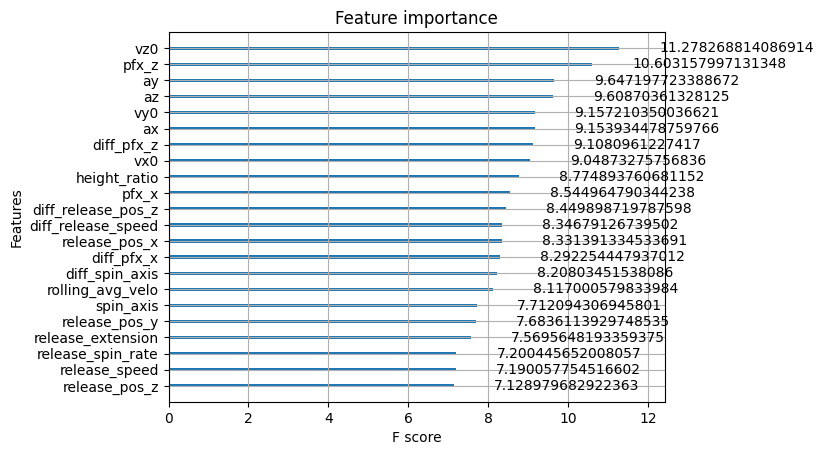

In [19]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

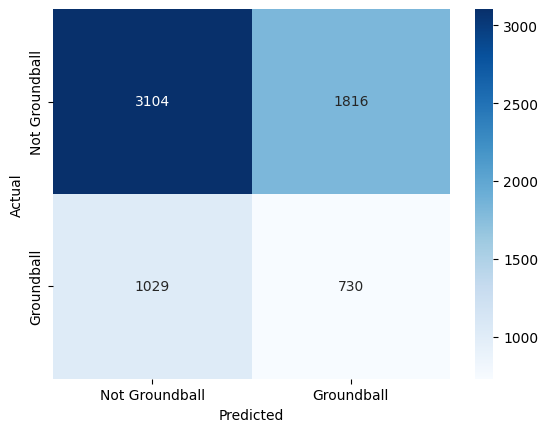

In [20]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [21]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [22]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [23]:
y_pred = final_model.predict(predictions)

In [24]:
testing_identifiers['xgb'] = y_pred

In [25]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/gb_2022&3_xgb.csv")